# Import libraries

In [2]:
!nvidia-smi

Sat Apr 27 02:18:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       On  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              10W /  70W |      2MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!pip install Pillow transformers einops accelerate langchain bitsandbytes kor sentencepiece ftfy regex tqdm torch torchvision
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /var/tmp/pip-req-build-2uxcz2fj
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /var/tmp/pip-req-build-2uxcz2fj
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [4]:
!pip install opencv-python albumentations

In [5]:
import json
import textwrap
import pandas as pd
from pathlib import Path
from PIL import Image
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import clip
from transformers import CLIPProcessor, CLIPModel

In [6]:
# from google.colab import drive

In [6]:
!gcloud config list

[compute]
region = asia-southeast1
[core]
account = marcus-rocks-2-service-account@dsta-angelhack.iam.gserviceaccount.com
disable_usage_reporting = True
project = dsta-angelhack
[dataproc]
region = asia-southeast1

Your active configuration is: [default]


In [7]:
from google.cloud import aiplatform

In [8]:
PROJECT_ID = "dsta-angelhack"
REGION = "asia-southeast1"
BUCKET_URI = "gs://til-ai-24-advanced"

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

### Load data from Cloud Bucket

In [9]:
from google.cloud import storage
from io import BytesIO
from PIL import Image

def load_images_from_bucket(bucket_name, folder_path):
    """
    Load multiple image files from a Google Cloud Storage bucket.

    Args:
        bucket_name (str): The name of the bucket.
        folder_path (str): The path to the folder containing the image files in the bucket.

    Returns:
        dict: A dictionary where keys are file names and values are file contents.
    """
    # Create a client object
    client = storage.Client()

    # Access the bucket
    bucket = client.bucket(bucket_name)

    # Initialize an empty dictionary to store file contents
    file_contents = {}

    # List blobs (files) in the specified folder path
    blobs = bucket.list_blobs(prefix=folder_path)

    # Iterate over the blobs
    for blob in blobs:
        # Check if the blob represents a file (not a folder)
        if not blob.name.endswith('/'):
            # Get the file name from the blob's name
            file_name = blob.name.split('/')[-1]

            # Download the file contents
            content = blob.download_as_bytes()

            # Store the file contents in the dictionary
            file_contents[file_name] = content

    return file_contents

# Example usage:
bucket_name = 'til-ai-24-advanced'
folder_path = 'images/'  # e.g., 'images/'
images = load_images_from_bucket(bucket_name, folder_path)


# Print or process the loaded images
# for file_name, contents in images.items():
#     print(
#         "Downloaded storage object {} from bucket {} as the following bytes object: {}.".format(
#             file_name, bucket_name, BytesIO(content)
#         )
#     )

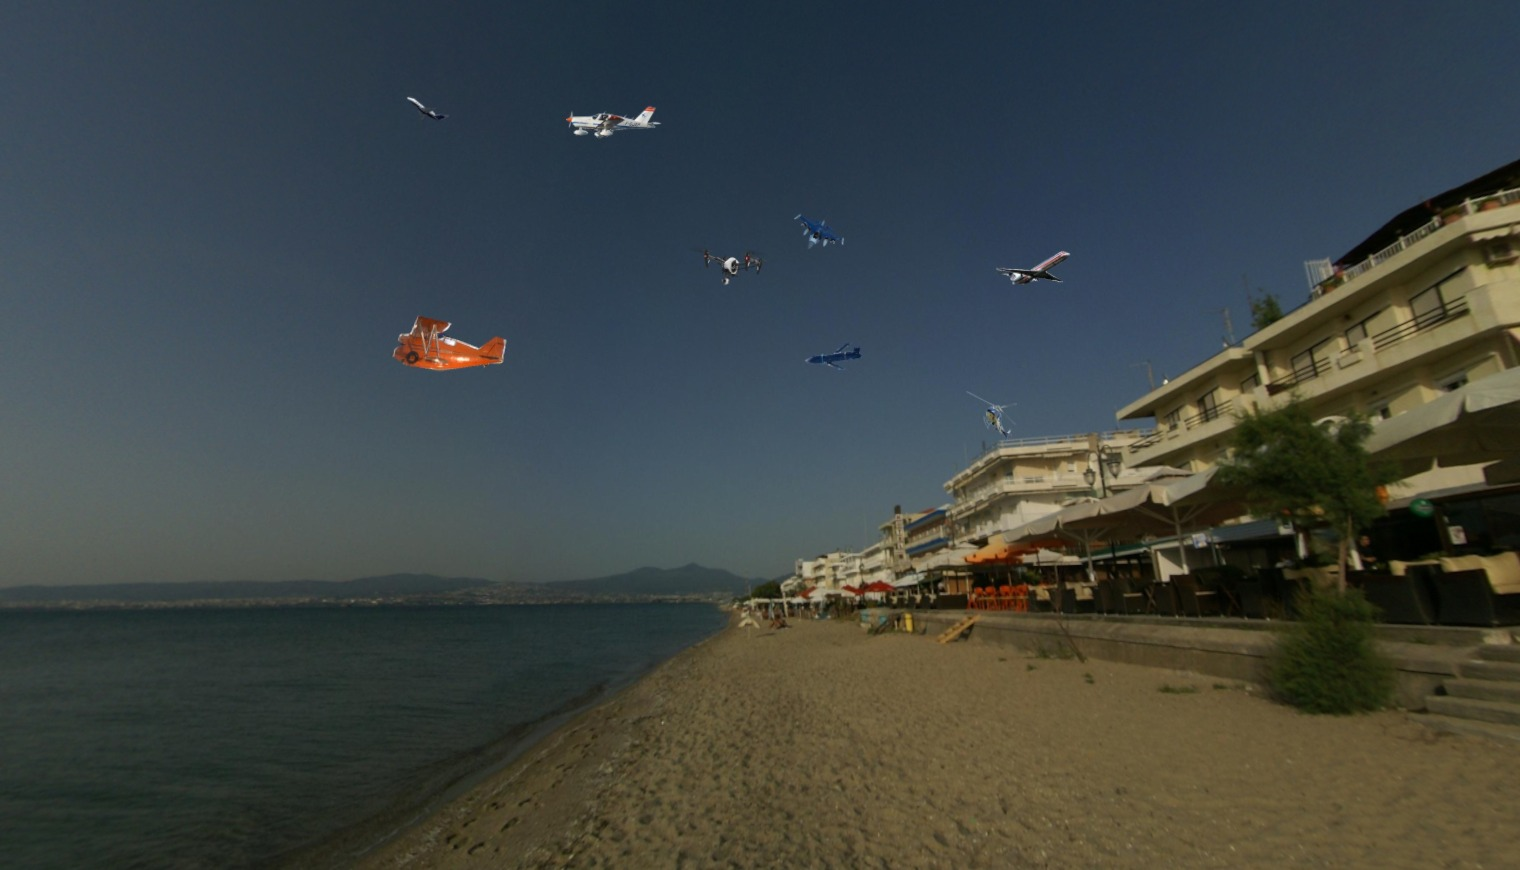

In [10]:
image = BytesIO(images['image_10.jpg'])
image = Image.open(image)
image

In [11]:
import json

# Create a client using the default credentials
client = storage.Client()

bucket = client.get_bucket('til-ai-24-advanced')

blob = bucket.blob('vlm.jsonl')

blob.download_to_filename('vlm.jsonl')

# # Download the file content
# content = blob.download_as_string()

# # Decode the content and split it into lines
# lines = content.decode('utf-8').split('\n')

# # Parse each line as JSON
# json_data = [json.loads(line) for line in lines if line.strip()]

# # Now 'json_data' contains the parsed JSON objects from the JSONL file

# Prepare CLIP model

In [12]:
CONTEXT_LENGTH=77

In [13]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [14]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [15]:
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

# Prepare Dataset

In [16]:
# drive.mount('/content/drive/')

In [17]:
# !ls drive/MyDrive/DSTA/TIL/data

In [18]:
def get_items_in_range(input_dict, start, end):
    """
    Get items from a dictionary with keys in the specified range.

    Args:
        input_dict (dict): The input dictionary.
        start (int): The start index of the range.
        end (int): The end index of the range.

    Returns:
        dict: A dictionary containing items with keys in the specified range.
    """
    result_dict = {}

    # Iterate over the items in the input dictionary
    for key, value in input_dict.items():
        if start <= int(key[6:-4]) <= end:
            result_dict[key] = value

    return result_dict

In [19]:
#Split 5106 files into 0-4499 train and 4500: test
train_dict = get_items_in_range(images, 0, 4499)
test_dict = get_items_in_range(images, 4500, 5106)

In [20]:
#Split jsonl
df = pd.read_json(path_or_buf='vlm.jsonl', lines=True)
train_df = df.iloc[:4500]
test_df = df.iloc[4500:]
with open('train.jsonl', 'w') as file:
    for _, row in train_df.iterrows():
        row_dict = row.to_dict()
        json_line = json.dumps(row_dict) + '\n'  # Convert row to JSON string
        file.write(json_line)

In [21]:
with open('test.jsonl', 'w') as file:
    for _, row in test_df.iterrows():
        row_dict = row.to_dict()
        json_line = json.dumps(row_dict) + '\n'  # Convert row to JSON string
        file.write(json_line)

In [22]:
# TASK: Change path to where the data folder is in your Google Drive
# data_path = Path("drive/MyDrive/DSTA/TIL/data/5000advanced")
# train_path = data_path / "train"
# test_path = data_path / "test"
# finals_path = data_path / "test_new"

In [23]:
probability = 0.9
transform = A.Compose(
    [
        A.Blur(blur_limit=(5, 15), p=probability),
        A.MotionBlur(blur_limit=(5, 11), p=probability),
        A.RandomBrightnessContrast(
            brightness_limit=(-0.05, 0.05), p=probability
        ),
        A.RandomGamma(p=probability),
        A.GaussNoise(
            var_limit=(0, 1000),
            p=probability,
        ),
        A.ImageCompression(
            quality_lower=65, quality_upper=100, p=probability
        ),
    ]
)

In [24]:
class VisionLanguageDataset(Dataset):
    def __init__(self, image_dict, json_filepath, preprocess=None, transform=None, scale=False):
        """
        Initialises Vision-Language Dataset

        Parameters
        ----------
        data_path: str
          Path to folder containing `vlm.jsonl` file and `images` folder
        preprocess: function
          Function from CLIP to preprocess images
        """
        self.preprocess = preprocess
        # self.data_path = Path(data_path)
        self.transform = transform

        self.image_dict = image_dict
        self.json_filepath = json_filepath
        self.json_annot = pd.read_json(path_or_buf=self.json_filepath, lines=True)
        self.frame_list, self.bbox_list, self.caption_list = self.init_chips()

        self.desc_tokens = clip.tokenize(
            self.caption_list, context_length=CONTEXT_LENGTH, truncate=True
        )
        self.scale = scale

    def retrieve_chip(self, idx):
        frame = self.frame_list[idx]
        bbox = self.bbox_list[idx]
        #img_frame = Image.open(str(self.image_path / frame))
        if self.transform:
            image = BytesIO(self.image_dict[f'{frame}'])
            img_frame = Image.open(image)
            img_np = np.array(img_frame)
            data = transform(image=img_np)["image"]
            img_frame = Image.fromarray(data)
        else:
            image = BytesIO(self.image_dict[f'{frame}'])
            img_frame = Image.open(image)
          # img_frame = Image.open(str(self.image_path / frame))
        if self.scale:
            x,y,w,h = [x*2 for x in bbox]
        else:
            x,y,w,h = bbox
        img_chip = img_frame.crop((x,y,x+w, y+h))
        return img_chip

    def __len__(self):
        return len(self.bbox_list)

    def __getitem__(self, idx):
        """Load description and image with processing for model"""
        description = self.desc_tokens[idx]
        chip = self.retrieve_chip(idx)
        image = self.preprocess(chip)

        return image, description


    def get_data(self, idx):
        """Load description and image without transforms"""
        img = self.retrieve_chip(idx)
        description = self.caption_list[idx]
        return img, description

    def visualise_data(self, idx):
        """Print description and plot image for visualisation"""
        img = self.retrieve_chip(idx)
        description = self.caption_list[idx]
        print(textwrap.fill(description, 100))
        plt.imshow(img)


    def init_chips(self):
        """Puts chip annotations in list format so accessing from index is easier"""
        frame_list = []
        bbox_list = []
        caption_list = []
        for i, row in self.json_annot.iterrows():
            image_frame = row["image"]

            ## if using data.jsonl format
            # num_chips = len(row['bboxes'])
            # frame_list.extend([image_frame]*num_chips)
            # bbox_list.extend(row['bboxes'])
            # caption_list.extend(row['captions'])

            ## if using vlm.jsonl format
            chip_annotations = row["annotations"]
            for chip in chip_annotations:
                frame_list.append(image_frame)
                bbox_list.append(chip["bbox"])
                caption_list.append(chip["caption"])
        return frame_list, bbox_list, caption_list

    def get_subset(self, image_frame):
        indices = np.where(np.array(self.frame_list) == image_frame)[0]
        new_subset = VisionLanguageDataset(self.image_dict, self.json_filepath, self.preprocess, self.transform, scale=self.scale)
        new_subset.frame_list = [new_subset.frame_list[int(i)] for i in indices]
        new_subset.bbox_list = [new_subset.bbox_list[int(i)] for i in indices]
        new_subset.caption_list = [new_subset.caption_list[int(i)] for i in indices]
        return new_subset

In [25]:
train_dataset = VisionLanguageDataset(train_dict, 'train.jsonl', preprocess, transform=transform, scale=False)
test_dataset = VisionLanguageDataset(test_dict, 'test.jsonl', preprocess, scale=False)
noisy_test_dataset = VisionLanguageDataset(test_dict, 'test.jsonl', preprocess, transform=transform, scale=False)
# finals_dataset = VisionLanguageDataset(finals_path, preprocess, scale=False)

yellow, red, and grey helicopter


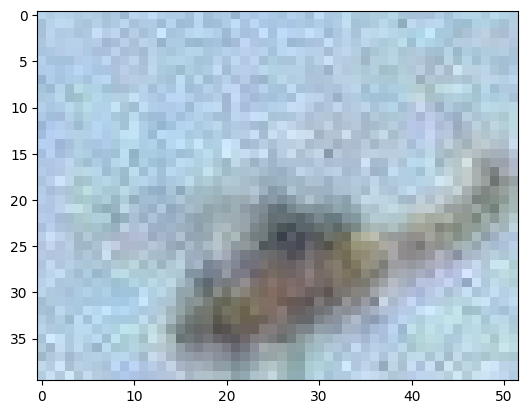

In [202]:
# visualise data: change the number
train_dataset.visualise_data(100)

# Evaluation Helper Functions
Test model before and after fine-tuning

In [23]:
# def predict_img(dataset, model, query_txt, verbose=True):
#   """
#   Given a pool of images and a query text, predict which image fits the text description the most
#   """
#   eval_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
#   model.eval()
#   for images, _ in eval_loader:
#     texts = clip.tokenize(
#         [query_txt], context_length=CONTEXT_LENGTH, truncate=True
#     )
#     images = images.to(device)
#     texts = texts.to(device)

#     logits_per_image, _ = model(images, texts)
#     most_similar_idx = torch.argmax(logits_per_image,dim=0).item()
#   if verbose:
#     print(f"Query text:\n{textwrap.fill(query_txt, 100)}")
#     print("\n")
#     dataset.visualise_data(most_similar_idx)
#   return most_similar_idx

In [24]:
# def eval_accuracy(dataset, model):
#   correct = 0
#   wrong_predictions = []
#   model.eval()
#   current_frame = None
#   for idx, (frame, caption) in tqdm(enumerate(zip(dataset.frame_list, dataset.caption_list))):
#     if current_frame != frame:
#       subset = dataset.get_subset(frame)
#       current_frame = frame
#     i = predict_img(subset, model, caption, verbose=False)
#     pred_caption = subset.caption_list[i]
#     if caption == pred_caption:
#       correct+=1
#     else:
#       wrong_predictions.append((frame, idx))
#   return (correct / len(dataset) * 100), wrong_predictions


In [26]:
def predict_img(dataset, model, query_txts, verbose=True):
    """
    Given a pool of images and a list of query texts, predict which image fits the text descriptions the most
    Returns a list of indices corresponding to query texts
    """
    eval_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    model.eval()
    for images, _ in eval_loader:
        texts = clip.tokenize(
            query_txts, context_length=CONTEXT_LENGTH, truncate=True
        )
        images = images.to(device)
        texts = texts.to(device)

        logits_per_image, _ = model(images, texts)
        most_similar_idx = torch.argmax(logits_per_image,dim=0).tolist()
    if verbose: # just show first prediction
        print(f"Query text:\n{textwrap.fill(query_txts[0], 100)}")
        print("\n")
        dataset.visualise_data(most_similar_idx[0])
    return most_similar_idx

In [27]:
def eval_accuracy(dataset, model):
    """
    Evaluate batch frame by frame
    """
    correct = 0
    wrong_predictions = []
    model.eval()
    for frame in tqdm(list(set(dataset.frame_list))):
        subset = dataset.get_subset(frame)
        captions = subset.caption_list
        idxs = predict_img(subset, model, captions, verbose=False)
        gt = [x for x in range(len(captions))]
        correct += sum(1 for i, j in zip(idxs, gt) if i == j)
        wrong_predictions.extend([(frame, j) for i, j in zip(idxs, gt) if i!=j])
    return (correct / len(dataset) * 100), wrong_predictions

In [190]:
# accuracy, wrong_predictions = eval_accuracy(train_dataset, model)
# print(f"\nAccuracy: {accuracy}%")
# print(wrong_predictions)

In [191]:
accuracy, wrong_predictions = eval_accuracy(test_dataset, model)
print(f"\nAccuracy: {accuracy}%")
print(wrong_predictions)

100%|██████████| 607/607 [03:59<00:00,  2.53it/s]


Accuracy: 67.58661186142102%
[('image_5046.jpg', 0), ('image_5046.jpg', 1), ('image_5046.jpg', 4), ('image_5046.jpg', 6), ('image_4942.jpg', 0), ('image_4942.jpg', 4), ('image_4647.jpg', 1), ('image_4647.jpg', 2), ('image_5043.jpg', 1), ('image_4781.jpg', 0), ('image_4781.jpg', 2), ('image_4781.jpg', 5), ('image_4967.jpg', 1), ('image_4967.jpg', 2), ('image_4657.jpg', 0), ('image_4657.jpg', 2), ('image_4657.jpg', 4), ('image_4785.jpg', 0), ('image_4785.jpg', 4), ('image_4785.jpg', 6), ('image_5052.jpg', 2), ('image_4503.jpg', 1), ('image_5072.jpg', 0), ('image_4549.jpg', 4), ('image_4549.jpg', 6), ('image_4806.jpg', 5), ('image_4806.jpg', 7), ('image_4897.jpg', 1), ('image_4897.jpg', 2), ('image_4897.jpg', 5), ('image_4563.jpg', 0), ('image_4563.jpg', 1), ('image_4563.jpg', 2), ('image_4979.jpg', 6), ('image_4979.jpg', 7), ('image_4577.jpg', 0), ('image_4577.jpg', 1), ('image_4577.jpg', 3), ('image_5048.jpg', 1), ('image_5048.jpg', 4), ('image_4869.jpg', 2), ('image_5055.jpg', 2), ('i

In [203]:
accuracy, wrong_predictions = eval_accuracy(noisy_test_dataset, model)
print(f"\nAccuracy: {accuracy}%")
print(wrong_predictions)

100%|██████████| 607/607 [14:52<00:00,  1.47s/it]


Accuracy: 38.46153846153847%
[('image_5046.jpg', 1), ('image_5046.jpg', 2), ('image_5046.jpg', 6), ('image_4942.jpg', 3), ('image_4942.jpg', 4), ('image_4942.jpg', 5), ('image_4647.jpg', 1), ('image_4647.jpg', 2), ('image_4647.jpg', 4), ('image_5043.jpg', 0), ('image_5043.jpg', 1), ('image_5043.jpg', 4), ('image_4781.jpg', 0), ('image_4781.jpg', 3), ('image_4781.jpg', 4), ('image_4781.jpg', 5), ('image_4967.jpg', 0), ('image_4967.jpg', 1), ('image_4967.jpg', 2), ('image_4967.jpg', 5), ('image_4657.jpg', 0), ('image_4657.jpg', 2), ('image_4657.jpg', 3), ('image_4657.jpg', 4), ('image_4657.jpg', 5), ('image_4785.jpg', 0), ('image_4785.jpg', 3), ('image_4785.jpg', 4), ('image_4785.jpg', 5), ('image_4785.jpg', 6), ('image_4785.jpg', 7), ('image_5052.jpg', 1), ('image_5052.jpg', 2), ('image_5052.jpg', 3), ('image_5052.jpg', 4), ('image_4503.jpg', 2), ('image_5072.jpg', 0), ('image_5072.jpg', 1), ('image_4592.jpg', 1), ('image_4592.jpg', 2), ('image_4678.jpg', 0), ('image_4678.jpg', 2), ('i

In [ ]:
# accuracy, wrong_predictions = eval_accuracy(finals_dataset, model)
# print(f"\nAccuracy: {accuracy}%")
# print(wrong_predictions)

Query text:
grey camouflage fighter jet


white and red helicopter


[3]

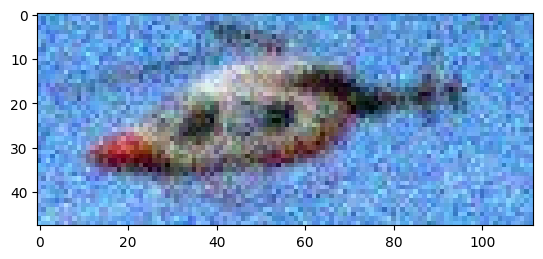

In [195]:
# (Optional) TASK: change the query_txt to see model's prediction before fine-tuning
query_txt = ["grey camouflage fighter jet"]
subset = train_dataset.get_subset("image_0.jpg")
predict_img(subset, model, query_txt)

# Model Training

In [207]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=1e-5,betas=(0.9,0.999),eps=1e-6,weight_decay=0.2
)
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

In [208]:
num_epochs = 10

In [209]:
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        p.grad.data = p.grad.data.float()

In [ ]:
# model training epochs
model.train()
for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}/{num_epochs}")
    for (images, texts) in tqdm(train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        texts = texts.to(device)

        output_image, output_text = model(images, texts)
        ground_truth = torch.arange(len(images), dtype=torch.long, device=device)
        total_loss = (
            loss_img(output_image, ground_truth)
            + loss_txt(output_text, ground_truth)
        ) / 2

        total_loss.backward()

        if device == "cpu":
            optimizer.step()
        else :
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

        print(f"Total Loss: {total_loss.item():.4f}")

Epoch: 1/10


  0%|          | 1/1532 [00:06<2:49:39,  6.65s/it]

Total Loss: 2.7617


  0%|          | 2/1532 [00:09<1:59:20,  4.68s/it]

Total Loss: 2.5859


  0%|          | 3/1532 [00:13<1:46:23,  4.17s/it]

Total Loss: 2.5703


  0%|          | 4/1532 [00:17<1:39:23,  3.90s/it]

Total Loss: 2.0742


  0%|          | 5/1532 [00:20<1:34:18,  3.71s/it]

Total Loss: 2.0898


  0%|          | 6/1532 [00:23<1:32:45,  3.65s/it]

Total Loss: 2.5371


  0%|          | 7/1532 [00:27<1:31:16,  3.59s/it]

Total Loss: 1.8613


  1%|          | 8/1532 [00:31<1:31:53,  3.62s/it]

Total Loss: 2.5254


  1%|          | 9/1532 [00:34<1:29:26,  3.52s/it]

Total Loss: 1.6738


  1%|          | 10/1532 [00:37<1:28:11,  3.48s/it]

Total Loss: 2.0215


  1%|          | 11/1532 [00:41<1:27:19,  3.45s/it]

Total Loss: 2.4375


  1%|          | 12/1532 [00:44<1:27:46,  3.46s/it]

Total Loss: 2.1055


  1%|          | 13/1532 [00:48<1:27:06,  3.44s/it]

Total Loss: 1.6738


  1%|          | 14/1532 [00:51<1:26:26,  3.42s/it]

Total Loss: 1.9111


  1%|          | 15/1532 [00:54<1:26:35,  3.42s/it]

Total Loss: 2.0645


  1%|          | 16/1532 [00:58<1:27:42,  3.47s/it]

Total Loss: 2.1543


  1%|          | 17/1532 [01:01<1:26:44,  3.44s/it]

Total Loss: 1.9883


  1%|          | 18/1532 [01:04<1:24:48,  3.36s/it]

Total Loss: 2.0859


  1%|          | 19/1532 [01:08<1:22:48,  3.28s/it]

Total Loss: 1.8086


  1%|▏         | 20/1532 [01:11<1:22:12,  3.26s/it]

Total Loss: 2.0352


  1%|▏         | 21/1532 [01:14<1:22:35,  3.28s/it]

Total Loss: 2.0820


  1%|▏         | 22/1532 [01:17<1:23:25,  3.31s/it]

Total Loss: 1.2686


  2%|▏         | 23/1532 [01:21<1:22:07,  3.27s/it]

Total Loss: 2.3340


  2%|▏         | 24/1532 [01:24<1:24:48,  3.37s/it]

Total Loss: 2.1406


  2%|▏         | 25/1532 [01:28<1:26:54,  3.46s/it]

Total Loss: 1.8457


  2%|▏         | 26/1532 [01:32<1:29:04,  3.55s/it]

Total Loss: 1.4805


  2%|▏         | 27/1532 [01:35<1:28:34,  3.53s/it]

Total Loss: 1.5312


  2%|▏         | 28/1532 [01:39<1:27:30,  3.49s/it]

Total Loss: 1.6094


  2%|▏         | 29/1532 [01:42<1:28:36,  3.54s/it]

Total Loss: 1.7178


  2%|▏         | 30/1532 [01:46<1:29:37,  3.58s/it]

Total Loss: 1.5850


  2%|▏         | 31/1532 [01:49<1:25:36,  3.42s/it]

Total Loss: 1.5586


  2%|▏         | 32/1532 [01:52<1:26:17,  3.45s/it]

Total Loss: 1.6943


  2%|▏         | 33/1532 [01:56<1:27:53,  3.52s/it]

Total Loss: 1.6758


  2%|▏         | 34/1532 [02:00<1:27:00,  3.48s/it]

Total Loss: 1.5498


  2%|▏         | 35/1532 [02:03<1:27:08,  3.49s/it]

Total Loss: 1.9980


  2%|▏         | 36/1532 [02:06<1:26:29,  3.47s/it]

Total Loss: 2.1445


  2%|▏         | 37/1532 [02:10<1:26:08,  3.46s/it]

Total Loss: 1.9746


  2%|▏         | 38/1532 [02:14<1:28:52,  3.57s/it]

Total Loss: 2.0625


  3%|▎         | 39/1532 [02:17<1:27:19,  3.51s/it]

Total Loss: 1.8340


  3%|▎         | 40/1532 [02:20<1:24:43,  3.41s/it]

Total Loss: 1.5938


  3%|▎         | 41/1532 [02:24<1:25:35,  3.44s/it]

Total Loss: 2.0508


  3%|▎         | 42/1532 [02:27<1:25:34,  3.45s/it]

Total Loss: 1.2383


  3%|▎         | 43/1532 [02:31<1:28:55,  3.58s/it]

Total Loss: 2.2266


  3%|▎         | 44/1532 [02:35<1:29:16,  3.60s/it]

Total Loss: 1.7480


  3%|▎         | 45/1532 [02:38<1:28:08,  3.56s/it]

Total Loss: 1.6885


  3%|▎         | 46/1532 [02:41<1:24:14,  3.40s/it]

Total Loss: 1.9707


  3%|▎         | 47/1532 [02:45<1:24:23,  3.41s/it]

Total Loss: 1.7314


  3%|▎         | 48/1532 [02:48<1:21:50,  3.31s/it]

Total Loss: 1.7031


  3%|▎         | 49/1532 [02:51<1:24:30,  3.42s/it]

Total Loss: 1.7363


  3%|▎         | 50/1532 [02:55<1:23:52,  3.40s/it]

Total Loss: 1.7773


  3%|▎         | 51/1532 [02:58<1:24:23,  3.42s/it]

Total Loss: 1.4219


  3%|▎         | 52/1532 [03:02<1:23:38,  3.39s/it]

Total Loss: 1.5996


  3%|▎         | 53/1532 [03:05<1:24:22,  3.42s/it]

Total Loss: 1.4883


  4%|▎         | 54/1532 [03:08<1:24:12,  3.42s/it]

Total Loss: 1.7129


  4%|▎         | 55/1532 [03:12<1:22:10,  3.34s/it]

Total Loss: 1.2568


  4%|▎         | 56/1532 [03:15<1:24:09,  3.42s/it]

Total Loss: 1.6045


  4%|▎         | 57/1532 [03:19<1:25:15,  3.47s/it]

Total Loss: 1.8467


  4%|▍         | 58/1532 [03:22<1:24:31,  3.44s/it]

Total Loss: 1.7598


  4%|▍         | 59/1532 [03:26<1:25:17,  3.47s/it]

Total Loss: 1.9385


  4%|▍         | 60/1532 [03:29<1:25:17,  3.48s/it]

Total Loss: 1.6152


  4%|▍         | 61/1532 [03:33<1:27:51,  3.58s/it]

Total Loss: 1.7578


  4%|▍         | 62/1532 [03:36<1:24:34,  3.45s/it]

Total Loss: 1.6367


  4%|▍         | 63/1532 [03:39<1:21:30,  3.33s/it]

Total Loss: 1.7861


  4%|▍         | 64/1532 [03:43<1:23:01,  3.39s/it]

Total Loss: 1.4824


  4%|▍         | 65/1532 [03:46<1:22:08,  3.36s/it]

Total Loss: 1.1348


  4%|▍         | 66/1532 [03:49<1:21:10,  3.32s/it]

Total Loss: 1.3672


  4%|▍         | 67/1532 [03:53<1:23:25,  3.42s/it]

Total Loss: 1.5176


  4%|▍         | 68/1532 [03:56<1:24:10,  3.45s/it]

Total Loss: 1.7539


  5%|▍         | 69/1532 [04:00<1:25:24,  3.50s/it]

Total Loss: 1.2754


  5%|▍         | 70/1532 [04:04<1:24:58,  3.49s/it]

Total Loss: 1.1289


  5%|▍         | 71/1532 [04:07<1:23:59,  3.45s/it]

Total Loss: 1.6338


  5%|▍         | 72/1532 [04:10<1:24:00,  3.45s/it]

Total Loss: 1.6191


  5%|▍         | 73/1532 [04:14<1:24:31,  3.48s/it]

Total Loss: 1.4385


  5%|▍         | 74/1532 [04:18<1:25:44,  3.53s/it]

Total Loss: 1.3535


  5%|▍         | 75/1532 [04:21<1:26:48,  3.57s/it]

Total Loss: 1.8770


  5%|▍         | 76/1532 [04:25<1:25:00,  3.50s/it]

Total Loss: 1.2695


  5%|▌         | 77/1532 [04:28<1:25:04,  3.51s/it]

Total Loss: 1.3789


  5%|▌         | 78/1532 [04:32<1:26:46,  3.58s/it]

Total Loss: 1.0449


  5%|▌         | 79/1532 [04:35<1:26:03,  3.55s/it]

Total Loss: 1.6699


  5%|▌         | 80/1532 [04:39<1:28:09,  3.64s/it]

Total Loss: 1.6445


  5%|▌         | 81/1532 [04:43<1:27:59,  3.64s/it]

Total Loss: 1.4727


  5%|▌         | 82/1532 [04:46<1:27:41,  3.63s/it]

Total Loss: 1.5293


  5%|▌         | 83/1532 [04:50<1:26:59,  3.60s/it]

Total Loss: 0.8853


  5%|▌         | 84/1532 [04:53<1:25:50,  3.56s/it]

Total Loss: 1.5264


  6%|▌         | 85/1532 [04:57<1:27:22,  3.62s/it]

Total Loss: 1.3545


  6%|▌         | 86/1532 [05:01<1:27:56,  3.65s/it]

Total Loss: 1.3389


  6%|▌         | 87/1532 [05:04<1:26:16,  3.58s/it]

Total Loss: 1.4102


  6%|▌         | 88/1532 [05:08<1:25:20,  3.55s/it]

Total Loss: 1.5977


  6%|▌         | 89/1532 [05:12<1:28:05,  3.66s/it]

Total Loss: 1.6006


  6%|▌         | 90/1532 [05:16<1:28:57,  3.70s/it]

Total Loss: 1.1367


  6%|▌         | 91/1532 [05:19<1:28:27,  3.68s/it]

Total Loss: 1.3047


  6%|▌         | 92/1532 [05:23<1:26:29,  3.60s/it]

Total Loss: 1.5088


  6%|▌         | 93/1532 [05:26<1:27:15,  3.64s/it]

Total Loss: 1.1104


  6%|▌         | 94/1532 [05:30<1:26:58,  3.63s/it]

Total Loss: 0.9507


  6%|▌         | 95/1532 [05:34<1:29:37,  3.74s/it]

Total Loss: 1.3350


  6%|▋         | 96/1532 [05:37<1:26:19,  3.61s/it]

Total Loss: 1.3623


  6%|▋         | 97/1532 [05:40<1:23:15,  3.48s/it]

Total Loss: 1.2598


  6%|▋         | 98/1532 [05:44<1:25:22,  3.57s/it]

Total Loss: 0.9229


  6%|▋         | 99/1532 [05:48<1:26:12,  3.61s/it]

Total Loss: 0.7041


  7%|▋         | 100/1532 [05:51<1:25:55,  3.60s/it]

Total Loss: 1.5840


  7%|▋         | 101/1532 [05:55<1:25:10,  3.57s/it]

Total Loss: 1.1104


  7%|▋         | 102/1532 [05:58<1:22:39,  3.47s/it]

Total Loss: 1.3018


  7%|▋         | 103/1532 [06:02<1:22:34,  3.47s/it]

Total Loss: 1.3838


  7%|▋         | 104/1532 [06:05<1:23:56,  3.53s/it]

Total Loss: 1.5420


  7%|▋         | 105/1532 [06:09<1:23:53,  3.53s/it]

Total Loss: 1.4844


  7%|▋         | 106/1532 [06:13<1:25:03,  3.58s/it]

Total Loss: 1.0723


  7%|▋         | 107/1532 [06:16<1:25:07,  3.58s/it]

Total Loss: 1.8633


  7%|▋         | 108/1532 [06:20<1:25:19,  3.60s/it]

Total Loss: 1.1914


  7%|▋         | 109/1532 [06:23<1:24:26,  3.56s/it]

Total Loss: 1.0352


  7%|▋         | 110/1532 [06:27<1:25:35,  3.61s/it]

Total Loss: 1.4746


  7%|▋         | 111/1532 [06:31<1:28:10,  3.72s/it]

Total Loss: 1.3965


  7%|▋         | 112/1532 [06:35<1:29:56,  3.80s/it]

Total Loss: 1.2314


  7%|▋         | 113/1532 [06:39<1:31:43,  3.88s/it]

Total Loss: 1.3828


  7%|▋         | 114/1532 [06:42<1:28:31,  3.75s/it]

Total Loss: 1.1719


  8%|▊         | 115/1532 [06:45<1:23:30,  3.54s/it]

Total Loss: 0.5483


  8%|▊         | 116/1532 [06:49<1:24:06,  3.56s/it]

Total Loss: 1.5928


  8%|▊         | 117/1532 [06:52<1:21:49,  3.47s/it]

Total Loss: 1.1709


  8%|▊         | 118/1532 [06:56<1:23:35,  3.55s/it]

Total Loss: 1.2969


  8%|▊         | 119/1532 [06:59<1:19:17,  3.37s/it]

Total Loss: 0.9790


  8%|▊         | 120/1532 [07:02<1:18:38,  3.34s/it]

Total Loss: 1.1250


  8%|▊         | 121/1532 [07:06<1:21:56,  3.48s/it]

Total Loss: 1.3311


  8%|▊         | 122/1532 [07:10<1:21:41,  3.48s/it]

Total Loss: 1.6484


  8%|▊         | 123/1532 [07:13<1:20:23,  3.42s/it]

Total Loss: 1.1738


  8%|▊         | 124/1532 [07:16<1:20:20,  3.42s/it]

Total Loss: 1.2305


  8%|▊         | 125/1532 [07:20<1:22:19,  3.51s/it]

Total Loss: 0.7197


  8%|▊         | 126/1532 [07:23<1:21:01,  3.46s/it]

Total Loss: 1.2676


  8%|▊         | 127/1532 [07:27<1:22:44,  3.53s/it]

Total Loss: 1.5664


  8%|▊         | 128/1532 [07:30<1:19:54,  3.42s/it]

Total Loss: 0.8721


  8%|▊         | 129/1532 [07:34<1:20:09,  3.43s/it]

Total Loss: 1.4189


  8%|▊         | 130/1532 [07:37<1:21:40,  3.50s/it]

Total Loss: 1.0469


  9%|▊         | 131/1532 [07:41<1:22:28,  3.53s/it]

Total Loss: 1.7305


  9%|▊         | 132/1532 [07:44<1:19:39,  3.41s/it]

Total Loss: 1.1289


  9%|▊         | 133/1532 [07:47<1:17:40,  3.33s/it]

Total Loss: 1.3105


  9%|▊         | 134/1532 [07:51<1:18:18,  3.36s/it]

Total Loss: 1.2129


  9%|▉         | 135/1532 [07:54<1:16:41,  3.29s/it]

Total Loss: 1.0859


  9%|▉         | 136/1532 [07:57<1:17:54,  3.35s/it]

Total Loss: 1.0840


  9%|▉         | 137/1532 [08:01<1:19:55,  3.44s/it]

Total Loss: 0.9082


  9%|▉         | 138/1532 [08:04<1:19:34,  3.42s/it]

Total Loss: 0.8818


  9%|▉         | 139/1532 [08:08<1:19:15,  3.41s/it]

Total Loss: 1.1445


  9%|▉         | 140/1532 [08:11<1:19:14,  3.42s/it]

Total Loss: 1.8086


  9%|▉         | 141/1532 [08:15<1:20:47,  3.48s/it]

Total Loss: 0.9023


  9%|▉         | 142/1532 [08:18<1:21:22,  3.51s/it]

Total Loss: 1.3184


  9%|▉         | 143/1532 [08:22<1:21:08,  3.51s/it]

Total Loss: 0.9614


  9%|▉         | 144/1532 [08:26<1:22:45,  3.58s/it]

Total Loss: 0.7441


  9%|▉         | 145/1532 [08:29<1:23:19,  3.60s/it]

Total Loss: 1.1641


 10%|▉         | 146/1532 [08:33<1:24:04,  3.64s/it]

Total Loss: 1.3311


 10%|▉         | 147/1532 [08:36<1:22:44,  3.58s/it]

Total Loss: 1.6113


 10%|▉         | 148/1532 [08:40<1:22:03,  3.56s/it]

Total Loss: 0.8174


 10%|▉         | 149/1532 [08:43<1:19:53,  3.47s/it]

Total Loss: 0.7109


 10%|▉         | 150/1532 [08:47<1:22:54,  3.60s/it]

Total Loss: 0.9355


 10%|▉         | 151/1532 [08:50<1:20:29,  3.50s/it]

Total Loss: 1.0859


 10%|▉         | 152/1532 [08:54<1:20:55,  3.52s/it]

Total Loss: 1.0947


 10%|▉         | 153/1532 [08:58<1:21:56,  3.57s/it]

Total Loss: 1.6094


 10%|█         | 154/1532 [09:01<1:23:34,  3.64s/it]

Total Loss: 1.7871


 10%|█         | 155/1532 [09:05<1:22:26,  3.59s/it]

Total Loss: 0.8203


 10%|█         | 156/1532 [09:08<1:20:56,  3.53s/it]

Total Loss: 1.0664


 10%|█         | 157/1532 [09:12<1:21:16,  3.55s/it]

Total Loss: 1.1270


 10%|█         | 158/1532 [09:15<1:21:08,  3.54s/it]

Total Loss: 0.6855


 10%|█         | 159/1532 [09:19<1:21:13,  3.55s/it]

Total Loss: 0.6152


 10%|█         | 160/1532 [09:23<1:21:39,  3.57s/it]

Total Loss: 0.6279


 11%|█         | 161/1532 [09:26<1:21:29,  3.57s/it]

Total Loss: 0.7300


 11%|█         | 162/1532 [09:30<1:20:42,  3.53s/it]

Total Loss: 0.9395


 11%|█         | 163/1532 [09:33<1:21:14,  3.56s/it]

Total Loss: 1.0342


 11%|█         | 164/1532 [09:36<1:18:50,  3.46s/it]

Total Loss: 1.2363


 11%|█         | 165/1532 [09:40<1:20:59,  3.55s/it]

Total Loss: 0.9731


 11%|█         | 166/1532 [09:43<1:19:12,  3.48s/it]

Total Loss: 0.5986


 11%|█         | 167/1532 [09:47<1:19:12,  3.48s/it]

Total Loss: 0.8896


 11%|█         | 168/1532 [09:50<1:17:59,  3.43s/it]

Total Loss: 1.4121


 11%|█         | 169/1532 [09:54<1:19:09,  3.48s/it]

Total Loss: 0.5571


 11%|█         | 170/1532 [09:57<1:19:21,  3.50s/it]

Total Loss: 1.2422


 11%|█         | 171/1532 [10:01<1:16:48,  3.39s/it]

Total Loss: 0.5566


 11%|█         | 172/1532 [10:04<1:17:50,  3.43s/it]

Total Loss: 0.6270


 11%|█▏        | 173/1532 [10:08<1:19:26,  3.51s/it]

Total Loss: 0.8965


 11%|█▏        | 174/1532 [10:11<1:18:02,  3.45s/it]

Total Loss: 1.4180


 11%|█▏        | 175/1532 [10:14<1:17:13,  3.41s/it]

Total Loss: 0.8433


 11%|█▏        | 176/1532 [10:18<1:17:45,  3.44s/it]

Total Loss: 0.4395


 12%|█▏        | 177/1532 [10:22<1:20:17,  3.56s/it]

Total Loss: 0.6758


 12%|█▏        | 178/1532 [10:25<1:20:37,  3.57s/it]

Total Loss: 0.7500


 12%|█▏        | 179/1532 [10:29<1:20:05,  3.55s/it]

Total Loss: 1.4863


 12%|█▏        | 180/1532 [10:33<1:21:28,  3.62s/it]

Total Loss: 0.4561


 12%|█▏        | 181/1532 [10:36<1:20:45,  3.59s/it]

Total Loss: 0.9595


 12%|█▏        | 182/1532 [10:40<1:21:13,  3.61s/it]

Total Loss: 0.8965


 12%|█▏        | 183/1532 [10:43<1:20:18,  3.57s/it]

Total Loss: 0.9443


 12%|█▏        | 184/1532 [10:47<1:20:50,  3.60s/it]

Total Loss: 0.9072


 12%|█▏        | 185/1532 [10:50<1:20:07,  3.57s/it]

Total Loss: 0.6191


 12%|█▏        | 186/1532 [10:54<1:19:00,  3.52s/it]

Total Loss: 0.6597


 12%|█▏        | 187/1532 [10:57<1:19:33,  3.55s/it]

Total Loss: 0.4956


 12%|█▏        | 188/1532 [11:01<1:21:50,  3.65s/it]

Total Loss: 0.5859


 12%|█▏        | 189/1532 [11:05<1:23:28,  3.73s/it]

Total Loss: 1.3672


 12%|█▏        | 190/1532 [11:08<1:18:05,  3.49s/it]

Total Loss: 1.2695


 12%|█▏        | 191/1532 [11:12<1:17:22,  3.46s/it]

Total Loss: 1.2861


 13%|█▎        | 192/1532 [11:15<1:17:52,  3.49s/it]

Total Loss: 1.1055


 13%|█▎        | 193/1532 [11:19<1:20:29,  3.61s/it]

Total Loss: 0.6787


 13%|█▎        | 194/1532 [11:23<1:20:47,  3.62s/it]

Total Loss: 0.6841


 13%|█▎        | 195/1532 [11:27<1:21:59,  3.68s/it]

Total Loss: 0.9570


 13%|█▎        | 196/1532 [11:30<1:19:06,  3.55s/it]

Total Loss: 1.3887


 13%|█▎        | 197/1532 [11:34<1:20:26,  3.62s/it]

Total Loss: 1.4277


 13%|█▎        | 198/1532 [11:37<1:19:39,  3.58s/it]

Total Loss: 1.4473


 13%|█▎        | 199/1532 [11:41<1:21:29,  3.67s/it]

Total Loss: 0.8477


 13%|█▎        | 200/1532 [11:45<1:21:16,  3.66s/it]

Total Loss: 1.4023


 13%|█▎        | 201/1532 [11:48<1:20:53,  3.65s/it]

Total Loss: 1.1992


 13%|█▎        | 202/1532 [11:51<1:18:19,  3.53s/it]

Total Loss: 1.1016


 13%|█▎        | 203/1532 [11:55<1:20:34,  3.64s/it]

Total Loss: 0.9482


 13%|█▎        | 204/1532 [11:58<1:16:01,  3.43s/it]

Total Loss: 1.2393


 13%|█▎        | 205/1532 [12:02<1:17:45,  3.52s/it]

Total Loss: 1.5371


 13%|█▎        | 206/1532 [12:05<1:17:22,  3.50s/it]

Total Loss: 0.8672


 14%|█▎        | 207/1532 [12:09<1:18:50,  3.57s/it]

Total Loss: 1.0938


 14%|█▎        | 208/1532 [12:13<1:19:16,  3.59s/it]

Total Loss: 0.8936


 14%|█▎        | 209/1532 [12:16<1:16:23,  3.46s/it]

Total Loss: 1.3711


 14%|█▎        | 210/1532 [12:20<1:17:51,  3.53s/it]

Total Loss: 0.8057


 14%|█▍        | 211/1532 [12:23<1:17:27,  3.52s/it]

Total Loss: 1.1484


 14%|█▍        | 212/1532 [12:27<1:16:57,  3.50s/it]

Total Loss: 0.9707


 14%|█▍        | 213/1532 [12:30<1:17:20,  3.52s/it]

Total Loss: 0.7163


 14%|█▍        | 214/1532 [12:33<1:15:42,  3.45s/it]

Total Loss: 1.1826


 14%|█▍        | 215/1532 [12:37<1:14:44,  3.41s/it]

Total Loss: 0.9629


 14%|█▍        | 216/1532 [12:40<1:15:05,  3.42s/it]

Total Loss: 0.7490


 14%|█▍        | 217/1532 [12:44<1:16:38,  3.50s/it]

Total Loss: 0.7007


 14%|█▍        | 218/1532 [12:48<1:18:04,  3.57s/it]

Total Loss: 0.8003


 14%|█▍        | 219/1532 [12:51<1:17:26,  3.54s/it]

Total Loss: 0.8999


 14%|█▍        | 220/1532 [12:54<1:15:40,  3.46s/it]

Total Loss: 1.0381


 14%|█▍        | 221/1532 [12:58<1:15:19,  3.45s/it]

Total Loss: 1.3516


 14%|█▍        | 222/1532 [13:02<1:16:53,  3.52s/it]

Total Loss: 0.9546


 15%|█▍        | 223/1532 [13:05<1:16:07,  3.49s/it]

Total Loss: 1.1309


 15%|█▍        | 224/1532 [13:08<1:15:10,  3.45s/it]

Total Loss: 1.0527


 15%|█▍        | 225/1532 [13:12<1:14:36,  3.43s/it]

Total Loss: 1.0791


 15%|█▍        | 226/1532 [13:15<1:16:49,  3.53s/it]

Total Loss: 1.0664


 15%|█▍        | 227/1532 [13:19<1:17:59,  3.59s/it]

Total Loss: 0.9355


 15%|█▍        | 228/1532 [13:23<1:19:21,  3.65s/it]

Total Loss: 0.6924


 15%|█▍        | 229/1532 [13:27<1:19:26,  3.66s/it]

Total Loss: 0.7837


 15%|█▌        | 230/1532 [13:30<1:20:51,  3.73s/it]

Total Loss: 1.2764


 15%|█▌        | 231/1532 [13:34<1:20:09,  3.70s/it]

Total Loss: 1.3086


 15%|█▌        | 232/1532 [13:38<1:19:32,  3.67s/it]

Total Loss: 1.0762


 15%|█▌        | 233/1532 [13:41<1:18:49,  3.64s/it]

Total Loss: 0.9321


 15%|█▌        | 234/1532 [13:45<1:20:41,  3.73s/it]

Total Loss: 0.6440


 15%|█▌        | 235/1532 [13:50<1:24:15,  3.90s/it]

Total Loss: 0.6187


 15%|█▌        | 236/1532 [13:53<1:21:57,  3.79s/it]

Total Loss: 0.8398


 15%|█▌        | 237/1532 [13:57<1:22:38,  3.83s/it]

Total Loss: 0.5850


 16%|█▌        | 238/1532 [14:01<1:21:02,  3.76s/it]

Total Loss: 0.8013


 16%|█▌        | 239/1532 [14:04<1:20:17,  3.73s/it]

Total Loss: 0.8467


 16%|█▌        | 240/1532 [14:08<1:22:22,  3.83s/it]

Total Loss: 1.4453


 16%|█▌        | 241/1532 [14:12<1:20:31,  3.74s/it]

Total Loss: 0.9883


 16%|█▌        | 242/1532 [14:16<1:21:18,  3.78s/it]

Total Loss: 1.2617


 16%|█▌        | 243/1532 [14:20<1:22:15,  3.83s/it]

Total Loss: 0.8174


 16%|█▌        | 244/1532 [14:23<1:17:38,  3.62s/it]

Total Loss: 0.7314


 16%|█▌        | 245/1532 [14:26<1:17:36,  3.62s/it]

Total Loss: 0.6699


 16%|█▌        | 246/1532 [14:30<1:18:44,  3.67s/it]

Total Loss: 1.0547


 16%|█▌        | 247/1532 [14:34<1:20:40,  3.77s/it]

Total Loss: 1.1172


 16%|█▌        | 248/1532 [14:38<1:19:37,  3.72s/it]

Total Loss: 0.9668


 16%|█▋        | 249/1532 [14:42<1:20:32,  3.77s/it]

Total Loss: 0.9922


 16%|█▋        | 250/1532 [14:46<1:21:18,  3.81s/it]

Total Loss: 1.5654


 16%|█▋        | 251/1532 [14:49<1:20:20,  3.76s/it]

Total Loss: 1.1621


 16%|█▋        | 252/1532 [14:53<1:23:17,  3.90s/it]

Total Loss: 0.5322


 17%|█▋        | 253/1532 [14:57<1:20:24,  3.77s/it]

Total Loss: 1.0420


 17%|█▋        | 254/1532 [15:00<1:17:23,  3.63s/it]

Total Loss: 0.6748


 17%|█▋        | 255/1532 [15:04<1:17:43,  3.65s/it]

Total Loss: 0.5781


 17%|█▋        | 256/1532 [15:08<1:17:51,  3.66s/it]

Total Loss: 0.8945


 17%|█▋        | 257/1532 [15:11<1:18:55,  3.71s/it]

Total Loss: 0.6772


 17%|█▋        | 258/1532 [15:15<1:19:01,  3.72s/it]

Total Loss: 0.9443


 17%|█▋        | 259/1532 [15:19<1:20:04,  3.77s/it]

Total Loss: 0.6543


 17%|█▋        | 260/1532 [15:22<1:17:15,  3.64s/it]

Total Loss: 0.9019


 17%|█▋        | 261/1532 [15:26<1:18:34,  3.71s/it]

Total Loss: 0.7495


 17%|█▋        | 262/1532 [15:30<1:20:35,  3.81s/it]

Total Loss: 0.8076


 17%|█▋        | 263/1532 [15:34<1:19:18,  3.75s/it]

Total Loss: 0.6406


 17%|█▋        | 264/1532 [15:37<1:17:24,  3.66s/it]

Total Loss: 0.8770


 17%|█▋        | 265/1532 [15:41<1:18:01,  3.70s/it]

Total Loss: 0.9570


 17%|█▋        | 266/1532 [15:45<1:17:46,  3.69s/it]

Total Loss: 0.6328


 17%|█▋        | 267/1532 [15:49<1:18:58,  3.75s/it]

Total Loss: 1.2305


 17%|█▋        | 268/1532 [15:53<1:19:18,  3.76s/it]

Total Loss: 0.7661


 18%|█▊        | 269/1532 [15:56<1:19:43,  3.79s/it]

Total Loss: 1.0381


 18%|█▊        | 270/1532 [16:00<1:19:13,  3.77s/it]

Total Loss: 0.7334


 18%|█▊        | 271/1532 [16:04<1:18:06,  3.72s/it]

Total Loss: 1.2578


 18%|█▊        | 272/1532 [16:07<1:18:22,  3.73s/it]

Total Loss: 1.2324


 18%|█▊        | 273/1532 [16:11<1:16:05,  3.63s/it]

Total Loss: 0.9307


 18%|█▊        | 274/1532 [16:15<1:16:57,  3.67s/it]

Total Loss: 0.7065


 18%|█▊        | 275/1532 [16:18<1:16:32,  3.65s/it]

Total Loss: 0.6465


 18%|█▊        | 276/1532 [16:22<1:18:33,  3.75s/it]

Total Loss: 1.2910


 18%|█▊        | 277/1532 [16:26<1:17:42,  3.71s/it]

Total Loss: 0.9590


 18%|█▊        | 278/1532 [16:29<1:17:06,  3.69s/it]

Total Loss: 0.7354


 18%|█▊        | 279/1532 [16:34<1:19:52,  3.82s/it]

Total Loss: 0.5684


 18%|█▊        | 280/1532 [16:37<1:15:17,  3.61s/it]

Total Loss: 1.3828


 18%|█▊        | 281/1532 [16:40<1:14:13,  3.56s/it]

Total Loss: 1.0352


 18%|█▊        | 282/1532 [16:44<1:13:15,  3.52s/it]

Total Loss: 0.9248


 18%|█▊        | 283/1532 [16:48<1:16:11,  3.66s/it]

Total Loss: 0.6396


 19%|█▊        | 284/1532 [16:51<1:15:31,  3.63s/it]

Total Loss: 0.8213


 19%|█▊        | 285/1532 [16:55<1:15:42,  3.64s/it]

Total Loss: 0.5513


 19%|█▊        | 286/1532 [16:59<1:16:12,  3.67s/it]

Total Loss: 0.9429


 19%|█▊        | 287/1532 [17:02<1:17:46,  3.75s/it]

Total Loss: 0.9951


 19%|█▉        | 288/1532 [17:06<1:15:37,  3.65s/it]

Total Loss: 0.5820


 19%|█▉        | 289/1532 [17:09<1:14:53,  3.62s/it]

Total Loss: 0.3896


 19%|█▉        | 290/1532 [17:13<1:13:12,  3.54s/it]

Total Loss: 0.9487


 19%|█▉        | 291/1532 [17:16<1:12:24,  3.50s/it]

Total Loss: 0.6763


 19%|█▉        | 292/1532 [17:20<1:13:19,  3.55s/it]

Total Loss: 1.3770


 19%|█▉        | 293/1532 [17:23<1:13:45,  3.57s/it]

Total Loss: 0.9561


 19%|█▉        | 294/1532 [17:28<1:16:51,  3.73s/it]

Total Loss: 1.3125


 19%|█▉        | 295/1532 [17:32<1:18:18,  3.80s/it]

Total Loss: 0.8140


 19%|█▉        | 296/1532 [17:35<1:15:29,  3.66s/it]

Total Loss: 0.4507


 19%|█▉        | 297/1532 [17:38<1:13:26,  3.57s/it]

Total Loss: 1.4189


 19%|█▉        | 298/1532 [17:42<1:12:26,  3.52s/it]

Total Loss: 0.5957


 20%|█▉        | 299/1532 [17:45<1:11:48,  3.49s/it]

Total Loss: 0.3865


 20%|█▉        | 300/1532 [17:49<1:11:57,  3.50s/it]

Total Loss: 0.6309


 20%|█▉        | 301/1532 [17:52<1:11:08,  3.47s/it]

Total Loss: 0.4561


 20%|█▉        | 302/1532 [17:56<1:12:19,  3.53s/it]

Total Loss: 0.7842


 20%|█▉        | 303/1532 [17:59<1:12:52,  3.56s/it]

Total Loss: 0.3315


 20%|█▉        | 304/1532 [18:03<1:13:38,  3.60s/it]

Total Loss: 0.7070


 20%|█▉        | 305/1532 [18:07<1:14:18,  3.63s/it]

Total Loss: 0.9736


 20%|█▉        | 306/1532 [18:10<1:14:42,  3.66s/it]

Total Loss: 0.6216


 20%|██        | 307/1532 [18:14<1:14:02,  3.63s/it]

Total Loss: 0.8691


 20%|██        | 308/1532 [18:17<1:12:44,  3.57s/it]

Total Loss: 0.6919


 20%|██        | 309/1532 [18:21<1:14:00,  3.63s/it]

Total Loss: 0.7305


 20%|██        | 310/1532 [18:25<1:13:18,  3.60s/it]

Total Loss: 0.4575


 20%|██        | 311/1532 [18:28<1:12:49,  3.58s/it]

Total Loss: 0.6318


 20%|██        | 312/1532 [18:32<1:14:41,  3.67s/it]

Total Loss: 0.8438


 20%|██        | 313/1532 [18:36<1:16:17,  3.76s/it]

Total Loss: 0.4897


 20%|██        | 314/1532 [18:40<1:15:52,  3.74s/it]

Total Loss: 0.6689


 21%|██        | 315/1532 [18:43<1:13:37,  3.63s/it]

Total Loss: 0.9526


 21%|██        | 316/1532 [18:47<1:13:01,  3.60s/it]

Total Loss: 0.7510


 21%|██        | 317/1532 [18:50<1:12:23,  3.58s/it]

Total Loss: 0.7036


 21%|██        | 318/1532 [18:54<1:13:29,  3.63s/it]

Total Loss: 1.1660


 21%|██        | 319/1532 [18:58<1:14:54,  3.71s/it]

Total Loss: 0.8853


 21%|██        | 320/1532 [19:01<1:13:43,  3.65s/it]

Total Loss: 1.0488


 21%|██        | 321/1532 [19:05<1:15:45,  3.75s/it]

Total Loss: 0.9551


 21%|██        | 322/1532 [19:09<1:17:29,  3.84s/it]

Total Loss: 0.4531


 21%|██        | 323/1532 [19:13<1:16:56,  3.82s/it]

Total Loss: 0.9995


 21%|██        | 324/1532 [19:17<1:17:20,  3.84s/it]

Total Loss: 0.4148


 21%|██        | 325/1532 [19:21<1:17:34,  3.86s/it]

Total Loss: 0.6162


 21%|██▏       | 326/1532 [19:24<1:15:13,  3.74s/it]

Total Loss: 1.0977


 21%|██▏       | 327/1532 [19:28<1:15:29,  3.76s/it]

Total Loss: 0.9404


 21%|██▏       | 328/1532 [19:32<1:18:05,  3.89s/it]

Total Loss: 0.6777


 21%|██▏       | 329/1532 [19:36<1:18:06,  3.90s/it]

Total Loss: 0.9971


 22%|██▏       | 330/1532 [19:40<1:17:05,  3.85s/it]

Total Loss: 0.6963


 22%|██▏       | 331/1532 [19:43<1:14:10,  3.71s/it]

Total Loss: 0.4639


 22%|██▏       | 332/1532 [19:47<1:12:02,  3.60s/it]

Total Loss: 0.9014


 22%|██▏       | 333/1532 [19:50<1:11:15,  3.57s/it]

Total Loss: 0.9531


 22%|██▏       | 334/1532 [19:54<1:12:10,  3.62s/it]

Total Loss: 0.9868


 22%|██▏       | 335/1532 [19:57<1:11:18,  3.57s/it]

Total Loss: 0.5283


 22%|██▏       | 336/1532 [20:01<1:13:14,  3.67s/it]

Total Loss: 0.7329


 22%|██▏       | 337/1532 [20:05<1:12:54,  3.66s/it]

Total Loss: 0.7051


 22%|██▏       | 338/1532 [20:09<1:13:57,  3.72s/it]

Total Loss: 0.3677


 22%|██▏       | 339/1532 [20:12<1:13:18,  3.69s/it]

Total Loss: 0.6250


 22%|██▏       | 340/1532 [20:16<1:12:19,  3.64s/it]

Total Loss: 0.7173


 22%|██▏       | 341/1532 [20:20<1:11:41,  3.61s/it]

Total Loss: 0.5986


 22%|██▏       | 342/1532 [20:24<1:13:49,  3.72s/it]

Total Loss: 0.6826


 22%|██▏       | 343/1532 [20:27<1:13:29,  3.71s/it]

Total Loss: 0.7031


 22%|██▏       | 344/1532 [20:31<1:13:20,  3.70s/it]

Total Loss: 0.6187


 23%|██▎       | 345/1532 [20:35<1:13:41,  3.72s/it]

Total Loss: 0.3916


 23%|██▎       | 346/1532 [20:38<1:12:27,  3.67s/it]

Total Loss: 0.3037


 23%|██▎       | 347/1532 [20:42<1:13:20,  3.71s/it]

Total Loss: 0.6724


 23%|██▎       | 348/1532 [20:46<1:12:40,  3.68s/it]

Total Loss: 0.5938


 23%|██▎       | 349/1532 [20:49<1:11:29,  3.63s/it]

Total Loss: 0.7412


 23%|██▎       | 350/1532 [20:53<1:10:09,  3.56s/it]

Total Loss: 0.6821


 23%|██▎       | 351/1532 [20:56<1:11:10,  3.62s/it]

Total Loss: 0.5874


 23%|██▎       | 352/1532 [21:00<1:12:08,  3.67s/it]

Total Loss: 0.4893


 23%|██▎       | 353/1532 [21:04<1:13:45,  3.75s/it]

Total Loss: 0.5371


 23%|██▎       | 354/1532 [21:08<1:13:03,  3.72s/it]

Total Loss: 0.8320


 23%|██▎       | 355/1532 [21:11<1:13:13,  3.73s/it]

Total Loss: 1.2607


 23%|██▎       | 356/1532 [21:15<1:14:14,  3.79s/it]

Total Loss: 1.0078


 23%|██▎       | 357/1532 [21:19<1:15:33,  3.86s/it]

Total Loss: 0.8320


 23%|██▎       | 358/1532 [21:23<1:15:10,  3.84s/it]

Total Loss: 0.7329


 23%|██▎       | 359/1532 [21:27<1:12:34,  3.71s/it]

Total Loss: 0.4033


 23%|██▎       | 360/1532 [21:30<1:12:17,  3.70s/it]

Total Loss: 0.4346


 24%|██▎       | 361/1532 [21:34<1:12:27,  3.71s/it]

Total Loss: 1.2197


 24%|██▎       | 362/1532 [21:38<1:12:50,  3.74s/it]

Total Loss: 0.6680


 24%|██▎       | 363/1532 [21:41<1:11:57,  3.69s/it]

Total Loss: 0.3472


 24%|██▍       | 364/1532 [21:45<1:12:55,  3.75s/it]

Total Loss: 0.5938


 24%|██▍       | 365/1532 [21:49<1:13:32,  3.78s/it]

Total Loss: 0.5269


 24%|██▍       | 366/1532 [21:53<1:11:35,  3.68s/it]

Total Loss: 0.4570


 24%|██▍       | 367/1532 [21:56<1:11:13,  3.67s/it]

Total Loss: 0.7930


 24%|██▍       | 368/1532 [22:00<1:11:26,  3.68s/it]

Total Loss: 0.8643


 24%|██▍       | 369/1532 [22:03<1:10:36,  3.64s/it]

Total Loss: 0.7646


 24%|██▍       | 370/1532 [22:07<1:12:13,  3.73s/it]

Total Loss: 0.5654


 24%|██▍       | 371/1532 [22:11<1:13:37,  3.80s/it]

Total Loss: 0.5557


 24%|██▍       | 372/1532 [22:14<1:08:37,  3.55s/it]

Total Loss: 0.6729


 24%|██▍       | 373/1532 [22:18<1:09:59,  3.62s/it]

Total Loss: 0.4751


 24%|██▍       | 374/1532 [22:22<1:11:04,  3.68s/it]

Total Loss: 1.3965


 24%|██▍       | 375/1532 [22:26<1:10:19,  3.65s/it]

Total Loss: 0.9326


 25%|██▍       | 376/1532 [22:29<1:11:49,  3.73s/it]

Total Loss: 0.7959


 25%|██▍       | 377/1532 [22:33<1:11:02,  3.69s/it]

Total Loss: 0.3337


 25%|██▍       | 378/1532 [22:37<1:09:42,  3.62s/it]

Total Loss: 0.3904


 25%|██▍       | 379/1532 [22:40<1:09:26,  3.61s/it]

Total Loss: 0.2651


 25%|██▍       | 380/1532 [22:44<1:10:22,  3.67s/it]

Total Loss: 0.5674


 25%|██▍       | 381/1532 [22:48<1:10:22,  3.67s/it]

Total Loss: 0.6553


 25%|██▍       | 382/1532 [22:51<1:10:46,  3.69s/it]

Total Loss: 0.8799


 25%|██▌       | 383/1532 [22:55<1:11:19,  3.72s/it]

Total Loss: 0.6841


 25%|██▌       | 384/1532 [22:59<1:09:37,  3.64s/it]

Total Loss: 0.4849


 25%|██▌       | 385/1532 [23:02<1:08:51,  3.60s/it]

Total Loss: 1.0137


 25%|██▌       | 386/1532 [23:05<1:06:52,  3.50s/it]

Total Loss: 0.5996


 25%|██▌       | 387/1532 [23:09<1:07:32,  3.54s/it]

Total Loss: 0.9351


 25%|██▌       | 388/1532 [23:13<1:08:19,  3.58s/it]

Total Loss: 1.0273


 25%|██▌       | 389/1532 [23:16<1:08:53,  3.62s/it]

Total Loss: 0.7832


 25%|██▌       | 390/1532 [23:20<1:08:45,  3.61s/it]

Total Loss: 0.7803


 26%|██▌       | 391/1532 [23:24<1:08:42,  3.61s/it]

Total Loss: 0.5264


 26%|██▌       | 392/1532 [23:27<1:10:19,  3.70s/it]

Total Loss: 0.4912


 26%|██▌       | 393/1532 [23:32<1:14:35,  3.93s/it]

Total Loss: 0.7090


 26%|██▌       | 394/1532 [23:35<1:10:52,  3.74s/it]

Total Loss: 0.5918


 26%|██▌       | 395/1532 [23:39<1:08:58,  3.64s/it]

Total Loss: 0.8481


 26%|██▌       | 396/1532 [23:42<1:06:36,  3.52s/it]

Total Loss: 0.9365


 26%|██▌       | 397/1532 [23:45<1:06:09,  3.50s/it]

Total Loss: 0.7969


 26%|██▌       | 398/1532 [23:49<1:08:07,  3.60s/it]

Total Loss: 0.7461


 26%|██▌       | 399/1532 [23:53<1:08:58,  3.65s/it]

Total Loss: 1.1426


 26%|██▌       | 400/1532 [23:56<1:06:41,  3.53s/it]

Total Loss: 0.5225


 26%|██▌       | 401/1532 [23:59<1:04:28,  3.42s/it]

Total Loss: 0.6230


 26%|██▌       | 402/1532 [24:03<1:07:34,  3.59s/it]

Total Loss: 0.1943


 26%|██▋       | 403/1532 [24:07<1:06:50,  3.55s/it]

Total Loss: 0.4238


 26%|██▋       | 404/1532 [24:11<1:07:46,  3.60s/it]

Total Loss: 0.9365


 26%|██▋       | 405/1532 [24:14<1:08:25,  3.64s/it]

Total Loss: 1.0967


 27%|██▋       | 406/1532 [24:18<1:08:03,  3.63s/it]

Total Loss: 0.9482


 27%|██▋       | 407/1532 [24:22<1:09:11,  3.69s/it]

Total Loss: 1.0439


 27%|██▋       | 408/1532 [24:25<1:06:20,  3.54s/it]

Total Loss: 0.3657


 27%|██▋       | 409/1532 [24:28<1:05:36,  3.51s/it]

Total Loss: 0.6182


 27%|██▋       | 410/1532 [24:33<1:10:58,  3.80s/it]

Total Loss: 0.8438


 27%|██▋       | 411/1532 [24:36<1:08:47,  3.68s/it]

Total Loss: 1.3125


 27%|██▋       | 412/1532 [24:40<1:06:43,  3.57s/it]

Total Loss: 1.2344


 27%|██▋       | 413/1532 [24:43<1:08:41,  3.68s/it]

Total Loss: 1.0371


 27%|██▋       | 414/1532 [24:47<1:06:35,  3.57s/it]

Total Loss: 0.8428


 27%|██▋       | 415/1532 [24:50<1:04:04,  3.44s/it]

Total Loss: 0.7915


 27%|██▋       | 416/1532 [24:54<1:07:16,  3.62s/it]

Total Loss: 1.4336


 27%|██▋       | 417/1532 [24:58<1:07:00,  3.61s/it]

Total Loss: 1.0879


 27%|██▋       | 418/1532 [25:01<1:07:29,  3.63s/it]

Total Loss: 0.5439


 27%|██▋       | 419/1532 [25:05<1:07:15,  3.63s/it]

Total Loss: 0.4102


 27%|██▋       | 420/1532 [25:08<1:05:51,  3.55s/it]

Total Loss: 0.6211


 27%|██▋       | 421/1532 [25:12<1:07:37,  3.65s/it]

Total Loss: 0.6299


 28%|██▊       | 422/1532 [25:16<1:06:52,  3.62s/it]

Total Loss: 0.3794


 28%|██▊       | 423/1532 [25:19<1:07:35,  3.66s/it]

Total Loss: 0.8174


 28%|██▊       | 424/1532 [25:23<1:07:08,  3.64s/it]

Total Loss: 0.6548


 28%|██▊       | 425/1532 [25:27<1:07:07,  3.64s/it]

Total Loss: 0.6270


 28%|██▊       | 426/1532 [25:31<1:08:58,  3.74s/it]

Total Loss: 0.8477


 28%|██▊       | 427/1532 [25:35<1:12:31,  3.94s/it]

Total Loss: 0.7974


 28%|██▊       | 428/1532 [25:39<1:10:28,  3.83s/it]

Total Loss: 1.1641


 28%|██▊       | 429/1532 [25:42<1:10:34,  3.84s/it]

Total Loss: 0.6250


 28%|██▊       | 430/1532 [25:46<1:08:37,  3.74s/it]

Total Loss: 0.8096


 28%|██▊       | 431/1532 [25:49<1:06:44,  3.64s/it]

Total Loss: 0.3962


 28%|██▊       | 432/1532 [25:53<1:07:23,  3.68s/it]

Total Loss: 0.2832


 28%|██▊       | 433/1532 [25:57<1:07:28,  3.68s/it]

Total Loss: 0.6890


 28%|██▊       | 434/1532 [26:00<1:04:31,  3.53s/it]

Total Loss: 0.7993


 28%|██▊       | 435/1532 [26:04<1:06:38,  3.65s/it]

Total Loss: 0.5439


 28%|██▊       | 436/1532 [26:07<1:06:04,  3.62s/it]

Total Loss: 0.8354


 29%|██▊       | 437/1532 [26:11<1:04:47,  3.55s/it]

Total Loss: 0.3145


 29%|██▊       | 438/1532 [26:15<1:06:10,  3.63s/it]

Total Loss: 0.6602


 29%|██▊       | 439/1532 [26:18<1:06:28,  3.65s/it]

Total Loss: 0.9351


 29%|██▊       | 440/1532 [26:22<1:07:38,  3.72s/it]

Total Loss: 0.5039


 29%|██▉       | 441/1532 [26:26<1:07:08,  3.69s/it]

Total Loss: 0.5771


 29%|██▉       | 442/1532 [26:30<1:07:24,  3.71s/it]

Total Loss: 0.5771


 29%|██▉       | 443/1532 [26:34<1:08:57,  3.80s/it]

Total Loss: 0.4458


 29%|██▉       | 444/1532 [26:37<1:09:10,  3.81s/it]

Total Loss: 0.4949


 29%|██▉       | 445/1532 [26:41<1:08:42,  3.79s/it]

Total Loss: 0.4839


 29%|██▉       | 446/1532 [26:45<1:07:33,  3.73s/it]

Total Loss: 0.3701


 29%|██▉       | 447/1532 [26:48<1:07:03,  3.71s/it]

Total Loss: 1.1533


 29%|██▉       | 448/1532 [26:52<1:06:33,  3.68s/it]

Total Loss: 0.4543


 29%|██▉       | 449/1532 [26:55<1:04:53,  3.60s/it]

Total Loss: 0.7305


 29%|██▉       | 450/1532 [26:59<1:03:51,  3.54s/it]

Total Loss: 0.4639


 29%|██▉       | 451/1532 [27:02<1:03:31,  3.53s/it]

Total Loss: 0.9214


 30%|██▉       | 452/1532 [27:06<1:04:40,  3.59s/it]

Total Loss: 0.8169


 30%|██▉       | 453/1532 [27:10<1:03:41,  3.54s/it]

Total Loss: 0.9873


 30%|██▉       | 454/1532 [27:13<1:04:35,  3.60s/it]

Total Loss: 0.5566


 30%|██▉       | 455/1532 [27:17<1:04:24,  3.59s/it]

Total Loss: 1.3477


 30%|██▉       | 456/1532 [27:20<1:03:30,  3.54s/it]

Total Loss: 0.5625


 30%|██▉       | 457/1532 [27:24<1:05:33,  3.66s/it]

Total Loss: 0.7505


 30%|██▉       | 458/1532 [27:28<1:04:52,  3.62s/it]

Total Loss: 0.6060


 30%|██▉       | 459/1532 [27:31<1:05:33,  3.67s/it]

Total Loss: 0.7393


 30%|███       | 460/1532 [27:35<1:03:29,  3.55s/it]

Total Loss: 0.3320


 30%|███       | 461/1532 [27:39<1:06:38,  3.73s/it]

Total Loss: 0.9189


 30%|███       | 462/1532 [27:43<1:07:29,  3.78s/it]

Total Loss: 0.8652


 30%|███       | 463/1532 [27:46<1:05:21,  3.67s/it]

Total Loss: 0.4556


 30%|███       | 464/1532 [27:50<1:04:50,  3.64s/it]

Total Loss: 0.5698


 30%|███       | 465/1532 [27:53<1:04:42,  3.64s/it]

Total Loss: 0.8120


 30%|███       | 466/1532 [27:57<1:05:14,  3.67s/it]

Total Loss: 0.9473


 30%|███       | 467/1532 [28:01<1:04:35,  3.64s/it]

Total Loss: 0.4795


 31%|███       | 468/1532 [28:04<1:04:34,  3.64s/it]

Total Loss: 0.7104


 31%|███       | 469/1532 [28:07<1:01:35,  3.48s/it]

Total Loss: 0.4727


 31%|███       | 470/1532 [28:11<1:02:40,  3.54s/it]

Total Loss: 0.8516


 31%|███       | 471/1532 [28:15<1:04:01,  3.62s/it]

Total Loss: 0.9756


 31%|███       | 472/1532 [28:19<1:04:13,  3.64s/it]

Total Loss: 0.6250


 31%|███       | 473/1532 [28:22<1:04:10,  3.64s/it]

Total Loss: 0.7319


 31%|███       | 474/1532 [28:26<1:04:02,  3.63s/it]

Total Loss: 0.4146


 31%|███       | 475/1532 [28:29<1:02:38,  3.56s/it]

Total Loss: 1.2900


 31%|███       | 476/1532 [28:34<1:06:28,  3.78s/it]

Total Loss: 0.4150


 31%|███       | 477/1532 [28:37<1:06:04,  3.76s/it]

Total Loss: 0.4756


 31%|███       | 478/1532 [28:41<1:06:55,  3.81s/it]

Total Loss: 0.2083


 31%|███▏      | 479/1532 [28:45<1:08:57,  3.93s/it]

Total Loss: 0.6172


 31%|███▏      | 480/1532 [28:49<1:08:18,  3.90s/it]

Total Loss: 0.3794


 31%|███▏      | 481/1532 [28:53<1:06:51,  3.82s/it]

Total Loss: 0.5005


 31%|███▏      | 482/1532 [28:56<1:03:48,  3.65s/it]

Total Loss: 0.6206


 32%|███▏      | 483/1532 [29:00<1:03:27,  3.63s/it]

Total Loss: 0.8887


 32%|███▏      | 484/1532 [29:03<1:03:37,  3.64s/it]

Total Loss: 0.4690


 32%|███▏      | 485/1532 [29:07<1:04:06,  3.67s/it]

Total Loss: 0.7900


 32%|███▏      | 486/1532 [29:11<1:02:43,  3.60s/it]

Total Loss: 0.7456


 32%|███▏      | 487/1532 [29:14<1:02:55,  3.61s/it]

Total Loss: 0.6543


 32%|███▏      | 488/1532 [29:18<1:01:41,  3.55s/it]

Total Loss: 0.4756


 32%|███▏      | 489/1532 [29:21<1:01:54,  3.56s/it]

Total Loss: 0.6885


 32%|███▏      | 490/1532 [29:24<1:00:07,  3.46s/it]

Total Loss: 0.7842


 32%|███▏      | 491/1532 [29:28<1:01:58,  3.57s/it]

Total Loss: 0.4575


 32%|███▏      | 492/1532 [29:32<1:04:47,  3.74s/it]

Total Loss: 0.7988


 32%|███▏      | 493/1532 [29:36<1:04:50,  3.74s/it]

Total Loss: 1.4863


 32%|███▏      | 494/1532 [29:40<1:05:35,  3.79s/it]

Total Loss: 0.8281


 32%|███▏      | 495/1532 [29:44<1:04:20,  3.72s/it]

Total Loss: 0.5771


 32%|███▏      | 496/1532 [29:47<1:03:50,  3.70s/it]

Total Loss: 0.7090


 32%|███▏      | 497/1532 [29:51<1:02:34,  3.63s/it]

Total Loss: 0.4146


 33%|███▎      | 498/1532 [29:55<1:06:54,  3.88s/it]

Total Loss: 0.7979


 33%|███▎      | 499/1532 [29:59<1:06:10,  3.84s/it]

Total Loss: 0.6865


 33%|███▎      | 500/1532 [30:03<1:07:14,  3.91s/it]

Total Loss: 0.8560


 33%|███▎      | 501/1532 [30:07<1:05:28,  3.81s/it]

Total Loss: 0.4883


 33%|███▎      | 502/1532 [30:10<1:05:11,  3.80s/it]

Total Loss: 0.8906


 33%|███▎      | 503/1532 [30:14<1:04:56,  3.79s/it]

Total Loss: 0.8047


 33%|███▎      | 504/1532 [30:18<1:03:52,  3.73s/it]

Total Loss: 1.0352


 33%|███▎      | 505/1532 [30:21<1:02:58,  3.68s/it]

Total Loss: 1.1074


 33%|███▎      | 506/1532 [30:25<1:01:21,  3.59s/it]

Total Loss: 0.4136


 33%|███▎      | 507/1532 [30:28<1:02:06,  3.64s/it]

Total Loss: 0.5205


 33%|███▎      | 508/1532 [30:32<1:00:55,  3.57s/it]

Total Loss: 0.1293


 33%|███▎      | 509/1532 [30:36<1:02:04,  3.64s/it]

Total Loss: 0.7354


 33%|███▎      | 510/1532 [30:39<1:02:19,  3.66s/it]

Total Loss: 0.9170


 33%|███▎      | 511/1532 [30:43<1:01:28,  3.61s/it]

Total Loss: 0.4387


 33%|███▎      | 512/1532 [30:47<1:01:48,  3.64s/it]

Total Loss: 0.6216


 33%|███▎      | 513/1532 [30:50<1:03:02,  3.71s/it]

Total Loss: 0.5596


 34%|███▎      | 514/1532 [30:54<1:04:01,  3.77s/it]

Total Loss: 1.1631


 34%|███▎      | 515/1532 [30:58<1:03:12,  3.73s/it]

Total Loss: 0.5024


 34%|███▎      | 516/1532 [31:02<1:02:42,  3.70s/it]

Total Loss: 1.1523


 34%|███▎      | 517/1532 [31:05<1:02:14,  3.68s/it]

Total Loss: 0.3979


 34%|███▍      | 518/1532 [31:09<1:00:47,  3.60s/it]

Total Loss: 0.2588


 34%|███▍      | 519/1532 [31:12<1:00:08,  3.56s/it]

Total Loss: 0.3311


 34%|███▍      | 520/1532 [31:16<1:01:38,  3.65s/it]

Total Loss: 0.5059


 34%|███▍      | 521/1532 [31:20<1:01:47,  3.67s/it]

Total Loss: 0.3301


 34%|███▍      | 522/1532 [31:23<1:01:42,  3.67s/it]

Total Loss: 0.5469


 34%|███▍      | 523/1532 [31:27<1:02:14,  3.70s/it]

Total Loss: 0.5830


 34%|███▍      | 524/1532 [31:31<1:02:43,  3.73s/it]

Total Loss: 0.6367


 34%|███▍      | 525/1532 [31:35<1:03:52,  3.81s/it]

Total Loss: 0.2700


 34%|███▍      | 526/1532 [31:38<1:01:30,  3.67s/it]

Total Loss: 0.5273


 34%|███▍      | 527/1532 [31:42<1:01:23,  3.67s/it]

Total Loss: 1.0400


 34%|███▍      | 528/1532 [31:45<1:00:34,  3.62s/it]

Total Loss: 0.7295


 35%|███▍      | 529/1532 [31:49<59:01,  3.53s/it]  

Total Loss: 0.6367


 35%|███▍      | 530/1532 [31:53<1:01:03,  3.66s/it]

Total Loss: 1.1680


 35%|███▍      | 531/1532 [31:57<1:04:03,  3.84s/it]

Total Loss: 0.3926


 35%|███▍      | 532/1532 [32:00<1:02:25,  3.75s/it]

Total Loss: 0.7041


 35%|███▍      | 533/1532 [32:04<1:02:27,  3.75s/it]

Total Loss: 0.5229


 35%|███▍      | 534/1532 [32:08<1:02:05,  3.73s/it]

Total Loss: 0.3938


 35%|███▍      | 535/1532 [32:12<1:01:54,  3.73s/it]

Total Loss: 1.0205


 35%|███▍      | 536/1532 [32:15<1:00:03,  3.62s/it]

Total Loss: 0.4746


 35%|███▌      | 537/1532 [32:19<1:00:09,  3.63s/it]

Total Loss: 0.4446


 35%|███▌      | 538/1532 [32:22<59:08,  3.57s/it]  

Total Loss: 0.6299


 35%|███▌      | 539/1532 [32:26<59:40,  3.61s/it]

Total Loss: 0.7236


 35%|███▌      | 540/1532 [32:29<59:23,  3.59s/it]

Total Loss: 0.7207


 35%|███▌      | 541/1532 [32:33<1:00:00,  3.63s/it]

Total Loss: 0.4084


 35%|███▌      | 542/1532 [32:37<59:29,  3.61s/it]  

Total Loss: 0.9321


 35%|███▌      | 543/1532 [32:40<1:00:14,  3.65s/it]

Total Loss: 0.4399


 36%|███▌      | 544/1532 [32:44<1:00:39,  3.68s/it]

Total Loss: 0.6445


 36%|███▌      | 545/1532 [32:48<1:01:55,  3.76s/it]

Total Loss: 0.5903


 36%|███▌      | 546/1532 [32:52<1:01:25,  3.74s/it]

Total Loss: 0.4585


 36%|███▌      | 547/1532 [32:56<1:02:16,  3.79s/it]

Total Loss: 0.2778


 36%|███▌      | 548/1532 [33:00<1:04:30,  3.93s/it]

Total Loss: 0.2368


 36%|███▌      | 549/1532 [33:04<1:03:25,  3.87s/it]

Total Loss: 1.1914


 36%|███▌      | 550/1532 [33:08<1:03:35,  3.89s/it]

Total Loss: 1.0869


 36%|███▌      | 551/1532 [33:11<1:01:38,  3.77s/it]

Total Loss: 0.5615


 36%|███▌      | 552/1532 [33:15<1:01:51,  3.79s/it]

Total Loss: 0.7021


 36%|███▌      | 553/1532 [33:19<1:01:55,  3.80s/it]

Total Loss: 0.7227


 36%|███▌      | 554/1532 [33:22<1:00:24,  3.71s/it]

Total Loss: 0.3364


 36%|███▌      | 555/1532 [33:26<1:01:48,  3.80s/it]

Total Loss: 0.4570


 36%|███▋      | 556/1532 [33:30<1:00:16,  3.71s/it]

Total Loss: 0.2883


 36%|███▋      | 557/1532 [33:34<1:00:40,  3.73s/it]

Total Loss: 0.6543


 36%|███▋      | 558/1532 [33:37<59:27,  3.66s/it]  

Total Loss: 0.3923


 36%|███▋      | 559/1532 [33:41<59:10,  3.65s/it]

Total Loss: 0.5630


 37%|███▋      | 560/1532 [33:45<1:00:55,  3.76s/it]

Total Loss: 0.8418


 37%|███▋      | 561/1532 [33:49<1:02:01,  3.83s/it]

Total Loss: 0.7607


 37%|███▋      | 562/1532 [33:52<1:01:16,  3.79s/it]

Total Loss: 1.0488


 37%|███▋      | 563/1532 [33:56<59:32,  3.69s/it]  

Total Loss: 0.3496


 37%|███▋      | 564/1532 [33:59<56:09,  3.48s/it]

Total Loss: 0.2424


 37%|███▋      | 565/1532 [34:03<57:31,  3.57s/it]

Total Loss: 0.5889


 37%|███▋      | 566/1532 [34:06<55:01,  3.42s/it]

Total Loss: 0.6851


 37%|███▋      | 567/1532 [34:10<57:10,  3.56s/it]

Total Loss: 0.4539


 37%|███▋      | 568/1532 [34:13<58:37,  3.65s/it]

Total Loss: 0.1191


 37%|███▋      | 569/1532 [34:16<54:25,  3.39s/it]

Total Loss: 0.4846


 37%|███▋      | 570/1532 [34:19<53:16,  3.32s/it]

Total Loss: 0.7710


 37%|███▋      | 571/1532 [34:23<54:37,  3.41s/it]

Total Loss: 0.5244


 37%|███▋      | 572/1532 [34:27<55:20,  3.46s/it]

Total Loss: 0.3435


 37%|███▋      | 573/1532 [34:31<58:19,  3.65s/it]

Total Loss: 1.4434


 37%|███▋      | 574/1532 [34:34<58:45,  3.68s/it]

Total Loss: 0.5088


 38%|███▊      | 575/1532 [34:38<59:50,  3.75s/it]

Total Loss: 0.9482


 38%|███▊      | 576/1532 [34:42<57:52,  3.63s/it]

Total Loss: 0.6484


 38%|███▊      | 577/1532 [34:45<56:33,  3.55s/it]

Total Loss: 0.2632


 38%|███▊      | 578/1532 [34:49<58:24,  3.67s/it]

Total Loss: 0.2279


 38%|███▊      | 579/1532 [34:52<57:33,  3.62s/it]

Total Loss: 0.4595


 38%|███▊      | 580/1532 [34:56<55:42,  3.51s/it]

Total Loss: 0.3831


 38%|███▊      | 581/1532 [34:59<54:47,  3.46s/it]

Total Loss: 0.5371


 38%|███▊      | 582/1532 [35:03<58:04,  3.67s/it]

Total Loss: 0.9565


 38%|███▊      | 583/1532 [35:07<59:47,  3.78s/it]

Total Loss: 0.4680


 38%|███▊      | 584/1532 [35:11<59:16,  3.75s/it]

Total Loss: 0.3696


 38%|███▊      | 585/1532 [35:14<58:13,  3.69s/it]

Total Loss: 0.6426


 38%|███▊      | 586/1532 [35:18<59:20,  3.76s/it]

Total Loss: 0.5024


 38%|███▊      | 587/1532 [35:22<57:06,  3.63s/it]

Total Loss: 0.5957


 38%|███▊      | 588/1532 [35:25<56:35,  3.60s/it]

Total Loss: 1.1309


 38%|███▊      | 589/1532 [35:29<56:25,  3.59s/it]

Total Loss: 0.7871


 39%|███▊      | 590/1532 [35:33<58:28,  3.72s/it]

Total Loss: 0.3408


 39%|███▊      | 591/1532 [35:37<1:00:03,  3.83s/it]

Total Loss: 0.3159


 39%|███▊      | 592/1532 [35:41<59:52,  3.82s/it]  

Total Loss: 0.3579


 39%|███▊      | 593/1532 [35:44<59:01,  3.77s/it]

Total Loss: 0.2808


 39%|███▉      | 594/1532 [35:48<59:56,  3.83s/it]

Total Loss: 0.3633


 39%|███▉      | 595/1532 [35:52<59:03,  3.78s/it]

Total Loss: 0.2856


 39%|███▉      | 596/1532 [35:56<59:20,  3.80s/it]

Total Loss: 0.6562


 39%|███▉      | 597/1532 [36:00<59:20,  3.81s/it]

Total Loss: 0.5127


 39%|███▉      | 598/1532 [36:04<1:00:05,  3.86s/it]

Total Loss: 0.5498


 39%|███▉      | 599/1532 [36:08<1:01:04,  3.93s/it]

Total Loss: 0.7334


 39%|███▉      | 600/1532 [36:12<1:00:09,  3.87s/it]

Total Loss: 0.9277


 39%|███▉      | 601/1532 [36:15<58:52,  3.79s/it]  

Total Loss: 0.4226


 39%|███▉      | 602/1532 [36:18<56:19,  3.63s/it]

Total Loss: 0.3965


 39%|███▉      | 603/1532 [36:22<55:14,  3.57s/it]

Total Loss: 0.3862


 39%|███▉      | 604/1532 [36:25<55:38,  3.60s/it]

Total Loss: 0.3877


 39%|███▉      | 605/1532 [36:29<55:37,  3.60s/it]

Total Loss: 0.2285


 40%|███▉      | 606/1532 [36:33<57:24,  3.72s/it]

Total Loss: 0.6982


 40%|███▉      | 607/1532 [36:37<56:53,  3.69s/it]

Total Loss: 0.3655


 40%|███▉      | 608/1532 [36:40<55:44,  3.62s/it]

Total Loss: 0.8071


 40%|███▉      | 609/1532 [36:44<54:25,  3.54s/it]

Total Loss: 0.9341


 40%|███▉      | 610/1532 [36:47<55:30,  3.61s/it]

Total Loss: 1.1963


 40%|███▉      | 611/1532 [36:51<55:37,  3.62s/it]

Total Loss: 0.6104


 40%|███▉      | 612/1532 [36:55<56:47,  3.70s/it]

Total Loss: 0.2185


 40%|████      | 613/1532 [36:58<56:15,  3.67s/it]

Total Loss: 0.3789


 40%|████      | 614/1532 [37:02<56:02,  3.66s/it]

Total Loss: 0.4033


 40%|████      | 615/1532 [37:06<56:19,  3.69s/it]

Total Loss: 0.8574


 40%|████      | 616/1532 [37:10<57:01,  3.74s/it]

Total Loss: 0.2979


 40%|████      | 617/1532 [37:14<57:35,  3.78s/it]

Total Loss: 0.5459


 40%|████      | 618/1532 [37:17<57:38,  3.78s/it]

Total Loss: 0.4795


 40%|████      | 619/1532 [37:21<57:19,  3.77s/it]

Total Loss: 0.6265


 40%|████      | 620/1532 [37:25<57:56,  3.81s/it]

Total Loss: 0.4321


 41%|████      | 621/1532 [37:29<58:20,  3.84s/it]

Total Loss: 1.0547


 41%|████      | 622/1532 [37:33<1:00:02,  3.96s/it]

Total Loss: 0.5830


 52%|█████▏    | 795/1532 [47:28<42:42,  3.48s/it]  

Total Loss: 0.4558


 52%|█████▏    | 796/1532 [47:32<43:27,  3.54s/it]

Total Loss: 0.2373


 52%|█████▏    | 797/1532 [47:36<43:45,  3.57s/it]

Total Loss: 0.3818


 52%|█████▏    | 798/1532 [47:39<42:20,  3.46s/it]

Total Loss: 0.3896


 52%|█████▏    | 799/1532 [47:42<42:25,  3.47s/it]

Total Loss: 0.3999


 52%|█████▏    | 800/1532 [47:46<43:16,  3.55s/it]

Total Loss: 0.3604


 52%|█████▏    | 801/1532 [47:50<43:50,  3.60s/it]

Total Loss: 0.2249


 52%|█████▏    | 802/1532 [47:53<43:11,  3.55s/it]

Total Loss: 0.1949


 52%|█████▏    | 803/1532 [47:56<41:03,  3.38s/it]

Total Loss: 0.3652


 52%|█████▏    | 804/1532 [47:59<39:52,  3.29s/it]

Total Loss: 0.8193


 53%|█████▎    | 805/1532 [48:03<40:12,  3.32s/it]

Total Loss: 1.2383


 53%|█████▎    | 806/1532 [48:06<41:04,  3.39s/it]

Total Loss: 0.2483


 53%|█████▎    | 807/1532 [48:10<42:02,  3.48s/it]

Total Loss: 0.7051


 53%|█████▎    | 808/1532 [48:13<41:25,  3.43s/it]

Total Loss: 0.7031


 53%|█████▎    | 809/1532 [48:17<41:05,  3.41s/it]

Total Loss: 0.1575


 53%|█████▎    | 810/1532 [48:20<39:34,  3.29s/it]

Total Loss: 0.6069


 53%|█████▎    | 811/1532 [48:23<40:12,  3.35s/it]

Total Loss: 0.6338


 53%|█████▎    | 812/1532 [48:26<39:39,  3.30s/it]

Total Loss: 0.5996


 53%|█████▎    | 813/1532 [48:30<39:26,  3.29s/it]

Total Loss: 0.4136


 53%|█████▎    | 814/1532 [48:33<39:34,  3.31s/it]

Total Loss: 0.1619


 53%|█████▎    | 815/1532 [48:37<40:10,  3.36s/it]

Total Loss: 0.5127


 53%|█████▎    | 816/1532 [48:40<39:35,  3.32s/it]

Total Loss: 0.5352


 53%|█████▎    | 817/1532 [48:43<38:43,  3.25s/it]

Total Loss: 0.3403


 53%|█████▎    | 818/1532 [48:46<39:17,  3.30s/it]

Total Loss: 0.6768


 53%|█████▎    | 819/1532 [48:50<39:10,  3.30s/it]

Total Loss: 0.3979


 54%|█████▎    | 820/1532 [48:53<40:12,  3.39s/it]

Total Loss: 0.6626


 54%|█████▎    | 821/1532 [48:56<39:59,  3.38s/it]

Total Loss: 0.8540


 54%|█████▎    | 822/1532 [49:00<41:19,  3.49s/it]

Total Loss: 0.0627


 54%|█████▎    | 823/1532 [49:04<41:05,  3.48s/it]

Total Loss: 0.2437


 54%|█████▍    | 824/1532 [49:07<41:21,  3.51s/it]

Total Loss: 0.0291


 54%|█████▍    | 825/1532 [49:10<39:53,  3.39s/it]

Total Loss: 0.5825


 54%|█████▍    | 826/1532 [49:14<39:40,  3.37s/it]

Total Loss: 0.3667


 54%|█████▍    | 827/1532 [49:17<40:05,  3.41s/it]

Total Loss: 0.3643


 54%|█████▍    | 828/1532 [49:21<39:46,  3.39s/it]

Total Loss: 0.4482


 54%|█████▍    | 829/1532 [49:24<39:37,  3.38s/it]

Total Loss: 0.2314


 54%|█████▍    | 830/1532 [49:27<39:20,  3.36s/it]

Total Loss: 0.2935


 54%|█████▍    | 831/1532 [49:31<39:49,  3.41s/it]

Total Loss: 0.3652


 54%|█████▍    | 832/1532 [49:34<40:25,  3.46s/it]

Total Loss: 0.7695


 54%|█████▍    | 833/1532 [49:38<40:23,  3.47s/it]

Total Loss: 0.5029


 54%|█████▍    | 834/1532 [49:41<40:43,  3.50s/it]

Total Loss: 0.1545


 55%|█████▍    | 835/1532 [49:45<41:02,  3.53s/it]

Total Loss: 0.5337


 55%|█████▍    | 836/1532 [49:49<41:23,  3.57s/it]

Total Loss: 0.2886


 55%|█████▍    | 837/1532 [49:51<38:24,  3.32s/it]

Total Loss: 0.1188


 55%|█████▍    | 838/1532 [49:54<37:23,  3.23s/it]

Total Loss: 0.3062


 55%|█████▍    | 839/1532 [49:57<36:05,  3.13s/it]

Total Loss: 0.3787


 55%|█████▍    | 840/1532 [50:01<36:53,  3.20s/it]

Total Loss: 0.9619


 55%|█████▍    | 841/1532 [50:04<37:56,  3.30s/it]

Total Loss: 1.1006


 55%|█████▍    | 842/1532 [50:07<36:44,  3.19s/it]

Total Loss: 0.2734


 55%|█████▌    | 843/1532 [50:11<37:31,  3.27s/it]

Total Loss: 0.5137


 55%|█████▌    | 844/1532 [50:14<38:39,  3.37s/it]

Total Loss: 0.1061


 55%|█████▌    | 845/1532 [50:18<39:11,  3.42s/it]

Total Loss: 0.5171


 55%|█████▌    | 846/1532 [50:21<37:12,  3.25s/it]

Total Loss: 0.7793


 55%|█████▌    | 847/1532 [50:24<38:40,  3.39s/it]

Total Loss: 0.4644


 55%|█████▌    | 848/1532 [50:28<38:48,  3.40s/it]

Total Loss: 0.5342


 55%|█████▌    | 849/1532 [50:31<38:09,  3.35s/it]

Total Loss: 0.2069


 55%|█████▌    | 850/1532 [50:34<38:37,  3.40s/it]

Total Loss: 0.3989


 56%|█████▌    | 851/1532 [50:38<37:24,  3.30s/it]

Total Loss: 0.5708


 56%|█████▌    | 852/1532 [50:41<38:33,  3.40s/it]

Total Loss: 0.1689


 56%|█████▌    | 853/1532 [50:45<39:08,  3.46s/it]

Total Loss: 0.2988


 56%|█████▌    | 854/1532 [50:48<39:11,  3.47s/it]

Total Loss: 0.3499


 56%|█████▌    | 855/1532 [50:52<38:26,  3.41s/it]

Total Loss: 0.3687


 56%|█████▌    | 856/1532 [50:55<38:58,  3.46s/it]

Total Loss: 0.5674


 56%|█████▌    | 857/1532 [50:58<37:47,  3.36s/it]

Total Loss: 0.5098


 56%|█████▌    | 858/1532 [51:02<38:30,  3.43s/it]

Total Loss: 0.3154


 56%|█████▌    | 859/1532 [51:05<39:00,  3.48s/it]

Total Loss: 0.3770


 56%|█████▌    | 860/1532 [51:09<38:50,  3.47s/it]

Total Loss: 0.7275


 56%|█████▌    | 861/1532 [51:12<36:57,  3.30s/it]

Total Loss: 0.3098


 56%|█████▋    | 862/1532 [51:15<35:48,  3.21s/it]

Total Loss: 0.5010


 56%|█████▋    | 863/1532 [51:18<37:11,  3.34s/it]

Total Loss: 0.5088


 56%|█████▋    | 864/1532 [51:22<37:49,  3.40s/it]

Total Loss: 0.5625


 56%|█████▋    | 865/1532 [51:25<37:18,  3.36s/it]

Total Loss: 0.7256


 57%|█████▋    | 866/1532 [51:29<37:30,  3.38s/it]

Total Loss: 0.6104


 57%|█████▋    | 867/1532 [51:32<35:57,  3.24s/it]

Total Loss: 0.5918


 57%|█████▋    | 868/1532 [51:35<36:12,  3.27s/it]

Total Loss: 0.2206


 57%|█████▋    | 869/1532 [51:38<36:58,  3.35s/it]

Total Loss: 0.3018


 57%|█████▋    | 870/1532 [51:42<38:18,  3.47s/it]

Total Loss: 0.3994


 57%|█████▋    | 871/1532 [51:46<38:23,  3.48s/it]

Total Loss: 0.4048


 57%|█████▋    | 872/1532 [51:49<37:37,  3.42s/it]

Total Loss: 0.4307


 57%|█████▋    | 873/1532 [51:53<38:04,  3.47s/it]

Total Loss: 0.3325


 57%|█████▋    | 874/1532 [51:56<38:50,  3.54s/it]

Total Loss: 0.9087


 57%|█████▋    | 875/1532 [52:00<39:03,  3.57s/it]

Total Loss: 0.6396


 57%|█████▋    | 876/1532 [52:03<38:17,  3.50s/it]

Total Loss: 0.6650


 57%|█████▋    | 877/1532 [52:07<38:02,  3.49s/it]

Total Loss: 0.5527


 57%|█████▋    | 878/1532 [52:10<37:30,  3.44s/it]

Total Loss: 0.5869


 57%|█████▋    | 879/1532 [52:13<36:47,  3.38s/it]

Total Loss: 0.6538


 57%|█████▋    | 880/1532 [52:17<36:34,  3.37s/it]

Total Loss: 0.3438


 58%|█████▊    | 881/1532 [52:20<36:18,  3.35s/it]

Total Loss: 0.6758


 58%|█████▊    | 882/1532 [52:24<37:10,  3.43s/it]

Total Loss: 1.0195


 58%|█████▊    | 883/1532 [52:27<37:20,  3.45s/it]

Total Loss: 0.5664


 58%|█████▊    | 884/1532 [52:31<37:51,  3.51s/it]

Total Loss: 1.1260


 58%|█████▊    | 885/1532 [52:34<37:37,  3.49s/it]

Total Loss: 0.7046


 58%|█████▊    | 886/1532 [52:37<36:20,  3.38s/it]

Total Loss: 0.2034


 58%|█████▊    | 887/1532 [52:41<36:48,  3.42s/it]

Total Loss: 0.6372


 58%|█████▊    | 888/1532 [52:44<35:50,  3.34s/it]

Total Loss: 0.4351


 58%|█████▊    | 889/1532 [52:47<35:17,  3.29s/it]

Total Loss: 0.6104


 58%|█████▊    | 890/1532 [52:51<35:53,  3.35s/it]

Total Loss: 0.7451


 58%|█████▊    | 891/1532 [52:54<35:39,  3.34s/it]

Total Loss: 0.4292


 58%|█████▊    | 892/1532 [52:57<35:40,  3.34s/it]

Total Loss: 0.2053


 58%|█████▊    | 893/1532 [53:01<36:32,  3.43s/it]

Total Loss: 0.3604


 58%|█████▊    | 894/1532 [53:04<36:00,  3.39s/it]

Total Loss: 0.9492


 58%|█████▊    | 895/1532 [53:08<36:10,  3.41s/it]

Total Loss: 0.5615


 58%|█████▊    | 896/1532 [53:11<36:25,  3.44s/it]

Total Loss: 0.2397


 59%|█████▊    | 897/1532 [53:15<36:20,  3.43s/it]

Total Loss: 0.1624


 59%|█████▊    | 898/1532 [53:17<34:36,  3.28s/it]

Total Loss: 0.7593


 59%|█████▊    | 899/1532 [53:21<34:17,  3.25s/it]

Total Loss: 0.8052


 59%|█████▊    | 900/1532 [53:24<35:47,  3.40s/it]

Total Loss: 0.7739


 59%|█████▉    | 901/1532 [53:27<34:43,  3.30s/it]

Total Loss: 0.4233


 59%|█████▉    | 902/1532 [53:31<34:18,  3.27s/it]

Total Loss: 0.3359


 59%|█████▉    | 903/1532 [53:34<34:52,  3.33s/it]

Total Loss: 0.3130


 59%|█████▉    | 904/1532 [53:37<34:22,  3.28s/it]

Total Loss: 0.2559


 59%|█████▉    | 905/1532 [53:41<35:04,  3.36s/it]

Total Loss: 0.7471


 59%|█████▉    | 906/1532 [53:44<34:49,  3.34s/it]

Total Loss: 0.7666


 59%|█████▉    | 907/1532 [53:47<34:38,  3.32s/it]

Total Loss: 0.5073


 59%|█████▉    | 908/1532 [53:51<34:56,  3.36s/it]

Total Loss: 0.2856


 59%|█████▉    | 909/1532 [53:54<34:56,  3.37s/it]

Total Loss: 0.5356


 59%|█████▉    | 910/1532 [53:58<34:59,  3.37s/it]

Total Loss: 0.3687


 59%|█████▉    | 911/1532 [54:01<35:06,  3.39s/it]

Total Loss: 0.2803


 60%|█████▉    | 912/1532 [54:04<34:40,  3.36s/it]

Total Loss: 0.2035


 60%|█████▉    | 913/1532 [54:07<33:24,  3.24s/it]

Total Loss: 0.3186


 60%|█████▉    | 914/1532 [54:11<34:02,  3.30s/it]

Total Loss: 0.4531


 60%|█████▉    | 915/1532 [54:14<34:31,  3.36s/it]

Total Loss: 0.3833


 60%|█████▉    | 916/1532 [54:18<34:59,  3.41s/it]

Total Loss: 0.4434


 60%|█████▉    | 917/1532 [54:21<34:43,  3.39s/it]

Total Loss: 0.3320


 60%|█████▉    | 918/1532 [54:25<34:49,  3.40s/it]

Total Loss: 0.5112


 60%|█████▉    | 919/1532 [54:27<33:02,  3.23s/it]

Total Loss: 0.5742


 60%|██████    | 920/1532 [54:31<33:32,  3.29s/it]

Total Loss: 0.1421


 60%|██████    | 921/1532 [54:34<34:06,  3.35s/it]

Total Loss: 0.3008


 60%|██████    | 922/1532 [54:38<35:02,  3.45s/it]

Total Loss: 0.5713


 60%|██████    | 923/1532 [54:41<34:23,  3.39s/it]

Total Loss: 0.6255


 60%|██████    | 924/1532 [54:45<34:36,  3.42s/it]

Total Loss: 0.6660


 60%|██████    | 925/1532 [54:48<34:38,  3.42s/it]

Total Loss: 0.3225


 60%|██████    | 926/1532 [54:51<34:21,  3.40s/it]

Total Loss: 0.4834


 61%|██████    | 927/1532 [54:55<34:56,  3.46s/it]

Total Loss: 0.5020


 61%|██████    | 928/1532 [54:59<34:52,  3.46s/it]

Total Loss: 0.2028


 61%|██████    | 929/1532 [55:02<34:17,  3.41s/it]

Total Loss: 0.9062


 61%|██████    | 930/1532 [55:05<34:12,  3.41s/it]

Total Loss: 0.3936


 61%|██████    | 931/1532 [55:09<35:09,  3.51s/it]

Total Loss: 0.5527


 61%|██████    | 932/1532 [55:12<34:49,  3.48s/it]

Total Loss: 0.5166


 61%|██████    | 933/1532 [55:16<34:31,  3.46s/it]

Total Loss: 0.1466


 61%|██████    | 934/1532 [55:19<34:36,  3.47s/it]

Total Loss: 0.4204


 61%|██████    | 935/1532 [55:22<33:24,  3.36s/it]

Total Loss: 0.2795


 61%|██████    | 936/1532 [55:26<33:59,  3.42s/it]

Total Loss: 0.1858


 61%|██████    | 937/1532 [55:29<33:22,  3.37s/it]

Total Loss: 0.5430


 61%|██████    | 938/1532 [55:32<33:03,  3.34s/it]

Total Loss: 0.4910


 61%|██████▏   | 939/1532 [55:36<33:06,  3.35s/it]

Total Loss: 0.3936


 61%|██████▏   | 940/1532 [55:40<34:02,  3.45s/it]

Total Loss: 0.6572


 61%|██████▏   | 941/1532 [55:43<34:43,  3.53s/it]

Total Loss: 0.3130


 61%|██████▏   | 942/1532 [55:46<33:45,  3.43s/it]

Total Loss: 0.1238


 62%|██████▏   | 943/1532 [55:49<32:23,  3.30s/it]

Total Loss: 0.2593


 62%|██████▏   | 944/1532 [55:53<32:22,  3.30s/it]

Total Loss: 0.4517


 62%|██████▏   | 945/1532 [55:56<33:06,  3.38s/it]

Total Loss: 0.5698


 62%|██████▏   | 946/1532 [56:00<33:29,  3.43s/it]

Total Loss: 0.4138


 62%|██████▏   | 947/1532 [56:04<34:15,  3.51s/it]

Total Loss: 0.2854


 62%|██████▏   | 948/1532 [56:07<34:31,  3.55s/it]

Total Loss: 0.5957


 62%|██████▏   | 949/1532 [56:10<33:37,  3.46s/it]

Total Loss: 0.4287


 62%|██████▏   | 950/1532 [56:14<32:59,  3.40s/it]

Total Loss: 0.5327


 62%|██████▏   | 951/1532 [56:17<33:14,  3.43s/it]

Total Loss: 0.5869


 62%|██████▏   | 952/1532 [56:21<32:59,  3.41s/it]

Total Loss: 0.2191


 62%|██████▏   | 953/1532 [56:24<33:35,  3.48s/it]

Total Loss: 0.4883


 62%|██████▏   | 954/1532 [56:27<32:45,  3.40s/it]

Total Loss: 0.4834


 62%|██████▏   | 955/1532 [56:31<33:33,  3.49s/it]

Total Loss: 0.5869


 62%|██████▏   | 956/1532 [56:34<32:58,  3.43s/it]

Total Loss: 0.5938


 62%|██████▏   | 957/1532 [56:38<31:48,  3.32s/it]

Total Loss: 0.2344


 63%|██████▎   | 958/1532 [56:41<31:46,  3.32s/it]

Total Loss: 0.3887


 63%|██████▎   | 959/1532 [56:44<31:22,  3.29s/it]

Total Loss: 0.6973


 63%|██████▎   | 960/1532 [56:48<32:04,  3.36s/it]

Total Loss: 0.1782


 63%|██████▎   | 961/1532 [56:51<31:29,  3.31s/it]

Total Loss: 0.9326


 63%|██████▎   | 962/1532 [56:54<30:49,  3.24s/it]

Total Loss: 0.5996


 63%|██████▎   | 963/1532 [56:57<30:22,  3.20s/it]

Total Loss: 0.4263


 63%|██████▎   | 964/1532 [57:00<30:37,  3.23s/it]

Total Loss: 0.4463


 63%|██████▎   | 965/1532 [57:04<30:37,  3.24s/it]

Total Loss: 0.3003


 63%|██████▎   | 966/1532 [57:07<31:28,  3.34s/it]

Total Loss: 0.2908


 63%|██████▎   | 967/1532 [57:10<30:32,  3.24s/it]

Total Loss: 0.1726


 63%|██████▎   | 968/1532 [57:13<30:50,  3.28s/it]

Total Loss: 0.4883


 63%|██████▎   | 969/1532 [57:17<30:47,  3.28s/it]

Total Loss: 0.8086


 63%|██████▎   | 970/1532 [57:20<31:23,  3.35s/it]

Total Loss: 0.4233


 63%|██████▎   | 971/1532 [57:24<31:04,  3.32s/it]

Total Loss: 0.3838


 63%|██████▎   | 972/1532 [57:27<31:30,  3.38s/it]

Total Loss: 0.7695


 64%|██████▎   | 973/1532 [57:31<32:13,  3.46s/it]

Total Loss: 0.3840


 64%|██████▎   | 974/1532 [57:34<31:58,  3.44s/it]

Total Loss: 0.3765


 64%|██████▎   | 975/1532 [57:37<31:47,  3.43s/it]

Total Loss: 0.0740


 64%|██████▎   | 976/1532 [57:41<32:07,  3.47s/it]

Total Loss: 0.4490


 64%|██████▍   | 977/1532 [57:44<31:35,  3.42s/it]

Total Loss: 0.6729


 64%|██████▍   | 978/1532 [57:48<30:56,  3.35s/it]

Total Loss: 0.3052


 64%|██████▍   | 979/1532 [57:51<30:58,  3.36s/it]

Total Loss: 0.4358


 64%|██████▍   | 980/1532 [57:54<31:17,  3.40s/it]

Total Loss: 0.3418


 64%|██████▍   | 981/1532 [57:58<30:52,  3.36s/it]

Total Loss: 0.6562


 64%|██████▍   | 982/1532 [58:01<31:16,  3.41s/it]

Total Loss: 0.5889


 64%|██████▍   | 983/1532 [58:05<31:33,  3.45s/it]

Total Loss: 0.6890


 64%|██████▍   | 984/1532 [58:08<30:37,  3.35s/it]

Total Loss: 0.4312


 64%|██████▍   | 985/1532 [58:12<31:23,  3.44s/it]

Total Loss: 0.4749


 64%|██████▍   | 986/1532 [58:15<31:16,  3.44s/it]

Total Loss: 0.3855


 64%|██████▍   | 987/1532 [58:19<31:56,  3.52s/it]

Total Loss: 0.0840


 64%|██████▍   | 988/1532 [58:22<32:22,  3.57s/it]

Total Loss: 0.3662


 65%|██████▍   | 989/1532 [58:26<32:07,  3.55s/it]

Total Loss: 0.1858


 65%|██████▍   | 990/1532 [58:29<31:55,  3.53s/it]

Total Loss: 0.1705


 65%|██████▍   | 991/1532 [58:32<30:13,  3.35s/it]

Total Loss: 0.5366


 65%|██████▍   | 992/1532 [58:36<30:19,  3.37s/it]

Total Loss: 0.8418


 65%|██████▍   | 993/1532 [58:39<29:50,  3.32s/it]

Total Loss: 0.5811


 65%|██████▍   | 994/1532 [58:43<30:31,  3.40s/it]

Total Loss: 0.6260


 65%|██████▍   | 995/1532 [58:46<29:42,  3.32s/it]

Total Loss: 0.1785


 65%|██████▌   | 996/1532 [58:49<29:29,  3.30s/it]

Total Loss: 0.2859


 65%|██████▌   | 997/1532 [58:52<29:58,  3.36s/it]

Total Loss: 0.4187


 65%|██████▌   | 998/1532 [58:56<30:53,  3.47s/it]

Total Loss: 0.6362


 65%|██████▌   | 999/1532 [59:00<30:37,  3.45s/it]

Total Loss: 0.3562


 65%|██████▌   | 1000/1532 [59:03<31:08,  3.51s/it]

Total Loss: 0.5503


 65%|██████▌   | 1001/1532 [59:07<31:48,  3.59s/it]

Total Loss: 0.4302


 65%|██████▌   | 1002/1532 [59:10<30:57,  3.51s/it]

Total Loss: 0.3428


 65%|██████▌   | 1003/1532 [59:14<31:30,  3.57s/it]

Total Loss: 0.3599


 66%|██████▌   | 1004/1532 [59:17<31:15,  3.55s/it]

Total Loss: 0.3589


 66%|██████▌   | 1005/1532 [59:21<30:46,  3.50s/it]

Total Loss: 0.5215


 66%|██████▌   | 1006/1532 [59:24<30:39,  3.50s/it]

Total Loss: 0.2930


 66%|██████▌   | 1007/1532 [59:28<31:08,  3.56s/it]

Total Loss: 0.4385


 66%|██████▌   | 1008/1532 [59:32<30:59,  3.55s/it]

Total Loss: 0.2534


 66%|██████▌   | 1009/1532 [59:36<32:51,  3.77s/it]

Total Loss: 0.5693


 66%|██████▌   | 1010/1532 [59:39<31:49,  3.66s/it]

Total Loss: 0.4150


 66%|██████▌   | 1011/1532 [59:43<31:55,  3.68s/it]

Total Loss: 0.2588


 66%|██████▌   | 1012/1532 [59:47<31:29,  3.63s/it]

Total Loss: 0.7217


 66%|██████▌   | 1013/1532 [59:50<31:05,  3.60s/it]

Total Loss: 0.5713


 66%|██████▌   | 1014/1532 [59:54<31:09,  3.61s/it]

Total Loss: 0.4404


 66%|██████▋   | 1015/1532 [59:57<31:16,  3.63s/it]

Total Loss: 0.1016


 66%|██████▋   | 1016/1532 [1:00:01<30:21,  3.53s/it]

Total Loss: 0.2659


 66%|██████▋   | 1017/1532 [1:00:04<30:12,  3.52s/it]

Total Loss: 0.7646


 66%|██████▋   | 1018/1532 [1:00:08<30:07,  3.52s/it]

Total Loss: 0.0829


 67%|██████▋   | 1019/1532 [1:00:11<29:49,  3.49s/it]

Total Loss: 0.2515


 67%|██████▋   | 1020/1532 [1:00:15<29:41,  3.48s/it]

Total Loss: 0.7666


 67%|██████▋   | 1021/1532 [1:00:18<29:44,  3.49s/it]

Total Loss: 0.2964


 67%|██████▋   | 1022/1532 [1:00:22<29:39,  3.49s/it]

Total Loss: 0.1571


 67%|██████▋   | 1023/1532 [1:00:25<28:58,  3.42s/it]

Total Loss: 0.6099


 67%|██████▋   | 1024/1532 [1:00:28<28:49,  3.41s/it]

Total Loss: 0.2490


 67%|██████▋   | 1025/1532 [1:00:32<29:24,  3.48s/it]

Total Loss: 0.5254


 67%|██████▋   | 1026/1532 [1:00:35<29:42,  3.52s/it]

Total Loss: 0.5928


 67%|██████▋   | 1027/1532 [1:00:39<29:24,  3.49s/it]

Total Loss: 0.3594


 67%|██████▋   | 1028/1532 [1:00:42<28:55,  3.44s/it]

Total Loss: 0.1931


 67%|██████▋   | 1029/1532 [1:00:46<29:05,  3.47s/it]

Total Loss: 0.5493


 67%|██████▋   | 1030/1532 [1:00:49<28:15,  3.38s/it]

Total Loss: 0.3779


 67%|██████▋   | 1031/1532 [1:00:52<27:59,  3.35s/it]

Total Loss: 0.3428


 67%|██████▋   | 1032/1532 [1:00:56<29:00,  3.48s/it]

Total Loss: 0.5967


 67%|██████▋   | 1033/1532 [1:01:00<29:33,  3.55s/it]

Total Loss: 0.4810


 67%|██████▋   | 1034/1532 [1:01:03<29:03,  3.50s/it]

Total Loss: 0.3801


 68%|██████▊   | 1035/1532 [1:01:06<28:04,  3.39s/it]

Total Loss: 0.3523


 68%|██████▊   | 1036/1532 [1:01:10<28:34,  3.46s/it]

Total Loss: 0.6157


 68%|██████▊   | 1037/1532 [1:01:13<28:08,  3.41s/it]

Total Loss: 0.3745


 68%|██████▊   | 1038/1532 [1:01:16<27:45,  3.37s/it]

Total Loss: 0.3210


 68%|██████▊   | 1039/1532 [1:01:20<28:08,  3.43s/it]

Total Loss: 0.9639


 68%|██████▊   | 1040/1532 [1:01:23<27:51,  3.40s/it]

Total Loss: 0.4734


 68%|██████▊   | 1041/1532 [1:01:26<26:59,  3.30s/it]

Total Loss: 0.2365


 68%|██████▊   | 1042/1532 [1:01:30<27:34,  3.38s/it]

Total Loss: 0.3716


 68%|██████▊   | 1043/1532 [1:01:33<27:50,  3.42s/it]

Total Loss: 0.4253


 68%|██████▊   | 1044/1532 [1:01:37<27:55,  3.43s/it]

Total Loss: 0.6191


 68%|██████▊   | 1045/1532 [1:01:40<28:10,  3.47s/it]

Total Loss: 0.4919


 68%|██████▊   | 1046/1532 [1:01:44<27:58,  3.45s/it]

Total Loss: 0.7427


 68%|██████▊   | 1047/1532 [1:01:47<27:54,  3.45s/it]

Total Loss: 0.4690


 68%|██████▊   | 1048/1532 [1:01:50<26:46,  3.32s/it]

Total Loss: 0.3218


 68%|██████▊   | 1049/1532 [1:01:54<26:54,  3.34s/it]

Total Loss: 0.5405


 69%|██████▊   | 1050/1532 [1:01:57<27:38,  3.44s/it]

Total Loss: 1.1152


 69%|██████▊   | 1051/1532 [1:02:01<28:11,  3.52s/it]

Total Loss: 0.7109


 69%|██████▊   | 1052/1532 [1:02:04<27:24,  3.43s/it]

Total Loss: 0.4849


 69%|██████▊   | 1053/1532 [1:02:08<27:41,  3.47s/it]

Total Loss: 0.3076


 69%|██████▉   | 1054/1532 [1:02:11<27:24,  3.44s/it]

Total Loss: 0.3533


 69%|██████▉   | 1055/1532 [1:02:15<27:38,  3.48s/it]

Total Loss: 0.4717


 69%|██████▉   | 1056/1532 [1:02:18<27:33,  3.47s/it]

Total Loss: 0.3774


 69%|██████▉   | 1057/1532 [1:02:22<27:39,  3.49s/it]

Total Loss: 0.3596


 69%|██████▉   | 1058/1532 [1:02:25<27:35,  3.49s/it]

Total Loss: 0.4448


 69%|██████▉   | 1059/1532 [1:02:29<27:17,  3.46s/it]

Total Loss: 0.4233


 69%|██████▉   | 1060/1532 [1:02:32<26:57,  3.43s/it]

Total Loss: 0.4443


 69%|██████▉   | 1061/1532 [1:02:36<27:00,  3.44s/it]

Total Loss: 0.2068


 69%|██████▉   | 1062/1532 [1:02:39<26:22,  3.37s/it]

Total Loss: 0.3662


 69%|██████▉   | 1063/1532 [1:02:42<26:21,  3.37s/it]

Total Loss: 0.1636


 69%|██████▉   | 1064/1532 [1:02:45<26:15,  3.37s/it]

Total Loss: 0.2646


 70%|██████▉   | 1065/1532 [1:02:49<27:22,  3.52s/it]

Total Loss: 0.4187


 70%|██████▉   | 1066/1532 [1:02:53<27:00,  3.48s/it]

Total Loss: 0.9180


 70%|██████▉   | 1067/1532 [1:02:56<27:07,  3.50s/it]

Total Loss: 0.4136


 70%|██████▉   | 1068/1532 [1:03:00<26:40,  3.45s/it]

Total Loss: 0.3340


 70%|██████▉   | 1069/1532 [1:03:03<26:28,  3.43s/it]

Total Loss: 0.3245


 70%|██████▉   | 1070/1532 [1:03:06<26:26,  3.43s/it]

Total Loss: 0.3008


 70%|██████▉   | 1071/1532 [1:03:10<26:11,  3.41s/it]

Total Loss: 0.4819


 70%|██████▉   | 1072/1532 [1:03:13<26:23,  3.44s/it]

Total Loss: 0.4087


 70%|███████   | 1073/1532 [1:03:16<25:22,  3.32s/it]

Total Loss: 0.3027


 70%|███████   | 1074/1532 [1:03:20<25:33,  3.35s/it]

Total Loss: 0.6230


 70%|███████   | 1075/1532 [1:03:23<25:28,  3.35s/it]

Total Loss: 0.2100


 70%|███████   | 1076/1532 [1:03:27<25:45,  3.39s/it]

Total Loss: 0.1057


 70%|███████   | 1077/1532 [1:03:30<26:24,  3.48s/it]

Total Loss: 0.5391


 70%|███████   | 1078/1532 [1:03:34<26:03,  3.44s/it]

Total Loss: 0.2256


 70%|███████   | 1079/1532 [1:03:37<26:16,  3.48s/it]

Total Loss: 0.2299


 70%|███████   | 1080/1532 [1:03:41<26:33,  3.53s/it]

Total Loss: 0.7920


 71%|███████   | 1081/1532 [1:03:44<26:46,  3.56s/it]

Total Loss: 0.4629


 71%|███████   | 1082/1532 [1:03:48<26:23,  3.52s/it]

Total Loss: 0.2915


 71%|███████   | 1083/1532 [1:03:51<26:23,  3.53s/it]

Total Loss: 0.8066


 71%|███████   | 1084/1532 [1:03:55<26:44,  3.58s/it]

Total Loss: 0.2222


 71%|███████   | 1085/1532 [1:03:59<26:28,  3.55s/it]

Total Loss: 0.2756


 71%|███████   | 1086/1532 [1:04:02<25:55,  3.49s/it]

Total Loss: 0.1155


 71%|███████   | 1087/1532 [1:04:05<25:57,  3.50s/it]

Total Loss: 0.3296


 71%|███████   | 1088/1532 [1:04:09<25:18,  3.42s/it]

Total Loss: 0.9512


 71%|███████   | 1089/1532 [1:04:12<24:58,  3.38s/it]

Total Loss: 0.4666


 71%|███████   | 1090/1532 [1:04:15<25:03,  3.40s/it]

Total Loss: 0.2576


 71%|███████   | 1091/1532 [1:04:19<24:44,  3.37s/it]

Total Loss: 0.4551


 71%|███████▏  | 1092/1532 [1:04:22<24:05,  3.29s/it]

Total Loss: 0.2590


 71%|███████▏  | 1093/1532 [1:04:25<24:23,  3.33s/it]

Total Loss: 0.2744


 71%|███████▏  | 1094/1532 [1:04:29<24:32,  3.36s/it]

Total Loss: 0.3516


 71%|███████▏  | 1095/1532 [1:04:33<25:27,  3.50s/it]

Total Loss: 0.2500


 72%|███████▏  | 1096/1532 [1:04:36<25:10,  3.47s/it]

Total Loss: 0.4875


 72%|███████▏  | 1097/1532 [1:04:39<25:09,  3.47s/it]

Total Loss: 0.1301


 72%|███████▏  | 1098/1532 [1:04:43<25:37,  3.54s/it]

Total Loss: 0.3462


 72%|███████▏  | 1099/1532 [1:04:46<24:53,  3.45s/it]

Total Loss: 0.4653


 72%|███████▏  | 1100/1532 [1:04:50<25:24,  3.53s/it]

Total Loss: 0.1631


 72%|███████▏  | 1101/1532 [1:04:54<26:07,  3.64s/it]

Total Loss: 0.2045


 72%|███████▏  | 1102/1532 [1:04:57<25:01,  3.49s/it]

Total Loss: 0.8291


 72%|███████▏  | 1103/1532 [1:05:01<25:25,  3.56s/it]

Total Loss: 0.2064


 72%|███████▏  | 1104/1532 [1:05:04<24:57,  3.50s/it]

Total Loss: 0.3081


 72%|███████▏  | 1105/1532 [1:05:08<24:46,  3.48s/it]

Total Loss: 0.2000


 72%|███████▏  | 1106/1532 [1:05:11<24:31,  3.45s/it]

Total Loss: 0.3279


 72%|███████▏  | 1107/1532 [1:05:14<23:34,  3.33s/it]

Total Loss: 0.4556


 72%|███████▏  | 1108/1532 [1:05:18<23:54,  3.38s/it]

Total Loss: 0.4922


 72%|███████▏  | 1109/1532 [1:05:21<24:03,  3.41s/it]

Total Loss: 0.2539


 72%|███████▏  | 1110/1532 [1:05:24<23:45,  3.38s/it]

Total Loss: 0.2871


 73%|███████▎  | 1111/1532 [1:05:28<24:07,  3.44s/it]

Total Loss: 0.4697


 73%|███████▎  | 1112/1532 [1:05:31<24:22,  3.48s/it]

Total Loss: 0.6577


 73%|███████▎  | 1113/1532 [1:05:35<24:19,  3.48s/it]

Total Loss: 0.3828


 73%|███████▎  | 1114/1532 [1:05:38<24:13,  3.48s/it]

Total Loss: 0.0996


 73%|███████▎  | 1115/1532 [1:05:42<23:27,  3.38s/it]

Total Loss: 0.1296


 73%|███████▎  | 1116/1532 [1:05:45<23:42,  3.42s/it]

Total Loss: 0.5400


 73%|███████▎  | 1117/1532 [1:05:48<23:38,  3.42s/it]

Total Loss: 0.1520


 73%|███████▎  | 1118/1532 [1:05:52<24:01,  3.48s/it]

Total Loss: 0.3423


 73%|███████▎  | 1119/1532 [1:05:56<24:42,  3.59s/it]

Total Loss: 0.5415


 73%|███████▎  | 1120/1532 [1:05:59<23:52,  3.48s/it]

Total Loss: 0.4775


 73%|███████▎  | 1121/1532 [1:06:03<23:48,  3.47s/it]

Total Loss: 0.3647


 73%|███████▎  | 1122/1532 [1:06:06<23:36,  3.46s/it]

Total Loss: 0.1396


 73%|███████▎  | 1123/1532 [1:06:09<23:13,  3.41s/it]

Total Loss: 0.4756


 73%|███████▎  | 1124/1532 [1:06:13<22:47,  3.35s/it]

Total Loss: 0.5200


 73%|███████▎  | 1125/1532 [1:06:16<23:25,  3.45s/it]

Total Loss: 0.4722


 73%|███████▎  | 1126/1532 [1:06:19<22:48,  3.37s/it]

Total Loss: 0.4023


 74%|███████▎  | 1127/1532 [1:06:23<23:27,  3.47s/it]

Total Loss: 0.0663


 74%|███████▎  | 1128/1532 [1:06:27<23:09,  3.44s/it]

Total Loss: 0.3035


 74%|███████▎  | 1129/1532 [1:06:30<22:56,  3.42s/it]

Total Loss: 0.2056


 74%|███████▍  | 1130/1532 [1:06:33<23:09,  3.46s/it]

Total Loss: 0.2356


 74%|███████▍  | 1131/1532 [1:06:37<23:22,  3.50s/it]

Total Loss: 0.7676


 74%|███████▍  | 1132/1532 [1:06:41<23:21,  3.50s/it]

Total Loss: 0.5146


 74%|███████▍  | 1133/1532 [1:06:44<23:03,  3.47s/it]

Total Loss: 0.4167


 74%|███████▍  | 1134/1532 [1:06:47<23:10,  3.49s/it]

Total Loss: 0.3247


 74%|███████▍  | 1135/1532 [1:06:51<23:13,  3.51s/it]

Total Loss: 0.5195


 74%|███████▍  | 1136/1532 [1:06:55<23:26,  3.55s/it]

Total Loss: 0.8008


 74%|███████▍  | 1137/1532 [1:06:58<23:04,  3.50s/it]

Total Loss: 0.4253


 74%|███████▍  | 1138/1532 [1:07:01<22:39,  3.45s/it]

Total Loss: 0.8359


 74%|███████▍  | 1139/1532 [1:07:05<22:51,  3.49s/it]

Total Loss: 0.1167


 74%|███████▍  | 1140/1532 [1:07:08<22:42,  3.47s/it]

Total Loss: 0.1812


 74%|███████▍  | 1141/1532 [1:07:12<22:05,  3.39s/it]

Total Loss: 0.6704


 75%|███████▍  | 1142/1532 [1:07:15<21:57,  3.38s/it]

Total Loss: 0.4116


 75%|███████▍  | 1143/1532 [1:07:18<22:12,  3.43s/it]

Total Loss: 0.4282


 75%|███████▍  | 1144/1532 [1:07:22<22:06,  3.42s/it]

Total Loss: 0.5635


 75%|███████▍  | 1145/1532 [1:07:25<22:24,  3.47s/it]

Total Loss: 0.2659


 75%|███████▍  | 1146/1532 [1:07:29<22:09,  3.45s/it]

Total Loss: 0.2214


 75%|███████▍  | 1147/1532 [1:07:32<22:18,  3.48s/it]

Total Loss: 0.6592


 75%|███████▍  | 1148/1532 [1:07:36<21:53,  3.42s/it]

Total Loss: 0.2954


 75%|███████▌  | 1149/1532 [1:07:39<21:25,  3.36s/it]

Total Loss: 0.3032


 75%|███████▌  | 1150/1532 [1:07:42<21:46,  3.42s/it]

Total Loss: 0.2825


 75%|███████▌  | 1151/1532 [1:07:46<21:39,  3.41s/it]

Total Loss: 0.2778


 75%|███████▌  | 1152/1532 [1:07:49<21:15,  3.36s/it]

Total Loss: 0.4326


 75%|███████▌  | 1153/1532 [1:07:53<21:18,  3.37s/it]

Total Loss: 0.2162


 75%|███████▌  | 1154/1532 [1:07:56<21:01,  3.34s/it]

Total Loss: 0.1403


 75%|███████▌  | 1155/1532 [1:08:00<21:54,  3.49s/it]

Total Loss: 0.7627


 75%|███████▌  | 1156/1532 [1:08:03<21:58,  3.51s/it]

Total Loss: 0.6343


 76%|███████▌  | 1157/1532 [1:08:07<22:16,  3.56s/it]

Total Loss: 0.4248


 76%|███████▌  | 1158/1532 [1:08:10<21:35,  3.46s/it]

Total Loss: 0.3784


 76%|███████▌  | 1159/1532 [1:08:14<21:49,  3.51s/it]

Total Loss: 0.5176


 76%|███████▌  | 1160/1532 [1:08:17<21:50,  3.52s/it]

Total Loss: 0.2883


 76%|███████▌  | 1161/1532 [1:08:21<21:20,  3.45s/it]

Total Loss: 0.1997


 76%|███████▌  | 1162/1532 [1:08:24<21:15,  3.45s/it]

Total Loss: 0.2971


 76%|███████▌  | 1163/1532 [1:08:27<20:48,  3.38s/it]

Total Loss: 0.7695


 76%|███████▌  | 1164/1532 [1:08:31<20:47,  3.39s/it]

Total Loss: 0.4487


 76%|███████▌  | 1165/1532 [1:08:34<20:59,  3.43s/it]

Total Loss: 0.2666


 76%|███████▌  | 1166/1532 [1:08:37<20:22,  3.34s/it]

Total Loss: 0.3452


 76%|███████▌  | 1167/1532 [1:08:40<19:48,  3.26s/it]

Total Loss: 0.3674


 76%|███████▌  | 1168/1532 [1:08:44<19:58,  3.29s/it]

Total Loss: 0.3232


 76%|███████▋  | 1169/1532 [1:08:47<20:34,  3.40s/it]

Total Loss: 0.3667


 76%|███████▋  | 1170/1532 [1:08:51<20:27,  3.39s/it]

Total Loss: 0.5352


 76%|███████▋  | 1171/1532 [1:08:54<20:21,  3.38s/it]

Total Loss: 0.5361


 77%|███████▋  | 1172/1532 [1:08:58<20:45,  3.46s/it]

Total Loss: 0.7383


 77%|███████▋  | 1173/1532 [1:09:01<20:51,  3.49s/it]

Total Loss: 0.5811


 77%|███████▋  | 1174/1532 [1:09:05<20:18,  3.40s/it]

Total Loss: 0.6821


 77%|███████▋  | 1175/1532 [1:09:08<19:42,  3.31s/it]

Total Loss: 0.4729


 77%|███████▋  | 1176/1532 [1:09:11<20:16,  3.42s/it]

Total Loss: 0.4309


 77%|███████▋  | 1177/1532 [1:09:14<19:51,  3.36s/it]

Total Loss: 0.2837


 77%|███████▋  | 1178/1532 [1:09:18<19:34,  3.32s/it]

Total Loss: 0.4321


 77%|███████▋  | 1179/1532 [1:09:21<20:13,  3.44s/it]

Total Loss: 0.3276


 77%|███████▋  | 1180/1532 [1:09:25<20:15,  3.45s/it]

Total Loss: 0.4058


 77%|███████▋  | 1181/1532 [1:09:28<20:07,  3.44s/it]

Total Loss: 0.3762


 77%|███████▋  | 1182/1532 [1:09:32<20:36,  3.53s/it]

Total Loss: 0.9375


 77%|███████▋  | 1183/1532 [1:09:35<20:18,  3.49s/it]

Total Loss: 0.6406


 77%|███████▋  | 1184/1532 [1:09:39<20:27,  3.53s/it]

Total Loss: 0.3779


 77%|███████▋  | 1185/1532 [1:09:43<20:19,  3.51s/it]

Total Loss: 0.3032


 77%|███████▋  | 1186/1532 [1:09:46<20:40,  3.59s/it]

Total Loss: 0.5596


 77%|███████▋  | 1187/1532 [1:09:49<19:54,  3.46s/it]

Total Loss: 0.5493


 78%|███████▊  | 1188/1532 [1:09:53<20:05,  3.50s/it]

Total Loss: 0.2695


 78%|███████▊  | 1189/1532 [1:09:57<19:52,  3.48s/it]

Total Loss: 0.7954


 78%|███████▊  | 1190/1532 [1:10:00<20:20,  3.57s/it]

Total Loss: 0.2279


 78%|███████▊  | 1191/1532 [1:10:04<20:14,  3.56s/it]

Total Loss: 0.4219


 78%|███████▊  | 1192/1532 [1:10:08<20:28,  3.61s/it]

Total Loss: 0.6426


 78%|███████▊  | 1193/1532 [1:10:11<20:20,  3.60s/it]

Total Loss: 0.1824


 78%|███████▊  | 1194/1532 [1:10:15<19:54,  3.53s/it]

Total Loss: 0.5391


 78%|███████▊  | 1195/1532 [1:10:18<20:05,  3.58s/it]

Total Loss: 0.7354


 78%|███████▊  | 1196/1532 [1:10:22<19:56,  3.56s/it]

Total Loss: 0.5156


 78%|███████▊  | 1197/1532 [1:10:25<20:02,  3.59s/it]

Total Loss: 0.8179


 78%|███████▊  | 1198/1532 [1:10:29<19:56,  3.58s/it]

Total Loss: 0.1504


 78%|███████▊  | 1199/1532 [1:10:32<19:43,  3.55s/it]

Total Loss: 0.2316


 78%|███████▊  | 1200/1532 [1:10:36<19:29,  3.52s/it]

Total Loss: 0.5991


 78%|███████▊  | 1201/1532 [1:10:39<19:20,  3.51s/it]

Total Loss: 0.9360


 78%|███████▊  | 1202/1532 [1:10:43<19:01,  3.46s/it]

Total Loss: 0.7417


 79%|███████▊  | 1203/1532 [1:10:46<18:55,  3.45s/it]

Total Loss: 0.3726


 79%|███████▊  | 1204/1532 [1:10:50<19:14,  3.52s/it]

Total Loss: 0.2180


 79%|███████▊  | 1205/1532 [1:10:53<19:07,  3.51s/it]

Total Loss: 0.4080


 79%|███████▊  | 1206/1532 [1:10:57<19:01,  3.50s/it]

Total Loss: 0.3369


 79%|███████▉  | 1207/1532 [1:11:00<19:02,  3.51s/it]

Total Loss: 0.4775


 79%|███████▉  | 1208/1532 [1:11:04<19:25,  3.60s/it]

Total Loss: 0.2832


 79%|███████▉  | 1209/1532 [1:11:07<18:42,  3.48s/it]

Total Loss: 0.7354


 79%|███████▉  | 1210/1532 [1:11:11<18:50,  3.51s/it]

Total Loss: 0.0919


 79%|███████▉  | 1211/1532 [1:11:14<18:32,  3.47s/it]

Total Loss: 0.4639


 79%|███████▉  | 1212/1532 [1:11:17<17:47,  3.34s/it]

Total Loss: 0.2505


 79%|███████▉  | 1213/1532 [1:11:21<17:50,  3.36s/it]

Total Loss: 0.3743


 79%|███████▉  | 1214/1532 [1:11:24<18:20,  3.46s/it]

Total Loss: 0.4590


 79%|███████▉  | 1215/1532 [1:11:28<18:04,  3.42s/it]

Total Loss: 0.3521


 79%|███████▉  | 1216/1532 [1:11:32<18:40,  3.55s/it]

Total Loss: 0.1902


 79%|███████▉  | 1217/1532 [1:11:35<18:43,  3.57s/it]

Total Loss: 0.3438


 80%|███████▉  | 1218/1532 [1:11:38<18:06,  3.46s/it]

Total Loss: 0.5928


 80%|███████▉  | 1219/1532 [1:11:42<18:24,  3.53s/it]

Total Loss: 0.3369


 80%|███████▉  | 1220/1532 [1:11:46<18:17,  3.52s/it]

Total Loss: 0.2598


 80%|███████▉  | 1221/1532 [1:11:49<18:17,  3.53s/it]

Total Loss: 0.8604


 80%|███████▉  | 1222/1532 [1:11:53<18:05,  3.50s/it]

Total Loss: 0.0546


 80%|███████▉  | 1223/1532 [1:11:56<17:56,  3.48s/it]

Total Loss: 0.2324


 80%|███████▉  | 1224/1532 [1:11:59<17:39,  3.44s/it]

Total Loss: 0.2446


 80%|███████▉  | 1225/1532 [1:12:03<17:19,  3.39s/it]

Total Loss: 0.5322


 80%|████████  | 1226/1532 [1:12:06<17:15,  3.38s/it]

Total Loss: 0.2783


 80%|████████  | 1227/1532 [1:12:09<16:55,  3.33s/it]

Total Loss: 0.2654


 80%|████████  | 1228/1532 [1:12:12<16:47,  3.31s/it]

Total Loss: 0.4517


 80%|████████  | 1229/1532 [1:12:16<16:59,  3.36s/it]

Total Loss: 0.3271


 80%|████████  | 1230/1532 [1:12:19<16:49,  3.34s/it]

Total Loss: 0.2478


 80%|████████  | 1231/1532 [1:12:22<16:35,  3.31s/it]

Total Loss: 0.5518


 80%|████████  | 1232/1532 [1:12:26<17:02,  3.41s/it]

Total Loss: 0.4189


 80%|████████  | 1233/1532 [1:12:29<16:48,  3.37s/it]

Total Loss: 0.0839


 81%|████████  | 1234/1532 [1:12:33<17:20,  3.49s/it]

Total Loss: 0.1626


 81%|████████  | 1235/1532 [1:12:36<16:57,  3.42s/it]

Total Loss: 0.3416


 81%|████████  | 1236/1532 [1:12:40<17:03,  3.46s/it]

Total Loss: 0.9668


 81%|████████  | 1237/1532 [1:12:43<16:35,  3.37s/it]

Total Loss: 0.3064


 81%|████████  | 1238/1532 [1:12:47<16:36,  3.39s/it]

Total Loss: 0.3367


 81%|████████  | 1239/1532 [1:12:50<16:43,  3.42s/it]

Total Loss: 0.1239


 81%|████████  | 1240/1532 [1:12:54<16:39,  3.42s/it]

Total Loss: 0.1670


 81%|████████  | 1241/1532 [1:12:57<17:02,  3.51s/it]

Total Loss: 0.2764


 81%|████████  | 1242/1532 [1:13:01<17:07,  3.54s/it]

Total Loss: 0.6523


 81%|████████  | 1243/1532 [1:13:04<16:52,  3.50s/it]

Total Loss: 0.5732


 81%|████████  | 1244/1532 [1:13:08<17:13,  3.59s/it]

Total Loss: 0.5645


 81%|████████▏ | 1245/1532 [1:13:12<17:04,  3.57s/it]

Total Loss: 0.6670


 81%|████████▏ | 1246/1532 [1:13:15<17:10,  3.60s/it]

Total Loss: 0.3638


 81%|████████▏ | 1247/1532 [1:13:18<16:34,  3.49s/it]

Total Loss: 0.3491


 81%|████████▏ | 1248/1532 [1:13:22<16:41,  3.53s/it]

Total Loss: 0.1570


 82%|████████▏ | 1249/1532 [1:13:26<16:39,  3.53s/it]

Total Loss: 0.5010


 82%|████████▏ | 1250/1532 [1:13:29<16:19,  3.47s/it]

Total Loss: 0.2231


 82%|████████▏ | 1251/1532 [1:13:32<15:59,  3.41s/it]

Total Loss: 0.5557


 82%|████████▏ | 1252/1532 [1:13:36<16:02,  3.44s/it]

Total Loss: 0.1918


 82%|████████▏ | 1253/1532 [1:13:39<16:07,  3.47s/it]

Total Loss: 0.4390


 82%|████████▏ | 1254/1532 [1:13:42<15:39,  3.38s/it]

Total Loss: 0.5557


 82%|████████▏ | 1255/1532 [1:13:46<15:40,  3.40s/it]

Total Loss: 0.3794


 82%|████████▏ | 1256/1532 [1:13:49<15:50,  3.44s/it]

Total Loss: 0.6064


 82%|████████▏ | 1257/1532 [1:13:53<15:17,  3.34s/it]

Total Loss: 0.3242


 82%|████████▏ | 1258/1532 [1:13:55<14:33,  3.19s/it]

Total Loss: 0.7910


 82%|████████▏ | 1259/1532 [1:13:58<14:13,  3.13s/it]

Total Loss: 0.3623


 82%|████████▏ | 1260/1532 [1:14:02<14:34,  3.22s/it]

Total Loss: 0.4023


 82%|████████▏ | 1261/1532 [1:14:05<14:29,  3.21s/it]

Total Loss: 0.1384


 82%|████████▏ | 1262/1532 [1:14:08<14:34,  3.24s/it]

Total Loss: 0.3711


 82%|████████▏ | 1263/1532 [1:14:11<14:25,  3.22s/it]

Total Loss: 0.2214


 83%|████████▎ | 1264/1532 [1:14:15<14:36,  3.27s/it]

Total Loss: 0.4399


 83%|████████▎ | 1265/1532 [1:14:18<14:22,  3.23s/it]

Total Loss: 0.4016


 83%|████████▎ | 1266/1532 [1:14:22<14:48,  3.34s/it]

Total Loss: 0.6304


 83%|████████▎ | 1267/1532 [1:14:25<15:07,  3.43s/it]

Total Loss: 0.6943


 83%|████████▎ | 1268/1532 [1:14:29<15:05,  3.43s/it]

Total Loss: 0.7256


 83%|████████▎ | 1269/1532 [1:14:32<15:09,  3.46s/it]

Total Loss: 0.2812


 83%|████████▎ | 1270/1532 [1:14:36<15:02,  3.44s/it]

Total Loss: 0.2617


 83%|████████▎ | 1271/1532 [1:14:39<14:53,  3.42s/it]

Total Loss: 0.6084


 83%|████████▎ | 1272/1532 [1:14:42<14:34,  3.36s/it]

Total Loss: 0.3362


 83%|████████▎ | 1273/1532 [1:14:46<14:41,  3.40s/it]

Total Loss: 0.4312


 83%|████████▎ | 1274/1532 [1:14:49<14:54,  3.47s/it]

Total Loss: 0.9004


 83%|████████▎ | 1275/1532 [1:14:53<14:40,  3.43s/it]

Total Loss: 0.1997


 83%|████████▎ | 1276/1532 [1:14:56<14:48,  3.47s/it]

Total Loss: 0.4146


 83%|████████▎ | 1277/1532 [1:15:00<14:35,  3.43s/it]

Total Loss: 0.5801


 83%|████████▎ | 1278/1532 [1:15:03<14:26,  3.41s/it]

Total Loss: 0.1194


 83%|████████▎ | 1279/1532 [1:15:06<14:29,  3.44s/it]

Total Loss: 0.7539


 84%|████████▎ | 1280/1532 [1:15:10<14:35,  3.47s/it]

Total Loss: 0.4314


 84%|████████▎ | 1281/1532 [1:15:13<14:19,  3.42s/it]

Total Loss: 0.2559


 84%|████████▎ | 1282/1532 [1:15:17<14:38,  3.51s/it]

Total Loss: 0.2295


 84%|████████▎ | 1283/1532 [1:15:20<14:31,  3.50s/it]

Total Loss: 0.2769


 84%|████████▍ | 1284/1532 [1:15:24<14:07,  3.42s/it]

Total Loss: 0.5176


 84%|████████▍ | 1285/1532 [1:15:27<13:46,  3.34s/it]

Total Loss: 0.7285


 84%|████████▍ | 1286/1532 [1:15:30<13:56,  3.40s/it]

Total Loss: 0.4121


 84%|████████▍ | 1287/1532 [1:15:34<14:02,  3.44s/it]

Total Loss: 0.2310


 84%|████████▍ | 1288/1532 [1:15:37<13:39,  3.36s/it]

Total Loss: 0.4297


 84%|████████▍ | 1289/1532 [1:15:41<14:01,  3.46s/it]

Total Loss: 0.4392


 84%|████████▍ | 1290/1532 [1:15:44<14:03,  3.49s/it]

Total Loss: 0.6875


 84%|████████▍ | 1291/1532 [1:15:48<14:02,  3.50s/it]

Total Loss: 0.2358


 84%|████████▍ | 1292/1532 [1:15:51<13:52,  3.47s/it]

Total Loss: 0.3833


 84%|████████▍ | 1293/1532 [1:15:55<13:43,  3.45s/it]

Total Loss: 0.1189


 84%|████████▍ | 1294/1532 [1:15:58<13:31,  3.41s/it]

Total Loss: 0.3335


 85%|████████▍ | 1295/1532 [1:16:02<13:40,  3.46s/it]

Total Loss: 0.4971


 85%|████████▍ | 1296/1532 [1:16:05<13:54,  3.54s/it]

Total Loss: 0.5244


 85%|████████▍ | 1297/1532 [1:16:08<13:23,  3.42s/it]

Total Loss: 0.3433


 85%|████████▍ | 1298/1532 [1:16:12<13:28,  3.46s/it]

Total Loss: 0.1387


 85%|████████▍ | 1299/1532 [1:16:15<13:24,  3.45s/it]

Total Loss: 0.3291


 85%|████████▍ | 1300/1532 [1:16:19<13:36,  3.52s/it]

Total Loss: 0.0217


 85%|████████▍ | 1301/1532 [1:16:22<13:16,  3.45s/it]

Total Loss: 0.2834


 85%|████████▍ | 1302/1532 [1:16:25<12:49,  3.34s/it]

Total Loss: 0.4399


 85%|████████▌ | 1303/1532 [1:16:29<12:44,  3.34s/it]

Total Loss: 0.2637


 85%|████████▌ | 1304/1532 [1:16:32<12:56,  3.40s/it]

Total Loss: 0.2168


 85%|████████▌ | 1305/1532 [1:16:36<13:09,  3.48s/it]

Total Loss: 0.4792


 85%|████████▌ | 1306/1532 [1:16:39<12:52,  3.42s/it]

Total Loss: 0.3162


 85%|████████▌ | 1307/1532 [1:16:43<12:59,  3.46s/it]

Total Loss: 0.3943


 85%|████████▌ | 1308/1532 [1:16:46<12:41,  3.40s/it]

Total Loss: 0.4778


 85%|████████▌ | 1309/1532 [1:16:50<12:43,  3.43s/it]

Total Loss: 0.3555


 86%|████████▌ | 1310/1532 [1:16:53<12:42,  3.44s/it]

Total Loss: 0.0755


 86%|████████▌ | 1311/1532 [1:16:56<12:39,  3.44s/it]

Total Loss: 0.1752


 86%|████████▌ | 1312/1532 [1:17:00<12:53,  3.52s/it]

Total Loss: 0.2930


 86%|████████▌ | 1313/1532 [1:17:03<12:35,  3.45s/it]

Total Loss: 0.3037


 86%|████████▌ | 1314/1532 [1:17:07<12:40,  3.49s/it]

Total Loss: 0.4878


 86%|████████▌ | 1315/1532 [1:17:11<12:38,  3.49s/it]

Total Loss: 0.3691


 86%|████████▌ | 1316/1532 [1:17:14<12:39,  3.52s/it]

Total Loss: 0.1906


 86%|████████▌ | 1317/1532 [1:17:18<12:43,  3.55s/it]

Total Loss: 0.3086


 86%|████████▌ | 1318/1532 [1:17:21<12:16,  3.44s/it]

Total Loss: 0.4697


 86%|████████▌ | 1319/1532 [1:17:25<12:27,  3.51s/it]

Total Loss: 0.4702


 86%|████████▌ | 1320/1532 [1:17:28<12:08,  3.44s/it]

Total Loss: 0.5640


 86%|████████▌ | 1321/1532 [1:17:32<12:18,  3.50s/it]

Total Loss: 0.3479


 86%|████████▋ | 1322/1532 [1:17:35<12:02,  3.44s/it]

Total Loss: 0.4333


 86%|████████▋ | 1323/1532 [1:17:38<12:08,  3.49s/it]

Total Loss: 1.0342


 86%|████████▋ | 1324/1532 [1:17:42<12:09,  3.51s/it]

Total Loss: 0.2822


 86%|████████▋ | 1325/1532 [1:17:45<11:56,  3.46s/it]

Total Loss: 0.2754


 87%|████████▋ | 1326/1532 [1:17:48<11:33,  3.37s/it]

Total Loss: 0.0069


 87%|████████▋ | 1327/1532 [1:17:52<11:48,  3.46s/it]

Total Loss: 0.2676


 87%|████████▋ | 1328/1532 [1:17:55<11:18,  3.33s/it]

Total Loss: 0.5298


 87%|████████▋ | 1329/1532 [1:17:58<11:07,  3.29s/it]

Total Loss: 0.1183


 87%|████████▋ | 1330/1532 [1:18:02<11:33,  3.43s/it]

Total Loss: 0.2742


 87%|████████▋ | 1331/1532 [1:18:06<11:30,  3.43s/it]

Total Loss: 0.5933


 87%|████████▋ | 1332/1532 [1:18:09<11:08,  3.34s/it]

Total Loss: 0.6172


 87%|████████▋ | 1333/1532 [1:18:12<10:57,  3.30s/it]

Total Loss: 1.0186


 87%|████████▋ | 1334/1532 [1:18:15<11:02,  3.34s/it]

Total Loss: 0.1038


 87%|████████▋ | 1335/1532 [1:18:19<11:17,  3.44s/it]

Total Loss: 0.2457


 87%|████████▋ | 1336/1532 [1:18:22<11:12,  3.43s/it]

Total Loss: 0.1802


 87%|████████▋ | 1337/1532 [1:18:26<10:58,  3.38s/it]

Total Loss: 0.3235


 87%|████████▋ | 1338/1532 [1:18:29<11:01,  3.41s/it]

Total Loss: 0.4180


 87%|████████▋ | 1339/1532 [1:18:33<11:04,  3.45s/it]

Total Loss: 0.7051


 87%|████████▋ | 1340/1532 [1:18:36<11:05,  3.46s/it]

Total Loss: 0.1934


 88%|████████▊ | 1341/1532 [1:18:40<10:55,  3.43s/it]

Total Loss: 0.1357


 88%|████████▊ | 1342/1532 [1:18:43<10:49,  3.42s/it]

Total Loss: 0.2622


 88%|████████▊ | 1343/1532 [1:18:46<10:50,  3.44s/it]

Total Loss: 0.5562


 88%|████████▊ | 1344/1532 [1:18:50<10:51,  3.47s/it]

Total Loss: 0.8008


 88%|████████▊ | 1345/1532 [1:18:54<10:53,  3.49s/it]

Total Loss: 0.3335


 88%|████████▊ | 1346/1532 [1:18:57<10:51,  3.50s/it]

Total Loss: 0.4543


 88%|████████▊ | 1347/1532 [1:19:00<10:32,  3.42s/it]

Total Loss: 0.6660


 88%|████████▊ | 1348/1532 [1:19:04<10:39,  3.48s/it]

Total Loss: 0.7002


 88%|████████▊ | 1349/1532 [1:19:07<10:38,  3.49s/it]

Total Loss: 0.2159


 88%|████████▊ | 1350/1532 [1:19:11<10:36,  3.49s/it]

Total Loss: 0.5156


 88%|████████▊ | 1351/1532 [1:19:14<10:17,  3.41s/it]

Total Loss: 0.4453


 88%|████████▊ | 1352/1532 [1:19:17<10:10,  3.39s/it]

Total Loss: 0.3560


 88%|████████▊ | 1353/1532 [1:19:20<09:47,  3.28s/it]

Total Loss: 0.2854


 88%|████████▊ | 1354/1532 [1:19:24<09:51,  3.32s/it]

Total Loss: 0.3320


 88%|████████▊ | 1355/1532 [1:19:26<09:07,  3.09s/it]

Total Loss: 0.1826


 89%|████████▊ | 1356/1532 [1:19:30<09:22,  3.20s/it]

Total Loss: 0.4009


 89%|████████▊ | 1357/1532 [1:19:33<09:25,  3.23s/it]

Total Loss: 0.4932


 89%|████████▊ | 1358/1532 [1:19:37<09:37,  3.32s/it]

Total Loss: 0.4363


 89%|████████▊ | 1359/1532 [1:19:40<09:34,  3.32s/it]

Total Loss: 0.3831


 89%|████████▉ | 1360/1532 [1:19:44<09:51,  3.44s/it]

Total Loss: 0.2693


 89%|████████▉ | 1361/1532 [1:19:47<09:39,  3.39s/it]

Total Loss: 0.4014


 89%|████████▉ | 1362/1532 [1:19:51<09:47,  3.46s/it]

Total Loss: 0.1107


 89%|████████▉ | 1363/1532 [1:19:54<09:46,  3.47s/it]

Total Loss: 0.3564


 89%|████████▉ | 1364/1532 [1:19:57<09:35,  3.43s/it]

Total Loss: 0.3486


 89%|████████▉ | 1365/1532 [1:20:01<09:42,  3.49s/it]

Total Loss: 0.2974


 89%|████████▉ | 1366/1532 [1:20:04<09:33,  3.46s/it]

Total Loss: 0.1765


 89%|████████▉ | 1367/1532 [1:20:08<09:27,  3.44s/it]

Total Loss: 0.4419


 89%|████████▉ | 1368/1532 [1:20:11<09:28,  3.47s/it]

Total Loss: 0.3467


 89%|████████▉ | 1369/1532 [1:20:15<09:14,  3.40s/it]

Total Loss: 0.2068


 89%|████████▉ | 1370/1532 [1:20:18<09:19,  3.45s/it]

Total Loss: 0.4448


 89%|████████▉ | 1371/1532 [1:20:22<09:22,  3.50s/it]

Total Loss: 0.2191


 90%|████████▉ | 1372/1532 [1:20:26<09:28,  3.56s/it]

Total Loss: 0.6313


 90%|████████▉ | 1373/1532 [1:20:29<09:16,  3.50s/it]

Total Loss: 0.2764


 90%|████████▉ | 1374/1532 [1:20:33<09:33,  3.63s/it]

Total Loss: 0.2708


 90%|████████▉ | 1375/1532 [1:20:36<09:22,  3.59s/it]

Total Loss: 0.4053


 90%|████████▉ | 1376/1532 [1:20:40<09:09,  3.52s/it]

Total Loss: 0.2177


 90%|████████▉ | 1377/1532 [1:20:43<09:13,  3.57s/it]

Total Loss: 0.5635


 90%|████████▉ | 1378/1532 [1:20:47<09:04,  3.54s/it]

Total Loss: 0.4050


 90%|█████████ | 1379/1532 [1:20:50<09:06,  3.57s/it]

Total Loss: 0.7529


 90%|█████████ | 1380/1532 [1:20:54<08:56,  3.53s/it]

Total Loss: 0.0334


 90%|█████████ | 1381/1532 [1:20:57<08:52,  3.53s/it]

Total Loss: 0.4175


 90%|█████████ | 1382/1532 [1:21:01<08:44,  3.50s/it]

Total Loss: 0.3860


 90%|█████████ | 1383/1532 [1:21:04<08:40,  3.49s/it]

Total Loss: 0.0433


 90%|█████████ | 1384/1532 [1:21:08<08:39,  3.51s/it]

Total Loss: 0.0584


 90%|█████████ | 1385/1532 [1:21:11<08:23,  3.43s/it]

Total Loss: 0.2417


 90%|█████████ | 1386/1532 [1:21:14<08:16,  3.40s/it]

Total Loss: 0.2507


 91%|█████████ | 1387/1532 [1:21:18<08:07,  3.37s/it]

Total Loss: 0.0953


 91%|█████████ | 1388/1532 [1:21:21<08:15,  3.44s/it]

Total Loss: 0.5010


 91%|█████████ | 1389/1532 [1:21:25<08:00,  3.36s/it]

Total Loss: 0.5190


 91%|█████████ | 1390/1532 [1:21:28<07:48,  3.30s/it]

Total Loss: 0.3406


 91%|█████████ | 1391/1532 [1:21:31<07:41,  3.27s/it]

Total Loss: 0.1899


 91%|█████████ | 1392/1532 [1:21:34<07:47,  3.34s/it]

Total Loss: 0.2307


 91%|█████████ | 1393/1532 [1:21:38<07:59,  3.45s/it]

Total Loss: 0.1927


 91%|█████████ | 1394/1532 [1:21:41<07:46,  3.38s/it]

Total Loss: 0.2590


 91%|█████████ | 1395/1532 [1:21:45<07:35,  3.32s/it]

Total Loss: 0.1299


 91%|█████████ | 1396/1532 [1:21:48<07:33,  3.33s/it]

Total Loss: 0.4556


 91%|█████████ | 1397/1532 [1:21:51<07:40,  3.41s/it]

Total Loss: 0.2158


 91%|█████████▏| 1398/1532 [1:21:55<07:44,  3.46s/it]

Total Loss: 0.4600


 91%|█████████▏| 1399/1532 [1:21:59<07:50,  3.53s/it]

Total Loss: 0.2939


 91%|█████████▏| 1400/1532 [1:22:02<07:43,  3.51s/it]

Total Loss: 0.7881


 91%|█████████▏| 1401/1532 [1:22:05<07:21,  3.37s/it]

Total Loss: 0.1917


 92%|█████████▏| 1402/1532 [1:22:09<07:28,  3.45s/it]

Total Loss: 0.5566


 92%|█████████▏| 1403/1532 [1:22:13<07:35,  3.53s/it]

Total Loss: 0.1334


 92%|█████████▏| 1404/1532 [1:22:16<07:37,  3.57s/it]

Total Loss: 0.0605


 92%|█████████▏| 1405/1532 [1:22:20<07:34,  3.58s/it]

Total Loss: 0.2163


 92%|█████████▏| 1406/1532 [1:22:23<07:29,  3.56s/it]

Total Loss: 0.3093


 92%|█████████▏| 1407/1532 [1:22:27<07:24,  3.56s/it]

Total Loss: 0.3481


 92%|█████████▏| 1408/1532 [1:22:30<07:15,  3.51s/it]

Total Loss: 0.3364


 92%|█████████▏| 1409/1532 [1:22:34<07:19,  3.57s/it]

Total Loss: 0.1841


 92%|█████████▏| 1410/1532 [1:22:38<07:11,  3.53s/it]

Total Loss: 0.4526


 92%|█████████▏| 1411/1532 [1:22:41<06:58,  3.46s/it]

Total Loss: 0.0477


 92%|█████████▏| 1412/1532 [1:22:44<06:37,  3.31s/it]

Total Loss: 0.0889


 92%|█████████▏| 1413/1532 [1:22:47<06:32,  3.29s/it]

Total Loss: 0.4087


 92%|█████████▏| 1414/1532 [1:22:50<06:27,  3.28s/it]

Total Loss: 0.6426


 92%|█████████▏| 1415/1532 [1:22:54<06:29,  3.33s/it]

Total Loss: 0.5205


 92%|█████████▏| 1416/1532 [1:22:57<06:38,  3.43s/it]

Total Loss: 0.1133


 92%|█████████▏| 1417/1532 [1:23:01<06:29,  3.38s/it]

Total Loss: 0.3682


 93%|█████████▎| 1418/1532 [1:23:04<06:30,  3.43s/it]

Total Loss: 0.0411


 93%|█████████▎| 1419/1532 [1:23:08<06:28,  3.44s/it]

Total Loss: 0.3374


 93%|█████████▎| 1420/1532 [1:23:11<06:21,  3.40s/it]

Total Loss: 0.5215


 93%|█████████▎| 1421/1532 [1:23:14<06:15,  3.38s/it]

Total Loss: 0.1792


 93%|█████████▎| 1422/1532 [1:23:18<06:23,  3.49s/it]

Total Loss: 0.4814


 93%|█████████▎| 1423/1532 [1:23:22<06:27,  3.56s/it]

Total Loss: 0.2201


 93%|█████████▎| 1424/1532 [1:23:25<06:15,  3.48s/it]

Total Loss: 0.2874


 93%|█████████▎| 1425/1532 [1:23:29<06:11,  3.47s/it]

Total Loss: 0.4363


 93%|█████████▎| 1426/1532 [1:23:32<06:04,  3.44s/it]

Total Loss: 0.3062


 93%|█████████▎| 1427/1532 [1:23:35<05:54,  3.38s/it]

Total Loss: 0.2856


 93%|█████████▎| 1428/1532 [1:23:38<05:37,  3.24s/it]

Total Loss: 0.3115


 93%|█████████▎| 1429/1532 [1:23:41<05:40,  3.30s/it]

Total Loss: 0.3967


 93%|█████████▎| 1430/1532 [1:23:45<05:43,  3.37s/it]

Total Loss: 0.4600


 93%|█████████▎| 1431/1532 [1:23:49<05:47,  3.44s/it]

Total Loss: 0.7158


 93%|█████████▎| 1432/1532 [1:23:52<05:43,  3.43s/it]

Total Loss: 0.0970


 94%|█████████▎| 1433/1532 [1:23:56<05:46,  3.50s/it]

Total Loss: 0.0990


 94%|█████████▎| 1434/1532 [1:23:59<05:44,  3.52s/it]

Total Loss: 0.3584


 94%|█████████▎| 1435/1532 [1:24:02<05:33,  3.43s/it]

Total Loss: 0.5088


 94%|█████████▎| 1436/1532 [1:24:06<05:24,  3.38s/it]

Total Loss: 0.5127


 94%|█████████▍| 1437/1532 [1:24:09<05:26,  3.44s/it]

Total Loss: 0.4189


 94%|█████████▍| 1438/1532 [1:24:13<05:21,  3.42s/it]

Total Loss: 0.1257


 94%|█████████▍| 1439/1532 [1:24:16<05:17,  3.41s/it]

Total Loss: 0.1071


 94%|█████████▍| 1440/1532 [1:24:19<05:05,  3.32s/it]

Total Loss: 0.1796


 94%|█████████▍| 1441/1532 [1:24:23<05:11,  3.42s/it]

Total Loss: 0.6421


 94%|█████████▍| 1442/1532 [1:24:27<05:19,  3.55s/it]

Total Loss: 0.3997


 94%|█████████▍| 1443/1532 [1:24:30<05:14,  3.53s/it]

Total Loss: 0.3828


 94%|█████████▍| 1444/1532 [1:24:33<05:03,  3.45s/it]

Total Loss: 0.2896


 94%|█████████▍| 1445/1532 [1:24:37<05:07,  3.54s/it]

Total Loss: 0.2441


 94%|█████████▍| 1446/1532 [1:24:40<04:56,  3.45s/it]

Total Loss: 0.1761


 94%|█████████▍| 1447/1532 [1:24:44<04:56,  3.49s/it]

Total Loss: 0.4004


 95%|█████████▍| 1448/1532 [1:24:47<04:49,  3.45s/it]

Total Loss: 0.3525


 95%|█████████▍| 1449/1532 [1:24:51<04:44,  3.43s/it]

Total Loss: 0.2439


 95%|█████████▍| 1450/1532 [1:24:54<04:47,  3.51s/it]

Total Loss: 0.0394


 95%|█████████▍| 1451/1532 [1:24:58<04:49,  3.58s/it]

Total Loss: 0.5376


 95%|█████████▍| 1452/1532 [1:25:01<04:37,  3.47s/it]

Total Loss: 0.3081


 95%|█████████▍| 1453/1532 [1:25:05<04:31,  3.44s/it]

Total Loss: 0.3398


 95%|█████████▍| 1454/1532 [1:25:08<04:24,  3.39s/it]

Total Loss: 0.4282


 95%|█████████▍| 1455/1532 [1:25:11<04:22,  3.41s/it]

Total Loss: 0.5283


 95%|█████████▌| 1456/1532 [1:25:15<04:24,  3.48s/it]

Total Loss: 0.4067


 95%|█████████▌| 1457/1532 [1:25:18<04:16,  3.42s/it]

Total Loss: 0.6191


 95%|█████████▌| 1458/1532 [1:25:22<04:06,  3.33s/it]

Total Loss: 0.7109


 95%|█████████▌| 1459/1532 [1:25:25<04:09,  3.42s/it]

Total Loss: 0.3049


 95%|█████████▌| 1460/1532 [1:25:29<04:06,  3.42s/it]

Total Loss: 0.3857


 95%|█████████▌| 1461/1532 [1:25:32<04:10,  3.52s/it]

Total Loss: 0.4351


 95%|█████████▌| 1462/1532 [1:25:36<04:06,  3.52s/it]

Total Loss: 0.2395


 95%|█████████▌| 1463/1532 [1:25:40<04:08,  3.60s/it]

Total Loss: 0.1707


 96%|█████████▌| 1464/1532 [1:25:43<03:53,  3.44s/it]

Total Loss: 0.3386


 96%|█████████▌| 1465/1532 [1:25:46<03:52,  3.46s/it]

Total Loss: 0.1592


 96%|█████████▌| 1466/1532 [1:25:50<03:45,  3.41s/it]

Total Loss: 0.4138


 96%|█████████▌| 1467/1532 [1:25:53<03:38,  3.36s/it]

Total Loss: 0.7095


 96%|█████████▌| 1468/1532 [1:25:56<03:35,  3.37s/it]

Total Loss: 0.1343


 96%|█████████▌| 1469/1532 [1:26:00<03:36,  3.43s/it]

Total Loss: 0.5830


 96%|█████████▌| 1470/1532 [1:26:03<03:30,  3.39s/it]

Total Loss: 0.6855


 96%|█████████▌| 1471/1532 [1:26:07<03:35,  3.53s/it]

Total Loss: 0.7280


 96%|█████████▌| 1472/1532 [1:26:10<03:33,  3.56s/it]

Total Loss: 0.5205


 96%|█████████▌| 1473/1532 [1:26:14<03:27,  3.51s/it]

Total Loss: 0.6333


 96%|█████████▌| 1474/1532 [1:26:17<03:12,  3.32s/it]

Total Loss: 0.1653


 96%|█████████▋| 1475/1532 [1:26:20<03:11,  3.37s/it]

Total Loss: 0.4927


 96%|█████████▋| 1476/1532 [1:26:23<03:02,  3.27s/it]

Total Loss: 0.2520


 96%|█████████▋| 1477/1532 [1:26:27<03:04,  3.35s/it]

Total Loss: 0.3628


 96%|█████████▋| 1478/1532 [1:26:30<03:03,  3.41s/it]

Total Loss: 0.4153


 97%|█████████▋| 1479/1532 [1:26:34<03:03,  3.47s/it]

Total Loss: 0.5620


 97%|█████████▋| 1480/1532 [1:26:38<03:02,  3.51s/it]

Total Loss: 0.5791


 97%|█████████▋| 1481/1532 [1:26:41<03:02,  3.59s/it]

Total Loss: 0.4495


 97%|█████████▋| 1482/1532 [1:26:45<02:58,  3.57s/it]

Total Loss: 0.3301


 97%|█████████▋| 1483/1532 [1:26:48<02:47,  3.42s/it]

Total Loss: 0.0679


 97%|█████████▋| 1484/1532 [1:26:51<02:39,  3.31s/it]

Total Loss: 0.2993


 97%|█████████▋| 1485/1532 [1:26:55<02:40,  3.41s/it]

Total Loss: 0.2712


 97%|█████████▋| 1486/1532 [1:26:58<02:37,  3.41s/it]

Total Loss: 0.2412


 97%|█████████▋| 1487/1532 [1:27:01<02:30,  3.35s/it]

Total Loss: 0.6279


 97%|█████████▋| 1488/1532 [1:27:05<02:32,  3.46s/it]

Total Loss: 0.4287


 97%|█████████▋| 1489/1532 [1:27:08<02:24,  3.37s/it]

Total Loss: 0.2703


 97%|█████████▋| 1490/1532 [1:27:12<02:23,  3.42s/it]

Total Loss: 1.1025


 97%|█████████▋| 1491/1532 [1:27:15<02:23,  3.49s/it]

Total Loss: 0.3359


 97%|█████████▋| 1492/1532 [1:27:19<02:16,  3.42s/it]

Total Loss: 0.2869


 97%|█████████▋| 1493/1532 [1:27:22<02:11,  3.36s/it]

Total Loss: 0.2277


 98%|█████████▊| 1494/1532 [1:27:25<02:07,  3.37s/it]

Total Loss: 0.1936


 98%|█████████▊| 1495/1532 [1:27:29<02:04,  3.37s/it]

Total Loss: 0.4460


 98%|█████████▊| 1496/1532 [1:27:32<02:06,  3.51s/it]

Total Loss: 0.4141


 98%|█████████▊| 1497/1532 [1:27:36<02:05,  3.58s/it]

Total Loss: 0.4468


 98%|█████████▊| 1498/1532 [1:27:40<02:00,  3.55s/it]

Total Loss: 0.3579


 98%|█████████▊| 1499/1532 [1:27:43<01:53,  3.44s/it]

Total Loss: 0.3428


 98%|█████████▊| 1500/1532 [1:27:46<01:49,  3.41s/it]

Total Loss: 0.0249


 98%|█████████▊| 1501/1532 [1:27:50<01:46,  3.43s/it]

Total Loss: 0.3237


 98%|█████████▊| 1502/1532 [1:27:53<01:42,  3.43s/it]

Total Loss: 0.4248


 98%|█████████▊| 1503/1532 [1:27:57<01:40,  3.45s/it]

Total Loss: 0.2834


 98%|█████████▊| 1504/1532 [1:28:00<01:33,  3.35s/it]

Total Loss: 0.8818


 98%|█████████▊| 1505/1532 [1:28:03<01:33,  3.47s/it]

Total Loss: 0.2539


 98%|█████████▊| 1506/1532 [1:28:07<01:32,  3.55s/it]

Total Loss: 0.5347


 98%|█████████▊| 1507/1532 [1:28:11<01:28,  3.55s/it]

Total Loss: 0.4346


 98%|█████████▊| 1508/1532 [1:28:14<01:23,  3.49s/it]

Total Loss: 0.3252


 98%|█████████▊| 1509/1532 [1:28:18<01:21,  3.54s/it]

Total Loss: 0.4475


 99%|█████████▊| 1510/1532 [1:28:21<01:16,  3.49s/it]

Total Loss: 0.3257


 99%|█████████▊| 1511/1532 [1:28:25<01:13,  3.49s/it]

Total Loss: 0.3713


 99%|█████████▊| 1512/1532 [1:28:28<01:09,  3.46s/it]

Total Loss: 0.2383


 99%|█████████▉| 1513/1532 [1:28:31<01:05,  3.45s/it]

Total Loss: 0.4692


 99%|█████████▉| 1514/1532 [1:28:35<01:03,  3.51s/it]

Total Loss: 0.2708


 99%|█████████▉| 1515/1532 [1:28:38<00:57,  3.41s/it]

Total Loss: 0.7456


 99%|█████████▉| 1516/1532 [1:28:42<00:55,  3.47s/it]

Total Loss: 0.3877


 99%|█████████▉| 1517/1532 [1:28:45<00:51,  3.43s/it]

Total Loss: 0.4292


 99%|█████████▉| 1518/1532 [1:28:49<00:47,  3.41s/it]

Total Loss: 0.7061


 99%|█████████▉| 1519/1532 [1:28:52<00:45,  3.50s/it]

Total Loss: 0.3977


 99%|█████████▉| 1520/1532 [1:28:56<00:42,  3.55s/it]

Total Loss: 0.4275


 99%|█████████▉| 1521/1532 [1:28:59<00:37,  3.43s/it]

Total Loss: 1.0205


 99%|█████████▉| 1522/1532 [1:29:03<00:34,  3.48s/it]

Total Loss: 0.3311


 99%|█████████▉| 1523/1532 [1:29:06<00:31,  3.52s/it]

Total Loss: 0.1368


 99%|█████████▉| 1524/1532 [1:29:10<00:27,  3.48s/it]

Total Loss: 0.7715


100%|█████████▉| 1525/1532 [1:29:13<00:24,  3.48s/it]

Total Loss: 0.5781


100%|█████████▉| 1526/1532 [1:29:17<00:20,  3.48s/it]

Total Loss: 0.3896


100%|█████████▉| 1527/1532 [1:29:20<00:17,  3.43s/it]

Total Loss: 0.3511


100%|█████████▉| 1528/1532 [1:29:23<00:13,  3.38s/it]

Total Loss: 0.3728


100%|█████████▉| 1529/1532 [1:29:27<00:10,  3.38s/it]

Total Loss: 0.1289


100%|█████████▉| 1530/1532 [1:29:30<00:06,  3.39s/it]

Total Loss: 0.3853


100%|█████████▉| 1531/1532 [1:29:34<00:03,  3.46s/it]

Total Loss: 0.1300


100%|██████████| 1532/1532 [1:29:36<00:00,  3.51s/it]


Total Loss: 0.2219
Epoch: 2/10


  0%|          | 1/1532 [00:03<1:29:30,  3.51s/it]

Total Loss: 0.1631


  0%|          | 2/1532 [00:07<1:31:31,  3.59s/it]

Total Loss: 0.2871


  0%|          | 3/1532 [00:10<1:23:39,  3.28s/it]

Total Loss: 0.1389


  0%|          | 4/1532 [00:13<1:25:09,  3.34s/it]

Total Loss: 0.0929


  0%|          | 5/1532 [00:16<1:24:36,  3.32s/it]

Total Loss: 0.3013


  0%|          | 6/1532 [00:19<1:22:30,  3.24s/it]

Total Loss: 0.1897


  0%|          | 7/1532 [00:23<1:25:50,  3.38s/it]

Total Loss: 0.5107


  1%|          | 8/1532 [00:27<1:28:22,  3.48s/it]

Total Loss: 0.3103


  1%|          | 9/1532 [00:30<1:30:30,  3.57s/it]

Total Loss: 0.1685


  1%|          | 10/1532 [00:34<1:31:58,  3.63s/it]

Total Loss: 0.2852


  1%|          | 11/1532 [00:38<1:29:44,  3.54s/it]

Total Loss: 0.4060


  1%|          | 12/1532 [00:41<1:30:40,  3.58s/it]

Total Loss: 0.5054


  1%|          | 13/1532 [00:45<1:31:47,  3.63s/it]

Total Loss: 0.2576


  1%|          | 14/1532 [00:49<1:31:42,  3.62s/it]

Total Loss: 0.1877


  1%|          | 15/1532 [00:52<1:29:12,  3.53s/it]

Total Loss: 0.3486


  1%|          | 16/1532 [00:55<1:29:15,  3.53s/it]

Total Loss: 0.1765


  1%|          | 17/1532 [00:59<1:27:20,  3.46s/it]

Total Loss: 0.1357


  1%|          | 18/1532 [01:02<1:25:58,  3.41s/it]

Total Loss: 0.1782


  1%|          | 19/1532 [01:06<1:26:36,  3.43s/it]

Total Loss: 0.1482


  1%|▏         | 20/1532 [01:09<1:23:25,  3.31s/it]

Total Loss: 0.8779


  1%|▏         | 21/1532 [01:12<1:26:35,  3.44s/it]

Total Loss: 0.0784


  1%|▏         | 22/1532 [01:16<1:27:11,  3.46s/it]

Total Loss: 0.3533


  2%|▏         | 23/1532 [01:19<1:26:52,  3.45s/it]

Total Loss: 0.7432


  2%|▏         | 24/1532 [01:23<1:26:40,  3.45s/it]

Total Loss: 0.7646


  2%|▏         | 25/1532 [01:26<1:25:37,  3.41s/it]

Total Loss: 0.1865


  2%|▏         | 26/1532 [01:30<1:26:49,  3.46s/it]

Total Loss: 0.3589


  2%|▏         | 27/1532 [01:33<1:25:42,  3.42s/it]

Total Loss: 0.4817


  2%|▏         | 28/1532 [01:36<1:24:01,  3.35s/it]

Total Loss: 0.5205


  2%|▏         | 29/1532 [01:39<1:24:05,  3.36s/it]

Total Loss: 0.2141


  2%|▏         | 30/1532 [01:43<1:24:02,  3.36s/it]

Total Loss: 0.1249


  2%|▏         | 31/1532 [01:46<1:26:17,  3.45s/it]

Total Loss: 0.2324


  2%|▏         | 32/1532 [01:50<1:24:37,  3.38s/it]

Total Loss: 0.2856


  2%|▏         | 33/1532 [01:53<1:22:05,  3.29s/it]

Total Loss: 0.0148


  2%|▏         | 34/1532 [01:56<1:23:23,  3.34s/it]

Total Loss: 0.2637


  2%|▏         | 35/1532 [02:00<1:24:30,  3.39s/it]

Total Loss: 0.3508


  2%|▏         | 36/1532 [02:03<1:24:53,  3.40s/it]

Total Loss: 0.3098


  2%|▏         | 37/1532 [02:07<1:26:34,  3.47s/it]

Total Loss: 0.3354


  2%|▏         | 38/1532 [02:10<1:27:56,  3.53s/it]

Total Loss: 0.5142


  3%|▎         | 39/1532 [02:14<1:27:45,  3.53s/it]

Total Loss: 0.1726


  3%|▎         | 40/1532 [02:18<1:28:49,  3.57s/it]

Total Loss: 0.3770


  3%|▎         | 41/1532 [02:21<1:30:23,  3.64s/it]

Total Loss: 0.4924


  3%|▎         | 42/1532 [02:24<1:25:26,  3.44s/it]

Total Loss: 0.3804


  3%|▎         | 43/1532 [02:28<1:27:33,  3.53s/it]

Total Loss: 0.4558


  3%|▎         | 44/1532 [02:31<1:22:02,  3.31s/it]

Total Loss: 0.2202


  3%|▎         | 45/1532 [02:34<1:22:18,  3.32s/it]

Total Loss: 0.1680


  3%|▎         | 46/1532 [02:38<1:22:55,  3.35s/it]

Total Loss: 0.3455


  3%|▎         | 47/1532 [02:41<1:22:29,  3.33s/it]

Total Loss: 0.2622


  3%|▎         | 48/1532 [02:45<1:24:28,  3.42s/it]

Total Loss: 0.6113


  3%|▎         | 49/1532 [02:48<1:23:58,  3.40s/it]

Total Loss: 0.2327


  3%|▎         | 50/1532 [02:51<1:24:16,  3.41s/it]

Total Loss: 0.5156


  3%|▎         | 51/1532 [02:55<1:26:07,  3.49s/it]

Total Loss: 0.2415


  3%|▎         | 52/1532 [02:59<1:25:59,  3.49s/it]

Total Loss: 0.4707


  3%|▎         | 53/1532 [03:02<1:27:47,  3.56s/it]

Total Loss: 0.1895


  4%|▎         | 54/1532 [03:06<1:26:42,  3.52s/it]

Total Loss: 0.3579


  4%|▎         | 55/1532 [03:09<1:25:57,  3.49s/it]

Total Loss: 0.4519


  4%|▎         | 56/1532 [03:12<1:24:01,  3.42s/it]

Total Loss: 0.1968


  4%|▎         | 57/1532 [03:16<1:25:06,  3.46s/it]

Total Loss: 0.2057


  4%|▍         | 58/1532 [03:19<1:22:18,  3.35s/it]

Total Loss: 0.3816


  4%|▍         | 59/1532 [03:22<1:21:29,  3.32s/it]

Total Loss: 0.4517


  4%|▍         | 60/1532 [03:26<1:21:06,  3.31s/it]

Total Loss: 0.2285


  4%|▍         | 61/1532 [03:29<1:22:26,  3.36s/it]

Total Loss: 0.2949


  4%|▍         | 62/1532 [03:33<1:25:17,  3.48s/it]

Total Loss: 0.2554


  4%|▍         | 63/1532 [03:36<1:26:02,  3.51s/it]

Total Loss: 0.3838


  4%|▍         | 64/1532 [03:40<1:26:32,  3.54s/it]

Total Loss: 0.1799


  4%|▍         | 65/1532 [03:44<1:27:13,  3.57s/it]

Total Loss: 0.3149


  4%|▍         | 66/1532 [03:47<1:26:45,  3.55s/it]

Total Loss: 0.3569


  4%|▍         | 67/1532 [03:51<1:25:15,  3.49s/it]

Total Loss: 0.3252


  4%|▍         | 68/1532 [03:54<1:25:12,  3.49s/it]

Total Loss: 0.2190


  5%|▍         | 69/1532 [03:58<1:26:36,  3.55s/it]

Total Loss: 0.2139


  5%|▍         | 70/1532 [04:01<1:23:57,  3.45s/it]

Total Loss: 0.4102


  5%|▍         | 71/1532 [04:05<1:27:23,  3.59s/it]

Total Loss: 0.2727


  5%|▍         | 72/1532 [04:08<1:27:41,  3.60s/it]

Total Loss: 0.6436


  5%|▍         | 73/1532 [04:12<1:27:43,  3.61s/it]

Total Loss: 0.3586


  5%|▍         | 74/1532 [04:16<1:27:26,  3.60s/it]

Total Loss: 0.2568


  5%|▍         | 75/1532 [04:19<1:24:53,  3.50s/it]

Total Loss: 0.2615


  5%|▍         | 76/1532 [04:22<1:24:01,  3.46s/it]

Total Loss: 0.5474


  5%|▌         | 77/1532 [04:26<1:22:52,  3.42s/it]

Total Loss: 0.0607


  5%|▌         | 78/1532 [04:29<1:22:25,  3.40s/it]

Total Loss: 0.2815


  5%|▌         | 79/1532 [04:33<1:24:09,  3.48s/it]

Total Loss: 0.2015


  5%|▌         | 80/1532 [04:36<1:19:35,  3.29s/it]

Total Loss: 0.5781


  5%|▌         | 81/1532 [04:39<1:18:20,  3.24s/it]

Total Loss: 0.3882


  5%|▌         | 82/1532 [04:42<1:19:06,  3.27s/it]

Total Loss: 0.2842


  5%|▌         | 83/1532 [04:45<1:18:27,  3.25s/it]

Total Loss: 0.5186


  5%|▌         | 84/1532 [04:49<1:20:07,  3.32s/it]

Total Loss: 0.3799


  6%|▌         | 85/1532 [04:52<1:21:32,  3.38s/it]

Total Loss: 0.1760


  6%|▌         | 86/1532 [04:56<1:24:31,  3.51s/it]

Total Loss: 0.3784


  6%|▌         | 87/1532 [04:59<1:21:24,  3.38s/it]

Total Loss: 0.3188


  6%|▌         | 88/1532 [05:03<1:22:22,  3.42s/it]

Total Loss: 0.4023


  6%|▌         | 89/1532 [05:06<1:23:54,  3.49s/it]

Total Loss: 0.4429


  6%|▌         | 90/1532 [05:10<1:23:17,  3.47s/it]

Total Loss: 0.3633


  6%|▌         | 91/1532 [05:13<1:25:28,  3.56s/it]

Total Loss: 0.1357


  6%|▌         | 92/1532 [05:17<1:24:30,  3.52s/it]

Total Loss: 0.0588


  6%|▌         | 93/1532 [05:20<1:24:19,  3.52s/it]

Total Loss: 0.2341


  6%|▌         | 94/1532 [05:24<1:24:27,  3.52s/it]

Total Loss: 0.2534


  6%|▌         | 95/1532 [05:28<1:25:45,  3.58s/it]

Total Loss: 0.1010


  6%|▋         | 96/1532 [05:31<1:25:16,  3.56s/it]

Total Loss: 0.3345


  6%|▋         | 97/1532 [05:35<1:26:01,  3.60s/it]

Total Loss: 0.4492


  6%|▋         | 98/1532 [05:38<1:24:35,  3.54s/it]

Total Loss: 0.1157


  6%|▋         | 99/1532 [05:42<1:23:50,  3.51s/it]

Total Loss: 0.2078


  7%|▋         | 100/1532 [05:45<1:22:11,  3.44s/it]

Total Loss: 0.3696


  7%|▋         | 101/1532 [05:48<1:22:47,  3.47s/it]

Total Loss: 0.1833


  7%|▋         | 102/1532 [05:52<1:22:55,  3.48s/it]

Total Loss: 0.1552


  7%|▋         | 103/1532 [05:56<1:23:44,  3.52s/it]

Total Loss: 0.1678


  7%|▋         | 104/1532 [05:58<1:17:11,  3.24s/it]

Total Loss: 0.3689


  7%|▋         | 105/1532 [06:02<1:19:52,  3.36s/it]

Total Loss: 0.3311


  7%|▋         | 106/1532 [06:05<1:21:00,  3.41s/it]

Total Loss: 0.2168


  7%|▋         | 107/1532 [06:09<1:20:28,  3.39s/it]

Total Loss: 0.4465


  7%|▋         | 108/1532 [06:12<1:21:22,  3.43s/it]

Total Loss: 0.1300


  7%|▋         | 109/1532 [06:16<1:21:52,  3.45s/it]

Total Loss: 0.2556


  7%|▋         | 110/1532 [06:19<1:21:13,  3.43s/it]

Total Loss: 0.3560


  7%|▋         | 111/1532 [06:22<1:20:13,  3.39s/it]

Total Loss: 0.1831


  7%|▋         | 112/1532 [06:26<1:21:44,  3.45s/it]

Total Loss: 0.5947


  7%|▋         | 113/1532 [06:30<1:24:04,  3.56s/it]

Total Loss: 0.1978


  7%|▋         | 114/1532 [06:33<1:24:18,  3.57s/it]

Total Loss: 0.0436


  8%|▊         | 115/1532 [06:37<1:21:51,  3.47s/it]

Total Loss: 0.1514


  8%|▊         | 116/1532 [06:40<1:21:22,  3.45s/it]

Total Loss: 0.2262


  8%|▊         | 117/1532 [06:44<1:22:22,  3.49s/it]

Total Loss: 0.2065


  8%|▊         | 118/1532 [06:47<1:24:23,  3.58s/it]

Total Loss: 0.2401


  8%|▊         | 119/1532 [06:51<1:24:31,  3.59s/it]

Total Loss: 0.0858


  8%|▊         | 120/1532 [06:55<1:24:22,  3.59s/it]

Total Loss: 0.2810


  8%|▊         | 121/1532 [06:57<1:19:33,  3.38s/it]

Total Loss: 0.3169


  8%|▊         | 122/1532 [07:01<1:21:36,  3.47s/it]

Total Loss: 0.1881


  8%|▊         | 123/1532 [07:04<1:19:53,  3.40s/it]

Total Loss: 0.1530


  8%|▊         | 124/1532 [07:08<1:18:23,  3.34s/it]

Total Loss: 0.0692


  8%|▊         | 125/1532 [07:11<1:19:15,  3.38s/it]

Total Loss: 0.1660


  8%|▊         | 126/1532 [07:15<1:21:27,  3.48s/it]

Total Loss: 0.2646


  8%|▊         | 127/1532 [07:18<1:19:28,  3.39s/it]

Total Loss: 0.0734


  8%|▊         | 128/1532 [07:22<1:21:37,  3.49s/it]

Total Loss: 0.4998


  8%|▊         | 129/1532 [07:25<1:23:23,  3.57s/it]

Total Loss: 0.3413


  8%|▊         | 130/1532 [07:29<1:23:39,  3.58s/it]

Total Loss: 0.3884


  9%|▊         | 131/1532 [07:33<1:23:01,  3.56s/it]

Total Loss: 0.3213


  9%|▊         | 132/1532 [07:36<1:24:11,  3.61s/it]

Total Loss: 0.1896


  9%|▊         | 133/1532 [07:40<1:23:10,  3.57s/it]

Total Loss: 0.1572


  9%|▊         | 134/1532 [07:43<1:24:11,  3.61s/it]

Total Loss: 0.2179


  9%|▉         | 135/1532 [07:47<1:22:57,  3.56s/it]

Total Loss: 0.4312


  9%|▉         | 136/1532 [07:50<1:21:22,  3.50s/it]

Total Loss: 0.6074


  9%|▉         | 137/1532 [07:54<1:22:57,  3.57s/it]

Total Loss: 0.3008


  9%|▉         | 138/1532 [07:58<1:22:53,  3.57s/it]

Total Loss: 0.2800


  9%|▉         | 139/1532 [08:01<1:25:00,  3.66s/it]

Total Loss: 0.2390


  9%|▉         | 140/1532 [08:05<1:24:50,  3.66s/it]

Total Loss: 0.5410


  9%|▉         | 141/1532 [08:09<1:23:53,  3.62s/it]

Total Loss: 0.1571


  9%|▉         | 142/1532 [08:12<1:24:04,  3.63s/it]

Total Loss: 0.3230


  9%|▉         | 143/1532 [08:16<1:24:58,  3.67s/it]

Total Loss: 1.0703


  9%|▉         | 144/1532 [08:20<1:25:09,  3.68s/it]

Total Loss: 0.0697


  9%|▉         | 145/1532 [08:23<1:20:03,  3.46s/it]

Total Loss: 0.6665


 10%|▉         | 146/1532 [08:26<1:22:01,  3.55s/it]

Total Loss: 0.2715


 10%|▉         | 147/1532 [08:30<1:20:16,  3.48s/it]

Total Loss: 0.0468


 10%|▉         | 148/1532 [08:33<1:20:58,  3.51s/it]

Total Loss: 0.7642


 10%|▉         | 149/1532 [08:37<1:22:37,  3.58s/it]

Total Loss: 0.3562


 10%|▉         | 150/1532 [08:41<1:25:00,  3.69s/it]

Total Loss: 0.4897


 10%|▉         | 151/1532 [08:45<1:26:51,  3.77s/it]

Total Loss: 0.4790


 10%|▉         | 152/1532 [08:49<1:26:33,  3.76s/it]

Total Loss: 0.1689


 10%|▉         | 153/1532 [08:52<1:25:40,  3.73s/it]

Total Loss: 0.2644


 10%|█         | 154/1532 [08:56<1:22:43,  3.60s/it]

Total Loss: 0.4009


 10%|█         | 155/1532 [08:59<1:23:06,  3.62s/it]

Total Loss: 0.4597


 10%|█         | 156/1532 [09:03<1:21:48,  3.57s/it]

Total Loss: 0.4233


 10%|█         | 157/1532 [09:07<1:23:20,  3.64s/it]

Total Loss: 0.5894


 10%|█         | 158/1532 [09:10<1:23:12,  3.63s/it]

Total Loss: 0.5410


 10%|█         | 159/1532 [09:14<1:23:45,  3.66s/it]

Total Loss: 0.2559


 10%|█         | 160/1532 [09:18<1:24:02,  3.68s/it]

Total Loss: 0.4307


 11%|█         | 161/1532 [09:21<1:24:46,  3.71s/it]

Total Loss: 0.6543


 11%|█         | 162/1532 [09:25<1:24:01,  3.68s/it]

Total Loss: 0.1406


 11%|█         | 163/1532 [09:29<1:24:20,  3.70s/it]

Total Loss: 0.2710


 11%|█         | 164/1532 [09:33<1:25:12,  3.74s/it]

Total Loss: 0.2881


 11%|█         | 165/1532 [09:36<1:21:30,  3.58s/it]

Total Loss: 0.9336


 11%|█         | 166/1532 [09:39<1:21:50,  3.59s/it]

Total Loss: 0.2307


 11%|█         | 167/1532 [09:43<1:20:20,  3.53s/it]

Total Loss: 0.6484


 11%|█         | 168/1532 [09:46<1:19:08,  3.48s/it]

Total Loss: 0.6484


 11%|█         | 169/1532 [09:50<1:20:16,  3.53s/it]

Total Loss: 0.0743


 11%|█         | 170/1532 [09:54<1:23:37,  3.68s/it]

Total Loss: 0.2769


 11%|█         | 171/1532 [09:57<1:20:51,  3.57s/it]

Total Loss: 0.3655


 11%|█         | 172/1532 [10:01<1:22:39,  3.65s/it]

Total Loss: 0.4209


 11%|█▏        | 173/1532 [10:05<1:21:36,  3.60s/it]

Total Loss: 0.1394


 11%|█▏        | 174/1532 [10:08<1:17:29,  3.42s/it]

Total Loss: 0.4277


 11%|█▏        | 175/1532 [10:11<1:19:58,  3.54s/it]

Total Loss: 1.0635


 11%|█▏        | 176/1532 [10:15<1:19:50,  3.53s/it]

Total Loss: 0.3164


 12%|█▏        | 177/1532 [10:18<1:17:26,  3.43s/it]

Total Loss: 0.3364


 12%|█▏        | 178/1532 [10:21<1:14:20,  3.29s/it]

Total Loss: 0.2991


 12%|█▏        | 179/1532 [10:24<1:14:06,  3.29s/it]

Total Loss: 0.2524


 12%|█▏        | 180/1532 [10:27<1:13:20,  3.26s/it]

Total Loss: 0.3931


 12%|█▏        | 181/1532 [10:31<1:16:14,  3.39s/it]

Total Loss: 0.4751


 12%|█▏        | 182/1532 [10:35<1:16:27,  3.40s/it]

Total Loss: 0.0781


 12%|█▏        | 183/1532 [10:38<1:18:38,  3.50s/it]

Total Loss: 0.1790


 12%|█▏        | 184/1532 [10:42<1:20:46,  3.60s/it]

Total Loss: 0.1704


 12%|█▏        | 185/1532 [10:46<1:21:02,  3.61s/it]

Total Loss: 0.2255


 12%|█▏        | 186/1532 [10:49<1:18:58,  3.52s/it]

Total Loss: 0.7334


 12%|█▏        | 187/1532 [10:52<1:17:38,  3.46s/it]

Total Loss: 0.1224


 12%|█▏        | 188/1532 [10:56<1:18:42,  3.51s/it]

Total Loss: 0.1360


 12%|█▏        | 189/1532 [11:00<1:19:44,  3.56s/it]

Total Loss: 0.1492


 12%|█▏        | 190/1532 [11:03<1:20:50,  3.61s/it]

Total Loss: 0.2866


 12%|█▏        | 191/1532 [11:07<1:20:40,  3.61s/it]

Total Loss: 0.4058


 13%|█▎        | 192/1532 [11:11<1:20:57,  3.62s/it]

Total Loss: 0.4067


 13%|█▎        | 193/1532 [11:14<1:16:34,  3.43s/it]

Total Loss: 0.2415


 13%|█▎        | 194/1532 [11:17<1:18:04,  3.50s/it]

Total Loss: 0.2111


 13%|█▎        | 195/1532 [11:21<1:17:56,  3.50s/it]

Total Loss: 0.0519


 13%|█▎        | 196/1532 [11:24<1:17:28,  3.48s/it]

Total Loss: 0.1980


 13%|█▎        | 197/1532 [11:28<1:17:36,  3.49s/it]

Total Loss: 0.4226


 13%|█▎        | 198/1532 [11:31<1:16:03,  3.42s/it]

Total Loss: 0.1619


 13%|█▎        | 199/1532 [11:35<1:16:09,  3.43s/it]

Total Loss: 0.4648


 13%|█▎        | 200/1532 [11:38<1:16:00,  3.42s/it]

Total Loss: 0.2910


 13%|█▎        | 201/1532 [11:42<1:17:39,  3.50s/it]

Total Loss: 0.3594


 13%|█▎        | 202/1532 [11:45<1:17:25,  3.49s/it]

Total Loss: 0.1110


 13%|█▎        | 203/1532 [11:49<1:18:37,  3.55s/it]

Total Loss: 0.4170


 13%|█▎        | 204/1532 [11:52<1:17:47,  3.51s/it]

Total Loss: 0.2458


 13%|█▎        | 205/1532 [11:56<1:18:00,  3.53s/it]

Total Loss: 0.1997


 13%|█▎        | 206/1532 [12:00<1:19:47,  3.61s/it]

Total Loss: 0.2937


 14%|█▎        | 207/1532 [12:03<1:21:12,  3.68s/it]

Total Loss: 0.1558


 14%|█▎        | 208/1532 [12:07<1:19:48,  3.62s/it]

Total Loss: 0.1985


 14%|█▎        | 209/1532 [12:10<1:18:40,  3.57s/it]

Total Loss: 0.2537


 14%|█▎        | 210/1532 [12:14<1:16:50,  3.49s/it]

Total Loss: 0.1991


 14%|█▍        | 211/1532 [12:17<1:17:39,  3.53s/it]

Total Loss: 0.2993


 14%|█▍        | 212/1532 [12:21<1:20:00,  3.64s/it]

Total Loss: 0.3984


 14%|█▍        | 213/1532 [12:24<1:17:49,  3.54s/it]

Total Loss: 1.1924


 14%|█▍        | 214/1532 [12:28<1:16:27,  3.48s/it]

Total Loss: 0.1631


 14%|█▍        | 215/1532 [12:31<1:16:01,  3.46s/it]

Total Loss: 0.3572


 14%|█▍        | 216/1532 [12:35<1:18:23,  3.57s/it]

Total Loss: 0.2744


 14%|█▍        | 217/1532 [12:39<1:17:56,  3.56s/it]

Total Loss: 0.1260


 14%|█▍        | 218/1532 [12:42<1:15:17,  3.44s/it]

Total Loss: 0.2469


 14%|█▍        | 219/1532 [12:45<1:16:43,  3.51s/it]

Total Loss: 0.0662


 14%|█▍        | 220/1532 [12:49<1:16:59,  3.52s/it]

Total Loss: 0.6406


 14%|█▍        | 221/1532 [12:52<1:15:09,  3.44s/it]

Total Loss: 0.5835


 14%|█▍        | 222/1532 [12:56<1:16:07,  3.49s/it]

Total Loss: 0.6318


 15%|█▍        | 223/1532 [12:59<1:13:36,  3.37s/it]

Total Loss: 0.1150


 15%|█▍        | 224/1532 [13:03<1:15:41,  3.47s/it]

Total Loss: 0.2191


 15%|█▍        | 225/1532 [13:06<1:14:36,  3.43s/it]

Total Loss: 0.3208


 15%|█▍        | 226/1532 [13:10<1:15:27,  3.47s/it]

Total Loss: 0.1538


 15%|█▍        | 227/1532 [13:13<1:13:11,  3.37s/it]

Total Loss: 0.5566


 15%|█▍        | 228/1532 [13:16<1:13:24,  3.38s/it]

Total Loss: 0.2666


 15%|█▍        | 229/1532 [13:19<1:13:10,  3.37s/it]

Total Loss: 0.7085


 15%|█▌        | 230/1532 [13:23<1:14:26,  3.43s/it]

Total Loss: 0.2507


 15%|█▌        | 231/1532 [13:26<1:13:28,  3.39s/it]

Total Loss: 0.5459


 15%|█▌        | 232/1532 [13:30<1:15:17,  3.47s/it]

Total Loss: 0.1638


 15%|█▌        | 233/1532 [13:33<1:14:40,  3.45s/it]

Total Loss: 0.2988


 15%|█▌        | 234/1532 [13:37<1:14:14,  3.43s/it]

Total Loss: 0.2861


 15%|█▌        | 235/1532 [13:40<1:11:37,  3.31s/it]

Total Loss: 0.3091


 15%|█▌        | 236/1532 [13:43<1:11:41,  3.32s/it]

Total Loss: 0.1617


 15%|█▌        | 237/1532 [13:46<1:11:27,  3.31s/it]

Total Loss: 0.8242


 16%|█▌        | 238/1532 [13:50<1:13:13,  3.40s/it]

Total Loss: 0.4644


 16%|█▌        | 239/1532 [13:54<1:14:05,  3.44s/it]

Total Loss: 0.2207


 16%|█▌        | 240/1532 [13:57<1:13:15,  3.40s/it]

Total Loss: 0.4819


 16%|█▌        | 241/1532 [14:00<1:11:51,  3.34s/it]

Total Loss: 0.2146


 16%|█▌        | 242/1532 [14:03<1:10:54,  3.30s/it]

Total Loss: 0.3254


 16%|█▌        | 243/1532 [14:07<1:12:06,  3.36s/it]

Total Loss: 0.2388


 16%|█▌        | 244/1532 [14:10<1:12:36,  3.38s/it]

Total Loss: 0.4663


 16%|█▌        | 245/1532 [14:14<1:14:04,  3.45s/it]

Total Loss: 0.3540


 16%|█▌        | 246/1532 [14:17<1:13:22,  3.42s/it]

Total Loss: 0.2278


 16%|█▌        | 247/1532 [14:21<1:13:45,  3.44s/it]

Total Loss: 0.4980


 16%|█▌        | 248/1532 [14:25<1:17:07,  3.60s/it]

Total Loss: 0.2634


 16%|█▋        | 249/1532 [14:28<1:17:35,  3.63s/it]

Total Loss: 0.2424


 16%|█▋        | 250/1532 [14:31<1:12:26,  3.39s/it]

Total Loss: 0.3579


 16%|█▋        | 251/1532 [14:34<1:12:01,  3.37s/it]

Total Loss: 0.1680


 16%|█▋        | 252/1532 [14:38<1:15:07,  3.52s/it]

Total Loss: 0.3149


 17%|█▋        | 253/1532 [14:41<1:12:54,  3.42s/it]

Total Loss: 0.3655


 17%|█▋        | 254/1532 [14:45<1:13:48,  3.46s/it]

Total Loss: 0.1041


 17%|█▋        | 255/1532 [14:48<1:12:05,  3.39s/it]

Total Loss: 0.4963


 17%|█▋        | 256/1532 [14:52<1:12:35,  3.41s/it]

Total Loss: 0.2852


 17%|█▋        | 257/1532 [14:55<1:14:15,  3.49s/it]

Total Loss: 0.6094


 17%|█▋        | 258/1532 [14:59<1:14:26,  3.51s/it]

Total Loss: 0.1053


 17%|█▋        | 259/1532 [15:03<1:15:31,  3.56s/it]

Total Loss: 0.1010


 17%|█▋        | 260/1532 [15:06<1:16:58,  3.63s/it]

Total Loss: 0.6660


 17%|█▋        | 261/1532 [15:10<1:14:56,  3.54s/it]

Total Loss: 0.6201


 17%|█▋        | 262/1532 [15:13<1:15:37,  3.57s/it]

Total Loss: 0.3130


 17%|█▋        | 263/1532 [15:17<1:15:54,  3.59s/it]

Total Loss: 0.0844


 17%|█▋        | 264/1532 [15:20<1:14:24,  3.52s/it]

Total Loss: 0.2673


 17%|█▋        | 265/1532 [15:24<1:12:45,  3.45s/it]

Total Loss: 0.7998


 17%|█▋        | 266/1532 [15:27<1:12:25,  3.43s/it]

Total Loss: 0.5537


 17%|█▋        | 267/1532 [15:31<1:12:52,  3.46s/it]

Total Loss: 0.1588


 17%|█▋        | 268/1532 [15:34<1:13:33,  3.49s/it]

Total Loss: 0.3127


 18%|█▊        | 269/1532 [15:38<1:12:38,  3.45s/it]

Total Loss: 0.3301


 18%|█▊        | 270/1532 [15:41<1:13:09,  3.48s/it]

Total Loss: 0.2273


 18%|█▊        | 271/1532 [15:45<1:13:49,  3.51s/it]

Total Loss: 0.6445


 18%|█▊        | 272/1532 [15:48<1:13:20,  3.49s/it]

Total Loss: 0.3662


 18%|█▊        | 273/1532 [15:52<1:13:02,  3.48s/it]

Total Loss: 0.3433


 18%|█▊        | 274/1532 [15:55<1:11:30,  3.41s/it]

Total Loss: 0.1177


 18%|█▊        | 275/1532 [15:58<1:09:37,  3.32s/it]

Total Loss: 0.4229


 18%|█▊        | 276/1532 [16:02<1:12:25,  3.46s/it]

Total Loss: 0.1260


 18%|█▊        | 277/1532 [16:05<1:12:41,  3.48s/it]

Total Loss: 0.0859


 18%|█▊        | 278/1532 [16:09<1:15:10,  3.60s/it]

Total Loss: 0.2615


 18%|█▊        | 279/1532 [16:13<1:15:57,  3.64s/it]

Total Loss: 0.4131


 18%|█▊        | 280/1532 [16:16<1:13:14,  3.51s/it]

Total Loss: 0.1918


 18%|█▊        | 281/1532 [16:20<1:13:43,  3.54s/it]

Total Loss: 0.1436


 18%|█▊        | 282/1532 [16:23<1:12:41,  3.49s/it]

Total Loss: 0.1503


 18%|█▊        | 283/1532 [16:26<1:11:59,  3.46s/it]

Total Loss: 0.2583


 19%|█▊        | 284/1532 [16:30<1:10:49,  3.41s/it]

Total Loss: 0.0166


 19%|█▊        | 285/1532 [16:33<1:11:40,  3.45s/it]

Total Loss: 0.2739


 19%|█▊        | 286/1532 [16:37<1:11:41,  3.45s/it]

Total Loss: 0.0718


 19%|█▊        | 287/1532 [16:40<1:13:06,  3.52s/it]

Total Loss: 0.0536


 19%|█▉        | 288/1532 [16:44<1:13:54,  3.56s/it]

Total Loss: 0.3213


 19%|█▉        | 289/1532 [16:48<1:15:22,  3.64s/it]

Total Loss: 0.9150


 19%|█▉        | 290/1532 [16:51<1:14:25,  3.60s/it]

Total Loss: 0.4785


 19%|█▉        | 291/1532 [16:55<1:15:04,  3.63s/it]

Total Loss: 0.2158


 19%|█▉        | 292/1532 [16:59<1:14:31,  3.61s/it]

Total Loss: 0.2188


 19%|█▉        | 293/1532 [17:02<1:14:57,  3.63s/it]

Total Loss: 0.4126


 19%|█▉        | 294/1532 [17:05<1:11:56,  3.49s/it]

Total Loss: 0.2021


 19%|█▉        | 295/1532 [17:09<1:12:34,  3.52s/it]

Total Loss: 0.2598


 19%|█▉        | 296/1532 [17:13<1:12:18,  3.51s/it]

Total Loss: 0.0411


 19%|█▉        | 297/1532 [17:16<1:11:35,  3.48s/it]

Total Loss: 0.1237


 19%|█▉        | 298/1532 [17:19<1:11:32,  3.48s/it]

Total Loss: 0.0678


 20%|█▉        | 299/1532 [17:23<1:10:24,  3.43s/it]

Total Loss: 0.3667


 20%|█▉        | 300/1532 [17:26<1:11:57,  3.50s/it]

Total Loss: 0.5039


 20%|█▉        | 301/1532 [17:30<1:14:16,  3.62s/it]

Total Loss: 0.3608


 20%|█▉        | 302/1532 [17:34<1:15:19,  3.67s/it]

Total Loss: 0.0613


 20%|█▉        | 303/1532 [17:37<1:12:57,  3.56s/it]

Total Loss: 0.2410


 20%|█▉        | 304/1532 [17:41<1:12:30,  3.54s/it]

Total Loss: 0.3494


 20%|█▉        | 305/1532 [17:44<1:12:48,  3.56s/it]

Total Loss: 0.0536


 20%|█▉        | 306/1532 [17:48<1:14:08,  3.63s/it]

Total Loss: 0.1547


 20%|██        | 307/1532 [17:52<1:11:58,  3.53s/it]

Total Loss: 0.1538


 20%|██        | 308/1532 [17:55<1:12:01,  3.53s/it]

Total Loss: 0.4048


 20%|██        | 309/1532 [17:59<1:11:27,  3.51s/it]

Total Loss: 0.3892


 20%|██        | 310/1532 [18:02<1:10:44,  3.47s/it]

Total Loss: 0.4517


 20%|██        | 311/1532 [18:06<1:12:23,  3.56s/it]

Total Loss: 0.0906


 20%|██        | 312/1532 [18:09<1:12:37,  3.57s/it]

Total Loss: 0.1613


 20%|██        | 313/1532 [18:13<1:12:41,  3.58s/it]

Total Loss: 0.1099


 20%|██        | 314/1532 [18:16<1:09:32,  3.43s/it]

Total Loss: 0.2222


 21%|██        | 315/1532 [18:20<1:11:05,  3.51s/it]

Total Loss: 0.4565


 21%|██        | 316/1532 [18:23<1:10:54,  3.50s/it]

Total Loss: 0.3867


 21%|██        | 317/1532 [18:26<1:09:17,  3.42s/it]

Total Loss: 0.2141


 21%|██        | 318/1532 [18:30<1:10:31,  3.49s/it]

Total Loss: 0.4053


 21%|██        | 319/1532 [18:34<1:10:39,  3.49s/it]

Total Loss: 0.2021


 21%|██        | 320/1532 [18:37<1:12:19,  3.58s/it]

Total Loss: 0.1475


 21%|██        | 321/1532 [18:41<1:09:54,  3.46s/it]

Total Loss: 0.1799


 21%|██        | 322/1532 [18:44<1:09:49,  3.46s/it]

Total Loss: 0.0605


 21%|██        | 323/1532 [18:47<1:08:34,  3.40s/it]

Total Loss: 0.0439


 21%|██        | 324/1532 [18:51<1:08:43,  3.41s/it]

Total Loss: 0.2207


 21%|██        | 325/1532 [18:54<1:08:24,  3.40s/it]

Total Loss: 0.1372


 21%|██▏       | 326/1532 [18:58<1:09:25,  3.45s/it]

Total Loss: 0.1168


 21%|██▏       | 327/1532 [19:01<1:10:10,  3.49s/it]

Total Loss: 0.3618


 21%|██▏       | 328/1532 [19:04<1:08:36,  3.42s/it]

Total Loss: 0.0226


 21%|██▏       | 329/1532 [19:08<1:08:54,  3.44s/it]

Total Loss: 0.3123


 22%|██▏       | 330/1532 [19:11<1:09:18,  3.46s/it]

Total Loss: 0.4521


 22%|██▏       | 331/1532 [19:15<1:08:14,  3.41s/it]

Total Loss: 0.0446


 22%|██▏       | 332/1532 [19:18<1:07:28,  3.37s/it]

Total Loss: 0.1214


 22%|██▏       | 333/1532 [19:22<1:09:51,  3.50s/it]

Total Loss: 0.2898


 22%|██▏       | 334/1532 [19:26<1:11:37,  3.59s/it]

Total Loss: 0.2891


 22%|██▏       | 335/1532 [19:29<1:11:02,  3.56s/it]

Total Loss: 0.2917


 22%|██▏       | 336/1532 [19:33<1:10:05,  3.52s/it]

Total Loss: 0.3218


 22%|██▏       | 337/1532 [19:36<1:06:58,  3.36s/it]

Total Loss: 0.2292


 22%|██▏       | 338/1532 [19:39<1:08:10,  3.43s/it]

Total Loss: 0.0930


 22%|██▏       | 339/1532 [19:43<1:09:16,  3.48s/it]

Total Loss: 0.4270


 22%|██▏       | 340/1532 [19:46<1:09:58,  3.52s/it]

Total Loss: 0.7920


 22%|██▏       | 341/1532 [19:50<1:07:50,  3.42s/it]

Total Loss: 0.2539


 22%|██▏       | 342/1532 [19:53<1:06:49,  3.37s/it]

Total Loss: 0.1250


 22%|██▏       | 343/1532 [19:57<1:09:49,  3.52s/it]

Total Loss: 0.1244


 22%|██▏       | 344/1532 [20:00<1:09:09,  3.49s/it]

Total Loss: 0.3745


 23%|██▎       | 345/1532 [20:03<1:07:52,  3.43s/it]

Total Loss: 0.4131


 23%|██▎       | 346/1532 [20:07<1:06:26,  3.36s/it]

Total Loss: 0.1694


 23%|██▎       | 347/1532 [20:10<1:07:54,  3.44s/it]

Total Loss: 0.1498


 23%|██▎       | 348/1532 [20:14<1:07:42,  3.43s/it]

Total Loss: 0.4849


 23%|██▎       | 349/1532 [20:17<1:07:25,  3.42s/it]

Total Loss: 0.2849


 23%|██▎       | 350/1532 [20:21<1:09:07,  3.51s/it]

Total Loss: 0.2573


 23%|██▎       | 351/1532 [20:24<1:06:46,  3.39s/it]

Total Loss: 0.0919


 23%|██▎       | 352/1532 [20:28<1:09:14,  3.52s/it]

Total Loss: 0.4871


 23%|██▎       | 353/1532 [20:31<1:08:48,  3.50s/it]

Total Loss: 0.3086


 23%|██▎       | 354/1532 [20:35<1:08:46,  3.50s/it]

Total Loss: 0.2354


 23%|██▎       | 355/1532 [20:38<1:08:11,  3.48s/it]

Total Loss: 0.2170


 23%|██▎       | 356/1532 [20:42<1:08:48,  3.51s/it]

Total Loss: 0.1561


 23%|██▎       | 357/1532 [20:45<1:09:12,  3.53s/it]

Total Loss: 0.4194


 23%|██▎       | 358/1532 [20:49<1:09:55,  3.57s/it]

Total Loss: 0.1516


 23%|██▎       | 359/1532 [20:53<1:10:22,  3.60s/it]

Total Loss: 0.0974


 23%|██▎       | 360/1532 [20:56<1:12:11,  3.70s/it]

Total Loss: 0.4160


 24%|██▎       | 361/1532 [21:00<1:10:47,  3.63s/it]

Total Loss: 0.3716


 24%|██▎       | 362/1532 [21:04<1:11:15,  3.65s/it]

Total Loss: 0.3013


 24%|██▎       | 363/1532 [21:07<1:11:14,  3.66s/it]

Total Loss: 0.2386


 24%|██▍       | 364/1532 [21:11<1:11:22,  3.67s/it]

Total Loss: 0.0302


 24%|██▍       | 365/1532 [21:14<1:07:23,  3.46s/it]

Total Loss: 0.2620


 24%|██▍       | 366/1532 [21:17<1:07:31,  3.47s/it]

Total Loss: 0.0267


 24%|██▍       | 367/1532 [21:21<1:07:11,  3.46s/it]

Total Loss: 0.3926


 24%|██▍       | 368/1532 [21:24<1:06:43,  3.44s/it]

Total Loss: 0.1061


 24%|██▍       | 369/1532 [21:28<1:06:28,  3.43s/it]

Total Loss: 0.4160


 24%|██▍       | 370/1532 [21:31<1:06:33,  3.44s/it]

Total Loss: 0.1465


 24%|██▍       | 371/1532 [21:35<1:08:03,  3.52s/it]

Total Loss: 0.4399


 24%|██▍       | 372/1532 [21:39<1:09:50,  3.61s/it]

Total Loss: 0.2717


 24%|██▍       | 373/1532 [21:42<1:09:48,  3.61s/it]

Total Loss: 0.2622


 24%|██▍       | 374/1532 [21:46<1:08:41,  3.56s/it]

Total Loss: 0.0889


 24%|██▍       | 375/1532 [21:49<1:09:38,  3.61s/it]

Total Loss: 0.5820


 25%|██▍       | 376/1532 [21:53<1:08:57,  3.58s/it]

Total Loss: 0.2284


 25%|██▍       | 377/1532 [21:56<1:07:51,  3.53s/it]

Total Loss: 0.2537


 25%|██▍       | 378/1532 [22:00<1:06:12,  3.44s/it]

Total Loss: 0.5605


 25%|██▍       | 379/1532 [22:03<1:06:16,  3.45s/it]

Total Loss: 0.4585


 25%|██▍       | 380/1532 [22:06<1:03:42,  3.32s/it]

Total Loss: 0.1936


 25%|██▍       | 381/1532 [22:09<1:03:56,  3.33s/it]

Total Loss: 0.1246


 25%|██▍       | 382/1532 [22:13<1:03:08,  3.29s/it]

Total Loss: 0.3174


 25%|██▌       | 383/1532 [22:16<1:03:25,  3.31s/it]

Total Loss: 0.3052


 25%|██▌       | 384/1532 [22:19<1:03:35,  3.32s/it]

Total Loss: 0.5796


 25%|██▌       | 385/1532 [22:23<1:05:42,  3.44s/it]

Total Loss: 0.2244


 25%|██▌       | 386/1532 [22:27<1:07:26,  3.53s/it]

Total Loss: 0.3491


 25%|██▌       | 387/1532 [22:30<1:07:04,  3.51s/it]

Total Loss: 0.1057


 25%|██▌       | 388/1532 [22:33<1:04:41,  3.39s/it]

Total Loss: 0.2998


 25%|██▌       | 389/1532 [22:37<1:04:16,  3.37s/it]

Total Loss: 0.4248


 25%|██▌       | 390/1532 [22:40<1:05:08,  3.42s/it]

Total Loss: 0.2285


 26%|██▌       | 391/1532 [22:44<1:06:05,  3.48s/it]

Total Loss: 0.1326


 26%|██▌       | 392/1532 [22:47<1:06:03,  3.48s/it]

Total Loss: 0.2197


 26%|██▌       | 393/1532 [22:51<1:05:49,  3.47s/it]

Total Loss: 0.2417


 26%|██▌       | 394/1532 [22:54<1:05:08,  3.43s/it]

Total Loss: 0.1953


 26%|██▌       | 395/1532 [22:58<1:07:06,  3.54s/it]

Total Loss: 0.4648


 26%|██▌       | 396/1532 [23:01<1:05:38,  3.47s/it]

Total Loss: 0.1628


 26%|██▌       | 397/1532 [23:05<1:05:38,  3.47s/it]

Total Loss: 0.1414


 26%|██▌       | 398/1532 [23:08<1:03:42,  3.37s/it]

Total Loss: 0.1584


 26%|██▌       | 399/1532 [23:12<1:05:34,  3.47s/it]

Total Loss: 0.3018


 26%|██▌       | 400/1532 [23:15<1:05:34,  3.48s/it]

Total Loss: 0.2317


 26%|██▌       | 401/1532 [23:19<1:05:44,  3.49s/it]

Total Loss: 0.4736


 26%|██▌       | 402/1532 [23:22<1:06:25,  3.53s/it]

Total Loss: 0.1564


 26%|██▋       | 403/1532 [23:26<1:07:49,  3.60s/it]

Total Loss: 0.1655


 26%|██▋       | 404/1532 [23:30<1:07:30,  3.59s/it]

Total Loss: 0.2422


 26%|██▋       | 405/1532 [23:33<1:08:08,  3.63s/it]

Total Loss: 0.4482


 27%|██▋       | 406/1532 [23:37<1:06:55,  3.57s/it]

Total Loss: 0.0830


 27%|██▋       | 407/1532 [23:40<1:07:54,  3.62s/it]

Total Loss: 0.0524


 27%|██▋       | 408/1532 [23:44<1:07:36,  3.61s/it]

Total Loss: 0.1980


 27%|██▋       | 409/1532 [23:47<1:05:55,  3.52s/it]

Total Loss: 0.1473


 27%|██▋       | 410/1532 [23:51<1:06:25,  3.55s/it]

Total Loss: 0.2952


 27%|██▋       | 411/1532 [23:55<1:06:26,  3.56s/it]

Total Loss: 0.3784


 27%|██▋       | 412/1532 [23:58<1:05:13,  3.49s/it]

Total Loss: 0.4641


 27%|██▋       | 413/1532 [24:01<1:04:33,  3.46s/it]

Total Loss: 0.7998


 27%|██▋       | 414/1532 [24:05<1:04:15,  3.45s/it]

Total Loss: 0.1617


 27%|██▋       | 415/1532 [24:08<1:00:50,  3.27s/it]

Total Loss: 0.2096


 27%|██▋       | 416/1532 [24:11<1:02:40,  3.37s/it]

Total Loss: 0.0922


 27%|██▋       | 417/1532 [24:14<1:02:09,  3.34s/it]

Total Loss: 0.8535


 27%|██▋       | 418/1532 [24:18<1:03:51,  3.44s/it]

Total Loss: 0.0581


 27%|██▋       | 419/1532 [24:21<1:03:28,  3.42s/it]

Total Loss: 0.2979


 27%|██▋       | 420/1532 [24:25<1:04:31,  3.48s/it]

Total Loss: 0.2666


 27%|██▋       | 421/1532 [24:28<1:03:16,  3.42s/it]

Total Loss: 0.3931


 28%|██▊       | 422/1532 [24:32<1:05:17,  3.53s/it]

Total Loss: 0.4800


 28%|██▊       | 423/1532 [24:35<1:04:18,  3.48s/it]

Total Loss: 0.1982


 28%|██▊       | 424/1532 [24:39<1:04:27,  3.49s/it]

Total Loss: 0.4634


 28%|██▊       | 425/1532 [24:42<1:02:44,  3.40s/it]

Total Loss: 0.2074


 28%|██▊       | 426/1532 [24:45<1:01:45,  3.35s/it]

Total Loss: 0.1071


 28%|██▊       | 427/1532 [24:49<1:02:22,  3.39s/it]

Total Loss: 0.3750


 28%|██▊       | 428/1532 [24:53<1:04:15,  3.49s/it]

Total Loss: 0.3564


 28%|██▊       | 429/1532 [24:56<1:03:43,  3.47s/it]

Total Loss: 0.3640


 28%|██▊       | 430/1532 [25:00<1:04:19,  3.50s/it]

Total Loss: 0.2988


 28%|██▊       | 431/1532 [25:03<1:05:39,  3.58s/it]

Total Loss: 0.2256


 28%|██▊       | 432/1532 [25:07<1:05:28,  3.57s/it]

Total Loss: 0.3381


 28%|██▊       | 433/1532 [25:11<1:06:15,  3.62s/it]

Total Loss: 0.4910


 28%|██▊       | 434/1532 [25:14<1:03:12,  3.45s/it]

Total Loss: 0.1339


 28%|██▊       | 435/1532 [25:17<1:04:00,  3.50s/it]

Total Loss: 0.3828


 28%|██▊       | 436/1532 [25:21<1:04:16,  3.52s/it]

Total Loss: 0.6318


 29%|██▊       | 437/1532 [25:24<1:02:28,  3.42s/it]

Total Loss: 0.1740


 29%|██▊       | 438/1532 [25:28<1:02:34,  3.43s/it]

Total Loss: 0.1948


 29%|██▊       | 439/1532 [25:31<1:02:42,  3.44s/it]

Total Loss: 0.5972


 29%|██▊       | 440/1532 [25:35<1:04:16,  3.53s/it]

Total Loss: 0.5098


 29%|██▉       | 441/1532 [25:38<1:04:49,  3.56s/it]

Total Loss: 1.0332


 29%|██▉       | 442/1532 [25:42<1:06:07,  3.64s/it]

Total Loss: 0.3643


 29%|██▉       | 443/1532 [25:45<1:03:30,  3.50s/it]

Total Loss: 0.1760


 29%|██▉       | 444/1532 [25:49<1:02:54,  3.47s/it]

Total Loss: 0.3850


 29%|██▉       | 445/1532 [25:52<1:03:20,  3.50s/it]

Total Loss: 0.7129


 29%|██▉       | 446/1532 [25:56<1:04:08,  3.54s/it]

Total Loss: 0.1544


 29%|██▉       | 447/1532 [25:59<1:02:15,  3.44s/it]

Total Loss: 0.1227


 29%|██▉       | 448/1532 [26:03<1:02:12,  3.44s/it]

Total Loss: 0.6665


 29%|██▉       | 449/1532 [26:06<1:02:25,  3.46s/it]

Total Loss: 0.1897


 29%|██▉       | 450/1532 [26:10<1:03:15,  3.51s/it]

Total Loss: 0.5200


 29%|██▉       | 451/1532 [26:13<1:02:00,  3.44s/it]

Total Loss: 0.2961


 30%|██▉       | 452/1532 [26:16<1:00:55,  3.39s/it]

Total Loss: 0.5562


 30%|██▉       | 453/1532 [26:20<1:01:11,  3.40s/it]

Total Loss: 0.1647


 30%|██▉       | 454/1532 [26:23<1:01:14,  3.41s/it]

Total Loss: 0.0768


 30%|██▉       | 455/1532 [26:27<1:02:20,  3.47s/it]

Total Loss: 0.3638


 30%|██▉       | 456/1532 [26:30<1:03:15,  3.53s/it]

Total Loss: 0.4231


 30%|██▉       | 457/1532 [26:34<1:03:28,  3.54s/it]

Total Loss: 0.3274


 30%|██▉       | 458/1532 [26:37<1:01:05,  3.41s/it]

Total Loss: 0.5132


 30%|██▉       | 459/1532 [26:40<59:43,  3.34s/it]  

Total Loss: 0.6641


 30%|███       | 460/1532 [26:44<1:02:19,  3.49s/it]

Total Loss: 0.1812


 30%|███       | 461/1532 [26:47<1:00:53,  3.41s/it]

Total Loss: 0.6172


 30%|███       | 462/1532 [26:51<1:00:51,  3.41s/it]

Total Loss: 0.3794


 30%|███       | 463/1532 [26:54<58:48,  3.30s/it]  

Total Loss: 0.2271


 30%|███       | 464/1532 [26:57<1:00:37,  3.41s/it]

Total Loss: 0.2891


 30%|███       | 465/1532 [27:01<1:01:51,  3.48s/it]

Total Loss: 0.4307


 30%|███       | 466/1532 [27:05<1:03:09,  3.56s/it]

Total Loss: 0.1086


 30%|███       | 467/1532 [27:08<1:03:06,  3.56s/it]

Total Loss: 0.0710


 31%|███       | 468/1532 [27:12<1:03:09,  3.56s/it]

Total Loss: 0.6533


 31%|███       | 469/1532 [27:15<1:01:06,  3.45s/it]

Total Loss: 0.0455


 31%|███       | 470/1532 [27:19<1:01:18,  3.46s/it]

Total Loss: 0.3518


 31%|███       | 471/1532 [27:22<1:02:48,  3.55s/it]

Total Loss: 0.2407


 31%|███       | 472/1532 [27:26<1:02:02,  3.51s/it]

Total Loss: 0.0740


 31%|███       | 473/1532 [27:29<1:02:27,  3.54s/it]

Total Loss: 0.4543


 31%|███       | 474/1532 [27:33<1:02:54,  3.57s/it]

Total Loss: 0.1631


 31%|███       | 475/1532 [27:37<1:02:02,  3.52s/it]

Total Loss: 0.1663


 31%|███       | 476/1532 [27:40<1:00:39,  3.45s/it]

Total Loss: 0.1853


 31%|███       | 477/1532 [27:43<1:00:49,  3.46s/it]

Total Loss: 0.5508


 31%|███       | 478/1532 [27:47<1:00:41,  3.46s/it]

Total Loss: 0.0742


 31%|███▏      | 479/1532 [27:50<59:48,  3.41s/it]  

Total Loss: 0.2622


 31%|███▏      | 480/1532 [27:54<1:01:58,  3.53s/it]

Total Loss: 0.1384


 31%|███▏      | 481/1532 [27:57<1:00:33,  3.46s/it]

Total Loss: 0.1257


 31%|███▏      | 482/1532 [28:01<1:00:48,  3.47s/it]

Total Loss: 0.4180


 32%|███▏      | 483/1532 [28:04<1:00:06,  3.44s/it]

Total Loss: 0.5303


 32%|███▏      | 484/1532 [28:07<58:07,  3.33s/it]  

Total Loss: 0.1102


 32%|███▏      | 485/1532 [28:11<1:00:10,  3.45s/it]

Total Loss: 0.4490


 32%|███▏      | 486/1532 [28:14<1:01:05,  3.50s/it]

Total Loss: 0.5010


 32%|███▏      | 487/1532 [28:18<1:00:44,  3.49s/it]

Total Loss: 0.5425


 32%|███▏      | 488/1532 [28:21<1:01:01,  3.51s/it]

Total Loss: 0.2393


 32%|███▏      | 489/1532 [28:25<1:01:12,  3.52s/it]

Total Loss: 0.0498


 32%|███▏      | 490/1532 [28:28<1:01:05,  3.52s/it]

Total Loss: 0.1495


 32%|███▏      | 491/1532 [28:32<1:00:19,  3.48s/it]

Total Loss: 0.3591


 32%|███▏      | 492/1532 [28:35<1:00:33,  3.49s/it]

Total Loss: 0.1810


 32%|███▏      | 493/1532 [28:38<57:37,  3.33s/it]  

Total Loss: 0.1594


 32%|███▏      | 494/1532 [28:42<58:45,  3.40s/it]

Total Loss: 0.2041


 32%|███▏      | 495/1532 [28:45<59:21,  3.43s/it]

Total Loss: 0.2058


 32%|███▏      | 496/1532 [28:49<59:46,  3.46s/it]

Total Loss: 0.1995


 32%|███▏      | 497/1532 [28:52<58:03,  3.37s/it]

Total Loss: 0.1860


 33%|███▎      | 498/1532 [28:56<58:56,  3.42s/it]

Total Loss: 0.2020


 33%|███▎      | 499/1532 [28:59<1:00:58,  3.54s/it]

Total Loss: 0.0379


 33%|███▎      | 500/1532 [29:03<1:00:08,  3.50s/it]

Total Loss: 0.4277


 33%|███▎      | 501/1532 [29:06<58:55,  3.43s/it]  

Total Loss: 0.3171


 33%|███▎      | 502/1532 [29:09<58:00,  3.38s/it]

Total Loss: 0.0406


 33%|███▎      | 503/1532 [29:13<59:35,  3.48s/it]

Total Loss: 0.4805


 33%|███▎      | 504/1532 [29:16<59:04,  3.45s/it]

Total Loss: 0.3149


 33%|███▎      | 505/1532 [29:20<1:00:01,  3.51s/it]

Total Loss: 0.1284


 33%|███▎      | 506/1532 [29:24<59:37,  3.49s/it]  

Total Loss: 0.3677


 33%|███▎      | 507/1532 [29:27<58:20,  3.42s/it]

Total Loss: 0.3113


 33%|███▎      | 508/1532 [29:30<58:20,  3.42s/it]

Total Loss: 0.0878


 33%|███▎      | 509/1532 [29:34<57:55,  3.40s/it]

Total Loss: 0.5039


 33%|███▎      | 510/1532 [29:37<58:09,  3.41s/it]

Total Loss: 0.1675


 33%|███▎      | 511/1532 [29:41<1:00:05,  3.53s/it]

Total Loss: 0.2045


 33%|███▎      | 512/1532 [29:45<1:01:17,  3.61s/it]

Total Loss: 0.3086


 33%|███▎      | 513/1532 [29:48<59:46,  3.52s/it]  

Total Loss: 0.2900


 34%|███▎      | 514/1532 [29:52<1:01:27,  3.62s/it]

Total Loss: 0.5449


 34%|███▎      | 515/1532 [29:55<1:01:34,  3.63s/it]

Total Loss: 0.0619


 34%|███▎      | 516/1532 [29:59<1:00:42,  3.59s/it]

Total Loss: 0.4795


 34%|███▎      | 517/1532 [30:03<1:00:36,  3.58s/it]

Total Loss: 0.2417


 34%|███▍      | 518/1532 [30:06<59:14,  3.51s/it]  

Total Loss: 0.2415


 34%|███▍      | 519/1532 [30:09<59:07,  3.50s/it]

Total Loss: 0.2316


 34%|███▍      | 520/1532 [30:13<1:00:16,  3.57s/it]

Total Loss: 0.0345


 34%|███▍      | 521/1532 [30:17<59:48,  3.55s/it]  

Total Loss: 0.0068


 34%|███▍      | 522/1532 [30:20<59:02,  3.51s/it]

Total Loss: 0.0493


 34%|███▍      | 523/1532 [30:24<1:00:20,  3.59s/it]

Total Loss: 0.1285


 34%|███▍      | 524/1532 [30:27<59:59,  3.57s/it]  

Total Loss: 0.2026


 34%|███▍      | 525/1532 [30:31<58:18,  3.47s/it]

Total Loss: 0.2854


 34%|███▍      | 526/1532 [30:34<58:06,  3.47s/it]

Total Loss: 0.8564


 34%|███▍      | 527/1532 [30:38<59:32,  3.55s/it]

Total Loss: 0.1693


 34%|███▍      | 528/1532 [30:41<1:00:12,  3.60s/it]

Total Loss: 0.2854


 35%|███▍      | 529/1532 [30:45<1:00:11,  3.60s/it]

Total Loss: 0.3418


 35%|███▍      | 530/1532 [30:49<1:00:28,  3.62s/it]

Total Loss: 0.3423


 35%|███▍      | 531/1532 [30:53<1:01:47,  3.70s/it]

Total Loss: 0.2922


 35%|███▍      | 532/1532 [30:56<1:01:50,  3.71s/it]

Total Loss: 0.4961


 35%|███▍      | 533/1532 [31:00<1:02:01,  3.73s/it]

Total Loss: 0.1225


 35%|███▍      | 534/1532 [31:03<58:13,  3.50s/it]  

Total Loss: 0.3232


 35%|███▍      | 535/1532 [31:07<58:01,  3.49s/it]

Total Loss: 0.2169


 35%|███▍      | 536/1532 [31:10<58:33,  3.53s/it]

Total Loss: 0.3025


 35%|███▌      | 537/1532 [31:14<58:35,  3.53s/it]

Total Loss: 0.4717


 35%|███▌      | 538/1532 [31:17<59:18,  3.58s/it]

Total Loss: 0.3091


 35%|███▌      | 539/1532 [31:21<59:32,  3.60s/it]

Total Loss: 0.3884


 35%|███▌      | 540/1532 [31:25<59:25,  3.59s/it]

Total Loss: 0.7891


 35%|███▌      | 541/1532 [31:28<59:20,  3.59s/it]

Total Loss: 0.1990


 35%|███▌      | 542/1532 [31:32<58:50,  3.57s/it]

Total Loss: 0.2524


 35%|███▌      | 543/1532 [31:35<59:04,  3.58s/it]

Total Loss: 0.0981


 36%|███▌      | 544/1532 [31:39<58:59,  3.58s/it]

Total Loss: 0.7383


 36%|███▌      | 545/1532 [31:42<57:08,  3.47s/it]

Total Loss: 0.0231


 36%|███▌      | 546/1532 [31:46<57:09,  3.48s/it]

Total Loss: 0.1058


 36%|███▌      | 547/1532 [31:49<57:51,  3.52s/it]

Total Loss: 0.2766


 36%|███▌      | 548/1532 [31:53<1:00:25,  3.68s/it]

Total Loss: 0.2006


 36%|███▌      | 549/1532 [31:57<59:55,  3.66s/it]  

Total Loss: 0.1733


 36%|███▌      | 550/1532 [32:01<1:00:13,  3.68s/it]

Total Loss: 0.2891


 36%|███▌      | 551/1532 [32:04<59:41,  3.65s/it]  

Total Loss: 0.1571


 36%|███▌      | 552/1532 [32:07<57:47,  3.54s/it]

Total Loss: 0.1654


 36%|███▌      | 553/1532 [32:11<57:36,  3.53s/it]

Total Loss: 0.0431


 36%|███▌      | 554/1532 [32:14<55:44,  3.42s/it]

Total Loss: 0.1790


 36%|███▌      | 555/1532 [32:17<54:43,  3.36s/it]

Total Loss: 0.2676


 36%|███▋      | 556/1532 [32:21<54:58,  3.38s/it]

Total Loss: 0.2181


 36%|███▋      | 557/1532 [32:24<54:11,  3.33s/it]

Total Loss: 0.0712


 36%|███▋      | 558/1532 [32:27<54:36,  3.36s/it]

Total Loss: 0.0745


 36%|███▋      | 559/1532 [32:31<54:52,  3.38s/it]

Total Loss: 0.0204


 37%|███▋      | 560/1532 [32:34<54:15,  3.35s/it]

Total Loss: 1.0088


 37%|███▋      | 561/1532 [32:38<55:04,  3.40s/it]

Total Loss: 0.5952


 37%|███▋      | 562/1532 [32:41<55:11,  3.41s/it]

Total Loss: 0.0837


 37%|███▋      | 563/1532 [32:45<56:27,  3.50s/it]

Total Loss: 0.3379


 37%|███▋      | 564/1532 [32:49<57:36,  3.57s/it]

Total Loss: 0.4463


 37%|███▋      | 565/1532 [32:52<58:49,  3.65s/it]

Total Loss: 0.3237


 37%|███▋      | 566/1532 [32:57<1:01:16,  3.81s/it]

Total Loss: 0.4016


 37%|███▋      | 567/1532 [33:00<57:57,  3.60s/it]  

Total Loss: 0.3149


 37%|███▋      | 568/1532 [33:03<56:06,  3.49s/it]

Total Loss: 0.2507


 37%|███▋      | 569/1532 [33:07<56:33,  3.52s/it]

Total Loss: 0.1409


 37%|███▋      | 570/1532 [33:10<56:19,  3.51s/it]

Total Loss: 0.4512


 37%|███▋      | 571/1532 [33:14<57:48,  3.61s/it]

Total Loss: 0.3721


 37%|███▋      | 572/1532 [33:18<58:01,  3.63s/it]

Total Loss: 0.3145


 37%|███▋      | 573/1532 [33:21<58:49,  3.68s/it]

Total Loss: 0.2324


 37%|███▋      | 574/1532 [33:25<57:30,  3.60s/it]

Total Loss: 0.2996


 38%|███▊      | 575/1532 [33:28<55:35,  3.49s/it]

Total Loss: 0.2075


 38%|███▊      | 576/1532 [33:32<56:07,  3.52s/it]

Total Loss: 0.3843


 38%|███▊      | 577/1532 [33:35<54:15,  3.41s/it]

Total Loss: 0.1986


 38%|███▊      | 578/1532 [33:38<54:47,  3.45s/it]

Total Loss: 0.0958


 38%|███▊      | 579/1532 [33:42<55:38,  3.50s/it]

Total Loss: 0.2527


 38%|███▊      | 580/1532 [33:46<56:12,  3.54s/it]

Total Loss: 0.8584


 38%|███▊      | 581/1532 [33:49<56:31,  3.57s/it]

Total Loss: 0.1638


 38%|███▊      | 582/1532 [33:53<55:37,  3.51s/it]

Total Loss: 0.3193


 38%|███▊      | 583/1532 [33:56<56:32,  3.58s/it]

Total Loss: 0.2800


 38%|███▊      | 584/1532 [34:00<56:39,  3.59s/it]

Total Loss: 0.3179


 38%|███▊      | 585/1532 [34:04<56:54,  3.61s/it]

Total Loss: 0.2617


 38%|███▊      | 586/1532 [34:07<56:58,  3.61s/it]

Total Loss: 0.3416


 38%|███▊      | 587/1532 [34:10<52:39,  3.34s/it]

Total Loss: 0.5640


 38%|███▊      | 588/1532 [34:14<54:32,  3.47s/it]

Total Loss: 0.3965


 38%|███▊      | 589/1532 [34:17<54:44,  3.48s/it]

Total Loss: 0.2874


 39%|███▊      | 590/1532 [34:20<52:43,  3.36s/it]

Total Loss: 0.2402


 39%|███▊      | 591/1532 [34:24<52:58,  3.38s/it]

Total Loss: 0.5430


 39%|███▊      | 592/1532 [34:27<52:34,  3.36s/it]

Total Loss: 0.3228


 39%|███▊      | 593/1532 [34:31<53:56,  3.45s/it]

Total Loss: 0.6748


 39%|███▉      | 594/1532 [34:34<52:38,  3.37s/it]

Total Loss: 0.5391


 39%|███▉      | 595/1532 [34:37<52:08,  3.34s/it]

Total Loss: 0.4961


 39%|███▉      | 596/1532 [34:41<52:38,  3.37s/it]

Total Loss: 0.1833


 39%|███▉      | 597/1532 [34:44<52:46,  3.39s/it]

Total Loss: 0.0719


 39%|███▉      | 598/1532 [34:48<54:01,  3.47s/it]

Total Loss: 0.5947


 39%|███▉      | 599/1532 [34:51<54:19,  3.49s/it]

Total Loss: 0.2654


 39%|███▉      | 600/1532 [34:55<55:54,  3.60s/it]

Total Loss: 0.5732


 39%|███▉      | 601/1532 [34:59<55:36,  3.58s/it]

Total Loss: 0.1423


 39%|███▉      | 602/1532 [35:02<54:58,  3.55s/it]

Total Loss: 0.9561


 39%|███▉      | 603/1532 [35:06<55:10,  3.56s/it]

Total Loss: 0.3853


 39%|███▉      | 604/1532 [35:09<55:51,  3.61s/it]

Total Loss: 0.5088


 39%|███▉      | 605/1532 [35:13<55:18,  3.58s/it]

Total Loss: 0.5356


 40%|███▉      | 606/1532 [35:16<54:27,  3.53s/it]

Total Loss: 0.6982


 40%|███▉      | 607/1532 [35:20<54:07,  3.51s/it]

Total Loss: 0.2605


 40%|███▉      | 608/1532 [35:23<53:55,  3.50s/it]

Total Loss: 0.0951


 40%|███▉      | 609/1532 [35:27<53:05,  3.45s/it]

Total Loss: 0.0472


 40%|███▉      | 610/1532 [35:30<52:34,  3.42s/it]

Total Loss: 0.2727


 40%|███▉      | 611/1532 [35:33<53:00,  3.45s/it]

Total Loss: 0.4482


 40%|███▉      | 612/1532 [35:37<53:52,  3.51s/it]

Total Loss: 0.7637


 40%|████      | 613/1532 [35:41<54:58,  3.59s/it]

Total Loss: 0.2249


 40%|████      | 614/1532 [35:44<55:07,  3.60s/it]

Total Loss: 0.4963


 40%|████      | 615/1532 [35:48<55:00,  3.60s/it]

Total Loss: 0.6719


 40%|████      | 616/1532 [35:52<55:22,  3.63s/it]

Total Loss: 0.6016


 40%|████      | 617/1532 [35:55<55:19,  3.63s/it]

Total Loss: 0.7378


 40%|████      | 618/1532 [35:59<55:41,  3.66s/it]

Total Loss: 0.1816


 40%|████      | 619/1532 [36:03<55:19,  3.64s/it]

Total Loss: 0.4062


 40%|████      | 620/1532 [36:06<55:18,  3.64s/it]

Total Loss: 0.2622


 41%|████      | 621/1532 [36:10<56:04,  3.69s/it]

Total Loss: 0.2896


 41%|████      | 622/1532 [36:14<56:29,  3.72s/it]

Total Loss: 0.0710


 41%|████      | 623/1532 [36:18<56:21,  3.72s/it]

Total Loss: 0.3101


 41%|████      | 624/1532 [36:21<55:35,  3.67s/it]

Total Loss: 0.3276


 41%|████      | 625/1532 [36:25<56:36,  3.74s/it]

Total Loss: 0.0707


 41%|████      | 626/1532 [36:28<54:47,  3.63s/it]

Total Loss: 0.2439


 41%|████      | 627/1532 [36:32<53:44,  3.56s/it]

Total Loss: 0.1364


 41%|████      | 628/1532 [36:35<53:37,  3.56s/it]

Total Loss: 0.5010


 41%|████      | 629/1532 [36:39<53:49,  3.58s/it]

Total Loss: 0.2476


 41%|████      | 630/1532 [36:42<51:40,  3.44s/it]

Total Loss: 0.1405


 41%|████      | 631/1532 [36:46<52:11,  3.48s/it]

Total Loss: 0.5518


 41%|████▏     | 632/1532 [36:49<52:34,  3.50s/it]

Total Loss: 0.3320


 41%|████▏     | 633/1532 [36:53<53:21,  3.56s/it]

Total Loss: 0.0999


 41%|████▏     | 634/1532 [36:57<53:39,  3.59s/it]

Total Loss: 0.2517


 41%|████▏     | 635/1532 [37:00<52:21,  3.50s/it]

Total Loss: 0.3469


 42%|████▏     | 636/1532 [37:04<53:41,  3.60s/it]

Total Loss: 0.3511


 42%|████▏     | 637/1532 [37:07<53:00,  3.55s/it]

Total Loss: 0.2808


 42%|████▏     | 638/1532 [37:11<52:27,  3.52s/it]

Total Loss: 0.3579


 42%|████▏     | 639/1532 [37:14<52:30,  3.53s/it]

Total Loss: 0.3274


 42%|████▏     | 640/1532 [37:18<52:58,  3.56s/it]

Total Loss: 0.3645


 42%|████▏     | 641/1532 [37:21<51:56,  3.50s/it]

Total Loss: 0.2300


 42%|████▏     | 642/1532 [37:25<52:17,  3.53s/it]

Total Loss: 0.3184


 42%|████▏     | 643/1532 [37:28<51:33,  3.48s/it]

Total Loss: 0.0406


 42%|████▏     | 644/1532 [37:32<51:34,  3.48s/it]

Total Loss: 0.2496


 42%|████▏     | 645/1532 [37:35<50:35,  3.42s/it]

Total Loss: 0.2900


 42%|████▏     | 646/1532 [37:38<49:22,  3.34s/it]

Total Loss: 0.3508


 42%|████▏     | 647/1532 [37:41<48:52,  3.31s/it]

Total Loss: 0.3037


 42%|████▏     | 648/1532 [37:45<50:33,  3.43s/it]

Total Loss: 0.3022


 42%|████▏     | 649/1532 [37:49<50:39,  3.44s/it]

Total Loss: 0.0555


 42%|████▏     | 650/1532 [37:52<50:26,  3.43s/it]

Total Loss: 0.4033


 42%|████▏     | 651/1532 [37:56<51:38,  3.52s/it]

Total Loss: 0.2482


 43%|████▎     | 652/1532 [37:59<51:55,  3.54s/it]

Total Loss: 0.1014


 43%|████▎     | 653/1532 [38:03<52:42,  3.60s/it]

Total Loss: 0.1301


 43%|████▎     | 654/1532 [38:06<52:09,  3.56s/it]

Total Loss: 0.3672


 43%|████▎     | 655/1532 [38:10<51:43,  3.54s/it]

Total Loss: 0.0197


 43%|████▎     | 656/1532 [38:14<53:06,  3.64s/it]

Total Loss: 0.0494


 43%|████▎     | 657/1532 [38:18<53:35,  3.67s/it]

Total Loss: 0.4546


 43%|████▎     | 658/1532 [38:21<53:51,  3.70s/it]

Total Loss: 0.4204


 43%|████▎     | 659/1532 [38:25<53:17,  3.66s/it]

Total Loss: 0.0814


 43%|████▎     | 660/1532 [38:28<52:43,  3.63s/it]

Total Loss: 0.0831


 43%|████▎     | 661/1532 [38:32<51:57,  3.58s/it]

Total Loss: 0.0682


 43%|████▎     | 662/1532 [38:35<51:50,  3.58s/it]

Total Loss: 0.5225


 43%|████▎     | 663/1532 [38:38<49:24,  3.41s/it]

Total Loss: 0.0378


 43%|████▎     | 664/1532 [38:42<50:23,  3.48s/it]

Total Loss: 0.3203


 43%|████▎     | 665/1532 [38:45<47:14,  3.27s/it]

Total Loss: 0.2068


 43%|████▎     | 666/1532 [38:49<49:41,  3.44s/it]

Total Loss: 0.3635


 44%|████▎     | 667/1532 [38:52<49:38,  3.44s/it]

Total Loss: 0.2407


 44%|████▎     | 668/1532 [38:56<49:54,  3.47s/it]

Total Loss: 0.5430


 44%|████▎     | 669/1532 [38:59<50:42,  3.53s/it]

Total Loss: 0.7432


 44%|████▎     | 670/1532 [39:03<51:44,  3.60s/it]

Total Loss: 0.5039


 44%|████▍     | 671/1532 [39:07<53:24,  3.72s/it]

Total Loss: 0.2334


 44%|████▍     | 672/1532 [39:10<50:41,  3.54s/it]

Total Loss: 0.3079


 44%|████▍     | 673/1532 [39:14<51:36,  3.60s/it]

Total Loss: 0.8135


 44%|████▍     | 674/1532 [39:17<48:31,  3.39s/it]

Total Loss: 0.2312


 44%|████▍     | 675/1532 [39:21<49:21,  3.46s/it]

Total Loss: 0.4104


 44%|████▍     | 676/1532 [39:24<49:38,  3.48s/it]

Total Loss: 0.2649


 44%|████▍     | 677/1532 [39:28<50:30,  3.54s/it]

Total Loss: 0.0222


 44%|████▍     | 678/1532 [39:31<49:52,  3.50s/it]

Total Loss: 0.2769


 44%|████▍     | 679/1532 [39:35<50:29,  3.55s/it]

Total Loss: 0.6333


 44%|████▍     | 680/1532 [39:39<51:22,  3.62s/it]

Total Loss: 0.1001


 44%|████▍     | 681/1532 [39:42<51:02,  3.60s/it]

Total Loss: 0.2181


 45%|████▍     | 682/1532 [39:46<51:07,  3.61s/it]

Total Loss: 0.3906


 45%|████▍     | 683/1532 [39:49<51:19,  3.63s/it]

Total Loss: 0.1389


 45%|████▍     | 684/1532 [39:53<51:02,  3.61s/it]

Total Loss: 0.3037


 45%|████▍     | 685/1532 [39:57<50:48,  3.60s/it]

Total Loss: 0.4966


 45%|████▍     | 686/1532 [40:00<50:14,  3.56s/it]

Total Loss: 0.2598


 45%|████▍     | 687/1532 [40:04<50:19,  3.57s/it]

Total Loss: 0.0766


 45%|████▍     | 688/1532 [40:08<51:21,  3.65s/it]

Total Loss: 0.0124


 45%|████▍     | 689/1532 [40:11<50:47,  3.62s/it]

Total Loss: 0.4370


 45%|████▌     | 690/1532 [40:15<51:36,  3.68s/it]

Total Loss: 0.3870


 45%|████▌     | 691/1532 [40:18<50:02,  3.57s/it]

Total Loss: 0.3257


 45%|████▌     | 692/1532 [40:22<50:57,  3.64s/it]

Total Loss: 0.2087


 45%|████▌     | 693/1532 [40:26<50:52,  3.64s/it]

Total Loss: 0.1022


 45%|████▌     | 694/1532 [40:29<51:00,  3.65s/it]

Total Loss: 0.0945


 45%|████▌     | 695/1532 [40:33<50:17,  3.60s/it]

Total Loss: 0.1682


 45%|████▌     | 696/1532 [40:36<50:13,  3.61s/it]

Total Loss: 0.1870


 45%|████▌     | 697/1532 [40:40<49:32,  3.56s/it]

Total Loss: 0.2046


 46%|████▌     | 698/1532 [40:43<49:29,  3.56s/it]

Total Loss: 0.2852


 46%|████▌     | 699/1532 [40:47<50:28,  3.64s/it]

Total Loss: 0.2046


 46%|████▌     | 700/1532 [40:50<48:39,  3.51s/it]

Total Loss: 0.3452


 46%|████▌     | 701/1532 [40:54<50:10,  3.62s/it]

Total Loss: 0.1636


 46%|████▌     | 702/1532 [40:58<50:03,  3.62s/it]

Total Loss: 0.2588


 46%|████▌     | 703/1532 [41:01<49:13,  3.56s/it]

Total Loss: 0.4763


 46%|████▌     | 704/1532 [41:05<49:55,  3.62s/it]

Total Loss: 0.2120


 46%|████▌     | 705/1532 [41:09<51:19,  3.72s/it]

Total Loss: 0.0441


 46%|████▌     | 706/1532 [41:13<50:49,  3.69s/it]

Total Loss: 0.3691


 46%|████▌     | 707/1532 [41:16<50:52,  3.70s/it]

Total Loss: 0.2362


 46%|████▌     | 708/1532 [41:20<51:39,  3.76s/it]

Total Loss: 0.3652


 46%|████▋     | 709/1532 [41:24<51:21,  3.74s/it]

Total Loss: 0.2817


 46%|████▋     | 710/1532 [41:27<49:10,  3.59s/it]

Total Loss: 0.1296


 46%|████▋     | 711/1532 [41:31<50:11,  3.67s/it]

Total Loss: 0.0397


 46%|████▋     | 712/1532 [41:35<49:25,  3.62s/it]

Total Loss: 0.4312


 47%|████▋     | 713/1532 [41:38<47:41,  3.49s/it]

Total Loss: 0.2115


 47%|████▋     | 714/1532 [41:41<47:27,  3.48s/it]

Total Loss: 0.4497


 47%|████▋     | 715/1532 [41:45<48:48,  3.58s/it]

Total Loss: 0.1772


 47%|████▋     | 716/1532 [41:49<49:41,  3.65s/it]

Total Loss: 0.2766


 47%|████▋     | 717/1532 [41:52<48:19,  3.56s/it]

Total Loss: 0.0342


 47%|████▋     | 718/1532 [41:56<48:15,  3.56s/it]

Total Loss: 0.3809


 47%|████▋     | 719/1532 [41:59<48:33,  3.58s/it]

Total Loss: 0.8188


 47%|████▋     | 720/1532 [42:03<49:25,  3.65s/it]

Total Loss: 0.1722


 47%|████▋     | 721/1532 [42:07<49:15,  3.64s/it]

Total Loss: 0.1088


 47%|████▋     | 722/1532 [42:10<48:53,  3.62s/it]

Total Loss: 0.2479


 47%|████▋     | 723/1532 [42:14<47:44,  3.54s/it]

Total Loss: 0.2454


 47%|████▋     | 724/1532 [42:18<49:16,  3.66s/it]

Total Loss: 0.5303


 47%|████▋     | 725/1532 [42:22<50:03,  3.72s/it]

Total Loss: 0.1122


 47%|████▋     | 726/1532 [42:25<48:32,  3.61s/it]

Total Loss: 0.2937


 47%|████▋     | 727/1532 [42:28<47:19,  3.53s/it]

Total Loss: 0.1926


 48%|████▊     | 728/1532 [42:32<47:08,  3.52s/it]

Total Loss: 0.0806


 48%|████▊     | 729/1532 [42:35<47:17,  3.53s/it]

Total Loss: 0.1606


 48%|████▊     | 730/1532 [42:39<45:55,  3.44s/it]

Total Loss: 0.1290


 48%|████▊     | 731/1532 [42:42<45:19,  3.40s/it]

Total Loss: 0.2646


 48%|████▊     | 732/1532 [42:45<44:18,  3.32s/it]

Total Loss: 0.0739


 48%|████▊     | 733/1532 [42:48<43:52,  3.29s/it]

Total Loss: 0.8398


 48%|████▊     | 734/1532 [42:52<44:45,  3.36s/it]

Total Loss: 0.4138


 48%|████▊     | 735/1532 [42:56<46:29,  3.50s/it]

Total Loss: 0.1553


 48%|████▊     | 736/1532 [42:59<45:03,  3.40s/it]

Total Loss: 0.3545


 48%|████▊     | 737/1532 [43:02<45:21,  3.42s/it]

Total Loss: 0.0600


 48%|████▊     | 738/1532 [43:06<45:38,  3.45s/it]

Total Loss: 0.3965


 48%|████▊     | 739/1532 [43:09<45:25,  3.44s/it]

Total Loss: 0.5054


 48%|████▊     | 740/1532 [43:13<45:22,  3.44s/it]

Total Loss: 0.2129


 48%|████▊     | 741/1532 [43:16<44:04,  3.34s/it]

Total Loss: 0.6309


 48%|████▊     | 742/1532 [43:20<46:05,  3.50s/it]

Total Loss: 0.1322


 48%|████▊     | 743/1532 [43:23<44:46,  3.41s/it]

Total Loss: 0.1013


 49%|████▊     | 744/1532 [43:26<43:00,  3.27s/it]

Total Loss: 0.5791


 49%|████▊     | 745/1532 [43:29<44:16,  3.38s/it]

Total Loss: 0.1055


 49%|████▊     | 746/1532 [43:33<44:14,  3.38s/it]

Total Loss: 0.2424


 49%|████▉     | 747/1532 [43:37<46:05,  3.52s/it]

Total Loss: 0.4417


 49%|████▉     | 748/1532 [43:40<46:06,  3.53s/it]

Total Loss: 0.5342


 49%|████▉     | 749/1532 [43:43<45:09,  3.46s/it]

Total Loss: 0.1726


 49%|████▉     | 750/1532 [43:47<45:50,  3.52s/it]

Total Loss: 0.4106


 49%|████▉     | 751/1532 [43:51<45:40,  3.51s/it]

Total Loss: 0.0374


 49%|████▉     | 752/1532 [43:54<45:18,  3.49s/it]

Total Loss: 0.3220


 49%|████▉     | 753/1532 [43:58<45:55,  3.54s/it]

Total Loss: 0.2483


 49%|████▉     | 754/1532 [44:01<45:29,  3.51s/it]

Total Loss: 0.3599


 49%|████▉     | 755/1532 [44:05<45:13,  3.49s/it]

Total Loss: 0.2435


 49%|████▉     | 756/1532 [44:08<45:00,  3.48s/it]

Total Loss: 0.0432


 49%|████▉     | 757/1532 [44:12<45:04,  3.49s/it]

Total Loss: 0.2837


 49%|████▉     | 758/1532 [44:15<45:00,  3.49s/it]

Total Loss: 0.5234


 50%|████▉     | 759/1532 [44:19<46:27,  3.61s/it]

Total Loss: 0.6719


 50%|████▉     | 760/1532 [44:23<46:38,  3.62s/it]

Total Loss: 0.7432


 50%|████▉     | 761/1532 [44:26<45:32,  3.54s/it]

Total Loss: 0.4800


 50%|████▉     | 762/1532 [44:29<43:15,  3.37s/it]

Total Loss: 0.2373


 50%|████▉     | 763/1532 [44:32<43:29,  3.39s/it]

Total Loss: 0.2700


 50%|████▉     | 764/1532 [44:36<43:15,  3.38s/it]

Total Loss: 0.3027


 50%|████▉     | 765/1532 [44:39<43:54,  3.43s/it]

Total Loss: 0.4385


 50%|█████     | 766/1532 [44:42<43:06,  3.38s/it]

Total Loss: 0.1210


 50%|█████     | 767/1532 [44:46<43:22,  3.40s/it]

Total Loss: 0.6270


 50%|█████     | 768/1532 [44:50<44:57,  3.53s/it]

Total Loss: 0.4805


 50%|█████     | 769/1532 [44:53<44:59,  3.54s/it]

Total Loss: 0.1714


 50%|█████     | 770/1532 [44:57<43:33,  3.43s/it]

Total Loss: 0.1321


 50%|█████     | 771/1532 [45:00<42:41,  3.37s/it]

Total Loss: 0.4351


 50%|█████     | 772/1532 [45:03<42:48,  3.38s/it]

Total Loss: 0.4824


 50%|█████     | 773/1532 [45:07<43:46,  3.46s/it]

Total Loss: 0.0839


 51%|█████     | 774/1532 [45:10<43:21,  3.43s/it]

Total Loss: 0.2323


 51%|█████     | 775/1532 [45:14<43:07,  3.42s/it]

Total Loss: 0.5830


 51%|█████     | 776/1532 [45:17<43:29,  3.45s/it]

Total Loss: 0.2949


 51%|█████     | 777/1532 [45:20<42:58,  3.41s/it]

Total Loss: 0.1323


 51%|█████     | 778/1532 [45:24<42:46,  3.40s/it]

Total Loss: 0.7568


 51%|█████     | 779/1532 [45:27<42:42,  3.40s/it]

Total Loss: 0.1089


 51%|█████     | 780/1532 [45:31<42:42,  3.41s/it]

Total Loss: 0.2861


 51%|█████     | 781/1532 [45:34<42:50,  3.42s/it]

Total Loss: 0.4197


 51%|█████     | 782/1532 [45:38<43:26,  3.48s/it]

Total Loss: 0.2646


 51%|█████     | 783/1532 [45:41<43:34,  3.49s/it]

Total Loss: 0.2183


 51%|█████     | 784/1532 [45:45<43:00,  3.45s/it]

Total Loss: 0.3042


 51%|█████     | 785/1532 [45:48<44:20,  3.56s/it]

Total Loss: 0.3276


 51%|█████▏    | 786/1532 [45:52<44:23,  3.57s/it]

Total Loss: 0.1249


 51%|█████▏    | 787/1532 [45:56<44:14,  3.56s/it]

Total Loss: 0.3657


 51%|█████▏    | 788/1532 [45:59<44:37,  3.60s/it]

Total Loss: 0.2595


 52%|█████▏    | 789/1532 [46:03<43:35,  3.52s/it]

Total Loss: 0.2500


 52%|█████▏    | 790/1532 [46:06<44:01,  3.56s/it]

Total Loss: 0.1236


 52%|█████▏    | 791/1532 [46:10<44:19,  3.59s/it]

Total Loss: 0.2375


 52%|█████▏    | 792/1532 [46:14<44:43,  3.63s/it]

Total Loss: 0.2542


 52%|█████▏    | 793/1532 [46:17<44:06,  3.58s/it]

Total Loss: 0.5068


 52%|█████▏    | 794/1532 [46:20<43:37,  3.55s/it]

Total Loss: 0.2825


 52%|█████▏    | 795/1532 [46:24<44:23,  3.61s/it]

Total Loss: 0.0515


 52%|█████▏    | 796/1532 [46:27<42:14,  3.44s/it]

Total Loss: 0.1100


 52%|█████▏    | 797/1532 [46:31<41:49,  3.41s/it]

Total Loss: 0.1952


 52%|█████▏    | 798/1532 [46:34<42:54,  3.51s/it]

Total Loss: 0.3950


 52%|█████▏    | 799/1532 [46:38<43:16,  3.54s/it]

Total Loss: 0.2479


 52%|█████▏    | 800/1532 [46:41<42:49,  3.51s/it]

Total Loss: 0.0981


 52%|█████▏    | 801/1532 [46:45<42:51,  3.52s/it]

Total Loss: 0.3306


 52%|█████▏    | 802/1532 [46:49<43:00,  3.53s/it]

Total Loss: 0.1176


 52%|█████▏    | 803/1532 [46:52<41:57,  3.45s/it]

Total Loss: 0.3203


 52%|█████▏    | 804/1532 [46:56<43:45,  3.61s/it]

Total Loss: 0.3560


 53%|█████▎    | 805/1532 [46:59<43:39,  3.60s/it]

Total Loss: 0.3154


 53%|█████▎    | 806/1532 [47:03<44:09,  3.65s/it]

Total Loss: 0.4448


 53%|█████▎    | 807/1532 [47:07<43:49,  3.63s/it]

Total Loss: 0.5010


 53%|█████▎    | 808/1532 [47:10<43:27,  3.60s/it]

Total Loss: 0.1869


 53%|█████▎    | 809/1532 [47:14<43:24,  3.60s/it]

Total Loss: 0.2551


 53%|█████▎    | 810/1532 [47:17<43:08,  3.59s/it]

Total Loss: 0.5059


 53%|█████▎    | 811/1532 [47:21<42:51,  3.57s/it]

Total Loss: 0.1367


 53%|█████▎    | 812/1532 [47:24<41:05,  3.42s/it]

Total Loss: 0.6704


 53%|█████▎    | 813/1532 [47:27<40:22,  3.37s/it]

Total Loss: 0.4224


 53%|█████▎    | 814/1532 [47:31<40:17,  3.37s/it]

Total Loss: 0.4580


 53%|█████▎    | 815/1532 [47:34<40:29,  3.39s/it]

Total Loss: 0.0536


 53%|█████▎    | 816/1532 [47:37<40:29,  3.39s/it]

Total Loss: 0.6865


 53%|█████▎    | 817/1532 [47:41<40:59,  3.44s/it]

Total Loss: 0.2600


 53%|█████▎    | 818/1532 [47:44<40:45,  3.43s/it]

Total Loss: 0.4248


 53%|█████▎    | 819/1532 [47:48<40:49,  3.43s/it]

Total Loss: 0.1836


 54%|█████▎    | 820/1532 [47:52<42:01,  3.54s/it]

Total Loss: 0.3149


 54%|█████▎    | 821/1532 [47:55<42:37,  3.60s/it]

Total Loss: 0.3613


 54%|█████▎    | 822/1532 [47:59<41:16,  3.49s/it]

Total Loss: 0.3821


 54%|█████▎    | 823/1532 [48:02<41:46,  3.54s/it]

Total Loss: 0.6416


 54%|█████▍    | 824/1532 [48:05<39:39,  3.36s/it]

Total Loss: 0.1412


 54%|█████▍    | 825/1532 [48:09<40:36,  3.45s/it]

Total Loss: 0.4324


 54%|█████▍    | 826/1532 [48:12<40:30,  3.44s/it]

Total Loss: 0.1750


 54%|█████▍    | 827/1532 [48:16<40:45,  3.47s/it]

Total Loss: 0.5225


 54%|█████▍    | 828/1532 [48:19<40:29,  3.45s/it]

Total Loss: 0.1709


 54%|█████▍    | 829/1532 [48:23<42:27,  3.62s/it]

Total Loss: 0.0735


 54%|█████▍    | 830/1532 [48:27<42:36,  3.64s/it]

Total Loss: 0.4402


 54%|█████▍    | 831/1532 [48:31<43:15,  3.70s/it]

Total Loss: 0.3843


 54%|█████▍    | 832/1532 [48:34<43:06,  3.70s/it]

Total Loss: 0.2676


 54%|█████▍    | 833/1532 [48:38<42:41,  3.67s/it]

Total Loss: 0.3101


 54%|█████▍    | 834/1532 [48:42<42:36,  3.66s/it]

Total Loss: 0.1964


 55%|█████▍    | 835/1532 [48:45<41:52,  3.60s/it]

Total Loss: 0.1332


 55%|█████▍    | 836/1532 [48:49<41:37,  3.59s/it]

Total Loss: 0.4761


 55%|█████▍    | 837/1532 [48:52<41:23,  3.57s/it]

Total Loss: 0.0978


 55%|█████▍    | 838/1532 [48:56<42:03,  3.64s/it]

Total Loss: 0.3716


 55%|█████▍    | 839/1532 [49:00<41:43,  3.61s/it]

Total Loss: 0.4114


 55%|█████▍    | 840/1532 [49:03<41:33,  3.60s/it]

Total Loss: 0.6846


 55%|█████▍    | 841/1532 [49:06<40:12,  3.49s/it]

Total Loss: 0.6963


 55%|█████▍    | 842/1532 [49:10<39:51,  3.47s/it]

Total Loss: 0.1899


 55%|█████▌    | 843/1532 [49:13<38:29,  3.35s/it]

Total Loss: 0.3572


 55%|█████▌    | 844/1532 [49:16<38:36,  3.37s/it]

Total Loss: 0.0892


 55%|█████▌    | 845/1532 [49:20<38:48,  3.39s/it]

Total Loss: 0.0300


 55%|█████▌    | 846/1532 [49:24<40:00,  3.50s/it]

Total Loss: 0.4150


 55%|█████▌    | 847/1532 [49:27<39:36,  3.47s/it]

Total Loss: 0.1200


 55%|█████▌    | 848/1532 [49:30<39:34,  3.47s/it]

Total Loss: 0.2781


 55%|█████▌    | 849/1532 [49:34<39:51,  3.50s/it]

Total Loss: 0.5010


 55%|█████▌    | 850/1532 [49:37<38:54,  3.42s/it]

Total Loss: 0.3596


 56%|█████▌    | 851/1532 [49:41<39:57,  3.52s/it]

Total Loss: 0.1614


 56%|█████▌    | 852/1532 [49:44<39:46,  3.51s/it]

Total Loss: 0.0579


 56%|█████▌    | 853/1532 [49:48<38:40,  3.42s/it]

Total Loss: 0.0853


 56%|█████▌    | 854/1532 [49:51<38:43,  3.43s/it]

Total Loss: 0.1041


 56%|█████▌    | 855/1532 [49:55<39:16,  3.48s/it]

Total Loss: 0.2812


 56%|█████▌    | 856/1532 [49:58<39:11,  3.48s/it]

Total Loss: 0.1622


 56%|█████▌    | 857/1532 [50:02<39:19,  3.50s/it]

Total Loss: 0.3604


 56%|█████▌    | 858/1532 [50:05<38:16,  3.41s/it]

Total Loss: 0.5034


 56%|█████▌    | 859/1532 [50:08<38:44,  3.45s/it]

Total Loss: 0.1748


 56%|█████▌    | 860/1532 [50:12<38:18,  3.42s/it]

Total Loss: 0.4961


 56%|█████▌    | 861/1532 [50:15<37:46,  3.38s/it]

Total Loss: 0.1702


 56%|█████▋    | 862/1532 [50:18<36:31,  3.27s/it]

Total Loss: 0.4780


 56%|█████▋    | 863/1532 [50:22<36:57,  3.31s/it]

Total Loss: 0.2041


 56%|█████▋    | 864/1532 [50:25<38:46,  3.48s/it]

Total Loss: 0.2871


 56%|█████▋    | 865/1532 [50:29<38:40,  3.48s/it]

Total Loss: 0.3027


 57%|█████▋    | 866/1532 [50:33<39:16,  3.54s/it]

Total Loss: 0.2761


 57%|█████▋    | 867/1532 [50:36<37:53,  3.42s/it]

Total Loss: 0.1161


 57%|█████▋    | 868/1532 [50:39<38:41,  3.50s/it]

Total Loss: 0.3994


 57%|█████▋    | 869/1532 [50:42<37:21,  3.38s/it]

Total Loss: 0.1752


 57%|█████▋    | 870/1532 [50:46<37:31,  3.40s/it]

Total Loss: 0.1716


 57%|█████▋    | 871/1532 [50:49<36:35,  3.32s/it]

Total Loss: 0.4001


 57%|█████▋    | 872/1532 [50:52<36:57,  3.36s/it]

Total Loss: 0.2347


 57%|█████▋    | 873/1532 [50:56<38:08,  3.47s/it]

Total Loss: 0.1797


 57%|█████▋    | 874/1532 [50:59<37:05,  3.38s/it]

Total Loss: 0.1664


 57%|█████▋    | 875/1532 [51:03<36:27,  3.33s/it]

Total Loss: 0.2272


 57%|█████▋    | 876/1532 [51:06<35:42,  3.27s/it]

Total Loss: 0.5269


 57%|█████▋    | 877/1532 [51:09<36:02,  3.30s/it]

Total Loss: 0.1978


 57%|█████▋    | 878/1532 [51:13<36:23,  3.34s/it]

Total Loss: 0.0284


 57%|█████▋    | 879/1532 [51:16<37:26,  3.44s/it]

Total Loss: 0.1243


 57%|█████▋    | 880/1532 [51:20<37:38,  3.46s/it]

Total Loss: 0.1873


 58%|█████▊    | 881/1532 [51:23<37:14,  3.43s/it]

Total Loss: 0.2920


 58%|█████▊    | 882/1532 [51:27<37:07,  3.43s/it]

Total Loss: 0.2766


 58%|█████▊    | 883/1532 [51:30<36:59,  3.42s/it]

Total Loss: 0.2722


 58%|█████▊    | 884/1532 [51:34<37:45,  3.50s/it]

Total Loss: 0.4609


 58%|█████▊    | 885/1532 [51:37<38:01,  3.53s/it]

Total Loss: 0.5576


 58%|█████▊    | 886/1532 [51:41<38:36,  3.59s/it]

Total Loss: 0.4482


 58%|█████▊    | 887/1532 [51:44<38:19,  3.56s/it]

Total Loss: 0.3179


 58%|█████▊    | 888/1532 [51:48<36:57,  3.44s/it]

Total Loss: 0.4966


 58%|█████▊    | 889/1532 [51:51<36:30,  3.41s/it]

Total Loss: 0.2378


 58%|█████▊    | 890/1532 [51:54<35:46,  3.34s/it]

Total Loss: 0.2147


 58%|█████▊    | 891/1532 [51:57<34:49,  3.26s/it]

Total Loss: 0.2832


 58%|█████▊    | 892/1532 [52:00<34:58,  3.28s/it]

Total Loss: 0.0087


 58%|█████▊    | 893/1532 [52:04<36:14,  3.40s/it]

Total Loss: 0.1952


 58%|█████▊    | 894/1532 [52:08<36:54,  3.47s/it]

Total Loss: 0.1379


 58%|█████▊    | 895/1532 [52:11<37:07,  3.50s/it]

Total Loss: 0.2096


 58%|█████▊    | 896/1532 [52:14<35:47,  3.38s/it]

Total Loss: 0.0789


 59%|█████▊    | 897/1532 [52:18<35:38,  3.37s/it]

Total Loss: 0.4707


 59%|█████▊    | 898/1532 [52:21<35:45,  3.38s/it]

Total Loss: 0.2832


 59%|█████▊    | 899/1532 [52:25<35:44,  3.39s/it]

Total Loss: 0.1038


 59%|█████▊    | 900/1532 [52:29<37:23,  3.55s/it]

Total Loss: 0.2234


 59%|█████▉    | 901/1532 [52:32<36:44,  3.49s/it]

Total Loss: 0.5400


 59%|█████▉    | 902/1532 [52:36<37:27,  3.57s/it]

Total Loss: 0.3081


 59%|█████▉    | 903/1532 [52:39<36:32,  3.49s/it]

Total Loss: 0.2952


 59%|█████▉    | 904/1532 [52:43<37:12,  3.56s/it]

Total Loss: 0.3013


 59%|█████▉    | 905/1532 [52:46<36:55,  3.53s/it]

Total Loss: 0.3689


 59%|█████▉    | 906/1532 [52:50<37:01,  3.55s/it]

Total Loss: 0.1582


 59%|█████▉    | 907/1532 [52:53<37:16,  3.58s/it]

Total Loss: 0.2214


 59%|█████▉    | 908/1532 [52:57<37:49,  3.64s/it]

Total Loss: 0.3730


 59%|█████▉    | 909/1532 [53:01<37:47,  3.64s/it]

Total Loss: 0.1121


 59%|█████▉    | 910/1532 [53:05<38:26,  3.71s/it]

Total Loss: 0.2280


 59%|█████▉    | 911/1532 [53:09<38:52,  3.76s/it]

Total Loss: 0.1279


 60%|█████▉    | 912/1532 [53:12<38:59,  3.77s/it]

Total Loss: 0.2401


 60%|█████▉    | 913/1532 [53:16<38:02,  3.69s/it]

Total Loss: 0.2664


 60%|█████▉    | 914/1532 [53:19<36:30,  3.54s/it]

Total Loss: 0.1742


 60%|█████▉    | 915/1532 [53:23<36:17,  3.53s/it]

Total Loss: 0.2942


 60%|█████▉    | 916/1532 [53:26<35:50,  3.49s/it]

Total Loss: 0.2415


 60%|█████▉    | 917/1532 [53:30<36:32,  3.57s/it]

Total Loss: 0.2084


 60%|█████▉    | 918/1532 [53:33<36:30,  3.57s/it]

Total Loss: 0.2612


 60%|█████▉    | 919/1532 [53:37<36:30,  3.57s/it]

Total Loss: 0.3840


 60%|██████    | 920/1532 [53:40<36:12,  3.55s/it]

Total Loss: 0.0490


 60%|██████    | 921/1532 [53:44<36:51,  3.62s/it]

Total Loss: 0.1265


 60%|██████    | 922/1532 [53:48<36:38,  3.60s/it]

Total Loss: 0.2366


 60%|██████    | 923/1532 [53:51<36:17,  3.58s/it]

Total Loss: 0.1248


 60%|██████    | 924/1532 [53:55<36:30,  3.60s/it]

Total Loss: 0.2310


 60%|██████    | 925/1532 [53:58<35:50,  3.54s/it]

Total Loss: 0.2067


 60%|██████    | 926/1532 [54:02<35:51,  3.55s/it]

Total Loss: 0.3677


 61%|██████    | 927/1532 [54:05<35:38,  3.54s/it]

Total Loss: 0.3552


 61%|██████    | 928/1532 [54:09<36:25,  3.62s/it]

Total Loss: 0.1719


 61%|██████    | 929/1532 [54:13<35:47,  3.56s/it]

Total Loss: 0.1092


 61%|██████    | 930/1532 [54:16<35:59,  3.59s/it]

Total Loss: 0.2703


 61%|██████    | 931/1532 [54:20<36:03,  3.60s/it]

Total Loss: 0.1139


 61%|██████    | 932/1532 [54:23<35:41,  3.57s/it]

Total Loss: 0.1536


 61%|██████    | 933/1532 [54:27<35:38,  3.57s/it]

Total Loss: 0.5806


 61%|██████    | 934/1532 [54:30<34:08,  3.42s/it]

Total Loss: 0.3276


 61%|██████    | 935/1532 [54:34<34:18,  3.45s/it]

Total Loss: 0.5044


 61%|██████    | 936/1532 [54:37<35:12,  3.54s/it]

Total Loss: 0.3633


 61%|██████    | 937/1532 [54:41<34:56,  3.52s/it]

Total Loss: 0.2275


 61%|██████    | 938/1532 [54:44<35:19,  3.57s/it]

Total Loss: 0.3218


 61%|██████▏   | 939/1532 [54:48<35:22,  3.58s/it]

Total Loss: 0.1628


 61%|██████▏   | 940/1532 [54:52<35:10,  3.56s/it]

Total Loss: 0.2241


 61%|██████▏   | 941/1532 [54:55<35:21,  3.59s/it]

Total Loss: 0.6719


 61%|██████▏   | 942/1532 [54:59<35:04,  3.57s/it]

Total Loss: 0.2112


 62%|██████▏   | 943/1532 [55:02<35:14,  3.59s/it]

Total Loss: 0.1516


 62%|██████▏   | 944/1532 [55:06<34:02,  3.47s/it]

Total Loss: 0.0216


 62%|██████▏   | 945/1532 [55:09<34:04,  3.48s/it]

Total Loss: 0.5308


 62%|██████▏   | 946/1532 [55:12<33:28,  3.43s/it]

Total Loss: 0.0337


 62%|██████▏   | 947/1532 [55:16<34:02,  3.49s/it]

Total Loss: 0.3086


 62%|██████▏   | 948/1532 [55:20<34:44,  3.57s/it]

Total Loss: 0.4565


 62%|██████▏   | 949/1532 [55:23<34:17,  3.53s/it]

Total Loss: 0.5405


 62%|██████▏   | 950/1532 [55:27<33:52,  3.49s/it]

Total Loss: 0.6064


 62%|██████▏   | 951/1532 [55:30<33:25,  3.45s/it]

Total Loss: 0.5781


 62%|██████▏   | 952/1532 [55:34<34:28,  3.57s/it]

Total Loss: 0.2209


 62%|██████▏   | 953/1532 [55:38<34:57,  3.62s/it]

Total Loss: 0.2314


 62%|██████▏   | 954/1532 [55:41<34:44,  3.61s/it]

Total Loss: 0.2837


 62%|██████▏   | 955/1532 [55:45<34:33,  3.59s/it]

Total Loss: 0.1078


 62%|██████▏   | 956/1532 [55:48<33:52,  3.53s/it]

Total Loss: 0.9775


 62%|██████▏   | 957/1532 [55:51<33:19,  3.48s/it]

Total Loss: 0.5728


 63%|██████▎   | 958/1532 [55:55<33:49,  3.54s/it]

Total Loss: 0.5166


 63%|██████▎   | 959/1532 [55:59<33:54,  3.55s/it]

Total Loss: 0.5112


 63%|██████▎   | 960/1532 [56:02<34:08,  3.58s/it]

Total Loss: 0.4922


 63%|██████▎   | 961/1532 [56:06<33:21,  3.51s/it]

Total Loss: 0.2483


 63%|██████▎   | 962/1532 [56:09<32:51,  3.46s/it]

Total Loss: 0.4111


 63%|██████▎   | 963/1532 [56:13<33:40,  3.55s/it]

Total Loss: 0.1576


 63%|██████▎   | 964/1532 [56:16<33:12,  3.51s/it]

Total Loss: 0.2255


 63%|██████▎   | 965/1532 [56:19<32:34,  3.45s/it]

Total Loss: 0.2878


 63%|██████▎   | 966/1532 [56:23<32:56,  3.49s/it]

Total Loss: 0.5757


 63%|██████▎   | 967/1532 [56:27<33:03,  3.51s/it]

Total Loss: 0.1780


 63%|██████▎   | 968/1532 [56:30<32:57,  3.51s/it]

Total Loss: 0.3916


 63%|██████▎   | 969/1532 [56:34<33:15,  3.54s/it]

Total Loss: 0.2983


 63%|██████▎   | 970/1532 [56:37<33:27,  3.57s/it]

Total Loss: 0.0677


 63%|██████▎   | 971/1532 [56:41<33:00,  3.53s/it]

Total Loss: 0.4133


 63%|██████▎   | 972/1532 [56:45<33:25,  3.58s/it]

Total Loss: 0.2454


 64%|██████▎   | 973/1532 [56:48<32:59,  3.54s/it]

Total Loss: 0.3916


 64%|██████▎   | 974/1532 [56:51<32:21,  3.48s/it]

Total Loss: 0.3113


 64%|██████▎   | 975/1532 [56:55<33:29,  3.61s/it]

Total Loss: 0.0609


 64%|██████▎   | 976/1532 [56:58<32:02,  3.46s/it]

Total Loss: 0.2561


 64%|██████▍   | 977/1532 [57:02<32:26,  3.51s/it]

Total Loss: 0.3899


 64%|██████▍   | 978/1532 [57:05<32:00,  3.47s/it]

Total Loss: 0.3770


 64%|██████▍   | 979/1532 [57:08<31:03,  3.37s/it]

Total Loss: 0.3477


 64%|██████▍   | 980/1532 [57:12<31:23,  3.41s/it]

Total Loss: 0.2720


 64%|██████▍   | 981/1532 [57:15<31:31,  3.43s/it]

Total Loss: 0.1752


 64%|██████▍   | 982/1532 [57:19<31:04,  3.39s/it]

Total Loss: 0.4739


 64%|██████▍   | 983/1532 [57:22<31:07,  3.40s/it]

Total Loss: 0.1770


 64%|██████▍   | 984/1532 [57:26<30:59,  3.39s/it]

Total Loss: 0.6221


 64%|██████▍   | 985/1532 [57:29<31:22,  3.44s/it]

Total Loss: 0.0660


 64%|██████▍   | 986/1532 [57:33<31:15,  3.44s/it]

Total Loss: 0.3838


 64%|██████▍   | 987/1532 [57:36<32:11,  3.54s/it]

Total Loss: 0.2729


 64%|██████▍   | 988/1532 [57:40<31:35,  3.48s/it]

Total Loss: 0.2362


 65%|██████▍   | 989/1532 [57:43<30:52,  3.41s/it]

Total Loss: 0.4014


 65%|██████▍   | 990/1532 [57:46<31:12,  3.46s/it]

Total Loss: 0.1656


 65%|██████▍   | 991/1532 [57:50<30:44,  3.41s/it]

Total Loss: 0.1970


 65%|██████▍   | 992/1532 [57:53<29:14,  3.25s/it]

Total Loss: 0.1045


 65%|██████▍   | 993/1532 [57:56<29:47,  3.32s/it]

Total Loss: 0.2122


 65%|██████▍   | 994/1532 [57:59<29:46,  3.32s/it]

Total Loss: 0.0945


 65%|██████▍   | 995/1532 [58:03<29:24,  3.29s/it]

Total Loss: 0.2473


 65%|██████▌   | 996/1532 [58:06<30:34,  3.42s/it]

Total Loss: 0.2915


 65%|██████▌   | 997/1532 [58:10<30:05,  3.37s/it]

Total Loss: 0.4424


 65%|██████▌   | 998/1532 [58:13<30:06,  3.38s/it]

Total Loss: 0.0222


 65%|██████▌   | 999/1532 [58:16<29:26,  3.31s/it]

Total Loss: 0.3911


 65%|██████▌   | 1000/1532 [58:20<29:47,  3.36s/it]

Total Loss: 0.3159


 65%|██████▌   | 1001/1532 [58:23<30:29,  3.45s/it]

Total Loss: 0.1680


 65%|██████▌   | 1002/1532 [58:27<31:00,  3.51s/it]

Total Loss: 0.1423


 65%|██████▌   | 1003/1532 [58:30<30:40,  3.48s/it]

Total Loss: 0.1162


 66%|██████▌   | 1004/1532 [58:34<30:16,  3.44s/it]

Total Loss: 0.3887


 66%|██████▌   | 1005/1532 [58:37<29:46,  3.39s/it]

Total Loss: 0.2705


 66%|██████▌   | 1006/1532 [58:41<30:43,  3.51s/it]

Total Loss: 0.4116


 66%|██████▌   | 1007/1532 [58:44<30:10,  3.45s/it]

Total Loss: 0.1586


 66%|██████▌   | 1008/1532 [58:48<30:26,  3.49s/it]

Total Loss: 0.0208


 66%|██████▌   | 1009/1532 [58:51<30:59,  3.56s/it]

Total Loss: 0.5015


 66%|██████▌   | 1010/1532 [58:54<29:42,  3.42s/it]

Total Loss: 0.2402


 66%|██████▌   | 1011/1532 [58:58<28:44,  3.31s/it]

Total Loss: 0.2173


 66%|██████▌   | 1012/1532 [59:01<29:35,  3.41s/it]

Total Loss: 0.6934


 66%|██████▌   | 1013/1532 [59:05<29:53,  3.46s/it]

Total Loss: 0.1210


 66%|██████▌   | 1014/1532 [59:08<29:17,  3.39s/it]

Total Loss: 0.0193


 66%|██████▋   | 1015/1532 [59:12<30:14,  3.51s/it]

Total Loss: 0.1536


 66%|██████▋   | 1016/1532 [59:15<29:44,  3.46s/it]

Total Loss: 0.1086


 66%|██████▋   | 1017/1532 [59:19<30:07,  3.51s/it]

Total Loss: 0.3306


 66%|██████▋   | 1018/1532 [59:22<29:48,  3.48s/it]

Total Loss: 0.4790


 67%|██████▋   | 1019/1532 [59:25<29:10,  3.41s/it]

Total Loss: 0.3020


 67%|██████▋   | 1020/1532 [59:29<29:29,  3.46s/it]

Total Loss: 0.3408


 67%|██████▋   | 1021/1532 [59:33<30:06,  3.53s/it]

Total Loss: 0.2727


 67%|██████▋   | 1022/1532 [59:36<29:22,  3.46s/it]

Total Loss: 0.2461


 67%|██████▋   | 1023/1532 [59:39<28:25,  3.35s/it]

Total Loss: 0.1292


 67%|██████▋   | 1024/1532 [59:43<29:33,  3.49s/it]

Total Loss: 0.4077


 67%|██████▋   | 1025/1532 [59:46<29:33,  3.50s/it]

Total Loss: 0.3716


 67%|██████▋   | 1026/1532 [59:50<29:52,  3.54s/it]

Total Loss: 0.3652


 67%|██████▋   | 1027/1532 [59:54<30:12,  3.59s/it]

Total Loss: 0.2930


 67%|██████▋   | 1028/1532 [59:58<30:53,  3.68s/it]

Total Loss: 0.1725


 67%|██████▋   | 1029/1532 [1:00:01<30:39,  3.66s/it]

Total Loss: 0.1175


 67%|██████▋   | 1030/1532 [1:00:04<29:31,  3.53s/it]

Total Loss: 0.8086


 67%|██████▋   | 1031/1532 [1:00:08<29:36,  3.55s/it]

Total Loss: 0.0488


 67%|██████▋   | 1032/1532 [1:00:11<28:50,  3.46s/it]

Total Loss: 0.0787


 67%|██████▋   | 1033/1532 [1:00:15<29:19,  3.53s/it]

Total Loss: 0.2605


 67%|██████▋   | 1034/1532 [1:00:19<29:39,  3.57s/it]

Total Loss: 0.4458


 68%|██████▊   | 1035/1532 [1:00:22<29:56,  3.61s/it]

Total Loss: 0.2338


 68%|██████▊   | 1036/1532 [1:00:26<29:54,  3.62s/it]

Total Loss: 0.7065


 68%|██████▊   | 1037/1532 [1:00:30<30:01,  3.64s/it]

Total Loss: 0.3035


 68%|██████▊   | 1038/1532 [1:00:33<28:57,  3.52s/it]

Total Loss: 0.2476


 68%|██████▊   | 1039/1532 [1:00:36<28:31,  3.47s/it]

Total Loss: 0.4485


 68%|██████▊   | 1040/1532 [1:00:40<28:59,  3.54s/it]

Total Loss: 0.1981


 68%|██████▊   | 1041/1532 [1:00:44<29:27,  3.60s/it]

Total Loss: 0.0489


 68%|██████▊   | 1042/1532 [1:00:47<28:54,  3.54s/it]

Total Loss: 0.0352


 68%|██████▊   | 1043/1532 [1:00:50<28:12,  3.46s/it]

Total Loss: 0.4854


 68%|██████▊   | 1044/1532 [1:00:54<28:15,  3.47s/it]

Total Loss: 0.5903


 68%|██████▊   | 1045/1532 [1:00:58<28:39,  3.53s/it]

Total Loss: 0.6558


 68%|██████▊   | 1046/1532 [1:01:01<28:32,  3.52s/it]

Total Loss: 0.4014


 68%|██████▊   | 1047/1532 [1:01:05<28:40,  3.55s/it]

Total Loss: 0.3276


 68%|██████▊   | 1048/1532 [1:01:08<29:12,  3.62s/it]

Total Loss: 0.4263


 68%|██████▊   | 1049/1532 [1:01:12<29:06,  3.61s/it]

Total Loss: 0.2571


 69%|██████▊   | 1050/1532 [1:01:16<28:42,  3.57s/it]

Total Loss: 0.1068


 69%|██████▊   | 1051/1532 [1:01:19<28:39,  3.58s/it]

Total Loss: 0.2080


 69%|██████▊   | 1052/1532 [1:01:23<28:16,  3.53s/it]

Total Loss: 0.1681


 69%|██████▊   | 1053/1532 [1:01:26<28:21,  3.55s/it]

Total Loss: 0.3828


 69%|██████▉   | 1054/1532 [1:01:30<28:06,  3.53s/it]

Total Loss: 0.1477


 69%|██████▉   | 1055/1532 [1:01:33<28:32,  3.59s/it]

Total Loss: 0.1890


 69%|██████▉   | 1056/1532 [1:01:37<28:07,  3.55s/it]

Total Loss: 0.2484


 69%|██████▉   | 1057/1532 [1:01:41<28:39,  3.62s/it]

Total Loss: 0.3584


 69%|██████▉   | 1058/1532 [1:01:44<28:32,  3.61s/it]

Total Loss: 0.4678


 69%|██████▉   | 1059/1532 [1:01:48<27:59,  3.55s/it]

Total Loss: 0.0983


 69%|██████▉   | 1060/1532 [1:01:51<27:37,  3.51s/it]

Total Loss: 0.1838


 69%|██████▉   | 1061/1532 [1:01:55<28:00,  3.57s/it]

Total Loss: 0.1787


 69%|██████▉   | 1062/1532 [1:01:58<28:02,  3.58s/it]

Total Loss: 0.1162


 69%|██████▉   | 1063/1532 [1:02:02<27:12,  3.48s/it]

Total Loss: 0.4961


 69%|██████▉   | 1064/1532 [1:02:05<26:37,  3.41s/it]

Total Loss: 0.2795


 70%|██████▉   | 1065/1532 [1:02:08<26:34,  3.41s/it]

Total Loss: 0.2084


 70%|██████▉   | 1066/1532 [1:02:12<26:39,  3.43s/it]

Total Loss: 0.0287


 70%|██████▉   | 1067/1532 [1:02:15<27:16,  3.52s/it]

Total Loss: 0.3906


 70%|██████▉   | 1068/1532 [1:02:19<26:39,  3.45s/it]

Total Loss: 0.6719


 70%|██████▉   | 1069/1532 [1:02:22<26:21,  3.42s/it]

Total Loss: 0.4360


 70%|██████▉   | 1070/1532 [1:02:26<26:21,  3.42s/it]

Total Loss: 0.0822


 70%|██████▉   | 1071/1532 [1:02:29<26:08,  3.40s/it]

Total Loss: 0.1858


 70%|██████▉   | 1072/1532 [1:02:33<26:44,  3.49s/it]

Total Loss: 0.2886


 70%|███████   | 1073/1532 [1:02:36<26:40,  3.49s/it]

Total Loss: 0.1379


 70%|███████   | 1074/1532 [1:02:40<26:47,  3.51s/it]

Total Loss: 0.5801


 70%|███████   | 1075/1532 [1:02:43<27:02,  3.55s/it]

Total Loss: 0.2219


 70%|███████   | 1076/1532 [1:02:47<27:38,  3.64s/it]

Total Loss: 0.4595


 70%|███████   | 1077/1532 [1:02:51<27:52,  3.67s/it]

Total Loss: 0.2263


 70%|███████   | 1078/1532 [1:02:55<27:50,  3.68s/it]

Total Loss: 0.0172


 70%|███████   | 1079/1532 [1:02:58<26:45,  3.54s/it]

Total Loss: 0.4663


 70%|███████   | 1080/1532 [1:03:02<27:09,  3.60s/it]

Total Loss: 0.2988


 71%|███████   | 1081/1532 [1:03:05<25:49,  3.44s/it]

Total Loss: 0.1365


 71%|███████   | 1082/1532 [1:03:08<25:57,  3.46s/it]

Total Loss: 0.2507


 71%|███████   | 1083/1532 [1:03:12<26:13,  3.50s/it]

Total Loss: 0.4448


 71%|███████   | 1084/1532 [1:03:15<26:18,  3.52s/it]

Total Loss: 0.4131


 71%|███████   | 1085/1532 [1:03:19<26:09,  3.51s/it]

Total Loss: 0.4321


 71%|███████   | 1086/1532 [1:03:22<26:25,  3.55s/it]

Total Loss: 0.3569


 71%|███████   | 1087/1532 [1:03:26<26:32,  3.58s/it]

Total Loss: 0.0612


 71%|███████   | 1088/1532 [1:03:29<25:10,  3.40s/it]

Total Loss: 0.1821


 71%|███████   | 1089/1532 [1:03:32<24:54,  3.37s/it]

Total Loss: 0.1108


 71%|███████   | 1090/1532 [1:03:35<24:09,  3.28s/it]

Total Loss: 0.3999


 71%|███████   | 1091/1532 [1:03:39<24:30,  3.34s/it]

Total Loss: 0.4629


 71%|███████▏  | 1092/1532 [1:03:42<24:35,  3.35s/it]

Total Loss: 0.2715


 71%|███████▏  | 1093/1532 [1:03:46<24:54,  3.41s/it]

Total Loss: 0.4624


 71%|███████▏  | 1094/1532 [1:03:50<26:02,  3.57s/it]

Total Loss: 0.0396


 71%|███████▏  | 1095/1532 [1:03:53<25:36,  3.51s/it]

Total Loss: 0.0411


 72%|███████▏  | 1096/1532 [1:03:57<25:28,  3.51s/it]

Total Loss: 0.0991


 72%|███████▏  | 1097/1532 [1:04:00<25:21,  3.50s/it]

Total Loss: 0.1371


 72%|███████▏  | 1098/1532 [1:04:04<25:26,  3.52s/it]

Total Loss: 0.4109


 72%|███████▏  | 1099/1532 [1:04:07<25:35,  3.55s/it]

Total Loss: 0.2864


 72%|███████▏  | 1100/1532 [1:04:10<24:17,  3.37s/it]

Total Loss: 0.0178


 72%|███████▏  | 1101/1532 [1:04:13<23:57,  3.33s/it]

Total Loss: 0.2524


 72%|███████▏  | 1102/1532 [1:04:17<23:48,  3.32s/it]

Total Loss: 0.3979


 72%|███████▏  | 1103/1532 [1:04:20<24:34,  3.44s/it]

Total Loss: 0.4067


 72%|███████▏  | 1104/1532 [1:04:24<24:10,  3.39s/it]

Total Loss: 0.0985


 72%|███████▏  | 1105/1532 [1:04:27<24:39,  3.47s/it]

Total Loss: 0.1270


 72%|███████▏  | 1106/1532 [1:04:31<25:08,  3.54s/it]

Total Loss: 0.3081


 72%|███████▏  | 1107/1532 [1:04:35<25:30,  3.60s/it]

Total Loss: 0.0840


 72%|███████▏  | 1108/1532 [1:04:38<24:58,  3.53s/it]

Total Loss: 0.2107


 72%|███████▏  | 1109/1532 [1:04:42<25:15,  3.58s/it]

Total Loss: 0.1190


 72%|███████▏  | 1110/1532 [1:04:46<25:29,  3.62s/it]

Total Loss: 0.2600


 73%|███████▎  | 1111/1532 [1:04:49<25:52,  3.69s/it]

Total Loss: 0.1442


 73%|███████▎  | 1112/1532 [1:04:53<25:33,  3.65s/it]

Total Loss: 0.2612


 73%|███████▎  | 1113/1532 [1:04:57<25:35,  3.67s/it]

Total Loss: 0.1245


 73%|███████▎  | 1114/1532 [1:05:00<24:48,  3.56s/it]

Total Loss: 0.1677


 73%|███████▎  | 1115/1532 [1:05:04<24:54,  3.58s/it]

Total Loss: 0.2368


 73%|███████▎  | 1116/1532 [1:05:07<24:14,  3.50s/it]

Total Loss: 0.4399


 73%|███████▎  | 1117/1532 [1:05:11<24:31,  3.55s/it]

Total Loss: 0.3586


 73%|███████▎  | 1118/1532 [1:05:14<23:28,  3.40s/it]

Total Loss: 0.0227


 73%|███████▎  | 1119/1532 [1:05:17<23:29,  3.41s/it]

Total Loss: 0.6777


 73%|███████▎  | 1120/1532 [1:05:21<23:41,  3.45s/it]

Total Loss: 0.1860


 73%|███████▎  | 1121/1532 [1:05:24<23:20,  3.41s/it]

Total Loss: 0.5938


 73%|███████▎  | 1122/1532 [1:05:27<23:21,  3.42s/it]

Total Loss: 0.3970


 73%|███████▎  | 1123/1532 [1:05:31<22:59,  3.37s/it]

Total Loss: 0.1892


 73%|███████▎  | 1124/1532 [1:05:34<22:59,  3.38s/it]

Total Loss: 0.1936


 73%|███████▎  | 1125/1532 [1:05:38<23:28,  3.46s/it]

Total Loss: 0.1113


 73%|███████▎  | 1126/1532 [1:05:41<23:42,  3.50s/it]

Total Loss: 0.1136


 74%|███████▎  | 1127/1532 [1:05:45<23:12,  3.44s/it]

Total Loss: 0.3633


 74%|███████▎  | 1128/1532 [1:05:48<22:43,  3.38s/it]

Total Loss: 0.1560


 74%|███████▎  | 1129/1532 [1:05:52<23:08,  3.45s/it]

Total Loss: 0.0914


 74%|███████▍  | 1130/1532 [1:05:55<23:09,  3.46s/it]

Total Loss: 0.1152


 74%|███████▍  | 1131/1532 [1:05:59<23:20,  3.49s/it]

Total Loss: 0.1262


 74%|███████▍  | 1132/1532 [1:06:02<23:15,  3.49s/it]

Total Loss: 0.1694


 74%|███████▍  | 1133/1532 [1:06:05<23:03,  3.47s/it]

Total Loss: 0.0616


 74%|███████▍  | 1134/1532 [1:06:09<23:32,  3.55s/it]

Total Loss: 0.3818


 74%|███████▍  | 1135/1532 [1:06:12<22:43,  3.43s/it]

Total Loss: 0.6387


 74%|███████▍  | 1136/1532 [1:06:16<23:08,  3.51s/it]

Total Loss: 0.1946


 74%|███████▍  | 1137/1532 [1:06:20<23:17,  3.54s/it]

Total Loss: 0.1247


 74%|███████▍  | 1138/1532 [1:06:23<23:42,  3.61s/it]

Total Loss: 0.1115


 74%|███████▍  | 1139/1532 [1:06:27<23:24,  3.57s/it]

Total Loss: 0.4717


 74%|███████▍  | 1140/1532 [1:06:30<22:49,  3.49s/it]

Total Loss: 0.2749


 74%|███████▍  | 1141/1532 [1:06:34<22:29,  3.45s/it]

Total Loss: 0.4138


 75%|███████▍  | 1142/1532 [1:06:37<22:57,  3.53s/it]

Total Loss: 0.1586


 75%|███████▍  | 1143/1532 [1:06:41<22:45,  3.51s/it]

Total Loss: 0.0477


 75%|███████▍  | 1144/1532 [1:06:44<22:31,  3.48s/it]

Total Loss: 0.1931


 75%|███████▍  | 1145/1532 [1:06:48<22:28,  3.48s/it]

Total Loss: 0.3555


 75%|███████▍  | 1146/1532 [1:06:51<22:19,  3.47s/it]

Total Loss: 0.3218


 75%|███████▍  | 1147/1532 [1:06:55<23:09,  3.61s/it]

Total Loss: 0.1381


 75%|███████▍  | 1148/1532 [1:06:59<22:55,  3.58s/it]

Total Loss: 0.6709


 75%|███████▌  | 1149/1532 [1:07:02<22:59,  3.60s/it]

Total Loss: 0.1017


 75%|███████▌  | 1150/1532 [1:07:06<23:15,  3.65s/it]

Total Loss: 0.2529


 75%|███████▌  | 1151/1532 [1:07:09<22:18,  3.51s/it]

Total Loss: 0.2539


 75%|███████▌  | 1152/1532 [1:07:12<21:46,  3.44s/it]

Total Loss: 0.4436


 75%|███████▌  | 1153/1532 [1:07:16<21:40,  3.43s/it]

Total Loss: 0.3164


 75%|███████▌  | 1154/1532 [1:07:19<21:49,  3.46s/it]

Total Loss: 0.3057


 75%|███████▌  | 1155/1532 [1:07:23<21:46,  3.46s/it]

Total Loss: 0.0867


 75%|███████▌  | 1156/1532 [1:07:26<22:00,  3.51s/it]

Total Loss: 0.1017


 76%|███████▌  | 1157/1532 [1:07:30<21:30,  3.44s/it]

Total Loss: 0.1993


 76%|███████▌  | 1158/1532 [1:07:33<21:17,  3.42s/it]

Total Loss: 0.1179


 76%|███████▌  | 1159/1532 [1:07:36<21:09,  3.40s/it]

Total Loss: 0.3184


 76%|███████▌  | 1160/1532 [1:07:40<21:04,  3.40s/it]

Total Loss: 0.1707


 76%|███████▌  | 1161/1532 [1:07:43<20:57,  3.39s/it]

Total Loss: 0.2052


 76%|███████▌  | 1162/1532 [1:07:46<20:39,  3.35s/it]

Total Loss: 0.0138


 76%|███████▌  | 1163/1532 [1:07:50<20:59,  3.41s/it]

Total Loss: 0.2092


 76%|███████▌  | 1164/1532 [1:07:53<20:49,  3.39s/it]

Total Loss: 0.5947


 76%|███████▌  | 1165/1532 [1:07:57<21:08,  3.46s/it]

Total Loss: 0.4673


 76%|███████▌  | 1166/1532 [1:08:01<21:15,  3.49s/it]

Total Loss: 0.1897


 76%|███████▌  | 1167/1532 [1:08:04<21:27,  3.53s/it]

Total Loss: 0.0474


 76%|███████▌  | 1168/1532 [1:08:07<20:52,  3.44s/it]

Total Loss: 0.2617


 76%|███████▋  | 1169/1532 [1:08:11<20:41,  3.42s/it]

Total Loss: 0.0469


 76%|███████▋  | 1170/1532 [1:08:14<20:19,  3.37s/it]

Total Loss: 0.2588


 76%|███████▋  | 1171/1532 [1:08:17<20:08,  3.35s/it]

Total Loss: 0.0577


 77%|███████▋  | 1172/1532 [1:08:20<19:38,  3.27s/it]

Total Loss: 0.1780


 77%|███████▋  | 1173/1532 [1:08:24<19:52,  3.32s/it]

Total Loss: 0.2090


 77%|███████▋  | 1174/1532 [1:08:27<20:04,  3.36s/it]

Total Loss: 0.2739


 77%|███████▋  | 1175/1532 [1:08:30<19:35,  3.29s/it]

Total Loss: 0.1594


 77%|███████▋  | 1176/1532 [1:08:34<20:33,  3.47s/it]

Total Loss: 0.1582


 77%|███████▋  | 1177/1532 [1:08:38<20:12,  3.42s/it]

Total Loss: 0.2073


 77%|███████▋  | 1178/1532 [1:08:41<20:27,  3.47s/it]

Total Loss: 0.2886


 77%|███████▋  | 1179/1532 [1:08:45<20:50,  3.54s/it]

Total Loss: 0.2312


 77%|███████▋  | 1180/1532 [1:08:49<20:54,  3.56s/it]

Total Loss: 0.0362


 77%|███████▋  | 1181/1532 [1:08:52<21:06,  3.61s/it]

Total Loss: 0.2402


 77%|███████▋  | 1182/1532 [1:08:56<21:26,  3.68s/it]

Total Loss: 0.0880


 77%|███████▋  | 1183/1532 [1:08:59<20:43,  3.56s/it]

Total Loss: 0.0208


 77%|███████▋  | 1184/1532 [1:09:03<20:39,  3.56s/it]

Total Loss: 0.1274


 77%|███████▋  | 1185/1532 [1:09:06<20:21,  3.52s/it]

Total Loss: 0.2129


 77%|███████▋  | 1186/1532 [1:09:10<20:22,  3.53s/it]

Total Loss: 0.7539


 77%|███████▋  | 1187/1532 [1:09:14<20:35,  3.58s/it]

Total Loss: 0.1045


 78%|███████▊  | 1188/1532 [1:09:17<20:37,  3.60s/it]

Total Loss: 0.1733


 78%|███████▊  | 1189/1532 [1:09:21<20:12,  3.53s/it]

Total Loss: 0.0306


 78%|███████▊  | 1190/1532 [1:09:24<19:35,  3.44s/it]

Total Loss: 0.1154


 78%|███████▊  | 1191/1532 [1:09:27<19:30,  3.43s/it]

Total Loss: 0.3135


 78%|███████▊  | 1192/1532 [1:09:31<19:31,  3.45s/it]

Total Loss: 0.1792


 78%|███████▊  | 1193/1532 [1:09:34<19:36,  3.47s/it]

Total Loss: 0.5093


 78%|███████▊  | 1194/1532 [1:09:38<19:14,  3.41s/it]

Total Loss: 0.0906


 78%|███████▊  | 1195/1532 [1:09:41<19:25,  3.46s/it]

Total Loss: 0.0146


 78%|███████▊  | 1196/1532 [1:09:44<18:46,  3.35s/it]

Total Loss: 0.0591


 78%|███████▊  | 1197/1532 [1:09:48<19:13,  3.44s/it]

Total Loss: 0.0292


 78%|███████▊  | 1198/1532 [1:09:51<19:17,  3.47s/it]

Total Loss: 0.3027


 78%|███████▊  | 1199/1532 [1:09:55<20:02,  3.61s/it]

Total Loss: 0.1019


 78%|███████▊  | 1200/1532 [1:09:59<20:02,  3.62s/it]

Total Loss: 0.4019


 78%|███████▊  | 1201/1532 [1:10:03<19:47,  3.59s/it]

Total Loss: 0.1281


 78%|███████▊  | 1202/1532 [1:10:06<19:06,  3.47s/it]

Total Loss: 0.1381


 79%|███████▊  | 1203/1532 [1:10:09<18:48,  3.43s/it]

Total Loss: 0.0333


 79%|███████▊  | 1204/1532 [1:10:12<18:10,  3.32s/it]

Total Loss: 0.1819


 79%|███████▊  | 1205/1532 [1:10:16<18:33,  3.41s/it]

Total Loss: 0.3870


 79%|███████▊  | 1206/1532 [1:10:19<18:54,  3.48s/it]

Total Loss: 0.1504


 79%|███████▉  | 1207/1532 [1:10:23<18:17,  3.38s/it]

Total Loss: 0.0475


 79%|███████▉  | 1208/1532 [1:10:26<18:40,  3.46s/it]

Total Loss: 0.0639


 79%|███████▉  | 1209/1532 [1:10:30<19:04,  3.54s/it]

Total Loss: 0.1023


 79%|███████▉  | 1210/1532 [1:10:33<18:50,  3.51s/it]

Total Loss: 0.4697


 79%|███████▉  | 1211/1532 [1:10:36<17:55,  3.35s/it]

Total Loss: 0.3647


 79%|███████▉  | 1212/1532 [1:10:40<18:11,  3.41s/it]

Total Loss: 0.4631


 79%|███████▉  | 1213/1532 [1:10:43<18:09,  3.41s/it]

Total Loss: 0.2515


 79%|███████▉  | 1214/1532 [1:10:47<18:20,  3.46s/it]

Total Loss: 0.1775


 79%|███████▉  | 1215/1532 [1:10:50<18:32,  3.51s/it]

Total Loss: 0.2051


 79%|███████▉  | 1216/1532 [1:10:54<18:23,  3.49s/it]

Total Loss: 0.0941


 79%|███████▉  | 1217/1532 [1:10:58<18:48,  3.58s/it]

Total Loss: 0.2759


 80%|███████▉  | 1218/1532 [1:11:02<19:09,  3.66s/it]

Total Loss: 0.1235


 80%|███████▉  | 1219/1532 [1:11:05<18:31,  3.55s/it]

Total Loss: 0.0356


 80%|███████▉  | 1220/1532 [1:11:09<18:40,  3.59s/it]

Total Loss: 0.0479


 80%|███████▉  | 1221/1532 [1:11:12<18:21,  3.54s/it]

Total Loss: 0.4204


 80%|███████▉  | 1222/1532 [1:11:16<18:28,  3.58s/it]

Total Loss: 0.3406


 80%|███████▉  | 1223/1532 [1:11:19<17:59,  3.49s/it]

Total Loss: 0.2097


 80%|███████▉  | 1224/1532 [1:11:22<17:39,  3.44s/it]

Total Loss: 0.5000


 80%|███████▉  | 1225/1532 [1:11:25<16:56,  3.31s/it]

Total Loss: 0.7183


 80%|████████  | 1226/1532 [1:11:29<17:20,  3.40s/it]

Total Loss: 0.4360


 80%|████████  | 1227/1532 [1:11:32<16:42,  3.29s/it]

Total Loss: 0.1660


 80%|████████  | 1228/1532 [1:11:35<16:55,  3.34s/it]

Total Loss: 0.0228


 80%|████████  | 1229/1532 [1:11:39<17:00,  3.37s/it]

Total Loss: 0.1946


 80%|████████  | 1230/1532 [1:11:42<17:16,  3.43s/it]

Total Loss: 0.2150


 80%|████████  | 1231/1532 [1:11:46<16:59,  3.39s/it]

Total Loss: 0.1492


 80%|████████  | 1232/1532 [1:11:49<16:40,  3.33s/it]

Total Loss: 0.5537


 80%|████████  | 1233/1532 [1:11:52<16:58,  3.41s/it]

Total Loss: 0.2561


 81%|████████  | 1234/1532 [1:11:56<17:40,  3.56s/it]

Total Loss: 0.5488


 81%|████████  | 1235/1532 [1:12:00<17:49,  3.60s/it]

Total Loss: 0.1926


 81%|████████  | 1236/1532 [1:12:03<17:22,  3.52s/it]

Total Loss: 0.2074


 81%|████████  | 1237/1532 [1:12:07<17:37,  3.58s/it]

Total Loss: 0.1989


 81%|████████  | 1238/1532 [1:12:11<17:43,  3.62s/it]

Total Loss: 0.1885


 81%|████████  | 1239/1532 [1:12:14<17:04,  3.50s/it]

Total Loss: 0.1951


 81%|████████  | 1240/1532 [1:12:18<17:14,  3.54s/it]

Total Loss: 0.1760


 81%|████████  | 1241/1532 [1:12:21<16:57,  3.50s/it]

Total Loss: 0.0458


 81%|████████  | 1242/1532 [1:12:25<17:07,  3.54s/it]

Total Loss: 0.3071


 81%|████████  | 1243/1532 [1:12:28<17:04,  3.55s/it]

Total Loss: 0.4199


 81%|████████  | 1244/1532 [1:12:32<16:47,  3.50s/it]

Total Loss: 0.0496


 81%|████████▏ | 1245/1532 [1:12:35<16:19,  3.41s/it]

Total Loss: 0.8003


 81%|████████▏ | 1246/1532 [1:12:38<15:41,  3.29s/it]

Total Loss: 0.3389


 81%|████████▏ | 1247/1532 [1:12:41<16:06,  3.39s/it]

Total Loss: 0.2917


 81%|████████▏ | 1248/1532 [1:12:45<15:53,  3.36s/it]

Total Loss: 0.3010


 82%|████████▏ | 1249/1532 [1:12:48<16:05,  3.41s/it]

Total Loss: 0.2437


 82%|████████▏ | 1250/1532 [1:12:52<16:23,  3.49s/it]

Total Loss: 0.3191


 82%|████████▏ | 1251/1532 [1:12:55<16:11,  3.46s/it]

Total Loss: 0.0611


 82%|████████▏ | 1252/1532 [1:12:59<16:36,  3.56s/it]

Total Loss: 0.0746


 82%|████████▏ | 1253/1532 [1:13:03<16:20,  3.51s/it]

Total Loss: 0.0794


 82%|████████▏ | 1254/1532 [1:13:06<16:27,  3.55s/it]

Total Loss: 0.1328


 82%|████████▏ | 1255/1532 [1:13:10<16:25,  3.56s/it]

Total Loss: 0.4302


 82%|████████▏ | 1256/1532 [1:13:13<16:02,  3.49s/it]

Total Loss: 0.4868


 82%|████████▏ | 1257/1532 [1:13:16<15:30,  3.38s/it]

Total Loss: 0.3135


 82%|████████▏ | 1258/1532 [1:13:20<15:31,  3.40s/it]

Total Loss: 0.2795


 82%|████████▏ | 1259/1532 [1:13:23<15:02,  3.30s/it]

Total Loss: 0.1885


 82%|████████▏ | 1260/1532 [1:13:26<14:23,  3.18s/it]

Total Loss: 0.2861


 82%|████████▏ | 1261/1532 [1:13:29<14:14,  3.15s/it]

Total Loss: 0.2366


 82%|████████▏ | 1262/1532 [1:13:32<14:46,  3.28s/it]

Total Loss: 0.3027


 82%|████████▏ | 1263/1532 [1:13:36<15:15,  3.40s/it]

Total Loss: 0.8311


 83%|████████▎ | 1264/1532 [1:13:40<15:29,  3.47s/it]

Total Loss: 0.6201


 83%|████████▎ | 1265/1532 [1:13:43<15:26,  3.47s/it]

Total Loss: 0.2468


 83%|████████▎ | 1266/1532 [1:13:47<15:33,  3.51s/it]

Total Loss: 0.3289


 83%|████████▎ | 1267/1532 [1:13:50<15:31,  3.51s/it]

Total Loss: 0.3298


 83%|████████▎ | 1268/1532 [1:13:54<15:41,  3.57s/it]

Total Loss: 0.1951


 83%|████████▎ | 1269/1532 [1:13:57<15:37,  3.57s/it]

Total Loss: 0.1897


 83%|████████▎ | 1270/1532 [1:14:00<14:46,  3.38s/it]

Total Loss: 0.0241


 83%|████████▎ | 1271/1532 [1:14:04<14:50,  3.41s/it]

Total Loss: 0.1257


 83%|████████▎ | 1272/1532 [1:14:07<14:47,  3.41s/it]

Total Loss: 0.3584


 83%|████████▎ | 1273/1532 [1:14:11<14:39,  3.39s/it]

Total Loss: 0.3252


 83%|████████▎ | 1274/1532 [1:14:14<14:12,  3.30s/it]

Total Loss: 0.8037


 83%|████████▎ | 1275/1532 [1:14:18<14:44,  3.44s/it]

Total Loss: 0.4233


 83%|████████▎ | 1276/1532 [1:14:21<14:56,  3.50s/it]

Total Loss: 0.2815


 83%|████████▎ | 1277/1532 [1:14:25<14:53,  3.50s/it]

Total Loss: 0.2051


 83%|████████▎ | 1278/1532 [1:14:28<15:06,  3.57s/it]

Total Loss: 0.3821


 83%|████████▎ | 1279/1532 [1:14:32<14:34,  3.46s/it]

Total Loss: 0.2458


 84%|████████▎ | 1280/1532 [1:14:35<14:33,  3.47s/it]

Total Loss: 0.3101


 84%|████████▎ | 1281/1532 [1:14:39<14:26,  3.45s/it]

Total Loss: 0.1204


 84%|████████▎ | 1282/1532 [1:14:42<14:19,  3.44s/it]

Total Loss: 0.1736


 84%|████████▎ | 1283/1532 [1:14:45<14:23,  3.47s/it]

Total Loss: 0.3296


 84%|████████▍ | 1284/1532 [1:14:49<14:29,  3.51s/it]

Total Loss: 0.0561


 84%|████████▍ | 1285/1532 [1:14:53<14:22,  3.49s/it]

Total Loss: 0.1298


 84%|████████▍ | 1286/1532 [1:14:56<13:43,  3.35s/it]

Total Loss: 0.2467


 84%|████████▍ | 1287/1532 [1:14:59<13:50,  3.39s/it]

Total Loss: 0.3438


 84%|████████▍ | 1288/1532 [1:15:03<14:11,  3.49s/it]

Total Loss: 0.1604


 84%|████████▍ | 1289/1532 [1:15:06<13:40,  3.38s/it]

Total Loss: 0.1855


 84%|████████▍ | 1290/1532 [1:15:09<13:50,  3.43s/it]

Total Loss: 0.3132


 84%|████████▍ | 1291/1532 [1:15:13<13:55,  3.47s/it]

Total Loss: 0.1332


 84%|████████▍ | 1292/1532 [1:15:17<14:08,  3.54s/it]

Total Loss: 0.3123


 84%|████████▍ | 1293/1532 [1:15:20<13:46,  3.46s/it]

Total Loss: 0.6729


 84%|████████▍ | 1294/1532 [1:15:24<14:04,  3.55s/it]

Total Loss: 0.1466


 85%|████████▍ | 1295/1532 [1:15:27<13:47,  3.49s/it]

Total Loss: 0.1599


 85%|████████▍ | 1296/1532 [1:15:30<13:30,  3.43s/it]

Total Loss: 0.0176


 85%|████████▍ | 1297/1532 [1:15:33<12:56,  3.30s/it]

Total Loss: 0.5103


 85%|████████▍ | 1298/1532 [1:15:37<13:15,  3.40s/it]

Total Loss: 0.0942


 85%|████████▍ | 1299/1532 [1:15:40<12:54,  3.32s/it]

Total Loss: 0.2212


 85%|████████▍ | 1300/1532 [1:15:43<12:43,  3.29s/it]

Total Loss: 0.3604


 85%|████████▍ | 1301/1532 [1:15:46<12:21,  3.21s/it]

Total Loss: 0.1447


 85%|████████▍ | 1302/1532 [1:15:50<12:18,  3.21s/it]

Total Loss: 0.2163


 85%|████████▌ | 1303/1532 [1:15:53<12:29,  3.27s/it]

Total Loss: 0.1409


 85%|████████▌ | 1304/1532 [1:15:56<12:18,  3.24s/it]

Total Loss: 0.3286


 85%|████████▌ | 1305/1532 [1:16:00<12:44,  3.37s/it]

Total Loss: 0.3198


 85%|████████▌ | 1306/1532 [1:16:03<12:39,  3.36s/it]

Total Loss: 0.3462


 85%|████████▌ | 1307/1532 [1:16:07<12:55,  3.44s/it]

Total Loss: 0.3921


 85%|████████▌ | 1308/1532 [1:16:10<13:00,  3.48s/it]

Total Loss: 0.6709


 85%|████████▌ | 1309/1532 [1:16:14<13:11,  3.55s/it]

Total Loss: 0.3875


 86%|████████▌ | 1310/1532 [1:16:18<13:11,  3.57s/it]

Total Loss: 1.0391


 86%|████████▌ | 1311/1532 [1:16:22<13:27,  3.65s/it]

Total Loss: 0.1411


 86%|████████▌ | 1312/1532 [1:16:25<12:40,  3.45s/it]

Total Loss: 0.2429


 86%|████████▌ | 1313/1532 [1:16:28<12:57,  3.55s/it]

Total Loss: 0.4917


 86%|████████▌ | 1314/1532 [1:16:32<13:01,  3.58s/it]

Total Loss: 0.0558


 86%|████████▌ | 1315/1532 [1:16:35<12:44,  3.52s/it]

Total Loss: 0.2869


 86%|████████▌ | 1316/1532 [1:16:39<12:41,  3.53s/it]

Total Loss: 0.2983


 86%|████████▌ | 1317/1532 [1:16:43<12:43,  3.55s/it]

Total Loss: 0.1462


 86%|████████▌ | 1318/1532 [1:16:46<12:38,  3.55s/it]

Total Loss: 0.1796


 86%|████████▌ | 1319/1532 [1:16:50<12:37,  3.56s/it]

Total Loss: 0.1873


 86%|████████▌ | 1320/1532 [1:16:53<12:35,  3.56s/it]

Total Loss: 0.2473


 86%|████████▌ | 1321/1532 [1:16:56<11:58,  3.41s/it]

Total Loss: 0.2698


 86%|████████▋ | 1322/1532 [1:17:00<12:05,  3.46s/it]

Total Loss: 0.2544


 86%|████████▋ | 1323/1532 [1:17:03<11:58,  3.44s/it]

Total Loss: 0.2612


 86%|████████▋ | 1324/1532 [1:17:07<11:57,  3.45s/it]

Total Loss: 0.1092


 86%|████████▋ | 1325/1532 [1:17:10<12:07,  3.52s/it]

Total Loss: 0.5054


 87%|████████▋ | 1326/1532 [1:17:14<12:06,  3.53s/it]

Total Loss: 0.1384


 87%|████████▋ | 1327/1532 [1:17:17<12:04,  3.53s/it]

Total Loss: 0.8745


 87%|████████▋ | 1328/1532 [1:17:21<11:41,  3.44s/it]

Total Loss: 0.4158


 87%|████████▋ | 1329/1532 [1:17:24<11:43,  3.47s/it]

Total Loss: 0.4475


 87%|████████▋ | 1330/1532 [1:17:28<11:38,  3.46s/it]

Total Loss: 0.1075


 87%|████████▋ | 1331/1532 [1:17:31<11:45,  3.51s/it]

Total Loss: 0.2097


 87%|████████▋ | 1332/1532 [1:17:34<11:19,  3.40s/it]

Total Loss: 0.1591


 87%|████████▋ | 1333/1532 [1:17:38<11:09,  3.37s/it]

Total Loss: 0.3911


 87%|████████▋ | 1334/1532 [1:17:41<11:05,  3.36s/it]

Total Loss: 0.1543


 87%|████████▋ | 1335/1532 [1:17:44<11:04,  3.37s/it]

Total Loss: 0.1146


 87%|████████▋ | 1336/1532 [1:17:48<11:00,  3.37s/it]

Total Loss: 0.3677


 87%|████████▋ | 1337/1532 [1:17:52<11:22,  3.50s/it]

Total Loss: 0.2642


 87%|████████▋ | 1338/1532 [1:17:55<11:25,  3.54s/it]

Total Loss: 0.3130


 87%|████████▋ | 1339/1532 [1:17:59<11:27,  3.56s/it]

Total Loss: 0.1148


 87%|████████▋ | 1340/1532 [1:18:02<10:57,  3.43s/it]

Total Loss: 0.3342


 88%|████████▊ | 1341/1532 [1:18:06<11:18,  3.55s/it]

Total Loss: 0.4512


 88%|████████▊ | 1342/1532 [1:18:09<11:18,  3.57s/it]

Total Loss: 0.5010


 88%|████████▊ | 1343/1532 [1:18:13<11:16,  3.58s/it]

Total Loss: 0.1646


 88%|████████▊ | 1344/1532 [1:18:16<10:54,  3.48s/it]

Total Loss: 0.2112


 88%|████████▊ | 1345/1532 [1:18:20<10:55,  3.51s/it]

Total Loss: 0.1753


 88%|████████▊ | 1346/1532 [1:18:23<10:58,  3.54s/it]

Total Loss: 0.1572


 88%|████████▊ | 1347/1532 [1:18:27<11:02,  3.58s/it]

Total Loss: 0.2783


 88%|████████▊ | 1348/1532 [1:18:31<10:59,  3.58s/it]

Total Loss: 0.1990


 88%|████████▊ | 1349/1532 [1:18:34<10:39,  3.49s/it]

Total Loss: 0.3647


 88%|████████▊ | 1350/1532 [1:18:38<10:37,  3.50s/it]

Total Loss: 0.2162


 88%|████████▊ | 1351/1532 [1:18:41<10:33,  3.50s/it]

Total Loss: 0.5200


 88%|████████▊ | 1352/1532 [1:18:45<10:28,  3.49s/it]

Total Loss: 0.0597


 88%|████████▊ | 1353/1532 [1:18:48<10:39,  3.57s/it]

Total Loss: 0.1691


 88%|████████▊ | 1354/1532 [1:18:51<10:08,  3.42s/it]

Total Loss: 0.1829


 88%|████████▊ | 1355/1532 [1:18:55<10:21,  3.51s/it]

Total Loss: 0.1328


 89%|████████▊ | 1356/1532 [1:18:59<10:23,  3.54s/it]

Total Loss: 0.1687


 89%|████████▊ | 1357/1532 [1:19:02<10:16,  3.52s/it]

Total Loss: 0.2317


 89%|████████▊ | 1358/1532 [1:19:06<10:20,  3.57s/it]

Total Loss: 0.1355


 89%|████████▊ | 1359/1532 [1:19:09<09:48,  3.40s/it]

Total Loss: 0.0806


 89%|████████▉ | 1360/1532 [1:19:12<09:57,  3.47s/it]

Total Loss: 0.3076


 89%|████████▉ | 1361/1532 [1:19:16<10:05,  3.54s/it]

Total Loss: 0.3103


 89%|████████▉ | 1362/1532 [1:19:19<09:47,  3.45s/it]

Total Loss: 0.2393


 89%|████████▉ | 1363/1532 [1:19:23<10:00,  3.55s/it]

Total Loss: 0.0220


 89%|████████▉ | 1364/1532 [1:19:27<09:49,  3.51s/it]

Total Loss: 0.4001


 89%|████████▉ | 1365/1532 [1:19:30<09:43,  3.50s/it]

Total Loss: 0.4153


 89%|████████▉ | 1366/1532 [1:19:33<09:28,  3.43s/it]

Total Loss: 0.0759


 89%|████████▉ | 1367/1532 [1:19:37<09:13,  3.36s/it]

Total Loss: 0.1700


 89%|████████▉ | 1368/1532 [1:19:40<09:23,  3.43s/it]

Total Loss: 0.1168


 89%|████████▉ | 1369/1532 [1:19:44<09:17,  3.42s/it]

Total Loss: 0.1898


 89%|████████▉ | 1370/1532 [1:19:47<09:25,  3.49s/it]

Total Loss: 0.7993


 89%|████████▉ | 1371/1532 [1:19:51<09:26,  3.52s/it]

Total Loss: 0.1166


 90%|████████▉ | 1372/1532 [1:19:55<09:37,  3.61s/it]

Total Loss: 0.5381


 90%|████████▉ | 1373/1532 [1:19:58<09:21,  3.53s/it]

Total Loss: 0.3367


 90%|████████▉ | 1374/1532 [1:20:02<09:27,  3.59s/it]

Total Loss: 0.0250


 90%|████████▉ | 1375/1532 [1:20:05<08:57,  3.42s/it]

Total Loss: 0.1143


 90%|████████▉ | 1376/1532 [1:20:08<08:49,  3.39s/it]

Total Loss: 0.4216


 90%|████████▉ | 1377/1532 [1:20:12<08:57,  3.47s/it]

Total Loss: 0.0222


 90%|████████▉ | 1378/1532 [1:20:15<08:57,  3.49s/it]

Total Loss: 0.8589


 90%|█████████ | 1379/1532 [1:20:19<09:07,  3.58s/it]

Total Loss: 0.2671


 90%|█████████ | 1380/1532 [1:20:23<09:06,  3.60s/it]

Total Loss: 0.5171


 90%|█████████ | 1381/1532 [1:20:26<08:52,  3.53s/it]

Total Loss: 0.1631


 90%|█████████ | 1382/1532 [1:20:29<08:37,  3.45s/it]

Total Loss: 0.4297


 90%|█████████ | 1383/1532 [1:20:33<08:28,  3.41s/it]

Total Loss: 0.0510


 90%|█████████ | 1384/1532 [1:20:36<08:41,  3.53s/it]

Total Loss: 0.0599


 90%|█████████ | 1385/1532 [1:20:40<08:51,  3.61s/it]

Total Loss: 0.3525


 90%|█████████ | 1386/1532 [1:20:44<08:35,  3.53s/it]

Total Loss: 0.1648


 91%|█████████ | 1387/1532 [1:20:47<08:15,  3.41s/it]

Total Loss: 0.0484


 91%|█████████ | 1388/1532 [1:20:50<08:21,  3.48s/it]

Total Loss: 0.3623


 91%|█████████ | 1389/1532 [1:20:54<08:09,  3.42s/it]

Total Loss: 0.1465


 91%|█████████ | 1390/1532 [1:20:57<08:22,  3.54s/it]

Total Loss: 0.1907


 91%|█████████ | 1391/1532 [1:21:01<08:16,  3.52s/it]

Total Loss: 0.3506


 91%|█████████ | 1392/1532 [1:21:05<08:26,  3.62s/it]

Total Loss: 0.5420


 91%|█████████ | 1393/1532 [1:21:08<08:18,  3.58s/it]

Total Loss: 0.1399


 91%|█████████ | 1394/1532 [1:21:12<08:20,  3.63s/it]

Total Loss: 0.1597


 91%|█████████ | 1395/1532 [1:21:16<08:22,  3.67s/it]

Total Loss: 0.3955


 91%|█████████ | 1396/1532 [1:21:19<07:54,  3.49s/it]

Total Loss: 0.1077


 91%|█████████ | 1397/1532 [1:21:22<07:53,  3.51s/it]

Total Loss: 0.2991


 91%|█████████▏| 1398/1532 [1:21:26<07:54,  3.54s/it]

Total Loss: 0.4424


 91%|█████████▏| 1399/1532 [1:21:29<07:43,  3.48s/it]

Total Loss: 0.4502


 91%|█████████▏| 1400/1532 [1:21:33<07:41,  3.50s/it]

Total Loss: 0.2854


 91%|█████████▏| 1401/1532 [1:21:36<07:26,  3.41s/it]

Total Loss: 0.6030


 92%|█████████▏| 1402/1532 [1:21:39<07:08,  3.30s/it]

Total Loss: 0.0993


 92%|█████████▏| 1403/1532 [1:21:42<07:08,  3.32s/it]

Total Loss: 0.0842


 92%|█████████▏| 1404/1532 [1:21:46<07:13,  3.39s/it]

Total Loss: 0.2502


 92%|█████████▏| 1405/1532 [1:21:50<07:21,  3.48s/it]

Total Loss: 0.3159


 92%|█████████▏| 1406/1532 [1:21:53<07:21,  3.51s/it]

Total Loss: 0.2003


 92%|█████████▏| 1407/1532 [1:21:57<07:28,  3.59s/it]

Total Loss: 0.4131


 92%|█████████▏| 1408/1532 [1:22:01<07:31,  3.65s/it]

Total Loss: 0.4797


 92%|█████████▏| 1409/1532 [1:22:04<06:53,  3.36s/it]

Total Loss: 0.3833


 92%|█████████▏| 1410/1532 [1:22:07<06:53,  3.39s/it]

Total Loss: 0.1882


 92%|█████████▏| 1411/1532 [1:22:11<06:56,  3.44s/it]

Total Loss: 0.3142


 92%|█████████▏| 1412/1532 [1:22:14<06:55,  3.46s/it]

Total Loss: 0.0468


 92%|█████████▏| 1413/1532 [1:22:17<06:44,  3.40s/it]

Total Loss: 0.3594


 92%|█████████▏| 1414/1532 [1:22:21<06:37,  3.37s/it]

Total Loss: 0.1525


 92%|█████████▏| 1415/1532 [1:22:24<06:39,  3.42s/it]

Total Loss: 0.2959


 92%|█████████▏| 1416/1532 [1:22:28<06:46,  3.51s/it]

Total Loss: 0.0254


 92%|█████████▏| 1417/1532 [1:22:32<06:50,  3.57s/it]

Total Loss: 0.0231


 93%|█████████▎| 1418/1532 [1:22:35<06:32,  3.44s/it]

Total Loss: 0.2465


 93%|█████████▎| 1419/1532 [1:22:38<06:36,  3.51s/it]

Total Loss: 0.0624


 93%|█████████▎| 1420/1532 [1:22:42<06:43,  3.60s/it]

Total Loss: 0.1345


 93%|█████████▎| 1421/1532 [1:22:46<06:42,  3.63s/it]

Total Loss: 0.2224


 93%|█████████▎| 1422/1532 [1:22:50<06:43,  3.67s/it]

Total Loss: 0.6006


 93%|█████████▎| 1423/1532 [1:22:53<06:41,  3.68s/it]

Total Loss: 0.2739


 93%|█████████▎| 1424/1532 [1:22:57<06:30,  3.62s/it]

Total Loss: 0.3618


 93%|█████████▎| 1425/1532 [1:23:00<06:21,  3.56s/it]

Total Loss: 0.0378


 93%|█████████▎| 1426/1532 [1:23:04<06:24,  3.63s/it]

Total Loss: 0.4443


 93%|█████████▎| 1427/1532 [1:23:08<06:16,  3.59s/it]

Total Loss: 0.2725


 93%|█████████▎| 1428/1532 [1:23:11<06:13,  3.59s/it]

Total Loss: 0.1454


 93%|█████████▎| 1429/1532 [1:23:14<06:02,  3.52s/it]

Total Loss: 0.3901


 93%|█████████▎| 1430/1532 [1:23:17<05:42,  3.36s/it]

Total Loss: 0.5869


 93%|█████████▎| 1431/1532 [1:23:21<05:48,  3.45s/it]

Total Loss: 0.5615


 93%|█████████▎| 1432/1532 [1:23:25<05:49,  3.49s/it]

Total Loss: 0.4492


 94%|█████████▎| 1433/1532 [1:23:28<05:42,  3.46s/it]

Total Loss: 0.4006


 94%|█████████▎| 1434/1532 [1:23:32<05:37,  3.44s/it]

Total Loss: 0.0356


 94%|█████████▎| 1435/1532 [1:23:35<05:38,  3.49s/it]

Total Loss: 0.5957


 94%|█████████▎| 1436/1532 [1:23:39<05:35,  3.49s/it]

Total Loss: 0.1021


 94%|█████████▍| 1437/1532 [1:23:42<05:25,  3.42s/it]

Total Loss: 0.2993


 94%|█████████▍| 1438/1532 [1:23:46<05:28,  3.49s/it]

Total Loss: 0.2734


 94%|█████████▍| 1439/1532 [1:23:49<05:21,  3.45s/it]

Total Loss: 0.1964


 94%|█████████▍| 1440/1532 [1:23:53<05:22,  3.51s/it]

Total Loss: 0.3154


 94%|█████████▍| 1441/1532 [1:23:56<05:17,  3.49s/it]

Total Loss: 0.3589


 94%|█████████▍| 1442/1532 [1:23:59<05:14,  3.49s/it]

Total Loss: 0.5142


 94%|█████████▍| 1443/1532 [1:24:03<05:12,  3.51s/it]

Total Loss: 0.2173


 94%|█████████▍| 1444/1532 [1:24:06<04:57,  3.38s/it]

Total Loss: 0.1968


 94%|█████████▍| 1445/1532 [1:24:09<04:50,  3.33s/it]

Total Loss: 0.4712


 94%|█████████▍| 1446/1532 [1:24:13<04:54,  3.43s/it]

Total Loss: 0.5605


 94%|█████████▍| 1447/1532 [1:24:16<04:47,  3.38s/it]

Total Loss: 0.2222


 95%|█████████▍| 1448/1532 [1:24:19<04:34,  3.27s/it]

Total Loss: 0.4150


 95%|█████████▍| 1449/1532 [1:24:23<04:36,  3.33s/it]

Total Loss: 0.1222


 95%|█████████▍| 1450/1532 [1:24:26<04:33,  3.34s/it]

Total Loss: 0.1931


 95%|█████████▍| 1451/1532 [1:24:30<04:35,  3.41s/it]

Total Loss: 0.2944


 95%|█████████▍| 1452/1532 [1:24:33<04:41,  3.51s/it]

Total Loss: 0.2891


 95%|█████████▍| 1453/1532 [1:24:37<04:41,  3.57s/it]

Total Loss: 0.2197


 95%|█████████▍| 1454/1532 [1:24:40<04:23,  3.37s/it]

Total Loss: 0.1084


 95%|█████████▍| 1455/1532 [1:24:44<04:26,  3.46s/it]

Total Loss: 0.1201


 95%|█████████▌| 1456/1532 [1:24:47<04:18,  3.40s/it]

Total Loss: 0.0269


 95%|█████████▌| 1457/1532 [1:24:50<04:15,  3.41s/it]

Total Loss: 0.1126


 95%|█████████▌| 1458/1532 [1:24:54<04:21,  3.54s/it]

Total Loss: 0.1599


 95%|█████████▌| 1459/1532 [1:24:58<04:13,  3.48s/it]

Total Loss: 0.3413


 95%|█████████▌| 1460/1532 [1:25:01<04:09,  3.47s/it]

Total Loss: 0.1250


 95%|█████████▌| 1461/1532 [1:25:04<04:03,  3.43s/it]

Total Loss: 0.1433


 95%|█████████▌| 1462/1532 [1:25:08<04:00,  3.43s/it]

Total Loss: 0.1324


 95%|█████████▌| 1463/1532 [1:25:12<04:07,  3.58s/it]

Total Loss: 0.5898


 96%|█████████▌| 1464/1532 [1:25:15<04:03,  3.59s/it]

Total Loss: 0.4802


 96%|█████████▌| 1465/1532 [1:25:19<04:01,  3.61s/it]

Total Loss: 0.3013


 96%|█████████▌| 1466/1532 [1:25:23<03:57,  3.60s/it]

Total Loss: 0.0416


 96%|█████████▌| 1467/1532 [1:25:26<03:53,  3.60s/it]

Total Loss: 0.2759


 96%|█████████▌| 1468/1532 [1:25:29<03:38,  3.42s/it]

Total Loss: 0.2764


 96%|█████████▌| 1469/1532 [1:25:33<03:35,  3.42s/it]

Total Loss: 0.2000


 96%|█████████▌| 1470/1532 [1:25:36<03:36,  3.50s/it]

Total Loss: 0.0972


 96%|█████████▌| 1471/1532 [1:25:40<03:35,  3.53s/it]

Total Loss: 0.3706


 96%|█████████▌| 1472/1532 [1:25:43<03:32,  3.54s/it]

Total Loss: 0.1404


 96%|█████████▌| 1473/1532 [1:25:47<03:30,  3.57s/it]

Total Loss: 0.0391


 96%|█████████▌| 1474/1532 [1:25:50<03:21,  3.48s/it]

Total Loss: 0.3564


 96%|█████████▋| 1475/1532 [1:25:54<03:22,  3.54s/it]

Total Loss: 0.0355


 96%|█████████▋| 1476/1532 [1:25:56<02:58,  3.19s/it]

Total Loss: 0.0945


 96%|█████████▋| 1477/1532 [1:26:00<02:59,  3.27s/it]

Total Loss: 0.0754


 96%|█████████▋| 1478/1532 [1:26:03<02:58,  3.31s/it]

Total Loss: 0.0815


 97%|█████████▋| 1479/1532 [1:26:06<02:54,  3.29s/it]

Total Loss: 0.1219


 97%|█████████▋| 1480/1532 [1:26:10<02:53,  3.34s/it]

Total Loss: 0.1106


 97%|█████████▋| 1481/1532 [1:26:13<02:52,  3.38s/it]

Total Loss: 0.1169


 97%|█████████▋| 1482/1532 [1:26:17<02:54,  3.50s/it]

Total Loss: 0.2710


 97%|█████████▋| 1483/1532 [1:26:20<02:47,  3.41s/it]

Total Loss: 0.1100


 97%|█████████▋| 1484/1532 [1:26:24<02:43,  3.41s/it]

Total Loss: 0.1748


 97%|█████████▋| 1485/1532 [1:26:28<02:45,  3.52s/it]

Total Loss: 0.2249


 97%|█████████▋| 1486/1532 [1:26:31<02:44,  3.57s/it]

Total Loss: 0.6641


 97%|█████████▋| 1487/1532 [1:26:35<02:37,  3.51s/it]

Total Loss: 0.2693


 97%|█████████▋| 1488/1532 [1:26:38<02:37,  3.58s/it]

Total Loss: 0.3242


 97%|█████████▋| 1489/1532 [1:26:42<02:31,  3.53s/it]

Total Loss: 0.0340


 97%|█████████▋| 1490/1532 [1:26:45<02:25,  3.46s/it]

Total Loss: 0.1619


 97%|█████████▋| 1491/1532 [1:26:49<02:22,  3.48s/it]

Total Loss: 0.2671


 97%|█████████▋| 1492/1532 [1:26:52<02:22,  3.57s/it]

Total Loss: 0.3062


 97%|█████████▋| 1493/1532 [1:26:56<02:18,  3.56s/it]

Total Loss: 0.3762


 98%|█████████▊| 1494/1532 [1:26:59<02:14,  3.54s/it]

Total Loss: 0.1929


 98%|█████████▊| 1495/1532 [1:27:03<02:10,  3.54s/it]

Total Loss: 0.4033


 98%|█████████▊| 1496/1532 [1:27:07<02:10,  3.61s/it]

Total Loss: 0.1642


 98%|█████████▊| 1497/1532 [1:27:10<02:06,  3.61s/it]

Total Loss: 0.2500


 98%|█████████▊| 1498/1532 [1:27:13<01:55,  3.39s/it]

Total Loss: 0.2637


 98%|█████████▊| 1499/1532 [1:27:17<01:51,  3.38s/it]

Total Loss: 0.2124


 98%|█████████▊| 1500/1532 [1:27:20<01:49,  3.41s/it]

Total Loss: 0.0193


 98%|█████████▊| 1501/1532 [1:27:23<01:45,  3.41s/it]

Total Loss: 0.4495


 98%|█████████▊| 1502/1532 [1:27:27<01:43,  3.45s/it]

Total Loss: 0.0093


 98%|█████████▊| 1503/1532 [1:27:30<01:38,  3.39s/it]

Total Loss: 0.2603


 98%|█████████▊| 1504/1532 [1:27:34<01:34,  3.39s/it]

Total Loss: 0.2725


 98%|█████████▊| 1505/1532 [1:27:37<01:33,  3.47s/it]

Total Loss: 0.3091


 98%|█████████▊| 1506/1532 [1:27:41<01:29,  3.44s/it]

Total Loss: 0.5742


 98%|█████████▊| 1507/1532 [1:27:44<01:26,  3.45s/it]

Total Loss: 0.3647


 98%|█████████▊| 1508/1532 [1:27:48<01:22,  3.43s/it]

Total Loss: 0.3687


 98%|█████████▊| 1509/1532 [1:27:51<01:18,  3.41s/it]

Total Loss: 0.1597


 99%|█████████▊| 1510/1532 [1:27:54<01:13,  3.33s/it]

Total Loss: 0.3872


 99%|█████████▊| 1511/1532 [1:27:58<01:11,  3.41s/it]

Total Loss: 0.0457


 99%|█████████▊| 1512/1532 [1:28:01<01:09,  3.49s/it]

Total Loss: 0.2703


 99%|█████████▉| 1513/1532 [1:28:05<01:07,  3.54s/it]

Total Loss: 0.4316


 99%|█████████▉| 1514/1532 [1:28:08<00:59,  3.31s/it]

Total Loss: 0.3501


 99%|█████████▉| 1515/1532 [1:28:11<00:57,  3.38s/it]

Total Loss: 0.4089


 99%|█████████▉| 1516/1532 [1:28:15<00:54,  3.43s/it]

Total Loss: 0.2720


 99%|█████████▉| 1517/1532 [1:28:19<00:52,  3.51s/it]

Total Loss: 0.2925


 99%|█████████▉| 1518/1532 [1:28:22<00:47,  3.40s/it]

Total Loss: 0.2920


 99%|█████████▉| 1519/1532 [1:28:25<00:44,  3.40s/it]

Total Loss: 0.2517


 99%|█████████▉| 1520/1532 [1:28:29<00:41,  3.47s/it]

Total Loss: 0.3848


 99%|█████████▉| 1521/1532 [1:28:32<00:37,  3.41s/it]

Total Loss: 0.1565


 99%|█████████▉| 1522/1532 [1:28:36<00:34,  3.50s/it]

Total Loss: 0.3250


 99%|█████████▉| 1523/1532 [1:28:39<00:30,  3.40s/it]

Total Loss: 0.3716


 99%|█████████▉| 1524/1532 [1:28:42<00:26,  3.32s/it]

Total Loss: 0.0701


100%|█████████▉| 1525/1532 [1:28:45<00:22,  3.29s/it]

Total Loss: 0.0375


100%|█████████▉| 1526/1532 [1:28:49<00:20,  3.35s/it]

Total Loss: 0.4751


100%|█████████▉| 1527/1532 [1:28:52<00:16,  3.32s/it]

Total Loss: 0.2131


100%|█████████▉| 1528/1532 [1:28:56<00:13,  3.44s/it]

Total Loss: 0.2166


100%|█████████▉| 1529/1532 [1:28:59<00:10,  3.43s/it]

Total Loss: 0.0864


100%|█████████▉| 1530/1532 [1:29:02<00:06,  3.41s/it]

Total Loss: 0.3728


100%|█████████▉| 1531/1532 [1:29:06<00:03,  3.52s/it]

Total Loss: 0.5005


100%|██████████| 1532/1532 [1:29:08<00:00,  3.49s/it]


Total Loss: 0.1384
Epoch: 3/10


  0%|          | 1/1532 [00:03<1:34:29,  3.70s/it]

Total Loss: 0.2253


  0%|          | 2/1532 [00:07<1:28:59,  3.49s/it]

Total Loss: 0.3079


  0%|          | 3/1532 [00:10<1:29:33,  3.51s/it]

Total Loss: 0.3384


  0%|          | 4/1532 [00:14<1:31:29,  3.59s/it]

Total Loss: 0.0423


  0%|          | 5/1532 [00:17<1:27:34,  3.44s/it]

Total Loss: 0.2500


  0%|          | 6/1532 [00:21<1:28:17,  3.47s/it]

Total Loss: 0.1566


  0%|          | 7/1532 [00:24<1:29:10,  3.51s/it]

Total Loss: 0.1647


  1%|          | 8/1532 [00:28<1:30:14,  3.55s/it]

Total Loss: 0.4238


  1%|          | 9/1532 [00:31<1:30:26,  3.56s/it]

Total Loss: 0.2783


  1%|          | 10/1532 [00:34<1:27:05,  3.43s/it]

Total Loss: 0.2108


  1%|          | 11/1532 [00:38<1:29:42,  3.54s/it]

Total Loss: 0.0148


  1%|          | 12/1532 [00:42<1:29:39,  3.54s/it]

Total Loss: 0.2268


  1%|          | 13/1532 [00:46<1:32:11,  3.64s/it]

Total Loss: 0.2078


  1%|          | 14/1532 [00:49<1:29:50,  3.55s/it]

Total Loss: 0.1532


  1%|          | 15/1532 [00:53<1:29:54,  3.56s/it]

Total Loss: 0.2759


  1%|          | 16/1532 [00:56<1:28:12,  3.49s/it]

Total Loss: 0.1808


  1%|          | 17/1532 [00:59<1:25:41,  3.39s/it]

Total Loss: 0.0709


  1%|          | 18/1532 [01:03<1:26:06,  3.41s/it]

Total Loss: 0.4690


  1%|          | 19/1532 [01:06<1:27:03,  3.45s/it]

Total Loss: 0.5342


  1%|▏         | 20/1532 [01:09<1:26:20,  3.43s/it]

Total Loss: 0.2852


  1%|▏         | 21/1532 [01:13<1:26:05,  3.42s/it]

Total Loss: 0.1697


  1%|▏         | 22/1532 [01:16<1:24:49,  3.37s/it]

Total Loss: 0.0809


  2%|▏         | 23/1532 [01:20<1:26:35,  3.44s/it]

Total Loss: 0.1674


  2%|▏         | 24/1532 [01:23<1:23:14,  3.31s/it]

Total Loss: 0.2205


  2%|▏         | 25/1532 [01:26<1:25:24,  3.40s/it]

Total Loss: 0.3037


  2%|▏         | 26/1532 [01:29<1:21:45,  3.26s/it]

Total Loss: 0.6465


  2%|▏         | 27/1532 [01:33<1:24:27,  3.37s/it]

Total Loss: 0.1406


  2%|▏         | 28/1532 [01:36<1:21:52,  3.27s/it]

Total Loss: 0.1459


  2%|▏         | 29/1532 [01:40<1:25:19,  3.41s/it]

Total Loss: 0.1044


  2%|▏         | 30/1532 [01:43<1:21:35,  3.26s/it]

Total Loss: 0.2725


  2%|▏         | 31/1532 [01:46<1:23:48,  3.35s/it]

Total Loss: 0.0517


  2%|▏         | 32/1532 [01:50<1:26:29,  3.46s/it]

Total Loss: 0.8174


  2%|▏         | 33/1532 [01:53<1:27:08,  3.49s/it]

Total Loss: 0.1345


  2%|▏         | 34/1532 [01:56<1:24:02,  3.37s/it]

Total Loss: 0.2588


  2%|▏         | 35/1532 [02:00<1:25:14,  3.42s/it]

Total Loss: 0.1550


  2%|▏         | 36/1532 [02:03<1:23:08,  3.33s/it]

Total Loss: 0.4146


  2%|▏         | 37/1532 [02:07<1:23:33,  3.35s/it]

Total Loss: 0.2739


  2%|▏         | 38/1532 [02:10<1:24:33,  3.40s/it]

Total Loss: 0.1021


  3%|▎         | 39/1532 [02:14<1:25:26,  3.43s/it]

Total Loss: 0.0417


  3%|▎         | 40/1532 [02:17<1:23:15,  3.35s/it]

Total Loss: 0.0087


  3%|▎         | 41/1532 [02:20<1:23:43,  3.37s/it]

Total Loss: 0.0859


  3%|▎         | 42/1532 [02:23<1:23:34,  3.37s/it]

Total Loss: 0.2661


  3%|▎         | 43/1532 [02:27<1:26:05,  3.47s/it]

Total Loss: 0.2234


  3%|▎         | 44/1532 [02:31<1:27:46,  3.54s/it]

Total Loss: 0.2067


  3%|▎         | 45/1532 [02:35<1:28:47,  3.58s/it]

Total Loss: 0.2068


  3%|▎         | 46/1532 [02:38<1:26:36,  3.50s/it]

Total Loss: 0.2661


  3%|▎         | 47/1532 [02:41<1:24:08,  3.40s/it]

Total Loss: 0.3667


  3%|▎         | 48/1532 [02:44<1:23:33,  3.38s/it]

Total Loss: 0.2612


  3%|▎         | 49/1532 [02:48<1:24:39,  3.43s/it]

Total Loss: 0.4092


  3%|▎         | 50/1532 [02:52<1:25:50,  3.48s/it]

Total Loss: 0.2136


  3%|▎         | 51/1532 [02:54<1:21:09,  3.29s/it]

Total Loss: 0.2583


  3%|▎         | 52/1532 [02:58<1:24:14,  3.41s/it]

Total Loss: 0.2118


  3%|▎         | 53/1532 [03:01<1:23:56,  3.41s/it]

Total Loss: 0.1628


  4%|▎         | 54/1532 [03:05<1:23:12,  3.38s/it]

Total Loss: 0.2236


  4%|▎         | 55/1532 [03:08<1:23:43,  3.40s/it]

Total Loss: 0.0117


  4%|▎         | 56/1532 [03:12<1:24:42,  3.44s/it]

Total Loss: 0.5439


  4%|▎         | 57/1532 [03:15<1:24:18,  3.43s/it]

Total Loss: 0.1506


  4%|▍         | 58/1532 [03:19<1:24:39,  3.45s/it]

Total Loss: 0.4316


  4%|▍         | 59/1532 [03:22<1:23:41,  3.41s/it]

Total Loss: 0.3530


  4%|▍         | 60/1532 [03:25<1:23:27,  3.40s/it]

Total Loss: 0.2983


  4%|▍         | 61/1532 [03:29<1:23:58,  3.43s/it]

Total Loss: 0.2446


  4%|▍         | 62/1532 [03:32<1:19:59,  3.27s/it]

Total Loss: 0.1382


  4%|▍         | 63/1532 [03:35<1:17:39,  3.17s/it]

Total Loss: 0.2085


  4%|▍         | 64/1532 [03:39<1:22:34,  3.37s/it]

Total Loss: 0.3823


  4%|▍         | 65/1532 [03:42<1:24:32,  3.46s/it]

Total Loss: 0.0754


  4%|▍         | 66/1532 [03:46<1:27:17,  3.57s/it]

Total Loss: 0.0900


  4%|▍         | 67/1532 [03:49<1:26:10,  3.53s/it]

Total Loss: 0.2346


  4%|▍         | 68/1532 [03:53<1:24:09,  3.45s/it]

Total Loss: 0.4412


  5%|▍         | 69/1532 [03:56<1:23:26,  3.42s/it]

Total Loss: 0.3071


  5%|▍         | 70/1532 [03:59<1:22:47,  3.40s/it]

Total Loss: 0.1567


  5%|▍         | 71/1532 [04:03<1:24:41,  3.48s/it]

Total Loss: 0.2297


  5%|▍         | 72/1532 [04:06<1:23:49,  3.44s/it]

Total Loss: 0.0050


  5%|▍         | 73/1532 [04:10<1:23:14,  3.42s/it]

Total Loss: 0.1367


  5%|▍         | 74/1532 [04:13<1:23:02,  3.42s/it]

Total Loss: 0.4712


  5%|▍         | 75/1532 [04:17<1:22:05,  3.38s/it]

Total Loss: 0.1375


  5%|▍         | 76/1532 [04:20<1:22:43,  3.41s/it]

Total Loss: 0.3984


  5%|▌         | 77/1532 [04:23<1:22:29,  3.40s/it]

Total Loss: 0.1410


  5%|▌         | 78/1532 [04:26<1:17:54,  3.21s/it]

Total Loss: 0.0576


  5%|▌         | 79/1532 [04:30<1:21:20,  3.36s/it]

Total Loss: 0.1782


  5%|▌         | 80/1532 [04:33<1:21:18,  3.36s/it]

Total Loss: 0.3091


  5%|▌         | 81/1532 [04:37<1:21:33,  3.37s/it]

Total Loss: 0.5410


  5%|▌         | 82/1532 [04:40<1:20:06,  3.31s/it]

Total Loss: 0.3535


  5%|▌         | 83/1532 [04:43<1:21:21,  3.37s/it]

Total Loss: 0.0417


  5%|▌         | 84/1532 [04:47<1:22:13,  3.41s/it]

Total Loss: 0.1008


  6%|▌         | 85/1532 [04:50<1:23:37,  3.47s/it]

Total Loss: 0.1775


  6%|▌         | 86/1532 [04:54<1:24:04,  3.49s/it]

Total Loss: 0.4302


  6%|▌         | 87/1532 [04:57<1:24:03,  3.49s/it]

Total Loss: 0.2195


  6%|▌         | 88/1532 [05:01<1:24:11,  3.50s/it]

Total Loss: 0.5596


  6%|▌         | 89/1532 [05:05<1:24:58,  3.53s/it]

Total Loss: 0.0136


  6%|▌         | 90/1532 [05:08<1:25:59,  3.58s/it]

Total Loss: 0.2717


  6%|▌         | 91/1532 [05:12<1:26:03,  3.58s/it]

Total Loss: 0.1738


  6%|▌         | 92/1532 [05:15<1:23:40,  3.49s/it]

Total Loss: 0.2734


  6%|▌         | 93/1532 [05:19<1:24:07,  3.51s/it]

Total Loss: 0.2263


  6%|▌         | 94/1532 [05:22<1:24:14,  3.51s/it]

Total Loss: 0.1046


  6%|▌         | 95/1532 [05:26<1:24:19,  3.52s/it]

Total Loss: 0.3420


  6%|▋         | 96/1532 [05:29<1:25:04,  3.55s/it]

Total Loss: 0.0930


  6%|▋         | 97/1532 [05:33<1:25:49,  3.59s/it]

Total Loss: 0.2798


  6%|▋         | 98/1532 [05:36<1:22:55,  3.47s/it]

Total Loss: 0.3398


  6%|▋         | 99/1532 [05:40<1:23:38,  3.50s/it]

Total Loss: 0.1346


  7%|▋         | 100/1532 [05:44<1:26:02,  3.60s/it]

Total Loss: 0.1509


  7%|▋         | 101/1532 [05:47<1:25:03,  3.57s/it]

Total Loss: 0.3857


  7%|▋         | 102/1532 [05:50<1:20:32,  3.38s/it]

Total Loss: 0.2451


  7%|▋         | 103/1532 [05:54<1:22:10,  3.45s/it]

Total Loss: 0.0247


  7%|▋         | 104/1532 [05:57<1:20:52,  3.40s/it]

Total Loss: 0.1448


  7%|▋         | 105/1532 [06:00<1:21:39,  3.43s/it]

Total Loss: 0.1069


  7%|▋         | 106/1532 [06:04<1:19:20,  3.34s/it]

Total Loss: 0.0233


  7%|▋         | 107/1532 [06:07<1:22:19,  3.47s/it]

Total Loss: 0.0203


  7%|▋         | 108/1532 [06:11<1:25:17,  3.59s/it]

Total Loss: 0.1034


  7%|▋         | 109/1532 [06:15<1:23:52,  3.54s/it]

Total Loss: 0.3579


  7%|▋         | 110/1532 [06:18<1:24:37,  3.57s/it]

Total Loss: 0.1115


  7%|▋         | 111/1532 [06:22<1:23:45,  3.54s/it]

Total Loss: 0.4111


  7%|▋         | 112/1532 [06:25<1:23:04,  3.51s/it]

Total Loss: 0.2898


  7%|▋         | 113/1532 [06:28<1:21:20,  3.44s/it]

Total Loss: 0.2379


  7%|▋         | 114/1532 [06:32<1:20:13,  3.39s/it]

Total Loss: 0.1534


  8%|▊         | 115/1532 [06:36<1:23:24,  3.53s/it]

Total Loss: 0.2979


  8%|▊         | 116/1532 [06:39<1:21:57,  3.47s/it]

Total Loss: 0.0084


  8%|▊         | 117/1532 [06:42<1:19:45,  3.38s/it]

Total Loss: 0.1699


  8%|▊         | 118/1532 [06:46<1:20:32,  3.42s/it]

Total Loss: 0.2275


  8%|▊         | 119/1532 [06:49<1:21:29,  3.46s/it]

Total Loss: 0.0200


  8%|▊         | 120/1532 [06:53<1:20:59,  3.44s/it]

Total Loss: 0.0484


  8%|▊         | 121/1532 [06:56<1:19:45,  3.39s/it]

Total Loss: 0.3381


  8%|▊         | 122/1532 [07:00<1:22:06,  3.49s/it]

Total Loss: 0.1117


  8%|▊         | 123/1532 [07:03<1:20:31,  3.43s/it]

Total Loss: 0.2089


  8%|▊         | 124/1532 [07:06<1:20:44,  3.44s/it]

Total Loss: 0.3103


  8%|▊         | 125/1532 [07:10<1:22:01,  3.50s/it]

Total Loss: 0.3203


  8%|▊         | 126/1532 [07:13<1:21:02,  3.46s/it]

Total Loss: 0.0919


  8%|▊         | 127/1532 [07:17<1:22:05,  3.51s/it]

Total Loss: 0.7344


  8%|▊         | 128/1532 [07:20<1:20:10,  3.43s/it]

Total Loss: 0.2000


  8%|▊         | 129/1532 [07:24<1:21:25,  3.48s/it]

Total Loss: 0.4260


  8%|▊         | 130/1532 [07:27<1:21:03,  3.47s/it]

Total Loss: 0.1375


  9%|▊         | 131/1532 [07:31<1:22:17,  3.52s/it]

Total Loss: 0.4248


  9%|▊         | 132/1532 [07:34<1:22:37,  3.54s/it]

Total Loss: 0.5498


  9%|▊         | 133/1532 [07:38<1:23:20,  3.57s/it]

Total Loss: 0.3875


  9%|▊         | 134/1532 [07:41<1:21:06,  3.48s/it]

Total Loss: 0.3208


  9%|▉         | 135/1532 [07:45<1:20:32,  3.46s/it]

Total Loss: 0.1887


  9%|▉         | 136/1532 [07:48<1:21:16,  3.49s/it]

Total Loss: 0.4585


  9%|▉         | 137/1532 [07:52<1:21:12,  3.49s/it]

Total Loss: 0.1067


  9%|▉         | 138/1532 [07:55<1:20:16,  3.46s/it]

Total Loss: 0.5181


  9%|▉         | 139/1532 [07:59<1:22:42,  3.56s/it]

Total Loss: 0.0978


  9%|▉         | 140/1532 [08:03<1:23:57,  3.62s/it]

Total Loss: 0.2808


  9%|▉         | 141/1532 [08:06<1:24:23,  3.64s/it]

Total Loss: 0.4617


  9%|▉         | 142/1532 [08:10<1:21:29,  3.52s/it]

Total Loss: 0.3032


  9%|▉         | 143/1532 [08:13<1:21:53,  3.54s/it]

Total Loss: 0.0801


  9%|▉         | 144/1532 [08:17<1:21:31,  3.52s/it]

Total Loss: 0.1387


  9%|▉         | 145/1532 [08:20<1:22:48,  3.58s/it]

Total Loss: 0.1694


 10%|▉         | 146/1532 [08:24<1:23:21,  3.61s/it]

Total Loss: 0.2107


 10%|▉         | 147/1532 [08:27<1:19:34,  3.45s/it]

Total Loss: 0.2622


 10%|▉         | 148/1532 [08:31<1:18:43,  3.41s/it]

Total Loss: 0.1282


 10%|▉         | 149/1532 [08:34<1:17:04,  3.34s/it]

Total Loss: 0.3669


 10%|▉         | 150/1532 [08:37<1:17:36,  3.37s/it]

Total Loss: 0.0607


 10%|▉         | 151/1532 [08:41<1:20:10,  3.48s/it]

Total Loss: 0.0217


 10%|▉         | 152/1532 [08:44<1:19:48,  3.47s/it]

Total Loss: 0.1438


 10%|▉         | 153/1532 [08:48<1:22:39,  3.60s/it]

Total Loss: 0.6860


 10%|█         | 154/1532 [08:52<1:24:20,  3.67s/it]

Total Loss: 0.2184


 10%|█         | 155/1532 [08:56<1:22:56,  3.61s/it]

Total Loss: 0.1617


 10%|█         | 156/1532 [08:59<1:23:21,  3.63s/it]

Total Loss: 0.1309


 10%|█         | 157/1532 [09:03<1:22:35,  3.60s/it]

Total Loss: 0.3660


 10%|█         | 158/1532 [09:06<1:22:11,  3.59s/it]

Total Loss: 0.0471


 10%|█         | 159/1532 [09:10<1:21:02,  3.54s/it]

Total Loss: 0.1208


 10%|█         | 160/1532 [09:13<1:19:57,  3.50s/it]

Total Loss: 0.2534


 11%|█         | 161/1532 [09:17<1:20:03,  3.50s/it]

Total Loss: 0.3081


 11%|█         | 162/1532 [09:20<1:18:38,  3.44s/it]

Total Loss: 0.2646


 11%|█         | 163/1532 [09:24<1:19:34,  3.49s/it]

Total Loss: 0.1414


 11%|█         | 164/1532 [09:27<1:19:16,  3.48s/it]

Total Loss: 0.1121


 11%|█         | 165/1532 [09:31<1:20:16,  3.52s/it]

Total Loss: 0.6973


 11%|█         | 166/1532 [09:34<1:21:07,  3.56s/it]

Total Loss: 0.2144


 11%|█         | 167/1532 [09:38<1:22:14,  3.62s/it]

Total Loss: 0.2664


 11%|█         | 168/1532 [09:41<1:20:54,  3.56s/it]

Total Loss: 0.3704


 11%|█         | 169/1532 [09:45<1:19:36,  3.50s/it]

Total Loss: 0.3149


 11%|█         | 170/1532 [09:49<1:21:50,  3.61s/it]

Total Loss: 0.2190


 11%|█         | 171/1532 [09:52<1:20:28,  3.55s/it]

Total Loss: 0.1953


 11%|█         | 172/1532 [09:56<1:20:43,  3.56s/it]

Total Loss: 0.2317


 11%|█▏        | 173/1532 [09:59<1:20:35,  3.56s/it]

Total Loss: 0.2383


 11%|█▏        | 174/1532 [10:03<1:20:08,  3.54s/it]

Total Loss: 0.2463


 11%|█▏        | 175/1532 [10:06<1:18:47,  3.48s/it]

Total Loss: 0.2070


 11%|█▏        | 176/1532 [10:10<1:19:22,  3.51s/it]

Total Loss: 0.0723


 12%|█▏        | 177/1532 [10:13<1:17:04,  3.41s/it]

Total Loss: 0.2368


 12%|█▏        | 178/1532 [10:17<1:18:29,  3.48s/it]

Total Loss: 0.3123


 12%|█▏        | 179/1532 [10:20<1:16:25,  3.39s/it]

Total Loss: 0.3555


 12%|█▏        | 180/1532 [10:23<1:18:11,  3.47s/it]

Total Loss: 0.3037


 12%|█▏        | 181/1532 [10:27<1:17:29,  3.44s/it]

Total Loss: 0.0176


 12%|█▏        | 182/1532 [10:30<1:18:03,  3.47s/it]

Total Loss: 0.2551


 12%|█▏        | 183/1532 [10:34<1:17:50,  3.46s/it]

Total Loss: 0.2423


 12%|█▏        | 184/1532 [10:37<1:19:12,  3.53s/it]

Total Loss: 0.3372


 12%|█▏        | 185/1532 [10:41<1:19:36,  3.55s/it]

Total Loss: 0.5508


 12%|█▏        | 186/1532 [10:44<1:18:18,  3.49s/it]

Total Loss: 0.4043


 12%|█▏        | 187/1532 [10:48<1:18:21,  3.50s/it]

Total Loss: 0.0888


 12%|█▏        | 188/1532 [10:51<1:18:51,  3.52s/it]

Total Loss: 0.2271


 12%|█▏        | 189/1532 [10:55<1:18:12,  3.49s/it]

Total Loss: 0.6504


 12%|█▏        | 190/1532 [10:58<1:18:22,  3.50s/it]

Total Loss: 0.2859


 12%|█▏        | 191/1532 [11:02<1:17:45,  3.48s/it]

Total Loss: 0.4463


 13%|█▎        | 192/1532 [11:06<1:19:35,  3.56s/it]

Total Loss: 0.1105


 13%|█▎        | 193/1532 [11:09<1:20:22,  3.60s/it]

Total Loss: 0.1750


 13%|█▎        | 194/1532 [11:13<1:20:22,  3.60s/it]

Total Loss: 0.2379


 13%|█▎        | 195/1532 [11:16<1:20:00,  3.59s/it]

Total Loss: 0.1481


 13%|█▎        | 196/1532 [11:20<1:21:30,  3.66s/it]

Total Loss: 0.1696


 13%|█▎        | 197/1532 [11:24<1:21:53,  3.68s/it]

Total Loss: 0.1487


 13%|█▎        | 198/1532 [11:28<1:20:49,  3.64s/it]

Total Loss: 0.1519


 13%|█▎        | 199/1532 [11:31<1:19:42,  3.59s/it]

Total Loss: 0.2092


 13%|█▎        | 200/1532 [11:35<1:20:08,  3.61s/it]

Total Loss: 0.1643


 13%|█▎        | 201/1532 [11:38<1:18:53,  3.56s/it]

Total Loss: 0.1107


 13%|█▎        | 202/1532 [11:41<1:15:33,  3.41s/it]

Total Loss: 0.3267


 13%|█▎        | 203/1532 [11:44<1:14:52,  3.38s/it]

Total Loss: 0.2856


 13%|█▎        | 204/1532 [11:48<1:16:14,  3.44s/it]

Total Loss: 0.2075


 13%|█▎        | 205/1532 [11:51<1:15:50,  3.43s/it]

Total Loss: 0.0194


 13%|█▎        | 206/1532 [11:55<1:17:55,  3.53s/it]

Total Loss: 0.0235


 14%|█▎        | 207/1532 [11:59<1:18:28,  3.55s/it]

Total Loss: 0.1373


 14%|█▎        | 208/1532 [12:02<1:18:35,  3.56s/it]

Total Loss: 0.1842


 14%|█▎        | 209/1532 [12:06<1:18:03,  3.54s/it]

Total Loss: 0.2998


 14%|█▎        | 210/1532 [12:10<1:19:33,  3.61s/it]

Total Loss: 0.2542


 14%|█▍        | 211/1532 [12:13<1:15:07,  3.41s/it]

Total Loss: 0.2783


 14%|█▍        | 212/1532 [12:16<1:13:49,  3.36s/it]

Total Loss: 0.0704


 14%|█▍        | 213/1532 [12:19<1:13:55,  3.36s/it]

Total Loss: 0.0285


 14%|█▍        | 214/1532 [12:23<1:14:59,  3.41s/it]

Total Loss: 0.1014


 14%|█▍        | 215/1532 [12:26<1:15:00,  3.42s/it]

Total Loss: 0.2241


 14%|█▍        | 216/1532 [12:30<1:16:07,  3.47s/it]

Total Loss: 0.2737


 14%|█▍        | 217/1532 [12:33<1:16:36,  3.50s/it]

Total Loss: 0.6133


 14%|█▍        | 218/1532 [12:37<1:16:40,  3.50s/it]

Total Loss: 0.0026


 14%|█▍        | 219/1532 [12:40<1:15:09,  3.43s/it]

Total Loss: 0.0901


 14%|█▍        | 220/1532 [12:44<1:18:04,  3.57s/it]

Total Loss: 0.5811


 14%|█▍        | 221/1532 [12:48<1:19:54,  3.66s/it]

Total Loss: 0.3735


 14%|█▍        | 222/1532 [12:52<1:20:05,  3.67s/it]

Total Loss: 0.1953


 15%|█▍        | 223/1532 [12:55<1:18:04,  3.58s/it]

Total Loss: 0.4260


 15%|█▍        | 224/1532 [12:59<1:19:25,  3.64s/it]

Total Loss: 0.0617


 15%|█▍        | 225/1532 [13:02<1:20:12,  3.68s/it]

Total Loss: 0.0059


 15%|█▍        | 226/1532 [13:06<1:19:16,  3.64s/it]

Total Loss: 0.2673


 15%|█▍        | 227/1532 [13:10<1:18:13,  3.60s/it]

Total Loss: 0.2271


 15%|█▍        | 228/1532 [13:13<1:19:15,  3.65s/it]

Total Loss: 0.0260


 15%|█▍        | 229/1532 [13:17<1:18:45,  3.63s/it]

Total Loss: 0.1659


 15%|█▌        | 230/1532 [13:20<1:17:17,  3.56s/it]

Total Loss: 0.1250


 15%|█▌        | 231/1532 [13:24<1:15:43,  3.49s/it]

Total Loss: 0.2683


 15%|█▌        | 232/1532 [13:27<1:13:40,  3.40s/it]

Total Loss: 0.1818


 15%|█▌        | 233/1532 [13:30<1:15:10,  3.47s/it]

Total Loss: 0.1384


 15%|█▌        | 234/1532 [13:34<1:14:10,  3.43s/it]

Total Loss: 0.0305


 15%|█▌        | 235/1532 [13:37<1:15:04,  3.47s/it]

Total Loss: 0.1926


 15%|█▌        | 236/1532 [13:41<1:17:22,  3.58s/it]

Total Loss: 0.1672


 15%|█▌        | 237/1532 [13:45<1:19:51,  3.70s/it]

Total Loss: 0.5181


 16%|█▌        | 238/1532 [13:49<1:18:36,  3.64s/it]

Total Loss: 0.1292


 16%|█▌        | 239/1532 [13:52<1:18:50,  3.66s/it]

Total Loss: 0.4336


 16%|█▌        | 240/1532 [13:56<1:19:10,  3.68s/it]

Total Loss: 0.0781


 16%|█▌        | 241/1532 [13:59<1:16:34,  3.56s/it]

Total Loss: 0.2778


 16%|█▌        | 242/1532 [14:03<1:16:33,  3.56s/it]

Total Loss: 0.2954


 16%|█▌        | 243/1532 [14:06<1:14:15,  3.46s/it]

Total Loss: 0.1921


 16%|█▌        | 244/1532 [14:10<1:14:45,  3.48s/it]

Total Loss: 0.4778


 16%|█▌        | 245/1532 [14:13<1:14:43,  3.48s/it]

Total Loss: 0.3582


 16%|█▌        | 246/1532 [14:16<1:12:12,  3.37s/it]

Total Loss: 0.0421


 16%|█▌        | 247/1532 [14:20<1:14:24,  3.47s/it]

Total Loss: 0.2639


 16%|█▌        | 248/1532 [14:23<1:11:41,  3.35s/it]

Total Loss: 0.2561


 16%|█▋        | 249/1532 [14:26<1:12:04,  3.37s/it]

Total Loss: 0.1532


 16%|█▋        | 250/1532 [14:30<1:13:36,  3.44s/it]

Total Loss: 0.5454


 16%|█▋        | 251/1532 [14:33<1:12:48,  3.41s/it]

Total Loss: 0.0061


 16%|█▋        | 252/1532 [14:37<1:13:27,  3.44s/it]

Total Loss: 0.3186


 17%|█▋        | 253/1532 [14:41<1:15:05,  3.52s/it]

Total Loss: 0.2944


 17%|█▋        | 254/1532 [14:44<1:14:57,  3.52s/it]

Total Loss: 0.1875


 17%|█▋        | 255/1532 [14:48<1:15:02,  3.53s/it]

Total Loss: 0.0386


 17%|█▋        | 256/1532 [14:51<1:15:14,  3.54s/it]

Total Loss: 0.4009


 17%|█▋        | 257/1532 [14:55<1:15:52,  3.57s/it]

Total Loss: 0.2480


 17%|█▋        | 258/1532 [14:58<1:15:47,  3.57s/it]

Total Loss: 0.5005


 17%|█▋        | 259/1532 [15:02<1:14:19,  3.50s/it]

Total Loss: 0.1011


 17%|█▋        | 260/1532 [15:05<1:12:47,  3.43s/it]

Total Loss: 0.3086


 17%|█▋        | 261/1532 [15:08<1:11:03,  3.35s/it]

Total Loss: 0.0468


 17%|█▋        | 262/1532 [15:12<1:10:55,  3.35s/it]

Total Loss: 0.1702


 17%|█▋        | 263/1532 [15:15<1:13:10,  3.46s/it]

Total Loss: 0.3906


 17%|█▋        | 264/1532 [15:19<1:13:45,  3.49s/it]

Total Loss: 0.0195


 17%|█▋        | 265/1532 [15:22<1:14:23,  3.52s/it]

Total Loss: 0.2661


 17%|█▋        | 266/1532 [15:26<1:15:14,  3.57s/it]

Total Loss: 0.4106


 17%|█▋        | 267/1532 [15:30<1:15:56,  3.60s/it]

Total Loss: 0.0945


 17%|█▋        | 268/1532 [15:34<1:16:29,  3.63s/it]

Total Loss: 0.4761


 18%|█▊        | 269/1532 [15:37<1:15:38,  3.59s/it]

Total Loss: 0.2651


 18%|█▊        | 270/1532 [15:40<1:12:09,  3.43s/it]

Total Loss: 0.0110


 18%|█▊        | 271/1532 [15:44<1:14:22,  3.54s/it]

Total Loss: 0.2454


 18%|█▊        | 272/1532 [15:48<1:15:07,  3.58s/it]

Total Loss: 0.2876


 18%|█▊        | 273/1532 [15:51<1:16:13,  3.63s/it]

Total Loss: 0.2893


 18%|█▊        | 274/1532 [15:55<1:13:24,  3.50s/it]

Total Loss: 0.0283


 18%|█▊        | 275/1532 [15:58<1:14:40,  3.56s/it]

Total Loss: 0.1235


 18%|█▊        | 276/1532 [16:02<1:15:27,  3.60s/it]

Total Loss: 0.3418


 18%|█▊        | 277/1532 [16:06<1:16:15,  3.65s/it]

Total Loss: 0.2010


 18%|█▊        | 278/1532 [16:09<1:15:55,  3.63s/it]

Total Loss: 0.1478


 18%|█▊        | 279/1532 [16:13<1:16:17,  3.65s/it]

Total Loss: 0.3347


 18%|█▊        | 280/1532 [16:16<1:13:28,  3.52s/it]

Total Loss: 0.3281


 18%|█▊        | 281/1532 [16:20<1:12:36,  3.48s/it]

Total Loss: 0.2073


 18%|█▊        | 282/1532 [16:23<1:12:46,  3.49s/it]

Total Loss: 0.3264


 18%|█▊        | 283/1532 [16:26<1:11:46,  3.45s/it]

Total Loss: 0.2125


 19%|█▊        | 284/1532 [16:30<1:11:25,  3.43s/it]

Total Loss: 0.3447


 19%|█▊        | 285/1532 [16:33<1:11:47,  3.45s/it]

Total Loss: 0.1720


 19%|█▊        | 286/1532 [16:37<1:12:05,  3.47s/it]

Total Loss: 0.2378


 19%|█▊        | 287/1532 [16:40<1:12:51,  3.51s/it]

Total Loss: 0.4788


 19%|█▉        | 288/1532 [16:44<1:13:41,  3.55s/it]

Total Loss: 0.3003


 19%|█▉        | 289/1532 [16:48<1:12:50,  3.52s/it]

Total Loss: 0.1486


 19%|█▉        | 290/1532 [16:51<1:13:08,  3.53s/it]

Total Loss: 0.1261


 19%|█▉        | 291/1532 [16:54<1:11:17,  3.45s/it]

Total Loss: 0.2507


 19%|█▉        | 292/1532 [16:58<1:12:53,  3.53s/it]

Total Loss: 0.3501


 19%|█▉        | 293/1532 [17:01<1:12:04,  3.49s/it]

Total Loss: 0.1355


 19%|█▉        | 294/1532 [17:05<1:11:25,  3.46s/it]

Total Loss: 0.2568


 19%|█▉        | 295/1532 [17:08<1:11:40,  3.48s/it]

Total Loss: 0.4883


 19%|█▉        | 296/1532 [17:12<1:10:47,  3.44s/it]

Total Loss: 0.1080


 19%|█▉        | 297/1532 [17:15<1:10:33,  3.43s/it]

Total Loss: 0.0054


 19%|█▉        | 298/1532 [17:19<1:10:38,  3.43s/it]

Total Loss: 0.1010


 20%|█▉        | 299/1532 [17:22<1:10:35,  3.43s/it]

Total Loss: 0.4639


 20%|█▉        | 300/1532 [17:26<1:11:10,  3.47s/it]

Total Loss: 0.0751


 20%|█▉        | 301/1532 [17:29<1:10:49,  3.45s/it]

Total Loss: 0.0229


 20%|█▉        | 302/1532 [17:32<1:10:16,  3.43s/it]

Total Loss: 0.2561


 20%|█▉        | 303/1532 [17:36<1:10:01,  3.42s/it]

Total Loss: 0.0613


 20%|█▉        | 304/1532 [17:39<1:11:39,  3.50s/it]

Total Loss: 0.4282


 20%|█▉        | 305/1532 [17:43<1:11:40,  3.50s/it]

Total Loss: 0.0243


 20%|█▉        | 306/1532 [17:47<1:12:01,  3.52s/it]

Total Loss: 0.0386


 20%|██        | 307/1532 [17:50<1:12:17,  3.54s/it]

Total Loss: 0.2751


 20%|██        | 308/1532 [17:54<1:13:11,  3.59s/it]

Total Loss: 0.4170


 20%|██        | 309/1532 [17:58<1:14:35,  3.66s/it]

Total Loss: 0.3237


 20%|██        | 310/1532 [18:01<1:14:06,  3.64s/it]

Total Loss: 0.4062


 20%|██        | 311/1532 [18:05<1:13:34,  3.62s/it]

Total Loss: 0.1652


 20%|██        | 312/1532 [18:08<1:12:18,  3.56s/it]

Total Loss: 0.1544


 20%|██        | 313/1532 [18:11<1:09:58,  3.44s/it]

Total Loss: 0.2844


 20%|██        | 314/1532 [18:15<1:10:26,  3.47s/it]

Total Loss: 0.1802


 21%|██        | 315/1532 [18:19<1:11:27,  3.52s/it]

Total Loss: 0.0460


 21%|██        | 316/1532 [18:22<1:11:02,  3.51s/it]

Total Loss: 0.3936


 21%|██        | 317/1532 [18:26<1:11:26,  3.53s/it]

Total Loss: 0.4272


 21%|██        | 318/1532 [18:29<1:11:23,  3.53s/it]

Total Loss: 0.4507


 21%|██        | 319/1532 [18:32<1:09:33,  3.44s/it]

Total Loss: 0.2673


 21%|██        | 320/1532 [18:36<1:09:14,  3.43s/it]

Total Loss: 0.9155


 21%|██        | 321/1532 [18:39<1:10:15,  3.48s/it]

Total Loss: 0.1417


 21%|██        | 322/1532 [18:43<1:11:23,  3.54s/it]

Total Loss: 0.1783


 21%|██        | 323/1532 [18:46<1:08:31,  3.40s/it]

Total Loss: 0.2993


 21%|██        | 324/1532 [18:50<1:09:12,  3.44s/it]

Total Loss: 0.5044


 21%|██        | 325/1532 [18:53<1:10:14,  3.49s/it]

Total Loss: 0.0029


 21%|██▏       | 326/1532 [18:56<1:06:59,  3.33s/it]

Total Loss: 0.1211


 21%|██▏       | 327/1532 [19:00<1:07:19,  3.35s/it]

Total Loss: 0.1165


 21%|██▏       | 328/1532 [19:03<1:06:32,  3.32s/it]

Total Loss: 0.1692


 21%|██▏       | 329/1532 [19:06<1:06:47,  3.33s/it]

Total Loss: 0.0471


 22%|██▏       | 330/1532 [19:10<1:09:51,  3.49s/it]

Total Loss: 0.5630


 22%|██▏       | 331/1532 [19:14<1:10:21,  3.51s/it]

Total Loss: 0.8398


 22%|██▏       | 332/1532 [19:17<1:08:52,  3.44s/it]

Total Loss: 0.0630


 22%|██▏       | 333/1532 [19:20<1:08:16,  3.42s/it]

Total Loss: 0.7603


 22%|██▏       | 334/1532 [19:24<1:08:41,  3.44s/it]

Total Loss: 0.3452


 22%|██▏       | 335/1532 [19:27<1:08:01,  3.41s/it]

Total Loss: 0.0497


 22%|██▏       | 336/1532 [19:31<1:09:58,  3.51s/it]

Total Loss: 0.2781


 22%|██▏       | 337/1532 [19:34<1:10:26,  3.54s/it]

Total Loss: 0.1693


 22%|██▏       | 338/1532 [19:38<1:11:15,  3.58s/it]

Total Loss: 0.2854


 22%|██▏       | 339/1532 [19:41<1:09:04,  3.47s/it]

Total Loss: 0.5508


 22%|██▏       | 340/1532 [19:45<1:10:50,  3.57s/it]

Total Loss: 0.3179


 22%|██▏       | 341/1532 [19:48<1:08:25,  3.45s/it]

Total Loss: 0.1675


 22%|██▏       | 342/1532 [19:52<1:07:34,  3.41s/it]

Total Loss: 0.0733


 22%|██▏       | 343/1532 [19:55<1:06:14,  3.34s/it]

Total Loss: 0.2311


 22%|██▏       | 344/1532 [19:58<1:07:00,  3.38s/it]

Total Loss: 0.4111


 23%|██▎       | 345/1532 [20:02<1:07:33,  3.41s/it]

Total Loss: 0.3188


 23%|██▎       | 346/1532 [20:05<1:09:10,  3.50s/it]

Total Loss: 0.5068


 23%|██▎       | 347/1532 [20:09<1:09:41,  3.53s/it]

Total Loss: 0.1162


 23%|██▎       | 348/1532 [20:12<1:07:10,  3.40s/it]

Total Loss: 0.6211


 23%|██▎       | 349/1532 [20:16<1:06:56,  3.39s/it]

Total Loss: 0.0799


 23%|██▎       | 350/1532 [20:19<1:06:43,  3.39s/it]

Total Loss: 0.3123


 23%|██▎       | 351/1532 [20:22<1:06:44,  3.39s/it]

Total Loss: 0.2954


 23%|██▎       | 352/1532 [20:26<1:06:37,  3.39s/it]

Total Loss: 0.4565


 23%|██▎       | 353/1532 [20:29<1:07:16,  3.42s/it]

Total Loss: 0.3867


 23%|██▎       | 354/1532 [20:33<1:08:21,  3.48s/it]

Total Loss: 0.0617


 23%|██▎       | 355/1532 [20:37<1:10:04,  3.57s/it]

Total Loss: 0.2122


 23%|██▎       | 356/1532 [20:40<1:10:04,  3.58s/it]

Total Loss: 0.4358


 23%|██▎       | 357/1532 [20:44<1:10:20,  3.59s/it]

Total Loss: 0.4624


 23%|██▎       | 358/1532 [20:47<1:10:21,  3.60s/it]

Total Loss: 0.2695


 23%|██▎       | 359/1532 [20:51<1:10:40,  3.62s/it]

Total Loss: 0.1400


 23%|██▎       | 360/1532 [20:55<1:10:44,  3.62s/it]

Total Loss: 0.0353


 24%|██▎       | 361/1532 [20:58<1:11:03,  3.64s/it]

Total Loss: 0.3435


 24%|██▎       | 362/1532 [21:02<1:09:15,  3.55s/it]

Total Loss: 0.0950


 24%|██▎       | 363/1532 [21:05<1:08:31,  3.52s/it]

Total Loss: 0.1434


 24%|██▍       | 364/1532 [21:09<1:09:35,  3.58s/it]

Total Loss: 0.1956


 24%|██▍       | 365/1532 [21:13<1:10:04,  3.60s/it]

Total Loss: 0.3083


 24%|██▍       | 366/1532 [21:16<1:08:01,  3.50s/it]

Total Loss: 0.3198


 24%|██▍       | 367/1532 [21:19<1:08:43,  3.54s/it]

Total Loss: 0.0798


 24%|██▍       | 368/1532 [21:23<1:07:30,  3.48s/it]

Total Loss: 0.4126


 24%|██▍       | 369/1532 [21:26<1:06:36,  3.44s/it]

Total Loss: 0.1443


 24%|██▍       | 370/1532 [21:30<1:07:19,  3.48s/it]

Total Loss: 0.1738


 24%|██▍       | 371/1532 [21:33<1:06:42,  3.45s/it]

Total Loss: 0.2202


 24%|██▍       | 372/1532 [21:37<1:06:54,  3.46s/it]

Total Loss: 0.0410


 24%|██▍       | 373/1532 [21:40<1:06:12,  3.43s/it]

Total Loss: 0.2458


 24%|██▍       | 374/1532 [21:44<1:06:57,  3.47s/it]

Total Loss: 0.3914


 24%|██▍       | 375/1532 [21:47<1:08:29,  3.55s/it]

Total Loss: 0.0978


 25%|██▍       | 376/1532 [21:51<1:08:05,  3.53s/it]

Total Loss: 0.0203


 25%|██▍       | 377/1532 [21:54<1:08:24,  3.55s/it]

Total Loss: 0.2534


 25%|██▍       | 378/1532 [21:58<1:09:13,  3.60s/it]

Total Loss: 0.3962


 25%|██▍       | 379/1532 [22:02<1:08:26,  3.56s/it]

Total Loss: 0.1088


 25%|██▍       | 380/1532 [22:05<1:08:40,  3.58s/it]

Total Loss: 0.0433


 25%|██▍       | 381/1532 [22:08<1:07:09,  3.50s/it]

Total Loss: 0.4250


 25%|██▍       | 382/1532 [22:12<1:05:44,  3.43s/it]

Total Loss: 0.1646


 25%|██▌       | 383/1532 [22:15<1:05:26,  3.42s/it]

Total Loss: 0.1400


 25%|██▌       | 384/1532 [22:18<1:03:29,  3.32s/it]

Total Loss: 0.3140


 25%|██▌       | 385/1532 [22:22<1:05:20,  3.42s/it]

Total Loss: 0.2686


 25%|██▌       | 386/1532 [22:25<1:06:37,  3.49s/it]

Total Loss: 0.6875


 25%|██▌       | 387/1532 [22:29<1:05:35,  3.44s/it]

Total Loss: 0.2622


 25%|██▌       | 388/1532 [22:32<1:05:28,  3.43s/it]

Total Loss: 0.4736


 25%|██▌       | 389/1532 [22:35<1:04:03,  3.36s/it]

Total Loss: 0.3076


 25%|██▌       | 390/1532 [22:38<1:01:22,  3.22s/it]

Total Loss: 0.4282


 26%|██▌       | 391/1532 [22:42<1:01:37,  3.24s/it]

Total Loss: 0.1873


 26%|██▌       | 392/1532 [22:45<1:04:00,  3.37s/it]

Total Loss: 0.1277


 26%|██▌       | 393/1532 [22:49<1:05:52,  3.47s/it]

Total Loss: 0.2581


 26%|██▌       | 394/1532 [22:52<1:04:12,  3.38s/it]

Total Loss: 0.8301


 26%|██▌       | 395/1532 [22:56<1:04:33,  3.41s/it]

Total Loss: 0.1149


 26%|██▌       | 396/1532 [22:59<1:04:03,  3.38s/it]

Total Loss: 0.0406


 26%|██▌       | 397/1532 [23:03<1:05:41,  3.47s/it]

Total Loss: 0.0167


 26%|██▌       | 398/1532 [23:06<1:07:16,  3.56s/it]

Total Loss: 0.1864


 26%|██▌       | 399/1532 [23:10<1:06:52,  3.54s/it]

Total Loss: 0.1448


 26%|██▌       | 400/1532 [23:14<1:07:37,  3.58s/it]

Total Loss: 0.0654


 26%|██▌       | 401/1532 [23:17<1:05:36,  3.48s/it]

Total Loss: 0.2488


 26%|██▌       | 402/1532 [23:20<1:04:59,  3.45s/it]

Total Loss: 0.2263


 26%|██▋       | 403/1532 [23:23<1:02:06,  3.30s/it]

Total Loss: 0.0325


 26%|██▋       | 404/1532 [23:27<1:04:33,  3.43s/it]

Total Loss: 0.1976


 26%|██▋       | 405/1532 [23:30<1:02:21,  3.32s/it]

Total Loss: 0.2283


 27%|██▋       | 406/1532 [23:33<1:03:28,  3.38s/it]

Total Loss: 0.2148


 27%|██▋       | 407/1532 [23:37<1:05:03,  3.47s/it]

Total Loss: 0.2585


 27%|██▋       | 408/1532 [23:40<1:04:03,  3.42s/it]

Total Loss: 0.2179


 27%|██▋       | 409/1532 [23:44<1:05:26,  3.50s/it]

Total Loss: 0.1180


 27%|██▋       | 410/1532 [23:48<1:05:49,  3.52s/it]

Total Loss: 0.2092


 27%|██▋       | 411/1532 [23:51<1:05:33,  3.51s/it]

Total Loss: 0.2754


 27%|██▋       | 412/1532 [23:55<1:05:38,  3.52s/it]

Total Loss: 0.3584


 27%|██▋       | 413/1532 [23:58<1:05:12,  3.50s/it]

Total Loss: 0.1688


 27%|██▋       | 414/1532 [24:02<1:07:00,  3.60s/it]

Total Loss: 0.3962


 27%|██▋       | 415/1532 [24:06<1:06:51,  3.59s/it]

Total Loss: 0.1459


 27%|██▋       | 416/1532 [24:09<1:05:57,  3.55s/it]

Total Loss: 0.2603


 27%|██▋       | 417/1532 [24:12<1:03:54,  3.44s/it]

Total Loss: 0.3872


 27%|██▋       | 418/1532 [24:15<1:02:03,  3.34s/it]

Total Loss: 0.1877


 27%|██▋       | 419/1532 [24:19<1:04:10,  3.46s/it]

Total Loss: 0.5073


 27%|██▋       | 420/1532 [24:23<1:05:03,  3.51s/it]

Total Loss: 0.1306


 27%|██▋       | 421/1532 [24:26<1:04:02,  3.46s/it]

Total Loss: 0.0696


 28%|██▊       | 422/1532 [24:30<1:04:32,  3.49s/it]

Total Loss: 0.0123


 28%|██▊       | 423/1532 [24:33<1:05:04,  3.52s/it]

Total Loss: 0.4331


 28%|██▊       | 424/1532 [24:37<1:06:04,  3.58s/it]

Total Loss: 0.0610


 28%|██▊       | 425/1532 [24:41<1:06:54,  3.63s/it]

Total Loss: 0.1543


 28%|██▊       | 426/1532 [24:44<1:07:01,  3.64s/it]

Total Loss: 0.1100


 28%|██▊       | 427/1532 [24:48<1:07:43,  3.68s/it]

Total Loss: 0.3176


 28%|██▊       | 428/1532 [24:52<1:08:31,  3.72s/it]

Total Loss: 0.1898


 28%|██▊       | 429/1532 [24:55<1:06:09,  3.60s/it]

Total Loss: 0.2817


 28%|██▊       | 430/1532 [24:59<1:06:42,  3.63s/it]

Total Loss: 0.0075


 28%|██▊       | 431/1532 [25:03<1:07:29,  3.68s/it]

Total Loss: 0.1576


 28%|██▊       | 432/1532 [25:06<1:06:53,  3.65s/it]

Total Loss: 0.1102


 28%|██▊       | 433/1532 [25:10<1:06:21,  3.62s/it]

Total Loss: 0.3352


 28%|██▊       | 434/1532 [25:13<1:05:48,  3.60s/it]

Total Loss: 0.4812


 28%|██▊       | 435/1532 [25:17<1:06:08,  3.62s/it]

Total Loss: 0.1484


 28%|██▊       | 436/1532 [25:20<1:05:04,  3.56s/it]

Total Loss: 0.0889


 29%|██▊       | 437/1532 [25:24<1:04:32,  3.54s/it]

Total Loss: 0.0334


 29%|██▊       | 438/1532 [25:27<1:03:55,  3.51s/it]

Total Loss: 0.2034


 29%|██▊       | 439/1532 [25:31<1:04:30,  3.54s/it]

Total Loss: 0.0311


 29%|██▊       | 440/1532 [25:34<1:03:29,  3.49s/it]

Total Loss: 0.5098


 29%|██▉       | 441/1532 [25:38<1:03:27,  3.49s/it]

Total Loss: 0.1696


 29%|██▉       | 442/1532 [25:41<1:02:33,  3.44s/it]

Total Loss: 0.0869


 29%|██▉       | 443/1532 [25:45<1:03:10,  3.48s/it]

Total Loss: 0.2642


 29%|██▉       | 444/1532 [25:48<1:01:52,  3.41s/it]

Total Loss: 0.1339


 29%|██▉       | 445/1532 [25:52<1:02:19,  3.44s/it]

Total Loss: 0.0142


 29%|██▉       | 446/1532 [25:55<1:01:02,  3.37s/it]

Total Loss: 0.1304


 29%|██▉       | 447/1532 [25:58<1:01:44,  3.41s/it]

Total Loss: 0.1148


 29%|██▉       | 448/1532 [26:02<1:01:43,  3.42s/it]

Total Loss: 0.2976


 29%|██▉       | 449/1532 [26:05<1:00:02,  3.33s/it]

Total Loss: 0.0379


 29%|██▉       | 450/1532 [26:09<1:02:25,  3.46s/it]

Total Loss: 0.1067


 29%|██▉       | 451/1532 [26:12<1:04:11,  3.56s/it]

Total Loss: 0.1392


 30%|██▉       | 452/1532 [26:16<1:03:01,  3.50s/it]

Total Loss: 0.3608


 30%|██▉       | 453/1532 [26:19<1:03:38,  3.54s/it]

Total Loss: 0.3506


 30%|██▉       | 454/1532 [26:23<1:02:24,  3.47s/it]

Total Loss: 0.3003


 30%|██▉       | 455/1532 [26:26<1:01:08,  3.41s/it]

Total Loss: 0.0898


 30%|██▉       | 456/1532 [26:29<1:00:11,  3.36s/it]

Total Loss: 0.0890


 30%|██▉       | 457/1532 [26:33<1:00:13,  3.36s/it]

Total Loss: 0.3186


 30%|██▉       | 458/1532 [26:36<1:00:20,  3.37s/it]

Total Loss: 0.7988


 30%|██▉       | 459/1532 [26:39<1:00:38,  3.39s/it]

Total Loss: 0.1423


 30%|███       | 460/1532 [26:43<1:00:59,  3.41s/it]

Total Loss: 0.2112


 30%|███       | 461/1532 [26:46<1:00:26,  3.39s/it]

Total Loss: 0.1355


 30%|███       | 462/1532 [26:49<59:20,  3.33s/it]  

Total Loss: 0.1268


 30%|███       | 463/1532 [26:53<1:00:05,  3.37s/it]

Total Loss: 0.4941


 30%|███       | 464/1532 [26:56<59:46,  3.36s/it]  

Total Loss: 0.3481


 30%|███       | 465/1532 [27:00<59:59,  3.37s/it]

Total Loss: 0.3152


 30%|███       | 466/1532 [27:03<1:00:41,  3.42s/it]

Total Loss: 0.4727


 30%|███       | 467/1532 [27:07<1:01:37,  3.47s/it]

Total Loss: 0.2053


 31%|███       | 468/1532 [27:10<1:02:50,  3.54s/it]

Total Loss: 0.3550


 31%|███       | 469/1532 [27:14<1:01:58,  3.50s/it]

Total Loss: 0.3271


 31%|███       | 470/1532 [27:17<1:00:44,  3.43s/it]

Total Loss: 0.0562


 31%|███       | 471/1532 [27:21<1:01:27,  3.48s/it]

Total Loss: 0.3452


 31%|███       | 472/1532 [27:24<58:46,  3.33s/it]  

Total Loss: 0.4775


 31%|███       | 473/1532 [27:27<59:31,  3.37s/it]

Total Loss: 0.0191


 31%|███       | 474/1532 [27:30<59:05,  3.35s/it]

Total Loss: 0.0426


 31%|███       | 475/1532 [27:34<59:30,  3.38s/it]

Total Loss: 0.2593


 31%|███       | 476/1532 [27:37<1:00:08,  3.42s/it]

Total Loss: 0.1021


 31%|███       | 477/1532 [27:40<55:32,  3.16s/it]  

Total Loss: 0.2451


 31%|███       | 478/1532 [27:43<56:16,  3.20s/it]

Total Loss: 0.0404


 31%|███▏      | 479/1532 [27:47<57:42,  3.29s/it]

Total Loss: 0.4258


 31%|███▏      | 480/1532 [27:50<59:03,  3.37s/it]

Total Loss: 0.5771


 31%|███▏      | 481/1532 [27:54<59:52,  3.42s/it]

Total Loss: 0.2510


 31%|███▏      | 482/1532 [27:57<1:00:27,  3.45s/it]

Total Loss: 0.2502


 32%|███▏      | 483/1532 [28:01<1:01:28,  3.52s/it]

Total Loss: 0.2018


 32%|███▏      | 484/1532 [28:04<59:58,  3.43s/it]  

Total Loss: 0.1072


 32%|███▏      | 485/1532 [28:08<1:00:53,  3.49s/it]

Total Loss: 0.0608


 32%|███▏      | 486/1532 [28:12<1:01:39,  3.54s/it]

Total Loss: 0.0607


 32%|███▏      | 487/1532 [28:15<1:01:47,  3.55s/it]

Total Loss: 0.2239


 32%|███▏      | 488/1532 [28:19<1:01:39,  3.54s/it]

Total Loss: 0.4395


 32%|███▏      | 489/1532 [28:22<1:00:50,  3.50s/it]

Total Loss: 0.1316


 32%|███▏      | 490/1532 [28:25<59:29,  3.43s/it]  

Total Loss: 0.2683


 32%|███▏      | 491/1532 [28:29<58:47,  3.39s/it]

Total Loss: 0.2421


 32%|███▏      | 492/1532 [28:32<59:39,  3.44s/it]

Total Loss: 0.2174


 32%|███▏      | 493/1532 [28:36<59:14,  3.42s/it]

Total Loss: 0.0512


 32%|███▏      | 494/1532 [28:39<59:50,  3.46s/it]

Total Loss: 0.0552


 32%|███▏      | 495/1532 [28:43<1:00:42,  3.51s/it]

Total Loss: 0.0916


 32%|███▏      | 496/1532 [28:46<1:00:23,  3.50s/it]

Total Loss: 0.2029


 32%|███▏      | 497/1532 [28:49<59:31,  3.45s/it]  

Total Loss: 0.3530


 33%|███▎      | 498/1532 [28:53<59:23,  3.45s/it]

Total Loss: 0.0478


 33%|███▎      | 499/1532 [28:57<1:00:06,  3.49s/it]

Total Loss: 0.1655


 33%|███▎      | 500/1532 [29:00<58:16,  3.39s/it]  

Total Loss: 0.1776


 33%|███▎      | 501/1532 [29:03<58:16,  3.39s/it]

Total Loss: 0.3040


 33%|███▎      | 502/1532 [29:07<59:30,  3.47s/it]

Total Loss: 0.2313


 33%|███▎      | 503/1532 [29:10<59:09,  3.45s/it]

Total Loss: 0.3530


 33%|███▎      | 504/1532 [29:13<58:03,  3.39s/it]

Total Loss: 0.3867


 33%|███▎      | 505/1532 [29:16<56:18,  3.29s/it]

Total Loss: 0.3628


 33%|███▎      | 506/1532 [29:20<57:46,  3.38s/it]

Total Loss: 0.1771


 33%|███▎      | 507/1532 [29:23<57:24,  3.36s/it]

Total Loss: 0.4685


 33%|███▎      | 508/1532 [29:27<59:31,  3.49s/it]

Total Loss: 0.3982


 33%|███▎      | 509/1532 [29:30<57:59,  3.40s/it]

Total Loss: 0.3491


 33%|███▎      | 510/1532 [29:34<58:57,  3.46s/it]

Total Loss: 0.0277


 33%|███▎      | 511/1532 [29:37<58:48,  3.46s/it]

Total Loss: 0.0339


 33%|███▎      | 512/1532 [29:41<59:12,  3.48s/it]

Total Loss: 0.1550


 33%|███▎      | 513/1532 [29:44<59:08,  3.48s/it]

Total Loss: 0.1533


 34%|███▎      | 514/1532 [29:47<56:37,  3.34s/it]

Total Loss: 0.4536


 34%|███▎      | 515/1532 [29:51<57:08,  3.37s/it]

Total Loss: 0.7451


 34%|███▎      | 516/1532 [29:54<57:02,  3.37s/it]

Total Loss: 0.3130


 34%|███▎      | 517/1532 [29:58<56:38,  3.35s/it]

Total Loss: 0.0351


 34%|███▍      | 518/1532 [30:01<57:47,  3.42s/it]

Total Loss: 0.3184


 34%|███▍      | 519/1532 [30:04<56:45,  3.36s/it]

Total Loss: 0.4683


 34%|███▍      | 520/1532 [30:08<57:35,  3.41s/it]

Total Loss: 0.0037


 34%|███▍      | 521/1532 [30:11<57:54,  3.44s/it]

Total Loss: 0.1680


 34%|███▍      | 522/1532 [30:15<58:15,  3.46s/it]

Total Loss: 0.1318


 34%|███▍      | 523/1532 [30:18<58:56,  3.50s/it]

Total Loss: 0.0744


 34%|███▍      | 524/1532 [30:22<57:11,  3.40s/it]

Total Loss: 0.2369


 34%|███▍      | 525/1532 [30:25<56:29,  3.37s/it]

Total Loss: 0.1179


 34%|███▍      | 526/1532 [30:28<56:32,  3.37s/it]

Total Loss: 0.3320


 34%|███▍      | 527/1532 [30:32<57:57,  3.46s/it]

Total Loss: 0.2317


 34%|███▍      | 528/1532 [30:35<57:32,  3.44s/it]

Total Loss: 0.5996


 35%|███▍      | 529/1532 [30:39<57:55,  3.47s/it]

Total Loss: 0.3940


 35%|███▍      | 530/1532 [30:42<57:33,  3.45s/it]

Total Loss: 0.0426


 35%|███▍      | 531/1532 [30:46<58:06,  3.48s/it]

Total Loss: 0.1941


 35%|███▍      | 532/1532 [30:49<58:17,  3.50s/it]

Total Loss: 0.1967


 35%|███▍      | 533/1532 [30:53<57:54,  3.48s/it]

Total Loss: 0.5771


 35%|███▍      | 534/1532 [30:56<54:24,  3.27s/it]

Total Loss: 0.2245


 35%|███▍      | 535/1532 [30:59<54:21,  3.27s/it]

Total Loss: 0.0213


 35%|███▍      | 536/1532 [31:02<53:24,  3.22s/it]

Total Loss: 0.0374


 35%|███▌      | 537/1532 [31:05<53:55,  3.25s/it]

Total Loss: 0.3826


 35%|███▌      | 538/1532 [31:09<54:57,  3.32s/it]

Total Loss: 0.0571


 35%|███▌      | 539/1532 [31:12<55:38,  3.36s/it]

Total Loss: 0.0909


 35%|███▌      | 540/1532 [31:16<56:22,  3.41s/it]

Total Loss: 0.2671


 35%|███▌      | 541/1532 [31:19<55:58,  3.39s/it]

Total Loss: 0.2622


 35%|███▌      | 542/1532 [31:22<55:53,  3.39s/it]

Total Loss: 0.2274


 35%|███▌      | 543/1532 [31:26<55:51,  3.39s/it]

Total Loss: 0.2397


 36%|███▌      | 544/1532 [31:29<55:34,  3.38s/it]

Total Loss: 0.2964


 36%|███▌      | 545/1532 [31:33<56:38,  3.44s/it]

Total Loss: 0.0224


 36%|███▌      | 546/1532 [31:36<56:32,  3.44s/it]

Total Loss: 0.0330


 36%|███▌      | 547/1532 [31:40<56:09,  3.42s/it]

Total Loss: 0.1570


 36%|███▌      | 548/1532 [31:43<57:26,  3.50s/it]

Total Loss: 0.1299


 36%|███▌      | 549/1532 [31:47<57:50,  3.53s/it]

Total Loss: 0.4407


 36%|███▌      | 550/1532 [31:50<56:38,  3.46s/it]

Total Loss: 0.1664


 36%|███▌      | 551/1532 [31:54<56:40,  3.47s/it]

Total Loss: 0.1218


 36%|███▌      | 552/1532 [31:57<58:00,  3.55s/it]

Total Loss: 0.1349


 36%|███▌      | 553/1532 [32:01<57:15,  3.51s/it]

Total Loss: 0.1067


 36%|███▌      | 554/1532 [32:04<57:03,  3.50s/it]

Total Loss: 0.4158


 36%|███▌      | 555/1532 [32:08<57:42,  3.54s/it]

Total Loss: 0.1796


 36%|███▋      | 556/1532 [32:12<57:56,  3.56s/it]

Total Loss: 0.1055


 36%|███▋      | 557/1532 [32:15<57:43,  3.55s/it]

Total Loss: 0.3447


 36%|███▋      | 558/1532 [32:19<57:55,  3.57s/it]

Total Loss: 0.0973


 36%|███▋      | 559/1532 [32:22<55:09,  3.40s/it]

Total Loss: 0.2720


 37%|███▋      | 560/1532 [32:25<55:39,  3.44s/it]

Total Loss: 0.2124


 37%|███▋      | 561/1532 [32:29<55:47,  3.45s/it]

Total Loss: 0.2651


 37%|███▋      | 562/1532 [32:32<57:02,  3.53s/it]

Total Loss: 0.1880


 37%|███▋      | 563/1532 [32:36<56:41,  3.51s/it]

Total Loss: 0.4326


 37%|███▋      | 564/1532 [32:39<56:02,  3.47s/it]

Total Loss: 0.0199


 37%|███▋      | 565/1532 [32:43<56:06,  3.48s/it]

Total Loss: 0.2213


 37%|███▋      | 566/1532 [32:46<56:33,  3.51s/it]

Total Loss: 0.1175


 37%|███▋      | 567/1532 [32:50<57:07,  3.55s/it]

Total Loss: 0.0036


 37%|███▋      | 568/1532 [32:53<55:00,  3.42s/it]

Total Loss: 0.4746


 37%|███▋      | 569/1532 [32:57<54:45,  3.41s/it]

Total Loss: 0.3743


 37%|███▋      | 570/1532 [33:00<54:39,  3.41s/it]

Total Loss: 0.2119


 37%|███▋      | 571/1532 [33:03<55:07,  3.44s/it]

Total Loss: 0.0260


 37%|███▋      | 572/1532 [33:07<54:04,  3.38s/it]

Total Loss: 0.2312


 37%|███▋      | 573/1532 [33:10<53:18,  3.34s/it]

Total Loss: 0.5693


 37%|███▋      | 574/1532 [33:13<54:21,  3.40s/it]

Total Loss: 0.1433


 38%|███▊      | 575/1532 [33:17<53:57,  3.38s/it]

Total Loss: 0.3545


 38%|███▊      | 576/1532 [33:20<54:22,  3.41s/it]

Total Loss: 0.1948


 38%|███▊      | 577/1532 [33:24<55:37,  3.49s/it]

Total Loss: 0.2095


 38%|███▊      | 578/1532 [33:27<54:57,  3.46s/it]

Total Loss: 0.2344


 38%|███▊      | 579/1532 [33:31<55:27,  3.49s/it]

Total Loss: 0.0641


 38%|███▊      | 580/1532 [33:34<52:09,  3.29s/it]

Total Loss: 0.2020


 38%|███▊      | 581/1532 [33:37<53:53,  3.40s/it]

Total Loss: 0.1099


 38%|███▊      | 582/1532 [33:40<51:35,  3.26s/it]

Total Loss: 0.0966


 38%|███▊      | 583/1532 [33:44<53:20,  3.37s/it]

Total Loss: 0.0826


 38%|███▊      | 584/1532 [33:47<53:16,  3.37s/it]

Total Loss: 0.1431


 38%|███▊      | 585/1532 [33:51<53:07,  3.37s/it]

Total Loss: 0.2238


 38%|███▊      | 586/1532 [33:54<52:30,  3.33s/it]

Total Loss: 0.1785


 38%|███▊      | 587/1532 [33:58<53:37,  3.41s/it]

Total Loss: 0.0087


 38%|███▊      | 588/1532 [34:01<55:15,  3.51s/it]

Total Loss: 0.0215


 38%|███▊      | 589/1532 [34:05<54:53,  3.49s/it]

Total Loss: 0.0384


 39%|███▊      | 590/1532 [34:08<55:11,  3.52s/it]

Total Loss: 0.1204


 39%|███▊      | 591/1532 [34:12<55:55,  3.57s/it]

Total Loss: 0.0341


 39%|███▊      | 592/1532 [34:16<55:52,  3.57s/it]

Total Loss: 0.1289


 39%|███▊      | 593/1532 [34:19<55:09,  3.52s/it]

Total Loss: 0.3711


 39%|███▉      | 594/1532 [34:22<54:20,  3.48s/it]

Total Loss: 0.1069


 39%|███▉      | 595/1532 [34:26<55:06,  3.53s/it]

Total Loss: 0.2947


 39%|███▉      | 596/1532 [34:29<53:29,  3.43s/it]

Total Loss: 0.2681


 39%|███▉      | 597/1532 [34:33<53:35,  3.44s/it]

Total Loss: 0.1699


 39%|███▉      | 598/1532 [34:36<54:48,  3.52s/it]

Total Loss: 0.2021


 39%|███▉      | 599/1532 [34:40<53:08,  3.42s/it]

Total Loss: 0.2390


 39%|███▉      | 600/1532 [34:43<54:41,  3.52s/it]

Total Loss: 0.0390


 39%|███▉      | 601/1532 [34:47<54:01,  3.48s/it]

Total Loss: 0.2742


 39%|███▉      | 602/1532 [34:50<54:21,  3.51s/it]

Total Loss: 0.0026


 39%|███▉      | 603/1532 [34:54<53:27,  3.45s/it]

Total Loss: 0.1322


 39%|███▉      | 604/1532 [34:57<51:54,  3.36s/it]

Total Loss: 0.0016


 39%|███▉      | 605/1532 [35:00<51:12,  3.31s/it]

Total Loss: 0.0605


 40%|███▉      | 606/1532 [35:03<52:16,  3.39s/it]

Total Loss: 0.3047


 40%|███▉      | 607/1532 [35:07<53:52,  3.49s/it]

Total Loss: 0.1023


 40%|███▉      | 608/1532 [35:11<52:54,  3.44s/it]

Total Loss: 0.2627


 40%|███▉      | 609/1532 [35:14<54:12,  3.52s/it]

Total Loss: 0.1755


 40%|███▉      | 610/1532 [35:18<54:51,  3.57s/it]

Total Loss: 0.2012


 40%|███▉      | 611/1532 [35:21<52:23,  3.41s/it]

Total Loss: 0.6523


 40%|███▉      | 612/1532 [35:25<53:53,  3.51s/it]

Total Loss: 0.1726


 40%|████      | 613/1532 [35:28<53:17,  3.48s/it]

Total Loss: 0.1083


 40%|████      | 614/1532 [35:32<53:37,  3.51s/it]

Total Loss: 0.0234


 40%|████      | 615/1532 [35:35<53:03,  3.47s/it]

Total Loss: 0.1300


 40%|████      | 616/1532 [35:38<51:32,  3.38s/it]

Total Loss: 0.4771


 40%|████      | 617/1532 [35:42<52:43,  3.46s/it]

Total Loss: 0.2100


 40%|████      | 618/1532 [35:45<51:23,  3.37s/it]

Total Loss: 0.5142


 40%|████      | 619/1532 [35:49<52:02,  3.42s/it]

Total Loss: 0.1335


 40%|████      | 620/1532 [35:52<52:13,  3.44s/it]

Total Loss: 0.3101


 41%|████      | 621/1532 [35:56<52:15,  3.44s/it]

Total Loss: 0.1514


 41%|████      | 622/1532 [35:59<52:54,  3.49s/it]

Total Loss: 0.0578


 41%|████      | 623/1532 [36:03<53:17,  3.52s/it]

Total Loss: 0.2839


 41%|████      | 624/1532 [36:06<52:47,  3.49s/it]

Total Loss: 0.0391


 41%|████      | 625/1532 [36:09<50:40,  3.35s/it]

Total Loss: 0.2185


 41%|████      | 626/1532 [36:13<50:36,  3.35s/it]

Total Loss: 0.3862


 41%|████      | 627/1532 [36:16<49:13,  3.26s/it]

Total Loss: 0.2922


 41%|████      | 628/1532 [36:19<50:33,  3.36s/it]

Total Loss: 0.1143


 41%|████      | 629/1532 [36:23<51:41,  3.43s/it]

Total Loss: 0.3135


 41%|████      | 630/1532 [36:26<52:49,  3.51s/it]

Total Loss: 0.2249


 41%|████      | 631/1532 [36:30<51:45,  3.45s/it]

Total Loss: 0.2155


 41%|████▏     | 632/1532 [36:33<51:21,  3.42s/it]

Total Loss: 0.4680


 41%|████▏     | 633/1532 [36:37<51:43,  3.45s/it]

Total Loss: 0.2598


 41%|████▏     | 634/1532 [36:40<50:16,  3.36s/it]

Total Loss: 0.0604


 41%|████▏     | 635/1532 [36:44<51:53,  3.47s/it]

Total Loss: 0.1318


 42%|████▏     | 636/1532 [36:47<53:11,  3.56s/it]

Total Loss: 0.2468


 42%|████▏     | 637/1532 [36:51<53:35,  3.59s/it]

Total Loss: 0.1853


 42%|████▏     | 638/1532 [36:54<52:32,  3.53s/it]

Total Loss: 0.1080


 42%|████▏     | 639/1532 [36:58<51:43,  3.48s/it]

Total Loss: 0.0347


 42%|████▏     | 640/1532 [37:01<51:30,  3.46s/it]

Total Loss: 0.3223


 42%|████▏     | 641/1532 [37:05<51:29,  3.47s/it]

Total Loss: 0.0359


 42%|████▏     | 642/1532 [37:08<51:39,  3.48s/it]

Total Loss: 0.2900


 42%|████▏     | 643/1532 [37:12<53:26,  3.61s/it]

Total Loss: 0.0739


 42%|████▏     | 644/1532 [37:15<52:26,  3.54s/it]

Total Loss: 0.3679


 42%|████▏     | 645/1532 [37:19<53:01,  3.59s/it]

Total Loss: 0.0174


 42%|████▏     | 646/1532 [37:23<52:53,  3.58s/it]

Total Loss: 0.1479


 42%|████▏     | 647/1532 [37:26<53:40,  3.64s/it]

Total Loss: 0.1096


 42%|████▏     | 648/1532 [37:30<53:56,  3.66s/it]

Total Loss: 0.8242


 42%|████▏     | 649/1532 [37:34<53:49,  3.66s/it]

Total Loss: 0.0408


 42%|████▏     | 650/1532 [37:38<54:29,  3.71s/it]

Total Loss: 0.1982


 42%|████▏     | 651/1532 [37:41<53:25,  3.64s/it]

Total Loss: 0.2576


 43%|████▎     | 652/1532 [37:45<53:19,  3.64s/it]

Total Loss: 0.0053


 43%|████▎     | 653/1532 [37:48<53:01,  3.62s/it]

Total Loss: 0.0210


 43%|████▎     | 654/1532 [37:52<51:57,  3.55s/it]

Total Loss: 0.1202


 43%|████▎     | 655/1532 [37:55<50:44,  3.47s/it]

Total Loss: 0.1105


 43%|████▎     | 656/1532 [37:59<51:29,  3.53s/it]

Total Loss: 0.1532


 43%|████▎     | 657/1532 [38:02<52:06,  3.57s/it]

Total Loss: 0.2096


 43%|████▎     | 658/1532 [38:05<49:38,  3.41s/it]

Total Loss: 0.2500


 43%|████▎     | 659/1532 [38:09<49:04,  3.37s/it]

Total Loss: 0.1365


 43%|████▎     | 660/1532 [38:12<50:10,  3.45s/it]

Total Loss: 0.3647


 43%|████▎     | 661/1532 [38:15<49:05,  3.38s/it]

Total Loss: 0.4883


 43%|████▎     | 662/1532 [38:19<48:19,  3.33s/it]

Total Loss: 0.1820


 43%|████▎     | 663/1532 [38:22<49:22,  3.41s/it]

Total Loss: 0.0247


 43%|████▎     | 664/1532 [38:26<50:06,  3.46s/it]

Total Loss: 0.1455


 43%|████▎     | 665/1532 [38:29<48:59,  3.39s/it]

Total Loss: 0.2642


 43%|████▎     | 666/1532 [38:33<49:14,  3.41s/it]

Total Loss: 0.0136


 44%|████▎     | 667/1532 [38:36<49:27,  3.43s/it]

Total Loss: 0.1884


 44%|████▎     | 668/1532 [38:39<48:47,  3.39s/it]

Total Loss: 0.1107


 44%|████▎     | 669/1532 [38:43<49:44,  3.46s/it]

Total Loss: 0.3032


 44%|████▎     | 670/1532 [38:46<48:28,  3.37s/it]

Total Loss: 0.0035


 44%|████▍     | 671/1532 [38:50<49:10,  3.43s/it]

Total Loss: 0.0059


 44%|████▍     | 672/1532 [38:53<49:50,  3.48s/it]

Total Loss: 0.2183


 44%|████▍     | 673/1532 [38:57<49:59,  3.49s/it]

Total Loss: 0.0373


 44%|████▍     | 674/1532 [39:00<47:48,  3.34s/it]

Total Loss: 0.2837


 44%|████▍     | 675/1532 [39:03<48:04,  3.37s/it]

Total Loss: 0.6611


 44%|████▍     | 676/1532 [39:06<47:27,  3.33s/it]

Total Loss: 0.5400


 44%|████▍     | 677/1532 [39:09<45:46,  3.21s/it]

Total Loss: 0.1884


 44%|████▍     | 678/1532 [39:13<46:55,  3.30s/it]

Total Loss: 0.1423


 44%|████▍     | 679/1532 [39:16<48:03,  3.38s/it]

Total Loss: 0.1277


 44%|████▍     | 680/1532 [39:20<48:49,  3.44s/it]

Total Loss: 0.2810


 44%|████▍     | 681/1532 [39:23<46:24,  3.27s/it]

Total Loss: 0.2104


 45%|████▍     | 682/1532 [39:26<45:58,  3.25s/it]

Total Loss: 0.2461


 45%|████▍     | 683/1532 [39:30<47:15,  3.34s/it]

Total Loss: 0.2915


 45%|████▍     | 684/1532 [39:33<47:15,  3.34s/it]

Total Loss: 0.3208


 45%|████▍     | 685/1532 [39:36<47:40,  3.38s/it]

Total Loss: 0.3384


 45%|████▍     | 686/1532 [39:40<47:39,  3.38s/it]

Total Loss: 0.1675


 45%|████▍     | 687/1532 [39:43<48:37,  3.45s/it]

Total Loss: 0.1127


 45%|████▍     | 688/1532 [39:47<49:29,  3.52s/it]

Total Loss: 0.2988


 45%|████▍     | 689/1532 [39:51<49:01,  3.49s/it]

Total Loss: 0.2551


 45%|████▌     | 690/1532 [39:54<47:13,  3.37s/it]

Total Loss: 0.1536


 45%|████▌     | 691/1532 [39:57<48:35,  3.47s/it]

Total Loss: 0.3633


 45%|████▌     | 692/1532 [40:01<48:58,  3.50s/it]

Total Loss: 0.1309


 45%|████▌     | 693/1532 [40:05<49:51,  3.56s/it]

Total Loss: 0.1090


 45%|████▌     | 694/1532 [40:08<49:36,  3.55s/it]

Total Loss: 0.2749


 45%|████▌     | 695/1532 [40:12<48:55,  3.51s/it]

Total Loss: 0.5376


 45%|████▌     | 696/1532 [40:15<48:48,  3.50s/it]

Total Loss: 0.1931


 45%|████▌     | 697/1532 [40:18<48:06,  3.46s/it]

Total Loss: 0.3396


 46%|████▌     | 698/1532 [40:22<48:36,  3.50s/it]

Total Loss: 0.0766


 46%|████▌     | 699/1532 [40:25<47:42,  3.44s/it]

Total Loss: 0.3560


 46%|████▌     | 700/1532 [40:29<47:47,  3.45s/it]

Total Loss: 0.2957


 46%|████▌     | 701/1532 [40:32<46:56,  3.39s/it]

Total Loss: 0.0881


 46%|████▌     | 702/1532 [40:35<46:00,  3.33s/it]

Total Loss: 0.2192


 46%|████▌     | 703/1532 [40:39<47:44,  3.46s/it]

Total Loss: 0.4045


 46%|████▌     | 704/1532 [40:42<47:18,  3.43s/it]

Total Loss: 0.3403


 46%|████▌     | 705/1532 [40:46<48:17,  3.50s/it]

Total Loss: 0.1649


 46%|████▌     | 706/1532 [40:49<47:56,  3.48s/it]

Total Loss: 0.7095


 46%|████▌     | 707/1532 [40:53<47:10,  3.43s/it]

Total Loss: 0.2292


 46%|████▌     | 708/1532 [40:56<45:26,  3.31s/it]

Total Loss: 0.6348


 46%|████▋     | 709/1532 [40:59<44:04,  3.21s/it]

Total Loss: 0.1926


 46%|████▋     | 710/1532 [41:02<45:30,  3.32s/it]

Total Loss: 0.2515


 46%|████▋     | 711/1532 [41:06<46:18,  3.38s/it]

Total Loss: 0.2510


 46%|████▋     | 712/1532 [41:10<47:43,  3.49s/it]

Total Loss: 0.1821


 47%|████▋     | 713/1532 [41:13<48:06,  3.52s/it]

Total Loss: 0.5249


 47%|████▋     | 714/1532 [41:17<48:40,  3.57s/it]

Total Loss: 0.3962


 47%|████▋     | 715/1532 [41:20<47:01,  3.45s/it]

Total Loss: 0.1549


 47%|████▋     | 716/1532 [41:24<47:06,  3.46s/it]

Total Loss: 0.1085


 47%|████▋     | 717/1532 [41:27<45:55,  3.38s/it]

Total Loss: 0.0651


 47%|████▋     | 718/1532 [41:30<45:14,  3.34s/it]

Total Loss: 0.1375


 47%|████▋     | 719/1532 [41:33<44:33,  3.29s/it]

Total Loss: 0.5132


 47%|████▋     | 720/1532 [41:36<44:22,  3.28s/it]

Total Loss: 0.0653


 47%|████▋     | 721/1532 [41:40<45:26,  3.36s/it]

Total Loss: 0.2445


 47%|████▋     | 722/1532 [41:43<45:26,  3.37s/it]

Total Loss: 0.3254


 47%|████▋     | 723/1532 [41:47<45:57,  3.41s/it]

Total Loss: 0.1982


 47%|████▋     | 724/1532 [41:50<45:54,  3.41s/it]

Total Loss: 0.1630


 47%|████▋     | 725/1532 [41:54<45:10,  3.36s/it]

Total Loss: 0.2932


 47%|████▋     | 726/1532 [41:57<46:10,  3.44s/it]

Total Loss: 0.1652


 47%|████▋     | 727/1532 [42:01<46:36,  3.47s/it]

Total Loss: 0.1910


 48%|████▊     | 728/1532 [42:04<46:32,  3.47s/it]

Total Loss: 0.1106


 48%|████▊     | 729/1532 [42:08<46:26,  3.47s/it]

Total Loss: 0.1437


 48%|████▊     | 730/1532 [42:11<45:48,  3.43s/it]

Total Loss: 0.4141


 48%|████▊     | 731/1532 [42:15<46:58,  3.52s/it]

Total Loss: 0.0778


 48%|████▊     | 732/1532 [42:18<46:20,  3.48s/it]

Total Loss: 0.0694


 48%|████▊     | 733/1532 [42:21<45:01,  3.38s/it]

Total Loss: 0.1718


 48%|████▊     | 734/1532 [42:24<42:18,  3.18s/it]

Total Loss: 0.1572


 48%|████▊     | 735/1532 [42:27<43:40,  3.29s/it]

Total Loss: 0.0856


 48%|████▊     | 736/1532 [42:31<44:14,  3.34s/it]

Total Loss: 0.8633


 48%|████▊     | 737/1532 [42:34<44:29,  3.36s/it]

Total Loss: 0.5107


 48%|████▊     | 738/1532 [42:38<44:05,  3.33s/it]

Total Loss: 0.0111


 48%|████▊     | 739/1532 [42:41<45:19,  3.43s/it]

Total Loss: 0.3083


 48%|████▊     | 740/1532 [42:45<46:34,  3.53s/it]

Total Loss: 0.1479


 48%|████▊     | 741/1532 [42:48<46:12,  3.51s/it]

Total Loss: 0.0128


 48%|████▊     | 742/1532 [42:52<45:36,  3.46s/it]

Total Loss: 0.3643


 48%|████▊     | 743/1532 [42:55<45:43,  3.48s/it]

Total Loss: 0.3521


 49%|████▊     | 744/1532 [42:59<45:41,  3.48s/it]

Total Loss: 0.3838


 49%|████▊     | 745/1532 [43:02<45:59,  3.51s/it]

Total Loss: 0.1707


 49%|████▊     | 746/1532 [43:06<45:14,  3.45s/it]

Total Loss: 0.0235


 49%|████▉     | 747/1532 [43:09<44:19,  3.39s/it]

Total Loss: 0.0861


 49%|████▉     | 748/1532 [43:12<44:31,  3.41s/it]

Total Loss: 0.1516


 49%|████▉     | 749/1532 [43:16<44:43,  3.43s/it]

Total Loss: 0.4341


 49%|████▉     | 750/1532 [43:19<42:39,  3.27s/it]

Total Loss: 0.3079


 49%|████▉     | 751/1532 [43:22<43:55,  3.38s/it]

Total Loss: 0.4312


 49%|████▉     | 752/1532 [43:26<45:19,  3.49s/it]

Total Loss: 0.0141


 49%|████▉     | 753/1532 [43:30<44:51,  3.46s/it]

Total Loss: 0.1772


 49%|████▉     | 754/1532 [43:33<45:41,  3.52s/it]

Total Loss: 0.2063


 49%|████▉     | 755/1532 [43:37<46:27,  3.59s/it]

Total Loss: 0.3950


 49%|████▉     | 756/1532 [43:40<46:06,  3.57s/it]

Total Loss: 0.2700


 49%|████▉     | 757/1532 [43:44<45:18,  3.51s/it]

Total Loss: 0.3337


 49%|████▉     | 758/1532 [43:47<44:54,  3.48s/it]

Total Loss: 0.4756


 50%|████▉     | 759/1532 [43:51<45:00,  3.49s/it]

Total Loss: 0.4548


 50%|████▉     | 760/1532 [43:54<44:31,  3.46s/it]

Total Loss: 0.0344


 50%|████▉     | 761/1532 [43:58<45:22,  3.53s/it]

Total Loss: 0.3232


 50%|████▉     | 762/1532 [44:01<43:40,  3.40s/it]

Total Loss: 0.2644


 50%|████▉     | 763/1532 [44:04<43:53,  3.42s/it]

Total Loss: 0.1276


 50%|████▉     | 764/1532 [44:08<44:29,  3.48s/it]

Total Loss: 0.0583


 50%|████▉     | 765/1532 [44:12<45:16,  3.54s/it]

Total Loss: 0.3716


 50%|█████     | 766/1532 [44:16<46:08,  3.61s/it]

Total Loss: 0.0298


 50%|█████     | 767/1532 [44:18<43:35,  3.42s/it]

Total Loss: 0.2581


 50%|█████     | 768/1532 [44:22<43:31,  3.42s/it]

Total Loss: 0.3933


 50%|█████     | 769/1532 [44:25<43:07,  3.39s/it]

Total Loss: 0.4646


 50%|█████     | 770/1532 [44:28<42:30,  3.35s/it]

Total Loss: 0.1431


 50%|█████     | 771/1532 [44:32<44:21,  3.50s/it]

Total Loss: 0.0789


 50%|█████     | 772/1532 [44:36<43:11,  3.41s/it]

Total Loss: 0.0566


 50%|█████     | 773/1532 [44:39<42:58,  3.40s/it]

Total Loss: 0.2280


 51%|█████     | 774/1532 [44:42<42:50,  3.39s/it]

Total Loss: 0.3789


 51%|█████     | 775/1532 [44:46<43:12,  3.43s/it]

Total Loss: 0.3770


 51%|█████     | 776/1532 [44:49<44:15,  3.51s/it]

Total Loss: 0.0663


 51%|█████     | 777/1532 [44:53<44:34,  3.54s/it]

Total Loss: 0.3650


 51%|█████     | 778/1532 [44:56<43:04,  3.43s/it]

Total Loss: 0.1145


 51%|█████     | 779/1532 [45:00<43:05,  3.43s/it]

Total Loss: 0.6216


 51%|█████     | 780/1532 [45:03<43:01,  3.43s/it]

Total Loss: 0.2246


 51%|█████     | 781/1532 [45:07<43:29,  3.47s/it]

Total Loss: 0.2393


 51%|█████     | 782/1532 [45:10<43:02,  3.44s/it]

Total Loss: 0.3623


 51%|█████     | 783/1532 [45:14<43:17,  3.47s/it]

Total Loss: 0.0899


 51%|█████     | 784/1532 [45:17<43:19,  3.47s/it]

Total Loss: 0.2739


 51%|█████     | 785/1532 [45:21<43:09,  3.47s/it]

Total Loss: 0.3062


 51%|█████▏    | 786/1532 [45:24<43:30,  3.50s/it]

Total Loss: 0.1714


 51%|█████▏    | 787/1532 [45:27<42:33,  3.43s/it]

Total Loss: 0.2651


 51%|█████▏    | 788/1532 [45:30<40:56,  3.30s/it]

Total Loss: 0.1461


 52%|█████▏    | 789/1532 [45:34<40:25,  3.27s/it]

Total Loss: 0.1937


 52%|█████▏    | 790/1532 [45:37<41:06,  3.32s/it]

Total Loss: 0.1142


 52%|█████▏    | 791/1532 [45:41<42:47,  3.46s/it]

Total Loss: 0.0169


 52%|█████▏    | 792/1532 [45:44<43:15,  3.51s/it]

Total Loss: 0.5537


 52%|█████▏    | 793/1532 [45:48<43:15,  3.51s/it]

Total Loss: 0.0135


 52%|█████▏    | 794/1532 [45:52<43:29,  3.54s/it]

Total Loss: 0.3672


 52%|█████▏    | 795/1532 [45:55<43:38,  3.55s/it]

Total Loss: 0.3467


 52%|█████▏    | 796/1532 [45:58<42:24,  3.46s/it]

Total Loss: 0.0777


 52%|█████▏    | 797/1532 [46:02<43:06,  3.52s/it]

Total Loss: 0.1875


 52%|█████▏    | 798/1532 [46:06<42:50,  3.50s/it]

Total Loss: 0.1191


 52%|█████▏    | 799/1532 [46:09<42:46,  3.50s/it]

Total Loss: 0.1743


 52%|█████▏    | 800/1532 [46:13<42:42,  3.50s/it]

Total Loss: 0.1305


 52%|█████▏    | 801/1532 [46:16<43:45,  3.59s/it]

Total Loss: 0.5049


 52%|█████▏    | 802/1532 [46:20<44:15,  3.64s/it]

Total Loss: 0.2576


 52%|█████▏    | 803/1532 [46:23<42:53,  3.53s/it]

Total Loss: 0.1749


 52%|█████▏    | 804/1532 [46:26<41:06,  3.39s/it]

Total Loss: 0.0863


 53%|█████▎    | 805/1532 [46:30<42:03,  3.47s/it]

Total Loss: 0.4146


 53%|█████▎    | 806/1532 [46:33<41:14,  3.41s/it]

Total Loss: 0.2898


 53%|█████▎    | 807/1532 [46:37<40:52,  3.38s/it]

Total Loss: 0.2693


 53%|█████▎    | 808/1532 [46:40<42:17,  3.50s/it]

Total Loss: 0.1953


 53%|█████▎    | 809/1532 [46:44<42:54,  3.56s/it]

Total Loss: 0.1392


 53%|█████▎    | 810/1532 [46:47<42:11,  3.51s/it]

Total Loss: 0.1204


 53%|█████▎    | 811/1532 [46:51<41:51,  3.48s/it]

Total Loss: 0.1470


 53%|█████▎    | 812/1532 [46:54<42:02,  3.50s/it]

Total Loss: 0.0209


 53%|█████▎    | 813/1532 [46:58<41:52,  3.49s/it]

Total Loss: 0.0548


 53%|█████▎    | 814/1532 [47:02<42:23,  3.54s/it]

Total Loss: 0.0715


 53%|█████▎    | 815/1532 [47:05<41:47,  3.50s/it]

Total Loss: 0.4009


 53%|█████▎    | 816/1532 [47:08<40:17,  3.38s/it]

Total Loss: 0.1941


 53%|█████▎    | 817/1532 [47:12<41:22,  3.47s/it]

Total Loss: 0.0388


 53%|█████▎    | 818/1532 [47:15<40:19,  3.39s/it]

Total Loss: 0.2454


 53%|█████▎    | 819/1532 [47:18<40:23,  3.40s/it]

Total Loss: 0.1821


 54%|█████▎    | 820/1532 [47:22<39:39,  3.34s/it]

Total Loss: 0.1284


 54%|█████▎    | 821/1532 [47:25<40:35,  3.43s/it]

Total Loss: 0.3438


 54%|█████▎    | 822/1532 [47:29<40:03,  3.38s/it]

Total Loss: 0.1943


 54%|█████▎    | 823/1532 [47:32<39:39,  3.36s/it]

Total Loss: 0.1746


 54%|█████▍    | 824/1532 [47:36<41:11,  3.49s/it]

Total Loss: 0.4985


 54%|█████▍    | 825/1532 [47:39<41:45,  3.54s/it]

Total Loss: 0.1764


 54%|█████▍    | 826/1532 [47:43<42:40,  3.63s/it]

Total Loss: 0.1936


 54%|█████▍    | 827/1532 [47:47<42:59,  3.66s/it]

Total Loss: 0.8789


 54%|█████▍    | 828/1532 [47:50<42:53,  3.66s/it]

Total Loss: 0.3274


 54%|█████▍    | 829/1532 [47:54<42:24,  3.62s/it]

Total Loss: 0.1143


 54%|█████▍    | 830/1532 [47:58<42:06,  3.60s/it]

Total Loss: 0.1790


 54%|█████▍    | 831/1532 [48:01<42:04,  3.60s/it]

Total Loss: 0.1199


 54%|█████▍    | 832/1532 [48:05<42:00,  3.60s/it]

Total Loss: 0.0640


 54%|█████▍    | 833/1532 [48:08<41:19,  3.55s/it]

Total Loss: 0.2798


 54%|█████▍    | 834/1532 [48:11<39:51,  3.43s/it]

Total Loss: 0.2764


 55%|█████▍    | 835/1532 [48:15<39:38,  3.41s/it]

Total Loss: 0.4980


 55%|█████▍    | 836/1532 [48:18<39:53,  3.44s/it]

Total Loss: 0.2419


 55%|█████▍    | 837/1532 [48:22<39:28,  3.41s/it]

Total Loss: 0.0541


 55%|█████▍    | 838/1532 [48:25<38:43,  3.35s/it]

Total Loss: 0.2810


 55%|█████▍    | 839/1532 [48:29<40:07,  3.47s/it]

Total Loss: 0.5093


 55%|█████▍    | 840/1532 [48:32<41:16,  3.58s/it]

Total Loss: 0.1500


 55%|█████▍    | 841/1532 [48:36<41:14,  3.58s/it]

Total Loss: 0.3853


 55%|█████▍    | 842/1532 [48:40<41:36,  3.62s/it]

Total Loss: 0.1180


 55%|█████▌    | 843/1532 [48:43<40:15,  3.51s/it]

Total Loss: 0.5322


 55%|█████▌    | 844/1532 [48:47<42:25,  3.70s/it]

Total Loss: 0.2581


 55%|█████▌    | 845/1532 [48:51<41:36,  3.63s/it]

Total Loss: 0.3125


 55%|█████▌    | 846/1532 [48:54<41:04,  3.59s/it]

Total Loss: 0.1006


 55%|█████▌    | 847/1532 [48:57<40:00,  3.50s/it]

Total Loss: 0.5791


 55%|█████▌    | 848/1532 [49:01<40:58,  3.59s/it]

Total Loss: 0.4419


 55%|█████▌    | 849/1532 [49:05<40:17,  3.54s/it]

Total Loss: 0.1160


 55%|█████▌    | 850/1532 [49:08<39:51,  3.51s/it]

Total Loss: 0.2417


 56%|█████▌    | 851/1532 [49:12<40:26,  3.56s/it]

Total Loss: 0.3123


 56%|█████▌    | 852/1532 [49:15<39:32,  3.49s/it]

Total Loss: 0.1213


 56%|█████▌    | 853/1532 [49:18<39:07,  3.46s/it]

Total Loss: 0.2910


 56%|█████▌    | 854/1532 [49:22<39:40,  3.51s/it]

Total Loss: 0.2671


 56%|█████▌    | 855/1532 [49:25<37:05,  3.29s/it]

Total Loss: 0.1207


 56%|█████▌    | 856/1532 [49:28<38:09,  3.39s/it]

Total Loss: 0.2571


 56%|█████▌    | 857/1532 [49:32<37:29,  3.33s/it]

Total Loss: 0.2191


 56%|█████▌    | 858/1532 [49:35<37:08,  3.31s/it]

Total Loss: 0.0549


 56%|█████▌    | 859/1532 [49:38<38:06,  3.40s/it]

Total Loss: 0.0855


 56%|█████▌    | 860/1532 [49:41<36:25,  3.25s/it]

Total Loss: 0.2612


 56%|█████▌    | 861/1532 [49:45<36:21,  3.25s/it]

Total Loss: 0.2722


 56%|█████▋    | 862/1532 [49:48<36:47,  3.29s/it]

Total Loss: 0.2959


 56%|█████▋    | 863/1532 [49:51<37:21,  3.35s/it]

Total Loss: 0.2808


 56%|█████▋    | 864/1532 [49:55<38:12,  3.43s/it]

Total Loss: 0.0427


 56%|█████▋    | 865/1532 [49:59<38:12,  3.44s/it]

Total Loss: 0.1685


 57%|█████▋    | 866/1532 [50:02<38:45,  3.49s/it]

Total Loss: 0.4854


 57%|█████▋    | 867/1532 [50:05<38:03,  3.43s/it]

Total Loss: 0.1198


 57%|█████▋    | 868/1532 [50:09<37:20,  3.37s/it]

Total Loss: 0.5112


 57%|█████▋    | 869/1532 [50:12<35:57,  3.25s/it]

Total Loss: 0.1129


 57%|█████▋    | 870/1532 [50:15<35:38,  3.23s/it]

Total Loss: 0.6895


 57%|█████▋    | 871/1532 [50:18<36:38,  3.33s/it]

Total Loss: 0.1233


 57%|█████▋    | 872/1532 [50:22<37:59,  3.45s/it]

Total Loss: 0.3884


 57%|█████▋    | 873/1532 [50:26<38:10,  3.48s/it]

Total Loss: 0.4673


 57%|█████▋    | 874/1532 [50:29<37:43,  3.44s/it]

Total Loss: 0.2490


 57%|█████▋    | 875/1532 [50:32<37:16,  3.40s/it]

Total Loss: 0.1252


 57%|█████▋    | 876/1532 [50:36<36:53,  3.37s/it]

Total Loss: 0.1274


 57%|█████▋    | 877/1532 [50:39<38:08,  3.49s/it]

Total Loss: 0.1315


 57%|█████▋    | 878/1532 [50:43<37:07,  3.41s/it]

Total Loss: 0.0612


 57%|█████▋    | 879/1532 [50:46<38:17,  3.52s/it]

Total Loss: 0.1466


 57%|█████▋    | 880/1532 [50:50<38:43,  3.56s/it]

Total Loss: 0.4111


 58%|█████▊    | 881/1532 [50:54<39:08,  3.61s/it]

Total Loss: 0.1227


 58%|█████▊    | 882/1532 [50:57<39:18,  3.63s/it]

Total Loss: 0.1124


 58%|█████▊    | 883/1532 [51:01<38:57,  3.60s/it]

Total Loss: 0.5444


 58%|█████▊    | 884/1532 [51:04<38:14,  3.54s/it]

Total Loss: 0.4463


 58%|█████▊    | 885/1532 [51:08<37:59,  3.52s/it]

Total Loss: 0.3340


 58%|█████▊    | 886/1532 [51:11<37:30,  3.48s/it]

Total Loss: 0.1256


 58%|█████▊    | 887/1532 [51:14<35:47,  3.33s/it]

Total Loss: 0.3359


 58%|█████▊    | 888/1532 [51:18<37:08,  3.46s/it]

Total Loss: 0.3215


 58%|█████▊    | 889/1532 [51:21<37:08,  3.47s/it]

Total Loss: 0.3987


 58%|█████▊    | 890/1532 [51:25<37:34,  3.51s/it]

Total Loss: 0.0301


 58%|█████▊    | 891/1532 [51:29<37:54,  3.55s/it]

Total Loss: 0.0699


 58%|█████▊    | 892/1532 [51:32<38:24,  3.60s/it]

Total Loss: 0.4150


 58%|█████▊    | 893/1532 [51:36<39:00,  3.66s/it]

Total Loss: 0.1086


 58%|█████▊    | 894/1532 [51:40<37:47,  3.55s/it]

Total Loss: 0.3228


 58%|█████▊    | 895/1532 [51:43<37:54,  3.57s/it]

Total Loss: 0.1609


 58%|█████▊    | 896/1532 [51:47<37:50,  3.57s/it]

Total Loss: 0.2930


 59%|█████▊    | 897/1532 [51:51<38:33,  3.64s/it]

Total Loss: 0.3633


 59%|█████▊    | 898/1532 [51:54<37:50,  3.58s/it]

Total Loss: 0.3652


 59%|█████▊    | 899/1532 [51:58<37:41,  3.57s/it]

Total Loss: 0.0244


 59%|█████▊    | 900/1532 [52:01<38:00,  3.61s/it]

Total Loss: 0.1499


 59%|█████▉    | 901/1532 [52:05<37:11,  3.54s/it]

Total Loss: 0.5298


 59%|█████▉    | 902/1532 [52:08<37:46,  3.60s/it]

Total Loss: 0.0191


 59%|█████▉    | 903/1532 [52:12<38:13,  3.65s/it]

Total Loss: 0.2625


 59%|█████▉    | 904/1532 [52:16<38:32,  3.68s/it]

Total Loss: 0.0453


 59%|█████▉    | 905/1532 [52:20<38:40,  3.70s/it]

Total Loss: 0.4414


 59%|█████▉    | 906/1532 [52:23<38:16,  3.67s/it]

Total Loss: 0.2690


 59%|█████▉    | 907/1532 [52:27<37:03,  3.56s/it]

Total Loss: 0.1626


 59%|█████▉    | 908/1532 [52:30<37:20,  3.59s/it]

Total Loss: 0.1545


 59%|█████▉    | 909/1532 [52:34<36:32,  3.52s/it]

Total Loss: 0.0471


 59%|█████▉    | 910/1532 [52:37<37:07,  3.58s/it]

Total Loss: 0.0282


 59%|█████▉    | 911/1532 [52:41<36:05,  3.49s/it]

Total Loss: 0.6523


 60%|█████▉    | 912/1532 [52:44<34:46,  3.37s/it]

Total Loss: 0.4370


 60%|█████▉    | 913/1532 [52:47<35:41,  3.46s/it]

Total Loss: 0.1951


 60%|█████▉    | 914/1532 [52:51<35:47,  3.48s/it]

Total Loss: 0.1440


 60%|█████▉    | 915/1532 [52:55<36:40,  3.57s/it]

Total Loss: 0.2257


 60%|█████▉    | 916/1532 [52:58<36:55,  3.60s/it]

Total Loss: 0.2468


 60%|█████▉    | 917/1532 [53:02<35:58,  3.51s/it]

Total Loss: 0.2451


 60%|█████▉    | 918/1532 [53:05<35:45,  3.49s/it]

Total Loss: 0.0869


 60%|█████▉    | 919/1532 [53:08<34:53,  3.41s/it]

Total Loss: 0.0804


 60%|██████    | 920/1532 [53:12<35:15,  3.46s/it]

Total Loss: 0.0204


 60%|██████    | 921/1532 [53:15<35:47,  3.51s/it]

Total Loss: 0.1245


 60%|██████    | 922/1532 [53:19<35:39,  3.51s/it]

Total Loss: 0.4199


 60%|██████    | 923/1532 [53:22<35:41,  3.52s/it]

Total Loss: 0.0821


 60%|██████    | 924/1532 [53:26<35:41,  3.52s/it]

Total Loss: 0.2173


 60%|██████    | 925/1532 [53:30<35:31,  3.51s/it]

Total Loss: 0.0598


 60%|██████    | 926/1532 [53:33<35:16,  3.49s/it]

Total Loss: 0.0790


 61%|██████    | 927/1532 [53:36<35:08,  3.49s/it]

Total Loss: 0.2246


 61%|██████    | 928/1532 [53:40<34:19,  3.41s/it]

Total Loss: 0.1179


 61%|██████    | 929/1532 [53:43<34:47,  3.46s/it]

Total Loss: 0.6519


 61%|██████    | 930/1532 [53:47<34:37,  3.45s/it]

Total Loss: 0.0280


 61%|██████    | 931/1532 [53:50<34:42,  3.47s/it]

Total Loss: 0.0977


 61%|██████    | 932/1532 [53:54<34:28,  3.45s/it]

Total Loss: 0.0957


 61%|██████    | 933/1532 [53:57<34:59,  3.50s/it]

Total Loss: 0.2681


 61%|██████    | 934/1532 [54:01<35:31,  3.56s/it]

Total Loss: 0.2327


 61%|██████    | 935/1532 [54:04<34:00,  3.42s/it]

Total Loss: 0.0988


 61%|██████    | 936/1532 [54:07<33:59,  3.42s/it]

Total Loss: 0.1752


 61%|██████    | 937/1532 [54:11<33:25,  3.37s/it]

Total Loss: 0.3181


 61%|██████    | 938/1532 [54:14<32:48,  3.31s/it]

Total Loss: 0.0958


 61%|██████▏   | 939/1532 [54:17<32:37,  3.30s/it]

Total Loss: 0.0508


 61%|██████▏   | 940/1532 [54:21<33:50,  3.43s/it]

Total Loss: 0.0999


 61%|██████▏   | 941/1532 [54:25<34:56,  3.55s/it]

Total Loss: 0.0359


 61%|██████▏   | 942/1532 [54:28<34:58,  3.56s/it]

Total Loss: 0.6816


 62%|██████▏   | 943/1532 [54:32<34:18,  3.49s/it]

Total Loss: 0.0427


 62%|██████▏   | 944/1532 [54:35<33:05,  3.38s/it]

Total Loss: 0.3489


 62%|██████▏   | 945/1532 [54:38<33:37,  3.44s/it]

Total Loss: 0.4653


 62%|██████▏   | 946/1532 [54:42<33:31,  3.43s/it]

Total Loss: 0.1833


 62%|██████▏   | 947/1532 [54:46<34:31,  3.54s/it]

Total Loss: 0.3311


 62%|██████▏   | 948/1532 [54:49<35:04,  3.60s/it]

Total Loss: 0.3855


 62%|██████▏   | 949/1532 [54:53<34:24,  3.54s/it]

Total Loss: 0.2991


 62%|██████▏   | 950/1532 [54:56<33:55,  3.50s/it]

Total Loss: 0.1818


 62%|██████▏   | 951/1532 [54:59<33:23,  3.45s/it]

Total Loss: 0.2686


 62%|██████▏   | 952/1532 [55:03<33:19,  3.45s/it]

Total Loss: 0.1785


 62%|██████▏   | 953/1532 [55:06<33:07,  3.43s/it]

Total Loss: 0.1389


 62%|██████▏   | 954/1532 [55:10<33:18,  3.46s/it]

Total Loss: 0.1282


 62%|██████▏   | 955/1532 [55:13<33:03,  3.44s/it]

Total Loss: 0.1995


 62%|██████▏   | 956/1532 [55:16<32:06,  3.34s/it]

Total Loss: 0.6709


 62%|██████▏   | 957/1532 [55:19<31:21,  3.27s/it]

Total Loss: 0.2051


 63%|██████▎   | 958/1532 [55:23<32:29,  3.40s/it]

Total Loss: 0.2808


 63%|██████▎   | 959/1532 [55:26<31:42,  3.32s/it]

Total Loss: 0.2393


 63%|██████▎   | 960/1532 [55:30<31:56,  3.35s/it]

Total Loss: 0.2798


 63%|██████▎   | 961/1532 [55:33<33:00,  3.47s/it]

Total Loss: 0.3125


 63%|██████▎   | 962/1532 [55:37<33:00,  3.47s/it]

Total Loss: 0.0814


 63%|██████▎   | 963/1532 [55:40<32:25,  3.42s/it]

Total Loss: 0.3354


 63%|██████▎   | 964/1532 [55:43<31:42,  3.35s/it]

Total Loss: 0.1456


 63%|██████▎   | 965/1532 [55:47<32:06,  3.40s/it]

Total Loss: 0.0251


 63%|██████▎   | 966/1532 [55:50<31:26,  3.33s/it]

Total Loss: 0.2622


 63%|██████▎   | 967/1532 [55:53<31:40,  3.36s/it]

Total Loss: 0.0090


 63%|██████▎   | 968/1532 [55:57<32:58,  3.51s/it]

Total Loss: 0.2896


 63%|██████▎   | 969/1532 [56:01<32:35,  3.47s/it]

Total Loss: 0.0117


 63%|██████▎   | 970/1532 [56:04<32:43,  3.49s/it]

Total Loss: 0.4961


 63%|██████▎   | 971/1532 [56:07<32:01,  3.43s/it]

Total Loss: 0.8750


 63%|██████▎   | 972/1532 [56:10<30:42,  3.29s/it]

Total Loss: 0.2629


 64%|██████▎   | 973/1532 [56:14<31:45,  3.41s/it]

Total Loss: 0.4727


 64%|██████▎   | 974/1532 [56:18<32:38,  3.51s/it]

Total Loss: 0.1335


 64%|██████▎   | 975/1532 [56:22<33:20,  3.59s/it]

Total Loss: 0.0058


 64%|██████▎   | 976/1532 [56:25<32:55,  3.55s/it]

Total Loss: 0.3691


 64%|██████▍   | 977/1532 [56:29<33:04,  3.58s/it]

Total Loss: 0.2258


 64%|██████▍   | 978/1532 [56:32<33:11,  3.60s/it]

Total Loss: 0.0281


 64%|██████▍   | 979/1532 [56:36<31:46,  3.45s/it]

Total Loss: 0.1022


 64%|██████▍   | 980/1532 [56:39<32:36,  3.54s/it]

Total Loss: 0.2195


 64%|██████▍   | 981/1532 [56:42<31:35,  3.44s/it]

Total Loss: 0.0997


 64%|██████▍   | 982/1532 [56:46<30:59,  3.38s/it]

Total Loss: 0.0470


 64%|██████▍   | 983/1532 [56:49<30:40,  3.35s/it]

Total Loss: 0.2456


 64%|██████▍   | 984/1532 [56:53<31:41,  3.47s/it]

Total Loss: 0.0615


 64%|██████▍   | 985/1532 [56:56<32:03,  3.52s/it]

Total Loss: 0.1628


 64%|██████▍   | 986/1532 [57:00<33:03,  3.63s/it]

Total Loss: 0.1870


 64%|██████▍   | 987/1532 [57:04<32:05,  3.53s/it]

Total Loss: 0.1323


 64%|██████▍   | 988/1532 [57:07<31:31,  3.48s/it]

Total Loss: 0.2283


 65%|██████▍   | 989/1532 [57:10<30:08,  3.33s/it]

Total Loss: 0.2058


 65%|██████▍   | 990/1532 [57:13<30:23,  3.36s/it]

Total Loss: 0.3403


 65%|██████▍   | 991/1532 [57:17<30:52,  3.42s/it]

Total Loss: 0.0258


 65%|██████▍   | 992/1532 [57:21<31:54,  3.55s/it]

Total Loss: 0.0577


 65%|██████▍   | 993/1532 [57:24<31:42,  3.53s/it]

Total Loss: 0.0231


 65%|██████▍   | 994/1532 [57:28<32:04,  3.58s/it]

Total Loss: 0.1293


 65%|██████▍   | 995/1532 [57:31<31:51,  3.56s/it]

Total Loss: 0.3542


 65%|██████▌   | 996/1532 [57:35<31:54,  3.57s/it]

Total Loss: 0.0886


 65%|██████▌   | 997/1532 [57:39<31:57,  3.58s/it]

Total Loss: 0.4121


 65%|██████▌   | 998/1532 [57:42<31:23,  3.53s/it]

Total Loss: 0.3711


 65%|██████▌   | 999/1532 [57:46<31:39,  3.56s/it]

Total Loss: 0.3965


 65%|██████▌   | 1000/1532 [57:49<31:53,  3.60s/it]

Total Loss: 0.3506


 65%|██████▌   | 1001/1532 [57:53<32:10,  3.63s/it]

Total Loss: 0.0641


 65%|██████▌   | 1002/1532 [57:57<32:34,  3.69s/it]

Total Loss: 0.2583


 65%|██████▌   | 1003/1532 [58:00<32:00,  3.63s/it]

Total Loss: 0.5889


 66%|██████▌   | 1004/1532 [58:04<32:28,  3.69s/it]

Total Loss: 0.2783


 66%|██████▌   | 1005/1532 [58:08<32:06,  3.66s/it]

Total Loss: 0.1448


 66%|██████▌   | 1006/1532 [58:12<32:42,  3.73s/it]

Total Loss: 0.1129


 66%|██████▌   | 1007/1532 [58:16<32:55,  3.76s/it]

Total Loss: 0.0074


 66%|██████▌   | 1008/1532 [58:19<32:25,  3.71s/it]

Total Loss: 0.0439


 66%|██████▌   | 1009/1532 [58:23<31:34,  3.62s/it]

Total Loss: 0.2417


 66%|██████▌   | 1010/1532 [58:26<30:33,  3.51s/it]

Total Loss: 0.5171


 66%|██████▌   | 1011/1532 [58:30<31:23,  3.62s/it]

Total Loss: 0.0895


 66%|██████▌   | 1012/1532 [58:33<31:18,  3.61s/it]

Total Loss: 0.1154


 66%|██████▌   | 1013/1532 [58:36<30:07,  3.48s/it]

Total Loss: 0.1965


 66%|██████▌   | 1014/1532 [58:40<30:08,  3.49s/it]

Total Loss: 0.2554


 66%|██████▋   | 1015/1532 [58:44<31:14,  3.63s/it]

Total Loss: 0.1249


 66%|██████▋   | 1016/1532 [58:48<31:25,  3.65s/it]

Total Loss: 0.6738


 66%|██████▋   | 1017/1532 [58:51<31:12,  3.64s/it]

Total Loss: 0.0080


 66%|██████▋   | 1018/1532 [58:55<31:31,  3.68s/it]

Total Loss: 0.2871


 67%|██████▋   | 1019/1532 [58:58<30:55,  3.62s/it]

Total Loss: 0.5825


 67%|██████▋   | 1020/1532 [59:02<30:22,  3.56s/it]

Total Loss: 0.1295


 67%|██████▋   | 1021/1532 [59:05<29:51,  3.51s/it]

Total Loss: 0.4658


 67%|██████▋   | 1022/1532 [59:08<28:56,  3.41s/it]

Total Loss: 0.1223


 67%|██████▋   | 1023/1532 [59:12<29:09,  3.44s/it]

Total Loss: 0.1394


 67%|██████▋   | 1024/1532 [59:16<29:54,  3.53s/it]

Total Loss: 0.0186


 67%|██████▋   | 1025/1532 [59:19<28:22,  3.36s/it]

Total Loss: 0.2147


 67%|██████▋   | 1026/1532 [59:22<28:09,  3.34s/it]

Total Loss: 0.3438


 67%|██████▋   | 1027/1532 [59:26<29:01,  3.45s/it]

Total Loss: 0.1501


 67%|██████▋   | 1028/1532 [59:29<28:56,  3.45s/it]

Total Loss: 0.2605


 67%|██████▋   | 1029/1532 [59:33<29:44,  3.55s/it]

Total Loss: 0.2222


 67%|██████▋   | 1030/1532 [59:36<29:39,  3.55s/it]

Total Loss: 0.1333


 67%|██████▋   | 1031/1532 [59:40<29:10,  3.49s/it]

Total Loss: 0.4309


 67%|██████▋   | 1032/1532 [59:44<29:39,  3.56s/it]

Total Loss: 0.0363


 67%|██████▋   | 1033/1532 [59:47<28:37,  3.44s/it]

Total Loss: 0.2695


 67%|██████▋   | 1034/1532 [59:50<28:53,  3.48s/it]

Total Loss: 0.3613


 68%|██████▊   | 1035/1532 [59:54<28:38,  3.46s/it]

Total Loss: 0.2136


 68%|██████▊   | 1036/1532 [59:57<29:09,  3.53s/it]

Total Loss: 0.1842


 68%|██████▊   | 1037/1532 [1:00:01<29:04,  3.53s/it]

Total Loss: 0.0980


 68%|██████▊   | 1038/1532 [1:00:05<29:21,  3.57s/it]

Total Loss: 0.0587


 68%|██████▊   | 1039/1532 [1:00:08<29:33,  3.60s/it]

Total Loss: 0.3457


 68%|██████▊   | 1040/1532 [1:00:12<29:21,  3.58s/it]

Total Loss: 0.4126


 68%|██████▊   | 1041/1532 [1:00:16<30:24,  3.72s/it]

Total Loss: 0.3865


 68%|██████▊   | 1042/1532 [1:00:19<29:06,  3.56s/it]

Total Loss: 0.0060


 68%|██████▊   | 1043/1532 [1:00:23<29:39,  3.64s/it]

Total Loss: 0.0493


 68%|██████▊   | 1044/1532 [1:00:26<29:12,  3.59s/it]

Total Loss: 0.3445


 68%|██████▊   | 1045/1532 [1:00:30<29:22,  3.62s/it]

Total Loss: 0.0885


 68%|██████▊   | 1046/1532 [1:00:34<29:37,  3.66s/it]

Total Loss: 0.1533


 68%|██████▊   | 1047/1532 [1:00:37<29:30,  3.65s/it]

Total Loss: 0.1146


 68%|██████▊   | 1048/1532 [1:00:41<28:48,  3.57s/it]

Total Loss: 0.0540


 68%|██████▊   | 1049/1532 [1:00:44<28:48,  3.58s/it]

Total Loss: 0.2495


 69%|██████▊   | 1050/1532 [1:00:48<28:08,  3.50s/it]

Total Loss: 0.1301


 69%|██████▊   | 1051/1532 [1:00:51<27:59,  3.49s/it]

Total Loss: 0.2028


 69%|██████▊   | 1052/1532 [1:00:55<28:25,  3.55s/it]

Total Loss: 0.1748


 69%|██████▊   | 1053/1532 [1:00:59<28:58,  3.63s/it]

Total Loss: 0.2397


 69%|██████▉   | 1054/1532 [1:01:02<27:35,  3.46s/it]

Total Loss: 0.2061


 69%|██████▉   | 1055/1532 [1:01:05<27:32,  3.46s/it]

Total Loss: 0.2947


 69%|██████▉   | 1056/1532 [1:01:09<28:27,  3.59s/it]

Total Loss: 0.3594


 69%|██████▉   | 1057/1532 [1:01:12<28:04,  3.55s/it]

Total Loss: 0.1907


 69%|██████▉   | 1058/1532 [1:01:16<27:55,  3.54s/it]

Total Loss: 0.0959


 69%|██████▉   | 1059/1532 [1:01:20<28:08,  3.57s/it]

Total Loss: 0.2292


 69%|██████▉   | 1060/1532 [1:01:23<28:28,  3.62s/it]

Total Loss: 0.5337


 69%|██████▉   | 1061/1532 [1:01:27<28:15,  3.60s/it]

Total Loss: 0.2290


 69%|██████▉   | 1062/1532 [1:01:30<27:52,  3.56s/it]

Total Loss: 0.1107


 69%|██████▉   | 1063/1532 [1:01:34<27:41,  3.54s/it]

Total Loss: 0.3135


 69%|██████▉   | 1064/1532 [1:01:37<26:44,  3.43s/it]

Total Loss: 0.0914


 70%|██████▉   | 1065/1532 [1:01:40<26:15,  3.37s/it]

Total Loss: 0.1014


 70%|██████▉   | 1066/1532 [1:01:44<26:09,  3.37s/it]

Total Loss: 0.2173


 70%|██████▉   | 1067/1532 [1:01:47<26:27,  3.41s/it]

Total Loss: 0.2607


 70%|██████▉   | 1068/1532 [1:01:51<26:55,  3.48s/it]

Total Loss: 0.3540


 70%|██████▉   | 1069/1532 [1:01:54<26:23,  3.42s/it]

Total Loss: 0.8179


 70%|██████▉   | 1070/1532 [1:01:58<26:50,  3.49s/it]

Total Loss: 0.0395


 70%|██████▉   | 1071/1532 [1:02:01<27:11,  3.54s/it]

Total Loss: 0.2081


 70%|██████▉   | 1072/1532 [1:02:05<27:08,  3.54s/it]

Total Loss: 0.2195


 70%|███████   | 1073/1532 [1:02:08<26:41,  3.49s/it]

Total Loss: 0.5845


 70%|███████   | 1074/1532 [1:02:12<26:39,  3.49s/it]

Total Loss: 0.2251


 70%|███████   | 1075/1532 [1:02:16<27:26,  3.60s/it]

Total Loss: 0.2307


 70%|███████   | 1076/1532 [1:02:19<27:07,  3.57s/it]

Total Loss: 0.8018


 70%|███████   | 1077/1532 [1:02:22<26:24,  3.48s/it]

Total Loss: 0.3198


 70%|███████   | 1078/1532 [1:02:26<26:23,  3.49s/it]

Total Loss: 0.3125


 70%|███████   | 1079/1532 [1:02:30<26:32,  3.52s/it]

Total Loss: 0.5923


 70%|███████   | 1080/1532 [1:02:33<25:53,  3.44s/it]

Total Loss: 0.2891


 71%|███████   | 1081/1532 [1:02:36<26:25,  3.52s/it]

Total Loss: 0.3447


 71%|███████   | 1082/1532 [1:02:40<26:30,  3.53s/it]

Total Loss: 0.6836


 71%|███████   | 1083/1532 [1:02:44<26:50,  3.59s/it]

Total Loss: 0.3057


 71%|███████   | 1084/1532 [1:02:47<26:55,  3.61s/it]

Total Loss: 0.5049


 71%|███████   | 1085/1532 [1:02:51<26:43,  3.59s/it]

Total Loss: 0.3923


 71%|███████   | 1086/1532 [1:02:55<26:48,  3.61s/it]

Total Loss: 0.4121


 71%|███████   | 1087/1532 [1:02:58<26:40,  3.60s/it]

Total Loss: 0.9131


 71%|███████   | 1088/1532 [1:03:02<26:42,  3.61s/it]

Total Loss: 0.4048


 71%|███████   | 1089/1532 [1:03:05<26:22,  3.57s/it]

Total Loss: 0.2578


 71%|███████   | 1090/1532 [1:03:09<26:33,  3.60s/it]

Total Loss: 0.3799


 71%|███████   | 1091/1532 [1:03:13<26:36,  3.62s/it]

Total Loss: 0.3010


 71%|███████▏  | 1092/1532 [1:03:16<25:35,  3.49s/it]

Total Loss: 0.1982


 71%|███████▏  | 1093/1532 [1:03:19<25:48,  3.53s/it]

Total Loss: 0.2087


 71%|███████▏  | 1094/1532 [1:03:23<25:33,  3.50s/it]

Total Loss: 0.5352


 71%|███████▏  | 1095/1532 [1:03:26<25:09,  3.45s/it]

Total Loss: 0.5327


 72%|███████▏  | 1096/1532 [1:03:30<26:07,  3.59s/it]

Total Loss: 1.2051


 72%|███████▏  | 1097/1532 [1:03:34<26:13,  3.62s/it]

Total Loss: 0.2690


 72%|███████▏  | 1098/1532 [1:03:38<26:36,  3.68s/it]

Total Loss: 0.1234


 72%|███████▏  | 1099/1532 [1:03:41<26:43,  3.70s/it]

Total Loss: 0.1044


 72%|███████▏  | 1100/1532 [1:03:45<26:23,  3.66s/it]

Total Loss: 0.3745


 72%|███████▏  | 1101/1532 [1:03:49<26:09,  3.64s/it]

Total Loss: 0.1268


 72%|███████▏  | 1102/1532 [1:03:52<26:00,  3.63s/it]

Total Loss: 0.2886


 72%|███████▏  | 1103/1532 [1:03:56<25:31,  3.57s/it]

Total Loss: 0.0823


 72%|███████▏  | 1104/1532 [1:03:59<25:08,  3.52s/it]

Total Loss: 0.0732


 72%|███████▏  | 1105/1532 [1:04:03<25:25,  3.57s/it]

Total Loss: 0.2815


 72%|███████▏  | 1106/1532 [1:04:06<25:01,  3.53s/it]

Total Loss: 0.2473


 72%|███████▏  | 1107/1532 [1:04:10<24:52,  3.51s/it]

Total Loss: 0.1981


 72%|███████▏  | 1108/1532 [1:04:14<25:45,  3.64s/it]

Total Loss: 0.1848


 72%|███████▏  | 1109/1532 [1:04:17<25:16,  3.59s/it]

Total Loss: 0.0909


 72%|███████▏  | 1110/1532 [1:04:21<25:16,  3.59s/it]

Total Loss: 0.2125


 73%|███████▎  | 1111/1532 [1:04:24<24:17,  3.46s/it]

Total Loss: 0.1279


 73%|███████▎  | 1112/1532 [1:04:28<24:55,  3.56s/it]

Total Loss: 0.0462


 73%|███████▎  | 1113/1532 [1:04:31<24:27,  3.50s/it]

Total Loss: 0.1545


 73%|███████▎  | 1114/1532 [1:04:35<24:44,  3.55s/it]

Total Loss: 0.0677


 73%|███████▎  | 1115/1532 [1:04:38<25:03,  3.61s/it]

Total Loss: 0.0452


 73%|███████▎  | 1116/1532 [1:04:42<25:33,  3.69s/it]

Total Loss: 0.5713


 73%|███████▎  | 1117/1532 [1:04:46<25:26,  3.68s/it]

Total Loss: 0.1257


 73%|███████▎  | 1118/1532 [1:04:50<25:19,  3.67s/it]

Total Loss: 0.4336


 73%|███████▎  | 1119/1532 [1:04:53<25:32,  3.71s/it]

Total Loss: 0.3408


 73%|███████▎  | 1120/1532 [1:04:57<25:14,  3.68s/it]

Total Loss: 0.1492


 73%|███████▎  | 1121/1532 [1:05:01<25:10,  3.67s/it]

Total Loss: 0.1013


 73%|███████▎  | 1122/1532 [1:05:04<24:19,  3.56s/it]

Total Loss: 0.3628


 73%|███████▎  | 1123/1532 [1:05:07<24:20,  3.57s/it]

Total Loss: 0.3445


 73%|███████▎  | 1124/1532 [1:05:11<23:52,  3.51s/it]

Total Loss: 0.2800


 73%|███████▎  | 1125/1532 [1:05:14<23:05,  3.40s/it]

Total Loss: 0.3140


 73%|███████▎  | 1126/1532 [1:05:18<23:41,  3.50s/it]

Total Loss: 0.2598


 74%|███████▎  | 1127/1532 [1:05:21<23:05,  3.42s/it]

Total Loss: 0.1371


 74%|███████▎  | 1128/1532 [1:05:25<23:29,  3.49s/it]

Total Loss: 0.4155


 74%|███████▎  | 1129/1532 [1:05:28<23:59,  3.57s/it]

Total Loss: 0.5854


 74%|███████▍  | 1130/1532 [1:05:32<23:53,  3.57s/it]

Total Loss: 0.3447


 74%|███████▍  | 1131/1532 [1:05:35<23:06,  3.46s/it]

Total Loss: 0.0099


 74%|███████▍  | 1132/1532 [1:05:38<22:04,  3.31s/it]

Total Loss: 0.2449


 74%|███████▍  | 1133/1532 [1:05:41<22:11,  3.34s/it]

Total Loss: 0.2219


 74%|███████▍  | 1134/1532 [1:05:45<23:00,  3.47s/it]

Total Loss: 0.1304


 74%|███████▍  | 1135/1532 [1:05:49<22:47,  3.44s/it]

Total Loss: 0.3267


 74%|███████▍  | 1136/1532 [1:05:52<22:14,  3.37s/it]

Total Loss: 0.1553


 74%|███████▍  | 1137/1532 [1:05:55<22:34,  3.43s/it]

Total Loss: 0.1699


 74%|███████▍  | 1138/1532 [1:05:59<22:08,  3.37s/it]

Total Loss: 0.2075


 74%|███████▍  | 1139/1532 [1:06:03<23:07,  3.53s/it]

Total Loss: 0.0947


 74%|███████▍  | 1140/1532 [1:06:06<23:10,  3.55s/it]

Total Loss: 0.1758


 74%|███████▍  | 1141/1532 [1:06:10<22:45,  3.49s/it]

Total Loss: 0.5542


 75%|███████▍  | 1142/1532 [1:06:13<23:09,  3.56s/it]

Total Loss: 0.5332


 75%|███████▍  | 1143/1532 [1:06:17<23:47,  3.67s/it]

Total Loss: 0.1367


 75%|███████▍  | 1144/1532 [1:06:21<23:55,  3.70s/it]

Total Loss: 0.3682


 75%|███████▍  | 1145/1532 [1:06:25<23:47,  3.69s/it]

Total Loss: 0.1924


 75%|███████▍  | 1146/1532 [1:06:28<23:33,  3.66s/it]

Total Loss: 0.3916


 75%|███████▍  | 1147/1532 [1:06:32<22:58,  3.58s/it]

Total Loss: 0.1412


 75%|███████▍  | 1148/1532 [1:06:35<22:44,  3.55s/it]

Total Loss: 0.3042


 75%|███████▌  | 1149/1532 [1:06:39<22:50,  3.58s/it]

Total Loss: 0.0690


 75%|███████▌  | 1150/1532 [1:06:42<21:46,  3.42s/it]

Total Loss: 0.3296


 75%|███████▌  | 1151/1532 [1:06:46<22:29,  3.54s/it]

Total Loss: 0.1409


 75%|███████▌  | 1152/1532 [1:06:49<22:17,  3.52s/it]

Total Loss: 0.6157


 75%|███████▌  | 1153/1532 [1:06:53<22:08,  3.51s/it]

Total Loss: 0.1421


 75%|███████▌  | 1154/1532 [1:06:56<22:21,  3.55s/it]

Total Loss: 0.3635


 75%|███████▌  | 1155/1532 [1:07:00<22:04,  3.51s/it]

Total Loss: 0.3506


 75%|███████▌  | 1156/1532 [1:07:03<21:46,  3.47s/it]

Total Loss: 0.4463


 76%|███████▌  | 1157/1532 [1:07:06<21:22,  3.42s/it]

Total Loss: 0.3896


 76%|███████▌  | 1158/1532 [1:07:10<21:31,  3.45s/it]

Total Loss: 0.1323


 76%|███████▌  | 1159/1532 [1:07:13<21:35,  3.47s/it]

Total Loss: 0.2109


 76%|███████▌  | 1160/1532 [1:07:17<22:16,  3.59s/it]

Total Loss: 0.2856


 76%|███████▌  | 1161/1532 [1:07:20<21:36,  3.50s/it]

Total Loss: 0.2773


 76%|███████▌  | 1162/1532 [1:07:24<21:22,  3.47s/it]

Total Loss: 0.4341


 76%|███████▌  | 1163/1532 [1:07:28<21:42,  3.53s/it]

Total Loss: 0.4727


 76%|███████▌  | 1164/1532 [1:07:31<21:27,  3.50s/it]

Total Loss: 0.2646


 76%|███████▌  | 1165/1532 [1:07:34<21:17,  3.48s/it]

Total Loss: 0.1077


 76%|███████▌  | 1166/1532 [1:07:38<20:53,  3.42s/it]

Total Loss: 0.2817


 76%|███████▌  | 1167/1532 [1:07:41<21:17,  3.50s/it]

Total Loss: 0.1741


 76%|███████▌  | 1168/1532 [1:07:45<21:11,  3.49s/it]

Total Loss: 0.2534


 76%|███████▋  | 1169/1532 [1:07:49<21:33,  3.56s/it]

Total Loss: 0.2021


 76%|███████▋  | 1170/1532 [1:07:52<21:13,  3.52s/it]

Total Loss: 0.0124


 76%|███████▋  | 1171/1532 [1:07:56<21:25,  3.56s/it]

Total Loss: 0.2188


 77%|███████▋  | 1172/1532 [1:07:59<21:12,  3.53s/it]

Total Loss: 0.1851


 77%|███████▋  | 1173/1532 [1:08:03<20:55,  3.50s/it]

Total Loss: 0.0038


 77%|███████▋  | 1174/1532 [1:08:06<21:24,  3.59s/it]

Total Loss: 0.2869


 77%|███████▋  | 1175/1532 [1:08:10<20:57,  3.52s/it]

Total Loss: 0.2434


 77%|███████▋  | 1176/1532 [1:08:13<21:19,  3.59s/it]

Total Loss: 0.1699


 77%|███████▋  | 1177/1532 [1:08:17<21:20,  3.61s/it]

Total Loss: 0.3477


 77%|███████▋  | 1178/1532 [1:08:21<20:57,  3.55s/it]

Total Loss: 0.3308


 77%|███████▋  | 1179/1532 [1:08:24<20:37,  3.51s/it]

Total Loss: 0.1982


 77%|███████▋  | 1180/1532 [1:08:27<20:01,  3.41s/it]

Total Loss: 0.2925


 77%|███████▋  | 1181/1532 [1:08:30<19:23,  3.32s/it]

Total Loss: 0.3018


 77%|███████▋  | 1182/1532 [1:08:34<20:08,  3.45s/it]

Total Loss: 0.2391


 77%|███████▋  | 1183/1532 [1:08:37<18:51,  3.24s/it]

Total Loss: 0.0478


 77%|███████▋  | 1184/1532 [1:08:40<19:16,  3.32s/it]

Total Loss: 0.1824


 77%|███████▋  | 1185/1532 [1:08:44<19:16,  3.33s/it]

Total Loss: 0.7554


 77%|███████▋  | 1186/1532 [1:08:48<20:15,  3.51s/it]

Total Loss: 0.4307


 77%|███████▋  | 1187/1532 [1:08:51<20:00,  3.48s/it]

Total Loss: 0.1699


 78%|███████▊  | 1188/1532 [1:08:55<20:25,  3.56s/it]

Total Loss: 0.1453


 78%|███████▊  | 1189/1532 [1:08:58<20:16,  3.55s/it]

Total Loss: 0.0596


 78%|███████▊  | 1190/1532 [1:09:02<19:52,  3.49s/it]

Total Loss: 0.2515


 78%|███████▊  | 1191/1532 [1:09:05<20:22,  3.58s/it]

Total Loss: 0.3408


 78%|███████▊  | 1192/1532 [1:09:09<19:59,  3.53s/it]

Total Loss: 0.5820


 78%|███████▊  | 1193/1532 [1:09:12<19:50,  3.51s/it]

Total Loss: 0.2020


 78%|███████▊  | 1194/1532 [1:09:16<19:43,  3.50s/it]

Total Loss: 0.3494


 78%|███████▊  | 1195/1532 [1:09:20<20:19,  3.62s/it]

Total Loss: 0.2739


 78%|███████▊  | 1196/1532 [1:09:23<20:07,  3.59s/it]

Total Loss: 0.0317


 78%|███████▊  | 1197/1532 [1:09:26<19:32,  3.50s/it]

Total Loss: 0.0083


 78%|███████▊  | 1198/1532 [1:09:30<19:46,  3.55s/it]

Total Loss: 0.5557


 78%|███████▊  | 1199/1532 [1:09:34<19:45,  3.56s/it]

Total Loss: 0.1665


 78%|███████▊  | 1200/1532 [1:09:37<19:50,  3.59s/it]

Total Loss: 0.1078


 78%|███████▊  | 1201/1532 [1:09:41<20:08,  3.65s/it]

Total Loss: 0.3198


 78%|███████▊  | 1202/1532 [1:09:45<20:05,  3.65s/it]

Total Loss: 0.4851


 79%|███████▊  | 1203/1532 [1:09:48<19:40,  3.59s/it]

Total Loss: 0.2754


 79%|███████▊  | 1204/1532 [1:09:52<19:35,  3.58s/it]

Total Loss: 0.1799


 79%|███████▊  | 1205/1532 [1:09:55<19:10,  3.52s/it]

Total Loss: 0.6172


 79%|███████▊  | 1206/1532 [1:09:59<19:02,  3.51s/it]

Total Loss: 0.5342


 79%|███████▉  | 1207/1532 [1:10:02<18:39,  3.45s/it]

Total Loss: 0.0431


 79%|███████▉  | 1208/1532 [1:10:05<17:57,  3.33s/it]

Total Loss: 0.2023


 79%|███████▉  | 1209/1532 [1:10:08<17:59,  3.34s/it]

Total Loss: 0.2747


 79%|███████▉  | 1210/1532 [1:10:12<18:34,  3.46s/it]

Total Loss: 0.4595


 79%|███████▉  | 1211/1532 [1:10:16<18:32,  3.47s/it]

Total Loss: 0.1155


 79%|███████▉  | 1212/1532 [1:10:19<17:53,  3.36s/it]

Total Loss: 0.1342


 79%|███████▉  | 1213/1532 [1:10:22<18:23,  3.46s/it]

Total Loss: 0.3037


 79%|███████▉  | 1214/1532 [1:10:26<18:41,  3.53s/it]

Total Loss: 0.1555


 79%|███████▉  | 1215/1532 [1:10:30<18:35,  3.52s/it]

Total Loss: 0.0972


 79%|███████▉  | 1216/1532 [1:10:33<18:45,  3.56s/it]

Total Loss: 0.0831


 79%|███████▉  | 1217/1532 [1:10:37<18:40,  3.56s/it]

Total Loss: 0.2209


 80%|███████▉  | 1218/1532 [1:10:40<18:08,  3.47s/it]

Total Loss: 0.1665


 80%|███████▉  | 1219/1532 [1:10:44<18:20,  3.52s/it]

Total Loss: 0.3523


 80%|███████▉  | 1220/1532 [1:10:47<18:22,  3.53s/it]

Total Loss: 0.1918


 80%|███████▉  | 1221/1532 [1:10:51<17:57,  3.47s/it]

Total Loss: 0.1681


 80%|███████▉  | 1222/1532 [1:10:54<17:48,  3.45s/it]

Total Loss: 0.2039


 80%|███████▉  | 1223/1532 [1:10:57<17:47,  3.45s/it]

Total Loss: 0.2146


 80%|███████▉  | 1224/1532 [1:11:01<18:04,  3.52s/it]

Total Loss: 0.1888


 80%|███████▉  | 1225/1532 [1:11:05<18:21,  3.59s/it]

Total Loss: 0.4106


 80%|████████  | 1226/1532 [1:11:09<18:24,  3.61s/it]

Total Loss: 0.0924


 80%|████████  | 1227/1532 [1:11:12<18:21,  3.61s/it]

Total Loss: 0.3696


 80%|████████  | 1228/1532 [1:11:16<17:57,  3.54s/it]

Total Loss: 0.4604


 80%|████████  | 1229/1532 [1:11:19<17:28,  3.46s/it]

Total Loss: 0.0101


 80%|████████  | 1230/1532 [1:11:23<17:52,  3.55s/it]

Total Loss: 0.1144


 80%|████████  | 1231/1532 [1:11:26<17:48,  3.55s/it]

Total Loss: 0.0999


 80%|████████  | 1232/1532 [1:11:29<17:23,  3.48s/it]

Total Loss: 0.4133


 80%|████████  | 1233/1532 [1:11:33<17:24,  3.49s/it]

Total Loss: 0.2363


 81%|████████  | 1234/1532 [1:11:36<16:43,  3.37s/it]

Total Loss: 0.5791


 81%|████████  | 1235/1532 [1:11:39<16:44,  3.38s/it]

Total Loss: 0.0891


 81%|████████  | 1236/1532 [1:11:42<16:10,  3.28s/it]

Total Loss: 0.2026


 81%|████████  | 1237/1532 [1:11:46<16:59,  3.46s/it]

Total Loss: 0.1705


 81%|████████  | 1238/1532 [1:11:50<17:01,  3.47s/it]

Total Loss: 0.2778


 81%|████████  | 1239/1532 [1:11:53<16:57,  3.47s/it]

Total Loss: 0.1265


 81%|████████  | 1240/1532 [1:11:57<17:06,  3.52s/it]

Total Loss: 0.1412


 81%|████████  | 1241/1532 [1:12:00<16:52,  3.48s/it]

Total Loss: 0.2969


 81%|████████  | 1242/1532 [1:12:04<16:38,  3.44s/it]

Total Loss: 0.1655


 81%|████████  | 1243/1532 [1:12:07<16:43,  3.47s/it]

Total Loss: 0.2347


 81%|████████  | 1244/1532 [1:12:11<16:58,  3.54s/it]

Total Loss: 0.2126


 81%|████████▏ | 1245/1532 [1:12:14<16:27,  3.44s/it]

Total Loss: 0.2242


 81%|████████▏ | 1246/1532 [1:12:18<16:31,  3.47s/it]

Total Loss: 0.3613


 81%|████████▏ | 1247/1532 [1:12:21<16:58,  3.57s/it]

Total Loss: 0.6162


 81%|████████▏ | 1248/1532 [1:12:25<17:05,  3.61s/it]

Total Loss: 0.4292


 82%|████████▏ | 1249/1532 [1:12:29<16:39,  3.53s/it]

Total Loss: 0.1606


 82%|████████▏ | 1250/1532 [1:12:32<16:54,  3.60s/it]

Total Loss: 0.4387


 82%|████████▏ | 1251/1532 [1:12:35<16:15,  3.47s/it]

Total Loss: 0.2583


 82%|████████▏ | 1252/1532 [1:12:39<16:35,  3.55s/it]

Total Loss: 0.3149


 82%|████████▏ | 1253/1532 [1:12:43<16:58,  3.65s/it]

Total Loss: 0.0143


 82%|████████▏ | 1254/1532 [1:12:47<17:01,  3.68s/it]

Total Loss: 0.0774


 82%|████████▏ | 1255/1532 [1:12:50<16:37,  3.60s/it]

Total Loss: 0.4900


 82%|████████▏ | 1256/1532 [1:12:54<16:32,  3.60s/it]

Total Loss: 0.1392


 82%|████████▏ | 1257/1532 [1:12:58<16:37,  3.63s/it]

Total Loss: 0.1141


 82%|████████▏ | 1258/1532 [1:13:01<16:21,  3.58s/it]

Total Loss: 0.1222


 82%|████████▏ | 1259/1532 [1:13:05<16:12,  3.56s/it]

Total Loss: 0.3770


 82%|████████▏ | 1260/1532 [1:13:08<16:09,  3.56s/it]

Total Loss: 0.2458


 82%|████████▏ | 1261/1532 [1:13:12<16:20,  3.62s/it]

Total Loss: 0.0995


 82%|████████▏ | 1262/1532 [1:13:15<16:01,  3.56s/it]

Total Loss: 0.0565


 82%|████████▏ | 1263/1532 [1:13:19<16:00,  3.57s/it]

Total Loss: 0.3955


 83%|████████▎ | 1264/1532 [1:13:23<16:16,  3.64s/it]

Total Loss: 0.3147


 83%|████████▎ | 1265/1532 [1:13:26<15:28,  3.48s/it]

Total Loss: 0.2046


 83%|████████▎ | 1266/1532 [1:13:29<15:04,  3.40s/it]

Total Loss: 0.2537


 83%|████████▎ | 1267/1532 [1:13:33<15:17,  3.46s/it]

Total Loss: 0.3979


 83%|████████▎ | 1268/1532 [1:13:36<15:40,  3.56s/it]

Total Loss: 0.1128


 83%|████████▎ | 1269/1532 [1:13:40<15:55,  3.63s/it]

Total Loss: 0.2593


 83%|████████▎ | 1270/1532 [1:13:44<15:57,  3.66s/it]

Total Loss: 0.1846


 83%|████████▎ | 1271/1532 [1:13:47<15:26,  3.55s/it]

Total Loss: 0.4519


 83%|████████▎ | 1272/1532 [1:13:51<15:17,  3.53s/it]

Total Loss: 0.0390


 83%|████████▎ | 1273/1532 [1:13:54<15:13,  3.53s/it]

Total Loss: 0.1307


 83%|████████▎ | 1274/1532 [1:13:58<14:56,  3.47s/it]

Total Loss: 0.1403


 83%|████████▎ | 1275/1532 [1:14:01<14:29,  3.38s/it]

Total Loss: 0.1836


 83%|████████▎ | 1276/1532 [1:14:04<14:56,  3.50s/it]

Total Loss: 0.4424


 83%|████████▎ | 1277/1532 [1:14:08<14:57,  3.52s/it]

Total Loss: 0.0083


 83%|████████▎ | 1278/1532 [1:14:12<14:58,  3.54s/it]

Total Loss: 0.2146


 83%|████████▎ | 1279/1532 [1:14:15<14:52,  3.53s/it]

Total Loss: 0.4412


 84%|████████▎ | 1280/1532 [1:14:19<14:58,  3.57s/it]

Total Loss: 0.1414


 84%|████████▎ | 1281/1532 [1:14:22<14:23,  3.44s/it]

Total Loss: 0.2510


 84%|████████▎ | 1282/1532 [1:14:25<14:15,  3.42s/it]

Total Loss: 0.6465


 84%|████████▎ | 1283/1532 [1:14:29<14:31,  3.50s/it]

Total Loss: 0.1327


 84%|████████▍ | 1284/1532 [1:14:33<14:36,  3.53s/it]

Total Loss: 0.0038


 84%|████████▍ | 1285/1532 [1:14:36<14:43,  3.58s/it]

Total Loss: 0.1158


 84%|████████▍ | 1286/1532 [1:14:39<14:02,  3.42s/it]

Total Loss: 0.1131


 84%|████████▍ | 1287/1532 [1:14:43<14:21,  3.52s/it]

Total Loss: 0.2654


 84%|████████▍ | 1288/1532 [1:14:46<13:52,  3.41s/it]

Total Loss: 0.0752


 84%|████████▍ | 1289/1532 [1:14:50<13:59,  3.46s/it]

Total Loss: 0.3879


 84%|████████▍ | 1290/1532 [1:14:53<14:09,  3.51s/it]

Total Loss: 0.1450


 84%|████████▍ | 1291/1532 [1:14:57<13:57,  3.48s/it]

Total Loss: 0.0391


 84%|████████▍ | 1292/1532 [1:15:01<14:12,  3.55s/it]

Total Loss: 0.2195


 84%|████████▍ | 1293/1532 [1:15:04<14:09,  3.55s/it]

Total Loss: 0.2091


 84%|████████▍ | 1294/1532 [1:15:08<14:10,  3.57s/it]

Total Loss: 0.2109


 85%|████████▍ | 1295/1532 [1:15:11<14:16,  3.61s/it]

Total Loss: 0.0933


 85%|████████▍ | 1296/1532 [1:15:15<13:57,  3.55s/it]

Total Loss: 0.3931


 85%|████████▍ | 1297/1532 [1:15:19<14:08,  3.61s/it]

Total Loss: 0.2930


 85%|████████▍ | 1298/1532 [1:15:22<13:59,  3.59s/it]

Total Loss: 0.3228


 85%|████████▍ | 1299/1532 [1:15:26<13:56,  3.59s/it]

Total Loss: 0.0156


 85%|████████▍ | 1300/1532 [1:15:29<14:01,  3.63s/it]

Total Loss: 0.1414


 85%|████████▍ | 1301/1532 [1:15:33<13:56,  3.62s/it]

Total Loss: 0.1819


 85%|████████▍ | 1302/1532 [1:15:36<13:31,  3.53s/it]

Total Loss: 0.5093


 85%|████████▌ | 1303/1532 [1:15:40<13:36,  3.56s/it]

Total Loss: 0.1866


 85%|████████▌ | 1304/1532 [1:15:44<13:41,  3.60s/it]

Total Loss: 0.1460


 85%|████████▌ | 1305/1532 [1:15:47<13:32,  3.58s/it]

Total Loss: 0.1110


 85%|████████▌ | 1306/1532 [1:15:51<13:32,  3.59s/it]

Total Loss: 0.1553


 85%|████████▌ | 1307/1532 [1:15:54<13:30,  3.60s/it]

Total Loss: 0.3291


 85%|████████▌ | 1308/1532 [1:15:58<13:16,  3.56s/it]

Total Loss: 0.0218


 85%|████████▌ | 1309/1532 [1:16:01<13:12,  3.55s/it]

Total Loss: 0.1350


 86%|████████▌ | 1310/1532 [1:16:05<12:45,  3.45s/it]

Total Loss: 0.0212


 86%|████████▌ | 1311/1532 [1:16:08<12:24,  3.37s/it]

Total Loss: 0.1945


 86%|████████▌ | 1312/1532 [1:16:11<12:13,  3.33s/it]

Total Loss: 0.0059


 86%|████████▌ | 1313/1532 [1:16:14<11:54,  3.26s/it]

Total Loss: 0.3396


 86%|████████▌ | 1314/1532 [1:16:18<12:22,  3.41s/it]

Total Loss: 0.2915


 86%|████████▌ | 1315/1532 [1:16:21<12:13,  3.38s/it]

Total Loss: 0.0912


 86%|████████▌ | 1316/1532 [1:16:24<11:55,  3.31s/it]

Total Loss: 0.3599


 86%|████████▌ | 1317/1532 [1:16:28<11:41,  3.26s/it]

Total Loss: 0.2881


 86%|████████▌ | 1318/1532 [1:16:31<12:01,  3.37s/it]

Total Loss: 0.0996


 86%|████████▌ | 1319/1532 [1:16:35<12:23,  3.49s/it]

Total Loss: 0.2051


 86%|████████▌ | 1320/1532 [1:16:38<12:17,  3.48s/it]

Total Loss: 0.1124


 86%|████████▌ | 1321/1532 [1:16:41<11:48,  3.36s/it]

Total Loss: 0.1121


 86%|████████▋ | 1322/1532 [1:16:45<11:59,  3.43s/it]

Total Loss: 0.2554


 86%|████████▋ | 1323/1532 [1:16:48<11:34,  3.32s/it]

Total Loss: 0.1069


 86%|████████▋ | 1324/1532 [1:16:52<11:41,  3.37s/it]

Total Loss: 0.2295


 86%|████████▋ | 1325/1532 [1:16:55<11:48,  3.42s/it]

Total Loss: 0.3806


 87%|████████▋ | 1326/1532 [1:16:59<11:51,  3.46s/it]

Total Loss: 0.2153


 87%|████████▋ | 1327/1532 [1:17:02<11:53,  3.48s/it]

Total Loss: 0.1014


 87%|████████▋ | 1328/1532 [1:17:05<11:27,  3.37s/it]

Total Loss: 0.2429


 87%|████████▋ | 1329/1532 [1:17:08<11:08,  3.29s/it]

Total Loss: 0.1960


 87%|████████▋ | 1330/1532 [1:17:12<10:57,  3.26s/it]

Total Loss: 0.1566


 87%|████████▋ | 1331/1532 [1:17:15<10:55,  3.26s/it]

Total Loss: 0.3477


 87%|████████▋ | 1332/1532 [1:17:18<11:02,  3.31s/it]

Total Loss: 0.1439


 87%|████████▋ | 1333/1532 [1:17:22<11:05,  3.35s/it]

Total Loss: 0.2749


 87%|████████▋ | 1334/1532 [1:17:25<11:03,  3.35s/it]

Total Loss: 0.0764


 87%|████████▋ | 1335/1532 [1:17:29<11:17,  3.44s/it]

Total Loss: 0.0196


 87%|████████▋ | 1336/1532 [1:17:32<11:24,  3.49s/it]

Total Loss: 0.0200


 87%|████████▋ | 1337/1532 [1:17:36<11:14,  3.46s/it]

Total Loss: 0.1166


 87%|████████▋ | 1338/1532 [1:17:39<11:13,  3.47s/it]

Total Loss: 0.1923


 87%|████████▋ | 1339/1532 [1:17:43<11:30,  3.58s/it]

Total Loss: 0.1052


 87%|████████▋ | 1340/1532 [1:17:46<11:12,  3.50s/it]

Total Loss: 0.5068


 88%|████████▊ | 1341/1532 [1:17:50<10:51,  3.41s/it]

Total Loss: 0.3057


 88%|████████▊ | 1342/1532 [1:17:53<10:52,  3.43s/it]

Total Loss: 0.5220


 88%|████████▊ | 1343/1532 [1:17:56<10:39,  3.38s/it]

Total Loss: 0.2050


 88%|████████▊ | 1344/1532 [1:18:00<10:24,  3.32s/it]

Total Loss: 0.1655


 88%|████████▊ | 1345/1532 [1:18:03<10:18,  3.31s/it]

Total Loss: 0.1666


 88%|████████▊ | 1346/1532 [1:18:06<10:11,  3.29s/it]

Total Loss: 0.0195


 88%|████████▊ | 1347/1532 [1:18:09<09:59,  3.24s/it]

Total Loss: 0.1974


 88%|████████▊ | 1348/1532 [1:18:13<10:02,  3.28s/it]

Total Loss: 0.1575


 88%|████████▊ | 1349/1532 [1:18:16<10:21,  3.40s/it]

Total Loss: 0.0270


 88%|████████▊ | 1350/1532 [1:18:20<10:16,  3.39s/it]

Total Loss: 0.2588


 88%|████████▊ | 1351/1532 [1:18:23<10:38,  3.52s/it]

Total Loss: 0.2468


 88%|████████▊ | 1352/1532 [1:18:27<10:23,  3.47s/it]

Total Loss: 0.2217


 88%|████████▊ | 1353/1532 [1:18:30<10:30,  3.52s/it]

Total Loss: 0.0183


 88%|████████▊ | 1354/1532 [1:18:34<10:32,  3.55s/it]

Total Loss: 0.4111


 88%|████████▊ | 1355/1532 [1:18:38<10:39,  3.61s/it]

Total Loss: 0.3525


 89%|████████▊ | 1356/1532 [1:18:41<10:36,  3.62s/it]

Total Loss: 0.1317


 89%|████████▊ | 1357/1532 [1:18:45<10:31,  3.61s/it]

Total Loss: 0.5259


 89%|████████▊ | 1358/1532 [1:18:49<10:24,  3.59s/it]

Total Loss: 0.1646


 89%|████████▊ | 1359/1532 [1:18:52<10:07,  3.51s/it]

Total Loss: 0.3677


 89%|████████▉ | 1360/1532 [1:18:55<10:04,  3.51s/it]

Total Loss: 0.2129


 89%|████████▉ | 1361/1532 [1:18:59<10:11,  3.57s/it]

Total Loss: 0.1997


 89%|████████▉ | 1362/1532 [1:19:03<10:04,  3.56s/it]

Total Loss: 0.2598


 89%|████████▉ | 1363/1532 [1:19:06<09:53,  3.51s/it]

Total Loss: 0.1589


 89%|████████▉ | 1364/1532 [1:19:10<09:51,  3.52s/it]

Total Loss: 0.4023


 89%|████████▉ | 1365/1532 [1:19:13<09:55,  3.57s/it]

Total Loss: 0.2488


 89%|████████▉ | 1366/1532 [1:19:17<09:52,  3.57s/it]

Total Loss: 0.1426


 89%|████████▉ | 1367/1532 [1:19:20<09:49,  3.57s/it]

Total Loss: 0.2874


 89%|████████▉ | 1368/1532 [1:19:24<09:50,  3.60s/it]

Total Loss: 0.2137


 89%|████████▉ | 1369/1532 [1:19:27<09:25,  3.47s/it]

Total Loss: 0.2778


 89%|████████▉ | 1370/1532 [1:19:30<08:57,  3.32s/it]

Total Loss: 0.3735


 89%|████████▉ | 1371/1532 [1:19:33<08:50,  3.29s/it]

Total Loss: 0.2347


 90%|████████▉ | 1372/1532 [1:19:37<08:52,  3.33s/it]

Total Loss: 0.5264


 90%|████████▉ | 1373/1532 [1:19:41<09:04,  3.42s/it]

Total Loss: 0.1277


 90%|████████▉ | 1374/1532 [1:19:44<09:19,  3.54s/it]

Total Loss: 0.1192


 90%|████████▉ | 1375/1532 [1:19:48<09:23,  3.59s/it]

Total Loss: 0.1777


 90%|████████▉ | 1376/1532 [1:19:52<09:19,  3.58s/it]

Total Loss: 0.0390


 90%|████████▉ | 1377/1532 [1:19:55<09:20,  3.62s/it]

Total Loss: 0.3489


 90%|████████▉ | 1378/1532 [1:19:59<09:16,  3.61s/it]

Total Loss: 0.4526


 90%|█████████ | 1379/1532 [1:20:02<09:02,  3.55s/it]

Total Loss: 0.0563


 90%|█████████ | 1380/1532 [1:20:06<08:50,  3.49s/it]

Total Loss: 0.4263


 90%|█████████ | 1381/1532 [1:20:09<08:44,  3.47s/it]

Total Loss: 0.4624


 90%|█████████ | 1382/1532 [1:20:12<08:27,  3.38s/it]

Total Loss: 0.2185


 90%|█████████ | 1383/1532 [1:20:16<08:25,  3.39s/it]

Total Loss: 0.3467


 90%|█████████ | 1384/1532 [1:20:19<08:33,  3.47s/it]

Total Loss: 0.0815


 90%|█████████ | 1385/1532 [1:20:23<08:19,  3.40s/it]

Total Loss: 0.2817


 90%|█████████ | 1386/1532 [1:20:26<08:15,  3.39s/it]

Total Loss: 0.1232


 91%|█████████ | 1387/1532 [1:20:29<08:01,  3.32s/it]

Total Loss: 0.0518


 91%|█████████ | 1388/1532 [1:20:33<08:12,  3.42s/it]

Total Loss: 0.6172


 91%|█████████ | 1389/1532 [1:20:36<08:22,  3.51s/it]

Total Loss: 0.3748


 91%|█████████ | 1390/1532 [1:20:40<08:19,  3.52s/it]

Total Loss: 0.0307


 91%|█████████ | 1391/1532 [1:20:43<07:50,  3.34s/it]

Total Loss: 0.1863


 91%|█████████ | 1392/1532 [1:20:47<08:07,  3.49s/it]

Total Loss: 0.1578


 91%|█████████ | 1393/1532 [1:20:50<08:03,  3.48s/it]

Total Loss: 0.1946


 91%|█████████ | 1394/1532 [1:20:54<08:05,  3.52s/it]

Total Loss: 0.3018


 91%|█████████ | 1395/1532 [1:20:57<07:43,  3.39s/it]

Total Loss: 0.0253


 91%|█████████ | 1396/1532 [1:21:01<07:49,  3.45s/it]

Total Loss: 0.2236


 91%|█████████ | 1397/1532 [1:21:04<07:55,  3.52s/it]

Total Loss: 0.0836


 91%|█████████▏| 1398/1532 [1:21:08<07:53,  3.53s/it]

Total Loss: 0.1207


 91%|█████████▏| 1399/1532 [1:21:11<07:40,  3.46s/it]

Total Loss: 0.1975


 91%|█████████▏| 1400/1532 [1:21:15<07:43,  3.51s/it]

Total Loss: 0.2744


 91%|█████████▏| 1401/1532 [1:21:18<07:30,  3.44s/it]

Total Loss: 0.2251


 92%|█████████▏| 1402/1532 [1:21:21<07:29,  3.46s/it]

Total Loss: 0.0791


 92%|█████████▏| 1403/1532 [1:21:25<07:22,  3.43s/it]

Total Loss: 0.2986


 92%|█████████▏| 1404/1532 [1:21:28<07:15,  3.40s/it]

Total Loss: 0.3325


 92%|█████████▏| 1405/1532 [1:21:32<07:18,  3.45s/it]

Total Loss: 0.3923


 92%|█████████▏| 1406/1532 [1:21:35<06:56,  3.30s/it]

Total Loss: 0.3582


 92%|█████████▏| 1407/1532 [1:21:38<06:50,  3.28s/it]

Total Loss: 0.0537


 92%|█████████▏| 1408/1532 [1:21:41<06:55,  3.35s/it]

Total Loss: 0.0535


 92%|█████████▏| 1409/1532 [1:21:45<06:53,  3.36s/it]

Total Loss: 0.0156


 92%|█████████▏| 1410/1532 [1:21:49<07:02,  3.47s/it]

Total Loss: 0.1080


 92%|█████████▏| 1411/1532 [1:21:52<06:55,  3.43s/it]

Total Loss: 0.0537


 92%|█████████▏| 1412/1532 [1:21:56<07:01,  3.51s/it]

Total Loss: 0.1836


 92%|█████████▏| 1413/1532 [1:21:59<07:03,  3.56s/it]

Total Loss: 0.3086


 92%|█████████▏| 1414/1532 [1:22:02<06:47,  3.45s/it]

Total Loss: 0.3989


 92%|█████████▏| 1415/1532 [1:22:06<06:35,  3.38s/it]

Total Loss: 0.1713


 92%|█████████▏| 1416/1532 [1:22:09<06:35,  3.41s/it]

Total Loss: 0.6133


 92%|█████████▏| 1417/1532 [1:22:13<06:41,  3.49s/it]

Total Loss: 0.0609


 93%|█████████▎| 1418/1532 [1:22:16<06:40,  3.51s/it]

Total Loss: 0.2749


 93%|█████████▎| 1419/1532 [1:22:20<06:28,  3.44s/it]

Total Loss: 0.2937


 93%|█████████▎| 1420/1532 [1:22:23<06:36,  3.54s/it]

Total Loss: 0.2124


 93%|█████████▎| 1421/1532 [1:22:27<06:24,  3.47s/it]

Total Loss: 0.0264


 93%|█████████▎| 1422/1532 [1:22:30<06:30,  3.55s/it]

Total Loss: 0.2588


 93%|█████████▎| 1423/1532 [1:22:34<06:16,  3.45s/it]

Total Loss: 0.3604


 93%|█████████▎| 1424/1532 [1:22:37<06:10,  3.43s/it]

Total Loss: 0.3545


 93%|█████████▎| 1425/1532 [1:22:41<06:09,  3.45s/it]

Total Loss: 0.2139


 93%|█████████▎| 1426/1532 [1:22:44<06:09,  3.49s/it]

Total Loss: 0.2703


 93%|█████████▎| 1427/1532 [1:22:48<06:04,  3.47s/it]

Total Loss: 0.0054


 93%|█████████▎| 1428/1532 [1:22:51<06:04,  3.51s/it]

Total Loss: 0.1107


 93%|█████████▎| 1429/1532 [1:22:55<06:06,  3.56s/it]

Total Loss: 0.0483


 93%|█████████▎| 1430/1532 [1:22:58<06:03,  3.57s/it]

Total Loss: 0.1404


 93%|█████████▎| 1431/1532 [1:23:02<06:01,  3.57s/it]

Total Loss: 0.5635


 93%|█████████▎| 1432/1532 [1:23:05<05:52,  3.52s/it]

Total Loss: 0.1848


 94%|█████████▎| 1433/1532 [1:23:09<05:55,  3.59s/it]

Total Loss: 0.2783


 94%|█████████▎| 1434/1532 [1:23:13<05:56,  3.64s/it]

Total Loss: 0.3792


 94%|█████████▎| 1435/1532 [1:23:16<05:45,  3.56s/it]

Total Loss: 0.1058


 94%|█████████▎| 1436/1532 [1:23:20<05:33,  3.48s/it]

Total Loss: 0.2042


 94%|█████████▍| 1437/1532 [1:23:23<05:33,  3.51s/it]

Total Loss: 0.0614


 94%|█████████▍| 1438/1532 [1:23:27<05:33,  3.55s/it]

Total Loss: 0.4041


 94%|█████████▍| 1439/1532 [1:23:30<05:25,  3.50s/it]

Total Loss: 0.1022


 94%|█████████▍| 1440/1532 [1:23:34<05:19,  3.47s/it]

Total Loss: 0.4128


 94%|█████████▍| 1441/1532 [1:23:37<05:14,  3.46s/it]

Total Loss: 0.2832


 94%|█████████▍| 1442/1532 [1:23:41<05:16,  3.52s/it]

Total Loss: 0.3359


 94%|█████████▍| 1443/1532 [1:23:44<05:04,  3.42s/it]

Total Loss: 0.1293


 94%|█████████▍| 1444/1532 [1:23:48<05:08,  3.51s/it]

Total Loss: 0.3308


 94%|█████████▍| 1445/1532 [1:23:51<05:12,  3.59s/it]

Total Loss: 0.0192


 94%|█████████▍| 1446/1532 [1:23:55<05:11,  3.63s/it]

Total Loss: 0.2424


 94%|█████████▍| 1447/1532 [1:23:58<05:02,  3.56s/it]

Total Loss: 0.1875


 95%|█████████▍| 1448/1532 [1:24:02<05:04,  3.63s/it]

Total Loss: 0.4502


 95%|█████████▍| 1449/1532 [1:24:06<04:54,  3.54s/it]

Total Loss: 0.0226


 95%|█████████▍| 1450/1532 [1:24:09<04:46,  3.49s/it]

Total Loss: 0.5684


 95%|█████████▍| 1451/1532 [1:24:12<04:23,  3.26s/it]

Total Loss: 0.1067


 95%|█████████▍| 1452/1532 [1:24:15<04:31,  3.39s/it]

Total Loss: 0.1954


 95%|█████████▍| 1453/1532 [1:24:19<04:35,  3.49s/it]

Total Loss: 0.1152


 95%|█████████▍| 1454/1532 [1:24:23<04:40,  3.60s/it]

Total Loss: 0.3750


 95%|█████████▍| 1455/1532 [1:24:27<04:38,  3.61s/it]

Total Loss: 0.0039


 95%|█████████▌| 1456/1532 [1:24:30<04:27,  3.52s/it]

Total Loss: 0.3127


 95%|█████████▌| 1457/1532 [1:24:34<04:28,  3.59s/it]

Total Loss: 0.3953


 95%|█████████▌| 1458/1532 [1:24:37<04:21,  3.53s/it]

Total Loss: 0.3691


 95%|█████████▌| 1459/1532 [1:24:41<04:19,  3.56s/it]

Total Loss: 0.0917


 95%|█████████▌| 1460/1532 [1:24:44<04:09,  3.47s/it]

Total Loss: 0.0121


 95%|█████████▌| 1461/1532 [1:24:47<04:04,  3.45s/it]

Total Loss: 0.0619


 95%|█████████▌| 1462/1532 [1:24:51<04:01,  3.45s/it]

Total Loss: 0.4802


 95%|█████████▌| 1463/1532 [1:24:54<03:48,  3.31s/it]

Total Loss: 0.1498


 96%|█████████▌| 1464/1532 [1:24:57<03:52,  3.42s/it]

Total Loss: 0.0917


 96%|█████████▌| 1465/1532 [1:25:01<03:56,  3.53s/it]

Total Loss: 0.0718


 96%|█████████▌| 1466/1532 [1:25:05<03:53,  3.54s/it]

Total Loss: 0.2856


 96%|█████████▌| 1467/1532 [1:25:08<03:47,  3.49s/it]

Total Loss: 0.1394


 96%|█████████▌| 1468/1532 [1:25:12<03:45,  3.53s/it]

Total Loss: 0.1113


 96%|█████████▌| 1469/1532 [1:25:15<03:40,  3.50s/it]

Total Loss: 0.8242


 96%|█████████▌| 1470/1532 [1:25:19<03:34,  3.45s/it]

Total Loss: 0.2837


 96%|█████████▌| 1471/1532 [1:25:22<03:30,  3.45s/it]

Total Loss: 0.0566


 96%|█████████▌| 1472/1532 [1:25:25<03:26,  3.44s/it]

Total Loss: 0.2397


 96%|█████████▌| 1473/1532 [1:25:29<03:20,  3.39s/it]

Total Loss: 0.2839


 96%|█████████▌| 1474/1532 [1:25:32<03:20,  3.45s/it]

Total Loss: 0.1929


 96%|█████████▋| 1475/1532 [1:25:36<03:22,  3.55s/it]

Total Loss: 0.1707


 96%|█████████▋| 1476/1532 [1:25:39<03:15,  3.50s/it]

Total Loss: 0.3589


 96%|█████████▋| 1477/1532 [1:25:43<03:14,  3.54s/it]

Total Loss: 0.3042


 96%|█████████▋| 1478/1532 [1:25:47<03:08,  3.50s/it]

Total Loss: 0.4082


 97%|█████████▋| 1479/1532 [1:25:51<03:13,  3.65s/it]

Total Loss: 0.1444


 97%|█████████▋| 1480/1532 [1:25:54<03:02,  3.52s/it]

Total Loss: 0.2130


 97%|█████████▋| 1481/1532 [1:25:57<02:58,  3.50s/it]

Total Loss: 0.1635


 97%|█████████▋| 1482/1532 [1:26:00<02:46,  3.33s/it]

Total Loss: 0.0702


 97%|█████████▋| 1483/1532 [1:26:04<02:44,  3.35s/it]

Total Loss: 0.1509


 97%|█████████▋| 1484/1532 [1:26:07<02:44,  3.42s/it]

Total Loss: 0.2065


 97%|█████████▋| 1485/1532 [1:26:11<02:40,  3.42s/it]

Total Loss: 0.5601


 97%|█████████▋| 1486/1532 [1:26:14<02:40,  3.49s/it]

Total Loss: 0.3965


 97%|█████████▋| 1487/1532 [1:26:18<02:36,  3.47s/it]

Total Loss: 0.1750


 97%|█████████▋| 1488/1532 [1:26:21<02:34,  3.52s/it]

Total Loss: 0.1962


 97%|█████████▋| 1489/1532 [1:26:25<02:35,  3.61s/it]

Total Loss: 0.5171


 97%|█████████▋| 1490/1532 [1:26:29<02:30,  3.58s/it]

Total Loss: 0.1589


 97%|█████████▋| 1491/1532 [1:26:32<02:24,  3.53s/it]

Total Loss: 0.3279


 97%|█████████▋| 1492/1532 [1:26:36<02:22,  3.56s/it]

Total Loss: 0.1288


 97%|█████████▋| 1493/1532 [1:26:39<02:18,  3.54s/it]

Total Loss: 0.1703


 98%|█████████▊| 1494/1532 [1:26:42<02:07,  3.36s/it]

Total Loss: 0.0590


 98%|█████████▊| 1495/1532 [1:26:46<02:06,  3.42s/it]

Total Loss: 0.6914


 98%|█████████▊| 1496/1532 [1:26:49<02:00,  3.35s/it]

Total Loss: 0.3835


 98%|█████████▊| 1497/1532 [1:26:52<02:00,  3.43s/it]

Total Loss: 0.6084


 98%|█████████▊| 1498/1532 [1:26:55<01:51,  3.27s/it]

Total Loss: 0.4761


 98%|█████████▊| 1499/1532 [1:26:59<01:50,  3.34s/it]

Total Loss: 0.6548


 98%|█████████▊| 1500/1532 [1:27:02<01:46,  3.32s/it]

Total Loss: 0.5977


 98%|█████████▊| 1501/1532 [1:27:06<01:45,  3.39s/it]

Total Loss: 0.4316


 98%|█████████▊| 1502/1532 [1:27:09<01:40,  3.34s/it]

Total Loss: 0.1268


 98%|█████████▊| 1503/1532 [1:27:12<01:36,  3.34s/it]

Total Loss: 0.3560


 98%|█████████▊| 1504/1532 [1:27:15<01:32,  3.31s/it]

Total Loss: 0.1398


 98%|█████████▊| 1505/1532 [1:27:19<01:29,  3.32s/it]

Total Loss: 0.3506


 98%|█████████▊| 1506/1532 [1:27:22<01:26,  3.34s/it]

Total Loss: 0.2534


 98%|█████████▊| 1507/1532 [1:27:25<01:20,  3.20s/it]

Total Loss: 0.0968


 98%|█████████▊| 1508/1532 [1:27:29<01:20,  3.35s/it]

Total Loss: 0.3149


 98%|█████████▊| 1509/1532 [1:27:32<01:18,  3.41s/it]

Total Loss: 0.1583


 99%|█████████▊| 1510/1532 [1:27:36<01:14,  3.41s/it]

Total Loss: 0.6294


 99%|█████████▊| 1511/1532 [1:27:39<01:11,  3.43s/it]

Total Loss: 0.1555


 99%|█████████▊| 1512/1532 [1:27:43<01:08,  3.42s/it]

Total Loss: 0.2349


 99%|█████████▉| 1513/1532 [1:27:46<01:07,  3.55s/it]

Total Loss: 0.1787


 99%|█████████▉| 1514/1532 [1:27:50<01:04,  3.61s/it]

Total Loss: 0.2294


 99%|█████████▉| 1515/1532 [1:27:54<01:00,  3.57s/it]

Total Loss: 0.0339


 99%|█████████▉| 1516/1532 [1:27:57<00:56,  3.54s/it]

Total Loss: 0.0087


 99%|█████████▉| 1517/1532 [1:28:00<00:50,  3.36s/it]

Total Loss: 0.3914


 99%|█████████▉| 1518/1532 [1:28:04<00:47,  3.40s/it]

Total Loss: 0.2805


 99%|█████████▉| 1519/1532 [1:28:07<00:45,  3.47s/it]

Total Loss: 0.1038


 99%|█████████▉| 1520/1532 [1:28:11<00:42,  3.52s/it]

Total Loss: 0.4888


 99%|█████████▉| 1521/1532 [1:28:14<00:38,  3.49s/it]

Total Loss: 0.0911


 99%|█████████▉| 1522/1532 [1:28:18<00:34,  3.44s/it]

Total Loss: 0.2217


 99%|█████████▉| 1523/1532 [1:28:21<00:29,  3.33s/it]

Total Loss: 0.0347


 99%|█████████▉| 1524/1532 [1:28:24<00:27,  3.48s/it]

Total Loss: 0.1865


100%|█████████▉| 1525/1532 [1:28:28<00:25,  3.59s/it]

Total Loss: 0.4746


100%|█████████▉| 1526/1532 [1:28:32<00:21,  3.53s/it]

Total Loss: 0.3428


100%|█████████▉| 1527/1532 [1:28:35<00:17,  3.50s/it]

Total Loss: 0.0184


100%|█████████▉| 1528/1532 [1:28:39<00:13,  3.48s/it]

Total Loss: 0.1505


100%|█████████▉| 1529/1532 [1:28:42<00:10,  3.51s/it]

Total Loss: 0.5747


100%|█████████▉| 1530/1532 [1:28:46<00:07,  3.56s/it]

Total Loss: 0.2969


100%|█████████▉| 1531/1532 [1:28:49<00:03,  3.57s/it]

Total Loss: 0.1066


100%|██████████| 1532/1532 [1:28:52<00:00,  3.48s/it]


Total Loss: 0.1621
Epoch: 4/10


  0%|          | 1/1532 [00:03<1:36:04,  3.77s/it]

Total Loss: 0.0479


  0%|          | 2/1532 [00:07<1:33:57,  3.68s/it]

Total Loss: 0.0202


  0%|          | 3/1532 [00:10<1:31:12,  3.58s/it]

Total Loss: 0.1306


  0%|          | 4/1532 [00:14<1:27:57,  3.45s/it]

Total Loss: 0.4854


  0%|          | 5/1532 [00:17<1:25:42,  3.37s/it]

Total Loss: 0.2856


  0%|          | 6/1532 [00:20<1:24:39,  3.33s/it]

Total Loss: 0.0993


  0%|          | 7/1532 [00:23<1:23:41,  3.29s/it]

Total Loss: 0.0488


  1%|          | 8/1532 [00:27<1:25:23,  3.36s/it]

Total Loss: 0.0682


  1%|          | 9/1532 [00:30<1:23:58,  3.31s/it]

Total Loss: 0.1705


  1%|          | 10/1532 [00:33<1:25:06,  3.36s/it]

Total Loss: 0.3455


  1%|          | 11/1532 [00:37<1:23:32,  3.30s/it]

Total Loss: 0.1534


  1%|          | 12/1532 [00:40<1:25:46,  3.39s/it]

Total Loss: 0.0878


  1%|          | 13/1532 [00:44<1:27:17,  3.45s/it]

Total Loss: 0.1206


  1%|          | 14/1532 [00:47<1:28:11,  3.49s/it]

Total Loss: 0.0988


  1%|          | 15/1532 [00:51<1:27:23,  3.46s/it]

Total Loss: 0.5371


  1%|          | 16/1532 [00:54<1:26:59,  3.44s/it]

Total Loss: 0.4722


  1%|          | 17/1532 [00:58<1:26:26,  3.42s/it]

Total Loss: 0.1002


  1%|          | 18/1532 [01:01<1:25:50,  3.40s/it]

Total Loss: 0.1360


  1%|          | 19/1532 [01:04<1:27:11,  3.46s/it]

Total Loss: 0.4082


  1%|▏         | 20/1532 [01:08<1:28:28,  3.51s/it]

Total Loss: 0.3926


  1%|▏         | 21/1532 [01:12<1:29:36,  3.56s/it]

Total Loss: 0.0320


  1%|▏         | 22/1532 [01:15<1:28:10,  3.50s/it]

Total Loss: 0.0112


  2%|▏         | 23/1532 [01:19<1:27:24,  3.48s/it]

Total Loss: 0.0872


  2%|▏         | 24/1532 [01:22<1:24:23,  3.36s/it]

Total Loss: 0.1379


  2%|▏         | 25/1532 [01:25<1:25:45,  3.41s/it]

Total Loss: 0.3013


  2%|▏         | 26/1532 [01:29<1:26:15,  3.44s/it]

Total Loss: 0.4722


  2%|▏         | 27/1532 [01:32<1:25:19,  3.40s/it]

Total Loss: 0.6143


  2%|▏         | 28/1532 [01:35<1:21:57,  3.27s/it]

Total Loss: 0.1541


  2%|▏         | 29/1532 [01:39<1:25:11,  3.40s/it]

Total Loss: 0.0455


  2%|▏         | 30/1532 [01:42<1:23:05,  3.32s/it]

Total Loss: 0.0581


  2%|▏         | 31/1532 [01:45<1:24:50,  3.39s/it]

Total Loss: 0.4023


  2%|▏         | 32/1532 [01:49<1:24:54,  3.40s/it]

Total Loss: 0.0945


  2%|▏         | 33/1532 [01:52<1:25:18,  3.41s/it]

Total Loss: 0.4775


  2%|▏         | 34/1532 [01:56<1:26:05,  3.45s/it]

Total Loss: 0.3394


  2%|▏         | 35/1532 [01:59<1:26:23,  3.46s/it]

Total Loss: 0.6475


  2%|▏         | 36/1532 [02:03<1:27:41,  3.52s/it]

Total Loss: 0.3213


  2%|▏         | 37/1532 [02:06<1:26:54,  3.49s/it]

Total Loss: 0.1581


  2%|▏         | 38/1532 [02:10<1:26:34,  3.48s/it]

Total Loss: 0.1757


  3%|▎         | 39/1532 [02:13<1:26:52,  3.49s/it]

Total Loss: 0.0654


  3%|▎         | 40/1532 [02:17<1:25:28,  3.44s/it]

Total Loss: 0.1014


  3%|▎         | 41/1532 [02:20<1:26:41,  3.49s/it]

Total Loss: 0.2915


  3%|▎         | 42/1532 [02:24<1:26:58,  3.50s/it]

Total Loss: 0.1929


  3%|▎         | 43/1532 [02:27<1:26:45,  3.50s/it]

Total Loss: 0.1201


  3%|▎         | 44/1532 [02:31<1:27:42,  3.54s/it]

Total Loss: 0.1370


  3%|▎         | 45/1532 [02:34<1:27:43,  3.54s/it]

Total Loss: 0.1832


  3%|▎         | 46/1532 [02:38<1:26:20,  3.49s/it]

Total Loss: 0.0204


  3%|▎         | 47/1532 [02:42<1:28:29,  3.58s/it]

Total Loss: 0.0205


  3%|▎         | 48/1532 [02:45<1:25:30,  3.46s/it]

Total Loss: 0.3530


  3%|▎         | 49/1532 [02:48<1:27:37,  3.55s/it]

Total Loss: 0.1148


  3%|▎         | 50/1532 [02:52<1:27:33,  3.54s/it]

Total Loss: 0.2139


  3%|▎         | 51/1532 [02:56<1:29:42,  3.63s/it]

Total Loss: 0.2449


  3%|▎         | 52/1532 [02:59<1:28:55,  3.61s/it]

Total Loss: 0.1151


  3%|▎         | 53/1532 [03:03<1:29:03,  3.61s/it]

Total Loss: 0.4165


  4%|▎         | 54/1532 [03:07<1:29:42,  3.64s/it]

Total Loss: 0.0363


  4%|▎         | 55/1532 [03:10<1:28:26,  3.59s/it]

Total Loss: 0.2008


  4%|▎         | 56/1532 [03:14<1:29:10,  3.62s/it]

Total Loss: 0.1550


  4%|▎         | 57/1532 [03:17<1:27:48,  3.57s/it]

Total Loss: 0.2485


  4%|▍         | 58/1532 [03:21<1:27:34,  3.56s/it]

Total Loss: 0.1234


  4%|▍         | 59/1532 [03:24<1:27:08,  3.55s/it]

Total Loss: 0.1853


  4%|▍         | 60/1532 [03:28<1:27:40,  3.57s/it]

Total Loss: 0.3896


  4%|▍         | 61/1532 [03:32<1:29:35,  3.65s/it]

Total Loss: 0.1224


  4%|▍         | 62/1532 [03:35<1:28:23,  3.61s/it]

Total Loss: 0.3813


  4%|▍         | 63/1532 [03:39<1:26:42,  3.54s/it]

Total Loss: 0.4966


  4%|▍         | 64/1532 [03:42<1:25:40,  3.50s/it]

Total Loss: 0.1164


  4%|▍         | 65/1532 [03:46<1:26:27,  3.54s/it]

Total Loss: 0.2009


  4%|▍         | 66/1532 [03:49<1:25:46,  3.51s/it]

Total Loss: 0.0903


  4%|▍         | 67/1532 [03:53<1:24:40,  3.47s/it]

Total Loss: 0.1150


  4%|▍         | 68/1532 [03:56<1:23:57,  3.44s/it]

Total Loss: 0.0204


  5%|▍         | 69/1532 [04:00<1:24:23,  3.46s/it]

Total Loss: 0.1844


  5%|▍         | 70/1532 [04:03<1:23:27,  3.43s/it]

Total Loss: 0.2751


  5%|▍         | 71/1532 [04:06<1:24:45,  3.48s/it]

Total Loss: 0.0165


  5%|▍         | 72/1532 [04:10<1:24:50,  3.49s/it]

Total Loss: 0.3584


  5%|▍         | 73/1532 [04:13<1:23:30,  3.43s/it]

Total Loss: 0.1604


  5%|▍         | 74/1532 [04:17<1:24:42,  3.49s/it]

Total Loss: 0.1309


  5%|▍         | 75/1532 [04:20<1:25:16,  3.51s/it]

Total Loss: 0.2021


  5%|▍         | 76/1532 [04:24<1:23:28,  3.44s/it]

Total Loss: 0.2147


  5%|▌         | 77/1532 [04:27<1:25:34,  3.53s/it]

Total Loss: 0.2476


  5%|▌         | 78/1532 [04:31<1:24:13,  3.48s/it]

Total Loss: 0.1399


  5%|▌         | 79/1532 [04:34<1:24:47,  3.50s/it]

Total Loss: 0.2297


  5%|▌         | 80/1532 [04:38<1:24:28,  3.49s/it]

Total Loss: 0.3860


  5%|▌         | 81/1532 [04:42<1:25:38,  3.54s/it]

Total Loss: 0.2612


  5%|▌         | 82/1532 [04:45<1:25:11,  3.53s/it]

Total Loss: 0.1060


  5%|▌         | 83/1532 [04:49<1:27:18,  3.62s/it]

Total Loss: 0.2178


  5%|▌         | 84/1532 [04:53<1:27:51,  3.64s/it]

Total Loss: 0.1804


  6%|▌         | 85/1532 [04:56<1:25:53,  3.56s/it]

Total Loss: 0.1166


  6%|▌         | 86/1532 [04:59<1:25:13,  3.54s/it]

Total Loss: 0.3613


  6%|▌         | 87/1532 [05:03<1:22:36,  3.43s/it]

Total Loss: 0.1235


  6%|▌         | 88/1532 [05:06<1:23:22,  3.46s/it]

Total Loss: 0.0966


  6%|▌         | 89/1532 [05:10<1:23:21,  3.47s/it]

Total Loss: 0.1331


  6%|▌         | 90/1532 [05:13<1:24:15,  3.51s/it]

Total Loss: 0.1188


  6%|▌         | 91/1532 [05:17<1:24:58,  3.54s/it]

Total Loss: 0.0486


  6%|▌         | 92/1532 [05:20<1:23:49,  3.49s/it]

Total Loss: 0.2034


  6%|▌         | 93/1532 [05:23<1:21:11,  3.39s/it]

Total Loss: 0.1132


  6%|▌         | 94/1532 [05:26<1:19:26,  3.31s/it]

Total Loss: 0.2035


  6%|▌         | 95/1532 [05:30<1:20:16,  3.35s/it]

Total Loss: 0.4856


  6%|▋         | 96/1532 [05:33<1:19:39,  3.33s/it]

Total Loss: 0.2136


  6%|▋         | 97/1532 [05:37<1:20:03,  3.35s/it]

Total Loss: 0.2732


  6%|▋         | 98/1532 [05:40<1:20:46,  3.38s/it]

Total Loss: 0.2632


  6%|▋         | 99/1532 [05:43<1:20:30,  3.37s/it]

Total Loss: 0.1008


  7%|▋         | 100/1532 [05:47<1:21:26,  3.41s/it]

Total Loss: 0.3081


  7%|▋         | 101/1532 [05:51<1:23:31,  3.50s/it]

Total Loss: 0.0942


  7%|▋         | 102/1532 [05:54<1:21:02,  3.40s/it]

Total Loss: 0.0585


  7%|▋         | 103/1532 [05:57<1:22:49,  3.48s/it]

Total Loss: 0.1068


  7%|▋         | 104/1532 [06:01<1:22:17,  3.46s/it]

Total Loss: 0.3464


  7%|▋         | 105/1532 [06:04<1:20:02,  3.37s/it]

Total Loss: 0.5249


  7%|▋         | 106/1532 [06:08<1:21:41,  3.44s/it]

Total Loss: 0.1658


  7%|▋         | 107/1532 [06:11<1:21:54,  3.45s/it]

Total Loss: 0.3105


  7%|▋         | 108/1532 [06:15<1:23:50,  3.53s/it]

Total Loss: 0.6445


  7%|▋         | 109/1532 [06:18<1:23:24,  3.52s/it]

Total Loss: 0.2034


  7%|▋         | 110/1532 [06:21<1:21:06,  3.42s/it]

Total Loss: 0.0423


  7%|▋         | 111/1532 [06:25<1:23:03,  3.51s/it]

Total Loss: 0.2039


  7%|▋         | 112/1532 [06:29<1:23:17,  3.52s/it]

Total Loss: 0.2974


  7%|▋         | 113/1532 [06:32<1:21:59,  3.47s/it]

Total Loss: 0.0040


  7%|▋         | 114/1532 [06:36<1:21:52,  3.46s/it]

Total Loss: 0.2371


  8%|▊         | 115/1532 [06:39<1:19:55,  3.38s/it]

Total Loss: 0.0961


  8%|▊         | 116/1532 [06:42<1:19:07,  3.35s/it]

Total Loss: 0.4185


  8%|▊         | 117/1532 [06:46<1:20:17,  3.40s/it]

Total Loss: 0.0991


  8%|▊         | 118/1532 [06:49<1:19:10,  3.36s/it]

Total Loss: 0.2014


  8%|▊         | 119/1532 [06:52<1:15:00,  3.19s/it]

Total Loss: 0.3716


  8%|▊         | 120/1532 [06:55<1:14:54,  3.18s/it]

Total Loss: 0.5088


  8%|▊         | 121/1532 [06:58<1:18:51,  3.35s/it]

Total Loss: 0.3779


  8%|▊         | 122/1532 [07:02<1:19:34,  3.39s/it]

Total Loss: 0.4331


  8%|▊         | 123/1532 [07:05<1:20:12,  3.42s/it]

Total Loss: 0.4653


  8%|▊         | 124/1532 [07:09<1:20:55,  3.45s/it]

Total Loss: 0.0503


  8%|▊         | 125/1532 [07:13<1:21:55,  3.49s/it]

Total Loss: 0.3711


  8%|▊         | 126/1532 [07:16<1:20:50,  3.45s/it]

Total Loss: 0.0687


  8%|▊         | 127/1532 [07:19<1:20:55,  3.46s/it]

Total Loss: 0.0379


  8%|▊         | 128/1532 [07:23<1:20:24,  3.44s/it]

Total Loss: 0.3701


  8%|▊         | 129/1532 [07:26<1:21:12,  3.47s/it]

Total Loss: 0.1608


  8%|▊         | 130/1532 [07:30<1:22:50,  3.55s/it]

Total Loss: 0.2488


  9%|▊         | 131/1532 [07:33<1:20:51,  3.46s/it]

Total Loss: 0.4983


  9%|▊         | 132/1532 [07:36<1:17:09,  3.31s/it]

Total Loss: 0.1196


  9%|▊         | 133/1532 [07:40<1:16:55,  3.30s/it]

Total Loss: 0.1102


  9%|▊         | 134/1532 [07:43<1:16:23,  3.28s/it]

Total Loss: 0.0063


  9%|▉         | 135/1532 [07:46<1:19:07,  3.40s/it]

Total Loss: 0.1317


  9%|▉         | 136/1532 [07:50<1:21:37,  3.51s/it]

Total Loss: 0.2720


  9%|▉         | 137/1532 [07:54<1:24:08,  3.62s/it]

Total Loss: 0.2964


  9%|▉         | 138/1532 [07:58<1:24:11,  3.62s/it]

Total Loss: 0.4778


  9%|▉         | 139/1532 [08:01<1:23:03,  3.58s/it]

Total Loss: 0.0370


  9%|▉         | 140/1532 [08:05<1:23:03,  3.58s/it]

Total Loss: 0.1875


  9%|▉         | 141/1532 [08:08<1:22:07,  3.54s/it]

Total Loss: 0.3574


  9%|▉         | 142/1532 [08:12<1:21:19,  3.51s/it]

Total Loss: 0.1243


  9%|▉         | 143/1532 [08:15<1:20:05,  3.46s/it]

Total Loss: 0.1019


  9%|▉         | 144/1532 [08:18<1:18:23,  3.39s/it]

Total Loss: 0.2485


  9%|▉         | 145/1532 [08:22<1:18:48,  3.41s/it]

Total Loss: 0.0283


 10%|▉         | 146/1532 [08:25<1:18:46,  3.41s/it]

Total Loss: 0.3940


 10%|▉         | 147/1532 [08:28<1:17:01,  3.34s/it]

Total Loss: 0.1250


 10%|▉         | 148/1532 [08:32<1:17:57,  3.38s/it]

Total Loss: 0.1261


 10%|▉         | 149/1532 [08:35<1:19:36,  3.45s/it]

Total Loss: 0.3638


 10%|▉         | 150/1532 [08:39<1:18:37,  3.41s/it]

Total Loss: 0.1956


 10%|▉         | 151/1532 [08:42<1:19:14,  3.44s/it]

Total Loss: 0.1859


 10%|▉         | 152/1532 [08:46<1:19:35,  3.46s/it]

Total Loss: 0.3042


 10%|▉         | 153/1532 [08:49<1:20:38,  3.51s/it]

Total Loss: 0.3083


 10%|█         | 154/1532 [08:53<1:21:00,  3.53s/it]

Total Loss: 0.1371


 10%|█         | 155/1532 [08:56<1:19:50,  3.48s/it]

Total Loss: 0.0682


 10%|█         | 156/1532 [09:00<1:20:44,  3.52s/it]

Total Loss: 0.0796


 10%|█         | 157/1532 [09:04<1:21:58,  3.58s/it]

Total Loss: 0.3398


 10%|█         | 158/1532 [09:07<1:22:59,  3.62s/it]

Total Loss: 0.3206


 10%|█         | 159/1532 [09:11<1:23:23,  3.64s/it]

Total Loss: 0.5078


 10%|█         | 160/1532 [09:14<1:20:36,  3.52s/it]

Total Loss: 0.1774


 11%|█         | 161/1532 [09:18<1:18:54,  3.45s/it]

Total Loss: 0.2493


 11%|█         | 162/1532 [09:21<1:19:20,  3.48s/it]

Total Loss: 0.1534


 11%|█         | 163/1532 [09:24<1:16:56,  3.37s/it]

Total Loss: 0.0901


 11%|█         | 164/1532 [09:27<1:15:58,  3.33s/it]

Total Loss: 0.2428


 11%|█         | 165/1532 [09:31<1:16:33,  3.36s/it]

Total Loss: 0.3247


 11%|█         | 166/1532 [09:34<1:16:26,  3.36s/it]

Total Loss: 0.0293


 11%|█         | 167/1532 [09:38<1:16:39,  3.37s/it]

Total Loss: 0.0282


 11%|█         | 168/1532 [09:41<1:18:54,  3.47s/it]

Total Loss: 0.7749


 11%|█         | 169/1532 [09:45<1:19:20,  3.49s/it]

Total Loss: 0.1183


 11%|█         | 170/1532 [09:48<1:18:09,  3.44s/it]

Total Loss: 0.1699


 11%|█         | 171/1532 [09:52<1:18:57,  3.48s/it]

Total Loss: 0.0548


 11%|█         | 172/1532 [09:55<1:18:40,  3.47s/it]

Total Loss: 0.2512


 11%|█▏        | 173/1532 [09:59<1:18:52,  3.48s/it]

Total Loss: 0.1863


 11%|█▏        | 174/1532 [10:02<1:19:29,  3.51s/it]

Total Loss: 0.2242


 11%|█▏        | 175/1532 [10:06<1:18:02,  3.45s/it]

Total Loss: 0.2998


 11%|█▏        | 176/1532 [10:09<1:18:57,  3.49s/it]

Total Loss: 0.5869


 12%|█▏        | 177/1532 [10:13<1:19:34,  3.52s/it]

Total Loss: 0.0295


 12%|█▏        | 178/1532 [10:16<1:18:51,  3.49s/it]

Total Loss: 0.0482


 12%|█▏        | 179/1532 [10:20<1:18:00,  3.46s/it]

Total Loss: 0.0846


 12%|█▏        | 180/1532 [10:23<1:16:41,  3.40s/it]

Total Loss: 0.1561


 12%|█▏        | 181/1532 [10:26<1:15:51,  3.37s/it]

Total Loss: 0.0312


 12%|█▏        | 182/1532 [10:30<1:16:15,  3.39s/it]

Total Loss: 0.1860


 12%|█▏        | 183/1532 [10:33<1:17:48,  3.46s/it]

Total Loss: 0.2288


 12%|█▏        | 184/1532 [10:36<1:16:10,  3.39s/it]

Total Loss: 0.1228


 12%|█▏        | 185/1532 [10:39<1:13:33,  3.28s/it]

Total Loss: 0.3066


 12%|█▏        | 186/1532 [10:43<1:14:01,  3.30s/it]

Total Loss: 0.2141


 12%|█▏        | 187/1532 [10:46<1:15:39,  3.37s/it]

Total Loss: 0.2281


 12%|█▏        | 188/1532 [10:50<1:15:26,  3.37s/it]

Total Loss: 0.1227


 12%|█▏        | 189/1532 [10:53<1:15:48,  3.39s/it]

Total Loss: 0.3691


 12%|█▏        | 190/1532 [10:56<1:14:09,  3.32s/it]

Total Loss: 0.3623


 12%|█▏        | 191/1532 [11:00<1:15:22,  3.37s/it]

Total Loss: 0.1166


 13%|█▎        | 192/1532 [11:03<1:16:55,  3.44s/it]

Total Loss: 0.2144


 13%|█▎        | 193/1532 [11:07<1:17:10,  3.46s/it]

Total Loss: 0.3491


 13%|█▎        | 194/1532 [11:11<1:18:04,  3.50s/it]

Total Loss: 0.1987


 13%|█▎        | 195/1532 [11:14<1:16:51,  3.45s/it]

Total Loss: 0.5234


 13%|█▎        | 196/1532 [11:17<1:18:09,  3.51s/it]

Total Loss: 0.2505


 13%|█▎        | 197/1532 [11:21<1:20:26,  3.62s/it]

Total Loss: 0.1108


 13%|█▎        | 198/1532 [11:25<1:18:30,  3.53s/it]

Total Loss: 0.1201


 13%|█▎        | 199/1532 [11:28<1:16:02,  3.42s/it]

Total Loss: 0.1492


 13%|█▎        | 200/1532 [11:31<1:17:05,  3.47s/it]

Total Loss: 0.2179


 13%|█▎        | 201/1532 [11:35<1:14:39,  3.37s/it]

Total Loss: 0.3550


 13%|█▎        | 202/1532 [11:38<1:14:46,  3.37s/it]

Total Loss: 0.2266


 13%|█▎        | 203/1532 [11:41<1:15:04,  3.39s/it]

Total Loss: 0.2488


 13%|█▎        | 204/1532 [11:45<1:15:37,  3.42s/it]

Total Loss: 0.4067


 13%|█▎        | 205/1532 [11:48<1:15:50,  3.43s/it]

Total Loss: 0.3423


 13%|█▎        | 206/1532 [11:52<1:15:32,  3.42s/it]

Total Loss: 0.2825


 14%|█▎        | 207/1532 [11:56<1:17:59,  3.53s/it]

Total Loss: 0.1044


 14%|█▎        | 208/1532 [11:59<1:16:33,  3.47s/it]

Total Loss: 0.0114


 14%|█▎        | 209/1532 [12:02<1:16:55,  3.49s/it]

Total Loss: 0.2612


 14%|█▎        | 210/1532 [12:06<1:16:56,  3.49s/it]

Total Loss: 0.3135


 14%|█▍        | 211/1532 [12:09<1:17:00,  3.50s/it]

Total Loss: 0.1646


 14%|█▍        | 212/1532 [12:13<1:16:59,  3.50s/it]

Total Loss: 0.3032


 14%|█▍        | 213/1532 [12:16<1:15:31,  3.44s/it]

Total Loss: 0.2404


 14%|█▍        | 214/1532 [12:20<1:16:59,  3.50s/it]

Total Loss: 0.1323


 14%|█▍        | 215/1532 [12:23<1:16:17,  3.48s/it]

Total Loss: 0.1543


 14%|█▍        | 216/1532 [12:27<1:16:39,  3.50s/it]

Total Loss: 0.0382


 14%|█▍        | 217/1532 [12:30<1:16:50,  3.51s/it]

Total Loss: 0.2317


 14%|█▍        | 218/1532 [12:34<1:17:38,  3.54s/it]

Total Loss: 0.0351


 14%|█▍        | 219/1532 [12:38<1:18:45,  3.60s/it]

Total Loss: 0.2266


 14%|█▍        | 220/1532 [12:41<1:17:20,  3.54s/it]

Total Loss: 0.1129


 14%|█▍        | 221/1532 [12:44<1:14:37,  3.42s/it]

Total Loss: 0.0290


 14%|█▍        | 222/1532 [12:47<1:12:23,  3.32s/it]

Total Loss: 0.0482


 15%|█▍        | 223/1532 [12:50<1:10:48,  3.25s/it]

Total Loss: 0.1841


 15%|█▍        | 224/1532 [12:54<1:13:23,  3.37s/it]

Total Loss: 0.0315


 15%|█▍        | 225/1532 [12:57<1:13:09,  3.36s/it]

Total Loss: 0.0332


 15%|█▍        | 226/1532 [13:01<1:13:32,  3.38s/it]

Total Loss: 0.1935


 15%|█▍        | 227/1532 [13:04<1:14:05,  3.41s/it]

Total Loss: 0.0631


 15%|█▍        | 228/1532 [13:07<1:11:42,  3.30s/it]

Total Loss: 0.1017


 15%|█▍        | 229/1532 [13:11<1:12:43,  3.35s/it]

Total Loss: 0.0478


 15%|█▌        | 230/1532 [13:14<1:13:13,  3.37s/it]

Total Loss: 0.1946


 15%|█▌        | 231/1532 [13:17<1:12:29,  3.34s/it]

Total Loss: 0.1294


 15%|█▌        | 232/1532 [13:21<1:14:42,  3.45s/it]

Total Loss: 0.4390


 15%|█▌        | 233/1532 [13:25<1:14:48,  3.46s/it]

Total Loss: 0.2234


 15%|█▌        | 234/1532 [13:28<1:13:38,  3.40s/it]

Total Loss: 0.1422


 15%|█▌        | 235/1532 [13:32<1:14:47,  3.46s/it]

Total Loss: 0.0797


 15%|█▌        | 236/1532 [13:35<1:15:23,  3.49s/it]

Total Loss: 0.1831


 15%|█▌        | 237/1532 [13:38<1:14:03,  3.43s/it]

Total Loss: 0.0742


 16%|█▌        | 238/1532 [13:42<1:16:00,  3.52s/it]

Total Loss: 0.0114


 16%|█▌        | 239/1532 [13:45<1:14:47,  3.47s/it]

Total Loss: 0.1329


 16%|█▌        | 240/1532 [13:49<1:15:59,  3.53s/it]

Total Loss: 0.2385


 16%|█▌        | 241/1532 [13:53<1:15:39,  3.52s/it]

Total Loss: 0.1146


 16%|█▌        | 242/1532 [13:56<1:14:01,  3.44s/it]

Total Loss: 0.0292


 16%|█▌        | 243/1532 [14:00<1:16:02,  3.54s/it]

Total Loss: 0.3232


 16%|█▌        | 244/1532 [14:02<1:11:26,  3.33s/it]

Total Loss: 0.0974


 16%|█▌        | 245/1532 [14:06<1:13:08,  3.41s/it]

Total Loss: 0.1975


 16%|█▌        | 246/1532 [14:10<1:15:36,  3.53s/it]

Total Loss: 0.2524


 16%|█▌        | 247/1532 [14:13<1:13:17,  3.42s/it]

Total Loss: 0.3613


 16%|█▌        | 248/1532 [14:16<1:12:26,  3.38s/it]

Total Loss: 0.1987


 16%|█▋        | 249/1532 [14:20<1:11:19,  3.34s/it]

Total Loss: 0.1333


 16%|█▋        | 250/1532 [14:23<1:11:14,  3.33s/it]

Total Loss: 0.2563


 16%|█▋        | 251/1532 [14:27<1:14:17,  3.48s/it]

Total Loss: 0.3276


 16%|█▋        | 252/1532 [14:30<1:13:52,  3.46s/it]

Total Loss: 0.2881


 17%|█▋        | 253/1532 [14:33<1:11:57,  3.38s/it]

Total Loss: 0.0688


 17%|█▋        | 254/1532 [14:37<1:13:07,  3.43s/it]

Total Loss: 0.3071


 17%|█▋        | 255/1532 [14:40<1:13:37,  3.46s/it]

Total Loss: 0.3232


 17%|█▋        | 256/1532 [14:44<1:15:05,  3.53s/it]

Total Loss: 0.4268


 17%|█▋        | 257/1532 [14:47<1:14:00,  3.48s/it]

Total Loss: 0.3179


 17%|█▋        | 258/1532 [14:51<1:12:54,  3.43s/it]

Total Loss: 0.2749


 17%|█▋        | 259/1532 [14:54<1:12:28,  3.42s/it]

Total Loss: 0.1401


 17%|█▋        | 260/1532 [14:58<1:12:23,  3.41s/it]

Total Loss: 0.0959


 17%|█▋        | 261/1532 [15:01<1:13:03,  3.45s/it]

Total Loss: 0.2455


 17%|█▋        | 262/1532 [15:05<1:13:54,  3.49s/it]

Total Loss: 0.3445


 17%|█▋        | 263/1532 [15:08<1:14:18,  3.51s/it]

Total Loss: 0.0375


 17%|█▋        | 264/1532 [15:11<1:12:23,  3.43s/it]

Total Loss: 0.5400


 17%|█▋        | 265/1532 [15:15<1:13:35,  3.49s/it]

Total Loss: 0.0660


 17%|█▋        | 266/1532 [15:18<1:12:10,  3.42s/it]

Total Loss: 0.1665


 17%|█▋        | 267/1532 [15:22<1:13:59,  3.51s/it]

Total Loss: 0.2086


 17%|█▋        | 268/1532 [15:26<1:14:27,  3.53s/it]

Total Loss: 0.1975


 18%|█▊        | 269/1532 [15:29<1:15:34,  3.59s/it]

Total Loss: 0.3381


 18%|█▊        | 270/1532 [15:33<1:16:08,  3.62s/it]

Total Loss: 0.4561


 18%|█▊        | 271/1532 [15:37<1:15:10,  3.58s/it]

Total Loss: 0.1729


 18%|█▊        | 272/1532 [15:40<1:13:43,  3.51s/it]

Total Loss: 0.2759


 18%|█▊        | 273/1532 [15:43<1:13:44,  3.51s/it]

Total Loss: 0.1299


 18%|█▊        | 274/1532 [15:47<1:15:06,  3.58s/it]

Total Loss: 0.2905


 18%|█▊        | 275/1532 [15:51<1:15:26,  3.60s/it]

Total Loss: 0.2729


 18%|█▊        | 276/1532 [15:55<1:16:15,  3.64s/it]

Total Loss: 0.0065


 18%|█▊        | 277/1532 [15:58<1:14:23,  3.56s/it]

Total Loss: 0.1763


 18%|█▊        | 278/1532 [16:02<1:15:28,  3.61s/it]

Total Loss: 0.4104


 18%|█▊        | 279/1532 [16:05<1:12:55,  3.49s/it]

Total Loss: 0.1051


 18%|█▊        | 280/1532 [16:08<1:08:49,  3.30s/it]

Total Loss: 0.1926


 18%|█▊        | 281/1532 [16:11<1:08:05,  3.27s/it]

Total Loss: 0.4023


 18%|█▊        | 282/1532 [16:14<1:09:04,  3.32s/it]

Total Loss: 0.1687


 18%|█▊        | 283/1532 [16:18<1:11:20,  3.43s/it]

Total Loss: 0.1936


 19%|█▊        | 284/1532 [16:21<1:07:36,  3.25s/it]

Total Loss: 0.3625


 19%|█▊        | 285/1532 [16:24<1:09:06,  3.33s/it]

Total Loss: 0.2817


 19%|█▊        | 286/1532 [16:28<1:09:33,  3.35s/it]

Total Loss: 0.7915


 19%|█▊        | 287/1532 [16:31<1:09:00,  3.33s/it]

Total Loss: 0.1897


 19%|█▉        | 288/1532 [16:34<1:09:05,  3.33s/it]

Total Loss: 0.2925


 19%|█▉        | 289/1532 [16:38<1:09:47,  3.37s/it]

Total Loss: 0.2715


 19%|█▉        | 290/1532 [16:42<1:11:39,  3.46s/it]

Total Loss: 0.5957


 19%|█▉        | 291/1532 [16:45<1:11:26,  3.45s/it]

Total Loss: 0.1990


 19%|█▉        | 292/1532 [16:49<1:13:51,  3.57s/it]

Total Loss: 0.3765


 19%|█▉        | 293/1532 [16:52<1:11:56,  3.48s/it]

Total Loss: 0.4185


 19%|█▉        | 294/1532 [16:56<1:12:00,  3.49s/it]

Total Loss: 0.0196


 19%|█▉        | 295/1532 [16:59<1:12:03,  3.50s/it]

Total Loss: 0.1313


 19%|█▉        | 296/1532 [17:03<1:11:31,  3.47s/it]

Total Loss: 0.1682


 19%|█▉        | 297/1532 [17:06<1:11:17,  3.46s/it]

Total Loss: 0.3110


 19%|█▉        | 298/1532 [17:09<1:11:28,  3.48s/it]

Total Loss: 0.2361


 20%|█▉        | 299/1532 [17:13<1:11:23,  3.47s/it]

Total Loss: 0.4209


 20%|█▉        | 300/1532 [17:16<1:11:15,  3.47s/it]

Total Loss: 1.0068


 20%|█▉        | 301/1532 [17:20<1:10:47,  3.45s/it]

Total Loss: 0.1110


 20%|█▉        | 302/1532 [17:23<1:11:29,  3.49s/it]

Total Loss: 0.0752


 20%|█▉        | 303/1532 [17:27<1:12:14,  3.53s/it]

Total Loss: 0.2059


 20%|█▉        | 304/1532 [17:31<1:13:54,  3.61s/it]

Total Loss: 0.1584


 20%|█▉        | 305/1532 [17:34<1:13:49,  3.61s/it]

Total Loss: 0.1567


 20%|█▉        | 306/1532 [17:38<1:14:44,  3.66s/it]

Total Loss: 0.1465


 20%|██        | 307/1532 [17:42<1:13:18,  3.59s/it]

Total Loss: 0.1307


 20%|██        | 308/1532 [17:45<1:11:59,  3.53s/it]

Total Loss: 0.0164


 20%|██        | 309/1532 [17:49<1:12:46,  3.57s/it]

Total Loss: 0.0214


 20%|██        | 310/1532 [17:52<1:13:44,  3.62s/it]

Total Loss: 0.2426


 20%|██        | 311/1532 [17:56<1:12:34,  3.57s/it]

Total Loss: 0.3435


 20%|██        | 312/1532 [17:59<1:10:57,  3.49s/it]

Total Loss: 0.1699


 20%|██        | 313/1532 [18:03<1:10:30,  3.47s/it]

Total Loss: 0.4995


 20%|██        | 314/1532 [18:06<1:11:00,  3.50s/it]

Total Loss: 0.1641


 21%|██        | 315/1532 [18:10<1:11:22,  3.52s/it]

Total Loss: 0.3408


 21%|██        | 316/1532 [18:13<1:10:31,  3.48s/it]

Total Loss: 0.1073


 21%|██        | 317/1532 [18:16<1:08:03,  3.36s/it]

Total Loss: 0.2246


 21%|██        | 318/1532 [18:20<1:10:45,  3.50s/it]

Total Loss: 0.0083


 21%|██        | 319/1532 [18:23<1:07:20,  3.33s/it]

Total Loss: 0.1488


 21%|██        | 320/1532 [18:27<1:08:35,  3.40s/it]

Total Loss: 0.3828


 21%|██        | 321/1532 [18:30<1:07:37,  3.35s/it]

Total Loss: 0.1043


 21%|██        | 322/1532 [18:34<1:10:40,  3.50s/it]

Total Loss: 0.2394


 21%|██        | 323/1532 [18:37<1:07:07,  3.33s/it]

Total Loss: 0.2690


 21%|██        | 324/1532 [18:40<1:08:23,  3.40s/it]

Total Loss: 0.2059


 21%|██        | 325/1532 [18:44<1:10:20,  3.50s/it]

Total Loss: 0.1049


 21%|██▏       | 326/1532 [18:47<1:07:31,  3.36s/it]

Total Loss: 0.0033


 21%|██▏       | 327/1532 [18:50<1:06:56,  3.33s/it]

Total Loss: 0.0314


 21%|██▏       | 328/1532 [18:54<1:08:07,  3.39s/it]

Total Loss: 0.0327


 21%|██▏       | 329/1532 [18:57<1:07:39,  3.37s/it]

Total Loss: 0.0208


 22%|██▏       | 330/1532 [19:01<1:09:26,  3.47s/it]

Total Loss: 0.3101


 22%|██▏       | 331/1532 [19:04<1:08:33,  3.43s/it]

Total Loss: 0.1477


 22%|██▏       | 332/1532 [19:07<1:07:16,  3.36s/it]

Total Loss: 0.2037


 22%|██▏       | 333/1532 [19:11<1:07:52,  3.40s/it]

Total Loss: 0.2854


 22%|██▏       | 334/1532 [19:14<1:08:48,  3.45s/it]

Total Loss: 0.0981


 22%|██▏       | 335/1532 [19:17<1:07:24,  3.38s/it]

Total Loss: 0.0968


 22%|██▏       | 336/1532 [19:20<1:04:44,  3.25s/it]

Total Loss: 0.0109


 22%|██▏       | 337/1532 [19:24<1:04:54,  3.26s/it]

Total Loss: 0.1580


 22%|██▏       | 338/1532 [19:27<1:04:46,  3.25s/it]

Total Loss: 0.2688


 22%|██▏       | 339/1532 [19:30<1:05:31,  3.30s/it]

Total Loss: 0.0697


 22%|██▏       | 340/1532 [19:34<1:06:01,  3.32s/it]

Total Loss: 0.1191


 22%|██▏       | 341/1532 [19:37<1:08:17,  3.44s/it]

Total Loss: 0.0075


 22%|██▏       | 342/1532 [19:41<1:08:18,  3.44s/it]

Total Loss: 0.1599


 22%|██▏       | 343/1532 [19:44<1:09:07,  3.49s/it]

Total Loss: 0.1897


 22%|██▏       | 344/1532 [19:48<1:08:40,  3.47s/it]

Total Loss: 0.1294


 23%|██▎       | 345/1532 [19:52<1:10:06,  3.54s/it]

Total Loss: 0.0377


 23%|██▎       | 346/1532 [19:55<1:10:25,  3.56s/it]

Total Loss: 0.2069


 23%|██▎       | 347/1532 [19:58<1:06:06,  3.35s/it]

Total Loss: 0.2024


 23%|██▎       | 348/1532 [20:02<1:06:48,  3.39s/it]

Total Loss: 0.2289


 23%|██▎       | 349/1532 [20:05<1:05:23,  3.32s/it]

Total Loss: 0.1292


 23%|██▎       | 350/1532 [20:08<1:05:26,  3.32s/it]

Total Loss: 0.2722


 23%|██▎       | 351/1532 [20:12<1:06:47,  3.39s/it]

Total Loss: 0.3499


 23%|██▎       | 352/1532 [20:15<1:07:53,  3.45s/it]

Total Loss: 0.5107


 23%|██▎       | 353/1532 [20:19<1:08:06,  3.47s/it]

Total Loss: 0.4062


 23%|██▎       | 354/1532 [20:22<1:08:37,  3.50s/it]

Total Loss: 0.3267


 23%|██▎       | 355/1532 [20:26<1:07:32,  3.44s/it]

Total Loss: 0.1262


 23%|██▎       | 356/1532 [20:29<1:08:22,  3.49s/it]

Total Loss: 0.4841


 23%|██▎       | 357/1532 [20:32<1:05:45,  3.36s/it]

Total Loss: 0.1605


 23%|██▎       | 358/1532 [20:36<1:07:09,  3.43s/it]

Total Loss: 0.3999


 23%|██▎       | 359/1532 [20:39<1:07:15,  3.44s/it]

Total Loss: 0.2505


 23%|██▎       | 360/1532 [20:43<1:06:21,  3.40s/it]

Total Loss: 0.1202


 24%|██▎       | 361/1532 [20:46<1:07:14,  3.44s/it]

Total Loss: 0.2087


 24%|██▎       | 362/1532 [20:50<1:07:17,  3.45s/it]

Total Loss: 0.0659


 24%|██▎       | 363/1532 [20:53<1:08:03,  3.49s/it]

Total Loss: 0.2896


 24%|██▍       | 364/1532 [20:57<1:09:25,  3.57s/it]

Total Loss: 0.5474


 24%|██▍       | 365/1532 [21:01<1:09:26,  3.57s/it]

Total Loss: 0.1183


 24%|██▍       | 366/1532 [21:04<1:08:54,  3.55s/it]

Total Loss: 0.1956


 24%|██▍       | 367/1532 [21:07<1:06:54,  3.45s/it]

Total Loss: 0.1331


 24%|██▍       | 368/1532 [21:11<1:07:46,  3.49s/it]

Total Loss: 0.3438


 24%|██▍       | 369/1532 [21:14<1:05:14,  3.37s/it]

Total Loss: 0.0588


 24%|██▍       | 370/1532 [21:17<1:06:33,  3.44s/it]

Total Loss: 0.4854


 24%|██▍       | 371/1532 [21:21<1:04:25,  3.33s/it]

Total Loss: 0.6680


 24%|██▍       | 372/1532 [21:24<1:04:26,  3.33s/it]

Total Loss: 0.3994


 24%|██▍       | 373/1532 [21:28<1:07:18,  3.48s/it]

Total Loss: 0.3760


 24%|██▍       | 374/1532 [21:31<1:04:35,  3.35s/it]

Total Loss: 0.7271


 24%|██▍       | 375/1532 [21:34<1:06:10,  3.43s/it]

Total Loss: 0.2563


 25%|██▍       | 376/1532 [21:38<1:04:56,  3.37s/it]

Total Loss: 0.0269


 25%|██▍       | 377/1532 [21:41<1:06:37,  3.46s/it]

Total Loss: 0.0504


 25%|██▍       | 378/1532 [21:45<1:07:50,  3.53s/it]

Total Loss: 0.1602


 25%|██▍       | 379/1532 [21:48<1:06:51,  3.48s/it]

Total Loss: 0.1261


 25%|██▍       | 380/1532 [21:52<1:08:38,  3.57s/it]

Total Loss: 0.6904


 25%|██▍       | 381/1532 [21:55<1:05:42,  3.42s/it]

Total Loss: 0.1200


 25%|██▍       | 382/1532 [21:59<1:05:38,  3.43s/it]

Total Loss: 0.0875


 25%|██▌       | 383/1532 [22:02<1:05:44,  3.43s/it]

Total Loss: 0.3984


 25%|██▌       | 384/1532 [22:06<1:05:36,  3.43s/it]

Total Loss: 0.2449


 25%|██▌       | 385/1532 [22:09<1:03:55,  3.34s/it]

Total Loss: 0.4507


 25%|██▌       | 386/1532 [22:12<1:03:26,  3.32s/it]

Total Loss: 0.3752


 25%|██▌       | 387/1532 [22:15<1:02:51,  3.29s/it]

Total Loss: 0.3491


 25%|██▌       | 388/1532 [22:19<1:05:31,  3.44s/it]

Total Loss: 0.3179


 25%|██▌       | 389/1532 [22:22<1:01:57,  3.25s/it]

Total Loss: 0.3914


 25%|██▌       | 390/1532 [22:25<59:50,  3.14s/it]  

Total Loss: 0.1343


 26%|██▌       | 391/1532 [22:28<1:02:55,  3.31s/it]

Total Loss: 0.5015


 26%|██▌       | 392/1532 [22:31<1:01:27,  3.23s/it]

Total Loss: 0.4141


 26%|██▌       | 393/1532 [22:35<1:03:45,  3.36s/it]

Total Loss: 0.0638


 26%|██▌       | 394/1532 [22:38<1:00:35,  3.19s/it]

Total Loss: 0.2593


 26%|██▌       | 395/1532 [22:42<1:03:24,  3.35s/it]

Total Loss: 0.0898


 26%|██▌       | 396/1532 [22:45<1:05:53,  3.48s/it]

Total Loss: 0.2859


 26%|██▌       | 397/1532 [22:49<1:04:15,  3.40s/it]

Total Loss: 0.2439


 26%|██▌       | 398/1532 [22:52<1:05:40,  3.48s/it]

Total Loss: 0.1936


 26%|██▌       | 399/1532 [22:56<1:06:48,  3.54s/it]

Total Loss: 0.4326


 26%|██▌       | 400/1532 [22:59<1:04:44,  3.43s/it]

Total Loss: 0.2339


 26%|██▌       | 401/1532 [23:03<1:05:01,  3.45s/it]

Total Loss: 0.2749


 26%|██▌       | 402/1532 [23:06<1:04:57,  3.45s/it]

Total Loss: 0.0623


 26%|██▋       | 403/1532 [23:10<1:05:35,  3.49s/it]

Total Loss: 0.1194


 26%|██▋       | 404/1532 [23:13<1:05:09,  3.47s/it]

Total Loss: 0.0566


 26%|██▋       | 405/1532 [23:16<1:05:02,  3.46s/it]

Total Loss: 0.1254


 27%|██▋       | 406/1532 [23:20<1:07:24,  3.59s/it]

Total Loss: 0.1427


 27%|██▋       | 407/1532 [23:24<1:05:43,  3.51s/it]

Total Loss: 0.4082


 27%|██▋       | 408/1532 [23:27<1:04:10,  3.43s/it]

Total Loss: 0.3362


 27%|██▋       | 409/1532 [23:30<1:03:12,  3.38s/it]

Total Loss: 0.1584


 27%|██▋       | 410/1532 [23:33<1:02:24,  3.34s/it]

Total Loss: 0.2935


 27%|██▋       | 411/1532 [23:37<1:05:09,  3.49s/it]

Total Loss: 0.2808


 27%|██▋       | 412/1532 [23:41<1:04:06,  3.43s/it]

Total Loss: 0.1409


 27%|██▋       | 413/1532 [23:44<1:06:22,  3.56s/it]

Total Loss: 0.0890


 27%|██▋       | 414/1532 [23:48<1:04:02,  3.44s/it]

Total Loss: 0.2698


 27%|██▋       | 415/1532 [23:51<1:05:33,  3.52s/it]

Total Loss: 0.3647


 27%|██▋       | 416/1532 [23:55<1:04:08,  3.45s/it]

Total Loss: 0.0233


 27%|██▋       | 417/1532 [23:58<1:04:39,  3.48s/it]

Total Loss: 0.2441


 27%|██▋       | 418/1532 [24:01<59:17,  3.19s/it]  

Total Loss: 0.0336


 27%|██▋       | 419/1532 [24:04<1:01:34,  3.32s/it]

Total Loss: 0.2993


 27%|██▋       | 420/1532 [24:07<59:42,  3.22s/it]  

Total Loss: 0.1882


 27%|██▋       | 421/1532 [24:11<1:01:18,  3.31s/it]

Total Loss: 0.0488


 28%|██▊       | 422/1532 [24:14<1:02:21,  3.37s/it]

Total Loss: 0.3611


 28%|██▊       | 423/1532 [24:18<1:01:27,  3.32s/it]

Total Loss: 0.3501


 28%|██▊       | 424/1532 [24:21<1:02:53,  3.41s/it]

Total Loss: 0.2512


 28%|██▊       | 425/1532 [24:25<1:04:11,  3.48s/it]

Total Loss: 0.1415


 28%|██▊       | 426/1532 [24:28<1:05:21,  3.55s/it]

Total Loss: 0.1293


 28%|██▊       | 427/1532 [24:32<1:06:08,  3.59s/it]

Total Loss: 0.4443


 28%|██▊       | 428/1532 [24:35<1:04:16,  3.49s/it]

Total Loss: 0.4419


 28%|██▊       | 429/1532 [24:39<1:04:30,  3.51s/it]

Total Loss: 0.3804


 28%|██▊       | 430/1532 [24:43<1:05:09,  3.55s/it]

Total Loss: 0.3989


 28%|██▊       | 431/1532 [24:46<1:04:34,  3.52s/it]

Total Loss: 0.1158


 28%|██▊       | 432/1532 [24:49<1:01:01,  3.33s/it]

Total Loss: 0.2394


 28%|██▊       | 433/1532 [24:52<1:01:46,  3.37s/it]

Total Loss: 0.0584


 28%|██▊       | 434/1532 [24:56<1:02:45,  3.43s/it]

Total Loss: 0.1853


 28%|██▊       | 435/1532 [25:00<1:03:41,  3.48s/it]

Total Loss: 0.3232


 28%|██▊       | 436/1532 [25:03<1:03:30,  3.48s/it]

Total Loss: 0.4390


 29%|██▊       | 437/1532 [25:07<1:04:18,  3.52s/it]

Total Loss: 0.0938


 29%|██▊       | 438/1532 [25:10<1:05:16,  3.58s/it]

Total Loss: 0.0919


 29%|██▊       | 439/1532 [25:14<1:05:43,  3.61s/it]

Total Loss: 0.0227


 29%|██▊       | 440/1532 [25:17<1:02:59,  3.46s/it]

Total Loss: 0.1194


 29%|██▉       | 441/1532 [25:21<1:03:58,  3.52s/it]

Total Loss: 0.0386


 29%|██▉       | 442/1532 [25:24<1:03:15,  3.48s/it]

Total Loss: 0.0154


 29%|██▉       | 443/1532 [25:28<1:03:46,  3.51s/it]

Total Loss: 0.3735


 29%|██▉       | 444/1532 [25:31<1:02:56,  3.47s/it]

Total Loss: 0.4585


 29%|██▉       | 445/1532 [25:35<1:02:04,  3.43s/it]

Total Loss: 0.1879


 29%|██▉       | 446/1532 [25:38<1:01:34,  3.40s/it]

Total Loss: 0.1421


 29%|██▉       | 447/1532 [25:41<1:01:44,  3.41s/it]

Total Loss: 0.0378


 29%|██▉       | 448/1532 [25:45<1:03:06,  3.49s/it]

Total Loss: 0.0136


 29%|██▉       | 449/1532 [25:48<1:02:14,  3.45s/it]

Total Loss: 0.0026


 29%|██▉       | 450/1532 [25:52<1:03:51,  3.54s/it]

Total Loss: 0.1499


 29%|██▉       | 451/1532 [25:56<1:04:58,  3.61s/it]

Total Loss: 0.1696


 30%|██▉       | 452/1532 [25:59<1:04:52,  3.60s/it]

Total Loss: 0.1068


 30%|██▉       | 453/1532 [26:03<1:04:51,  3.61s/it]

Total Loss: 0.0850


 30%|██▉       | 454/1532 [26:06<1:03:50,  3.55s/it]

Total Loss: 0.2588


 30%|██▉       | 455/1532 [26:10<1:03:04,  3.51s/it]

Total Loss: 0.0898


 30%|██▉       | 456/1532 [26:14<1:04:05,  3.57s/it]

Total Loss: 0.5493


 30%|██▉       | 457/1532 [26:17<1:04:37,  3.61s/it]

Total Loss: 0.0204


 30%|██▉       | 458/1532 [26:21<1:04:32,  3.61s/it]

Total Loss: 0.3875


 30%|██▉       | 459/1532 [26:25<1:05:14,  3.65s/it]

Total Loss: 0.7246


 30%|███       | 460/1532 [26:28<1:03:57,  3.58s/it]

Total Loss: 0.3831


 30%|███       | 461/1532 [26:32<1:04:17,  3.60s/it]

Total Loss: 0.2430


 30%|███       | 462/1532 [26:35<1:05:07,  3.65s/it]

Total Loss: 0.2052


 30%|███       | 463/1532 [26:39<1:03:54,  3.59s/it]

Total Loss: 0.2069


 30%|███       | 464/1532 [26:42<1:02:13,  3.50s/it]

Total Loss: 0.0232


 30%|███       | 465/1532 [26:46<1:01:29,  3.46s/it]

Total Loss: 0.0361


 30%|███       | 466/1532 [26:50<1:04:19,  3.62s/it]

Total Loss: 0.4526


 30%|███       | 467/1532 [26:53<1:04:04,  3.61s/it]

Total Loss: 0.2588


 31%|███       | 468/1532 [26:57<1:05:00,  3.67s/it]

Total Loss: 0.3777


 31%|███       | 469/1532 [27:00<1:02:14,  3.51s/it]

Total Loss: 0.0720


 31%|███       | 470/1532 [27:04<1:02:44,  3.54s/it]

Total Loss: 0.2908


 31%|███       | 471/1532 [27:07<1:01:10,  3.46s/it]

Total Loss: 0.1284


 31%|███       | 472/1532 [27:11<1:02:41,  3.55s/it]

Total Loss: 0.1593


 31%|███       | 473/1532 [27:14<1:01:37,  3.49s/it]

Total Loss: 0.4285


 31%|███       | 474/1532 [27:18<1:01:59,  3.52s/it]

Total Loss: 0.2886


 31%|███       | 475/1532 [27:21<1:03:03,  3.58s/it]

Total Loss: 0.2510


 31%|███       | 476/1532 [27:25<1:01:45,  3.51s/it]

Total Loss: 0.3745


 31%|███       | 477/1532 [27:28<1:00:47,  3.46s/it]

Total Loss: 0.4580


 31%|███       | 478/1532 [27:32<1:00:33,  3.45s/it]

Total Loss: 0.3496


 31%|███▏      | 479/1532 [27:35<1:00:48,  3.47s/it]

Total Loss: 0.2041


 31%|███▏      | 480/1532 [27:38<59:32,  3.40s/it]  

Total Loss: 0.2822


 31%|███▏      | 481/1532 [27:41<57:11,  3.27s/it]

Total Loss: 0.3940


 31%|███▏      | 482/1532 [27:45<58:02,  3.32s/it]

Total Loss: 0.1682


 32%|███▏      | 483/1532 [27:48<58:05,  3.32s/it]

Total Loss: 0.3848


 32%|███▏      | 484/1532 [27:51<58:28,  3.35s/it]

Total Loss: 0.4639


 32%|███▏      | 485/1532 [27:55<59:30,  3.41s/it]

Total Loss: 0.1094


 32%|███▏      | 486/1532 [27:59<1:01:50,  3.55s/it]

Total Loss: 0.4668


 32%|███▏      | 487/1532 [28:02<1:00:32,  3.48s/it]

Total Loss: 0.2273


 32%|███▏      | 488/1532 [28:06<1:00:18,  3.47s/it]

Total Loss: 0.0518


 32%|███▏      | 489/1532 [28:09<59:58,  3.45s/it]  

Total Loss: 0.1555


 32%|███▏      | 490/1532 [28:12<59:49,  3.44s/it]

Total Loss: 0.1368


 32%|███▏      | 491/1532 [28:16<1:01:04,  3.52s/it]

Total Loss: 0.4712


 32%|███▏      | 492/1532 [28:19<59:18,  3.42s/it]  

Total Loss: 0.3301


 32%|███▏      | 493/1532 [28:23<59:10,  3.42s/it]

Total Loss: 0.3369


 32%|███▏      | 494/1532 [28:26<57:52,  3.35s/it]

Total Loss: 0.1593


 32%|███▏      | 495/1532 [28:29<58:15,  3.37s/it]

Total Loss: 0.3833


 32%|███▏      | 496/1532 [28:33<59:52,  3.47s/it]

Total Loss: 0.2203


 32%|███▏      | 497/1532 [28:37<1:00:37,  3.51s/it]

Total Loss: 0.3596


 33%|███▎      | 498/1532 [28:40<59:33,  3.46s/it]  

Total Loss: 0.0803


 33%|███▎      | 499/1532 [28:43<58:57,  3.42s/it]

Total Loss: 0.4736


 33%|███▎      | 500/1532 [28:47<59:01,  3.43s/it]

Total Loss: 0.3865


 33%|███▎      | 501/1532 [28:50<59:59,  3.49s/it]

Total Loss: 0.0186


 33%|███▎      | 502/1532 [28:54<1:00:13,  3.51s/it]

Total Loss: 0.0526


 33%|███▎      | 503/1532 [28:57<58:53,  3.43s/it]  

Total Loss: 0.1396


 33%|███▎      | 504/1532 [29:01<1:00:59,  3.56s/it]

Total Loss: 0.1860


 33%|███▎      | 505/1532 [29:04<59:52,  3.50s/it]  

Total Loss: 0.1124


 33%|███▎      | 506/1532 [29:08<58:16,  3.41s/it]

Total Loss: 0.2036


 33%|███▎      | 507/1532 [29:11<59:17,  3.47s/it]

Total Loss: 0.1755


 33%|███▎      | 508/1532 [29:15<58:57,  3.45s/it]

Total Loss: 0.0124


 33%|███▎      | 509/1532 [29:18<59:45,  3.50s/it]

Total Loss: 0.1027


 33%|███▎      | 510/1532 [29:22<59:17,  3.48s/it]

Total Loss: 0.4487


 33%|███▎      | 511/1532 [29:25<1:00:57,  3.58s/it]

Total Loss: 0.2212


 33%|███▎      | 512/1532 [29:29<1:00:33,  3.56s/it]

Total Loss: 0.1694


 33%|███▎      | 513/1532 [29:33<1:01:15,  3.61s/it]

Total Loss: 0.2861


 34%|███▎      | 514/1532 [29:36<58:42,  3.46s/it]  

Total Loss: 0.6899


 34%|███▎      | 515/1532 [29:39<58:13,  3.43s/it]

Total Loss: 0.3843


 34%|███▎      | 516/1532 [29:42<55:17,  3.27s/it]

Total Loss: 0.1499


 34%|███▎      | 517/1532 [29:45<55:21,  3.27s/it]

Total Loss: 0.2617


 34%|███▍      | 518/1532 [29:49<57:53,  3.43s/it]

Total Loss: 0.1191


 34%|███▍      | 519/1532 [29:54<1:02:46,  3.72s/it]

Total Loss: 0.3030


 34%|███▍      | 520/1532 [29:57<1:02:38,  3.71s/it]

Total Loss: 0.0169


 34%|███▍      | 521/1532 [30:01<1:01:40,  3.66s/it]

Total Loss: 0.2173


 34%|███▍      | 522/1532 [30:04<1:00:53,  3.62s/it]

Total Loss: 0.0798


 34%|███▍      | 523/1532 [30:08<58:39,  3.49s/it]  

Total Loss: 0.1648


 34%|███▍      | 524/1532 [30:11<58:11,  3.46s/it]

Total Loss: 0.0181


 34%|███▍      | 525/1532 [30:15<59:17,  3.53s/it]

Total Loss: 0.0721


 34%|███▍      | 526/1532 [30:18<58:40,  3.50s/it]

Total Loss: 0.1759


 34%|███▍      | 527/1532 [30:21<57:05,  3.41s/it]

Total Loss: 0.1250


 34%|███▍      | 528/1532 [30:25<57:54,  3.46s/it]

Total Loss: 0.3806


 35%|███▍      | 529/1532 [30:29<59:05,  3.54s/it]

Total Loss: 0.1654


 35%|███▍      | 530/1532 [30:32<1:00:27,  3.62s/it]

Total Loss: 0.1379


 35%|███▍      | 531/1532 [30:36<59:06,  3.54s/it]  

Total Loss: 0.2266


 35%|███▍      | 532/1532 [30:39<57:38,  3.46s/it]

Total Loss: 0.0951


 35%|███▍      | 533/1532 [30:42<57:58,  3.48s/it]

Total Loss: 0.1550


 35%|███▍      | 534/1532 [30:46<57:46,  3.47s/it]

Total Loss: 0.1689


 35%|███▍      | 535/1532 [30:49<55:08,  3.32s/it]

Total Loss: 0.1359


 35%|███▍      | 536/1532 [30:52<55:09,  3.32s/it]

Total Loss: 0.2330


 35%|███▌      | 537/1532 [30:56<58:14,  3.51s/it]

Total Loss: 0.3115


 35%|███▌      | 538/1532 [31:00<57:43,  3.48s/it]

Total Loss: 0.1050


 35%|███▌      | 539/1532 [31:03<54:56,  3.32s/it]

Total Loss: 0.1125


 35%|███▌      | 540/1532 [31:06<56:35,  3.42s/it]

Total Loss: 0.5142


 35%|███▌      | 541/1532 [31:10<57:01,  3.45s/it]

Total Loss: 0.3574


 35%|███▌      | 542/1532 [31:13<54:24,  3.30s/it]

Total Loss: 0.0924


 35%|███▌      | 543/1532 [31:16<55:48,  3.39s/it]

Total Loss: 0.1070


 36%|███▌      | 544/1532 [31:20<56:00,  3.40s/it]

Total Loss: 0.3113


 36%|███▌      | 545/1532 [31:23<57:47,  3.51s/it]

Total Loss: 0.0147


 36%|███▌      | 546/1532 [31:27<58:29,  3.56s/it]

Total Loss: 0.3818


 36%|███▌      | 547/1532 [31:31<58:42,  3.58s/it]

Total Loss: 0.0164


 36%|███▌      | 548/1532 [31:34<57:57,  3.53s/it]

Total Loss: 0.0557


 36%|███▌      | 549/1532 [31:37<55:31,  3.39s/it]

Total Loss: 0.0147


 36%|███▌      | 550/1532 [31:41<55:58,  3.42s/it]

Total Loss: 0.1577


 36%|███▌      | 551/1532 [31:44<56:12,  3.44s/it]

Total Loss: 0.0294


 36%|███▌      | 552/1532 [31:48<57:37,  3.53s/it]

Total Loss: 0.4329


 36%|███▌      | 553/1532 [31:52<57:56,  3.55s/it]

Total Loss: 0.0498


 36%|███▌      | 554/1532 [31:55<59:01,  3.62s/it]

Total Loss: 0.1627


 36%|███▌      | 555/1532 [31:59<58:52,  3.62s/it]

Total Loss: 0.3789


 36%|███▋      | 556/1532 [32:03<58:49,  3.62s/it]

Total Loss: 0.0048


 36%|███▋      | 557/1532 [32:06<58:43,  3.61s/it]

Total Loss: 0.3013


 36%|███▋      | 558/1532 [32:10<59:00,  3.64s/it]

Total Loss: 0.1853


 36%|███▋      | 559/1532 [32:13<58:09,  3.59s/it]

Total Loss: 0.2290


 37%|███▋      | 560/1532 [32:17<57:51,  3.57s/it]

Total Loss: 0.1196


 37%|███▋      | 561/1532 [32:20<55:20,  3.42s/it]

Total Loss: 0.1532


 37%|███▋      | 562/1532 [32:24<57:10,  3.54s/it]

Total Loss: 0.0906


 37%|███▋      | 563/1532 [32:28<58:37,  3.63s/it]

Total Loss: 0.0153


 37%|███▋      | 564/1532 [32:31<57:08,  3.54s/it]

Total Loss: 0.1699


 37%|███▋      | 565/1532 [32:35<57:38,  3.58s/it]

Total Loss: 0.1614


 37%|███▋      | 566/1532 [32:38<58:08,  3.61s/it]

Total Loss: 0.6631


 37%|███▋      | 567/1532 [32:41<55:40,  3.46s/it]

Total Loss: 0.7153


 37%|███▋      | 568/1532 [32:45<56:10,  3.50s/it]

Total Loss: 0.5322


 37%|███▋      | 569/1532 [32:48<55:10,  3.44s/it]

Total Loss: 0.1982


 37%|███▋      | 570/1532 [32:51<53:44,  3.35s/it]

Total Loss: 0.0947


 37%|███▋      | 571/1532 [32:55<54:37,  3.41s/it]

Total Loss: 0.0942


 37%|███▋      | 572/1532 [32:59<57:04,  3.57s/it]

Total Loss: 0.0363


 37%|███▋      | 573/1532 [33:02<55:57,  3.50s/it]

Total Loss: 0.2090


 37%|███▋      | 574/1532 [33:06<57:18,  3.59s/it]

Total Loss: 0.4863


 38%|███▊      | 575/1532 [33:10<57:12,  3.59s/it]

Total Loss: 0.0473


 38%|███▊      | 576/1532 [33:13<57:04,  3.58s/it]

Total Loss: 0.1958


 38%|███▊      | 577/1532 [33:17<55:59,  3.52s/it]

Total Loss: 0.5601


 38%|███▊      | 578/1532 [33:20<56:29,  3.55s/it]

Total Loss: 0.4761


 38%|███▊      | 579/1532 [33:24<57:01,  3.59s/it]

Total Loss: 0.0776


 38%|███▊      | 580/1532 [33:28<57:28,  3.62s/it]

Total Loss: 0.1835


 38%|███▊      | 581/1532 [33:31<55:26,  3.50s/it]

Total Loss: 0.0341


 38%|███▊      | 582/1532 [33:35<56:43,  3.58s/it]

Total Loss: 0.2915


 38%|███▊      | 583/1532 [33:38<56:18,  3.56s/it]

Total Loss: 0.2142


 38%|███▊      | 584/1532 [33:42<56:22,  3.57s/it]

Total Loss: 0.1218


 38%|███▊      | 585/1532 [33:45<55:10,  3.50s/it]

Total Loss: 0.1642


 38%|███▊      | 586/1532 [33:48<54:45,  3.47s/it]

Total Loss: 0.3799


 38%|███▊      | 587/1532 [33:52<54:47,  3.48s/it]

Total Loss: 0.1121


 38%|███▊      | 588/1532 [33:55<54:26,  3.46s/it]

Total Loss: 0.0791


 38%|███▊      | 589/1532 [33:59<55:20,  3.52s/it]

Total Loss: 0.1245


 39%|███▊      | 590/1532 [34:02<51:56,  3.31s/it]

Total Loss: 0.1080


 39%|███▊      | 591/1532 [34:05<53:20,  3.40s/it]

Total Loss: 0.2346


 39%|███▊      | 592/1532 [34:09<52:21,  3.34s/it]

Total Loss: 0.1296


 39%|███▊      | 593/1532 [34:12<53:36,  3.43s/it]

Total Loss: 0.3008


 39%|███▉      | 594/1532 [34:16<53:32,  3.43s/it]

Total Loss: 0.2083


 39%|███▉      | 595/1532 [34:19<54:05,  3.46s/it]

Total Loss: 0.3955


 39%|███▉      | 596/1532 [34:23<54:39,  3.50s/it]

Total Loss: 0.2134


 39%|███▉      | 597/1532 [34:26<55:12,  3.54s/it]

Total Loss: 0.0257


 39%|███▉      | 598/1532 [34:30<54:21,  3.49s/it]

Total Loss: 0.3088


 39%|███▉      | 599/1532 [34:34<55:24,  3.56s/it]

Total Loss: 0.7075


 39%|███▉      | 600/1532 [34:36<52:28,  3.38s/it]

Total Loss: 0.3960


 39%|███▉      | 601/1532 [34:40<52:45,  3.40s/it]

Total Loss: 0.1829


 39%|███▉      | 602/1532 [34:43<50:53,  3.28s/it]

Total Loss: 0.0918


 39%|███▉      | 603/1532 [34:46<51:28,  3.33s/it]

Total Loss: 0.1665


 39%|███▉      | 604/1532 [34:50<50:45,  3.28s/it]

Total Loss: 0.4954


 39%|███▉      | 605/1532 [34:53<51:12,  3.31s/it]

Total Loss: 0.1414


 40%|███▉      | 606/1532 [34:56<51:26,  3.33s/it]

Total Loss: 0.3467


 40%|███▉      | 607/1532 [35:00<53:23,  3.46s/it]

Total Loss: 0.3298


 40%|███▉      | 608/1532 [35:04<54:28,  3.54s/it]

Total Loss: 0.2040


 40%|███▉      | 609/1532 [35:07<53:08,  3.45s/it]

Total Loss: 0.3533


 40%|███▉      | 610/1532 [35:10<52:52,  3.44s/it]

Total Loss: 0.1868


 40%|███▉      | 611/1532 [35:14<53:28,  3.48s/it]

Total Loss: 0.5352


 40%|███▉      | 612/1532 [35:18<53:32,  3.49s/it]

Total Loss: 0.1532


 40%|████      | 613/1532 [35:21<53:47,  3.51s/it]

Total Loss: 0.5078


 40%|████      | 614/1532 [35:24<52:08,  3.41s/it]

Total Loss: 0.3171


 40%|████      | 615/1532 [35:28<52:24,  3.43s/it]

Total Loss: 0.1322


 40%|████      | 616/1532 [35:31<53:41,  3.52s/it]

Total Loss: 0.0124


 40%|████      | 617/1532 [35:35<52:43,  3.46s/it]

Total Loss: 0.0886


 40%|████      | 618/1532 [35:38<52:43,  3.46s/it]

Total Loss: 0.1215


 40%|████      | 619/1532 [35:42<51:42,  3.40s/it]

Total Loss: 0.2646


 40%|████      | 620/1532 [35:45<50:39,  3.33s/it]

Total Loss: 0.0928


 41%|████      | 621/1532 [35:48<51:41,  3.40s/it]

Total Loss: 0.1440


 41%|████      | 622/1532 [35:52<53:11,  3.51s/it]

Total Loss: 0.1619


 41%|████      | 623/1532 [35:56<53:32,  3.53s/it]

Total Loss: 0.3706


 41%|████      | 624/1532 [35:59<53:50,  3.56s/it]

Total Loss: 0.1392


 41%|████      | 625/1532 [36:03<52:43,  3.49s/it]

Total Loss: 0.1356


 41%|████      | 626/1532 [36:06<52:35,  3.48s/it]

Total Loss: 0.2296


 41%|████      | 627/1532 [36:09<51:54,  3.44s/it]

Total Loss: 0.2239


 41%|████      | 628/1532 [36:13<51:54,  3.45s/it]

Total Loss: 0.2617


 41%|████      | 629/1532 [36:16<51:57,  3.45s/it]

Total Loss: 0.0706


 41%|████      | 630/1532 [36:20<52:35,  3.50s/it]

Total Loss: 0.1177


 41%|████      | 631/1532 [36:23<51:47,  3.45s/it]

Total Loss: 0.1646


 41%|████▏     | 632/1532 [36:26<50:51,  3.39s/it]

Total Loss: 0.1580


 41%|████▏     | 633/1532 [36:30<50:26,  3.37s/it]

Total Loss: 0.1299


 41%|████▏     | 634/1532 [36:33<51:44,  3.46s/it]

Total Loss: 0.3213


 41%|████▏     | 635/1532 [36:37<51:21,  3.44s/it]

Total Loss: 0.0066


 42%|████▏     | 636/1532 [36:40<51:13,  3.43s/it]

Total Loss: 0.1074


 42%|████▏     | 637/1532 [36:44<51:34,  3.46s/it]

Total Loss: 0.2054


 42%|████▏     | 638/1532 [36:47<51:35,  3.46s/it]

Total Loss: 0.1433


 42%|████▏     | 639/1532 [36:50<50:17,  3.38s/it]

Total Loss: 0.4395


 42%|████▏     | 640/1532 [36:54<52:04,  3.50s/it]

Total Loss: 0.1848


 42%|████▏     | 641/1532 [36:58<53:20,  3.59s/it]

Total Loss: 0.2252


 42%|████▏     | 642/1532 [37:02<54:13,  3.66s/it]

Total Loss: 0.1516


 42%|████▏     | 643/1532 [37:05<52:13,  3.53s/it]

Total Loss: 0.0958


 42%|████▏     | 644/1532 [37:09<53:25,  3.61s/it]

Total Loss: 0.0208


 42%|████▏     | 645/1532 [37:12<52:40,  3.56s/it]

Total Loss: 0.1289


 42%|████▏     | 646/1532 [37:16<51:48,  3.51s/it]

Total Loss: 0.0193


 42%|████▏     | 647/1532 [37:19<52:06,  3.53s/it]

Total Loss: 0.1757


 42%|████▏     | 648/1532 [37:23<52:26,  3.56s/it]

Total Loss: 0.1860


 42%|████▏     | 649/1532 [37:26<51:40,  3.51s/it]

Total Loss: 0.3052


 42%|████▏     | 650/1532 [37:30<53:11,  3.62s/it]

Total Loss: 0.4062


 42%|████▏     | 651/1532 [37:33<50:48,  3.46s/it]

Total Loss: 0.1943


 43%|████▎     | 652/1532 [37:37<51:33,  3.52s/it]

Total Loss: 0.1537


 43%|████▎     | 653/1532 [37:40<50:59,  3.48s/it]

Total Loss: 0.3462


 43%|████▎     | 654/1532 [37:44<51:26,  3.52s/it]

Total Loss: 0.1648


 43%|████▎     | 655/1532 [37:47<49:38,  3.40s/it]

Total Loss: 0.0136


 43%|████▎     | 656/1532 [37:51<50:40,  3.47s/it]

Total Loss: 0.2103


 43%|████▎     | 657/1532 [37:54<51:56,  3.56s/it]

Total Loss: 0.1217


 43%|████▎     | 658/1532 [37:58<50:54,  3.49s/it]

Total Loss: 0.0990


 43%|████▎     | 659/1532 [38:01<50:27,  3.47s/it]

Total Loss: 0.1644


 43%|████▎     | 660/1532 [38:04<49:32,  3.41s/it]

Total Loss: 0.1865


 43%|████▎     | 661/1532 [38:08<49:44,  3.43s/it]

Total Loss: 0.0237


 43%|████▎     | 662/1532 [38:11<49:36,  3.42s/it]

Total Loss: 0.0433


 43%|████▎     | 663/1532 [38:15<48:37,  3.36s/it]

Total Loss: 0.1129


 43%|████▎     | 664/1532 [38:18<47:41,  3.30s/it]

Total Loss: 0.0114


 43%|████▎     | 665/1532 [38:21<48:31,  3.36s/it]

Total Loss: 0.0458


 43%|████▎     | 666/1532 [38:24<48:02,  3.33s/it]

Total Loss: 0.1283


 44%|████▎     | 667/1532 [38:28<48:10,  3.34s/it]

Total Loss: 0.2333


 44%|████▎     | 668/1532 [38:31<49:06,  3.41s/it]

Total Loss: 0.2249


 44%|████▎     | 669/1532 [38:35<49:21,  3.43s/it]

Total Loss: 0.1582


 44%|████▎     | 670/1532 [38:39<50:14,  3.50s/it]

Total Loss: 0.1508


 44%|████▍     | 671/1532 [38:42<49:18,  3.44s/it]

Total Loss: 0.1279


 44%|████▍     | 672/1532 [38:46<50:30,  3.52s/it]

Total Loss: 0.2095


 44%|████▍     | 673/1532 [38:49<49:35,  3.46s/it]

Total Loss: 0.1891


 44%|████▍     | 674/1532 [38:52<50:04,  3.50s/it]

Total Loss: 0.1624


 44%|████▍     | 675/1532 [38:56<49:54,  3.49s/it]

Total Loss: 0.2125


 44%|████▍     | 676/1532 [38:59<49:16,  3.45s/it]

Total Loss: 0.2366


 44%|████▍     | 677/1532 [39:03<50:32,  3.55s/it]

Total Loss: 0.0795


 44%|████▍     | 678/1532 [39:06<49:23,  3.47s/it]

Total Loss: 0.1752


 44%|████▍     | 679/1532 [39:10<50:28,  3.55s/it]

Total Loss: 0.1350


 44%|████▍     | 680/1532 [39:13<47:54,  3.37s/it]

Total Loss: 0.3740


 44%|████▍     | 681/1532 [39:16<46:59,  3.31s/it]

Total Loss: 0.3691


 45%|████▍     | 682/1532 [39:19<46:32,  3.29s/it]

Total Loss: 0.2837


 45%|████▍     | 683/1532 [39:23<47:12,  3.34s/it]

Total Loss: 0.1659


 45%|████▍     | 684/1532 [39:27<48:53,  3.46s/it]

Total Loss: 0.0079


 45%|████▍     | 685/1532 [39:30<49:27,  3.50s/it]

Total Loss: 0.3052


 45%|████▍     | 686/1532 [39:34<48:50,  3.46s/it]

Total Loss: 0.1102


 45%|████▍     | 687/1532 [39:37<49:05,  3.49s/it]

Total Loss: 0.0414


 45%|████▍     | 688/1532 [39:41<49:39,  3.53s/it]

Total Loss: 0.1058


 45%|████▍     | 689/1532 [39:44<49:36,  3.53s/it]

Total Loss: 0.2549


 45%|████▌     | 690/1532 [39:47<47:59,  3.42s/it]

Total Loss: 0.0275


 45%|████▌     | 691/1532 [39:51<48:20,  3.45s/it]

Total Loss: 0.0978


 45%|████▌     | 692/1532 [39:55<49:33,  3.54s/it]

Total Loss: 0.2488


 45%|████▌     | 693/1532 [39:58<49:01,  3.51s/it]

Total Loss: 0.1646


 45%|████▌     | 694/1532 [40:02<48:17,  3.46s/it]

Total Loss: 0.4832


 45%|████▌     | 695/1532 [40:05<47:12,  3.38s/it]

Total Loss: 0.1486


 45%|████▌     | 696/1532 [40:08<47:41,  3.42s/it]

Total Loss: 0.1876


 45%|████▌     | 697/1532 [40:12<48:52,  3.51s/it]

Total Loss: 0.2979


 46%|████▌     | 698/1532 [40:15<48:48,  3.51s/it]

Total Loss: 0.2786


 46%|████▌     | 699/1532 [40:18<46:04,  3.32s/it]

Total Loss: 0.1536


 46%|████▌     | 700/1532 [40:22<46:42,  3.37s/it]

Total Loss: 0.1726


 46%|████▌     | 701/1532 [40:25<47:10,  3.41s/it]

Total Loss: 0.0511


 46%|████▌     | 702/1532 [40:29<47:09,  3.41s/it]

Total Loss: 0.0957


 46%|████▌     | 703/1532 [40:32<47:01,  3.40s/it]

Total Loss: 0.2073


 46%|████▌     | 704/1532 [40:35<45:51,  3.32s/it]

Total Loss: 0.1936


 46%|████▌     | 705/1532 [40:39<46:26,  3.37s/it]

Total Loss: 0.2710


 46%|████▌     | 706/1532 [40:42<46:14,  3.36s/it]

Total Loss: 0.1039


 46%|████▌     | 707/1532 [40:46<47:59,  3.49s/it]

Total Loss: 0.3496


 46%|████▌     | 708/1532 [40:49<46:29,  3.39s/it]

Total Loss: 0.3945


 46%|████▋     | 709/1532 [40:52<46:26,  3.39s/it]

Total Loss: 0.0057


 46%|████▋     | 710/1532 [40:55<45:02,  3.29s/it]

Total Loss: 0.0957


 46%|████▋     | 711/1532 [40:59<46:08,  3.37s/it]

Total Loss: 0.1562


 46%|████▋     | 712/1532 [41:02<46:05,  3.37s/it]

Total Loss: 0.2048


 47%|████▋     | 713/1532 [41:06<46:10,  3.38s/it]

Total Loss: 0.1471


 47%|████▋     | 714/1532 [41:09<47:07,  3.46s/it]

Total Loss: 0.1260


 47%|████▋     | 715/1532 [41:13<48:14,  3.54s/it]

Total Loss: 0.3386


 47%|████▋     | 716/1532 [41:16<47:05,  3.46s/it]

Total Loss: 0.1440


 47%|████▋     | 717/1532 [41:19<44:02,  3.24s/it]

Total Loss: 0.1622


 47%|████▋     | 718/1532 [41:23<45:32,  3.36s/it]

Total Loss: 0.1169


 47%|████▋     | 719/1532 [41:26<45:06,  3.33s/it]

Total Loss: 0.0916


 47%|████▋     | 720/1532 [41:29<44:53,  3.32s/it]

Total Loss: 0.2208


 47%|████▋     | 721/1532 [41:33<45:51,  3.39s/it]

Total Loss: 0.1992


 47%|████▋     | 722/1532 [41:36<45:09,  3.35s/it]

Total Loss: 0.1414


 47%|████▋     | 723/1532 [41:40<45:47,  3.40s/it]

Total Loss: 0.2764


 47%|████▋     | 724/1532 [41:43<46:29,  3.45s/it]

Total Loss: 0.3608


 47%|████▋     | 725/1532 [41:47<46:35,  3.46s/it]

Total Loss: 0.3179


 47%|████▋     | 726/1532 [41:50<43:49,  3.26s/it]

Total Loss: 0.2393


 47%|████▋     | 727/1532 [41:53<44:02,  3.28s/it]

Total Loss: 0.3555


 48%|████▊     | 728/1532 [41:57<45:14,  3.38s/it]

Total Loss: 0.0083


 48%|████▊     | 729/1532 [42:00<46:12,  3.45s/it]

Total Loss: 0.2324


 48%|████▊     | 730/1532 [42:04<45:54,  3.43s/it]

Total Loss: 0.1975


 48%|████▊     | 731/1532 [42:07<45:49,  3.43s/it]

Total Loss: 0.2316


 48%|████▊     | 732/1532 [42:10<46:02,  3.45s/it]

Total Loss: 0.1170


 48%|████▊     | 733/1532 [42:14<47:04,  3.54s/it]

Total Loss: 0.1478


 48%|████▊     | 734/1532 [42:17<45:54,  3.45s/it]

Total Loss: 0.1956


 48%|████▊     | 735/1532 [42:21<44:50,  3.38s/it]

Total Loss: 0.3521


 48%|████▊     | 736/1532 [42:24<45:12,  3.41s/it]

Total Loss: 0.2781


 48%|████▊     | 737/1532 [42:28<46:37,  3.52s/it]

Total Loss: 0.3159


 48%|████▊     | 738/1532 [42:31<46:13,  3.49s/it]

Total Loss: 0.0643


 48%|████▊     | 739/1532 [42:35<46:34,  3.52s/it]

Total Loss: 0.2100


 48%|████▊     | 740/1532 [42:39<46:50,  3.55s/it]

Total Loss: 0.2173


 48%|████▊     | 741/1532 [42:42<47:08,  3.58s/it]

Total Loss: 0.0576


 48%|████▊     | 742/1532 [42:46<47:28,  3.61s/it]

Total Loss: 0.0282


 48%|████▊     | 743/1532 [42:49<46:59,  3.57s/it]

Total Loss: 0.2559


 49%|████▊     | 744/1532 [42:53<47:20,  3.60s/it]

Total Loss: 0.2245


 49%|████▊     | 745/1532 [42:57<48:04,  3.67s/it]

Total Loss: 0.2429


 49%|████▊     | 746/1532 [43:00<47:44,  3.64s/it]

Total Loss: 0.2998


 49%|████▉     | 747/1532 [43:04<47:25,  3.62s/it]

Total Loss: 0.1770


 49%|████▉     | 748/1532 [43:07<45:15,  3.46s/it]

Total Loss: 0.1259


 49%|████▉     | 749/1532 [43:11<46:00,  3.53s/it]

Total Loss: 0.2561


 49%|████▉     | 750/1532 [43:14<45:19,  3.48s/it]

Total Loss: 0.1978


 49%|████▉     | 751/1532 [43:18<45:20,  3.48s/it]

Total Loss: 0.3481


 49%|████▉     | 752/1532 [43:21<46:20,  3.56s/it]

Total Loss: 0.1469


 49%|████▉     | 753/1532 [43:25<46:32,  3.58s/it]

Total Loss: 0.2676


 49%|████▉     | 754/1532 [43:28<45:56,  3.54s/it]

Total Loss: 0.3042


 49%|████▉     | 755/1532 [43:32<44:19,  3.42s/it]

Total Loss: 0.0510


 49%|████▉     | 756/1532 [43:35<44:38,  3.45s/it]

Total Loss: 0.1709


 49%|████▉     | 757/1532 [43:39<45:30,  3.52s/it]

Total Loss: 0.5562


 49%|████▉     | 758/1532 [43:42<45:13,  3.51s/it]

Total Loss: 0.2188


 50%|████▉     | 759/1532 [43:46<45:53,  3.56s/it]

Total Loss: 0.1429


 50%|████▉     | 760/1532 [43:50<45:48,  3.56s/it]

Total Loss: 0.1541


 50%|████▉     | 761/1532 [43:53<45:00,  3.50s/it]

Total Loss: 0.1611


 50%|████▉     | 762/1532 [43:56<45:12,  3.52s/it]

Total Loss: 0.0136


 50%|████▉     | 763/1532 [44:00<44:34,  3.48s/it]

Total Loss: 0.0263


 50%|████▉     | 764/1532 [44:03<43:10,  3.37s/it]

Total Loss: 0.3884


 50%|████▉     | 765/1532 [44:07<44:41,  3.50s/it]

Total Loss: 0.1294


 50%|█████     | 766/1532 [44:10<44:09,  3.46s/it]

Total Loss: 0.2925


 50%|█████     | 767/1532 [44:14<45:05,  3.54s/it]

Total Loss: 0.5435


 50%|█████     | 768/1532 [44:17<44:38,  3.51s/it]

Total Loss: 0.2957


 50%|█████     | 769/1532 [44:21<45:15,  3.56s/it]

Total Loss: 0.0245


 50%|█████     | 770/1532 [44:24<43:53,  3.46s/it]

Total Loss: 0.1899


 50%|█████     | 771/1532 [44:28<43:49,  3.46s/it]

Total Loss: 0.3281


 50%|█████     | 772/1532 [44:31<43:58,  3.47s/it]

Total Loss: 0.2571


 50%|█████     | 773/1532 [44:34<43:24,  3.43s/it]

Total Loss: 0.1855


 51%|█████     | 774/1532 [44:38<42:30,  3.37s/it]

Total Loss: 0.2070


 51%|█████     | 775/1532 [44:41<43:48,  3.47s/it]

Total Loss: 0.2656


 51%|█████     | 776/1532 [44:45<43:17,  3.44s/it]

Total Loss: 0.3105


 51%|█████     | 777/1532 [44:48<42:50,  3.41s/it]

Total Loss: 0.3877


 51%|█████     | 778/1532 [44:51<42:44,  3.40s/it]

Total Loss: 0.3672


 51%|█████     | 779/1532 [44:55<44:35,  3.55s/it]

Total Loss: 0.2734


 51%|█████     | 780/1532 [44:59<43:31,  3.47s/it]

Total Loss: 0.1816


 51%|█████     | 781/1532 [45:02<44:14,  3.54s/it]

Total Loss: 0.2080


 51%|█████     | 782/1532 [45:06<44:15,  3.54s/it]

Total Loss: 0.1071


 51%|█████     | 783/1532 [45:09<43:42,  3.50s/it]

Total Loss: 0.1621


 51%|█████     | 784/1532 [45:13<43:49,  3.52s/it]

Total Loss: 0.2070


 51%|█████     | 785/1532 [45:16<43:33,  3.50s/it]

Total Loss: 0.0262


 51%|█████▏    | 786/1532 [45:20<42:32,  3.42s/it]

Total Loss: 0.0864


 51%|█████▏    | 787/1532 [45:23<41:57,  3.38s/it]

Total Loss: 0.2271


 51%|█████▏    | 788/1532 [45:26<39:53,  3.22s/it]

Total Loss: 0.0515


 52%|█████▏    | 789/1532 [45:29<41:00,  3.31s/it]

Total Loss: 0.0712


 52%|█████▏    | 790/1532 [45:33<41:01,  3.32s/it]

Total Loss: 0.0778


 52%|█████▏    | 791/1532 [45:36<40:33,  3.28s/it]

Total Loss: 0.0132


 52%|█████▏    | 792/1532 [45:39<42:04,  3.41s/it]

Total Loss: 0.1313


 52%|█████▏    | 793/1532 [45:43<42:21,  3.44s/it]

Total Loss: 0.0050


 52%|█████▏    | 794/1532 [45:46<41:36,  3.38s/it]

Total Loss: 0.0021


 52%|█████▏    | 795/1532 [45:50<41:18,  3.36s/it]

Total Loss: 0.2581


 52%|█████▏    | 796/1532 [45:53<42:48,  3.49s/it]

Total Loss: 0.0948


 52%|█████▏    | 797/1532 [45:57<41:45,  3.41s/it]

Total Loss: 0.2983


 52%|█████▏    | 798/1532 [46:00<42:22,  3.46s/it]

Total Loss: 0.3135


 52%|█████▏    | 799/1532 [46:04<42:19,  3.46s/it]

Total Loss: 0.0230


 52%|█████▏    | 800/1532 [46:07<42:53,  3.52s/it]

Total Loss: 0.2173


 52%|█████▏    | 801/1532 [46:11<43:22,  3.56s/it]

Total Loss: 0.2244


 52%|█████▏    | 802/1532 [46:15<44:22,  3.65s/it]

Total Loss: 0.4001


 52%|█████▏    | 803/1532 [46:18<44:37,  3.67s/it]

Total Loss: 0.1943


 52%|█████▏    | 804/1532 [46:22<43:32,  3.59s/it]

Total Loss: 0.1296


 53%|█████▎    | 805/1532 [46:25<43:07,  3.56s/it]

Total Loss: 0.3550


 53%|█████▎    | 806/1532 [46:29<42:14,  3.49s/it]

Total Loss: 0.1260


 53%|█████▎    | 807/1532 [46:32<42:27,  3.51s/it]

Total Loss: 0.1407


 53%|█████▎    | 808/1532 [46:36<42:59,  3.56s/it]

Total Loss: 0.0477


 53%|█████▎    | 809/1532 [46:39<41:52,  3.47s/it]

Total Loss: 0.0748


 53%|█████▎    | 810/1532 [46:43<41:11,  3.42s/it]

Total Loss: 0.1187


 53%|█████▎    | 811/1532 [46:46<40:47,  3.39s/it]

Total Loss: 0.2482


 53%|█████▎    | 812/1532 [46:50<41:58,  3.50s/it]

Total Loss: 0.0201


 53%|█████▎    | 813/1532 [46:53<42:30,  3.55s/it]

Total Loss: 0.1537


 53%|█████▎    | 814/1532 [46:57<42:24,  3.54s/it]

Total Loss: 0.2705


 53%|█████▎    | 815/1532 [47:00<42:20,  3.54s/it]

Total Loss: 0.2238


 53%|█████▎    | 816/1532 [47:04<41:45,  3.50s/it]

Total Loss: 0.0466


 53%|█████▎    | 817/1532 [47:07<40:55,  3.43s/it]

Total Loss: 0.1019


 53%|█████▎    | 818/1532 [47:11<41:59,  3.53s/it]

Total Loss: 0.3743


 53%|█████▎    | 819/1532 [47:14<41:47,  3.52s/it]

Total Loss: 0.2827


 54%|█████▎    | 820/1532 [47:18<42:08,  3.55s/it]

Total Loss: 0.0997


 54%|█████▎    | 821/1532 [47:21<41:29,  3.50s/it]

Total Loss: 0.5264


 54%|█████▎    | 822/1532 [47:25<41:23,  3.50s/it]

Total Loss: 0.3628


 54%|█████▎    | 823/1532 [47:28<40:42,  3.45s/it]

Total Loss: 0.1506


 54%|█████▍    | 824/1532 [47:32<40:43,  3.45s/it]

Total Loss: 0.0375


 54%|█████▍    | 825/1532 [47:35<41:36,  3.53s/it]

Total Loss: 0.0018


 54%|█████▍    | 826/1532 [47:39<41:19,  3.51s/it]

Total Loss: 0.2339


 54%|█████▍    | 827/1532 [47:42<41:37,  3.54s/it]

Total Loss: 0.4131


 54%|█████▍    | 828/1532 [47:46<40:49,  3.48s/it]

Total Loss: 0.0379


 54%|█████▍    | 829/1532 [47:49<40:55,  3.49s/it]

Total Loss: 0.4387


 54%|█████▍    | 830/1532 [47:53<41:08,  3.52s/it]

Total Loss: 0.2793


 54%|█████▍    | 831/1532 [47:56<39:58,  3.42s/it]

Total Loss: 0.2349


 54%|█████▍    | 832/1532 [47:59<40:18,  3.46s/it]

Total Loss: 0.2737


 54%|█████▍    | 833/1532 [48:03<41:05,  3.53s/it]

Total Loss: 0.1252


 54%|█████▍    | 834/1532 [48:07<42:13,  3.63s/it]

Total Loss: 0.1765


 55%|█████▍    | 835/1532 [48:11<42:06,  3.63s/it]

Total Loss: 0.0417


 55%|█████▍    | 836/1532 [48:14<41:27,  3.57s/it]

Total Loss: 0.0601


 55%|█████▍    | 837/1532 [48:18<42:03,  3.63s/it]

Total Loss: 0.0121


 55%|█████▍    | 838/1532 [48:21<40:15,  3.48s/it]

Total Loss: 0.2881


 55%|█████▍    | 839/1532 [48:25<41:14,  3.57s/it]

Total Loss: 0.1219


 55%|█████▍    | 840/1532 [48:28<41:05,  3.56s/it]

Total Loss: 0.0241


 55%|█████▍    | 841/1532 [48:32<39:42,  3.45s/it]

Total Loss: 0.3723


 55%|█████▍    | 842/1532 [48:35<40:26,  3.52s/it]

Total Loss: 0.0096


 55%|█████▌    | 843/1532 [48:39<40:04,  3.49s/it]

Total Loss: 0.0840


 55%|█████▌    | 844/1532 [48:42<39:48,  3.47s/it]

Total Loss: 0.0456


 55%|█████▌    | 845/1532 [48:45<38:57,  3.40s/it]

Total Loss: 0.1558


 55%|█████▌    | 846/1532 [48:48<38:00,  3.32s/it]

Total Loss: 0.0269


 55%|█████▌    | 847/1532 [48:52<38:31,  3.37s/it]

Total Loss: 0.0852


 55%|█████▌    | 848/1532 [48:55<38:54,  3.41s/it]

Total Loss: 0.2761


 55%|█████▌    | 849/1532 [48:59<38:36,  3.39s/it]

Total Loss: 0.1426


 55%|█████▌    | 850/1532 [49:02<38:13,  3.36s/it]

Total Loss: 0.0753


 56%|█████▌    | 851/1532 [49:06<39:15,  3.46s/it]

Total Loss: 0.1842


 56%|█████▌    | 852/1532 [49:09<37:54,  3.35s/it]

Total Loss: 0.2070


 56%|█████▌    | 853/1532 [49:12<37:22,  3.30s/it]

Total Loss: 0.3862


 56%|█████▌    | 854/1532 [49:16<38:32,  3.41s/it]

Total Loss: 0.1801


 56%|█████▌    | 855/1532 [49:19<38:15,  3.39s/it]

Total Loss: 0.1616


 56%|█████▌    | 856/1532 [49:22<38:18,  3.40s/it]

Total Loss: 0.0873


 56%|█████▌    | 857/1532 [49:26<37:17,  3.31s/it]

Total Loss: 0.1226


 56%|█████▌    | 858/1532 [49:29<38:15,  3.41s/it]

Total Loss: 0.1030


 56%|█████▌    | 859/1532 [49:33<38:39,  3.45s/it]

Total Loss: 0.1245


 56%|█████▌    | 860/1532 [49:36<38:39,  3.45s/it]

Total Loss: 0.1053


 56%|█████▌    | 861/1532 [49:40<39:28,  3.53s/it]

Total Loss: 0.3152


 56%|█████▋    | 862/1532 [49:43<39:21,  3.53s/it]

Total Loss: 0.0812


 56%|█████▋    | 863/1532 [49:47<39:57,  3.58s/it]

Total Loss: 0.2156


 56%|█████▋    | 864/1532 [49:51<40:12,  3.61s/it]

Total Loss: 0.1276


 56%|█████▋    | 865/1532 [49:55<40:38,  3.66s/it]

Total Loss: 0.1450


 57%|█████▋    | 866/1532 [49:58<39:51,  3.59s/it]

Total Loss: 0.4556


 57%|█████▋    | 867/1532 [50:01<38:29,  3.47s/it]

Total Loss: 0.2131


 57%|█████▋    | 868/1532 [50:05<38:08,  3.45s/it]

Total Loss: 0.0585


 57%|█████▋    | 869/1532 [50:08<39:10,  3.54s/it]

Total Loss: 0.2925


 57%|█████▋    | 870/1532 [50:12<37:49,  3.43s/it]

Total Loss: 0.2097


 57%|█████▋    | 871/1532 [50:14<35:55,  3.26s/it]

Total Loss: 0.2854


 57%|█████▋    | 872/1532 [50:18<36:34,  3.32s/it]

Total Loss: 0.1420


 57%|█████▋    | 873/1532 [50:22<37:35,  3.42s/it]

Total Loss: 0.1105


 57%|█████▋    | 874/1532 [50:25<37:56,  3.46s/it]

Total Loss: 0.4663


 57%|█████▋    | 875/1532 [50:29<37:45,  3.45s/it]

Total Loss: 0.1370


 57%|█████▋    | 876/1532 [50:31<35:58,  3.29s/it]

Total Loss: 0.4595


 57%|█████▋    | 877/1532 [50:35<37:02,  3.39s/it]

Total Loss: 0.2847


 57%|█████▋    | 878/1532 [50:39<37:36,  3.45s/it]

Total Loss: 0.2817


 57%|█████▋    | 879/1532 [50:42<38:00,  3.49s/it]

Total Loss: 0.0585


 57%|█████▋    | 880/1532 [50:46<38:23,  3.53s/it]

Total Loss: 0.2859


 58%|█████▊    | 881/1532 [50:49<38:33,  3.55s/it]

Total Loss: 0.0228


 58%|█████▊    | 882/1532 [50:53<37:43,  3.48s/it]

Total Loss: 0.1254


 58%|█████▊    | 883/1532 [50:56<37:22,  3.45s/it]

Total Loss: 0.4309


 58%|█████▊    | 884/1532 [51:00<37:06,  3.44s/it]

Total Loss: 0.0190


 58%|█████▊    | 885/1532 [51:03<36:39,  3.40s/it]

Total Loss: 0.2810


 58%|█████▊    | 886/1532 [51:07<37:20,  3.47s/it]

Total Loss: 0.1116


 58%|█████▊    | 887/1532 [51:10<37:40,  3.50s/it]

Total Loss: 0.3442


 58%|█████▊    | 888/1532 [51:14<37:37,  3.51s/it]

Total Loss: 0.0066


 58%|█████▊    | 889/1532 [51:17<37:52,  3.53s/it]

Total Loss: 0.4287


 58%|█████▊    | 890/1532 [51:21<37:55,  3.54s/it]

Total Loss: 0.1390


 58%|█████▊    | 891/1532 [51:24<37:24,  3.50s/it]

Total Loss: 0.0351


 58%|█████▊    | 892/1532 [51:27<36:28,  3.42s/it]

Total Loss: 0.1274


 58%|█████▊    | 893/1532 [51:31<37:03,  3.48s/it]

Total Loss: 0.1227


 58%|█████▊    | 894/1532 [51:34<36:44,  3.46s/it]

Total Loss: 0.3560


 58%|█████▊    | 895/1532 [51:37<35:22,  3.33s/it]

Total Loss: 0.2366


 58%|█████▊    | 896/1532 [51:41<35:55,  3.39s/it]

Total Loss: 0.0947


 59%|█████▊    | 897/1532 [51:44<36:13,  3.42s/it]

Total Loss: 0.2834


 59%|█████▊    | 898/1532 [51:48<36:32,  3.46s/it]

Total Loss: 0.1454


 59%|█████▊    | 899/1532 [51:51<35:52,  3.40s/it]

Total Loss: 0.1205


 59%|█████▊    | 900/1532 [51:55<35:31,  3.37s/it]

Total Loss: 0.0121


 59%|█████▉    | 901/1532 [51:58<36:05,  3.43s/it]

Total Loss: 0.1666


 59%|█████▉    | 902/1532 [52:01<34:49,  3.32s/it]

Total Loss: 0.2627


 59%|█████▉    | 903/1532 [52:05<35:12,  3.36s/it]

Total Loss: 0.4470


 59%|█████▉    | 904/1532 [52:09<36:36,  3.50s/it]

Total Loss: 0.2009


 59%|█████▉    | 905/1532 [52:12<37:02,  3.54s/it]

Total Loss: 0.5986


 59%|█████▉    | 906/1532 [52:16<36:59,  3.55s/it]

Total Loss: 0.2026


 59%|█████▉    | 907/1532 [52:19<37:07,  3.56s/it]

Total Loss: 0.2184


 59%|█████▉    | 908/1532 [52:23<37:35,  3.62s/it]

Total Loss: 0.1221


 59%|█████▉    | 909/1532 [52:27<37:54,  3.65s/it]

Total Loss: 0.1068


 59%|█████▉    | 910/1532 [52:30<37:24,  3.61s/it]

Total Loss: 0.1338


 59%|█████▉    | 911/1532 [52:34<37:43,  3.65s/it]

Total Loss: 0.0560


 60%|█████▉    | 912/1532 [52:37<36:36,  3.54s/it]

Total Loss: 0.0052


 60%|█████▉    | 913/1532 [52:40<34:38,  3.36s/it]

Total Loss: 0.0094


 60%|█████▉    | 914/1532 [52:43<32:45,  3.18s/it]

Total Loss: 0.0256


 60%|█████▉    | 915/1532 [52:47<34:13,  3.33s/it]

Total Loss: 0.5864


 60%|█████▉    | 916/1532 [52:50<35:10,  3.43s/it]

Total Loss: 0.0460


 60%|█████▉    | 917/1532 [52:54<36:09,  3.53s/it]

Total Loss: 0.3462


 60%|█████▉    | 918/1532 [52:58<36:16,  3.54s/it]

Total Loss: 0.0044


 60%|█████▉    | 919/1532 [53:01<36:02,  3.53s/it]

Total Loss: 0.2271


 60%|██████    | 920/1532 [53:04<35:13,  3.45s/it]

Total Loss: 0.0345


 60%|██████    | 921/1532 [53:08<35:56,  3.53s/it]

Total Loss: 0.2490


 60%|██████    | 922/1532 [53:11<34:54,  3.43s/it]

Total Loss: 0.1245


 60%|██████    | 923/1532 [53:14<33:50,  3.33s/it]

Total Loss: 0.1509


 60%|██████    | 924/1532 [53:18<33:12,  3.28s/it]

Total Loss: 0.1204


 60%|██████    | 925/1532 [53:21<33:36,  3.32s/it]

Total Loss: 0.0148


 60%|██████    | 926/1532 [53:24<33:12,  3.29s/it]

Total Loss: 0.3835


 61%|██████    | 927/1532 [53:28<33:19,  3.30s/it]

Total Loss: 0.1078


 61%|██████    | 928/1532 [53:31<33:27,  3.32s/it]

Total Loss: 0.0260


 61%|██████    | 929/1532 [53:35<35:05,  3.49s/it]

Total Loss: 0.2041


 61%|██████    | 930/1532 [53:39<35:41,  3.56s/it]

Total Loss: 0.1368


 61%|██████    | 931/1532 [53:42<34:41,  3.46s/it]

Total Loss: 0.2235


 61%|██████    | 932/1532 [53:45<35:00,  3.50s/it]

Total Loss: 0.0815


 61%|██████    | 933/1532 [53:49<35:25,  3.55s/it]

Total Loss: 0.0116


 61%|██████    | 934/1532 [53:53<35:18,  3.54s/it]

Total Loss: 0.0122


 61%|██████    | 935/1532 [53:56<34:19,  3.45s/it]

Total Loss: 0.1335


 61%|██████    | 936/1532 [53:59<33:40,  3.39s/it]

Total Loss: 0.1533


 61%|██████    | 937/1532 [54:02<33:40,  3.40s/it]

Total Loss: 0.0279


 61%|██████    | 938/1532 [54:05<32:16,  3.26s/it]

Total Loss: 0.0378


 61%|██████▏   | 939/1532 [54:09<34:08,  3.45s/it]

Total Loss: 0.1106


 61%|██████▏   | 940/1532 [54:13<34:18,  3.48s/it]

Total Loss: 0.2888


 61%|██████▏   | 941/1532 [54:16<33:53,  3.44s/it]

Total Loss: 0.3950


 61%|██████▏   | 942/1532 [54:20<33:27,  3.40s/it]

Total Loss: 0.1599


 62%|██████▏   | 943/1532 [54:23<34:20,  3.50s/it]

Total Loss: 0.0012


 62%|██████▏   | 944/1532 [54:26<33:24,  3.41s/it]

Total Loss: 0.0948


 62%|██████▏   | 945/1532 [54:30<32:50,  3.36s/it]

Total Loss: 0.0227


 62%|██████▏   | 946/1532 [54:33<33:50,  3.46s/it]

Total Loss: 0.2383


 62%|██████▏   | 947/1532 [54:37<33:12,  3.41s/it]

Total Loss: 0.3198


 62%|██████▏   | 948/1532 [54:40<33:11,  3.41s/it]

Total Loss: 0.2966


 62%|██████▏   | 949/1532 [54:44<34:01,  3.50s/it]

Total Loss: 0.0126


 62%|██████▏   | 950/1532 [54:47<32:41,  3.37s/it]

Total Loss: 0.0763


 62%|██████▏   | 951/1532 [54:50<33:13,  3.43s/it]

Total Loss: 0.2856


 62%|██████▏   | 952/1532 [54:54<33:56,  3.51s/it]

Total Loss: 0.1628


 62%|██████▏   | 953/1532 [54:58<33:42,  3.49s/it]

Total Loss: 0.3218


 62%|██████▏   | 954/1532 [55:01<32:57,  3.42s/it]

Total Loss: 0.1150


 62%|██████▏   | 955/1532 [55:04<32:43,  3.40s/it]

Total Loss: 0.3423


 62%|██████▏   | 956/1532 [55:08<33:26,  3.48s/it]

Total Loss: 0.2756


 62%|██████▏   | 957/1532 [55:11<32:53,  3.43s/it]

Total Loss: 0.0156


 63%|██████▎   | 958/1532 [55:15<33:14,  3.47s/it]

Total Loss: 0.0549


 63%|██████▎   | 959/1532 [55:18<33:19,  3.49s/it]

Total Loss: 0.1040


 63%|██████▎   | 960/1532 [55:21<32:20,  3.39s/it]

Total Loss: 0.1122


 63%|██████▎   | 961/1532 [55:25<32:50,  3.45s/it]

Total Loss: 0.2261


 63%|██████▎   | 962/1532 [55:29<33:10,  3.49s/it]

Total Loss: 0.3296


 63%|██████▎   | 963/1532 [55:32<32:52,  3.47s/it]

Total Loss: 0.1246


 63%|██████▎   | 964/1532 [55:35<32:01,  3.38s/it]

Total Loss: 0.1109


 63%|██████▎   | 965/1532 [55:38<30:48,  3.26s/it]

Total Loss: 0.0048


 63%|██████▎   | 966/1532 [55:42<31:36,  3.35s/it]

Total Loss: 0.1388


 63%|██████▎   | 967/1532 [55:45<31:19,  3.33s/it]

Total Loss: 0.2202


 63%|██████▎   | 968/1532 [55:48<31:34,  3.36s/it]

Total Loss: 0.2477


 63%|██████▎   | 969/1532 [55:52<32:21,  3.45s/it]

Total Loss: 0.1244


 63%|██████▎   | 970/1532 [55:56<33:28,  3.57s/it]

Total Loss: 0.1447


 63%|██████▎   | 971/1532 [55:59<33:01,  3.53s/it]

Total Loss: 0.2240


 63%|██████▎   | 972/1532 [56:03<32:57,  3.53s/it]

Total Loss: 0.1382


 64%|██████▎   | 973/1532 [56:06<32:01,  3.44s/it]

Total Loss: 0.4402


 64%|██████▎   | 974/1532 [56:10<31:55,  3.43s/it]

Total Loss: 0.3333


 64%|██████▎   | 975/1532 [56:13<31:07,  3.35s/it]

Total Loss: 0.4087


 64%|██████▎   | 976/1532 [56:16<31:19,  3.38s/it]

Total Loss: 0.1267


 64%|██████▍   | 977/1532 [56:20<31:47,  3.44s/it]

Total Loss: 0.0856


 64%|██████▍   | 978/1532 [56:23<31:35,  3.42s/it]

Total Loss: 0.3899


 64%|██████▍   | 979/1532 [56:27<31:54,  3.46s/it]

Total Loss: 0.1294


 64%|██████▍   | 980/1532 [56:30<32:15,  3.51s/it]

Total Loss: 0.1144


 64%|██████▍   | 981/1532 [56:33<31:11,  3.40s/it]

Total Loss: 0.0726


 64%|██████▍   | 982/1532 [56:37<31:46,  3.47s/it]

Total Loss: 0.1697


 64%|██████▍   | 983/1532 [56:41<32:27,  3.55s/it]

Total Loss: 0.0162


 64%|██████▍   | 984/1532 [56:45<32:45,  3.59s/it]

Total Loss: 0.0061


 64%|██████▍   | 985/1532 [56:48<31:43,  3.48s/it]

Total Loss: 0.2661


 64%|██████▍   | 986/1532 [56:51<31:18,  3.44s/it]

Total Loss: 0.2258


 64%|██████▍   | 987/1532 [56:55<32:04,  3.53s/it]

Total Loss: 0.2588


 64%|██████▍   | 988/1532 [56:58<32:04,  3.54s/it]

Total Loss: 0.1663


 65%|██████▍   | 989/1532 [57:02<32:17,  3.57s/it]

Total Loss: 0.3564


 65%|██████▍   | 990/1532 [57:06<32:01,  3.54s/it]

Total Loss: 0.1248


 65%|██████▍   | 991/1532 [57:09<31:30,  3.50s/it]

Total Loss: 0.1017


 65%|██████▍   | 992/1532 [57:13<32:20,  3.59s/it]

Total Loss: 0.2581


 65%|██████▍   | 993/1532 [57:16<32:38,  3.63s/it]

Total Loss: 0.0963


 65%|██████▍   | 994/1532 [57:20<31:33,  3.52s/it]

Total Loss: 0.1406


 65%|██████▍   | 995/1532 [57:23<31:36,  3.53s/it]

Total Loss: 0.1012


 65%|██████▌   | 996/1532 [57:27<31:46,  3.56s/it]

Total Loss: 0.1929


 65%|██████▌   | 997/1532 [57:30<31:05,  3.49s/it]

Total Loss: 0.1051


 65%|██████▌   | 998/1532 [57:34<30:56,  3.48s/it]

Total Loss: 0.1091


 65%|██████▌   | 999/1532 [57:37<30:42,  3.46s/it]

Total Loss: 0.3857


 65%|██████▌   | 1000/1532 [57:41<30:36,  3.45s/it]

Total Loss: 0.2961


 65%|██████▌   | 1001/1532 [57:44<30:24,  3.44s/it]

Total Loss: 0.1545


 65%|██████▌   | 1002/1532 [57:48<30:47,  3.49s/it]

Total Loss: 0.0956


 65%|██████▌   | 1003/1532 [57:51<30:40,  3.48s/it]

Total Loss: 0.2551


 66%|██████▌   | 1004/1532 [57:55<31:37,  3.59s/it]

Total Loss: 0.0873


 66%|██████▌   | 1005/1532 [57:59<31:55,  3.63s/it]

Total Loss: 0.0348


 66%|██████▌   | 1006/1532 [58:02<31:10,  3.56s/it]

Total Loss: 0.2974


 66%|██████▌   | 1007/1532 [58:06<31:12,  3.57s/it]

Total Loss: 0.4912


 66%|██████▌   | 1008/1532 [58:09<31:40,  3.63s/it]

Total Loss: 0.1624


 66%|██████▌   | 1009/1532 [58:12<30:20,  3.48s/it]

Total Loss: 0.0336


 66%|██████▌   | 1010/1532 [58:16<31:03,  3.57s/it]

Total Loss: 0.0735


 66%|██████▌   | 1011/1532 [58:19<29:54,  3.44s/it]

Total Loss: 0.1978


 66%|██████▌   | 1012/1532 [58:23<30:12,  3.49s/it]

Total Loss: 0.2878


 66%|██████▌   | 1013/1532 [58:27<30:32,  3.53s/it]

Total Loss: 0.0019


 66%|██████▌   | 1014/1532 [58:30<30:03,  3.48s/it]

Total Loss: 0.1433


 66%|██████▋   | 1015/1532 [58:33<29:52,  3.47s/it]

Total Loss: 0.2710


 66%|██████▋   | 1016/1532 [58:37<29:25,  3.42s/it]

Total Loss: 0.1565


 66%|██████▋   | 1017/1532 [58:40<28:47,  3.35s/it]

Total Loss: 0.2058


 66%|██████▋   | 1018/1532 [58:43<28:57,  3.38s/it]

Total Loss: 0.0111


 67%|██████▋   | 1019/1532 [58:46<28:01,  3.28s/it]

Total Loss: 0.4199


 67%|██████▋   | 1020/1532 [58:50<28:07,  3.30s/it]

Total Loss: 0.0108


 67%|██████▋   | 1021/1532 [58:53<28:30,  3.35s/it]

Total Loss: 0.1407


 67%|██████▋   | 1022/1532 [58:57<29:09,  3.43s/it]

Total Loss: 0.0041


 67%|██████▋   | 1023/1532 [59:00<28:40,  3.38s/it]

Total Loss: 0.1606


 67%|██████▋   | 1024/1532 [59:03<28:44,  3.39s/it]

Total Loss: 0.2451


 67%|██████▋   | 1025/1532 [59:06<27:33,  3.26s/it]

Total Loss: 0.4089


 67%|██████▋   | 1026/1532 [59:10<27:39,  3.28s/it]

Total Loss: 0.0016


 67%|██████▋   | 1027/1532 [59:13<28:34,  3.40s/it]

Total Loss: 0.3440


 67%|██████▋   | 1028/1532 [59:16<27:27,  3.27s/it]

Total Loss: 0.0134


 67%|██████▋   | 1029/1532 [59:20<28:10,  3.36s/it]

Total Loss: 0.0170


 67%|██████▋   | 1030/1532 [59:23<27:52,  3.33s/it]

Total Loss: 0.1655


 67%|██████▋   | 1031/1532 [59:27<28:01,  3.36s/it]

Total Loss: 0.1055


 67%|██████▋   | 1032/1532 [59:30<28:14,  3.39s/it]

Total Loss: 0.0908


 67%|██████▋   | 1033/1532 [59:34<28:19,  3.41s/it]

Total Loss: 0.0598


 67%|██████▋   | 1034/1532 [59:37<28:01,  3.38s/it]

Total Loss: 0.2871


 68%|██████▊   | 1035/1532 [59:40<28:02,  3.39s/it]

Total Loss: 0.2246


 68%|██████▊   | 1036/1532 [59:44<29:10,  3.53s/it]

Total Loss: 0.0274


 68%|██████▊   | 1037/1532 [59:48<28:55,  3.51s/it]

Total Loss: 0.1953


 68%|██████▊   | 1038/1532 [59:51<28:55,  3.51s/it]

Total Loss: 0.2471


 68%|██████▊   | 1039/1532 [59:55<28:46,  3.50s/it]

Total Loss: 0.2388


 68%|██████▊   | 1040/1532 [59:58<28:57,  3.53s/it]

Total Loss: 0.4897


 68%|██████▊   | 1041/1532 [1:00:02<29:04,  3.55s/it]

Total Loss: 0.1222


 68%|██████▊   | 1042/1532 [1:00:05<28:07,  3.44s/it]

Total Loss: 0.3533


 68%|██████▊   | 1043/1532 [1:00:09<28:40,  3.52s/it]

Total Loss: 0.0165


 68%|██████▊   | 1044/1532 [1:00:12<27:33,  3.39s/it]

Total Loss: 0.0173


 68%|██████▊   | 1045/1532 [1:00:15<27:34,  3.40s/it]

Total Loss: 0.1311


 68%|██████▊   | 1046/1532 [1:00:19<27:32,  3.40s/it]

Total Loss: 0.0410


 68%|██████▊   | 1047/1532 [1:00:22<27:27,  3.40s/it]

Total Loss: 0.1958


 68%|██████▊   | 1048/1532 [1:00:26<28:05,  3.48s/it]

Total Loss: 0.1145


 68%|██████▊   | 1049/1532 [1:00:29<28:27,  3.53s/it]

Total Loss: 0.2329


 69%|██████▊   | 1050/1532 [1:00:33<28:26,  3.54s/it]

Total Loss: 0.1178


 69%|██████▊   | 1051/1532 [1:00:36<28:13,  3.52s/it]

Total Loss: 0.3584


 69%|██████▊   | 1052/1532 [1:00:40<28:53,  3.61s/it]

Total Loss: 0.2998


 69%|██████▊   | 1053/1532 [1:00:43<28:03,  3.52s/it]

Total Loss: 0.1989


 69%|██████▉   | 1054/1532 [1:00:47<29:03,  3.65s/it]

Total Loss: 0.2551


 69%|██████▉   | 1055/1532 [1:00:51<28:57,  3.64s/it]

Total Loss: 0.0196


 69%|██████▉   | 1056/1532 [1:00:55<28:32,  3.60s/it]

Total Loss: 0.1206


 69%|██████▉   | 1057/1532 [1:00:58<28:02,  3.54s/it]

Total Loss: 0.1479


 69%|██████▉   | 1058/1532 [1:01:02<28:28,  3.60s/it]

Total Loss: 0.1405


 69%|██████▉   | 1059/1532 [1:01:05<27:40,  3.51s/it]

Total Loss: 0.0138


 69%|██████▉   | 1060/1532 [1:01:08<27:33,  3.50s/it]

Total Loss: 0.1080


 69%|██████▉   | 1061/1532 [1:01:12<27:36,  3.52s/it]

Total Loss: 0.4587


 69%|██████▉   | 1062/1532 [1:01:15<26:52,  3.43s/it]

Total Loss: 0.2198


 69%|██████▉   | 1063/1532 [1:01:19<27:30,  3.52s/it]

Total Loss: 0.0993


 69%|██████▉   | 1064/1532 [1:01:23<27:35,  3.54s/it]

Total Loss: 0.2346


 70%|██████▉   | 1065/1532 [1:01:25<26:00,  3.34s/it]

Total Loss: 0.2888


 70%|██████▉   | 1066/1532 [1:01:29<26:28,  3.41s/it]

Total Loss: 0.1089


 70%|██████▉   | 1067/1532 [1:01:32<26:05,  3.37s/it]

Total Loss: 0.1748


 70%|██████▉   | 1068/1532 [1:01:35<25:07,  3.25s/it]

Total Loss: 0.2208


 70%|██████▉   | 1069/1532 [1:01:39<26:05,  3.38s/it]

Total Loss: 0.5674


 70%|██████▉   | 1070/1532 [1:01:42<25:04,  3.26s/it]

Total Loss: 0.1312


 70%|██████▉   | 1071/1532 [1:01:46<26:06,  3.40s/it]

Total Loss: 0.2632


 70%|██████▉   | 1072/1532 [1:01:49<26:26,  3.45s/it]

Total Loss: 0.0599


 70%|███████   | 1073/1532 [1:01:53<26:23,  3.45s/it]

Total Loss: 0.6694


 70%|███████   | 1074/1532 [1:01:56<25:04,  3.28s/it]

Total Loss: 0.0223


 70%|███████   | 1075/1532 [1:01:59<25:23,  3.33s/it]

Total Loss: 0.0125


 70%|███████   | 1076/1532 [1:02:02<25:09,  3.31s/it]

Total Loss: 0.5176


 70%|███████   | 1077/1532 [1:02:06<25:25,  3.35s/it]

Total Loss: 0.1006


 70%|███████   | 1078/1532 [1:02:09<25:08,  3.32s/it]

Total Loss: 0.1527


 70%|███████   | 1079/1532 [1:02:12<25:02,  3.32s/it]

Total Loss: 0.3618


 70%|███████   | 1080/1532 [1:02:16<25:10,  3.34s/it]

Total Loss: 0.0742


 71%|███████   | 1081/1532 [1:02:19<25:29,  3.39s/it]

Total Loss: 0.1643


 71%|███████   | 1082/1532 [1:02:22<25:03,  3.34s/it]

Total Loss: 0.2844


 71%|███████   | 1083/1532 [1:02:26<25:45,  3.44s/it]

Total Loss: 0.2876


 71%|███████   | 1084/1532 [1:02:29<24:57,  3.34s/it]

Total Loss: 0.1079


 71%|███████   | 1085/1532 [1:02:33<25:12,  3.38s/it]

Total Loss: 0.1171


 71%|███████   | 1086/1532 [1:02:36<26:02,  3.50s/it]

Total Loss: 0.1953


 71%|███████   | 1087/1532 [1:02:40<26:03,  3.51s/it]

Total Loss: 0.2397


 71%|███████   | 1088/1532 [1:02:43<25:54,  3.50s/it]

Total Loss: 0.1836


 71%|███████   | 1089/1532 [1:02:47<26:08,  3.54s/it]

Total Loss: 0.0980


 71%|███████   | 1090/1532 [1:02:51<26:41,  3.62s/it]

Total Loss: 0.0440


 71%|███████   | 1091/1532 [1:02:54<26:23,  3.59s/it]

Total Loss: 0.3862


 71%|███████▏  | 1092/1532 [1:02:58<25:57,  3.54s/it]

Total Loss: 0.1702


 71%|███████▏  | 1093/1532 [1:03:01<25:33,  3.49s/it]

Total Loss: 0.2292


 71%|███████▏  | 1094/1532 [1:03:05<25:50,  3.54s/it]

Total Loss: 0.3438


 71%|███████▏  | 1095/1532 [1:03:08<25:50,  3.55s/it]

Total Loss: 0.0579


 72%|███████▏  | 1096/1532 [1:03:12<24:57,  3.43s/it]

Total Loss: 0.1001


 72%|███████▏  | 1097/1532 [1:03:15<25:01,  3.45s/it]

Total Loss: 0.1826


 72%|███████▏  | 1098/1532 [1:03:19<24:52,  3.44s/it]

Total Loss: 0.2006


 72%|███████▏  | 1099/1532 [1:03:22<24:34,  3.40s/it]

Total Loss: 0.0283


 72%|███████▏  | 1100/1532 [1:03:25<24:32,  3.41s/it]

Total Loss: 0.3638


 72%|███████▏  | 1101/1532 [1:03:29<25:04,  3.49s/it]

Total Loss: 0.2449


 72%|███████▏  | 1102/1532 [1:03:32<24:52,  3.47s/it]

Total Loss: 0.1061


 72%|███████▏  | 1103/1532 [1:03:36<24:41,  3.45s/it]

Total Loss: 0.2024


 72%|███████▏  | 1104/1532 [1:03:39<25:07,  3.52s/it]

Total Loss: 0.2612


 72%|███████▏  | 1105/1532 [1:03:43<25:04,  3.52s/it]

Total Loss: 0.2395


 72%|███████▏  | 1106/1532 [1:03:46<24:51,  3.50s/it]

Total Loss: 0.2749


 72%|███████▏  | 1107/1532 [1:03:50<24:43,  3.49s/it]

Total Loss: 0.1077


 72%|███████▏  | 1108/1532 [1:03:54<25:04,  3.55s/it]

Total Loss: 0.4419


 72%|███████▏  | 1109/1532 [1:03:57<24:34,  3.49s/it]

Total Loss: 0.4016


 72%|███████▏  | 1110/1532 [1:04:01<24:42,  3.51s/it]

Total Loss: 0.0443


 73%|███████▎  | 1111/1532 [1:04:04<24:45,  3.53s/it]

Total Loss: 0.0452


 73%|███████▎  | 1112/1532 [1:04:08<25:11,  3.60s/it]

Total Loss: 0.5879


 73%|███████▎  | 1113/1532 [1:04:11<24:28,  3.50s/it]

Total Loss: 0.4836


 73%|███████▎  | 1114/1532 [1:04:15<24:39,  3.54s/it]

Total Loss: 0.2244


 73%|███████▎  | 1115/1532 [1:04:18<23:54,  3.44s/it]

Total Loss: 0.0251


 73%|███████▎  | 1116/1532 [1:04:21<23:41,  3.42s/it]

Total Loss: 0.1840


 73%|███████▎  | 1117/1532 [1:04:25<24:21,  3.52s/it]

Total Loss: 0.3936


 73%|███████▎  | 1118/1532 [1:04:29<24:42,  3.58s/it]

Total Loss: 0.3943


 73%|███████▎  | 1119/1532 [1:04:32<24:46,  3.60s/it]

Total Loss: 0.0767


 73%|███████▎  | 1120/1532 [1:04:36<24:22,  3.55s/it]

Total Loss: 0.0085


 73%|███████▎  | 1121/1532 [1:04:39<24:05,  3.52s/it]

Total Loss: 0.6040


 73%|███████▎  | 1122/1532 [1:04:43<23:48,  3.49s/it]

Total Loss: 0.3291


 73%|███████▎  | 1123/1532 [1:04:46<24:12,  3.55s/it]

Total Loss: 0.0110


 73%|███████▎  | 1124/1532 [1:04:50<23:46,  3.50s/it]

Total Loss: 0.0539


 73%|███████▎  | 1125/1532 [1:04:53<24:07,  3.56s/it]

Total Loss: 0.2356


 73%|███████▎  | 1126/1532 [1:04:57<24:29,  3.62s/it]

Total Loss: 0.1725


 74%|███████▎  | 1127/1532 [1:05:01<24:33,  3.64s/it]

Total Loss: 0.0564


 74%|███████▎  | 1128/1532 [1:05:04<23:22,  3.47s/it]

Total Loss: 0.1638


 74%|███████▎  | 1129/1532 [1:05:08<23:36,  3.52s/it]

Total Loss: 0.0100


 74%|███████▍  | 1130/1532 [1:05:11<24:01,  3.59s/it]

Total Loss: 0.2791


 74%|███████▍  | 1131/1532 [1:05:15<23:53,  3.57s/it]

Total Loss: 0.0367


 74%|███████▍  | 1132/1532 [1:05:19<24:11,  3.63s/it]

Total Loss: 0.2642


 74%|███████▍  | 1133/1532 [1:05:22<23:42,  3.56s/it]

Total Loss: 0.3130


 74%|███████▍  | 1134/1532 [1:05:25<22:33,  3.40s/it]

Total Loss: 0.5117


 74%|███████▍  | 1135/1532 [1:05:29<23:02,  3.48s/it]

Total Loss: 0.5068


 74%|███████▍  | 1136/1532 [1:05:32<22:11,  3.36s/it]

Total Loss: 0.0043


 74%|███████▍  | 1137/1532 [1:05:35<22:21,  3.40s/it]

Total Loss: 0.2625


 74%|███████▍  | 1138/1532 [1:05:39<22:13,  3.38s/it]

Total Loss: 0.0968


 74%|███████▍  | 1139/1532 [1:05:42<22:00,  3.36s/it]

Total Loss: 0.1214


 74%|███████▍  | 1140/1532 [1:05:46<22:22,  3.43s/it]

Total Loss: 0.1952


 74%|███████▍  | 1141/1532 [1:05:49<22:16,  3.42s/it]

Total Loss: 0.2778


 75%|███████▍  | 1142/1532 [1:05:52<21:59,  3.38s/it]

Total Loss: 0.2688


 75%|███████▍  | 1143/1532 [1:05:56<22:42,  3.50s/it]

Total Loss: 0.0037


 75%|███████▍  | 1144/1532 [1:05:59<22:21,  3.46s/it]

Total Loss: 0.1477


 75%|███████▍  | 1145/1532 [1:06:03<22:13,  3.44s/it]

Total Loss: 0.1217


 75%|███████▍  | 1146/1532 [1:06:06<21:36,  3.36s/it]

Total Loss: 0.3901


 75%|███████▍  | 1147/1532 [1:06:09<21:44,  3.39s/it]

Total Loss: 0.1512


 75%|███████▍  | 1148/1532 [1:06:13<21:42,  3.39s/it]

Total Loss: 0.2710


 75%|███████▌  | 1149/1532 [1:06:16<21:28,  3.36s/it]

Total Loss: 0.1045


 75%|███████▌  | 1150/1532 [1:06:20<21:32,  3.38s/it]

Total Loss: 0.1309


 75%|███████▌  | 1151/1532 [1:06:23<21:06,  3.32s/it]

Total Loss: 0.0401


 75%|███████▌  | 1152/1532 [1:06:26<21:44,  3.43s/it]

Total Loss: 0.2725


 75%|███████▌  | 1153/1532 [1:06:30<21:45,  3.44s/it]

Total Loss: 0.3040


 75%|███████▌  | 1154/1532 [1:06:33<21:34,  3.42s/it]

Total Loss: 0.3262


 75%|███████▌  | 1155/1532 [1:06:36<21:00,  3.34s/it]

Total Loss: 0.0871


 75%|███████▌  | 1156/1532 [1:06:40<20:48,  3.32s/it]

Total Loss: 0.0543


 76%|███████▌  | 1157/1532 [1:06:43<21:21,  3.42s/it]

Total Loss: 0.2415


 76%|███████▌  | 1158/1532 [1:06:47<21:22,  3.43s/it]

Total Loss: 0.2815


 76%|███████▌  | 1159/1532 [1:06:50<21:10,  3.41s/it]

Total Loss: 0.0670


 76%|███████▌  | 1160/1532 [1:06:54<21:11,  3.42s/it]

Total Loss: 0.1787


 76%|███████▌  | 1161/1532 [1:06:57<21:46,  3.52s/it]

Total Loss: 0.1892


 76%|███████▌  | 1162/1532 [1:07:01<20:58,  3.40s/it]

Total Loss: 0.1615


 76%|███████▌  | 1163/1532 [1:07:03<20:01,  3.26s/it]

Total Loss: 0.3091


 76%|███████▌  | 1164/1532 [1:07:07<20:23,  3.32s/it]

Total Loss: 0.4875


 76%|███████▌  | 1165/1532 [1:07:10<20:16,  3.31s/it]

Total Loss: 0.0953


 76%|███████▌  | 1166/1532 [1:07:13<20:10,  3.31s/it]

Total Loss: 0.0179


 76%|███████▌  | 1167/1532 [1:07:17<20:38,  3.39s/it]

Total Loss: 0.3848


 76%|███████▌  | 1168/1532 [1:07:21<21:09,  3.49s/it]

Total Loss: 0.1002


 76%|███████▋  | 1169/1532 [1:07:24<21:00,  3.47s/it]

Total Loss: 0.2632


 76%|███████▋  | 1170/1532 [1:07:28<20:59,  3.48s/it]

Total Loss: 0.2869


 76%|███████▋  | 1171/1532 [1:07:31<20:44,  3.45s/it]

Total Loss: 0.1787


 77%|███████▋  | 1172/1532 [1:07:34<19:35,  3.26s/it]

Total Loss: 0.1198


 77%|███████▋  | 1173/1532 [1:07:37<19:32,  3.27s/it]

Total Loss: 0.3354


 77%|███████▋  | 1174/1532 [1:07:41<20:03,  3.36s/it]

Total Loss: 0.2654


 77%|███████▋  | 1175/1532 [1:07:44<20:08,  3.38s/it]

Total Loss: 0.1897


 77%|███████▋  | 1176/1532 [1:07:48<19:56,  3.36s/it]

Total Loss: 0.2489


 77%|███████▋  | 1177/1532 [1:07:51<20:12,  3.42s/it]

Total Loss: 0.1083


 77%|███████▋  | 1178/1532 [1:07:55<20:10,  3.42s/it]

Total Loss: 0.0894


 77%|███████▋  | 1179/1532 [1:07:59<21:08,  3.59s/it]

Total Loss: 0.5137


 77%|███████▋  | 1180/1532 [1:08:02<20:35,  3.51s/it]

Total Loss: 0.1219


 77%|███████▋  | 1181/1532 [1:08:05<20:30,  3.51s/it]

Total Loss: 0.1281


 77%|███████▋  | 1182/1532 [1:08:09<20:35,  3.53s/it]

Total Loss: 0.1279


 77%|███████▋  | 1183/1532 [1:08:12<20:09,  3.47s/it]

Total Loss: 0.1268


 77%|███████▋  | 1184/1532 [1:08:16<20:25,  3.52s/it]

Total Loss: 0.0416


 77%|███████▋  | 1185/1532 [1:08:19<20:16,  3.51s/it]

Total Loss: 0.1589


 77%|███████▋  | 1186/1532 [1:08:23<20:18,  3.52s/it]

Total Loss: 0.4954


 77%|███████▋  | 1187/1532 [1:08:27<20:29,  3.56s/it]

Total Loss: 0.1467


 78%|███████▊  | 1188/1532 [1:08:30<20:16,  3.54s/it]

Total Loss: 0.2393


 78%|███████▊  | 1189/1532 [1:08:33<19:55,  3.49s/it]

Total Loss: 0.0167


 78%|███████▊  | 1190/1532 [1:08:37<19:57,  3.50s/it]

Total Loss: 0.1505


 78%|███████▊  | 1191/1532 [1:08:40<19:31,  3.44s/it]

Total Loss: 0.1626


 78%|███████▊  | 1192/1532 [1:08:44<19:20,  3.41s/it]

Total Loss: 0.4668


 78%|███████▊  | 1193/1532 [1:08:47<19:45,  3.50s/it]

Total Loss: 0.1511


 78%|███████▊  | 1194/1532 [1:08:51<19:58,  3.55s/it]

Total Loss: 0.0484


 78%|███████▊  | 1195/1532 [1:08:54<19:40,  3.50s/it]

Total Loss: 0.0367


 78%|███████▊  | 1196/1532 [1:08:58<19:44,  3.52s/it]

Total Loss: 0.1613


 78%|███████▊  | 1197/1532 [1:09:01<19:35,  3.51s/it]

Total Loss: 0.3003


 78%|███████▊  | 1198/1532 [1:09:05<19:27,  3.50s/it]

Total Loss: 0.0935


 78%|███████▊  | 1199/1532 [1:09:09<19:43,  3.55s/it]

Total Loss: 0.1560


 78%|███████▊  | 1200/1532 [1:09:12<18:51,  3.41s/it]

Total Loss: 0.2039


 78%|███████▊  | 1201/1532 [1:09:15<18:56,  3.43s/it]

Total Loss: 0.2739


 78%|███████▊  | 1202/1532 [1:09:19<19:37,  3.57s/it]

Total Loss: 0.3105


 79%|███████▊  | 1203/1532 [1:09:23<19:44,  3.60s/it]

Total Loss: 0.2378


 79%|███████▊  | 1204/1532 [1:09:26<19:47,  3.62s/it]

Total Loss: 0.1943


 79%|███████▊  | 1205/1532 [1:09:30<19:30,  3.58s/it]

Total Loss: 0.2754


 79%|███████▊  | 1206/1532 [1:09:33<19:29,  3.59s/it]

Total Loss: 0.1215


 79%|███████▉  | 1207/1532 [1:09:37<19:17,  3.56s/it]

Total Loss: 0.0297


 79%|███████▉  | 1208/1532 [1:09:41<19:33,  3.62s/it]

Total Loss: 0.1377


 79%|███████▉  | 1209/1532 [1:09:44<18:36,  3.46s/it]

Total Loss: 0.0276


 79%|███████▉  | 1210/1532 [1:09:47<18:49,  3.51s/it]

Total Loss: 0.3633


 79%|███████▉  | 1211/1532 [1:09:51<18:47,  3.51s/it]

Total Loss: 0.2749


 79%|███████▉  | 1212/1532 [1:09:54<18:25,  3.45s/it]

Total Loss: 0.1661


 79%|███████▉  | 1213/1532 [1:09:58<18:34,  3.49s/it]

Total Loss: 0.0062


 79%|███████▉  | 1214/1532 [1:10:01<18:42,  3.53s/it]

Total Loss: 0.2312


 79%|███████▉  | 1215/1532 [1:10:05<18:16,  3.46s/it]

Total Loss: 0.3521


 79%|███████▉  | 1216/1532 [1:10:08<18:38,  3.54s/it]

Total Loss: 0.3186


 79%|███████▉  | 1217/1532 [1:10:12<19:05,  3.64s/it]

Total Loss: 0.1621


 80%|███████▉  | 1218/1532 [1:10:16<19:12,  3.67s/it]

Total Loss: 0.1416


 80%|███████▉  | 1219/1532 [1:10:20<19:16,  3.69s/it]

Total Loss: 0.1611


 80%|███████▉  | 1220/1532 [1:10:24<19:13,  3.70s/it]

Total Loss: 0.1409


 80%|███████▉  | 1221/1532 [1:10:27<18:57,  3.66s/it]

Total Loss: 0.2852


 80%|███████▉  | 1222/1532 [1:10:30<18:21,  3.55s/it]

Total Loss: 0.1615


 80%|███████▉  | 1223/1532 [1:10:34<18:12,  3.53s/it]

Total Loss: 0.3013


 80%|███████▉  | 1224/1532 [1:10:38<18:20,  3.57s/it]

Total Loss: 0.1511


 80%|███████▉  | 1225/1532 [1:10:41<18:22,  3.59s/it]

Total Loss: 0.1484


 80%|████████  | 1226/1532 [1:10:44<17:40,  3.47s/it]

Total Loss: 0.2761


 80%|████████  | 1227/1532 [1:10:48<17:47,  3.50s/it]

Total Loss: 0.0363


 80%|████████  | 1228/1532 [1:10:52<18:08,  3.58s/it]

Total Loss: 0.1918


 80%|████████  | 1229/1532 [1:10:55<18:20,  3.63s/it]

Total Loss: 0.2267


 80%|████████  | 1230/1532 [1:10:58<17:19,  3.44s/it]

Total Loss: 0.0562


 80%|████████  | 1231/1532 [1:11:02<16:44,  3.34s/it]

Total Loss: 0.3450


 80%|████████  | 1232/1532 [1:11:05<16:49,  3.37s/it]

Total Loss: 0.1909


 80%|████████  | 1233/1532 [1:11:08<16:25,  3.30s/it]

Total Loss: 0.9463


 81%|████████  | 1234/1532 [1:11:11<16:20,  3.29s/it]

Total Loss: 0.0995


 81%|████████  | 1235/1532 [1:11:15<16:25,  3.32s/it]

Total Loss: 0.1693


 81%|████████  | 1236/1532 [1:11:18<16:54,  3.43s/it]

Total Loss: 0.2462


 81%|████████  | 1237/1532 [1:11:22<16:57,  3.45s/it]

Total Loss: 0.3193


 81%|████████  | 1238/1532 [1:11:26<17:07,  3.49s/it]

Total Loss: 0.4854


 81%|████████  | 1239/1532 [1:11:29<16:54,  3.46s/it]

Total Loss: 0.2117


 81%|████████  | 1240/1532 [1:11:33<17:16,  3.55s/it]

Total Loss: 0.1335


 81%|████████  | 1241/1532 [1:11:36<17:11,  3.55s/it]

Total Loss: 0.1453


 81%|████████  | 1242/1532 [1:11:40<17:05,  3.54s/it]

Total Loss: 0.1646


 81%|████████  | 1243/1532 [1:11:43<17:12,  3.57s/it]

Total Loss: 0.1711


 81%|████████  | 1244/1532 [1:11:47<16:48,  3.50s/it]

Total Loss: 0.2312


 81%|████████▏ | 1245/1532 [1:11:51<17:12,  3.60s/it]

Total Loss: 0.0975


 81%|████████▏ | 1246/1532 [1:11:54<17:29,  3.67s/it]

Total Loss: 0.3496


 81%|████████▏ | 1247/1532 [1:11:58<17:14,  3.63s/it]

Total Loss: 0.3457


 81%|████████▏ | 1248/1532 [1:12:01<16:34,  3.50s/it]

Total Loss: 0.1219


 82%|████████▏ | 1249/1532 [1:12:05<16:52,  3.58s/it]

Total Loss: 0.2303


 82%|████████▏ | 1250/1532 [1:12:08<16:31,  3.52s/it]

Total Loss: 0.2346


 82%|████████▏ | 1251/1532 [1:12:12<16:08,  3.45s/it]

Total Loss: 0.1892


 82%|████████▏ | 1252/1532 [1:12:15<15:56,  3.42s/it]

Total Loss: 0.0931


 82%|████████▏ | 1253/1532 [1:12:18<15:42,  3.38s/it]

Total Loss: 0.2322


 82%|████████▏ | 1254/1532 [1:12:22<15:51,  3.42s/it]

Total Loss: 0.2141


 82%|████████▏ | 1255/1532 [1:12:25<15:39,  3.39s/it]

Total Loss: 0.3787


 82%|████████▏ | 1256/1532 [1:12:29<16:16,  3.54s/it]

Total Loss: 0.1503


 82%|████████▏ | 1257/1532 [1:12:32<15:48,  3.45s/it]

Total Loss: 0.0951


 82%|████████▏ | 1258/1532 [1:12:35<15:30,  3.39s/it]

Total Loss: 0.0050


 82%|████████▏ | 1259/1532 [1:12:39<15:27,  3.40s/it]

Total Loss: 0.3677


 82%|████████▏ | 1260/1532 [1:12:43<15:55,  3.51s/it]

Total Loss: 0.1727


 82%|████████▏ | 1261/1532 [1:12:45<14:59,  3.32s/it]

Total Loss: 0.1509


 82%|████████▏ | 1262/1532 [1:12:49<15:07,  3.36s/it]

Total Loss: 0.1376


 82%|████████▏ | 1263/1532 [1:12:52<14:13,  3.17s/it]

Total Loss: 0.1873


 83%|████████▎ | 1264/1532 [1:12:55<14:31,  3.25s/it]

Total Loss: 0.2778


 83%|████████▎ | 1265/1532 [1:12:58<14:19,  3.22s/it]

Total Loss: 0.0609


 83%|████████▎ | 1266/1532 [1:13:02<15:02,  3.39s/it]

Total Loss: 0.0315


 83%|████████▎ | 1267/1532 [1:13:06<15:05,  3.42s/it]

Total Loss: 0.1437


 83%|████████▎ | 1268/1532 [1:13:09<15:11,  3.45s/it]

Total Loss: 0.3262


 83%|████████▎ | 1269/1532 [1:13:13<15:13,  3.47s/it]

Total Loss: 0.1182


 83%|████████▎ | 1270/1532 [1:13:16<15:31,  3.55s/it]

Total Loss: 0.1682


 83%|████████▎ | 1271/1532 [1:13:19<14:56,  3.44s/it]

Total Loss: 0.1389


 83%|████████▎ | 1272/1532 [1:13:23<14:57,  3.45s/it]

Total Loss: 0.2208


 83%|████████▎ | 1273/1532 [1:13:27<15:02,  3.48s/it]

Total Loss: 0.1317


 83%|████████▎ | 1274/1532 [1:13:30<14:45,  3.43s/it]

Total Loss: 0.1804


 83%|████████▎ | 1275/1532 [1:13:33<14:26,  3.37s/it]

Total Loss: 0.2751


 83%|████████▎ | 1276/1532 [1:13:37<14:30,  3.40s/it]

Total Loss: 0.0116


 83%|████████▎ | 1277/1532 [1:13:40<14:27,  3.40s/it]

Total Loss: 0.0029


 83%|████████▎ | 1278/1532 [1:13:43<14:31,  3.43s/it]

Total Loss: 0.2727


 83%|████████▎ | 1279/1532 [1:13:47<14:39,  3.48s/it]

Total Loss: 0.4263


 84%|████████▎ | 1280/1532 [1:13:51<14:45,  3.51s/it]

Total Loss: 0.0249


 84%|████████▎ | 1281/1532 [1:13:54<14:34,  3.48s/it]

Total Loss: 0.2437


 84%|████████▎ | 1282/1532 [1:13:57<14:25,  3.46s/it]

Total Loss: 0.0986


 84%|████████▎ | 1283/1532 [1:14:01<14:41,  3.54s/it]

Total Loss: 0.3159


 84%|████████▍ | 1284/1532 [1:14:05<14:28,  3.50s/it]

Total Loss: 0.2073


 84%|████████▍ | 1285/1532 [1:14:08<14:31,  3.53s/it]

Total Loss: 0.1637


 84%|████████▍ | 1286/1532 [1:14:12<14:36,  3.56s/it]

Total Loss: 0.2542


 84%|████████▍ | 1287/1532 [1:14:15<14:28,  3.55s/it]

Total Loss: 0.3054


 84%|████████▍ | 1288/1532 [1:14:19<14:20,  3.53s/it]

Total Loss: 0.3486


 84%|████████▍ | 1289/1532 [1:14:22<13:39,  3.37s/it]

Total Loss: 0.1860


 84%|████████▍ | 1290/1532 [1:14:25<12:59,  3.22s/it]

Total Loss: 0.1572


 84%|████████▍ | 1291/1532 [1:14:28<13:04,  3.25s/it]

Total Loss: 0.1429


 84%|████████▍ | 1292/1532 [1:14:31<13:11,  3.30s/it]

Total Loss: 0.3389


 84%|████████▍ | 1293/1532 [1:14:35<13:26,  3.37s/it]

Total Loss: 0.4307


 84%|████████▍ | 1294/1532 [1:14:39<13:37,  3.44s/it]

Total Loss: 0.1637


 85%|████████▍ | 1295/1532 [1:14:42<13:36,  3.44s/it]

Total Loss: 0.1284


 85%|████████▍ | 1296/1532 [1:14:45<13:21,  3.40s/it]

Total Loss: 0.1934


 85%|████████▍ | 1297/1532 [1:14:48<12:54,  3.29s/it]

Total Loss: 0.7256


 85%|████████▍ | 1298/1532 [1:14:52<13:39,  3.50s/it]

Total Loss: 0.2859


 85%|████████▍ | 1299/1532 [1:14:56<13:48,  3.55s/it]

Total Loss: 0.7646


 85%|████████▍ | 1300/1532 [1:14:59<13:30,  3.50s/it]

Total Loss: 0.2573


 85%|████████▍ | 1301/1532 [1:15:03<13:15,  3.44s/it]

Total Loss: 0.1252


 85%|████████▍ | 1302/1532 [1:15:06<13:22,  3.49s/it]

Total Loss: 0.1774


 85%|████████▌ | 1303/1532 [1:15:10<13:12,  3.46s/it]

Total Loss: 0.0433


 85%|████████▌ | 1304/1532 [1:15:13<13:19,  3.51s/it]

Total Loss: 0.1737


 85%|████████▌ | 1305/1532 [1:15:17<13:08,  3.48s/it]

Total Loss: 0.1141


 85%|████████▌ | 1306/1532 [1:15:20<13:13,  3.51s/it]

Total Loss: 0.1409


 85%|████████▌ | 1307/1532 [1:15:24<13:01,  3.47s/it]

Total Loss: 0.2216


 85%|████████▌ | 1308/1532 [1:15:27<12:51,  3.45s/it]

Total Loss: 0.2974


 85%|████████▌ | 1309/1532 [1:15:31<12:58,  3.49s/it]

Total Loss: 0.1584


 86%|████████▌ | 1310/1532 [1:15:34<12:46,  3.45s/it]

Total Loss: 0.0768


 86%|████████▌ | 1311/1532 [1:15:38<13:03,  3.54s/it]

Total Loss: 0.1504


 86%|████████▌ | 1312/1532 [1:15:41<12:59,  3.54s/it]

Total Loss: 0.2512


 86%|████████▌ | 1313/1532 [1:15:45<12:58,  3.56s/it]

Total Loss: 0.0167


 86%|████████▌ | 1314/1532 [1:15:49<13:12,  3.64s/it]

Total Loss: 0.2622


 86%|████████▌ | 1315/1532 [1:15:52<13:01,  3.60s/it]

Total Loss: 0.3037


 86%|████████▌ | 1316/1532 [1:15:56<13:13,  3.67s/it]

Total Loss: 0.1538


 86%|████████▌ | 1317/1532 [1:16:00<13:16,  3.70s/it]

Total Loss: 0.1219


 86%|████████▌ | 1318/1532 [1:16:03<13:07,  3.68s/it]

Total Loss: 0.0481


 86%|████████▌ | 1319/1532 [1:16:07<12:52,  3.63s/it]

Total Loss: 0.3188


 86%|████████▌ | 1320/1532 [1:16:11<12:50,  3.64s/it]

Total Loss: 0.2849


 86%|████████▌ | 1321/1532 [1:16:15<13:07,  3.73s/it]

Total Loss: 0.0952


 86%|████████▋ | 1322/1532 [1:16:18<12:56,  3.70s/it]

Total Loss: 0.0455


 86%|████████▋ | 1323/1532 [1:16:22<12:47,  3.67s/it]

Total Loss: 0.3254


 86%|████████▋ | 1324/1532 [1:16:25<12:39,  3.65s/it]

Total Loss: 0.2496


 86%|████████▋ | 1325/1532 [1:16:29<12:31,  3.63s/it]

Total Loss: 0.1115


 87%|████████▋ | 1326/1532 [1:16:32<12:05,  3.52s/it]

Total Loss: 0.0031


 87%|████████▋ | 1327/1532 [1:16:36<12:15,  3.59s/it]

Total Loss: 0.3999


 87%|████████▋ | 1328/1532 [1:16:39<12:00,  3.53s/it]

Total Loss: 0.1426


 87%|████████▋ | 1329/1532 [1:16:43<11:55,  3.52s/it]

Total Loss: 0.0046


 87%|████████▋ | 1330/1532 [1:16:47<12:01,  3.57s/it]

Total Loss: 0.7446


 87%|████████▋ | 1331/1532 [1:16:50<11:57,  3.57s/it]

Total Loss: 0.1689


 87%|████████▋ | 1332/1532 [1:16:53<11:31,  3.46s/it]

Total Loss: 0.1921


 87%|████████▋ | 1333/1532 [1:16:57<11:43,  3.53s/it]

Total Loss: 0.0184


 87%|████████▋ | 1334/1532 [1:17:01<12:03,  3.66s/it]

Total Loss: 0.0035


 87%|████████▋ | 1335/1532 [1:17:05<12:12,  3.72s/it]

Total Loss: 0.1296


 87%|████████▋ | 1336/1532 [1:17:08<11:45,  3.60s/it]

Total Loss: 0.2169


 87%|████████▋ | 1337/1532 [1:17:12<11:37,  3.58s/it]

Total Loss: 0.1986


 87%|████████▋ | 1338/1532 [1:17:15<11:42,  3.62s/it]

Total Loss: 0.1289


 87%|████████▋ | 1339/1532 [1:17:19<11:33,  3.59s/it]

Total Loss: 0.3135


 87%|████████▋ | 1340/1532 [1:17:23<11:35,  3.62s/it]

Total Loss: 0.2715


 88%|████████▊ | 1341/1532 [1:17:27<11:48,  3.71s/it]

Total Loss: 0.3000


 88%|████████▊ | 1342/1532 [1:17:30<11:27,  3.62s/it]

Total Loss: 0.0149


 88%|████████▊ | 1343/1532 [1:17:33<11:06,  3.53s/it]

Total Loss: 0.0406


 88%|████████▊ | 1344/1532 [1:17:37<11:14,  3.59s/it]

Total Loss: 0.3130


 88%|████████▊ | 1345/1532 [1:17:41<11:18,  3.63s/it]

Total Loss: 0.2827


 88%|████████▊ | 1346/1532 [1:17:44<11:15,  3.63s/it]

Total Loss: 0.0409


 88%|████████▊ | 1347/1532 [1:17:48<11:06,  3.60s/it]

Total Loss: 0.0377


 88%|████████▊ | 1348/1532 [1:17:52<11:05,  3.62s/it]

Total Loss: 0.2910


 88%|████████▊ | 1349/1532 [1:17:55<11:15,  3.69s/it]

Total Loss: 0.1543


 88%|████████▊ | 1350/1532 [1:17:59<11:12,  3.70s/it]

Total Loss: 0.0739


 88%|████████▊ | 1351/1532 [1:18:03<11:05,  3.67s/it]

Total Loss: 0.1904


 88%|████████▊ | 1352/1532 [1:18:06<10:33,  3.52s/it]

Total Loss: 0.3062


 88%|████████▊ | 1353/1532 [1:18:09<10:28,  3.51s/it]

Total Loss: 0.0351


 88%|████████▊ | 1354/1532 [1:18:13<10:17,  3.47s/it]

Total Loss: 0.5029


 88%|████████▊ | 1355/1532 [1:18:17<10:29,  3.56s/it]

Total Loss: 0.2664


 89%|████████▊ | 1356/1532 [1:18:20<10:31,  3.59s/it]

Total Loss: 0.2410


 89%|████████▊ | 1357/1532 [1:18:23<10:05,  3.46s/it]

Total Loss: 0.2734


 89%|████████▊ | 1358/1532 [1:18:27<10:21,  3.57s/it]

Total Loss: 0.0753


 89%|████████▊ | 1359/1532 [1:18:31<10:33,  3.66s/it]

Total Loss: 0.0122


 89%|████████▉ | 1360/1532 [1:18:35<10:38,  3.71s/it]

Total Loss: 0.2739


 89%|████████▉ | 1361/1532 [1:18:38<10:21,  3.63s/it]

Total Loss: 0.2397


 89%|████████▉ | 1362/1532 [1:18:42<10:11,  3.60s/it]

Total Loss: 0.1782


 89%|████████▉ | 1363/1532 [1:18:46<10:22,  3.68s/it]

Total Loss: 0.1848


 89%|████████▉ | 1364/1532 [1:18:49<10:17,  3.68s/it]

Total Loss: 0.4199


 89%|████████▉ | 1365/1532 [1:18:53<10:17,  3.70s/it]

Total Loss: 0.1373


 89%|████████▉ | 1366/1532 [1:18:57<10:11,  3.68s/it]

Total Loss: 0.1503


 89%|████████▉ | 1367/1532 [1:19:00<10:01,  3.64s/it]

Total Loss: 0.1000


 89%|████████▉ | 1368/1532 [1:19:04<10:05,  3.69s/it]

Total Loss: 0.1783


 89%|████████▉ | 1369/1532 [1:19:08<10:00,  3.68s/it]

Total Loss: 0.0241


 89%|████████▉ | 1370/1532 [1:19:11<09:42,  3.60s/it]

Total Loss: 0.0644


 89%|████████▉ | 1371/1532 [1:19:15<09:33,  3.56s/it]

Total Loss: 0.2108


 90%|████████▉ | 1372/1532 [1:19:18<09:38,  3.62s/it]

Total Loss: 0.0189


 90%|████████▉ | 1373/1532 [1:19:22<09:25,  3.56s/it]

Total Loss: 0.7227


 90%|████████▉ | 1374/1532 [1:19:26<09:34,  3.64s/it]

Total Loss: 0.0208


 90%|████████▉ | 1375/1532 [1:19:29<09:29,  3.63s/it]

Total Loss: 0.0214


 90%|████████▉ | 1376/1532 [1:19:32<09:01,  3.47s/it]

Total Loss: 0.3281


 90%|████████▉ | 1377/1532 [1:19:36<09:09,  3.55s/it]

Total Loss: 0.1726


 90%|████████▉ | 1378/1532 [1:19:40<09:05,  3.54s/it]

Total Loss: 0.1667


 90%|█████████ | 1379/1532 [1:19:43<09:04,  3.56s/it]

Total Loss: 0.1672


 90%|█████████ | 1380/1532 [1:19:47<08:59,  3.55s/it]

Total Loss: 0.2285


 90%|█████████ | 1381/1532 [1:19:51<09:07,  3.62s/it]

Total Loss: 0.0082


 90%|█████████ | 1382/1532 [1:19:54<08:56,  3.58s/it]

Total Loss: 0.1045


 90%|█████████ | 1383/1532 [1:19:57<08:38,  3.48s/it]

Total Loss: 0.0256


 90%|█████████ | 1384/1532 [1:20:01<08:47,  3.57s/it]

Total Loss: 0.2003


 90%|█████████ | 1385/1532 [1:20:05<08:40,  3.54s/it]

Total Loss: 0.7153


 90%|█████████ | 1386/1532 [1:20:08<08:32,  3.51s/it]

Total Loss: 0.3599


 91%|█████████ | 1387/1532 [1:20:12<08:41,  3.60s/it]

Total Loss: 0.5132


 91%|█████████ | 1388/1532 [1:20:15<08:40,  3.61s/it]

Total Loss: 0.2417


 91%|█████████ | 1389/1532 [1:20:19<08:32,  3.58s/it]

Total Loss: 0.2207


 91%|█████████ | 1390/1532 [1:20:22<08:10,  3.45s/it]

Total Loss: 0.1560


 91%|█████████ | 1391/1532 [1:20:25<08:00,  3.41s/it]

Total Loss: 0.1782


 91%|█████████ | 1392/1532 [1:20:29<08:02,  3.45s/it]

Total Loss: 0.1652


 91%|█████████ | 1393/1532 [1:20:32<07:52,  3.40s/it]

Total Loss: 0.0890


 91%|█████████ | 1394/1532 [1:20:36<07:47,  3.39s/it]

Total Loss: 0.2466


 91%|█████████ | 1395/1532 [1:20:39<07:32,  3.30s/it]

Total Loss: 0.2024


 91%|█████████ | 1396/1532 [1:20:42<07:41,  3.39s/it]

Total Loss: 0.1260


 91%|█████████ | 1397/1532 [1:20:46<07:33,  3.36s/it]

Total Loss: 0.0052


 91%|█████████▏| 1398/1532 [1:20:49<07:31,  3.37s/it]

Total Loss: 0.2812


 91%|█████████▏| 1399/1532 [1:20:52<07:33,  3.41s/it]

Total Loss: 0.2397


 91%|█████████▏| 1400/1532 [1:20:56<07:32,  3.43s/it]

Total Loss: 0.2458


 91%|█████████▏| 1401/1532 [1:21:00<07:45,  3.55s/it]

Total Loss: 0.0225


 92%|█████████▏| 1402/1532 [1:21:03<07:29,  3.46s/it]

Total Loss: 0.2827


 92%|█████████▏| 1403/1532 [1:21:07<07:35,  3.53s/it]

Total Loss: 0.3013


 92%|█████████▏| 1404/1532 [1:21:10<07:23,  3.46s/it]

Total Loss: 0.1443


 92%|█████████▏| 1405/1532 [1:21:13<07:12,  3.41s/it]

Total Loss: 0.2617


 92%|█████████▏| 1406/1532 [1:21:17<07:11,  3.42s/it]

Total Loss: 0.3635


 92%|█████████▏| 1407/1532 [1:21:20<07:13,  3.47s/it]

Total Loss: 0.2712


 92%|█████████▏| 1408/1532 [1:21:24<07:12,  3.49s/it]

Total Loss: 0.1370


 92%|█████████▏| 1409/1532 [1:21:28<07:16,  3.55s/it]

Total Loss: 0.1022


 92%|█████████▏| 1410/1532 [1:21:31<07:05,  3.48s/it]

Total Loss: 0.0163


 92%|█████████▏| 1411/1532 [1:21:35<07:11,  3.57s/it]

Total Loss: 0.0688


 92%|█████████▏| 1412/1532 [1:21:39<07:19,  3.66s/it]

Total Loss: 0.0903


 92%|█████████▏| 1413/1532 [1:21:42<07:11,  3.63s/it]

Total Loss: 0.0938


 92%|█████████▏| 1414/1532 [1:21:46<07:01,  3.58s/it]

Total Loss: 0.1772


 92%|█████████▏| 1415/1532 [1:21:49<07:06,  3.64s/it]

Total Loss: 0.1919


 92%|█████████▏| 1416/1532 [1:21:53<06:52,  3.55s/it]

Total Loss: 0.0524


 92%|█████████▏| 1417/1532 [1:21:56<06:50,  3.57s/it]

Total Loss: 0.1699


 93%|█████████▎| 1418/1532 [1:22:00<06:48,  3.59s/it]

Total Loss: 0.3010


 93%|█████████▎| 1419/1532 [1:22:03<06:43,  3.57s/it]

Total Loss: 0.2192


 93%|█████████▎| 1420/1532 [1:22:07<06:43,  3.60s/it]

Total Loss: 0.0242


 93%|█████████▎| 1421/1532 [1:22:11<06:38,  3.59s/it]

Total Loss: 0.4917


 93%|█████████▎| 1422/1532 [1:22:14<06:27,  3.52s/it]

Total Loss: 0.0978


 93%|█████████▎| 1423/1532 [1:22:18<06:24,  3.53s/it]

Total Loss: 0.0196


 93%|█████████▎| 1424/1532 [1:22:22<06:35,  3.66s/it]

Total Loss: 0.1896


 93%|█████████▎| 1425/1532 [1:22:25<06:24,  3.59s/it]

Total Loss: 0.1489


 93%|█████████▎| 1426/1532 [1:22:29<06:32,  3.70s/it]

Total Loss: 0.1250


 93%|█████████▎| 1427/1532 [1:22:32<06:20,  3.62s/it]

Total Loss: 0.1041


 93%|█████████▎| 1428/1532 [1:22:36<06:00,  3.46s/it]

Total Loss: 0.1771


 93%|█████████▎| 1429/1532 [1:22:39<05:53,  3.43s/it]

Total Loss: 0.0097


 93%|█████████▎| 1430/1532 [1:22:42<05:38,  3.32s/it]

Total Loss: 0.0396


 93%|█████████▎| 1431/1532 [1:22:46<05:49,  3.46s/it]

Total Loss: 0.0055


 93%|█████████▎| 1432/1532 [1:22:49<05:45,  3.45s/it]

Total Loss: 0.3564


 94%|█████████▎| 1433/1532 [1:22:53<05:39,  3.43s/it]

Total Loss: 0.0778


 94%|█████████▎| 1434/1532 [1:22:56<05:35,  3.42s/it]

Total Loss: 0.0212


 94%|█████████▎| 1435/1532 [1:22:59<05:34,  3.45s/it]

Total Loss: 0.1229


 94%|█████████▎| 1436/1532 [1:23:03<05:23,  3.37s/it]

Total Loss: 0.1226


 94%|█████████▍| 1437/1532 [1:23:07<05:35,  3.53s/it]

Total Loss: 0.1209


 94%|█████████▍| 1438/1532 [1:23:10<05:30,  3.52s/it]

Total Loss: 0.4473


 94%|█████████▍| 1439/1532 [1:23:14<05:36,  3.61s/it]

Total Loss: 0.2205


 94%|█████████▍| 1440/1532 [1:23:18<05:34,  3.64s/it]

Total Loss: 0.0680


 94%|█████████▍| 1441/1532 [1:23:21<05:24,  3.57s/it]

Total Loss: 0.2378


 94%|█████████▍| 1442/1532 [1:23:25<05:24,  3.61s/it]

Total Loss: 0.1183


 94%|█████████▍| 1443/1532 [1:23:28<05:26,  3.67s/it]

Total Loss: 0.0767


 94%|█████████▍| 1444/1532 [1:23:32<05:08,  3.51s/it]

Total Loss: 0.1359


 94%|█████████▍| 1445/1532 [1:23:35<05:03,  3.48s/it]

Total Loss: 0.2368


 94%|█████████▍| 1446/1532 [1:23:39<04:59,  3.48s/it]

Total Loss: 0.1772


 94%|█████████▍| 1447/1532 [1:23:42<04:50,  3.41s/it]

Total Loss: 0.4443


 95%|█████████▍| 1448/1532 [1:23:45<04:50,  3.45s/it]

Total Loss: 0.3140


 95%|█████████▍| 1449/1532 [1:23:48<04:38,  3.36s/it]

Total Loss: 0.1158


 95%|█████████▍| 1450/1532 [1:23:52<04:37,  3.39s/it]

Total Loss: 0.2957


 95%|█████████▍| 1451/1532 [1:23:56<04:43,  3.50s/it]

Total Loss: 0.3721


 95%|█████████▍| 1452/1532 [1:23:59<04:36,  3.45s/it]

Total Loss: 0.0493


 95%|█████████▍| 1453/1532 [1:24:02<04:30,  3.42s/it]

Total Loss: 0.2313


 95%|█████████▍| 1454/1532 [1:24:06<04:27,  3.43s/it]

Total Loss: 0.2377


 95%|█████████▍| 1455/1532 [1:24:09<04:26,  3.46s/it]

Total Loss: 0.0906


 95%|█████████▌| 1456/1532 [1:24:12<04:15,  3.36s/it]

Total Loss: 0.0687


 95%|█████████▌| 1457/1532 [1:24:16<04:14,  3.39s/it]

Total Loss: 0.2094


 95%|█████████▌| 1458/1532 [1:24:19<04:08,  3.36s/it]

Total Loss: 0.2358


 95%|█████████▌| 1459/1532 [1:24:22<04:03,  3.34s/it]

Total Loss: 0.0296


 95%|█████████▌| 1460/1532 [1:24:26<04:10,  3.47s/it]

Total Loss: 0.1257


 95%|█████████▌| 1461/1532 [1:24:30<04:06,  3.47s/it]

Total Loss: 0.0883


 95%|█████████▌| 1462/1532 [1:24:33<03:58,  3.41s/it]

Total Loss: 0.3022


 95%|█████████▌| 1463/1532 [1:24:36<03:49,  3.33s/it]

Total Loss: 0.2412


 96%|█████████▌| 1464/1532 [1:24:40<03:54,  3.45s/it]

Total Loss: 0.2004


 96%|█████████▌| 1465/1532 [1:24:43<03:46,  3.38s/it]

Total Loss: 0.2136


 96%|█████████▌| 1466/1532 [1:24:47<03:52,  3.52s/it]

Total Loss: 0.0872


 96%|█████████▌| 1467/1532 [1:24:50<03:43,  3.43s/it]

Total Loss: 0.0021


 96%|█████████▌| 1468/1532 [1:24:54<03:41,  3.46s/it]

Total Loss: 0.1858


 96%|█████████▌| 1469/1532 [1:24:57<03:39,  3.49s/it]

Total Loss: 0.0349


 96%|█████████▌| 1470/1532 [1:25:01<03:34,  3.46s/it]

Total Loss: 0.2915


 96%|█████████▌| 1471/1532 [1:25:04<03:23,  3.33s/it]

Total Loss: 0.2356


 96%|█████████▌| 1472/1532 [1:25:07<03:19,  3.33s/it]

Total Loss: 0.1796


 96%|█████████▌| 1473/1532 [1:25:11<03:21,  3.42s/it]

Total Loss: 0.2373


 96%|█████████▌| 1474/1532 [1:25:14<03:17,  3.40s/it]

Total Loss: 0.0069


 96%|█████████▋| 1475/1532 [1:25:17<03:12,  3.38s/it]

Total Loss: 0.0104


 96%|█████████▋| 1476/1532 [1:25:21<03:13,  3.46s/it]

Total Loss: 0.1433


 96%|█████████▋| 1477/1532 [1:25:24<03:10,  3.46s/it]

Total Loss: 0.0021


 96%|█████████▋| 1478/1532 [1:25:28<03:08,  3.48s/it]

Total Loss: 0.2278


 97%|█████████▋| 1479/1532 [1:25:32<03:05,  3.50s/it]

Total Loss: 0.2524


 97%|█████████▋| 1480/1532 [1:25:35<03:01,  3.49s/it]

Total Loss: 0.2566


 97%|█████████▋| 1481/1532 [1:25:38<02:54,  3.41s/it]

Total Loss: 0.1375


 97%|█████████▋| 1482/1532 [1:25:42<02:53,  3.47s/it]

Total Loss: 0.1278


 97%|█████████▋| 1483/1532 [1:25:45<02:45,  3.37s/it]

Total Loss: 0.0310


 97%|█████████▋| 1484/1532 [1:25:49<02:44,  3.43s/it]

Total Loss: 0.0388


 97%|█████████▋| 1485/1532 [1:25:52<02:36,  3.33s/it]

Total Loss: 0.1357


 97%|█████████▋| 1486/1532 [1:25:55<02:33,  3.34s/it]

Total Loss: 0.3040


 97%|█████████▋| 1487/1532 [1:25:59<02:36,  3.47s/it]

Total Loss: 0.3118


 97%|█████████▋| 1488/1532 [1:26:02<02:32,  3.47s/it]

Total Loss: 0.5435


 97%|█████████▋| 1489/1532 [1:26:06<02:32,  3.55s/it]

Total Loss: 0.0925


 97%|█████████▋| 1490/1532 [1:26:10<02:29,  3.56s/it]

Total Loss: 0.0955


 97%|█████████▋| 1491/1532 [1:26:13<02:26,  3.58s/it]

Total Loss: 0.0817


 97%|█████████▋| 1492/1532 [1:26:17<02:24,  3.62s/it]

Total Loss: 0.2170


 97%|█████████▋| 1493/1532 [1:26:20<02:18,  3.56s/it]

Total Loss: 0.3174


 98%|█████████▊| 1494/1532 [1:26:24<02:15,  3.57s/it]

Total Loss: 0.1062


 98%|█████████▊| 1495/1532 [1:26:27<02:08,  3.47s/it]

Total Loss: 0.1975


 98%|█████████▊| 1496/1532 [1:26:31<02:08,  3.57s/it]

Total Loss: 0.0967


 98%|█████████▊| 1497/1532 [1:26:35<02:05,  3.59s/it]

Total Loss: 0.0978


 98%|█████████▊| 1498/1532 [1:26:38<02:00,  3.55s/it]

Total Loss: 0.0230


 98%|█████████▊| 1499/1532 [1:26:41<01:54,  3.48s/it]

Total Loss: 0.0476


 98%|█████████▊| 1500/1532 [1:26:45<01:53,  3.54s/it]

Total Loss: 0.2124


 98%|█████████▊| 1501/1532 [1:26:49<01:51,  3.58s/it]

Total Loss: 0.1984


 98%|█████████▊| 1502/1532 [1:26:52<01:47,  3.59s/it]

Total Loss: 0.3438


 98%|█████████▊| 1503/1532 [1:26:56<01:44,  3.60s/it]

Total Loss: 0.0967


 98%|█████████▊| 1504/1532 [1:27:00<01:40,  3.60s/it]

Total Loss: 0.0049


 98%|█████████▊| 1505/1532 [1:27:03<01:34,  3.48s/it]

Total Loss: 0.1351


 98%|█████████▊| 1506/1532 [1:27:06<01:29,  3.45s/it]

Total Loss: 0.1003


 98%|█████████▊| 1507/1532 [1:27:09<01:24,  3.40s/it]

Total Loss: 0.4180


 98%|█████████▊| 1508/1532 [1:27:13<01:24,  3.51s/it]

Total Loss: 0.3013


 98%|█████████▊| 1509/1532 [1:27:17<01:20,  3.51s/it]

Total Loss: 0.1195


 99%|█████████▊| 1510/1532 [1:27:20<01:15,  3.43s/it]

Total Loss: 0.1208


 99%|█████████▊| 1511/1532 [1:27:23<01:08,  3.28s/it]

Total Loss: 0.1207


 99%|█████████▊| 1512/1532 [1:27:26<01:05,  3.26s/it]

Total Loss: 0.0197


 99%|█████████▉| 1513/1532 [1:27:29<01:01,  3.25s/it]

Total Loss: 0.0128


 99%|█████████▉| 1514/1532 [1:27:33<01:02,  3.46s/it]

Total Loss: 0.0623


 99%|█████████▉| 1515/1532 [1:27:37<01:00,  3.54s/it]

Total Loss: 0.0343


 99%|█████████▉| 1516/1532 [1:27:41<00:56,  3.54s/it]

Total Loss: 0.2437


 99%|█████████▉| 1517/1532 [1:27:44<00:53,  3.56s/it]

Total Loss: 0.3198


 99%|█████████▉| 1518/1532 [1:27:48<00:49,  3.53s/it]

Total Loss: 0.0625


 99%|█████████▉| 1519/1532 [1:27:51<00:46,  3.55s/it]

Total Loss: 0.4814


 99%|█████████▉| 1520/1532 [1:27:55<00:43,  3.59s/it]

Total Loss: 0.2776


 99%|█████████▉| 1521/1532 [1:27:58<00:38,  3.50s/it]

Total Loss: 0.1868


 99%|█████████▉| 1522/1532 [1:28:02<00:36,  3.62s/it]

Total Loss: 0.0138


 99%|█████████▉| 1523/1532 [1:28:05<00:31,  3.50s/it]

Total Loss: 0.3745


 99%|█████████▉| 1524/1532 [1:28:08<00:26,  3.30s/it]

Total Loss: 0.1125


100%|█████████▉| 1525/1532 [1:28:12<00:23,  3.37s/it]

Total Loss: 0.2190


100%|█████████▉| 1526/1532 [1:28:15<00:20,  3.47s/it]

Total Loss: 0.1846


100%|█████████▉| 1527/1532 [1:28:19<00:17,  3.50s/it]

Total Loss: 0.2277


100%|█████████▉| 1528/1532 [1:28:23<00:14,  3.54s/it]

Total Loss: 0.1727


100%|█████████▉| 1529/1532 [1:28:26<00:10,  3.54s/it]

Total Loss: 0.1127


100%|█████████▉| 1530/1532 [1:28:30<00:07,  3.62s/it]

Total Loss: 0.1058


100%|█████████▉| 1531/1532 [1:28:34<00:03,  3.63s/it]

Total Loss: 0.1167


100%|██████████| 1532/1532 [1:28:36<00:00,  3.47s/it]


Total Loss: 0.0051
Epoch: 5/10


  0%|          | 1/1532 [00:03<1:27:48,  3.44s/it]

Total Loss: 0.0965


  0%|          | 2/1532 [00:06<1:28:35,  3.47s/it]

Total Loss: 0.1002


  0%|          | 3/1532 [00:10<1:25:24,  3.35s/it]

Total Loss: 0.3613


  0%|          | 4/1532 [00:13<1:26:33,  3.40s/it]

Total Loss: 0.0046


  0%|          | 5/1532 [00:17<1:26:58,  3.42s/it]

Total Loss: 0.1941


  0%|          | 6/1532 [00:20<1:23:55,  3.30s/it]

Total Loss: 0.1681


  0%|          | 7/1532 [00:23<1:25:58,  3.38s/it]

Total Loss: 0.1924


  1%|          | 8/1532 [00:26<1:24:51,  3.34s/it]

Total Loss: 0.4827


  1%|          | 9/1532 [00:30<1:26:41,  3.42s/it]

Total Loss: 0.5225


  1%|          | 10/1532 [00:34<1:27:07,  3.43s/it]

Total Loss: 0.1593


  1%|          | 11/1532 [00:37<1:24:58,  3.35s/it]

Total Loss: 0.2170


  1%|          | 12/1532 [00:40<1:26:11,  3.40s/it]

Total Loss: 0.6743


  1%|          | 13/1532 [00:43<1:24:50,  3.35s/it]

Total Loss: 0.1807


  1%|          | 14/1532 [00:47<1:22:59,  3.28s/it]

Total Loss: 0.0141


  1%|          | 15/1532 [00:50<1:25:02,  3.36s/it]

Total Loss: 0.1853


  1%|          | 16/1532 [00:54<1:26:37,  3.43s/it]

Total Loss: 0.1238


  1%|          | 17/1532 [00:57<1:27:43,  3.47s/it]

Total Loss: 0.2881


  1%|          | 18/1532 [01:01<1:30:11,  3.57s/it]

Total Loss: 0.0342


  1%|          | 19/1532 [01:05<1:31:18,  3.62s/it]

Total Loss: 0.1442


  1%|▏         | 20/1532 [01:08<1:28:44,  3.52s/it]

Total Loss: 0.0141


  1%|▏         | 21/1532 [01:12<1:30:51,  3.61s/it]

Total Loss: 0.1395


  1%|▏         | 22/1532 [01:16<1:30:51,  3.61s/it]

Total Loss: 0.2783


  2%|▏         | 23/1532 [01:19<1:29:58,  3.58s/it]

Total Loss: 0.0158


  2%|▏         | 24/1532 [01:22<1:28:21,  3.52s/it]

Total Loss: 0.2617


  2%|▏         | 25/1532 [01:26<1:25:58,  3.42s/it]

Total Loss: 0.1058


  2%|▏         | 26/1532 [01:29<1:28:11,  3.51s/it]

Total Loss: 0.1304


  2%|▏         | 27/1532 [01:33<1:27:30,  3.49s/it]

Total Loss: 0.4453


  2%|▏         | 28/1532 [01:36<1:22:38,  3.30s/it]

Total Loss: 0.0059


  2%|▏         | 29/1532 [01:39<1:23:47,  3.35s/it]

Total Loss: 0.0604


  2%|▏         | 30/1532 [01:43<1:24:39,  3.38s/it]

Total Loss: 0.1334


  2%|▏         | 31/1532 [01:46<1:26:39,  3.46s/it]

Total Loss: 0.0121


  2%|▏         | 32/1532 [01:49<1:25:27,  3.42s/it]

Total Loss: 0.2539


  2%|▏         | 33/1532 [01:53<1:27:15,  3.49s/it]

Total Loss: 0.4866


  2%|▏         | 34/1532 [01:57<1:29:25,  3.58s/it]

Total Loss: 0.4519


  2%|▏         | 35/1532 [02:00<1:26:29,  3.47s/it]

Total Loss: 0.2032


  2%|▏         | 36/1532 [02:04<1:27:00,  3.49s/it]

Total Loss: 0.1055


  2%|▏         | 37/1532 [02:07<1:27:04,  3.49s/it]

Total Loss: 0.4722


  2%|▏         | 38/1532 [02:11<1:27:14,  3.50s/it]

Total Loss: 0.3779


  3%|▎         | 39/1532 [02:14<1:27:53,  3.53s/it]

Total Loss: 0.1004


  3%|▎         | 40/1532 [02:18<1:28:07,  3.54s/it]

Total Loss: 0.1541


  3%|▎         | 41/1532 [02:21<1:26:49,  3.49s/it]

Total Loss: 0.1276


  3%|▎         | 42/1532 [02:25<1:26:56,  3.50s/it]

Total Loss: 0.3152


  3%|▎         | 43/1532 [02:28<1:27:05,  3.51s/it]

Total Loss: 0.1499


  3%|▎         | 44/1532 [02:32<1:26:23,  3.48s/it]

Total Loss: 0.1277


  3%|▎         | 45/1532 [02:36<1:28:38,  3.58s/it]

Total Loss: 0.5586


  3%|▎         | 46/1532 [02:39<1:27:53,  3.55s/it]

Total Loss: 0.1741


  3%|▎         | 47/1532 [02:43<1:29:02,  3.60s/it]

Total Loss: 0.1960


  3%|▎         | 48/1532 [02:46<1:25:00,  3.44s/it]

Total Loss: 0.0947


  3%|▎         | 49/1532 [02:49<1:25:50,  3.47s/it]

Total Loss: 0.3994


  3%|▎         | 50/1532 [02:53<1:25:24,  3.46s/it]

Total Loss: 0.2010


  3%|▎         | 51/1532 [02:56<1:25:47,  3.48s/it]

Total Loss: 0.1606


  3%|▎         | 52/1532 [02:59<1:20:59,  3.28s/it]

Total Loss: 0.0095


  3%|▎         | 53/1532 [03:02<1:20:15,  3.26s/it]

Total Loss: 0.1376


  4%|▎         | 54/1532 [03:06<1:22:55,  3.37s/it]

Total Loss: 0.0905


  4%|▎         | 55/1532 [03:10<1:25:35,  3.48s/it]

Total Loss: 0.1229


  4%|▎         | 56/1532 [03:13<1:25:06,  3.46s/it]

Total Loss: 0.2620


  4%|▎         | 57/1532 [03:17<1:27:29,  3.56s/it]

Total Loss: 0.3589


  4%|▍         | 58/1532 [03:20<1:27:57,  3.58s/it]

Total Loss: 0.0983


  4%|▍         | 59/1532 [03:24<1:29:09,  3.63s/it]

Total Loss: 0.1821


  4%|▍         | 60/1532 [03:28<1:28:10,  3.59s/it]

Total Loss: 0.2305


  4%|▍         | 61/1532 [03:31<1:26:10,  3.51s/it]

Total Loss: 0.0093


  4%|▍         | 62/1532 [03:35<1:25:35,  3.49s/it]

Total Loss: 0.2155


  4%|▍         | 63/1532 [03:38<1:25:40,  3.50s/it]

Total Loss: 0.2834


  4%|▍         | 64/1532 [03:42<1:28:21,  3.61s/it]

Total Loss: 0.1088


  4%|▍         | 65/1532 [03:46<1:29:12,  3.65s/it]

Total Loss: 0.0427


  4%|▍         | 66/1532 [03:50<1:30:38,  3.71s/it]

Total Loss: 0.0536


  4%|▍         | 67/1532 [03:53<1:30:00,  3.69s/it]

Total Loss: 0.0105


  4%|▍         | 68/1532 [03:57<1:30:56,  3.73s/it]

Total Loss: 0.1379


  5%|▍         | 69/1532 [04:01<1:30:05,  3.69s/it]

Total Loss: 0.1154


  5%|▍         | 70/1532 [04:04<1:28:39,  3.64s/it]

Total Loss: 0.0383


  5%|▍         | 71/1532 [04:08<1:27:30,  3.59s/it]

Total Loss: 0.0954


  5%|▍         | 72/1532 [04:11<1:27:01,  3.58s/it]

Total Loss: 0.1067


  5%|▍         | 73/1532 [04:14<1:24:12,  3.46s/it]

Total Loss: 0.2275


  5%|▍         | 74/1532 [04:18<1:24:53,  3.49s/it]

Total Loss: 0.3633


  5%|▍         | 75/1532 [04:21<1:24:23,  3.48s/it]

Total Loss: 0.0183


  5%|▍         | 76/1532 [04:25<1:23:42,  3.45s/it]

Total Loss: 0.0903


  5%|▌         | 77/1532 [04:28<1:21:24,  3.36s/it]

Total Loss: 0.1549


  5%|▌         | 78/1532 [04:31<1:20:18,  3.31s/it]

Total Loss: 0.5054


  5%|▌         | 79/1532 [04:34<1:20:50,  3.34s/it]

Total Loss: 0.2351


  5%|▌         | 80/1532 [04:38<1:21:22,  3.36s/it]

Total Loss: 0.2180


  5%|▌         | 81/1532 [04:42<1:23:44,  3.46s/it]

Total Loss: 0.3413


  5%|▌         | 82/1532 [04:45<1:22:09,  3.40s/it]

Total Loss: 0.3384


  5%|▌         | 83/1532 [04:49<1:25:18,  3.53s/it]

Total Loss: 0.0036


  5%|▌         | 84/1532 [04:52<1:24:37,  3.51s/it]

Total Loss: 0.0605


  6%|▌         | 85/1532 [04:55<1:23:40,  3.47s/it]

Total Loss: 0.1180


  6%|▌         | 86/1532 [04:59<1:26:29,  3.59s/it]

Total Loss: 0.4377


  6%|▌         | 87/1532 [05:03<1:25:15,  3.54s/it]

Total Loss: 0.0182


  6%|▌         | 88/1532 [05:06<1:22:35,  3.43s/it]

Total Loss: 0.1877


  6%|▌         | 89/1532 [05:09<1:22:38,  3.44s/it]

Total Loss: 0.1697


  6%|▌         | 90/1532 [05:13<1:23:26,  3.47s/it]

Total Loss: 0.0407


  6%|▌         | 91/1532 [05:16<1:23:47,  3.49s/it]

Total Loss: 0.1293


  6%|▌         | 92/1532 [05:19<1:20:09,  3.34s/it]

Total Loss: 0.0031


  6%|▌         | 93/1532 [05:23<1:21:37,  3.40s/it]

Total Loss: 0.0299


  6%|▌         | 94/1532 [05:27<1:23:34,  3.49s/it]

Total Loss: 0.1008


  6%|▌         | 95/1532 [05:30<1:23:47,  3.50s/it]

Total Loss: 0.0216


  6%|▋         | 96/1532 [05:34<1:25:21,  3.57s/it]

Total Loss: 0.0902


  6%|▋         | 97/1532 [05:38<1:25:18,  3.57s/it]

Total Loss: 0.3206


  6%|▋         | 98/1532 [05:41<1:25:35,  3.58s/it]

Total Loss: 0.0063


  6%|▋         | 99/1532 [05:45<1:25:06,  3.56s/it]

Total Loss: 0.0677


  7%|▋         | 100/1532 [05:48<1:22:15,  3.45s/it]

Total Loss: 0.2102


  7%|▋         | 101/1532 [05:51<1:22:47,  3.47s/it]

Total Loss: 0.1934


  7%|▋         | 102/1532 [05:55<1:23:22,  3.50s/it]

Total Loss: 0.2522


  7%|▋         | 103/1532 [05:58<1:23:40,  3.51s/it]

Total Loss: 0.2354


  7%|▋         | 104/1532 [06:02<1:24:07,  3.54s/it]

Total Loss: 0.1591


  7%|▋         | 105/1532 [06:05<1:21:56,  3.45s/it]

Total Loss: 0.3857


  7%|▋         | 106/1532 [06:09<1:24:27,  3.55s/it]

Total Loss: 0.1958


  7%|▋         | 107/1532 [06:12<1:22:55,  3.49s/it]

Total Loss: 0.3621


  7%|▋         | 108/1532 [06:16<1:22:32,  3.48s/it]

Total Loss: 0.1946


  7%|▋         | 109/1532 [06:19<1:22:33,  3.48s/it]

Total Loss: 0.1660


  7%|▋         | 110/1532 [06:23<1:24:36,  3.57s/it]

Total Loss: 0.0132


  7%|▋         | 111/1532 [06:27<1:23:42,  3.53s/it]

Total Loss: 0.4199


  7%|▋         | 112/1532 [06:30<1:24:16,  3.56s/it]

Total Loss: 0.3350


  7%|▋         | 113/1532 [06:33<1:21:46,  3.46s/it]

Total Loss: 0.3438


  7%|▋         | 114/1532 [06:37<1:23:29,  3.53s/it]

Total Loss: 0.0671


  8%|▊         | 115/1532 [06:41<1:24:41,  3.59s/it]

Total Loss: 0.3589


  8%|▊         | 116/1532 [06:44<1:22:03,  3.48s/it]

Total Loss: 0.0767


  8%|▊         | 117/1532 [06:47<1:21:14,  3.44s/it]

Total Loss: 0.2083


  8%|▊         | 118/1532 [06:50<1:16:57,  3.27s/it]

Total Loss: 0.2195


  8%|▊         | 119/1532 [06:54<1:19:01,  3.36s/it]

Total Loss: 0.0342


  8%|▊         | 120/1532 [06:57<1:20:34,  3.42s/it]

Total Loss: 0.0094


  8%|▊         | 121/1532 [07:01<1:20:01,  3.40s/it]

Total Loss: 0.0187


  8%|▊         | 122/1532 [07:04<1:20:17,  3.42s/it]

Total Loss: 0.0789


  8%|▊         | 123/1532 [07:08<1:20:21,  3.42s/it]

Total Loss: 0.1301


  8%|▊         | 124/1532 [07:11<1:21:11,  3.46s/it]

Total Loss: 0.2495


  8%|▊         | 125/1532 [07:15<1:21:17,  3.47s/it]

Total Loss: 0.0478


  8%|▊         | 126/1532 [07:18<1:22:33,  3.52s/it]

Total Loss: 0.0596


  8%|▊         | 127/1532 [07:21<1:16:18,  3.26s/it]

Total Loss: 0.1738


  8%|▊         | 128/1532 [07:25<1:19:17,  3.39s/it]

Total Loss: 0.0352


  8%|▊         | 129/1532 [07:28<1:19:04,  3.38s/it]

Total Loss: 0.2146


  8%|▊         | 130/1532 [07:31<1:18:18,  3.35s/it]

Total Loss: 0.1196


  9%|▊         | 131/1532 [07:35<1:18:25,  3.36s/it]

Total Loss: 0.3435


  9%|▊         | 132/1532 [07:38<1:20:49,  3.46s/it]

Total Loss: 0.3564


  9%|▊         | 133/1532 [07:42<1:21:01,  3.47s/it]

Total Loss: 0.2524


  9%|▊         | 134/1532 [07:45<1:20:11,  3.44s/it]

Total Loss: 0.0026


  9%|▉         | 135/1532 [07:49<1:20:55,  3.48s/it]

Total Loss: 0.1085


  9%|▉         | 136/1532 [07:52<1:19:48,  3.43s/it]

Total Loss: 0.0186


  9%|▉         | 137/1532 [07:56<1:19:09,  3.40s/it]

Total Loss: 0.2114


  9%|▉         | 138/1532 [07:59<1:18:37,  3.38s/it]

Total Loss: 0.1299


  9%|▉         | 139/1532 [08:02<1:17:49,  3.35s/it]

Total Loss: 0.4614


  9%|▉         | 140/1532 [08:06<1:20:01,  3.45s/it]

Total Loss: 0.0138


  9%|▉         | 141/1532 [08:09<1:21:29,  3.52s/it]

Total Loss: 0.0049


  9%|▉         | 142/1532 [08:13<1:18:43,  3.40s/it]

Total Loss: 0.1367


  9%|▉         | 143/1532 [08:16<1:15:51,  3.28s/it]

Total Loss: 0.2830


  9%|▉         | 144/1532 [08:19<1:18:26,  3.39s/it]

Total Loss: 0.2637


  9%|▉         | 145/1532 [08:23<1:18:42,  3.40s/it]

Total Loss: 0.0191


 10%|▉         | 146/1532 [08:26<1:20:07,  3.47s/it]

Total Loss: 0.2178


 10%|▉         | 147/1532 [08:30<1:19:57,  3.46s/it]

Total Loss: 0.1542


 10%|▉         | 148/1532 [08:33<1:17:46,  3.37s/it]

Total Loss: 0.1335


 10%|▉         | 149/1532 [08:36<1:15:32,  3.28s/it]

Total Loss: 0.1530


 10%|▉         | 150/1532 [08:39<1:16:57,  3.34s/it]

Total Loss: 0.4009


 10%|▉         | 151/1532 [08:43<1:16:11,  3.31s/it]

Total Loss: 0.1995


 10%|▉         | 152/1532 [08:46<1:18:44,  3.42s/it]

Total Loss: 0.2305


 10%|▉         | 153/1532 [08:50<1:19:18,  3.45s/it]

Total Loss: 0.2230


 10%|█         | 154/1532 [08:54<1:20:17,  3.50s/it]

Total Loss: 0.0690


 10%|█         | 155/1532 [08:57<1:16:53,  3.35s/it]

Total Loss: 0.1096


 10%|█         | 156/1532 [09:00<1:18:12,  3.41s/it]

Total Loss: 0.1832


 10%|█         | 157/1532 [09:04<1:19:37,  3.47s/it]

Total Loss: 0.1164


 10%|█         | 158/1532 [09:07<1:20:07,  3.50s/it]

Total Loss: 0.1348


 10%|█         | 159/1532 [09:11<1:19:26,  3.47s/it]

Total Loss: 0.3755


 10%|█         | 160/1532 [09:14<1:17:59,  3.41s/it]

Total Loss: 0.2150


 11%|█         | 161/1532 [09:17<1:17:25,  3.39s/it]

Total Loss: 0.0092


 11%|█         | 162/1532 [09:21<1:19:46,  3.49s/it]

Total Loss: 0.3611


 11%|█         | 163/1532 [09:25<1:20:38,  3.53s/it]

Total Loss: 0.2052


 11%|█         | 164/1532 [09:28<1:19:15,  3.48s/it]

Total Loss: 0.5127


 11%|█         | 165/1532 [09:31<1:18:03,  3.43s/it]

Total Loss: 0.2024


 11%|█         | 166/1532 [09:35<1:18:05,  3.43s/it]

Total Loss: 0.1023


 11%|█         | 167/1532 [09:38<1:19:24,  3.49s/it]

Total Loss: 0.0310


 11%|█         | 168/1532 [09:42<1:20:45,  3.55s/it]

Total Loss: 0.1760


 11%|█         | 169/1532 [09:46<1:21:59,  3.61s/it]

Total Loss: 0.3235


 11%|█         | 170/1532 [09:49<1:20:18,  3.54s/it]

Total Loss: 0.0707


 11%|█         | 171/1532 [09:53<1:19:07,  3.49s/it]

Total Loss: 0.1282


 11%|█         | 172/1532 [09:56<1:19:35,  3.51s/it]

Total Loss: 0.0201


 11%|█▏        | 173/1532 [10:00<1:18:47,  3.48s/it]

Total Loss: 0.3257


 11%|█▏        | 174/1532 [10:03<1:18:59,  3.49s/it]

Total Loss: 0.2622


 11%|█▏        | 175/1532 [10:06<1:16:53,  3.40s/it]

Total Loss: 0.1445


 11%|█▏        | 176/1532 [10:09<1:15:11,  3.33s/it]

Total Loss: 0.1907


 12%|█▏        | 177/1532 [10:13<1:17:50,  3.45s/it]

Total Loss: 0.2876


 12%|█▏        | 178/1532 [10:17<1:17:29,  3.43s/it]

Total Loss: 0.1210


 12%|█▏        | 179/1532 [10:20<1:17:00,  3.41s/it]

Total Loss: 0.1035


 12%|█▏        | 180/1532 [10:23<1:17:09,  3.42s/it]

Total Loss: 0.1934


 12%|█▏        | 181/1532 [10:27<1:18:36,  3.49s/it]

Total Loss: 0.2449


 12%|█▏        | 182/1532 [10:30<1:17:34,  3.45s/it]

Total Loss: 0.1926


 12%|█▏        | 183/1532 [10:34<1:17:15,  3.44s/it]

Total Loss: 0.1144


 12%|█▏        | 184/1532 [10:37<1:18:34,  3.50s/it]

Total Loss: 0.0036


 12%|█▏        | 185/1532 [10:41<1:19:06,  3.52s/it]

Total Loss: 0.5068


 12%|█▏        | 186/1532 [10:44<1:17:56,  3.47s/it]

Total Loss: 0.1349


 12%|█▏        | 187/1532 [10:48<1:17:59,  3.48s/it]

Total Loss: 0.2207


 12%|█▏        | 188/1532 [10:51<1:18:35,  3.51s/it]

Total Loss: 0.0114


 12%|█▏        | 189/1532 [10:55<1:19:45,  3.56s/it]

Total Loss: 0.0466


 12%|█▏        | 190/1532 [10:59<1:19:13,  3.54s/it]

Total Loss: 0.1014


 12%|█▏        | 191/1532 [11:02<1:19:03,  3.54s/it]

Total Loss: 0.2311


 13%|█▎        | 192/1532 [11:05<1:17:49,  3.48s/it]

Total Loss: 0.2583


 13%|█▎        | 193/1532 [11:09<1:17:58,  3.49s/it]

Total Loss: 0.6641


 13%|█▎        | 194/1532 [11:13<1:18:54,  3.54s/it]

Total Loss: 0.2808


 13%|█▎        | 195/1532 [11:16<1:20:08,  3.60s/it]

Total Loss: 0.1425


 13%|█▎        | 196/1532 [11:20<1:20:55,  3.63s/it]

Total Loss: 0.1220


 13%|█▎        | 197/1532 [11:24<1:20:48,  3.63s/it]

Total Loss: 0.4175


 13%|█▎        | 198/1532 [11:27<1:20:32,  3.62s/it]

Total Loss: 0.0308


 13%|█▎        | 199/1532 [11:31<1:21:00,  3.65s/it]

Total Loss: 0.1887


 13%|█▎        | 200/1532 [11:35<1:21:30,  3.67s/it]

Total Loss: 0.1814


 13%|█▎        | 201/1532 [11:38<1:17:58,  3.52s/it]

Total Loss: 0.2046


 13%|█▎        | 202/1532 [11:42<1:19:06,  3.57s/it]

Total Loss: 0.2258


 13%|█▎        | 203/1532 [11:45<1:17:04,  3.48s/it]

Total Loss: 0.0486


 13%|█▎        | 204/1532 [11:48<1:17:45,  3.51s/it]

Total Loss: 0.0714


 13%|█▎        | 205/1532 [11:52<1:19:44,  3.61s/it]

Total Loss: 0.0435


 13%|█▎        | 206/1532 [11:56<1:19:39,  3.60s/it]

Total Loss: 0.1320


 14%|█▎        | 207/1532 [12:00<1:20:46,  3.66s/it]

Total Loss: 0.0696


 14%|█▎        | 208/1532 [12:03<1:18:15,  3.55s/it]

Total Loss: 0.2725


 14%|█▎        | 209/1532 [12:06<1:18:23,  3.55s/it]

Total Loss: 0.3533


 14%|█▎        | 210/1532 [12:10<1:18:48,  3.58s/it]

Total Loss: 0.1353


 14%|█▍        | 211/1532 [12:14<1:18:39,  3.57s/it]

Total Loss: 0.1002


 14%|█▍        | 212/1532 [12:17<1:16:29,  3.48s/it]

Total Loss: 0.4270


 14%|█▍        | 213/1532 [12:21<1:17:26,  3.52s/it]

Total Loss: 0.2167


 14%|█▍        | 214/1532 [12:24<1:19:17,  3.61s/it]

Total Loss: 0.0141


 14%|█▍        | 215/1532 [12:28<1:19:20,  3.61s/it]

Total Loss: 0.0988


 14%|█▍        | 216/1532 [12:31<1:17:38,  3.54s/it]

Total Loss: 0.1921


 14%|█▍        | 217/1532 [12:35<1:18:04,  3.56s/it]

Total Loss: 0.3040


 14%|█▍        | 218/1532 [12:38<1:17:06,  3.52s/it]

Total Loss: 0.1019


 14%|█▍        | 219/1532 [12:42<1:16:14,  3.48s/it]

Total Loss: 0.0671


 14%|█▍        | 220/1532 [12:45<1:13:19,  3.35s/it]

Total Loss: 0.4490


 14%|█▍        | 221/1532 [12:48<1:14:18,  3.40s/it]

Total Loss: 0.2607


 14%|█▍        | 222/1532 [12:52<1:14:17,  3.40s/it]

Total Loss: 0.0424


 15%|█▍        | 223/1532 [12:55<1:15:03,  3.44s/it]

Total Loss: 0.1108


 15%|█▍        | 224/1532 [12:59<1:13:27,  3.37s/it]

Total Loss: 0.2957


 15%|█▍        | 225/1532 [13:02<1:14:50,  3.44s/it]

Total Loss: 0.3784


 15%|█▍        | 226/1532 [13:06<1:15:57,  3.49s/it]

Total Loss: 0.1692


 15%|█▍        | 227/1532 [13:09<1:15:45,  3.48s/it]

Total Loss: 0.0168


 15%|█▍        | 228/1532 [13:12<1:13:49,  3.40s/it]

Total Loss: 0.0385


 15%|█▍        | 229/1532 [13:16<1:15:18,  3.47s/it]

Total Loss: 0.1097


 15%|█▌        | 230/1532 [13:19<1:13:53,  3.41s/it]

Total Loss: 0.2208


 15%|█▌        | 231/1532 [13:23<1:16:41,  3.54s/it]

Total Loss: 0.0053


 15%|█▌        | 232/1532 [13:27<1:16:12,  3.52s/it]

Total Loss: 0.2317


 15%|█▌        | 233/1532 [13:30<1:15:11,  3.47s/it]

Total Loss: 0.1416


 15%|█▌        | 234/1532 [13:33<1:15:15,  3.48s/it]

Total Loss: 0.1055


 15%|█▌        | 235/1532 [13:37<1:14:06,  3.43s/it]

Total Loss: 0.1176


 15%|█▌        | 236/1532 [13:40<1:12:30,  3.36s/it]

Total Loss: 0.1193


 15%|█▌        | 237/1532 [13:43<1:12:25,  3.36s/it]

Total Loss: 0.0422


 16%|█▌        | 238/1532 [13:46<1:10:51,  3.29s/it]

Total Loss: 0.0590


 16%|█▌        | 239/1532 [13:50<1:12:38,  3.37s/it]

Total Loss: 0.4014


 16%|█▌        | 240/1532 [13:54<1:14:08,  3.44s/it]

Total Loss: 0.2549


 16%|█▌        | 241/1532 [13:57<1:13:54,  3.43s/it]

Total Loss: 0.1102


 16%|█▌        | 242/1532 [14:01<1:14:35,  3.47s/it]

Total Loss: 0.3003


 16%|█▌        | 243/1532 [14:04<1:16:15,  3.55s/it]

Total Loss: 0.0906


 16%|█▌        | 244/1532 [14:08<1:15:38,  3.52s/it]

Total Loss: 0.1024


 16%|█▌        | 245/1532 [14:11<1:16:11,  3.55s/it]

Total Loss: 0.2852


 16%|█▌        | 246/1532 [14:15<1:18:05,  3.64s/it]

Total Loss: 0.0093


 16%|█▌        | 247/1532 [14:19<1:16:10,  3.56s/it]

Total Loss: 0.2983


 16%|█▌        | 248/1532 [14:22<1:14:52,  3.50s/it]

Total Loss: 0.1562


 16%|█▋        | 249/1532 [14:25<1:13:38,  3.44s/it]

Total Loss: 0.1973


 16%|█▋        | 250/1532 [14:29<1:13:20,  3.43s/it]

Total Loss: 0.2416


 16%|█▋        | 251/1532 [14:32<1:11:37,  3.35s/it]

Total Loss: 0.0975


 16%|█▋        | 252/1532 [14:35<1:09:44,  3.27s/it]

Total Loss: 0.0948


 17%|█▋        | 253/1532 [14:39<1:12:36,  3.41s/it]

Total Loss: 0.0856


 17%|█▋        | 254/1532 [14:42<1:10:20,  3.30s/it]

Total Loss: 0.0257


 17%|█▋        | 255/1532 [14:45<1:10:57,  3.33s/it]

Total Loss: 0.0218


 17%|█▋        | 256/1532 [14:49<1:13:33,  3.46s/it]

Total Loss: 0.1938


 17%|█▋        | 257/1532 [14:52<1:11:08,  3.35s/it]

Total Loss: 0.0341


 17%|█▋        | 258/1532 [14:56<1:12:24,  3.41s/it]

Total Loss: 0.1960


 17%|█▋        | 259/1532 [14:59<1:09:56,  3.30s/it]

Total Loss: 0.1648


 17%|█▋        | 260/1532 [15:02<1:11:54,  3.39s/it]

Total Loss: 0.3296


 17%|█▋        | 261/1532 [15:06<1:13:30,  3.47s/it]

Total Loss: 0.2593


 17%|█▋        | 262/1532 [15:09<1:14:19,  3.51s/it]

Total Loss: 0.4609


 17%|█▋        | 263/1532 [15:13<1:14:29,  3.52s/it]

Total Loss: 0.1199


 17%|█▋        | 264/1532 [15:16<1:13:27,  3.48s/it]

Total Loss: 0.1870


 17%|█▋        | 265/1532 [15:20<1:14:18,  3.52s/it]

Total Loss: 0.0944


 17%|█▋        | 266/1532 [15:24<1:15:37,  3.58s/it]

Total Loss: 0.2830


 17%|█▋        | 267/1532 [15:27<1:14:11,  3.52s/it]

Total Loss: 0.2227


 17%|█▋        | 268/1532 [15:31<1:15:01,  3.56s/it]

Total Loss: 0.6328


 18%|█▊        | 269/1532 [15:34<1:14:46,  3.55s/it]

Total Loss: 0.0748


 18%|█▊        | 270/1532 [15:38<1:13:08,  3.48s/it]

Total Loss: 0.1034


 18%|█▊        | 271/1532 [15:41<1:14:44,  3.56s/it]

Total Loss: 0.3015


 18%|█▊        | 272/1532 [15:45<1:12:49,  3.47s/it]

Total Loss: 0.0560


 18%|█▊        | 273/1532 [15:48<1:13:40,  3.51s/it]

Total Loss: 0.1118


 18%|█▊        | 274/1532 [15:52<1:14:15,  3.54s/it]

Total Loss: 0.0079


 18%|█▊        | 275/1532 [15:55<1:14:22,  3.55s/it]

Total Loss: 0.5410


 18%|█▊        | 276/1532 [15:59<1:14:36,  3.56s/it]

Total Loss: 0.1182


 18%|█▊        | 277/1532 [16:02<1:13:11,  3.50s/it]

Total Loss: 0.0280


 18%|█▊        | 278/1532 [16:06<1:13:05,  3.50s/it]

Total Loss: 0.1086


 18%|█▊        | 279/1532 [16:09<1:12:11,  3.46s/it]

Total Loss: 0.4629


 18%|█▊        | 280/1532 [16:13<1:14:04,  3.55s/it]

Total Loss: 0.3101


 18%|█▊        | 281/1532 [16:17<1:15:00,  3.60s/it]

Total Loss: 0.0520


 18%|█▊        | 282/1532 [16:20<1:14:56,  3.60s/it]

Total Loss: 0.3323


 18%|█▊        | 283/1532 [16:24<1:14:42,  3.59s/it]

Total Loss: 0.0414


 19%|█▊        | 284/1532 [16:27<1:12:16,  3.47s/it]

Total Loss: 0.4211


 19%|█▊        | 285/1532 [16:31<1:14:03,  3.56s/it]

Total Loss: 0.2344


 19%|█▊        | 286/1532 [16:34<1:12:41,  3.50s/it]

Total Loss: 0.2737


 19%|█▊        | 287/1532 [16:38<1:12:01,  3.47s/it]

Total Loss: 0.0133


 19%|█▉        | 288/1532 [16:41<1:13:04,  3.52s/it]

Total Loss: 0.2849


 19%|█▉        | 289/1532 [16:45<1:12:52,  3.52s/it]

Total Loss: 0.0280


 19%|█▉        | 290/1532 [16:48<1:13:11,  3.54s/it]

Total Loss: 0.0967


 19%|█▉        | 291/1532 [16:51<1:11:16,  3.45s/it]

Total Loss: 0.0456


 19%|█▉        | 292/1532 [16:55<1:11:07,  3.44s/it]

Total Loss: 0.0526


 19%|█▉        | 293/1532 [16:58<1:09:25,  3.36s/it]

Total Loss: 0.0189


 19%|█▉        | 294/1532 [17:01<1:09:22,  3.36s/it]

Total Loss: 0.0146


 19%|█▉        | 295/1532 [17:05<1:08:54,  3.34s/it]

Total Loss: 0.3423


 19%|█▉        | 296/1532 [17:09<1:11:42,  3.48s/it]

Total Loss: 0.0205


 19%|█▉        | 297/1532 [17:12<1:11:45,  3.49s/it]

Total Loss: 0.1088


 19%|█▉        | 298/1532 [17:15<1:09:42,  3.39s/it]

Total Loss: 0.1848


 20%|█▉        | 299/1532 [17:18<1:06:15,  3.22s/it]

Total Loss: 0.1155


 20%|█▉        | 300/1532 [17:21<1:07:20,  3.28s/it]

Total Loss: 0.2380


 20%|█▉        | 301/1532 [17:25<1:09:13,  3.37s/it]

Total Loss: 0.2202


 20%|█▉        | 302/1532 [17:29<1:12:02,  3.51s/it]

Total Loss: 0.0302


 20%|█▉        | 303/1532 [17:32<1:11:37,  3.50s/it]

Total Loss: 0.0004


 20%|█▉        | 304/1532 [17:36<1:11:26,  3.49s/it]

Total Loss: 0.1036


 20%|█▉        | 305/1532 [17:39<1:11:38,  3.50s/it]

Total Loss: 0.0702


 20%|█▉        | 306/1532 [17:43<1:11:29,  3.50s/it]

Total Loss: 0.1272


 20%|██        | 307/1532 [17:46<1:11:10,  3.49s/it]

Total Loss: 0.1014


 20%|██        | 308/1532 [17:50<1:10:41,  3.46s/it]

Total Loss: 0.2671


 20%|██        | 309/1532 [17:53<1:10:57,  3.48s/it]

Total Loss: 0.1205


 20%|██        | 310/1532 [17:57<1:11:38,  3.52s/it]

Total Loss: 0.3545


 20%|██        | 311/1532 [18:00<1:09:20,  3.41s/it]

Total Loss: 0.0689


 20%|██        | 312/1532 [18:03<1:08:31,  3.37s/it]

Total Loss: 0.1584


 20%|██        | 313/1532 [18:07<1:08:33,  3.37s/it]

Total Loss: 0.2434


 20%|██        | 314/1532 [18:10<1:08:31,  3.38s/it]

Total Loss: 0.2361


 21%|██        | 315/1532 [18:14<1:09:56,  3.45s/it]

Total Loss: 0.1776


 21%|██        | 316/1532 [18:17<1:10:31,  3.48s/it]

Total Loss: 0.0722


 21%|██        | 317/1532 [18:21<1:10:55,  3.50s/it]

Total Loss: 0.0609


 21%|██        | 318/1532 [18:25<1:12:31,  3.58s/it]

Total Loss: 0.0022


 21%|██        | 319/1532 [18:28<1:12:53,  3.61s/it]

Total Loss: 0.1567


 21%|██        | 320/1532 [18:32<1:12:03,  3.57s/it]

Total Loss: 0.0352


 21%|██        | 321/1532 [18:36<1:13:36,  3.65s/it]

Total Loss: 0.3247


 21%|██        | 322/1532 [18:39<1:12:47,  3.61s/it]

Total Loss: 0.2488


 21%|██        | 323/1532 [18:43<1:13:54,  3.67s/it]

Total Loss: 0.0922


 21%|██        | 324/1532 [18:47<1:13:58,  3.67s/it]

Total Loss: 0.1733


 21%|██        | 325/1532 [18:50<1:13:45,  3.67s/it]

Total Loss: 0.1219


 21%|██▏       | 326/1532 [18:54<1:12:22,  3.60s/it]

Total Loss: 0.2637


 21%|██▏       | 327/1532 [18:57<1:11:21,  3.55s/it]

Total Loss: 0.0202


 21%|██▏       | 328/1532 [19:01<1:11:52,  3.58s/it]

Total Loss: 0.0963


 21%|██▏       | 329/1532 [19:04<1:11:17,  3.56s/it]

Total Loss: 0.0353


 22%|██▏       | 330/1532 [19:08<1:10:01,  3.50s/it]

Total Loss: 0.5723


 22%|██▏       | 331/1532 [19:11<1:10:34,  3.53s/it]

Total Loss: 0.3682


 22%|██▏       | 332/1532 [19:15<1:11:30,  3.58s/it]

Total Loss: 0.2484


 22%|██▏       | 333/1532 [19:19<1:12:14,  3.61s/it]

Total Loss: 0.1096


 22%|██▏       | 334/1532 [19:22<1:12:08,  3.61s/it]

Total Loss: 0.2810


 22%|██▏       | 335/1532 [19:26<1:11:13,  3.57s/it]

Total Loss: 0.4214


 22%|██▏       | 336/1532 [19:29<1:11:25,  3.58s/it]

Total Loss: 0.2020


 22%|██▏       | 337/1532 [19:33<1:10:39,  3.55s/it]

Total Loss: 0.0786


 22%|██▏       | 338/1532 [19:36<1:09:13,  3.48s/it]

Total Loss: 0.3740


 22%|██▏       | 339/1532 [19:40<1:09:48,  3.51s/it]

Total Loss: 0.1499


 22%|██▏       | 340/1532 [19:43<1:09:07,  3.48s/it]

Total Loss: 0.1925


 22%|██▏       | 341/1532 [19:46<1:08:46,  3.46s/it]

Total Loss: 0.1631


 22%|██▏       | 342/1532 [19:50<1:08:40,  3.46s/it]

Total Loss: 0.0546


 22%|██▏       | 343/1532 [19:54<1:09:28,  3.51s/it]

Total Loss: 0.3262


 22%|██▏       | 344/1532 [19:57<1:10:11,  3.54s/it]

Total Loss: 0.3367


 23%|██▎       | 345/1532 [20:00<1:08:32,  3.46s/it]

Total Loss: 0.1660


 23%|██▎       | 346/1532 [20:04<1:09:04,  3.49s/it]

Total Loss: 0.3667


 23%|██▎       | 347/1532 [20:08<1:10:23,  3.56s/it]

Total Loss: 0.1375


 23%|██▎       | 348/1532 [20:11<1:09:42,  3.53s/it]

Total Loss: 0.3589


 23%|██▎       | 349/1532 [20:14<1:06:57,  3.40s/it]

Total Loss: 0.0251


 23%|██▎       | 350/1532 [20:18<1:07:40,  3.44s/it]

Total Loss: 0.1704


 23%|██▎       | 351/1532 [20:22<1:09:13,  3.52s/it]

Total Loss: 0.1073


 23%|██▎       | 352/1532 [20:25<1:08:30,  3.48s/it]

Total Loss: 0.0371


 23%|██▎       | 353/1532 [20:29<1:10:32,  3.59s/it]

Total Loss: 0.2676


 23%|██▎       | 354/1532 [20:32<1:11:11,  3.63s/it]

Total Loss: 0.0137


 23%|██▎       | 355/1532 [20:36<1:07:43,  3.45s/it]

Total Loss: 0.1956


 23%|██▎       | 356/1532 [20:39<1:09:25,  3.54s/it]

Total Loss: 0.0128


 23%|██▎       | 357/1532 [20:43<1:10:10,  3.58s/it]

Total Loss: 0.3208


 23%|██▎       | 358/1532 [20:47<1:09:58,  3.58s/it]

Total Loss: 0.0922


 23%|██▎       | 359/1532 [20:50<1:09:02,  3.53s/it]

Total Loss: 0.0455


 23%|██▎       | 360/1532 [20:54<1:09:20,  3.55s/it]

Total Loss: 0.0099


 24%|██▎       | 361/1532 [20:57<1:10:25,  3.61s/it]

Total Loss: 0.4688


 24%|██▎       | 362/1532 [21:01<1:11:11,  3.65s/it]

Total Loss: 0.3752


 24%|██▎       | 363/1532 [21:05<1:11:27,  3.67s/it]

Total Loss: 0.1691


 24%|██▍       | 364/1532 [21:09<1:12:20,  3.72s/it]

Total Loss: 0.1318


 24%|██▍       | 365/1532 [21:12<1:11:04,  3.65s/it]

Total Loss: 0.1057


 24%|██▍       | 366/1532 [21:16<1:10:39,  3.64s/it]

Total Loss: 0.4844


 24%|██▍       | 367/1532 [21:19<1:10:43,  3.64s/it]

Total Loss: 0.1226


 24%|██▍       | 368/1532 [21:23<1:09:55,  3.60s/it]

Total Loss: 0.3442


 24%|██▍       | 369/1532 [21:27<1:10:49,  3.65s/it]

Total Loss: 0.2095


 24%|██▍       | 370/1532 [21:30<1:07:46,  3.50s/it]

Total Loss: 0.0068


 24%|██▍       | 371/1532 [21:33<1:08:20,  3.53s/it]

Total Loss: 0.0262


 24%|██▍       | 372/1532 [21:37<1:07:09,  3.47s/it]

Total Loss: 0.3716


 24%|██▍       | 373/1532 [21:40<1:05:12,  3.38s/it]

Total Loss: 0.1884


 24%|██▍       | 374/1532 [21:43<1:06:14,  3.43s/it]

Total Loss: 0.2954


 24%|██▍       | 375/1532 [21:47<1:06:12,  3.43s/it]

Total Loss: 0.0289


 25%|██▍       | 376/1532 [21:50<1:06:06,  3.43s/it]

Total Loss: 0.1984


 25%|██▍       | 377/1532 [21:54<1:06:44,  3.47s/it]

Total Loss: 0.0284


 25%|██▍       | 378/1532 [21:57<1:07:51,  3.53s/it]

Total Loss: 0.2039


 25%|██▍       | 379/1532 [22:01<1:08:15,  3.55s/it]

Total Loss: 0.2483


 25%|██▍       | 380/1532 [22:04<1:07:03,  3.49s/it]

Total Loss: 0.3113


 25%|██▍       | 381/1532 [22:08<1:05:59,  3.44s/it]

Total Loss: 0.2998


 25%|██▍       | 382/1532 [22:11<1:07:23,  3.52s/it]

Total Loss: 0.0379


 25%|██▌       | 383/1532 [22:15<1:07:44,  3.54s/it]

Total Loss: 0.0190


 25%|██▌       | 384/1532 [22:18<1:06:48,  3.49s/it]

Total Loss: 0.2681


 25%|██▌       | 385/1532 [22:22<1:06:43,  3.49s/it]

Total Loss: 0.1335


 25%|██▌       | 386/1532 [22:25<1:05:45,  3.44s/it]

Total Loss: 0.0109


 25%|██▌       | 387/1532 [22:29<1:06:26,  3.48s/it]

Total Loss: 0.2175


 25%|██▌       | 388/1532 [22:32<1:04:19,  3.37s/it]

Total Loss: 0.0164


 25%|██▌       | 389/1532 [22:36<1:06:36,  3.50s/it]

Total Loss: 0.6602


 25%|██▌       | 390/1532 [22:39<1:08:00,  3.57s/it]

Total Loss: 0.3279


 26%|██▌       | 391/1532 [22:43<1:08:13,  3.59s/it]

Total Loss: 0.2100


 26%|██▌       | 392/1532 [22:47<1:07:11,  3.54s/it]

Total Loss: 0.0925


 26%|██▌       | 393/1532 [22:50<1:06:54,  3.53s/it]

Total Loss: 0.1821


 26%|██▌       | 394/1532 [22:53<1:06:10,  3.49s/it]

Total Loss: 0.0287


 26%|██▌       | 395/1532 [22:57<1:06:23,  3.50s/it]

Total Loss: 0.0131


 26%|██▌       | 396/1532 [23:00<1:05:08,  3.44s/it]

Total Loss: 0.2427


 26%|██▌       | 397/1532 [23:04<1:05:04,  3.44s/it]

Total Loss: 0.6094


 26%|██▌       | 398/1532 [23:07<1:06:48,  3.53s/it]

Total Loss: 0.1328


 26%|██▌       | 399/1532 [23:11<1:07:13,  3.56s/it]

Total Loss: 0.2661


 26%|██▌       | 400/1532 [23:15<1:08:24,  3.63s/it]

Total Loss: 0.0487


 26%|██▌       | 401/1532 [23:18<1:07:20,  3.57s/it]

Total Loss: 0.3428


 26%|██▌       | 402/1532 [23:22<1:06:19,  3.52s/it]

Total Loss: 0.1340


 26%|██▋       | 403/1532 [23:25<1:04:34,  3.43s/it]

Total Loss: 0.3196


 26%|██▋       | 404/1532 [23:28<1:04:05,  3.41s/it]

Total Loss: 0.0033


 26%|██▋       | 405/1532 [23:32<1:03:17,  3.37s/it]

Total Loss: 0.2935


 27%|██▋       | 406/1532 [23:35<1:02:21,  3.32s/it]

Total Loss: 0.0997


 27%|██▋       | 407/1532 [23:38<1:00:28,  3.23s/it]

Total Loss: 0.0202


 27%|██▋       | 408/1532 [23:41<1:02:10,  3.32s/it]

Total Loss: 0.3730


 27%|██▋       | 409/1532 [23:45<1:03:44,  3.41s/it]

Total Loss: 0.0853


 27%|██▋       | 410/1532 [23:48<1:03:15,  3.38s/it]

Total Loss: 0.2803


 27%|██▋       | 411/1532 [23:52<1:03:37,  3.41s/it]

Total Loss: 0.0058


 27%|██▋       | 412/1532 [23:55<1:03:38,  3.41s/it]

Total Loss: 0.4536


 27%|██▋       | 413/1532 [23:59<1:05:09,  3.49s/it]

Total Loss: 0.1313


 27%|██▋       | 414/1532 [24:02<1:05:09,  3.50s/it]

Total Loss: 0.1919


 27%|██▋       | 415/1532 [24:06<1:05:06,  3.50s/it]

Total Loss: 0.2454


 27%|██▋       | 416/1532 [24:09<1:06:05,  3.55s/it]

Total Loss: 0.2671


 27%|██▋       | 417/1532 [24:13<1:06:08,  3.56s/it]

Total Loss: 0.1392


 27%|██▋       | 418/1532 [24:16<1:04:14,  3.46s/it]

Total Loss: 0.3696


 27%|██▋       | 419/1532 [24:20<1:04:36,  3.48s/it]

Total Loss: 0.2920


 27%|██▋       | 420/1532 [24:23<1:05:19,  3.52s/it]

Total Loss: 0.4749


 27%|██▋       | 421/1532 [24:27<1:03:57,  3.45s/it]

Total Loss: 0.0153


 28%|██▊       | 422/1532 [24:30<1:04:48,  3.50s/it]

Total Loss: 0.0500


 28%|██▊       | 423/1532 [24:34<1:03:50,  3.45s/it]

Total Loss: 0.1089


 28%|██▊       | 424/1532 [24:37<1:02:23,  3.38s/it]

Total Loss: 0.0734


 28%|██▊       | 425/1532 [24:41<1:04:17,  3.48s/it]

Total Loss: 0.2544


 28%|██▊       | 426/1532 [24:44<1:04:34,  3.50s/it]

Total Loss: 0.0061


 28%|██▊       | 427/1532 [24:48<1:05:03,  3.53s/it]

Total Loss: 0.3784


 28%|██▊       | 428/1532 [24:51<1:03:45,  3.47s/it]

Total Loss: 0.2214


 28%|██▊       | 429/1532 [24:54<1:01:52,  3.37s/it]

Total Loss: 0.5547


 28%|██▊       | 430/1532 [24:58<1:03:41,  3.47s/it]

Total Loss: 0.0315


 28%|██▊       | 431/1532 [25:01<1:03:54,  3.48s/it]

Total Loss: 0.0542


 28%|██▊       | 432/1532 [25:05<1:02:34,  3.41s/it]

Total Loss: 0.0522


 28%|██▊       | 433/1532 [25:08<1:03:09,  3.45s/it]

Total Loss: 0.1035


 28%|██▊       | 434/1532 [25:12<1:02:53,  3.44s/it]

Total Loss: 0.2700


 28%|██▊       | 435/1532 [25:15<1:04:23,  3.52s/it]

Total Loss: 0.4116


 28%|██▊       | 436/1532 [25:19<1:05:01,  3.56s/it]

Total Loss: 0.2529


 29%|██▊       | 437/1532 [25:22<1:04:24,  3.53s/it]

Total Loss: 0.4172


 29%|██▊       | 438/1532 [25:26<1:03:48,  3.50s/it]

Total Loss: 0.0942


 29%|██▊       | 439/1532 [25:30<1:05:06,  3.57s/it]

Total Loss: 0.1497


 29%|██▊       | 440/1532 [25:33<1:05:45,  3.61s/it]

Total Loss: 0.1241


 29%|██▉       | 441/1532 [25:36<1:02:33,  3.44s/it]

Total Loss: 0.1484


 29%|██▉       | 442/1532 [25:40<1:04:43,  3.56s/it]

Total Loss: 0.2578


 29%|██▉       | 443/1532 [25:44<1:04:17,  3.54s/it]

Total Loss: 0.1680


 29%|██▉       | 444/1532 [25:47<1:02:13,  3.43s/it]

Total Loss: 0.3271


 29%|██▉       | 445/1532 [25:50<1:02:21,  3.44s/it]

Total Loss: 0.1541


 29%|██▉       | 446/1532 [25:54<1:03:40,  3.52s/it]

Total Loss: 0.2573


 29%|██▉       | 447/1532 [25:57<1:02:05,  3.43s/it]

Total Loss: 0.0064


 29%|██▉       | 448/1532 [26:01<1:03:14,  3.50s/it]

Total Loss: 0.2357


 29%|██▉       | 449/1532 [26:04<1:02:41,  3.47s/it]

Total Loss: 0.0722


 29%|██▉       | 450/1532 [26:08<1:02:55,  3.49s/it]

Total Loss: 0.2593


 29%|██▉       | 451/1532 [26:12<1:04:07,  3.56s/it]

Total Loss: 0.1536


 30%|██▉       | 452/1532 [26:15<1:04:45,  3.60s/it]

Total Loss: 0.2349


 30%|██▉       | 453/1532 [26:19<1:05:38,  3.65s/it]

Total Loss: 0.1007


 30%|██▉       | 454/1532 [26:23<1:05:25,  3.64s/it]

Total Loss: 0.0476


 30%|██▉       | 455/1532 [26:26<1:04:31,  3.59s/it]

Total Loss: 0.1547


 30%|██▉       | 456/1532 [26:30<1:03:12,  3.52s/it]

Total Loss: 0.2406


 30%|██▉       | 457/1532 [26:33<1:03:31,  3.55s/it]

Total Loss: 0.1141


 30%|██▉       | 458/1532 [26:36<1:02:20,  3.48s/it]

Total Loss: 0.3750


 30%|██▉       | 459/1532 [26:40<1:03:11,  3.53s/it]

Total Loss: 0.4946


 30%|███       | 460/1532 [26:44<1:04:37,  3.62s/it]

Total Loss: 0.2462


 30%|███       | 461/1532 [26:47<1:03:18,  3.55s/it]

Total Loss: 0.0058


 30%|███       | 462/1532 [26:51<1:01:49,  3.47s/it]

Total Loss: 0.3503


 30%|███       | 463/1532 [26:54<1:03:08,  3.54s/it]

Total Loss: 0.0223


 30%|███       | 464/1532 [26:58<1:04:29,  3.62s/it]

Total Loss: 0.1653


 30%|███       | 465/1532 [27:02<1:03:44,  3.58s/it]

Total Loss: 0.2095


 30%|███       | 466/1532 [27:05<1:01:52,  3.48s/it]

Total Loss: 0.3442


 30%|███       | 467/1532 [27:08<1:01:11,  3.45s/it]

Total Loss: 0.3027


 31%|███       | 468/1532 [27:12<1:02:02,  3.50s/it]

Total Loss: 0.0978


 31%|███       | 469/1532 [27:15<1:00:16,  3.40s/it]

Total Loss: 0.3691


 31%|███       | 470/1532 [27:19<1:01:37,  3.48s/it]

Total Loss: 0.0215


 31%|███       | 471/1532 [27:22<1:01:15,  3.46s/it]

Total Loss: 0.6504


 31%|███       | 472/1532 [27:26<1:02:04,  3.51s/it]

Total Loss: 0.2822


 31%|███       | 473/1532 [27:29<1:01:13,  3.47s/it]

Total Loss: 0.3745


 31%|███       | 474/1532 [27:33<1:01:11,  3.47s/it]

Total Loss: 0.4480


 31%|███       | 475/1532 [27:36<59:56,  3.40s/it]  

Total Loss: 0.0249


 31%|███       | 476/1532 [27:39<59:52,  3.40s/it]

Total Loss: 0.3477


 31%|███       | 477/1532 [27:43<59:50,  3.40s/it]

Total Loss: 0.1633


 31%|███       | 478/1532 [27:46<58:54,  3.35s/it]

Total Loss: 0.0490


 31%|███▏      | 479/1532 [27:49<59:02,  3.36s/it]

Total Loss: 0.0237


 31%|███▏      | 480/1532 [27:53<1:00:51,  3.47s/it]

Total Loss: 0.1068


 31%|███▏      | 481/1532 [27:56<1:00:00,  3.43s/it]

Total Loss: 0.0314


 31%|███▏      | 482/1532 [28:00<59:35,  3.40s/it]  

Total Loss: 0.2070


 32%|███▏      | 483/1532 [28:03<59:35,  3.41s/it]

Total Loss: 0.3369


 32%|███▏      | 484/1532 [28:06<58:54,  3.37s/it]

Total Loss: 0.1852


 32%|███▏      | 485/1532 [28:10<57:38,  3.30s/it]

Total Loss: 0.1097


 32%|███▏      | 486/1532 [28:13<59:51,  3.43s/it]

Total Loss: 0.1820


 32%|███▏      | 487/1532 [28:17<1:02:19,  3.58s/it]

Total Loss: 0.5654


 32%|███▏      | 488/1532 [28:21<1:01:21,  3.53s/it]

Total Loss: 0.1042


 32%|███▏      | 489/1532 [28:24<1:00:30,  3.48s/it]

Total Loss: 0.1135


 32%|███▏      | 490/1532 [28:27<1:00:01,  3.46s/it]

Total Loss: 0.0289


 32%|███▏      | 491/1532 [28:31<1:00:46,  3.50s/it]

Total Loss: 0.1567


 32%|███▏      | 492/1532 [28:35<1:01:17,  3.54s/it]

Total Loss: 0.2468


 32%|███▏      | 493/1532 [28:38<1:01:46,  3.57s/it]

Total Loss: 0.1307


 32%|███▏      | 494/1532 [28:41<59:16,  3.43s/it]  

Total Loss: 0.1311


 32%|███▏      | 495/1532 [28:45<59:45,  3.46s/it]

Total Loss: 0.1775


 32%|███▏      | 496/1532 [28:49<1:01:33,  3.57s/it]

Total Loss: 0.0120


 32%|███▏      | 497/1532 [28:52<59:30,  3.45s/it]  

Total Loss: 0.1801


 33%|███▎      | 498/1532 [28:55<1:00:08,  3.49s/it]

Total Loss: 0.1959


 33%|███▎      | 499/1532 [28:59<1:01:06,  3.55s/it]

Total Loss: 0.1949


 33%|███▎      | 500/1532 [29:03<1:01:41,  3.59s/it]

Total Loss: 0.3193


 33%|███▎      | 501/1532 [29:07<1:02:52,  3.66s/it]

Total Loss: 0.1951


 33%|███▎      | 502/1532 [29:10<1:01:52,  3.60s/it]

Total Loss: 0.0429


 33%|███▎      | 503/1532 [29:13<1:00:51,  3.55s/it]

Total Loss: 0.4697


 33%|███▎      | 504/1532 [29:17<1:01:51,  3.61s/it]

Total Loss: 0.2351


 33%|███▎      | 505/1532 [29:21<1:01:55,  3.62s/it]

Total Loss: 0.1224


 33%|███▎      | 506/1532 [29:25<1:01:56,  3.62s/it]

Total Loss: 0.2241


 33%|███▎      | 507/1532 [29:28<1:01:28,  3.60s/it]

Total Loss: 0.4636


 33%|███▎      | 508/1532 [29:32<1:01:05,  3.58s/it]

Total Loss: 0.1611


 33%|███▎      | 509/1532 [29:35<1:00:25,  3.54s/it]

Total Loss: 0.1743


 33%|███▎      | 510/1532 [29:39<1:00:20,  3.54s/it]

Total Loss: 0.1975


 33%|███▎      | 511/1532 [29:42<1:00:24,  3.55s/it]

Total Loss: 0.1743


 33%|███▎      | 512/1532 [29:46<1:00:30,  3.56s/it]

Total Loss: 0.3738


 33%|███▎      | 513/1532 [29:49<1:01:07,  3.60s/it]

Total Loss: 0.0238


 34%|███▎      | 514/1532 [29:52<57:49,  3.41s/it]  

Total Loss: 0.1372


 34%|███▎      | 515/1532 [29:56<57:44,  3.41s/it]

Total Loss: 0.1230


 34%|███▎      | 516/1532 [29:59<56:51,  3.36s/it]

Total Loss: 0.2175


 34%|███▎      | 517/1532 [30:03<58:44,  3.47s/it]

Total Loss: 0.1313


 34%|███▍      | 518/1532 [30:06<58:15,  3.45s/it]

Total Loss: 0.2744


 34%|███▍      | 519/1532 [30:10<58:00,  3.44s/it]

Total Loss: 0.1356


 34%|███▍      | 520/1532 [30:13<59:30,  3.53s/it]

Total Loss: 0.3184


 34%|███▍      | 521/1532 [30:17<59:09,  3.51s/it]

Total Loss: 0.1062


 34%|███▍      | 522/1532 [30:20<59:21,  3.53s/it]

Total Loss: 0.0055


 34%|███▍      | 523/1532 [30:24<1:00:02,  3.57s/it]

Total Loss: 0.2097


 34%|███▍      | 524/1532 [30:27<59:26,  3.54s/it]  

Total Loss: 0.0997


 34%|███▍      | 525/1532 [30:31<1:00:46,  3.62s/it]

Total Loss: 0.0145


 34%|███▍      | 526/1532 [30:35<1:01:47,  3.69s/it]

Total Loss: 0.0303


 34%|███▍      | 527/1532 [30:39<1:01:44,  3.69s/it]

Total Loss: 0.0492


 34%|███▍      | 528/1532 [30:42<1:01:29,  3.67s/it]

Total Loss: 0.0069


 35%|███▍      | 529/1532 [30:46<1:00:56,  3.65s/it]

Total Loss: 0.2573


 35%|███▍      | 530/1532 [30:50<1:00:02,  3.59s/it]

Total Loss: 0.1447


 35%|███▍      | 531/1532 [30:53<1:00:07,  3.60s/it]

Total Loss: 0.0173


 35%|███▍      | 532/1532 [30:57<1:00:37,  3.64s/it]

Total Loss: 0.0692


 35%|███▍      | 533/1532 [31:00<1:00:09,  3.61s/it]

Total Loss: 0.0262


 35%|███▍      | 534/1532 [31:04<59:08,  3.56s/it]  

Total Loss: 0.2568


 35%|███▍      | 535/1532 [31:08<59:54,  3.61s/it]

Total Loss: 0.1372


 35%|███▍      | 536/1532 [31:11<1:00:34,  3.65s/it]

Total Loss: 0.1753


 35%|███▌      | 537/1532 [31:15<1:00:40,  3.66s/it]

Total Loss: 0.0166


 35%|███▌      | 538/1532 [31:19<59:49,  3.61s/it]  

Total Loss: 0.1047


 35%|███▌      | 539/1532 [31:22<59:42,  3.61s/it]

Total Loss: 0.4839


 35%|███▌      | 540/1532 [31:26<59:50,  3.62s/it]

Total Loss: 0.0042


 35%|███▌      | 541/1532 [31:29<1:00:12,  3.65s/it]

Total Loss: 0.1364


 35%|███▌      | 542/1532 [31:33<58:34,  3.55s/it]  

Total Loss: 0.4507


 35%|███▌      | 543/1532 [31:36<58:00,  3.52s/it]

Total Loss: 0.2920


 36%|███▌      | 544/1532 [31:40<58:29,  3.55s/it]

Total Loss: 0.0668


 36%|███▌      | 545/1532 [31:43<57:47,  3.51s/it]

Total Loss: 0.0978


 36%|███▌      | 546/1532 [31:47<57:08,  3.48s/it]

Total Loss: 0.1226


 36%|███▌      | 547/1532 [31:50<56:28,  3.44s/it]

Total Loss: 0.1848


 36%|███▌      | 548/1532 [31:54<57:51,  3.53s/it]

Total Loss: 0.3484


 36%|███▌      | 549/1532 [31:57<57:47,  3.53s/it]

Total Loss: 0.2316


 36%|███▌      | 550/1532 [32:01<56:39,  3.46s/it]

Total Loss: 0.1526


 36%|███▌      | 551/1532 [32:04<56:09,  3.43s/it]

Total Loss: 0.4314


 36%|███▌      | 552/1532 [32:08<57:14,  3.50s/it]

Total Loss: 0.2454


 36%|███▌      | 553/1532 [32:11<56:57,  3.49s/it]

Total Loss: 0.1449


 36%|███▌      | 554/1532 [32:15<58:47,  3.61s/it]

Total Loss: 0.2401


 36%|███▌      | 555/1532 [32:18<57:35,  3.54s/it]

Total Loss: 0.2231


 36%|███▋      | 556/1532 [32:22<58:26,  3.59s/it]

Total Loss: 0.1466


 36%|███▋      | 557/1532 [32:25<57:26,  3.54s/it]

Total Loss: 0.5132


 36%|███▋      | 558/1532 [32:29<57:13,  3.53s/it]

Total Loss: 0.2330


 36%|███▋      | 559/1532 [32:33<57:56,  3.57s/it]

Total Loss: 0.6025


 37%|███▋      | 560/1532 [32:36<58:29,  3.61s/it]

Total Loss: 0.2803


 37%|███▋      | 561/1532 [32:40<57:23,  3.55s/it]

Total Loss: 0.2388


 37%|███▋      | 562/1532 [32:43<57:36,  3.56s/it]

Total Loss: 0.3926


 37%|███▋      | 563/1532 [32:47<57:08,  3.54s/it]

Total Loss: 0.5508


 37%|███▋      | 564/1532 [32:50<55:23,  3.43s/it]

Total Loss: 0.2109


 37%|███▋      | 565/1532 [32:54<56:39,  3.52s/it]

Total Loss: 0.0811


 37%|███▋      | 566/1532 [32:57<55:35,  3.45s/it]

Total Loss: 0.2100


 37%|███▋      | 567/1532 [33:00<54:14,  3.37s/it]

Total Loss: 0.3401


 37%|███▋      | 568/1532 [33:04<53:53,  3.35s/it]

Total Loss: 0.3696


 37%|███▋      | 569/1532 [33:07<53:20,  3.32s/it]

Total Loss: 0.3176


 37%|███▋      | 570/1532 [33:10<53:53,  3.36s/it]

Total Loss: 0.2062


 37%|███▋      | 571/1532 [33:14<53:33,  3.34s/it]

Total Loss: 0.1976


 37%|███▋      | 572/1532 [33:17<52:43,  3.30s/it]

Total Loss: 0.0199


 37%|███▋      | 573/1532 [33:20<53:01,  3.32s/it]

Total Loss: 0.2330


 37%|███▋      | 574/1532 [33:24<53:47,  3.37s/it]

Total Loss: 0.0934


 38%|███▊      | 575/1532 [33:27<54:56,  3.44s/it]

Total Loss: 0.1404


 38%|███▊      | 576/1532 [33:30<53:52,  3.38s/it]

Total Loss: 0.0978


 38%|███▊      | 577/1532 [33:34<54:34,  3.43s/it]

Total Loss: 0.0225


 38%|███▊      | 578/1532 [33:38<55:28,  3.49s/it]

Total Loss: 0.2445


 38%|███▊      | 579/1532 [33:41<54:45,  3.45s/it]

Total Loss: 0.2341


 38%|███▊      | 580/1532 [33:44<54:52,  3.46s/it]

Total Loss: 0.2451


 38%|███▊      | 581/1532 [33:48<54:50,  3.46s/it]

Total Loss: 0.2018


 38%|███▊      | 582/1532 [33:52<56:29,  3.57s/it]

Total Loss: 0.1771


 38%|███▊      | 583/1532 [33:56<59:02,  3.73s/it]

Total Loss: 0.1810


 38%|███▊      | 584/1532 [33:59<57:51,  3.66s/it]

Total Loss: 0.1095


 38%|███▊      | 585/1532 [34:03<56:54,  3.61s/it]

Total Loss: 0.4097


 38%|███▊      | 586/1532 [34:06<57:02,  3.62s/it]

Total Loss: 0.2971


 38%|███▊      | 587/1532 [34:10<54:52,  3.48s/it]

Total Loss: 0.3452


 38%|███▊      | 588/1532 [34:13<55:45,  3.54s/it]

Total Loss: 0.0112


 38%|███▊      | 589/1532 [34:17<56:08,  3.57s/it]

Total Loss: 0.3628


 39%|███▊      | 590/1532 [34:21<56:57,  3.63s/it]

Total Loss: 0.1978


 39%|███▊      | 591/1532 [34:24<55:27,  3.54s/it]

Total Loss: 0.0416


 39%|███▊      | 592/1532 [34:28<55:13,  3.52s/it]

Total Loss: 0.1533


 39%|███▊      | 593/1532 [34:31<54:32,  3.49s/it]

Total Loss: 0.1375


 39%|███▉      | 594/1532 [34:34<52:58,  3.39s/it]

Total Loss: 0.3396


 39%|███▉      | 595/1532 [34:38<53:40,  3.44s/it]

Total Loss: 0.0260


 39%|███▉      | 596/1532 [34:41<55:11,  3.54s/it]

Total Loss: 0.2344


 39%|███▉      | 597/1532 [34:45<56:11,  3.61s/it]

Total Loss: 0.2080


 39%|███▉      | 598/1532 [34:49<56:17,  3.62s/it]

Total Loss: 0.0308


 39%|███▉      | 599/1532 [34:52<54:10,  3.48s/it]

Total Loss: 0.2015


 39%|███▉      | 600/1532 [34:56<54:43,  3.52s/it]

Total Loss: 0.1345


 39%|███▉      | 601/1532 [34:59<56:05,  3.61s/it]

Total Loss: 0.1584


 39%|███▉      | 602/1532 [35:03<56:24,  3.64s/it]

Total Loss: 0.0525


 39%|███▉      | 603/1532 [35:07<55:43,  3.60s/it]

Total Loss: 0.0912


 39%|███▉      | 604/1532 [35:10<56:13,  3.64s/it]

Total Loss: 0.2849


 39%|███▉      | 605/1532 [35:14<54:06,  3.50s/it]

Total Loss: 0.4893


 40%|███▉      | 606/1532 [35:17<52:12,  3.38s/it]

Total Loss: 0.3032


 40%|███▉      | 607/1532 [35:20<54:14,  3.52s/it]

Total Loss: 0.3386


 40%|███▉      | 608/1532 [35:24<54:47,  3.56s/it]

Total Loss: 0.1182


 40%|███▉      | 609/1532 [35:27<53:09,  3.46s/it]

Total Loss: 0.0230


 40%|███▉      | 610/1532 [35:30<50:31,  3.29s/it]

Total Loss: 0.2101


 40%|███▉      | 611/1532 [35:34<51:29,  3.35s/it]

Total Loss: 0.2344


 40%|███▉      | 612/1532 [35:37<51:58,  3.39s/it]

Total Loss: 0.0710


 40%|████      | 613/1532 [35:41<52:36,  3.44s/it]

Total Loss: 0.1599


 40%|████      | 614/1532 [35:44<52:29,  3.43s/it]

Total Loss: 0.4028


 40%|████      | 615/1532 [35:48<52:40,  3.45s/it]

Total Loss: 0.0894


 40%|████      | 616/1532 [35:51<53:15,  3.49s/it]

Total Loss: 0.0582


 40%|████      | 617/1532 [35:55<53:06,  3.48s/it]

Total Loss: 0.2974


 40%|████      | 618/1532 [35:58<52:21,  3.44s/it]

Total Loss: 0.2383


 40%|████      | 619/1532 [36:02<52:25,  3.45s/it]

Total Loss: 0.1082


 40%|████      | 620/1532 [36:05<52:56,  3.48s/it]

Total Loss: 0.1658


 41%|████      | 621/1532 [36:09<52:31,  3.46s/it]

Total Loss: 0.1395


 41%|████      | 622/1532 [36:12<52:42,  3.47s/it]

Total Loss: 0.0043


 41%|████      | 623/1532 [36:16<52:47,  3.49s/it]

Total Loss: 0.0585


 41%|████      | 624/1532 [36:19<53:25,  3.53s/it]

Total Loss: 0.0800


 41%|████      | 625/1532 [36:23<53:39,  3.55s/it]

Total Loss: 0.1294


 41%|████      | 626/1532 [36:26<53:56,  3.57s/it]

Total Loss: 0.3130


 41%|████      | 627/1532 [36:30<53:36,  3.55s/it]

Total Loss: 0.3667


 41%|████      | 628/1532 [36:33<51:38,  3.43s/it]

Total Loss: 0.0840


 41%|████      | 629/1532 [36:36<50:41,  3.37s/it]

Total Loss: 0.2891


 41%|████      | 630/1532 [36:40<52:09,  3.47s/it]

Total Loss: 0.1973


 41%|████      | 631/1532 [36:43<51:29,  3.43s/it]

Total Loss: 0.4680


 41%|████▏     | 632/1532 [36:47<52:23,  3.49s/it]

Total Loss: 0.2012


 41%|████▏     | 633/1532 [36:50<52:17,  3.49s/it]

Total Loss: 0.0152


 41%|████▏     | 634/1532 [36:54<52:20,  3.50s/it]

Total Loss: 0.2788


 41%|████▏     | 635/1532 [36:57<52:16,  3.50s/it]

Total Loss: 0.1851


 42%|████▏     | 636/1532 [37:01<53:55,  3.61s/it]

Total Loss: 0.1296


 42%|████▏     | 637/1532 [37:05<53:43,  3.60s/it]

Total Loss: 0.7139


 42%|████▏     | 638/1532 [37:08<50:58,  3.42s/it]

Total Loss: 0.3181


 42%|████▏     | 639/1532 [37:12<52:30,  3.53s/it]

Total Loss: 0.0717


 42%|████▏     | 640/1532 [37:15<50:32,  3.40s/it]

Total Loss: 0.1705


 42%|████▏     | 641/1532 [37:19<53:07,  3.58s/it]

Total Loss: 0.4050


 42%|████▏     | 642/1532 [37:22<52:59,  3.57s/it]

Total Loss: 0.4517


 42%|████▏     | 643/1532 [37:26<52:43,  3.56s/it]

Total Loss: 0.0983


 42%|████▏     | 644/1532 [37:29<53:04,  3.59s/it]

Total Loss: 0.0073


 42%|████▏     | 645/1532 [37:33<53:33,  3.62s/it]

Total Loss: 0.3623


 42%|████▏     | 646/1532 [37:36<51:55,  3.52s/it]

Total Loss: 0.0044


 42%|████▏     | 647/1532 [37:40<52:17,  3.55s/it]

Total Loss: 0.2856


 42%|████▏     | 648/1532 [37:43<49:04,  3.33s/it]

Total Loss: 0.2959


 42%|████▏     | 649/1532 [37:46<49:22,  3.36s/it]

Total Loss: 0.1328


 42%|████▏     | 650/1532 [37:50<49:52,  3.39s/it]

Total Loss: 0.1862


 42%|████▏     | 651/1532 [37:53<49:00,  3.34s/it]

Total Loss: 0.2054


 43%|████▎     | 652/1532 [37:57<50:19,  3.43s/it]

Total Loss: 0.2485


 43%|████▎     | 653/1532 [38:00<50:42,  3.46s/it]

Total Loss: 0.1978


 43%|████▎     | 654/1532 [38:04<52:57,  3.62s/it]

Total Loss: 0.3401


 43%|████▎     | 655/1532 [38:08<53:22,  3.65s/it]

Total Loss: 0.1543


 43%|████▎     | 656/1532 [38:11<52:15,  3.58s/it]

Total Loss: 0.1460


 43%|████▎     | 657/1532 [38:15<51:49,  3.55s/it]

Total Loss: 0.5151


 43%|████▎     | 658/1532 [38:18<51:48,  3.56s/it]

Total Loss: 0.2485


 43%|████▎     | 659/1532 [38:22<51:27,  3.54s/it]

Total Loss: 0.1774


 43%|████▎     | 660/1532 [38:25<50:52,  3.50s/it]

Total Loss: 0.3008


 43%|████▎     | 661/1532 [38:29<50:27,  3.48s/it]

Total Loss: 0.2355


 43%|████▎     | 662/1532 [38:32<49:29,  3.41s/it]

Total Loss: 0.1992


 43%|████▎     | 663/1532 [38:36<50:03,  3.46s/it]

Total Loss: 0.2036


 43%|████▎     | 664/1532 [38:38<47:38,  3.29s/it]

Total Loss: 0.1394


 43%|████▎     | 665/1532 [38:42<48:18,  3.34s/it]

Total Loss: 0.2211


 43%|████▎     | 666/1532 [38:45<47:37,  3.30s/it]

Total Loss: 0.6113


 44%|████▎     | 667/1532 [38:49<48:11,  3.34s/it]

Total Loss: 0.0424


 44%|████▎     | 668/1532 [38:52<48:54,  3.40s/it]

Total Loss: 0.2517


 44%|████▎     | 669/1532 [38:56<49:26,  3.44s/it]

Total Loss: 0.1912


 44%|████▎     | 670/1532 [38:59<48:53,  3.40s/it]

Total Loss: 0.1960


 44%|████▍     | 671/1532 [39:03<50:51,  3.54s/it]

Total Loss: 0.2795


 44%|████▍     | 672/1532 [39:06<50:13,  3.50s/it]

Total Loss: 0.2607


 44%|████▍     | 673/1532 [39:10<50:20,  3.52s/it]

Total Loss: 0.1821


 44%|████▍     | 674/1532 [39:13<49:44,  3.48s/it]

Total Loss: 0.3569


 44%|████▍     | 675/1532 [39:17<51:05,  3.58s/it]

Total Loss: 0.0141


 44%|████▍     | 676/1532 [39:21<51:02,  3.58s/it]

Total Loss: 0.2805


 44%|████▍     | 677/1532 [39:24<51:06,  3.59s/it]

Total Loss: 0.1064


 44%|████▍     | 678/1532 [39:28<50:39,  3.56s/it]

Total Loss: 0.2524


 44%|████▍     | 679/1532 [39:31<49:36,  3.49s/it]

Total Loss: 0.5381


 44%|████▍     | 680/1532 [39:34<49:04,  3.46s/it]

Total Loss: 0.3271


 44%|████▍     | 681/1532 [39:37<46:56,  3.31s/it]

Total Loss: 0.1860


 45%|████▍     | 682/1532 [39:41<47:42,  3.37s/it]

Total Loss: 0.0619


 45%|████▍     | 683/1532 [39:44<46:28,  3.28s/it]

Total Loss: 0.1333


 45%|████▍     | 684/1532 [39:47<46:57,  3.32s/it]

Total Loss: 0.2820


 45%|████▍     | 685/1532 [39:51<48:20,  3.42s/it]

Total Loss: 0.1592


 45%|████▍     | 686/1532 [39:54<48:43,  3.46s/it]

Total Loss: 0.2024


 45%|████▍     | 687/1532 [39:57<46:25,  3.30s/it]

Total Loss: 0.1349


 45%|████▍     | 688/1532 [40:01<47:47,  3.40s/it]

Total Loss: 0.6665


 45%|████▍     | 689/1532 [40:05<49:27,  3.52s/it]

Total Loss: 0.1083


 45%|████▌     | 690/1532 [40:08<49:49,  3.55s/it]

Total Loss: 0.0778


 45%|████▌     | 691/1532 [40:12<48:57,  3.49s/it]

Total Loss: 0.3730


 45%|████▌     | 692/1532 [40:16<50:00,  3.57s/it]

Total Loss: 0.0130


 45%|████▌     | 693/1532 [40:19<50:18,  3.60s/it]

Total Loss: 0.0204


 45%|████▌     | 694/1532 [40:23<50:35,  3.62s/it]

Total Loss: 0.2927


 45%|████▌     | 695/1532 [40:26<50:10,  3.60s/it]

Total Loss: 0.3423


 45%|████▌     | 696/1532 [40:30<49:58,  3.59s/it]

Total Loss: 0.1357


 45%|████▌     | 697/1532 [40:33<48:27,  3.48s/it]

Total Loss: 0.1124


 46%|████▌     | 698/1532 [40:37<47:32,  3.42s/it]

Total Loss: 0.2527


 46%|████▌     | 699/1532 [40:40<46:56,  3.38s/it]

Total Loss: 0.1831


 46%|████▌     | 700/1532 [40:43<47:02,  3.39s/it]

Total Loss: 0.3130


 46%|████▌     | 701/1532 [40:46<45:19,  3.27s/it]

Total Loss: 0.0176


 46%|████▌     | 702/1532 [40:50<45:53,  3.32s/it]

Total Loss: 0.1769


 46%|████▌     | 703/1532 [40:53<46:38,  3.38s/it]

Total Loss: 0.4426


 46%|████▌     | 704/1532 [40:57<46:25,  3.36s/it]

Total Loss: 0.1318


 46%|████▌     | 705/1532 [40:59<44:25,  3.22s/it]

Total Loss: 0.0864


 46%|████▌     | 706/1532 [41:03<45:25,  3.30s/it]

Total Loss: 0.3276


 46%|████▌     | 707/1532 [41:06<45:23,  3.30s/it]

Total Loss: 0.0135


 46%|████▌     | 708/1532 [41:10<47:00,  3.42s/it]

Total Loss: 0.2698


 46%|████▋     | 709/1532 [41:14<48:32,  3.54s/it]

Total Loss: 0.2856


 46%|████▋     | 710/1532 [41:17<48:56,  3.57s/it]

Total Loss: 0.0262


 46%|████▋     | 711/1532 [41:21<47:20,  3.46s/it]

Total Loss: 0.3308


 46%|████▋     | 712/1532 [41:24<48:04,  3.52s/it]

Total Loss: 0.0264


 47%|████▋     | 713/1532 [41:28<47:16,  3.46s/it]

Total Loss: 0.0626


 47%|████▋     | 714/1532 [41:31<46:37,  3.42s/it]

Total Loss: 0.1694


 47%|████▋     | 715/1532 [41:34<45:30,  3.34s/it]

Total Loss: 0.0944


 47%|████▋     | 716/1532 [41:38<45:59,  3.38s/it]

Total Loss: 0.0923


 47%|████▋     | 717/1532 [41:41<45:50,  3.37s/it]

Total Loss: 0.2524


 47%|████▋     | 718/1532 [41:44<44:45,  3.30s/it]

Total Loss: 0.0198


 47%|████▋     | 719/1532 [41:47<45:25,  3.35s/it]

Total Loss: 0.5518


 47%|████▋     | 720/1532 [41:51<46:03,  3.40s/it]

Total Loss: 0.3203


 47%|████▋     | 721/1532 [41:54<45:20,  3.35s/it]

Total Loss: 0.0661


 47%|████▋     | 722/1532 [41:58<45:12,  3.35s/it]

Total Loss: 0.0663


 47%|████▋     | 723/1532 [42:01<45:52,  3.40s/it]

Total Loss: 0.4194


 47%|████▋     | 724/1532 [42:05<46:41,  3.47s/it]

Total Loss: 0.0990


 47%|████▋     | 725/1532 [42:08<46:23,  3.45s/it]

Total Loss: 0.1465


 47%|████▋     | 726/1532 [42:12<47:35,  3.54s/it]

Total Loss: 0.1790


 47%|████▋     | 727/1532 [42:15<47:18,  3.53s/it]

Total Loss: 0.0480


 48%|████▊     | 728/1532 [42:19<46:16,  3.45s/it]

Total Loss: 0.1697


 48%|████▊     | 729/1532 [42:22<46:19,  3.46s/it]

Total Loss: 0.2478


 48%|████▊     | 730/1532 [42:26<46:00,  3.44s/it]

Total Loss: 0.0083


 48%|████▊     | 731/1532 [42:29<46:08,  3.46s/it]

Total Loss: 0.1605


 48%|████▊     | 732/1532 [42:32<44:17,  3.32s/it]

Total Loss: 0.0941


 48%|████▊     | 733/1532 [42:36<45:47,  3.44s/it]

Total Loss: 0.0089


 48%|████▊     | 734/1532 [42:39<46:29,  3.50s/it]

Total Loss: 0.2637


 48%|████▊     | 735/1532 [42:43<47:15,  3.56s/it]

Total Loss: 0.1161


 48%|████▊     | 736/1532 [42:47<47:47,  3.60s/it]

Total Loss: 0.3035


 48%|████▊     | 737/1532 [42:50<47:12,  3.56s/it]

Total Loss: 0.2993


 48%|████▊     | 738/1532 [42:53<45:28,  3.44s/it]

Total Loss: 0.1714


 48%|████▊     | 739/1532 [42:56<44:04,  3.33s/it]

Total Loss: 0.3188


 48%|████▊     | 740/1532 [43:00<43:32,  3.30s/it]

Total Loss: 0.0705


 48%|████▊     | 741/1532 [43:03<44:27,  3.37s/it]

Total Loss: 0.1216


 48%|████▊     | 742/1532 [43:07<44:49,  3.40s/it]

Total Loss: 0.0404


 48%|████▊     | 743/1532 [43:10<44:40,  3.40s/it]

Total Loss: 0.3647


 49%|████▊     | 744/1532 [43:14<44:44,  3.41s/it]

Total Loss: 0.1899


 49%|████▊     | 745/1532 [43:17<44:04,  3.36s/it]

Total Loss: 0.2471


 49%|████▊     | 746/1532 [43:20<44:11,  3.37s/it]

Total Loss: 0.4482


 49%|████▉     | 747/1532 [43:24<44:33,  3.41s/it]

Total Loss: 0.1367


 49%|████▉     | 748/1532 [43:27<43:21,  3.32s/it]

Total Loss: 0.0343


 49%|████▉     | 749/1532 [43:30<44:15,  3.39s/it]

Total Loss: 0.2031


 49%|████▉     | 750/1532 [43:34<44:27,  3.41s/it]

Total Loss: 0.0821


 49%|████▉     | 751/1532 [43:37<43:38,  3.35s/it]

Total Loss: 0.0123


 49%|████▉     | 752/1532 [43:40<43:37,  3.36s/it]

Total Loss: 0.1633


 49%|████▉     | 753/1532 [43:44<44:08,  3.40s/it]

Total Loss: 0.2698


 49%|████▉     | 754/1532 [43:47<44:43,  3.45s/it]

Total Loss: 0.0449


 49%|████▉     | 755/1532 [43:51<44:44,  3.46s/it]

Total Loss: 0.1193


 49%|████▉     | 756/1532 [43:54<44:16,  3.42s/it]

Total Loss: 0.0154


 49%|████▉     | 757/1532 [43:57<42:32,  3.29s/it]

Total Loss: 0.0945


 49%|████▉     | 758/1532 [44:01<43:46,  3.39s/it]

Total Loss: 0.3801


 50%|████▉     | 759/1532 [44:04<42:37,  3.31s/it]

Total Loss: 0.1680


 50%|████▉     | 760/1532 [44:08<44:07,  3.43s/it]

Total Loss: 0.0936


 50%|████▉     | 761/1532 [44:11<44:28,  3.46s/it]

Total Loss: 0.2727


 50%|████▉     | 762/1532 [44:15<46:18,  3.61s/it]

Total Loss: 0.0085


 50%|████▉     | 763/1532 [44:19<45:08,  3.52s/it]

Total Loss: 0.1036


 50%|████▉     | 764/1532 [44:22<46:04,  3.60s/it]

Total Loss: 0.2357


 50%|████▉     | 765/1532 [44:26<46:31,  3.64s/it]

Total Loss: 0.0427


 50%|█████     | 766/1532 [44:29<45:26,  3.56s/it]

Total Loss: 0.0681


 50%|█████     | 767/1532 [44:33<44:26,  3.48s/it]

Total Loss: 0.0936


 50%|█████     | 768/1532 [44:36<42:59,  3.38s/it]

Total Loss: 0.4609


 50%|█████     | 769/1532 [44:39<43:18,  3.41s/it]

Total Loss: 0.2048


 50%|█████     | 770/1532 [44:42<41:44,  3.29s/it]

Total Loss: 0.0637


 50%|█████     | 771/1532 [44:46<43:34,  3.44s/it]

Total Loss: 0.0415


 50%|█████     | 772/1532 [44:49<42:18,  3.34s/it]

Total Loss: 0.0334


 50%|█████     | 773/1532 [44:52<41:45,  3.30s/it]

Total Loss: 0.3569


 51%|█████     | 774/1532 [44:56<42:13,  3.34s/it]

Total Loss: 0.0195


 51%|█████     | 775/1532 [44:59<41:23,  3.28s/it]

Total Loss: 0.0996


 51%|█████     | 776/1532 [45:02<42:02,  3.34s/it]

Total Loss: 0.0900


 51%|█████     | 777/1532 [45:06<41:18,  3.28s/it]

Total Loss: 0.2559


 51%|█████     | 778/1532 [45:09<41:27,  3.30s/it]

Total Loss: 0.3730


 51%|█████     | 779/1532 [45:13<42:32,  3.39s/it]

Total Loss: 0.1161


 51%|█████     | 780/1532 [45:16<44:05,  3.52s/it]

Total Loss: 0.1199


 51%|█████     | 781/1532 [45:20<44:22,  3.55s/it]

Total Loss: 0.1163


 51%|█████     | 782/1532 [45:23<43:20,  3.47s/it]

Total Loss: 0.1897


 51%|█████     | 783/1532 [45:27<43:02,  3.45s/it]

Total Loss: 0.3135


 51%|█████     | 784/1532 [45:30<43:08,  3.46s/it]

Total Loss: 0.2515


 51%|█████     | 785/1532 [45:34<42:47,  3.44s/it]

Total Loss: 0.5166


 51%|█████▏    | 786/1532 [45:37<43:19,  3.48s/it]

Total Loss: 0.0209


 51%|█████▏    | 787/1532 [45:40<42:18,  3.41s/it]

Total Loss: 0.2341


 51%|█████▏    | 788/1532 [45:44<42:28,  3.42s/it]

Total Loss: 0.2108


 52%|█████▏    | 789/1532 [45:47<42:34,  3.44s/it]

Total Loss: 0.2468


 52%|█████▏    | 790/1532 [45:51<43:16,  3.50s/it]

Total Loss: 0.2401


 52%|█████▏    | 791/1532 [45:54<43:13,  3.50s/it]

Total Loss: 0.2385


 52%|█████▏    | 792/1532 [45:58<43:01,  3.49s/it]

Total Loss: 0.1980


 52%|█████▏    | 793/1532 [46:01<43:10,  3.51s/it]

Total Loss: 0.3101


 52%|█████▏    | 794/1532 [46:05<42:12,  3.43s/it]

Total Loss: 0.2236


 52%|█████▏    | 795/1532 [46:08<42:29,  3.46s/it]

Total Loss: 0.4150


 52%|█████▏    | 796/1532 [46:11<41:30,  3.38s/it]

Total Loss: 0.2576


 52%|█████▏    | 797/1532 [46:15<43:37,  3.56s/it]

Total Loss: 0.3167


 52%|█████▏    | 798/1532 [46:19<44:07,  3.61s/it]

Total Loss: 0.1606


 52%|█████▏    | 799/1532 [46:22<43:06,  3.53s/it]

Total Loss: 0.1202


 52%|█████▏    | 800/1532 [46:26<44:32,  3.65s/it]

Total Loss: 0.3242


 52%|█████▏    | 801/1532 [46:30<43:01,  3.53s/it]

Total Loss: 0.2419


 52%|█████▏    | 802/1532 [46:33<41:19,  3.40s/it]

Total Loss: 0.0601


 52%|█████▏    | 803/1532 [46:36<40:17,  3.32s/it]

Total Loss: 0.1869


 52%|█████▏    | 804/1532 [46:39<39:58,  3.30s/it]

Total Loss: 0.0363


 53%|█████▎    | 805/1532 [46:43<40:26,  3.34s/it]

Total Loss: 0.3633


 53%|█████▎    | 806/1532 [46:46<40:39,  3.36s/it]

Total Loss: 0.0112


 53%|█████▎    | 807/1532 [46:49<39:31,  3.27s/it]

Total Loss: 0.1760


 53%|█████▎    | 808/1532 [46:53<40:42,  3.37s/it]

Total Loss: 0.0406


 53%|█████▎    | 809/1532 [46:56<39:40,  3.29s/it]

Total Loss: 0.3052


 53%|█████▎    | 810/1532 [46:59<40:18,  3.35s/it]

Total Loss: 0.0059


 53%|█████▎    | 811/1532 [47:03<40:35,  3.38s/it]

Total Loss: 0.3862


 53%|█████▎    | 812/1532 [47:06<40:39,  3.39s/it]

Total Loss: 0.1439


 53%|█████▎    | 813/1532 [47:10<41:38,  3.48s/it]

Total Loss: 0.3958


 53%|█████▎    | 814/1532 [47:13<41:34,  3.47s/it]

Total Loss: 0.1505


 53%|█████▎    | 815/1532 [47:17<41:23,  3.46s/it]

Total Loss: 0.0126


 53%|█████▎    | 816/1532 [47:21<42:42,  3.58s/it]

Total Loss: 0.0308


 53%|█████▎    | 817/1532 [47:24<41:50,  3.51s/it]

Total Loss: 0.1968


 53%|█████▎    | 818/1532 [47:27<42:08,  3.54s/it]

Total Loss: 0.0314


 53%|█████▎    | 819/1532 [47:31<41:18,  3.48s/it]

Total Loss: 0.1008


 54%|█████▎    | 820/1532 [47:34<40:46,  3.44s/it]

Total Loss: 0.2493


 54%|█████▎    | 821/1532 [47:38<40:27,  3.41s/it]

Total Loss: 0.1345


 54%|█████▎    | 822/1532 [47:41<40:19,  3.41s/it]

Total Loss: 0.2163


 54%|█████▎    | 823/1532 [47:44<40:38,  3.44s/it]

Total Loss: 0.3025


 54%|█████▍    | 824/1532 [47:48<40:28,  3.43s/it]

Total Loss: 0.1083


 54%|█████▍    | 825/1532 [47:51<39:26,  3.35s/it]

Total Loss: 0.2451


 54%|█████▍    | 826/1532 [47:54<39:31,  3.36s/it]

Total Loss: 0.2017


 54%|█████▍    | 827/1532 [47:58<39:11,  3.33s/it]

Total Loss: 0.3608


 54%|█████▍    | 828/1532 [48:01<39:18,  3.35s/it]

Total Loss: 0.1274


 54%|█████▍    | 829/1532 [48:04<38:23,  3.28s/it]

Total Loss: 0.1171


 54%|█████▍    | 830/1532 [48:08<39:58,  3.42s/it]

Total Loss: 0.0924


 54%|█████▍    | 831/1532 [48:11<39:56,  3.42s/it]

Total Loss: 0.4307


 54%|█████▍    | 832/1532 [48:15<39:51,  3.42s/it]

Total Loss: 0.2253


 54%|█████▍    | 833/1532 [48:19<41:03,  3.52s/it]

Total Loss: 0.1123


 54%|█████▍    | 834/1532 [48:22<40:54,  3.52s/it]

Total Loss: 0.4285


 55%|█████▍    | 835/1532 [48:25<40:08,  3.46s/it]

Total Loss: 0.0013


 55%|█████▍    | 836/1532 [48:29<40:20,  3.48s/it]

Total Loss: 0.0436


 55%|█████▍    | 837/1532 [48:32<39:50,  3.44s/it]

Total Loss: 0.1354


 55%|█████▍    | 838/1532 [48:36<39:25,  3.41s/it]

Total Loss: 0.2026


 55%|█████▍    | 839/1532 [48:39<38:36,  3.34s/it]

Total Loss: 0.2421


 55%|█████▍    | 840/1532 [48:42<38:24,  3.33s/it]

Total Loss: 0.2803


 55%|█████▍    | 841/1532 [48:45<37:28,  3.25s/it]

Total Loss: 0.0046


 55%|█████▍    | 842/1532 [48:49<38:17,  3.33s/it]

Total Loss: 0.1675


 55%|█████▌    | 843/1532 [48:52<39:26,  3.44s/it]

Total Loss: 0.2515


 55%|█████▌    | 844/1532 [48:56<39:20,  3.43s/it]

Total Loss: 0.0049


 55%|█████▌    | 845/1532 [48:59<39:51,  3.48s/it]

Total Loss: 0.1367


 55%|█████▌    | 846/1532 [49:03<40:08,  3.51s/it]

Total Loss: 0.3418


 55%|█████▌    | 847/1532 [49:06<40:03,  3.51s/it]

Total Loss: 0.1377


 55%|█████▌    | 848/1532 [49:10<40:39,  3.57s/it]

Total Loss: 0.0255


 55%|█████▌    | 849/1532 [49:13<38:30,  3.38s/it]

Total Loss: 0.2007


 55%|█████▌    | 850/1532 [49:17<39:31,  3.48s/it]

Total Loss: 0.4839


 56%|█████▌    | 851/1532 [49:21<40:56,  3.61s/it]

Total Loss: 0.1542


 56%|█████▌    | 852/1532 [49:24<40:56,  3.61s/it]

Total Loss: 0.0967


 56%|█████▌    | 853/1532 [49:28<40:54,  3.62s/it]

Total Loss: 0.2212


 56%|█████▌    | 854/1532 [49:32<41:26,  3.67s/it]

Total Loss: 0.3223


 56%|█████▌    | 855/1532 [49:36<41:52,  3.71s/it]

Total Loss: 0.3037


 56%|█████▌    | 856/1532 [49:39<41:03,  3.64s/it]

Total Loss: 0.0527


 56%|█████▌    | 857/1532 [49:43<41:31,  3.69s/it]

Total Loss: 0.5112


 56%|█████▌    | 858/1532 [49:46<40:45,  3.63s/it]

Total Loss: 0.0770


 56%|█████▌    | 859/1532 [49:50<40:26,  3.61s/it]

Total Loss: 0.2686


 56%|█████▌    | 860/1532 [49:53<40:00,  3.57s/it]

Total Loss: 0.4214


 56%|█████▌    | 861/1532 [49:57<38:50,  3.47s/it]

Total Loss: 0.2231


 56%|█████▋    | 862/1532 [50:00<39:52,  3.57s/it]

Total Loss: 0.0049


 56%|█████▋    | 863/1532 [50:04<38:47,  3.48s/it]

Total Loss: 0.1013


 56%|█████▋    | 864/1532 [50:07<38:18,  3.44s/it]

Total Loss: 0.1611


 56%|█████▋    | 865/1532 [50:10<37:54,  3.41s/it]

Total Loss: 0.1306


 57%|█████▋    | 866/1532 [50:14<38:08,  3.44s/it]

Total Loss: 0.3647


 57%|█████▋    | 867/1532 [50:17<38:46,  3.50s/it]

Total Loss: 0.1560


 57%|█████▋    | 868/1532 [50:21<39:28,  3.57s/it]

Total Loss: 0.5522


 57%|█████▋    | 869/1532 [50:25<39:42,  3.59s/it]

Total Loss: 0.1934


 57%|█████▋    | 870/1532 [50:29<40:14,  3.65s/it]

Total Loss: 0.3154


 57%|█████▋    | 871/1532 [50:32<38:27,  3.49s/it]

Total Loss: 0.2368


 57%|█████▋    | 872/1532 [50:35<39:10,  3.56s/it]

Total Loss: 0.3477


 57%|█████▋    | 873/1532 [50:39<39:05,  3.56s/it]

Total Loss: 0.5215


 57%|█████▋    | 874/1532 [50:42<38:23,  3.50s/it]

Total Loss: 0.0106


 57%|█████▋    | 875/1532 [50:46<38:02,  3.47s/it]

Total Loss: 0.3574


 57%|█████▋    | 876/1532 [50:49<37:53,  3.47s/it]

Total Loss: 0.1824


 57%|█████▋    | 877/1532 [50:53<37:45,  3.46s/it]

Total Loss: 0.0216


 57%|█████▋    | 878/1532 [50:56<36:56,  3.39s/it]

Total Loss: 0.1041


 57%|█████▋    | 879/1532 [51:00<37:43,  3.47s/it]

Total Loss: 0.1675


 57%|█████▋    | 880/1532 [51:03<38:05,  3.51s/it]

Total Loss: 0.0405


 58%|█████▊    | 881/1532 [51:07<38:17,  3.53s/it]

Total Loss: 0.4121


 58%|█████▊    | 882/1532 [51:10<37:10,  3.43s/it]

Total Loss: 0.1617


 58%|█████▊    | 883/1532 [51:13<37:04,  3.43s/it]

Total Loss: 0.0951


 58%|█████▊    | 884/1532 [51:17<38:14,  3.54s/it]

Total Loss: 0.2371


 58%|█████▊    | 885/1532 [51:21<38:53,  3.61s/it]

Total Loss: 0.2847


 58%|█████▊    | 886/1532 [51:25<38:50,  3.61s/it]

Total Loss: 0.0487


 58%|█████▊    | 887/1532 [51:28<38:07,  3.55s/it]

Total Loss: 0.1315


 58%|█████▊    | 888/1532 [51:32<38:26,  3.58s/it]

Total Loss: 0.2754


 58%|█████▊    | 889/1532 [51:35<37:52,  3.53s/it]

Total Loss: 0.2642


 58%|█████▊    | 890/1532 [51:38<37:09,  3.47s/it]

Total Loss: 0.0099


 58%|█████▊    | 891/1532 [51:42<36:53,  3.45s/it]

Total Loss: 0.1064


 58%|█████▊    | 892/1532 [51:45<36:46,  3.45s/it]

Total Loss: 0.3308


 58%|█████▊    | 893/1532 [51:49<37:17,  3.50s/it]

Total Loss: 0.1301


 58%|█████▊    | 894/1532 [51:52<37:14,  3.50s/it]

Total Loss: 0.2747


 58%|█████▊    | 895/1532 [51:56<37:47,  3.56s/it]

Total Loss: 0.0604


 58%|█████▊    | 896/1532 [52:00<37:46,  3.56s/it]

Total Loss: 0.1501


 59%|█████▊    | 897/1532 [52:03<38:24,  3.63s/it]

Total Loss: 0.1394


 59%|█████▊    | 898/1532 [52:06<35:52,  3.39s/it]

Total Loss: 0.0835


 59%|█████▊    | 899/1532 [52:10<36:51,  3.49s/it]

Total Loss: 0.1875


 59%|█████▊    | 900/1532 [52:14<37:21,  3.55s/it]

Total Loss: 0.0361


 59%|█████▉    | 901/1532 [52:17<35:54,  3.41s/it]

Total Loss: 0.0697


 59%|█████▉    | 902/1532 [52:20<35:37,  3.39s/it]

Total Loss: 0.1897


 59%|█████▉    | 903/1532 [52:24<35:44,  3.41s/it]

Total Loss: 0.1844


 59%|█████▉    | 904/1532 [52:27<35:26,  3.39s/it]

Total Loss: 0.2783


 59%|█████▉    | 905/1532 [52:30<34:26,  3.30s/it]

Total Loss: 0.2150


 59%|█████▉    | 906/1532 [52:34<35:26,  3.40s/it]

Total Loss: 0.0981


 59%|█████▉    | 907/1532 [52:37<34:18,  3.29s/it]

Total Loss: 0.1587


 59%|█████▉    | 908/1532 [52:40<34:40,  3.33s/it]

Total Loss: 0.2007


 59%|█████▉    | 909/1532 [52:43<34:43,  3.34s/it]

Total Loss: 0.0114


 59%|█████▉    | 910/1532 [52:47<35:41,  3.44s/it]

Total Loss: 0.3164


 59%|█████▉    | 911/1532 [52:51<36:11,  3.50s/it]

Total Loss: 0.1757


 60%|█████▉    | 912/1532 [52:54<36:17,  3.51s/it]

Total Loss: 0.1038


 60%|█████▉    | 913/1532 [52:57<34:21,  3.33s/it]

Total Loss: 0.2292


 60%|█████▉    | 914/1532 [53:01<34:57,  3.39s/it]

Total Loss: 0.2419


 60%|█████▉    | 915/1532 [53:04<36:02,  3.51s/it]

Total Loss: 0.2015


 60%|█████▉    | 916/1532 [53:08<35:29,  3.46s/it]

Total Loss: 0.2358


 60%|█████▉    | 917/1532 [53:12<36:32,  3.57s/it]

Total Loss: 0.2698


 60%|█████▉    | 918/1532 [53:16<37:30,  3.67s/it]

Total Loss: 0.1127


 60%|█████▉    | 919/1532 [53:19<36:52,  3.61s/it]

Total Loss: 0.2488


 60%|██████    | 920/1532 [53:23<37:29,  3.68s/it]

Total Loss: 0.1257


 60%|██████    | 921/1532 [53:26<35:43,  3.51s/it]

Total Loss: 0.2363


 60%|██████    | 922/1532 [53:29<34:36,  3.40s/it]

Total Loss: 0.2393


 60%|██████    | 923/1532 [53:33<34:51,  3.43s/it]

Total Loss: 0.2296


 60%|██████    | 924/1532 [53:36<34:42,  3.43s/it]

Total Loss: 0.2849


 60%|██████    | 925/1532 [53:40<35:49,  3.54s/it]

Total Loss: 0.2720


 60%|██████    | 926/1532 [53:44<36:38,  3.63s/it]

Total Loss: 0.1199


 61%|██████    | 927/1532 [53:47<36:14,  3.59s/it]

Total Loss: 0.0639


 61%|██████    | 928/1532 [53:50<34:48,  3.46s/it]

Total Loss: 0.1439


 61%|██████    | 929/1532 [53:54<35:30,  3.53s/it]

Total Loss: 0.0660


 61%|██████    | 930/1532 [53:57<34:25,  3.43s/it]

Total Loss: 0.4253


 61%|██████    | 931/1532 [54:01<34:48,  3.48s/it]

Total Loss: 0.5986


 61%|██████    | 932/1532 [54:04<34:41,  3.47s/it]

Total Loss: 0.1979


 61%|██████    | 933/1532 [54:08<34:54,  3.50s/it]

Total Loss: 0.2186


 61%|██████    | 934/1532 [54:11<34:35,  3.47s/it]

Total Loss: 0.3093


 61%|██████    | 935/1532 [54:15<35:32,  3.57s/it]

Total Loss: 0.1271


 61%|██████    | 936/1532 [54:18<34:53,  3.51s/it]

Total Loss: 0.2524


 61%|██████    | 937/1532 [54:22<34:52,  3.52s/it]

Total Loss: 0.3667


 61%|██████    | 938/1532 [54:25<34:44,  3.51s/it]

Total Loss: 0.1594


 61%|██████▏   | 939/1532 [54:29<33:35,  3.40s/it]

Total Loss: 0.2134


 61%|██████▏   | 940/1532 [54:32<34:22,  3.48s/it]

Total Loss: 0.2520


 61%|██████▏   | 941/1532 [54:36<33:50,  3.44s/it]

Total Loss: 0.2296


 61%|██████▏   | 942/1532 [54:39<34:02,  3.46s/it]

Total Loss: 0.2322


 62%|██████▏   | 943/1532 [54:43<34:42,  3.54s/it]

Total Loss: 0.1124


 62%|██████▏   | 944/1532 [54:46<34:25,  3.51s/it]

Total Loss: 0.0320


 62%|██████▏   | 945/1532 [54:50<34:59,  3.58s/it]

Total Loss: 0.4194


 62%|██████▏   | 946/1532 [54:53<34:07,  3.49s/it]

Total Loss: 0.2104


 62%|██████▏   | 947/1532 [54:57<34:11,  3.51s/it]

Total Loss: 0.2273


 62%|██████▏   | 948/1532 [55:00<34:01,  3.50s/it]

Total Loss: 0.3545


 62%|██████▏   | 949/1532 [55:03<33:03,  3.40s/it]

Total Loss: 0.0615


 62%|██████▏   | 950/1532 [55:07<33:46,  3.48s/it]

Total Loss: 0.0424


 62%|██████▏   | 951/1532 [55:10<32:37,  3.37s/it]

Total Loss: 0.1576


 62%|██████▏   | 952/1532 [55:14<33:53,  3.51s/it]

Total Loss: 0.2554


 62%|██████▏   | 953/1532 [55:17<33:32,  3.48s/it]

Total Loss: 0.0626


 62%|██████▏   | 954/1532 [55:21<33:35,  3.49s/it]

Total Loss: 0.3325


 62%|██████▏   | 955/1532 [55:25<34:15,  3.56s/it]

Total Loss: 0.0754


 62%|██████▏   | 956/1532 [55:28<34:25,  3.59s/it]

Total Loss: 0.0235


 62%|██████▏   | 957/1532 [55:32<34:01,  3.55s/it]

Total Loss: 0.1100


 63%|██████▎   | 958/1532 [55:35<33:12,  3.47s/it]

Total Loss: 0.0183


 63%|██████▎   | 959/1532 [55:39<32:56,  3.45s/it]

Total Loss: 0.0153


 63%|██████▎   | 960/1532 [55:42<33:37,  3.53s/it]

Total Loss: 0.1709


 63%|██████▎   | 961/1532 [55:46<33:11,  3.49s/it]

Total Loss: 0.0327


 63%|██████▎   | 962/1532 [55:49<32:54,  3.46s/it]

Total Loss: 0.2703


 63%|██████▎   | 963/1532 [55:52<31:26,  3.32s/it]

Total Loss: 0.4419


 63%|██████▎   | 964/1532 [55:56<32:24,  3.42s/it]

Total Loss: 0.4824


 63%|██████▎   | 965/1532 [55:59<31:27,  3.33s/it]

Total Loss: 0.1232


 63%|██████▎   | 966/1532 [56:02<32:14,  3.42s/it]

Total Loss: 0.1898


 63%|██████▎   | 967/1532 [56:06<32:57,  3.50s/it]

Total Loss: 0.1353


 63%|██████▎   | 968/1532 [56:09<32:01,  3.41s/it]

Total Loss: 0.2399


 63%|██████▎   | 969/1532 [56:13<31:58,  3.41s/it]

Total Loss: 0.3145


 63%|██████▎   | 970/1532 [56:16<32:09,  3.43s/it]

Total Loss: 0.4062


 63%|██████▎   | 971/1532 [56:20<33:00,  3.53s/it]

Total Loss: 0.0634


 63%|██████▎   | 972/1532 [56:24<33:00,  3.54s/it]

Total Loss: 0.2539


 64%|██████▎   | 973/1532 [56:27<32:24,  3.48s/it]

Total Loss: 0.2042


 64%|██████▎   | 974/1532 [56:30<30:42,  3.30s/it]

Total Loss: 0.3403


 64%|██████▎   | 975/1532 [56:33<31:45,  3.42s/it]

Total Loss: 0.1927


 64%|██████▎   | 976/1532 [56:37<31:44,  3.43s/it]

Total Loss: 0.0273


 64%|██████▍   | 977/1532 [56:40<30:57,  3.35s/it]

Total Loss: 0.2769


 64%|██████▍   | 978/1532 [56:43<30:53,  3.35s/it]

Total Loss: 0.0229


 64%|██████▍   | 979/1532 [56:47<30:58,  3.36s/it]

Total Loss: 0.0842


 64%|██████▍   | 980/1532 [56:50<30:23,  3.30s/it]

Total Loss: 0.0092


 64%|██████▍   | 981/1532 [56:54<31:33,  3.44s/it]

Total Loss: 0.1573


 64%|██████▍   | 982/1532 [56:57<31:30,  3.44s/it]

Total Loss: 0.3291


 64%|██████▍   | 983/1532 [57:01<32:20,  3.53s/it]

Total Loss: 0.4851


 64%|██████▍   | 984/1532 [57:04<30:45,  3.37s/it]

Total Loss: 0.0074


 64%|██████▍   | 985/1532 [57:07<30:56,  3.39s/it]

Total Loss: 0.4629


 64%|██████▍   | 986/1532 [57:11<30:35,  3.36s/it]

Total Loss: 0.2820


 64%|██████▍   | 987/1532 [57:14<31:02,  3.42s/it]

Total Loss: 0.2690


 64%|██████▍   | 988/1532 [57:18<31:57,  3.52s/it]

Total Loss: 0.0934


 65%|██████▍   | 989/1532 [57:22<32:17,  3.57s/it]

Total Loss: 0.0020


 65%|██████▍   | 990/1532 [57:25<31:31,  3.49s/it]

Total Loss: 0.1602


 65%|██████▍   | 991/1532 [57:28<30:45,  3.41s/it]

Total Loss: 0.1135


 65%|██████▍   | 992/1532 [57:31<30:24,  3.38s/it]

Total Loss: 0.0443


 65%|██████▍   | 993/1532 [57:35<30:44,  3.42s/it]

Total Loss: 0.0533


 65%|██████▍   | 994/1532 [57:39<31:33,  3.52s/it]

Total Loss: 0.2234


 65%|██████▍   | 995/1532 [57:42<31:44,  3.55s/it]

Total Loss: 0.1863


 65%|██████▌   | 996/1532 [57:46<31:56,  3.58s/it]

Total Loss: 0.0128


 65%|██████▌   | 997/1532 [57:49<31:33,  3.54s/it]

Total Loss: 0.1176


 65%|██████▌   | 998/1532 [57:53<31:55,  3.59s/it]

Total Loss: 0.0050


 65%|██████▌   | 999/1532 [57:56<30:47,  3.47s/it]

Total Loss: 0.2207


 65%|██████▌   | 1000/1532 [58:00<30:27,  3.44s/it]

Total Loss: 0.2131


 65%|██████▌   | 1001/1532 [58:03<29:55,  3.38s/it]

Total Loss: 0.1753


 65%|██████▌   | 1002/1532 [58:06<29:49,  3.38s/it]

Total Loss: 0.1721


 65%|██████▌   | 1003/1532 [58:10<29:46,  3.38s/it]

Total Loss: 0.0197


 66%|██████▌   | 1004/1532 [58:13<30:28,  3.46s/it]

Total Loss: 0.2087


 66%|██████▌   | 1005/1532 [58:17<31:19,  3.57s/it]

Total Loss: 0.2219


 66%|██████▌   | 1006/1532 [58:20<30:23,  3.47s/it]

Total Loss: 0.0898


 66%|██████▌   | 1007/1532 [58:24<31:23,  3.59s/it]

Total Loss: 0.1404


 66%|██████▌   | 1008/1532 [58:28<30:57,  3.54s/it]

Total Loss: 0.0256


 66%|██████▌   | 1009/1532 [58:31<31:19,  3.59s/it]

Total Loss: 0.1123


 66%|██████▌   | 1010/1532 [58:34<29:53,  3.44s/it]

Total Loss: 0.1492


 66%|██████▌   | 1011/1532 [58:38<29:34,  3.41s/it]

Total Loss: 0.1929


 66%|██████▌   | 1012/1532 [58:41<30:16,  3.49s/it]

Total Loss: 0.4937


 66%|██████▌   | 1013/1532 [58:45<30:39,  3.54s/it]

Total Loss: 0.3137


 66%|██████▌   | 1014/1532 [58:48<29:59,  3.47s/it]

Total Loss: 0.0204


 66%|██████▋   | 1015/1532 [58:52<30:16,  3.51s/it]

Total Loss: 0.3118


 66%|██████▋   | 1016/1532 [58:56<30:30,  3.55s/it]

Total Loss: 0.1327


 66%|██████▋   | 1017/1532 [58:59<30:28,  3.55s/it]

Total Loss: 0.1931


 66%|██████▋   | 1018/1532 [59:03<31:22,  3.66s/it]

Total Loss: 0.2524


 67%|██████▋   | 1019/1532 [59:07<31:41,  3.71s/it]

Total Loss: 0.5059


 67%|██████▋   | 1020/1532 [59:11<31:13,  3.66s/it]

Total Loss: 0.0494


 67%|██████▋   | 1021/1532 [59:14<30:56,  3.63s/it]

Total Loss: 0.0687


 67%|██████▋   | 1022/1532 [59:18<30:22,  3.57s/it]

Total Loss: 0.2036


 67%|██████▋   | 1023/1532 [59:21<29:46,  3.51s/it]

Total Loss: 0.1372


 67%|██████▋   | 1024/1532 [59:24<28:57,  3.42s/it]

Total Loss: 0.1113


 67%|██████▋   | 1025/1532 [59:28<29:21,  3.47s/it]

Total Loss: 0.0125


 67%|██████▋   | 1026/1532 [59:31<29:24,  3.49s/it]

Total Loss: 0.3870


 67%|██████▋   | 1027/1532 [59:35<30:02,  3.57s/it]

Total Loss: 0.1646


 67%|██████▋   | 1028/1532 [59:38<29:29,  3.51s/it]

Total Loss: 0.1520


 67%|██████▋   | 1029/1532 [59:42<30:01,  3.58s/it]

Total Loss: 0.1196


 67%|██████▋   | 1030/1532 [59:46<30:33,  3.65s/it]

Total Loss: 0.2979


 67%|██████▋   | 1031/1532 [59:49<29:06,  3.49s/it]

Total Loss: 0.2087


 67%|██████▋   | 1032/1532 [59:52<27:47,  3.33s/it]

Total Loss: 0.2000


 67%|██████▋   | 1033/1532 [59:56<28:06,  3.38s/it]

Total Loss: 0.2156


 67%|██████▋   | 1034/1532 [59:59<27:33,  3.32s/it]

Total Loss: 0.1611


 68%|██████▊   | 1035/1532 [1:00:02<27:43,  3.35s/it]

Total Loss: 0.1538


 68%|██████▊   | 1036/1532 [1:00:06<27:49,  3.37s/it]

Total Loss: 0.0653


 68%|██████▊   | 1037/1532 [1:00:09<27:45,  3.36s/it]

Total Loss: 0.3120


 68%|██████▊   | 1038/1532 [1:00:13<28:51,  3.50s/it]

Total Loss: 0.0610


 68%|██████▊   | 1039/1532 [1:00:16<28:53,  3.52s/it]

Total Loss: 0.0470


 68%|██████▊   | 1040/1532 [1:00:20<29:35,  3.61s/it]

Total Loss: 0.3154


 68%|██████▊   | 1041/1532 [1:00:24<29:41,  3.63s/it]

Total Loss: 0.1249


 68%|██████▊   | 1042/1532 [1:00:27<28:59,  3.55s/it]

Total Loss: 0.0127


 68%|██████▊   | 1043/1532 [1:00:31<29:36,  3.63s/it]

Total Loss: 0.0912


 68%|██████▊   | 1044/1532 [1:00:34<28:09,  3.46s/it]

Total Loss: 0.1453


 68%|██████▊   | 1045/1532 [1:00:38<28:24,  3.50s/it]

Total Loss: 0.0182


 68%|██████▊   | 1046/1532 [1:00:41<29:03,  3.59s/it]

Total Loss: 0.2847


 68%|██████▊   | 1047/1532 [1:00:45<28:43,  3.55s/it]

Total Loss: 0.0033


 68%|██████▊   | 1048/1532 [1:00:48<27:59,  3.47s/it]

Total Loss: 0.9316


 68%|██████▊   | 1049/1532 [1:00:52<28:43,  3.57s/it]

Total Loss: 0.3140


 69%|██████▊   | 1050/1532 [1:00:56<28:52,  3.59s/it]

Total Loss: 0.0911


 69%|██████▊   | 1051/1532 [1:00:59<29:01,  3.62s/it]

Total Loss: 0.2578


 69%|██████▊   | 1052/1532 [1:01:03<29:17,  3.66s/it]

Total Loss: 0.2131


 69%|██████▊   | 1053/1532 [1:01:07<29:09,  3.65s/it]

Total Loss: 0.0950


 69%|██████▉   | 1054/1532 [1:01:10<28:54,  3.63s/it]

Total Loss: 0.1597


 69%|██████▉   | 1055/1532 [1:01:13<27:19,  3.44s/it]

Total Loss: 0.3096


 69%|██████▉   | 1056/1532 [1:01:17<27:14,  3.43s/it]

Total Loss: 0.1235


 69%|██████▉   | 1057/1532 [1:01:20<27:45,  3.51s/it]

Total Loss: 0.1649


 69%|██████▉   | 1058/1532 [1:01:24<27:56,  3.54s/it]

Total Loss: 0.0673


 69%|██████▉   | 1059/1532 [1:01:27<26:53,  3.41s/it]

Total Loss: 0.1140


 69%|██████▉   | 1060/1532 [1:01:31<27:09,  3.45s/it]

Total Loss: 0.0177


 69%|██████▉   | 1061/1532 [1:01:34<27:18,  3.48s/it]

Total Loss: 0.1544


 69%|██████▉   | 1062/1532 [1:01:38<27:17,  3.48s/it]

Total Loss: 0.0240


 69%|██████▉   | 1063/1532 [1:01:41<27:53,  3.57s/it]

Total Loss: 0.1260


 69%|██████▉   | 1064/1532 [1:01:45<28:30,  3.66s/it]

Total Loss: 0.0782


 70%|██████▉   | 1065/1532 [1:01:49<27:41,  3.56s/it]

Total Loss: 0.1300


 70%|██████▉   | 1066/1532 [1:01:52<26:52,  3.46s/it]

Total Loss: 0.0305


 70%|██████▉   | 1067/1532 [1:01:56<27:30,  3.55s/it]

Total Loss: 0.3333


 70%|██████▉   | 1068/1532 [1:01:59<27:06,  3.51s/it]

Total Loss: 0.1415


 70%|██████▉   | 1069/1532 [1:02:02<26:43,  3.46s/it]

Total Loss: 0.1144


 70%|██████▉   | 1070/1532 [1:02:06<27:08,  3.52s/it]

Total Loss: 0.2905


 70%|██████▉   | 1071/1532 [1:02:09<26:08,  3.40s/it]

Total Loss: 0.3308


 70%|██████▉   | 1072/1532 [1:02:12<25:57,  3.39s/it]

Total Loss: 0.4004


 70%|███████   | 1073/1532 [1:02:16<26:11,  3.42s/it]

Total Loss: 0.1018


 70%|███████   | 1074/1532 [1:02:19<26:12,  3.43s/it]

Total Loss: 0.1472


 70%|███████   | 1075/1532 [1:02:23<26:48,  3.52s/it]

Total Loss: 0.1655


 70%|███████   | 1076/1532 [1:02:27<26:34,  3.50s/it]

Total Loss: 0.0328


 70%|███████   | 1077/1532 [1:02:30<27:08,  3.58s/it]

Total Loss: 0.1880


 70%|███████   | 1078/1532 [1:02:34<26:47,  3.54s/it]

Total Loss: 0.0964


 70%|███████   | 1079/1532 [1:02:37<26:41,  3.53s/it]

Total Loss: 0.0178


 70%|███████   | 1080/1532 [1:02:41<25:49,  3.43s/it]

Total Loss: 0.3264


 71%|███████   | 1081/1532 [1:02:44<25:04,  3.34s/it]

Total Loss: 0.0064


 71%|███████   | 1082/1532 [1:02:47<26:01,  3.47s/it]

Total Loss: 0.1077


 71%|███████   | 1083/1532 [1:02:51<25:47,  3.45s/it]

Total Loss: 0.0967


 71%|███████   | 1084/1532 [1:02:54<24:46,  3.32s/it]

Total Loss: 0.0254


 71%|███████   | 1085/1532 [1:02:57<24:39,  3.31s/it]

Total Loss: 0.0819


 71%|███████   | 1086/1532 [1:03:01<25:14,  3.40s/it]

Total Loss: 0.1687


 71%|███████   | 1087/1532 [1:03:04<25:53,  3.49s/it]

Total Loss: 0.0186


 71%|███████   | 1088/1532 [1:03:08<25:38,  3.47s/it]

Total Loss: 0.1747


 71%|███████   | 1089/1532 [1:03:11<25:48,  3.49s/it]

Total Loss: 0.2119


 71%|███████   | 1090/1532 [1:03:15<25:03,  3.40s/it]

Total Loss: 0.1013


 71%|███████   | 1091/1532 [1:03:18<24:55,  3.39s/it]

Total Loss: 0.2703


 71%|███████▏  | 1092/1532 [1:03:22<25:33,  3.49s/it]

Total Loss: 0.3159


 71%|███████▏  | 1093/1532 [1:03:25<25:22,  3.47s/it]

Total Loss: 0.1335


 71%|███████▏  | 1094/1532 [1:03:28<25:05,  3.44s/it]

Total Loss: 0.2478


 71%|███████▏  | 1095/1532 [1:03:32<24:27,  3.36s/it]

Total Loss: 0.1216


 72%|███████▏  | 1096/1532 [1:03:35<25:08,  3.46s/it]

Total Loss: 0.1687


 72%|███████▏  | 1097/1532 [1:03:39<25:17,  3.49s/it]

Total Loss: 0.0259


 72%|███████▏  | 1098/1532 [1:03:42<25:05,  3.47s/it]

Total Loss: 0.1247


 72%|███████▏  | 1099/1532 [1:03:46<25:32,  3.54s/it]

Total Loss: 0.2964


 72%|███████▏  | 1100/1532 [1:03:49<25:16,  3.51s/it]

Total Loss: 0.0499


 72%|███████▏  | 1101/1532 [1:03:53<25:35,  3.56s/it]

Total Loss: 0.2496


 72%|███████▏  | 1102/1532 [1:03:56<25:00,  3.49s/it]

Total Loss: 0.1855


 72%|███████▏  | 1103/1532 [1:04:00<24:21,  3.41s/it]

Total Loss: 0.1815


 72%|███████▏  | 1104/1532 [1:04:03<24:41,  3.46s/it]

Total Loss: 0.1057


 72%|███████▏  | 1105/1532 [1:04:07<24:39,  3.46s/it]

Total Loss: 0.2231


 72%|███████▏  | 1106/1532 [1:04:10<24:23,  3.44s/it]

Total Loss: 0.0380


 72%|███████▏  | 1107/1532 [1:04:14<24:41,  3.49s/it]

Total Loss: 0.2363


 72%|███████▏  | 1108/1532 [1:04:17<24:35,  3.48s/it]

Total Loss: 0.1360


 72%|███████▏  | 1109/1532 [1:04:21<24:35,  3.49s/it]

Total Loss: 0.0494


 72%|███████▏  | 1110/1532 [1:04:24<24:50,  3.53s/it]

Total Loss: 0.2430


 73%|███████▎  | 1111/1532 [1:04:28<24:36,  3.51s/it]

Total Loss: 0.1917


 73%|███████▎  | 1112/1532 [1:04:31<23:14,  3.32s/it]

Total Loss: 0.0217


 73%|███████▎  | 1113/1532 [1:04:34<23:28,  3.36s/it]

Total Loss: 0.2471


 73%|███████▎  | 1114/1532 [1:04:38<23:39,  3.39s/it]

Total Loss: 0.1013


 73%|███████▎  | 1115/1532 [1:04:41<23:53,  3.44s/it]

Total Loss: 0.2024


 73%|███████▎  | 1116/1532 [1:04:45<24:11,  3.49s/it]

Total Loss: 0.0185


 73%|███████▎  | 1117/1532 [1:04:48<24:23,  3.53s/it]

Total Loss: 0.3364


 73%|███████▎  | 1118/1532 [1:04:52<24:31,  3.55s/it]

Total Loss: 0.1570


 73%|███████▎  | 1119/1532 [1:04:55<24:02,  3.49s/it]

Total Loss: 0.2974


 73%|███████▎  | 1120/1532 [1:04:59<23:55,  3.48s/it]

Total Loss: 0.0153


 73%|███████▎  | 1121/1532 [1:05:02<23:57,  3.50s/it]

Total Loss: 0.0128


 73%|███████▎  | 1122/1532 [1:05:05<22:56,  3.36s/it]

Total Loss: 0.0237


 73%|███████▎  | 1123/1532 [1:05:09<22:34,  3.31s/it]

Total Loss: 0.0147


 73%|███████▎  | 1124/1532 [1:05:12<23:02,  3.39s/it]

Total Loss: 0.1342


 73%|███████▎  | 1125/1532 [1:05:16<23:29,  3.46s/it]

Total Loss: 0.3284


 73%|███████▎  | 1126/1532 [1:05:19<23:27,  3.47s/it]

Total Loss: 0.2852


 74%|███████▎  | 1127/1532 [1:05:23<23:15,  3.45s/it]

Total Loss: 0.3572


 74%|███████▎  | 1128/1532 [1:05:26<23:30,  3.49s/it]

Total Loss: 0.3901


 74%|███████▎  | 1129/1532 [1:05:30<23:53,  3.56s/it]

Total Loss: 0.2205


 74%|███████▍  | 1130/1532 [1:05:34<24:06,  3.60s/it]

Total Loss: 0.2329


 74%|███████▍  | 1131/1532 [1:05:37<23:37,  3.53s/it]

Total Loss: 0.2122


 74%|███████▍  | 1132/1532 [1:05:41<24:03,  3.61s/it]

Total Loss: 0.0222


 74%|███████▍  | 1133/1532 [1:05:44<23:02,  3.46s/it]

Total Loss: 0.0928


 74%|███████▍  | 1134/1532 [1:05:47<22:52,  3.45s/it]

Total Loss: 0.1696


 74%|███████▍  | 1135/1532 [1:05:51<23:14,  3.51s/it]

Total Loss: 0.4104


 74%|███████▍  | 1136/1532 [1:05:54<22:59,  3.48s/it]

Total Loss: 0.3901


 74%|███████▍  | 1137/1532 [1:05:58<23:26,  3.56s/it]

Total Loss: 0.1143


 74%|███████▍  | 1138/1532 [1:06:01<22:27,  3.42s/it]

Total Loss: 0.3569


 74%|███████▍  | 1139/1532 [1:06:05<22:20,  3.41s/it]

Total Loss: 0.2156


 74%|███████▍  | 1140/1532 [1:06:08<22:28,  3.44s/it]

Total Loss: 0.2593


 74%|███████▍  | 1141/1532 [1:06:12<23:00,  3.53s/it]

Total Loss: 0.1320


 75%|███████▍  | 1142/1532 [1:06:16<23:09,  3.56s/it]

Total Loss: 0.0289


 75%|███████▍  | 1143/1532 [1:06:19<23:39,  3.65s/it]

Total Loss: 0.1963


 75%|███████▍  | 1144/1532 [1:06:23<23:37,  3.65s/it]

Total Loss: 0.0150


 75%|███████▍  | 1145/1532 [1:06:27<23:45,  3.68s/it]

Total Loss: 0.1893


 75%|███████▍  | 1146/1532 [1:06:30<23:09,  3.60s/it]

Total Loss: 0.3394


 75%|███████▍  | 1147/1532 [1:06:34<22:44,  3.54s/it]

Total Loss: 0.3694


 75%|███████▍  | 1148/1532 [1:06:37<22:15,  3.48s/it]

Total Loss: 0.2805


 75%|███████▌  | 1149/1532 [1:06:41<22:27,  3.52s/it]

Total Loss: 0.1085


 75%|███████▌  | 1150/1532 [1:06:44<22:41,  3.56s/it]

Total Loss: 0.2173


 75%|███████▌  | 1151/1532 [1:06:48<22:40,  3.57s/it]

Total Loss: 0.2942


 75%|███████▌  | 1152/1532 [1:06:51<21:54,  3.46s/it]

Total Loss: 0.5425


 75%|███████▌  | 1153/1532 [1:06:55<22:29,  3.56s/it]

Total Loss: 0.1176


 75%|███████▌  | 1154/1532 [1:06:59<22:45,  3.61s/it]

Total Loss: 0.6172


 75%|███████▌  | 1155/1532 [1:07:02<22:36,  3.60s/it]

Total Loss: 0.1366


 75%|███████▌  | 1156/1532 [1:07:06<22:21,  3.57s/it]

Total Loss: 0.1241


 76%|███████▌  | 1157/1532 [1:07:09<21:47,  3.49s/it]

Total Loss: 0.1176


 76%|███████▌  | 1158/1532 [1:07:13<22:02,  3.54s/it]

Total Loss: 0.0453


 76%|███████▌  | 1159/1532 [1:07:16<21:44,  3.50s/it]

Total Loss: 0.1327


 76%|███████▌  | 1160/1532 [1:07:20<21:55,  3.54s/it]

Total Loss: 0.2766


 76%|███████▌  | 1161/1532 [1:07:23<21:37,  3.50s/it]

Total Loss: 0.3574


 76%|███████▌  | 1162/1532 [1:07:26<21:24,  3.47s/it]

Total Loss: 0.1378


 76%|███████▌  | 1163/1532 [1:07:30<21:04,  3.43s/it]

Total Loss: 0.0480


 76%|███████▌  | 1164/1532 [1:07:33<21:29,  3.50s/it]

Total Loss: 0.5942


 76%|███████▌  | 1165/1532 [1:07:37<21:27,  3.51s/it]

Total Loss: 0.1146


 76%|███████▌  | 1166/1532 [1:07:40<20:34,  3.37s/it]

Total Loss: 0.0682


 76%|███████▌  | 1167/1532 [1:07:43<20:39,  3.40s/it]

Total Loss: 0.1992


 76%|███████▌  | 1168/1532 [1:07:47<21:10,  3.49s/it]

Total Loss: 0.0905


 76%|███████▋  | 1169/1532 [1:07:51<21:19,  3.52s/it]

Total Loss: 0.0212


 76%|███████▋  | 1170/1532 [1:07:54<21:27,  3.56s/it]

Total Loss: 0.1602


 76%|███████▋  | 1171/1532 [1:07:58<20:50,  3.46s/it]

Total Loss: 0.1207


 77%|███████▋  | 1172/1532 [1:08:01<21:02,  3.51s/it]

Total Loss: 0.3589


 77%|███████▋  | 1173/1532 [1:08:05<20:56,  3.50s/it]

Total Loss: 0.0306


 77%|███████▋  | 1174/1532 [1:08:08<20:48,  3.49s/it]

Total Loss: 0.2050


 77%|███████▋  | 1175/1532 [1:08:12<20:30,  3.45s/it]

Total Loss: 0.3745


 77%|███████▋  | 1176/1532 [1:08:15<21:03,  3.55s/it]

Total Loss: 0.1075


 77%|███████▋  | 1177/1532 [1:08:19<20:33,  3.47s/it]

Total Loss: 0.1160


 77%|███████▋  | 1178/1532 [1:08:22<20:38,  3.50s/it]

Total Loss: 0.1379


 77%|███████▋  | 1179/1532 [1:08:26<20:33,  3.49s/it]

Total Loss: 0.2299


 77%|███████▋  | 1180/1532 [1:08:29<20:36,  3.51s/it]

Total Loss: 0.2593


 77%|███████▋  | 1181/1532 [1:08:33<20:27,  3.50s/it]

Total Loss: 0.0674


 77%|███████▋  | 1182/1532 [1:08:36<20:17,  3.48s/it]

Total Loss: 0.3135


 77%|███████▋  | 1183/1532 [1:08:40<20:14,  3.48s/it]

In [ ]:
torch.save(model.state_dict(), "models/clip_model.pt")

# Testing model

In [31]:
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
model.load_state_dict(torch.load("models/clip_model_0.pt"))

<All keys matched successfully>

In [29]:
# accuracy, wrong_predictions = eval_accuracy(train_dataset, model)
# print(f"\nAccuracy: {accuracy}%")
# print(wrong_predictions)

In [ ]:
accuracy, wrong_predictions = eval_accuracy(test_dataset, model)
print(f"\nAccuracy: {accuracy}%")
print(wrong_predictions)

In [32]:
accuracy, wrong_predictions = eval_accuracy(noisy_test_dataset, model)
print(f"\nAccuracy: {accuracy}%")
print(wrong_predictions)

100%|██████████| 607/607 [13:34<00:00,  1.34s/it]


Accuracy: 88.99001761597182%
[('image_4781.jpg', 0), ('image_4781.jpg', 4), ('image_4769.jpg', 6), ('image_4933.jpg', 4), ('image_4933.jpg', 5), ('image_4696.jpg', 0), ('image_4713.jpg', 7), ('image_4725.jpg', 0), ('image_4791.jpg', 0), ('image_4570.jpg', 1), ('image_4570.jpg', 3), ('image_4570.jpg', 5), ('image_4789.jpg', 3), ('image_4660.jpg', 0), ('image_4660.jpg', 3), ('image_4660.jpg', 6), ('image_4798.jpg', 1), ('image_4569.jpg', 0), ('image_4569.jpg', 1), ('image_5023.jpg', 2), ('image_5083.jpg', 4), ('image_5083.jpg', 5), ('image_4949.jpg', 2), ('image_4996.jpg', 1), ('image_4819.jpg', 4), ('image_4890.jpg', 0), ('image_5062.jpg', 4), ('image_5046.jpg', 1), ('image_5046.jpg', 6), ('image_4785.jpg', 0), ('image_4861.jpg', 4), ('image_4728.jpg', 4), ('image_4518.jpg', 0), ('image_4814.jpg', 0), ('image_4814.jpg', 1), ('image_4814.jpg', 4), ('image_4879.jpg', 0), ('image_4578.jpg', 4), ('image_4784.jpg', 1), ('image_4784.jpg', 7), ('image_4909.jpg', 0), ('image_4909.jpg', 5), ('i

In [ ]:
# accuracy, wrong_predictions = eval_accuracy(finals_dataset, model)
# print(f"\nAccuracy: {accuracy}%")
# print(wrong_predictions)

In [ ]:
# (Optional) TASK: change the query_txt to see model's prediction after fine-tuning
query_txt = "white and red commercial plane"
subset = test_dataset.get_subset("image_41.jpg")
predict_img(subset, model, query_txt)

## Augmentations

In [ ]:
# import os
# import albumentations as A
# import cv2

In [ ]:
# probability = 0.9
# transform = A.Compose(
#     [
#         A.Blur(blur_limit=(5, 15), p=probability),
#         A.MotionBlur(blur_limit=(5, 11), p=probability),
#         A.RandomBrightnessContrast(
#             brightness_limit=(-0.05, 0.05), p=probability
#         ),
#         A.RandomGamma(p=probability),
#         A.GaussNoise(
#             var_limit=(0, 1000),
#             p=probability,
#         ),
#         A.ImageCompression(
#             quality_lower=65, quality_upper=100, p=probability
#         ),
#     ]
# )

In [ ]:
# test_path = "test_new"
# augmented_test_path = os.path.join(data_path, "test_new_aug", "images")
# os.makedirs(augmented_test_path, exist_ok=True)

In [ ]:
# full_test_path = f"{data_path}/{test_path}/images"
# for filepath in os.listdir(full_test_path):
#   img = cv2.imread(os.path.join(full_test_path, filepath))
#   img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#   data = transform(image=img)
#   data = data["image"]
#   augmented_filepath = os.path.join(augmented_test_path, filepath)
#   print(augmented_filepath)
#   cv2.imwrite(augmented_filepath, cv2.cvtColor(data, cv2.COLOR_BGR2RGB))